In [2]:
!pip install scikit-optimize
!pip install statsmodels

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import statsmodels.stats.api as sms
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Functions

In [5]:
from sklearn import metrics

def mae(y_gt, Y_pr):
    return metrics.mean_absolute_error(y_gt, Y_pr)

def mse(y_gt, Y_pr):
    return metrics.mean_squared_error(y_gt, Y_pr)

def rmse(y_gt, Y_pr):
    my_mse = mse(y_gt, Y_pr)
    return np.sqrt(my_mse)

def medae(y_gt, Y_pr):
    return metrics.median_absolute_error(y_gt, Y_pr)

def R2(y_gt, Y_pr):
    return metrics.r2_score(y_gt, Y_pr)

def calc_metrics(true, pred):

    mse1 = mse(true, pred)

    rmse1 = rmse(true, pred)

    mae1 = mae(true, pred)

    medae1 = medae(true, pred)

    R21 = R2(true, pred)

    print('*** VAL **: ')
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}".format(mse1, rmse1, R21, mae1, medae1))
    print('-'*30)

In [6]:
def target_distr_linear(train_label, test_label, predicted_dv): 
    sns.kdeplot(train_label, label='train')
    sns.kdeplot(test_label, label='test')
    sns.kdeplot(predicted_dv, label='pred')
    plt.legend()
    plt.show()

    sns.scatterplot(test_label, predicted_dv, color='blueviolet')
    plt.title('Linear model')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()

In [7]:
from scipy.stats import norm

def draw_histogram(data):
    f,ax_hist = plt.subplots(1)
    sns.distplot(data, hist=True,  kde=True, rug=True, bins=10, fit=norm, ax=ax_hist);
    plt.xlabel("values")
    plt.title("Distribution") 

    mean=data.mean()

    ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean={mean:.3f}")
    ax_hist.legend()

    plt.show()

In [8]:
def draw_res_analys(errors, pred):
    sns.scatterplot(list(range(len(errors))),errors);
    plt.title("Distibution of errors")
    plt.ylabel('Error');
    plt.xlabel('Index');
    plt.show();

    sns.scatterplot(pred,errors);
    plt.title('Relationship of true value vs error (resudual analysis)')
    plt.ylabel('Error');
    plt.xlabel('True value');
    plt.show();

In [9]:
def get_feature_imp(model, X_train):
    imp = model.get_feature_importance(data=X_train)
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    axes.barh(width=imp, y=model.feature_names_)
    axes.set_title('Finetuned Catboost feature importance')
    plt.show()

### Load df

In [10]:
import pickle

with open('./Okko_ratings_all_content_FULL_kws.pkl', 'rb') as f:
    df = pickle.load(f, encoding='utf-8')

In [11]:
df.shape

(10489, 33859)

# Preprocessing

In [12]:
prep_df = df.copy(deep=True)

In [13]:
prep_df.shape

(10489, 33859)

In [14]:
prep_df.isna().sum()

age_access_type      0
name                 0
director             3
genre                0
average_rating     404
                  ... 
собственник          0
таможенный           0
диабет               0
млрд                 0
рф                   0
Length: 33859, dtype: int64

### filter by year

In [15]:
prep_df = prep_df[prep_df['release_year'] >= 2000]

In [16]:
prep_df.shape

(8439, 33859)

In [17]:
prep_df.isna().sum()

age_access_type      0
name                 0
director             0
genre                0
average_rating     388
                  ... 
собственник          0
таможенный           0
диабет               0
млрд                 0
рф                   0
Length: 33859, dtype: int64

### topN

In [18]:
prep_df.dropna(subset=['ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR', 'OPERATOR', 'PRODUCER', 'WRITER'],
              inplace=True)


In [19]:
prep_df.shape

(5551, 33859)

In [20]:
prep_df.isna().sum()

age_access_type      0
name                 0
director             0
genre                0
average_rating     133
                  ... 
собственник          0
таможенный           0
диабет               0
млрд                 0
рф                   0
Length: 33859, dtype: int64

In [21]:
def add_topN_feature(df, col, n: int):
    items = []
    
    for i in df[col]:
        items.extend(i)

    topN = [x[0] for x in Counter(items).most_common()][:n]

    df[f'top{n}{col}'] = df[col].apply(lambda x: [int(item in x) for item in topN])
    df.drop(col, axis=1, inplace=True)
    return topN, f'top{n}{col}'

In [22]:
def ohe_topN_features(df, topN, cat):
    for i in range(len(topN)):
        df[f'{topN[i]}'] = [item[i] for item in df[cat]]
    df.drop(cat, axis=1, inplace=True)
    return df

In [23]:
prep_df.columns

Index(['age_access_type', 'name', 'director', 'genre', 'average_rating',
       'type', 'country', 'release_type', 'release_year', 'duration',
       ...
       'рассмотрение', 'регистрация', 'указанный', 'учет', 'модуль',
       'собственник', 'таможенный', 'диабет', 'млрд', 'рф'],
      dtype='object', length=33859)

In [24]:
top10genres, name = add_topN_feature(prep_df, 'genre', 10)
prep_df = ohe_topN_features(prep_df, top10genres, name)

top5countries, name = add_topN_feature(prep_df, 'country', 5)
prep_df = ohe_topN_features(prep_df, top5countries, name)

top10actors, name = add_topN_feature(prep_df, 'ACTOR', 10)
prep_df = ohe_topN_features(prep_df, top10actors, name)

top3directors, name = add_topN_feature(prep_df, 'COMPOSER', 3)
prep_df = ohe_topN_features(prep_df, top3directors, name)

top2DESIGN, name = add_topN_feature(prep_df, 'DESIGN', 2)
prep_df = ohe_topN_features(prep_df, top2DESIGN, name)

top2DIRECTOR, name = add_topN_feature(prep_df, 'DIRECTOR', 2)
prep_df = ohe_topN_features(prep_df, top2DIRECTOR, name)

top2EDITOR, name = add_topN_feature(prep_df, 'EDITOR', 2)
prep_df = ohe_topN_features(prep_df, top2EDITOR, name)

top2OPERATOR, name = add_topN_feature(prep_df, 'OPERATOR', 2)
prep_df = ohe_topN_features(prep_df, top2OPERATOR, name)

top3PRODUCER, name = add_topN_feature(prep_df, 'PRODUCER', 3)
prep_df = ohe_topN_features(prep_df, top3PRODUCER, name)

top2WRITER, name = add_topN_feature(prep_df, 'WRITER', 2)
prep_df = ohe_topN_features(prep_df, top2WRITER, name)

In [25]:
prep_df.head().T

4   \
age_access_type                                                    6   
name                                                Пламенное сердце   
director           [40f78e6d-3c9f-434f-a505-c6ffdd045763, 332105c...   
average_rating                                                   6.4   
type                                                           MOVIE   
...                                                              ...   
Харви Вайнштейн                                                    0   
Боб Вайнштейн                                                      0   
Адриан Политовски                                                  0   
Стэн Ли                                                            0   
Люк Бессон                                                         0   

                                                       5   \
age_access_type                                        16   
name                                     Роман с кукушкой   
director           [f5fba6fe-94b3-4e69-acfc-da6867320386]   
average_rating                                        NaN   
type                                                MOVIE   
...                                                   ...   
Харви Вайнштейн                                         0   
Боб Вайнштейн                                           0   
Адриан Политовски                                       0   
Стэн Ли                                                 0   
Люк Бессон                                              0   

                                                       11  \
age_access_type                                        16   
name                                        Звездный путь   
director           [5a7ba90d-25b5-40ed-aa38-c923850c254c]   
average_rating                                       7.75   
type                                                MOVIE   
...                                                   ...   
Харви Вайнштейн                                         0   
Боб Вайнштейн                                           0   
Адриан Политовски                                       0   
Стэн Ли                                                 0   
Люк Бессон                                              0   

                                                                  13  \
age_access_type                                                    6   
name                                       Пес-самурай и город кошек   
director           [558348e8-62ac-43b9-bbcb-02ed0a6325c8, 84155e6...   
average_rating                                                   7.2   
type                                                           MOVIE   
...                                                              ...   
Харви Вайнштейн                                                    0   
Боб Вайнштейн                                                      0   
Адриан Политовски                                                  1   
Стэн Ли                                                            0   
Люк Бессон                                                         0   

                                                       16  
age_access_type                                        16  
name                              Стартрек: Бесконечность  
director           [d4ecb571-a231-4d94-8c78-1f84e674c53e]  
average_rating                                        6.9  
type                                                MOVIE  
...                                                   ...  
Харви Вайнштейн                                         0  
Боб Вайнштейн                                           0  
Адриан Политовски                                       0  
Стэн Ли                                                 0  
Люк Бессон                                              0  

[33890 rows x 5 columns]

In [26]:
prep_df.columns[:30]

Index(['age_access_type', 'name', 'director', 'average_rating', 'type',
       'release_type', 'release_year', 'duration', 'actor', 'element_uid',
       'BUDGET', 'MARKETING', 'RUS', 'USA', 'WORLD', 'element_id', 'rating',
       'джек', 'расследовать', 'подруга', 'ограбление', 'катя', 'макс',
       'мечтать', 'отважный', 'фрэнк', 'воспитывать', 'супергерой',
       'безжалостный', 'маньяк'],
      dtype='object')

In [27]:
prep_df.drop(['director', 'average_rating', 'release_type', 'actor', 'element_id'], axis=1, inplace=True)

In [28]:
# prep_df = prep_df[cols]

In [29]:
skewed_num_features = ['duration', 'BUDGET', 'MARKETING', 'RUS', 'USA', 'WORLD',] # can try 'average_rating'

In [30]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

class Preprocesser:
    def __init__(self, 
#                 mulpiple_cat_features: list,
                skewed_num_features: list,
               # text_features: list,
               # release_year_feature: str,
#                 mltpl_cat_n_top: dict
                ):
#         self.mulpiple_cat_features = mulpiple_cat_features
        self.skewed_num_features = skewed_num_features
        #self.text_features = text_features
#         self.mltpl_cat_n_top = mltpl_cat_n_top
       # self.release_year_feature = release_year_feature
        # self.tokenizer = Tokenizer(nlp.vocab)
        
    def __get_top_n_mltpl_cat_features(self, df_pr, col):
        all_cats = []
        for element_values in df_pr[col]:
            all_cats.extend(element_values)
        return Counter(all_cats).most_common(self.mltpl_cat_n_top[col])
            
    def __preprocess_mulpiple_cat_features(self, df_pr):
        for col in self.mulpiple_cat_features:
            feature_number = self.mltpl_cat_n_top[col]
            df_pr[[f'{col}_{i}' for i in range(feature_number)]] = pd.DataFrame(np.full((len(df), feature_number), np.nan))
            for i in df_pr.index:
                names = df_pr.loc[i, col]
                for k, name in enumerate(names[:int(feature_number)]):
                    df_pr.loc[i, f'{col}_{k}'] = name
            df_pr.drop(col, axis=1, inplace=True)

        return df_pr
    
    def __preprocess_skewed_num_features(self, df_pr):
        for col in self.skewed_num_features:
            df_pr[col] = df_pr[col].apply(lambda x: np.log1p(x))
        return df_pr
    
    def __preprocess_text_features(self, df_pr):
        for col in self.text_features:
            df_pr[col] = df_pr[col].apply(lambda x: self.tokenizer(x))
        return df_pr
            
    def preprocess(self,
                   df: pd.DataFrame):
        df_pr = df.copy()
#         df_pr = self.__preprocess_mulpiple_cat_features(df_pr)
        df_pr = self.__preprocess_skewed_num_features(df_pr)
        # df_pr = self.__preprocess_text_features(df_pr)
        
        return df_pr
        

In [31]:
preprocesser = Preprocesser(
#     mltpl_cat_features,
            skewed_num_features,
            #text_features,
#             mltpl_cat_n_top
                           )

In [32]:
df_pr = preprocesser.preprocess(prep_df)

In [33]:
df_pr.isnull().sum()

age_access_type      0
name                 0
type                 0
release_year         0
duration             0
                    ..
Харви Вайнштейн      0
Боб Вайнштейн        0
Адриан Политовски    0
Стэн Ли              0
Люк Бессон           0
Length: 33885, dtype: int64

### target destr

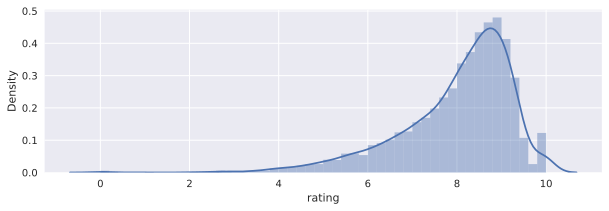

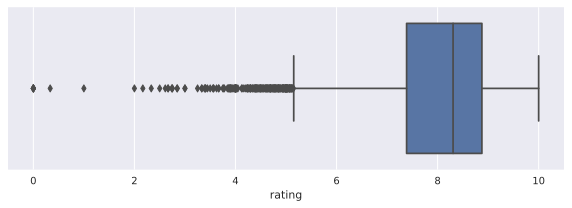

In [34]:
plt.figure(figsize=(10, 3))
sns.distplot(df_pr['rating'])
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(df_pr['rating'], orient='h')
plt.show()

### Look at 5 movies for demo

* Чикатило ee48def6-c311-4b73-a878-1a5d3d1679a3,
* Манюня 9b202b16-55bf-418a-b01d-9f0329b18790,
* Оффлайн 49a3d528-44c0-408e-b6fc-a1507ce7641a
* Молодой человек 0271c9b5-b7b2-4e3f-96af-b9cefed99397
* Приплыли! 02eaefe0-296d-4e6f-b52f-2e2507d07103

In [35]:
demo_df = df_pr.loc[df_pr['element_uid'].isin(['ee48def6-c311-4b73-a878-1a5d3d1679a3', 
                                    '9b202b16-55bf-418a-b01d-9f0329b18790',
                                    '49a3d528-44c0-408e-b6fc-a1507ce7641a',
                                    '0271c9b5-b7b2-4e3f-96af-b9cefed99397',
                                    '02eaefe0-296d-4e6f-b52f-2e2507d07103'])]

In [36]:
ddf = demo_df.copy()

In [37]:
ddf.drop(['release_year', 'element_uid', 'name'], axis=1, inplace=True)

In [38]:
ddf.T

6354       6435       9800       10205
age_access_type          16         18         18          6
type                  MOVIE      MOVIE     SERIAL     SERIAL
duration           15.70258  15.479437  17.723526  16.269958
BUDGET                  NaN        NaN        NaN        NaN
MARKETING               NaN        NaN        NaN        NaN
...                     ...        ...        ...        ...
Харви Вайнштейн           0          0          0          0
Боб Вайнштейн             0          0          0          0
Адриан Политовски         0          0          0          0
Стэн Ли                   0          0          0          0
Люк Бессон                0          0          0          0

[33882 rows x 4 columns]

## Split

In [39]:
df_pr.columns

Index(['age_access_type', 'name', 'type', 'release_year', 'duration',
       'element_uid', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       ...
       'Адам Дэвидсон', 'Крис Гилл', 'Майкл Кан', 'Джим Дено',
       'Дариуш Вольски', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Адриан Политовски', 'Стэн Ли', 'Люк Бессон'],
      dtype='object', length=33885)

In [40]:
from sklearn.model_selection import train_test_split

sorted_df = df_pr.sort_values('release_year')

test = sorted_df[sorted_df['release_year'] == 2022]
train = sorted_df[sorted_df['release_year'] != 2022]

# for looking at samples
test_df = test.copy(deep=True)
train_df = train.copy(deep=True)

test.drop(['release_year', 'element_uid', 'name'], axis=1, inplace=True)
train.drop(['release_year', 'element_uid', 'name'], axis=1, inplace=True)

X_test, y_test = test.drop('rating', axis=1), test['rating']
X, y = train.drop('rating', axis=1), train['rating']
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.1, 
                                                  shuffle=False)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


((4917, 33881), (547, 33881), (87, 33881), (4917,), (547,), (87,))

In [41]:
X_train.columns

Index(['age_access_type', 'type', 'duration', 'BUDGET', 'MARKETING', 'RUS',
       'USA', 'WORLD', 'джек', 'расследовать',
       ...
       'Адам Дэвидсон', 'Крис Гилл', 'Майкл Кан', 'Джим Дено',
       'Дариуш Вольски', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Адриан Политовски', 'Стэн Ли', 'Люк Бессон'],
      dtype='object', length=33881)

In [42]:
cat_features = ['age_access_type', 'type']

## Get just keywords

In [43]:
X_train.columns[:30]

Index(['age_access_type', 'type', 'duration', 'BUDGET', 'MARKETING', 'RUS',
       'USA', 'WORLD', 'джек', 'расследовать', 'подруга', 'ограбление', 'катя',
       'макс', 'мечтать', 'отважный', 'фрэнк', 'воспитывать', 'супергерой',
       'безжалостный', 'маньяк', 'эксцентричный', 'одержимый', 'влюбляться',
       'капитан', 'приключение', 'плен', 'городок', 'пес', 'побег'],
      dtype='object')

In [44]:
X_train.columns[-50:]

Index(['регистрация', 'указанный', 'учет', 'модуль', 'собственник',
       'таможенный', 'диабет', 'млрд', 'рф', 'Drama', 'Comedy', 'Thriller',
       'Action', '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure',
       'Melodrama', 'Sci-Fi', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
       'usa', 'great-britain', 'russia', 'france', 'germany',
       'Бернард Коллако', 'Роджер Бреннер', 'Марк Фальво', 'Крис Уилсон',
       'Джимми Стар', 'Ласко Аткинс', 'Розмари Ховард', 'Кадролша Она Кароле',
       'Ричард Прайс', 'Дж.К. Симмонс', 'Марко Белтрами', 'Джон Дебни',
       'Кристоф Бек', 'Оливье Берио', 'Рави Бансал', 'Дэниэл Эттиэс',
       'Адам Дэвидсон', 'Крис Гилл', 'Майкл Кан', 'Джим Дено',
       'Дариуш Вольски', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Адриан Политовски', 'Стэн Ли', 'Люк Бессон'],
      dtype='object')

In [45]:
X_train_kws = X_train.drop(['age_access_type', 'type', 'duration', 'BUDGET', 'MARKETING', 'RUS',
       'USA', 'WORLD', 'Drama', 'Comedy', 'Thriller',
       'Action', '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure',
       'Melodrama', 'Sci-Fi', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
       'usa', 'great-britain', 'russia', 'france', 'germany',
       'Бернард Коллако', 'Роджер Бреннер', 'Марк Фальво', 'Крис Уилсон',
       'Джимми Стар', 'Ласко Аткинс', 'Розмари Ховард', 'Кадролша Она Кароле',
       'Ричард Прайс', 'Дж.К. Симмонс', 'Марко Белтрами', 'Джон Дебни',
       'Кристоф Бек', 'Оливье Берио', 'Рави Бансал', 'Дэниэл Эттиэс',
       'Адам Дэвидсон', 'Крис Гилл', 'Майкл Кан', 'Джим Дено',
       'Дариуш Вольски', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Адриан Политовски', 'Стэн Ли', 'Люк Бессон'], axis=1)

X_train_df = X_train[['age_access_type', 'type', 'duration', 'BUDGET', 'MARKETING', 'RUS',
       'USA', 'WORLD', 'Drama', 'Comedy', 'Thriller',
       'Action', '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure',
       'Melodrama', 'Sci-Fi', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
       'usa', 'great-britain', 'russia', 'france', 'germany',
       'Бернард Коллако', 'Роджер Бреннер', 'Марк Фальво', 'Крис Уилсон',
       'Джимми Стар', 'Ласко Аткинс', 'Розмари Ховард', 'Кадролша Она Кароле',
       'Ричард Прайс', 'Дж.К. Симмонс', 'Марко Белтрами', 'Джон Дебни',
       'Кристоф Бек', 'Оливье Берио', 'Рави Бансал', 'Дэниэл Эттиэс',
       'Адам Дэвидсон', 'Крис Гилл', 'Майкл Кан', 'Джим Дено',
       'Дариуш Вольски', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Адриан Политовски', 'Стэн Ли', 'Люк Бессон']]

X_val_kws = X_val.drop(['age_access_type', 'type', 'duration', 'BUDGET', 'MARKETING', 'RUS',
       'USA', 'WORLD', 'Drama', 'Comedy', 'Thriller',
       'Action', '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure',
       'Melodrama', 'Sci-Fi', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
       'usa', 'great-britain', 'russia', 'france', 'germany',
       'Бернард Коллако', 'Роджер Бреннер', 'Марк Фальво', 'Крис Уилсон',
       'Джимми Стар', 'Ласко Аткинс', 'Розмари Ховард', 'Кадролша Она Кароле',
       'Ричард Прайс', 'Дж.К. Симмонс', 'Марко Белтрами', 'Джон Дебни',
       'Кристоф Бек', 'Оливье Берио', 'Рави Бансал', 'Дэниэл Эттиэс',
       'Адам Дэвидсон', 'Крис Гилл', 'Майкл Кан', 'Джим Дено',
       'Дариуш Вольски', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Адриан Политовски', 'Стэн Ли', 'Люк Бессон'], axis=1)

X_val_df = X_val[['age_access_type', 'type', 'duration', 'BUDGET', 'MARKETING', 'RUS',
       'USA', 'WORLD', 'Drama', 'Comedy', 'Thriller',
       'Action', '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure',
       'Melodrama', 'Sci-Fi', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
       'usa', 'great-britain', 'russia', 'france', 'germany',
       'Бернард Коллако', 'Роджер Бреннер', 'Марк Фальво', 'Крис Уилсон',
       'Джимми Стар', 'Ласко Аткинс', 'Розмари Ховард', 'Кадролша Она Кароле',
       'Ричард Прайс', 'Дж.К. Симмонс', 'Марко Белтрами', 'Джон Дебни',
       'Кристоф Бек', 'Оливье Берио', 'Рави Бансал', 'Дэниэл Эттиэс',
       'Адам Дэвидсон', 'Крис Гилл', 'Майкл Кан', 'Джим Дено',
       'Дариуш Вольски', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Адриан Политовски', 'Стэн Ли', 'Люк Бессон']]

X_test_kws = X_test.drop(['age_access_type', 'type', 'duration', 'BUDGET', 'MARKETING', 'RUS',
       'USA', 'WORLD', 'Drama', 'Comedy', 'Thriller',
       'Action', '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure',
       'Melodrama', 'Sci-Fi', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
       'usa', 'great-britain', 'russia', 'france', 'germany',
       'Бернард Коллако', 'Роджер Бреннер', 'Марк Фальво', 'Крис Уилсон',
       'Джимми Стар', 'Ласко Аткинс', 'Розмари Ховард', 'Кадролша Она Кароле',
       'Ричард Прайс', 'Дж.К. Симмонс', 'Марко Белтрами', 'Джон Дебни',
       'Кристоф Бек', 'Оливье Берио', 'Рави Бансал', 'Дэниэл Эттиэс',
       'Адам Дэвидсон', 'Крис Гилл', 'Майкл Кан', 'Джим Дено',
       'Дариуш Вольски', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Адриан Политовски', 'Стэн Ли', 'Люк Бессон'], axis=1)

X_test_df = X_test[['age_access_type', 'type', 'duration', 'BUDGET', 'MARKETING', 'RUS',
       'USA', 'WORLD', 'Drama', 'Comedy', 'Thriller',
       'Action', '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure',
       'Melodrama', 'Sci-Fi', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
       'usa', 'great-britain', 'russia', 'france', 'germany',
       'Бернард Коллако', 'Роджер Бреннер', 'Марк Фальво', 'Крис Уилсон',
       'Джимми Стар', 'Ласко Аткинс', 'Розмари Ховард', 'Кадролша Она Кароле',
       'Ричард Прайс', 'Дж.К. Симмонс', 'Марко Белтрами', 'Джон Дебни',
       'Кристоф Бек', 'Оливье Берио', 'Рави Бансал', 'Дэниэл Эттиэс',
       'Адам Дэвидсон', 'Крис Гилл', 'Майкл Кан', 'Джим Дено',
       'Дариуш Вольски', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Адриан Политовски', 'Стэн Ли', 'Люк Бессон']]

## Standartization

In [46]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_kws = sc.fit_transform(X_train_kws)
X_val_kws = sc.transform(X_val_kws)
X_test_kws = sc.transform(X_test_kws)

## PCA

In [ ]:
# ## Get just keywords


# X_train.columns[:30]

# X_train.columns[-50:]

# X_train_kws = X_train.drop(['age_access_type', 'type', 'duration', 'BUDGET', 'MARKETING', 'RUS',
#        'USA', 'WORLD','Drama', 'Comedy', 'Melodrama',
#        'Detective', '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure',
#        'Thriller', 'Action', 'eb001d27-5be3-4d42-9d88-90d593f2627d', 'Family',
#        'russia', 'ukraine', 'france', 'usa', 'germany', 'Андрей Мерзликин',
#        'Александр Никольский', 'Игорь Хрипунов', 'Фёдор Лавров',
#        'Андрей Смоляков', 'Андрей Харыбин', 'Сергей Гурьев',
#        'Дмитрий Поднозов', 'Евгений Цыганов', 'Артур Ваха', 'Иван Канаев',
#        'Валерий Царьков', 'Максим Кошеваров', 'Елена Жукова',
#        'Давид Дадунашвили', 'Артем Аксененко', 'Дмитрий Киселёв',
#        'Ольга Прошкина', 'Дмитрий Слобцов', 'Сергей Трофимов',
#        'Антон Зенкович', 'Эдуард Илоян', 'Виталий Шляппо', 'Алексей Троцюк',
#        'Роман Непомнящий', 'Олег Маловичко'], axis=1)

# X_train_df = X_train[['age_access_type', 'type', 'duration', 'BUDGET', 'MARKETING', 'RUS',
#        'USA', 'WORLD','Drama', 'Comedy', 'Melodrama',
#        'Detective', '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure',
#        'Thriller', 'Action', 'eb001d27-5be3-4d42-9d88-90d593f2627d', 'Family',
#        'russia', 'ukraine', 'france', 'usa', 'germany', 'Андрей Мерзликин',
#        'Александр Никольский', 'Игорь Хрипунов', 'Фёдор Лавров',
#        'Андрей Смоляков', 'Андрей Харыбин', 'Сергей Гурьев',
#        'Дмитрий Поднозов', 'Евгений Цыганов', 'Артур Ваха', 'Иван Канаев',
#        'Валерий Царьков', 'Максим Кошеваров', 'Елена Жукова',
#        'Давид Дадунашвили', 'Артем Аксененко', 'Дмитрий Киселёв',
#        'Ольга Прошкина', 'Дмитрий Слобцов', 'Сергей Трофимов',
#        'Антон Зенкович', 'Эдуард Илоян', 'Виталий Шляппо', 'Алексей Троцюк',
#        'Роман Непомнящий', 'Олег Маловичко']]

# X_val_kws = X_val.drop(['age_access_type', 'type', 'duration', 'BUDGET', 'MARKETING', 'RUS',
#        'USA', 'WORLD','Drama', 'Comedy', 'Melodrama',
#        'Detective', '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure',
#        'Thriller', 'Action', 'eb001d27-5be3-4d42-9d88-90d593f2627d', 'Family',
#        'russia', 'ukraine', 'france', 'usa', 'germany', 'Андрей Мерзликин',
#        'Александр Никольский', 'Игорь Хрипунов', 'Фёдор Лавров',
#        'Андрей Смоляков', 'Андрей Харыбин', 'Сергей Гурьев',
#        'Дмитрий Поднозов', 'Евгений Цыганов', 'Артур Ваха', 'Иван Канаев',
#        'Валерий Царьков', 'Максим Кошеваров', 'Елена Жукова',
#        'Давид Дадунашвили', 'Артем Аксененко', 'Дмитрий Киселёв',
#        'Ольга Прошкина', 'Дмитрий Слобцов', 'Сергей Трофимов',
#        'Антон Зенкович', 'Эдуард Илоян', 'Виталий Шляппо', 'Алексей Троцюк',
#        'Роман Непомнящий', 'Олег Маловичко'], axis=1)

# X_val_df = X_val[['age_access_type', 'type', 'duration', 'BUDGET', 'MARKETING', 'RUS',
#        'USA', 'WORLD','Drama', 'Comedy', 'Melodrama',
#        'Detective', '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure',
#        'Thriller', 'Action', 'eb001d27-5be3-4d42-9d88-90d593f2627d', 'Family',
#        'russia', 'ukraine', 'france', 'usa', 'germany', 'Андрей Мерзликин',
#        'Александр Никольский', 'Игорь Хрипунов', 'Фёдор Лавров',
#        'Андрей Смоляков', 'Андрей Харыбин', 'Сергей Гурьев',
#        'Дмитрий Поднозов', 'Евгений Цыганов', 'Артур Ваха', 'Иван Канаев',
#        'Валерий Царьков', 'Максим Кошеваров', 'Елена Жукова',
#        'Давид Дадунашвили', 'Артем Аксененко', 'Дмитрий Киселёв',
#        'Ольга Прошкина', 'Дмитрий Слобцов', 'Сергей Трофимов',
#        'Антон Зенкович', 'Эдуард Илоян', 'Виталий Шляппо', 'Алексей Троцюк',
#        'Роман Непомнящий', 'Олег Маловичко']]

# X_test_kws = X_test.drop(['age_access_type', 'type', 'duration', 'BUDGET', 'MARKETING', 'RUS',
#        'USA', 'WORLD','Drama', 'Comedy', 'Melodrama',
#        'Detective', '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure',
#        'Thriller', 'Action', 'eb001d27-5be3-4d42-9d88-90d593f2627d', 'Family',
#        'russia', 'ukraine', 'france', 'usa', 'germany', 'Андрей Мерзликин',
#        'Александр Никольский', 'Игорь Хрипунов', 'Фёдор Лавров',
#        'Андрей Смоляков', 'Андрей Харыбин', 'Сергей Гурьев',
#        'Дмитрий Поднозов', 'Евгений Цыганов', 'Артур Ваха', 'Иван Канаев',
#        'Валерий Царьков', 'Максим Кошеваров', 'Елена Жукова',
#        'Давид Дадунашвили', 'Артем Аксененко', 'Дмитрий Киселёв',
#        'Ольга Прошкина', 'Дмитрий Слобцов', 'Сергей Трофимов',
#        'Антон Зенкович', 'Эдуард Илоян', 'Виталий Шляппо', 'Алексей Троцюк',
#        'Роман Непомнящий', 'Олег Маловичко'], axis=1)

# X_test_df = X_test[['age_access_type', 'type', 'duration', 'BUDGET', 'MARKETING', 'RUS',
#        'USA', 'WORLD','Drama', 'Comedy', 'Melodrama',
#        'Detective', '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure',
#        'Thriller', 'Action', 'eb001d27-5be3-4d42-9d88-90d593f2627d', 'Family',
#        'russia', 'ukraine', 'france', 'usa', 'germany', 'Андрей Мерзликин',
#        'Александр Никольский', 'Игорь Хрипунов', 'Фёдор Лавров',
#        'Андрей Смоляков', 'Андрей Харыбин', 'Сергей Гурьев',
#        'Дмитрий Поднозов', 'Евгений Цыганов', 'Артур Ваха', 'Иван Канаев',
#        'Валерий Царьков', 'Максим Кошеваров', 'Елена Жукова',
#        'Давид Дадунашвили', 'Артем Аксененко', 'Дмитрий Киселёв',
#        'Ольга Прошкина', 'Дмитрий Слобцов', 'Сергей Трофимов',
#        'Антон Зенкович', 'Эдуард Илоян', 'Виталий Шляппо', 'Алексей Троцюк',
#        'Роман Непомнящий', 'Олег Маловичко']]

# ## Standartization

# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train_kws = sc.fit_transform(X_train_kws)
# X_val_kws = sc.transform(X_val_kws)
# X_test_kws = sc.transform(X_test_kws)

# ## PCA

# from sklearn.decomposition import PCA

# pca = PCA()
# pca.fit(X_train_kws)
# cumsum = np.cumsum(pca.explained_variance_ratio_)*100
# d = [n for n in range(len(cumsum))]
# plt.figure(figsize=(10, 10))
# plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
# plt.title('Cumulative Explained Variance as a Function of the Number of Components')
# plt.ylabel('Cumulative Explained variance')
# plt.xlabel('Principal components')
# plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
# plt.legend(loc='best')

# pca.n_components_

# pca = PCA(n_components=) 
# X_train_kws_pca = pca.fit_transform(X_train_kws)
# X_val_kws_pca = pca.transform(X_val_kws)
# X_test_kws_pca = pca.transform(X_test_kws)

# **Convert to dataframe**

# component_names = [f"PC{i+1}" for i in range(X_train_kws_pca.shape[1])]
# X_train_kws_pca = pd.DataFrame(X_train_kws_pca, columns=component_names)
# X_train_kws_pca.head()

# X_train_df = X_train_df.reset_index().drop('index', axis=1)
# X_train = X_train_df.join(X_train_kws_pca, on=X_train_df.index)
# X_train.head()

# component_names = [f"PC{i+1}" for i in range(X_val_kws_pca.shape[1])]
# X_val_kws_pca = pd.DataFrame(X_val_kws_pca, columns=component_names)
# X_val_kws_pca.head()

# X_val_df = X_val_df.reset_index().drop('index', axis=1)
# X_val = X_val_df.join(X_val_kws_pca, on=X_val_df.index)
# X_val.head()

# component_names = [f"PC{i+1}" for i in range(X_test_kws_pca.shape[1])]
# X_test_kws_pca = pd.DataFrame(X_test_kws_pca, columns=component_names)
# X_test_kws_pca.head()

# X_test_df = X_test_df.reset_index().drop('index', axis=1)
# X_test = X_test_df.join(X_test_kws_pca, on=X_test_df.index)
# X_test.head()



In [47]:
from sklearn.decomposition import PCA

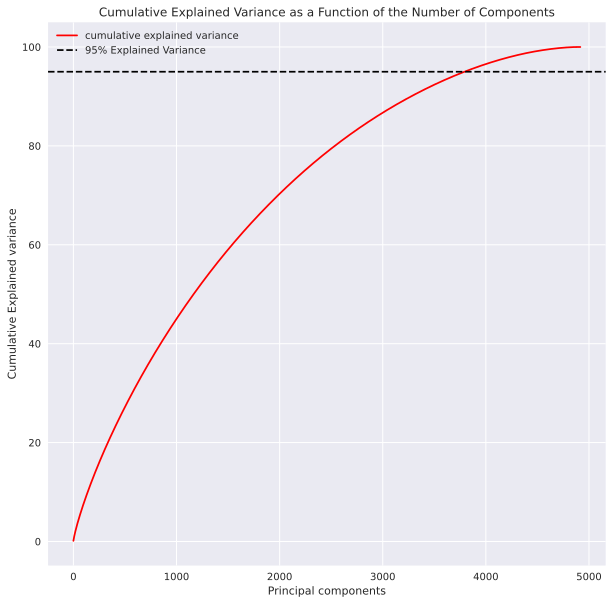

In [68]:
pca = PCA()
pca.fit(X_train_kws)
cumsum = np.cumsum(pca.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]
plt.figure(figsize=(10, 10))
plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='best')

In [69]:
pca.n_components_

4917

In [48]:
pca = PCA(n_components=1000)

X_train_kws_pca = pca.fit_transform(X_train_kws)
X_val_kws_pca = pca.transform(X_val_kws)
X_test_kws_pca = pca.transform(X_test_kws)

**Convert to dataframe**

In [49]:
component_names = [f"PC{i+1}" for i in range(X_train_kws_pca.shape[1])]
X_train_kws_pca = pd.DataFrame(X_train_kws_pca, columns=component_names)
X_train_kws_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.329781 -0.100234 -0.210991 -0.097244 -0.379343 -0.109227 -0.116131   
1  0.386692 -0.186926 -0.475883 -0.266398 -0.438084  2.108122 -0.047986   
2  0.323020 -0.135325  1.114253 -0.416424 -0.291160 -0.100049 -0.308961   
3 -0.475395 -0.286878 -0.473870 -0.259449 -0.576507  1.014651 -0.393435   
4 -0.401899 -0.218000  6.904561 -0.621516  0.200479 -0.163818  0.331984   

        PC8       PC9      PC10  ...     PC991     PC992     PC993      PC994  \
0 -0.504286  0.244763 -0.658153  ... -5.631201  6.443198  1.182397 -11.505792   
1  0.155397  0.605569  5.197124  ... -1.771564  5.672314 -0.589019  -0.185656   
2 -0.315664 -0.041619 -0.539646  ... -0.319903 -0.691700 -5.429499   0.088742   
3 -0.684702 -0.381478 -0.031595  ...  1.944439  2.642900  1.588481   0.740436   
4 -0.649166 -0.544219 -0.114056  ...  4.918848  0.803368 -3.575104  -4.026422   

      PC995     PC996     PC997     PC998     PC999     PC1000  
0 -5.915335  0.598685 -4.541207  1.809806  5.307458   2.954806  
1  3.069086 -2.954299  2.244014  0.405798 -1.698561   2.186158  
2  5.461953 -1.427534 -1.551073 -0.506692 -3.010050   1.876799  
3 -3.232244  3.169427 -0.857494  0.553678  1.184741   2.174461  
4  1.767601  3.918353 -9.306026  6.466685 -5.124334  10.397914  

[5 rows x 1000 columns]

In [50]:
X_train_df = X_train_df.reset_index().drop('index', axis=1)
X_train = X_train_df.join(X_train_kws_pca, on=X_train_df.index)
X_train.head()

age_access_type   type   duration     BUDGET  MARKETING  RUS        USA  \
0              12  MOVIE  15.627073  18.132999  17.092655  NaN  18.369507   
1              18  MOVIE  15.627073  15.319588        NaN  NaN  15.106253   
2              12  MOVIE  15.617221  17.989898        NaN  NaN  17.446812   
3              16  MOVIE  15.720599  14.508658        NaN  NaN  14.271217   
4              16  MOVIE  15.665539  17.370859  16.811243  NaN  17.421152   

       WORLD  Drama  Comedy  ...     PC991     PC992     PC993      PC994  \
0  19.329415      1       0  ... -5.631201  6.443198  1.182397 -11.505792   
1  15.815653      1       0  ... -1.771564  5.672314 -0.589019  -0.185656   
2  18.323362      1       0  ... -0.319903 -0.691700 -5.429499   0.088742   
3  14.531609      1       0  ...  1.944439  2.642900  1.588481   0.740436   
4  17.793795      1       0  ...  4.918848  0.803368 -3.575104  -4.026422   

      PC995     PC996     PC997     PC998     PC999     PC1000  
0 -5.915335  0.598685 -4.541207  1.809806  5.307458   2.954806  
1  3.069086 -2.954299  2.244014  0.405798 -1.698561   2.186158  
2  5.461953 -1.427534 -1.551073 -0.506692 -3.010050   1.876799  
3 -3.232244  3.169427 -0.857494  0.553678  1.184741   2.174461  
4  1.767601  3.918353 -9.306026  6.466685 -5.124334  10.397914  

[5 rows x 1049 columns]

In [51]:
component_names = [f"PC{i+1}" for i in range(X_val_kws_pca.shape[1])]
X_val_kws_pca = pd.DataFrame(X_val_kws_pca, columns=component_names)
X_val_kws_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.103808 -0.087491 -0.148429 -0.260275 -0.339563 -0.162791 -0.278928   
1 -0.200280 -0.105845 -0.319015 -0.458994 -0.300220 -0.194216 -0.310631   
2 -0.285748  0.196154  0.042790 -0.403672 -0.088789 -0.250618  0.021612   
3  2.040718 -0.486897 -0.382042 -0.154340 -0.443387  0.599003 -0.049492   
4 -0.393754  0.004333  0.080311  1.559733 -0.352663  0.765612 -0.164733   

        PC8       PC9      PC10  ...     PC991     PC992     PC993     PC994  \
0 -0.298024 -0.184167 -0.281232  ... -0.689288  0.116961 -0.614497 -0.525063   
1 -0.747286 -0.376161 -0.261668  ... -0.667985  0.084829  0.134335 -1.141646   
2 -0.075510 -0.350165  0.105739  ...  0.900707  0.549580 -0.552646  0.422496   
3 -0.259954 -0.622054 -0.203479  ... -0.827791  0.043649  0.725833 -0.516361   
4  0.000495 -0.488207 -0.130290  ... -0.524957 -0.343021 -0.504032 -0.287438   

      PC995     PC996     PC997     PC998     PC999    PC1000  
0 -0.384475 -0.492800  0.131013  1.084501  0.209419  0.266532  
1  0.303634  0.133481 -1.392043  0.628840 -1.660752 -0.553286  
2  1.322268  0.398261 -0.410205  0.869900  0.709816  0.544086  
3 -0.895542 -0.272172 -0.720697  0.248856 -0.699949  0.238123  
4 -0.999560  0.418602 -0.550771 -1.379582  0.015431 -1.242168  

[5 rows x 1000 columns]

In [52]:
X_val_df = X_val_df.reset_index().drop('index', axis=1)
X_val = X_val_df.join(X_val_kws_pca, on=X_val_df.index)
X_val.head()

age_access_type    type   duration  BUDGET  MARKETING        RUS        USA  \
0              12   MOVIE  15.545395     NaN        NaN  11.623751   7.766417   
1              16  SERIAL  17.458870     NaN        NaN        NaN        NaN   
2              16   MOVIE  15.674929     NaN        NaN        NaN        NaN   
3              18   MOVIE  15.674929     NaN        NaN   9.859588        NaN   
4              16   MOVIE  15.555977     NaN        NaN  11.943636  12.551437   

       WORLD  Drama  Comedy  ...     PC991     PC992     PC993     PC994  \
0  16.063859      0       1  ... -0.689288  0.116961 -0.614497 -0.525063   
1        NaN      1       1  ... -0.667985  0.084829  0.134335 -1.141646   
2  15.486291      0       1  ...  0.900707  0.549580 -0.552646  0.422496   
3  14.816319      1       1  ... -0.827791  0.043649  0.725833 -0.516361   
4  13.779710      0       1  ... -0.524957 -0.343021 -0.504032 -0.287438   

      PC995     PC996     PC997     PC998     PC999    PC1000  
0 -0.384475 -0.492800  0.131013  1.084501  0.209419  0.266532  
1  0.303634  0.133481 -1.392043  0.628840 -1.660752 -0.553286  
2  1.322268  0.398261 -0.410205  0.869900  0.709816  0.544086  
3 -0.895542 -0.272172 -0.720697  0.248856 -0.699949  0.238123  
4 -0.999560  0.418602 -0.550771 -1.379582  0.015431 -1.242168  

[5 rows x 1049 columns]

In [53]:
component_names = [f"PC{i+1}" for i in range(X_test_kws_pca.shape[1])]
X_test_kws_pca = pd.DataFrame(X_test_kws_pca, columns=component_names)
X_test_kws_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.524484 -0.203716 -0.328260 -0.471274 -0.327281 -0.353866 -0.327476   
1 -0.428759 -0.212944 -0.253398 -0.278447 -0.311119 -0.317720 -0.299955   
2 -0.159820 -0.258890 -0.321450 -0.365151 -0.302871 -0.359969 -0.289307   
3 -0.479304 -0.150170 -0.303326 -0.458162 -0.268514 -0.287810 -0.295119   
4 -0.277534 -0.201459 -0.348379 -0.170920 -0.453426  1.611864 -0.171245   

        PC8       PC9      PC10  ...     PC991     PC992     PC993     PC994  \
0 -0.720226 -0.345817 -0.383434  ... -0.040951 -0.295236  0.052558 -0.064435   
1 -0.187828 -0.434795  0.124043  ...  0.704492 -0.460809  0.185199 -0.212522   
2 -0.493570 -0.031373 -0.318063  ... -0.071349 -0.597845 -0.186582  0.315351   
3 -0.651378 -0.215044 -0.022280  ... -0.348624 -0.749941 -0.712575 -0.310255   
4  0.309267 -0.444850 -0.109202  ... -2.539686  0.859959  0.305824 -0.795753   

      PC995     PC996     PC997     PC998     PC999    PC1000  
0  0.013992  0.102859 -0.129029  0.131714  0.160015 -0.112765  
1 -0.206278  0.202295  0.091457  0.108751 -0.356747 -0.253826  
2 -1.091034  1.085176  0.317216  0.784809  0.016478 -0.149744  
3  0.322927  0.021287 -0.207950 -0.206034 -0.020706  0.010955  
4  0.157606 -1.381605 -0.591409 -0.095903  0.722259  1.248451  

[5 rows x 1000 columns]

In [54]:
X_test_df = X_test_df.reset_index().drop('index', axis=1)
X_test = X_test_df.join(X_test_kws_pca, on=X_test_df.index)
X_test.head()

age_access_type    type   duration  BUDGET  MARKETING  RUS  USA  WORLD  \
0              18  SERIAL  17.015815     NaN        NaN  NaN  NaN    NaN   
1              18  SERIAL  16.626117     NaN        NaN  NaN  NaN    NaN   
2              18  SERIAL  16.685680     NaN        NaN  NaN  NaN    NaN   
3              18  SERIAL  16.661582     NaN        NaN  NaN  NaN    NaN   
4              18  SERIAL  17.013367     NaN        NaN  NaN  NaN    NaN   

   Drama  Comedy  ...     PC991     PC992     PC993     PC994     PC995  \
0      1       0  ... -0.040951 -0.295236  0.052558 -0.064435  0.013992   
1      1       0  ...  0.704492 -0.460809  0.185199 -0.212522 -0.206278   
2      1       0  ... -0.071349 -0.597845 -0.186582  0.315351 -1.091034   
3      0       1  ... -0.348624 -0.749941 -0.712575 -0.310255  0.322927   
4      1       1  ... -2.539686  0.859959  0.305824 -0.795753  0.157606   

      PC996     PC997     PC998     PC999    PC1000  
0  0.102859 -0.129029  0.131714  0.160015 -0.112765  
1  0.202295  0.091457  0.108751 -0.356747 -0.253826  
2  1.085176  0.317216  0.784809  0.016478 -0.149744  
3  0.021287 -0.207950 -0.206034 -0.020706  0.010955  
4 -1.381605 -0.591409 -0.095903  0.722259  1.248451  

[5 rows x 1049 columns]

# Modeling

In [55]:
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from scipy.stats import uniform, randint

In [55]:
train_dataset = cat.Pool(data=X_train,
                        label=y_train,
                         cat_features=cat_features)

test_dataset = cat.Pool(data=X_test, 
                        label=y_test,
                         cat_features=cat_features)

val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features)

cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
    eval_set=val_dataset,
    early_stopping_rounds=500,
    verbose=100,
    plot=False
)

Learning rate set to 0.065387
0:	learn: 0.9214250	test: 1.1149187	best: 1.1149187 (0)	total: 79.3ms	remaining: 1m 19s
100:	learn: 0.6398008	test: 0.9182453	best: 0.9182453 (100)	total: 3.08s	remaining: 27.4s
200:	learn: 0.5450664	test: 0.9104841	best: 0.9104081 (196)	total: 5.98s	remaining: 23.8s
300:	learn: 0.4553496	test: 0.9037960	best: 0.9029871 (272)	total: 8.8s	remaining: 20.4s
400:	learn: 0.3789164	test: 0.9031634	best: 0.9018213 (337)	total: 11.6s	remaining: 17.3s
500:	learn: 0.3169935	test: 0.9015955	best: 0.9014012 (478)	total: 14.4s	remaining: 14.3s
600:	learn: 0.2648555	test: 0.9004906	best: 0.8987258 (562)	total: 17.2s	remaining: 11.4s
700:	learn: 0.2233876	test: 0.8978692	best: 0.8977999 (699)	total: 20.1s	remaining: 8.56s
800:	learn: 0.1870838	test: 0.8999033	best: 0.8977999 (699)	total: 22.9s	remaining: 5.68s
900:	learn: 0.1586434	test: 0.8987530	best: 0.8977999 (699)	total: 25.7s	remaining: 2.82s
999:	learn: 0.1359471	test: 0.8994893	best: 0.8977999 (699)	total: 28.4s	

In [56]:
y_pred = cat_model.predict(test_dataset)

In [57]:
calc_metrics(y_test, y_pred)

*** VAL **: 
MSE:   1.3481622126164863
RMSE:  1.161103876755429
R2:    0.4061811593648609
MAE:   0.858496384666091
MedAE: 0.6837724873874995
------------------------------


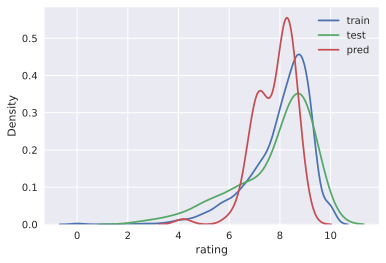

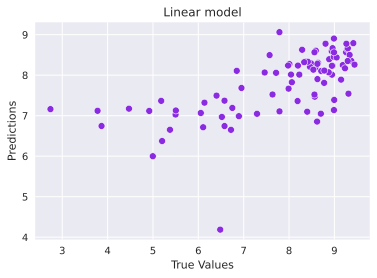

In [58]:
target_distr_linear(y_train, y_test, y_pred)   

In [59]:
cat_model.save_model('cat_reg_okko_ratings_cat_ntop_scors_kws_pca')

**Feature importance**

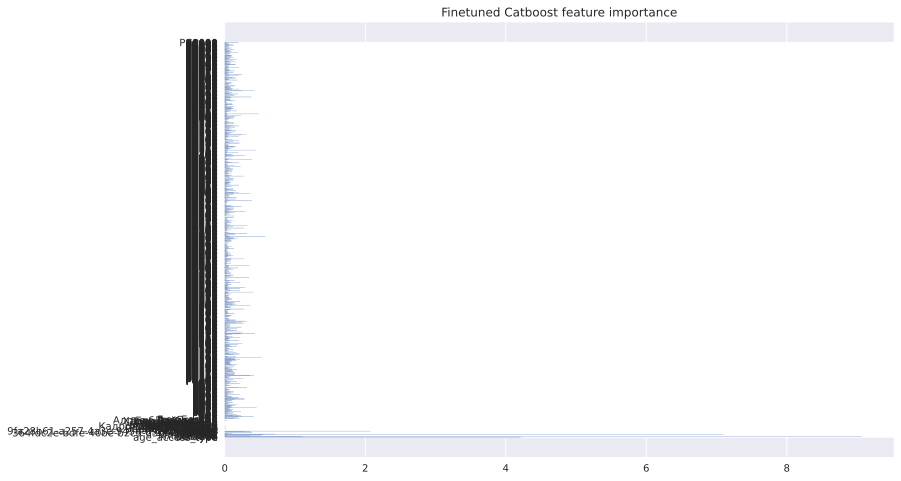

In [60]:
get_feature_imp(cat_model, train_dataset)

1)  The most influential features:  
    - duration  
    - average_rating  
    - age_access_type  

2)  The lowest influential features:  
    - actors and directors are not so important

**Detecting heteroscedasticity**

**Graphical Method:**

Firstly do the regression analysis and then plot the error terms against the predicted values. 
If there is a definite pattern (like linear or quadratic or funnel shaped) obtained from the scatter plot then heteroscedasticity is present.

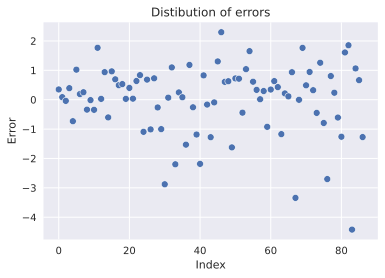

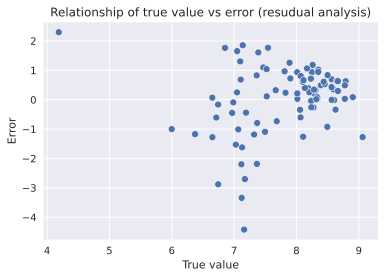

In [61]:
errors = y_test - y_pred
draw_res_analys(errors, y_pred)

**Conclusion**
* The trend in the second figure is not visible, now we will confirm the presence of heteroskedasticity on tests.

In [62]:
test_df['PREDS'] = y_pred.tolist()
test_df['TARGET'] = y_test.tolist()
test_df

age_access_type                             name    type  release_year  \
10452              18                      Дом Дракона  SERIAL          2022   
10439              18  Жена путешественника во времени  SERIAL          2022   
10292              18                    Ночные вызовы  SERIAL          2022   
10334              18         Наш флаг означает Смерть  SERIAL          2022   
10436              18                         Ирма Веп  SERIAL          2022   
...               ...                              ...     ...           ...   
5504               18                 Невидимый убийца   MOVIE          2022   
5410               16                       Другое имя   MOVIE          2022   
5208               12        1941. Крылья над Берлином   MOVIE          2022   
10286              18                        Номинация  SERIAL          2022   
10486               6                     Большие игры  SERIAL          2022   

        duration                           element_uid     BUDGET  MARKETING  \
10452  17.015815  62541c49-7a32-45d0-8981-44ee6968d329        NaN        NaN   
10439  16.626117  7becd8d8-1fb8-4ee6-b903-47817686ddd8        NaN        NaN   
10292  16.685680  aba8d05c-c99d-4a45-adf7-de765f65bf5a        NaN        NaN   
10334  16.661582  500dec0c-d2a3-4ff3-a7c6-e2d21ea7fd9f        NaN        NaN   
10436  17.013367  27e3a752-5124-498c-91fd-28d05c3f6a47        NaN        NaN   
...          ...                                   ...        ...        ...   
5504   15.684231  0d14e4b4-71ed-4409-9ebb-54a130e913c8        NaN        NaN   
5410   15.576811  69021740-65f7-430c-9c00-f2d6d9e9c702        NaN        NaN   
5208   15.607270  ba5598bb-275c-4dcf-9164-0f86cf46d71e        NaN        NaN   
10286  16.400263  c25f3cab-9794-4efa-b729-ff473f8b5f27        NaN        NaN   
10486  15.096445  ce8d2906-a33f-4140-9ffe-e091990d71a4  17.216708        NaN   

             RUS        USA  ...  Майкл Кан  Джим Дено  Дариуш Вольски  \
10452        NaN        NaN  ...          0          0               0   
10439        NaN        NaN  ...          0          0               0   
10292        NaN        NaN  ...          0          0               0   
10334        NaN        NaN  ...          0          0               0   
10436        NaN        NaN  ...          0          0               0   
...          ...        ...  ...        ...        ...             ...   
5504         NaN        NaN  ...          0          0               0   
5410   10.364072        NaN  ...          0          0               0   
5208   14.750267        NaN  ...          0          0               0   
10286        NaN        NaN  ...          0          0               0   
10486  14.196856  17.175217  ...          0          0               0   

       Харви Вайнштейн  Боб Вайнштейн  Адриан Политовски  Стэн Ли  Люк Бессон  \
10452                0              0                  0        0           0   
10439                0              0                  0        0           0   
10292                0              0                  0        0           0   
10334                0              0                  0        0           0   
10436                0              0                  0        0           0   
...                ...            ...                ...      ...         ...   
5504                 0              0                  0        0           0   
5410                 0              0                  0        0           0   
5208                 0              0                  0        0           0   
10286                0              0                  0        0           0   
10486                0              0                  0        0           0   

          PREDS    TARGET  
10452  8.592139  8.940536  
10439  8.904001  8.990000  
10292  8.236590  8.196399  
10334  8.191383  8.583333  
10436  7.683416  6.951220  
...         ...       ...  
5504   7.138035  8.990476 

# Tuning

In [ ]:
train_dataset = cat.Pool(X_train, y_train, 
                         cat_features=cat_features) 

test_dataset = cat.Pool(X_test, y_test,
                         cat_features=cat_features)

cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

In [ ]:
parameters_distr = {'depth': randint(5, 10),
              'learning_rate': uniform(0.01, 0.1),
              'iterations': [5000, 10000, 15000]
             }

cat_model = cat.CatBoostRegressor(**cat_params)
grid = RandomizedSearchCV(estimator=cat_model, param_distributions=parameters_distr, 
                            cv=5, 
#                           n_jobs=-1,
                          verbose=3)

grid.fit(X_train, y_train)

import pickle
with open('bestimator_okko_rat_ntop_tune_kws_pca', 'wb') as f:
    pickle.dump(grid.best_estimator_, f)
grid.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.9514961	total: 70.9ms	remaining: 5m 54s
1:	learn: 0.9348044	total: 85.8ms	remaining: 3m 34s
2:	learn: 0.9177015	total: 100ms	remaining: 2m 46s
3:	learn: 0.8998171	total: 114ms	remaining: 2m 22s
4:	learn: 0.8865363	total: 129ms	remaining: 2m 8s
5:	learn: 0.8734843	total: 156ms	remaining: 2m 10s
6:	learn: 0.8616231	total: 171ms	remaining: 2m 2s
7:	learn: 0.8525188	total: 186ms	remaining: 1m 56s
8:	learn: 0.8434751	total: 201ms	remaining: 1m 51s
9:	learn: 0.8371892	total: 216ms	remaining: 1m 47s
10:	learn: 0.8294440	total: 242ms	remaining: 1m 49s
11:	learn: 0.8200157	total: 257ms	remaining: 1m 46s
12:	learn: 0.8139235	total: 273ms	remaining: 1m 44s
13:	learn: 0.8059794	total: 288ms	remaining: 1m 42s
14:	learn: 0.7996434	total: 303ms	remaining: 1m 40s
15:	learn: 0.7930450	total: 333ms	remaining: 1m 43s
16:	learn: 0.7865221	total: 347ms	remaining: 1m 41s
17:	learn: 0.7826605	total: 361ms	remaining: 1m 40s
18:	learn: 0.

165:	learn: 0.6105167	total: 3.24s	remaining: 1m 34s
166:	learn: 0.6094779	total: 3.25s	remaining: 1m 34s
167:	learn: 0.6086244	total: 3.27s	remaining: 1m 34s
168:	learn: 0.6080824	total: 3.28s	remaining: 1m 33s
169:	learn: 0.6070483	total: 3.3s	remaining: 1m 33s
170:	learn: 0.6058857	total: 3.34s	remaining: 1m 34s
171:	learn: 0.6050157	total: 3.36s	remaining: 1m 34s
172:	learn: 0.6043013	total: 3.37s	remaining: 1m 34s
173:	learn: 0.6037255	total: 3.39s	remaining: 1m 33s
174:	learn: 0.6024622	total: 3.4s	remaining: 1m 33s
175:	learn: 0.6017459	total: 3.43s	remaining: 1m 34s
176:	learn: 0.6006166	total: 3.44s	remaining: 1m 33s
177:	learn: 0.5998968	total: 3.46s	remaining: 1m 33s
178:	learn: 0.5988793	total: 3.47s	remaining: 1m 33s
179:	learn: 0.5981137	total: 3.49s	remaining: 1m 33s
180:	learn: 0.5970798	total: 3.52s	remaining: 1m 33s
181:	learn: 0.5959678	total: 3.56s	remaining: 1m 34s
182:	learn: 0.5949521	total: 3.57s	remaining: 1m 34s
183:	learn: 0.5939178	total: 3.59s	remaining: 1m

322:	learn: 0.4680895	total: 6.41s	remaining: 1m 32s
323:	learn: 0.4672361	total: 6.43s	remaining: 1m 32s
324:	learn: 0.4665538	total: 6.44s	remaining: 1m 32s
325:	learn: 0.4657062	total: 6.47s	remaining: 1m 32s
326:	learn: 0.4647112	total: 6.48s	remaining: 1m 32s
327:	learn: 0.4639689	total: 6.5s	remaining: 1m 32s
328:	learn: 0.4630881	total: 6.54s	remaining: 1m 32s
329:	learn: 0.4621424	total: 6.56s	remaining: 1m 32s
330:	learn: 0.4613754	total: 6.58s	remaining: 1m 32s
331:	learn: 0.4607799	total: 6.6s	remaining: 1m 32s
332:	learn: 0.4599440	total: 6.64s	remaining: 1m 33s
333:	learn: 0.4592376	total: 6.66s	remaining: 1m 33s
334:	learn: 0.4585787	total: 6.67s	remaining: 1m 32s
335:	learn: 0.4576963	total: 6.7s	remaining: 1m 33s
336:	learn: 0.4569866	total: 6.74s	remaining: 1m 33s
337:	learn: 0.4564493	total: 6.76s	remaining: 1m 33s
338:	learn: 0.4557984	total: 6.77s	remaining: 1m 33s
339:	learn: 0.4550073	total: 6.79s	remaining: 1m 33s
340:	learn: 0.4542363	total: 6.83s	remaining: 1m 

478:	learn: 0.3631318	total: 9.59s	remaining: 1m 30s
479:	learn: 0.3624584	total: 9.6s	remaining: 1m 30s
480:	learn: 0.3620272	total: 9.63s	remaining: 1m 30s
481:	learn: 0.3614243	total: 9.65s	remaining: 1m 30s
482:	learn: 0.3607250	total: 9.66s	remaining: 1m 30s
483:	learn: 0.3602501	total: 9.68s	remaining: 1m 30s
484:	learn: 0.3599074	total: 9.69s	remaining: 1m 30s
485:	learn: 0.3591894	total: 9.72s	remaining: 1m 30s
486:	learn: 0.3585323	total: 9.76s	remaining: 1m 30s
487:	learn: 0.3578314	total: 9.77s	remaining: 1m 30s
488:	learn: 0.3572585	total: 9.79s	remaining: 1m 30s
489:	learn: 0.3567188	total: 9.8s	remaining: 1m 30s
490:	learn: 0.3559772	total: 9.83s	remaining: 1m 30s
491:	learn: 0.3551099	total: 9.85s	remaining: 1m 30s
492:	learn: 0.3545094	total: 9.86s	remaining: 1m 30s
493:	learn: 0.3538950	total: 9.88s	remaining: 1m 30s
494:	learn: 0.3532885	total: 9.89s	remaining: 1m 30s
495:	learn: 0.3525309	total: 9.92s	remaining: 1m 30s
496:	learn: 0.3520461	total: 9.96s	remaining: 1m

635:	learn: 0.2823635	total: 12.8s	remaining: 1m 27s
636:	learn: 0.2817748	total: 12.8s	remaining: 1m 27s
637:	learn: 0.2812543	total: 12.8s	remaining: 1m 27s
638:	learn: 0.2808574	total: 12.8s	remaining: 1m 27s
639:	learn: 0.2805834	total: 12.8s	remaining: 1m 27s
640:	learn: 0.2799277	total: 12.9s	remaining: 1m 27s
641:	learn: 0.2797302	total: 12.9s	remaining: 1m 27s
642:	learn: 0.2792369	total: 12.9s	remaining: 1m 27s
643:	learn: 0.2788391	total: 12.9s	remaining: 1m 27s
644:	learn: 0.2783053	total: 12.9s	remaining: 1m 27s
645:	learn: 0.2778316	total: 13s	remaining: 1m 27s
646:	learn: 0.2773313	total: 13s	remaining: 1m 27s
647:	learn: 0.2768450	total: 13s	remaining: 1m 27s
648:	learn: 0.2763034	total: 13s	remaining: 1m 27s
649:	learn: 0.2757849	total: 13s	remaining: 1m 27s
650:	learn: 0.2753570	total: 13.1s	remaining: 1m 27s
651:	learn: 0.2748341	total: 13.1s	remaining: 1m 27s
652:	learn: 0.2744229	total: 13.1s	remaining: 1m 27s
653:	learn: 0.2739015	total: 13.1s	remaining: 1m 27s
654

792:	learn: 0.2224612	total: 15.9s	remaining: 1m 24s
793:	learn: 0.2222187	total: 15.9s	remaining: 1m 24s
794:	learn: 0.2219484	total: 15.9s	remaining: 1m 24s
795:	learn: 0.2216917	total: 16s	remaining: 1m 24s
796:	learn: 0.2213992	total: 16s	remaining: 1m 24s
797:	learn: 0.2211578	total: 16s	remaining: 1m 24s
798:	learn: 0.2207381	total: 16s	remaining: 1m 24s
799:	learn: 0.2203365	total: 16.1s	remaining: 1m 24s
800:	learn: 0.2203137	total: 16.1s	remaining: 1m 24s
801:	learn: 0.2199812	total: 16.1s	remaining: 1m 24s
802:	learn: 0.2197111	total: 16.1s	remaining: 1m 24s
803:	learn: 0.2192325	total: 16.1s	remaining: 1m 24s
804:	learn: 0.2189954	total: 16.1s	remaining: 1m 24s
805:	learn: 0.2185853	total: 16.2s	remaining: 1m 24s
806:	learn: 0.2182757	total: 16.2s	remaining: 1m 24s
807:	learn: 0.2180511	total: 16.2s	remaining: 1m 24s
808:	learn: 0.2178111	total: 16.2s	remaining: 1m 24s
809:	learn: 0.2174543	total: 16.3s	remaining: 1m 24s
810:	learn: 0.2171842	total: 16.3s	remaining: 1m 24s
8

952:	learn: 0.1769703	total: 19.1s	remaining: 1m 21s
953:	learn: 0.1767483	total: 19.1s	remaining: 1m 20s
954:	learn: 0.1764290	total: 19.1s	remaining: 1m 20s
955:	learn: 0.1761303	total: 19.1s	remaining: 1m 20s
956:	learn: 0.1758322	total: 19.1s	remaining: 1m 20s
957:	learn: 0.1755517	total: 19.2s	remaining: 1m 20s
958:	learn: 0.1752404	total: 19.2s	remaining: 1m 20s
959:	learn: 0.1750210	total: 19.2s	remaining: 1m 20s
960:	learn: 0.1747773	total: 19.2s	remaining: 1m 20s
961:	learn: 0.1746183	total: 19.2s	remaining: 1m 20s
962:	learn: 0.1744164	total: 19.2s	remaining: 1m 20s
963:	learn: 0.1743343	total: 19.3s	remaining: 1m 20s
964:	learn: 0.1740468	total: 19.3s	remaining: 1m 20s
965:	learn: 0.1737694	total: 19.3s	remaining: 1m 20s
966:	learn: 0.1734754	total: 19.3s	remaining: 1m 20s
967:	learn: 0.1733799	total: 19.3s	remaining: 1m 20s
968:	learn: 0.1731196	total: 19.4s	remaining: 1m 20s
969:	learn: 0.1727918	total: 19.4s	remaining: 1m 20s
970:	learn: 0.1724766	total: 19.4s	remaining: 

1109:	learn: 0.1425160	total: 22.2s	remaining: 1m 17s
1110:	learn: 0.1422914	total: 22.3s	remaining: 1m 17s
1111:	learn: 0.1420953	total: 22.3s	remaining: 1m 17s
1112:	learn: 0.1418838	total: 22.3s	remaining: 1m 17s
1113:	learn: 0.1416174	total: 22.3s	remaining: 1m 17s
1114:	learn: 0.1414557	total: 22.3s	remaining: 1m 17s
1115:	learn: 0.1413155	total: 22.4s	remaining: 1m 17s
1116:	learn: 0.1410718	total: 22.4s	remaining: 1m 17s
1117:	learn: 0.1408751	total: 22.4s	remaining: 1m 17s
1118:	learn: 0.1405998	total: 22.4s	remaining: 1m 17s
1119:	learn: 0.1404589	total: 22.4s	remaining: 1m 17s
1120:	learn: 0.1402687	total: 22.5s	remaining: 1m 17s
1121:	learn: 0.1400935	total: 22.5s	remaining: 1m 17s
1122:	learn: 0.1399380	total: 22.5s	remaining: 1m 17s
1123:	learn: 0.1398015	total: 22.5s	remaining: 1m 17s
1124:	learn: 0.1396670	total: 22.5s	remaining: 1m 17s
1125:	learn: 0.1394120	total: 22.5s	remaining: 1m 17s
1126:	learn: 0.1392265	total: 22.6s	remaining: 1m 17s
1127:	learn: 0.1389480	total

1266:	learn: 0.1144393	total: 25.4s	remaining: 1m 14s
1267:	learn: 0.1142648	total: 25.4s	remaining: 1m 14s
1268:	learn: 0.1141703	total: 25.4s	remaining: 1m 14s
1269:	learn: 0.1140009	total: 25.5s	remaining: 1m 14s
1270:	learn: 0.1139377	total: 25.5s	remaining: 1m 14s
1271:	learn: 0.1137493	total: 25.5s	remaining: 1m 14s
1272:	learn: 0.1136933	total: 25.5s	remaining: 1m 14s
1273:	learn: 0.1136180	total: 25.5s	remaining: 1m 14s
1274:	learn: 0.1134002	total: 25.6s	remaining: 1m 14s
1275:	learn: 0.1132436	total: 25.6s	remaining: 1m 14s
1276:	learn: 0.1130611	total: 25.6s	remaining: 1m 14s
1277:	learn: 0.1129462	total: 25.6s	remaining: 1m 14s
1278:	learn: 0.1128266	total: 25.6s	remaining: 1m 14s
1279:	learn: 0.1127417	total: 25.7s	remaining: 1m 14s
1280:	learn: 0.1125767	total: 25.7s	remaining: 1m 14s
1281:	learn: 0.1125149	total: 25.7s	remaining: 1m 14s
1282:	learn: 0.1123167	total: 25.7s	remaining: 1m 14s
1283:	learn: 0.1122062	total: 25.7s	remaining: 1m 14s
1284:	learn: 0.1120779	total

1423:	learn: 0.0938265	total: 28.6s	remaining: 1m 11s
1424:	learn: 0.0936789	total: 28.6s	remaining: 1m 11s
1425:	learn: 0.0936622	total: 28.6s	remaining: 1m 11s
1426:	learn: 0.0935370	total: 28.6s	remaining: 1m 11s
1427:	learn: 0.0934047	total: 28.6s	remaining: 1m 11s
1428:	learn: 0.0933257	total: 28.6s	remaining: 1m 11s
1429:	learn: 0.0932578	total: 28.7s	remaining: 1m 11s
1430:	learn: 0.0931769	total: 28.7s	remaining: 1m 11s
1431:	learn: 0.0930623	total: 28.7s	remaining: 1m 11s
1432:	learn: 0.0929073	total: 28.7s	remaining: 1m 11s
1433:	learn: 0.0928014	total: 28.7s	remaining: 1m 11s
1434:	learn: 0.0926422	total: 28.8s	remaining: 1m 11s
1435:	learn: 0.0925022	total: 28.8s	remaining: 1m 11s
1436:	learn: 0.0923617	total: 28.8s	remaining: 1m 11s
1437:	learn: 0.0922542	total: 28.8s	remaining: 1m 11s
1438:	learn: 0.0920864	total: 28.8s	remaining: 1m 11s
1439:	learn: 0.0919275	total: 28.9s	remaining: 1m 11s
1440:	learn: 0.0917652	total: 28.9s	remaining: 1m 11s
1441:	learn: 0.0916383	total

1579:	learn: 0.0774250	total: 31.7s	remaining: 1m 8s
1580:	learn: 0.0773309	total: 31.7s	remaining: 1m 8s
1581:	learn: 0.0772966	total: 31.8s	remaining: 1m 8s
1582:	learn: 0.0771881	total: 31.8s	remaining: 1m 8s
1583:	learn: 0.0771054	total: 31.8s	remaining: 1m 8s
1584:	learn: 0.0770933	total: 31.8s	remaining: 1m 8s
1585:	learn: 0.0770742	total: 31.8s	remaining: 1m 8s
1586:	learn: 0.0769853	total: 31.9s	remaining: 1m 8s
1587:	learn: 0.0769801	total: 31.9s	remaining: 1m 8s
1588:	learn: 0.0768891	total: 31.9s	remaining: 1m 8s
1589:	learn: 0.0768782	total: 31.9s	remaining: 1m 8s
1590:	learn: 0.0767495	total: 32s	remaining: 1m 8s
1591:	learn: 0.0766230	total: 32s	remaining: 1m 8s
1592:	learn: 0.0765584	total: 32s	remaining: 1m 8s
1593:	learn: 0.0764665	total: 32s	remaining: 1m 8s
1594:	learn: 0.0763951	total: 32s	remaining: 1m 8s
1595:	learn: 0.0763091	total: 32s	remaining: 1m 8s
1596:	learn: 0.0761997	total: 32.1s	remaining: 1m 8s
1597:	learn: 0.0760737	total: 32.1s	remaining: 1m 8s
1598:

1744:	learn: 0.0645493	total: 35s	remaining: 1m 5s
1745:	learn: 0.0644434	total: 35.1s	remaining: 1m 5s
1746:	learn: 0.0643752	total: 35.1s	remaining: 1m 5s
1747:	learn: 0.0642826	total: 35.1s	remaining: 1m 5s
1748:	learn: 0.0641951	total: 35.1s	remaining: 1m 5s
1749:	learn: 0.0640899	total: 35.1s	remaining: 1m 5s
1750:	learn: 0.0639842	total: 35.2s	remaining: 1m 5s
1751:	learn: 0.0638995	total: 35.2s	remaining: 1m 5s
1752:	learn: 0.0638476	total: 35.2s	remaining: 1m 5s
1753:	learn: 0.0637551	total: 35.2s	remaining: 1m 5s
1754:	learn: 0.0636971	total: 35.3s	remaining: 1m 5s
1755:	learn: 0.0636272	total: 35.3s	remaining: 1m 5s
1756:	learn: 0.0635307	total: 35.3s	remaining: 1m 5s
1757:	learn: 0.0634866	total: 35.3s	remaining: 1m 5s
1758:	learn: 0.0633891	total: 35.3s	remaining: 1m 5s
1759:	learn: 0.0633129	total: 35.3s	remaining: 1m 5s
1760:	learn: 0.0632391	total: 35.4s	remaining: 1m 5s
1761:	learn: 0.0631978	total: 35.4s	remaining: 1m 5s
1762:	learn: 0.0630873	total: 35.4s	remaining: 1

1900:	learn: 0.0545151	total: 38.2s	remaining: 1m 2s
1901:	learn: 0.0544297	total: 38.2s	remaining: 1m 2s
1902:	learn: 0.0543723	total: 38.3s	remaining: 1m 2s
1903:	learn: 0.0542896	total: 38.3s	remaining: 1m 2s
1904:	learn: 0.0542842	total: 38.3s	remaining: 1m 2s
1905:	learn: 0.0542131	total: 38.3s	remaining: 1m 2s
1906:	learn: 0.0541530	total: 38.3s	remaining: 1m 2s
1907:	learn: 0.0540737	total: 38.4s	remaining: 1m 2s
1908:	learn: 0.0539948	total: 38.4s	remaining: 1m 2s
1909:	learn: 0.0539288	total: 38.4s	remaining: 1m 2s
1910:	learn: 0.0538756	total: 38.4s	remaining: 1m 2s
1911:	learn: 0.0538353	total: 38.4s	remaining: 1m 2s
1912:	learn: 0.0537926	total: 38.5s	remaining: 1m 2s
1913:	learn: 0.0537356	total: 38.5s	remaining: 1m 2s
1914:	learn: 0.0536720	total: 38.5s	remaining: 1m 2s
1915:	learn: 0.0536139	total: 38.5s	remaining: 1m 2s
1916:	learn: 0.0535330	total: 38.5s	remaining: 1m 1s
1917:	learn: 0.0535139	total: 38.6s	remaining: 1m 1s
1918:	learn: 0.0534787	total: 38.6s	remaining:

2059:	learn: 0.0463633	total: 41.4s	remaining: 59.1s
2060:	learn: 0.0462696	total: 41.4s	remaining: 59.1s
2061:	learn: 0.0462008	total: 41.5s	remaining: 59.1s
2062:	learn: 0.0461288	total: 41.5s	remaining: 59.1s
2063:	learn: 0.0460664	total: 41.5s	remaining: 59s
2064:	learn: 0.0459928	total: 41.5s	remaining: 59s
2065:	learn: 0.0459164	total: 41.6s	remaining: 59s
2066:	learn: 0.0458428	total: 41.6s	remaining: 59s
2067:	learn: 0.0457968	total: 41.6s	remaining: 59s
2068:	learn: 0.0457247	total: 41.6s	remaining: 58.9s
2069:	learn: 0.0456748	total: 41.6s	remaining: 58.9s
2070:	learn: 0.0456258	total: 41.7s	remaining: 58.9s
2071:	learn: 0.0456221	total: 41.7s	remaining: 58.9s
2072:	learn: 0.0455699	total: 41.7s	remaining: 58.9s
2073:	learn: 0.0455421	total: 41.7s	remaining: 58.8s
2074:	learn: 0.0455075	total: 41.7s	remaining: 58.8s
2075:	learn: 0.0454741	total: 41.7s	remaining: 58.8s
2076:	learn: 0.0454199	total: 41.8s	remaining: 58.8s
2077:	learn: 0.0453636	total: 41.8s	remaining: 58.7s
207

2216:	learn: 0.0394232	total: 44.6s	remaining: 56s
2217:	learn: 0.0393653	total: 44.6s	remaining: 56s
2218:	learn: 0.0393179	total: 44.6s	remaining: 55.9s
2219:	learn: 0.0392851	total: 44.6s	remaining: 55.9s
2220:	learn: 0.0392285	total: 44.7s	remaining: 55.9s
2221:	learn: 0.0392134	total: 44.7s	remaining: 55.9s
2222:	learn: 0.0392051	total: 44.7s	remaining: 55.8s
2223:	learn: 0.0391610	total: 44.7s	remaining: 55.8s
2224:	learn: 0.0391092	total: 44.7s	remaining: 55.8s
2225:	learn: 0.0390526	total: 44.8s	remaining: 55.8s
2226:	learn: 0.0390474	total: 44.8s	remaining: 55.8s
2227:	learn: 0.0389888	total: 44.8s	remaining: 55.8s
2228:	learn: 0.0389461	total: 44.8s	remaining: 55.7s
2229:	learn: 0.0389090	total: 44.8s	remaining: 55.7s
2230:	learn: 0.0388703	total: 44.9s	remaining: 55.7s
2231:	learn: 0.0388169	total: 44.9s	remaining: 55.7s
2232:	learn: 0.0387853	total: 44.9s	remaining: 55.6s
2233:	learn: 0.0387480	total: 44.9s	remaining: 55.6s
2234:	learn: 0.0387018	total: 44.9s	remaining: 55.

2381:	learn: 0.0336019	total: 47.9s	remaining: 52.7s
2382:	learn: 0.0335565	total: 48s	remaining: 52.7s
2383:	learn: 0.0335539	total: 48s	remaining: 52.6s
2384:	learn: 0.0335163	total: 48s	remaining: 52.6s
2385:	learn: 0.0334814	total: 48s	remaining: 52.6s
2386:	learn: 0.0334726	total: 48s	remaining: 52.6s
2387:	learn: 0.0334261	total: 48s	remaining: 52.5s
2388:	learn: 0.0333708	total: 48.1s	remaining: 52.5s
2389:	learn: 0.0333474	total: 48.1s	remaining: 52.5s
2390:	learn: 0.0333158	total: 48.1s	remaining: 52.5s
2391:	learn: 0.0332996	total: 48.1s	remaining: 52.5s
2392:	learn: 0.0332474	total: 48.2s	remaining: 52.5s
2393:	learn: 0.0332253	total: 48.2s	remaining: 52.4s
2394:	learn: 0.0332221	total: 48.2s	remaining: 52.4s
2395:	learn: 0.0331899	total: 48.2s	remaining: 52.4s
2396:	learn: 0.0331832	total: 48.2s	remaining: 52.4s
2397:	learn: 0.0331555	total: 48.3s	remaining: 52.4s
2398:	learn: 0.0331164	total: 48.3s	remaining: 52.3s
2399:	learn: 0.0331140	total: 48.3s	remaining: 52.3s
2400:

2538:	learn: 0.0295626	total: 51.1s	remaining: 49.5s
2539:	learn: 0.0295245	total: 51.1s	remaining: 49.5s
2540:	learn: 0.0295162	total: 51.1s	remaining: 49.5s
2541:	learn: 0.0294846	total: 51.2s	remaining: 49.5s
2542:	learn: 0.0294716	total: 51.2s	remaining: 49.4s
2543:	learn: 0.0294334	total: 51.2s	remaining: 49.4s
2544:	learn: 0.0294014	total: 51.2s	remaining: 49.4s
2545:	learn: 0.0293778	total: 51.2s	remaining: 49.4s
2546:	learn: 0.0293731	total: 51.3s	remaining: 49.4s
2547:	learn: 0.0293446	total: 51.3s	remaining: 49.3s
2548:	learn: 0.0293025	total: 51.3s	remaining: 49.3s
2549:	learn: 0.0292632	total: 51.3s	remaining: 49.3s
2550:	learn: 0.0292389	total: 51.3s	remaining: 49.3s
2551:	learn: 0.0292385	total: 51.4s	remaining: 49.3s
2552:	learn: 0.0292020	total: 51.4s	remaining: 49.2s
2553:	learn: 0.0291730	total: 51.4s	remaining: 49.2s
2554:	learn: 0.0291695	total: 51.4s	remaining: 49.2s
2555:	learn: 0.0291387	total: 51.4s	remaining: 49.2s
2556:	learn: 0.0291111	total: 51.5s	remaining:

2702:	learn: 0.0254995	total: 54.4s	remaining: 46.2s
2703:	learn: 0.0254749	total: 54.4s	remaining: 46.2s
2704:	learn: 0.0254607	total: 54.4s	remaining: 46.2s
2705:	learn: 0.0254435	total: 54.5s	remaining: 46.2s
2706:	learn: 0.0254124	total: 54.5s	remaining: 46.2s
2707:	learn: 0.0253880	total: 54.5s	remaining: 46.1s
2708:	learn: 0.0253632	total: 54.5s	remaining: 46.1s
2709:	learn: 0.0253395	total: 54.5s	remaining: 46.1s
2710:	learn: 0.0253135	total: 54.6s	remaining: 46.1s
2711:	learn: 0.0252915	total: 54.6s	remaining: 46s
2712:	learn: 0.0252805	total: 54.6s	remaining: 46s
2713:	learn: 0.0252702	total: 54.6s	remaining: 46s
2714:	learn: 0.0252513	total: 54.6s	remaining: 46s
2715:	learn: 0.0252356	total: 54.6s	remaining: 46s
2716:	learn: 0.0252049	total: 54.7s	remaining: 46s
2717:	learn: 0.0251943	total: 54.7s	remaining: 45.9s
2718:	learn: 0.0251666	total: 54.7s	remaining: 45.9s
2719:	learn: 0.0251489	total: 54.7s	remaining: 45.9s
2720:	learn: 0.0251291	total: 54.8s	remaining: 45.9s
2721:

2860:	learn: 0.0224818	total: 57.6s	remaining: 43.1s
2861:	learn: 0.0224513	total: 57.6s	remaining: 43s
2862:	learn: 0.0224425	total: 57.6s	remaining: 43s
2863:	learn: 0.0224352	total: 57.6s	remaining: 43s
2864:	learn: 0.0224270	total: 57.6s	remaining: 43s
2865:	learn: 0.0224254	total: 57.7s	remaining: 43s
2866:	learn: 0.0224062	total: 57.7s	remaining: 42.9s
2867:	learn: 0.0223816	total: 57.7s	remaining: 42.9s
2868:	learn: 0.0223538	total: 57.7s	remaining: 42.9s
2869:	learn: 0.0223411	total: 57.7s	remaining: 42.9s
2870:	learn: 0.0223247	total: 57.8s	remaining: 42.8s
2871:	learn: 0.0222982	total: 57.8s	remaining: 42.8s
2872:	learn: 0.0222847	total: 57.8s	remaining: 42.8s
2873:	learn: 0.0222721	total: 57.8s	remaining: 42.8s
2874:	learn: 0.0222487	total: 57.9s	remaining: 42.8s
2875:	learn: 0.0222269	total: 57.9s	remaining: 42.7s
2876:	learn: 0.0222104	total: 57.9s	remaining: 42.7s
2877:	learn: 0.0221902	total: 57.9s	remaining: 42.7s
2878:	learn: 0.0221663	total: 57.9s	remaining: 42.7s
287

3026:	learn: 0.0197231	total: 1m	remaining: 39.7s
3027:	learn: 0.0196978	total: 1m	remaining: 39.7s
3028:	learn: 0.0196961	total: 1m	remaining: 39.7s
3029:	learn: 0.0196854	total: 1m	remaining: 39.7s
3030:	learn: 0.0196755	total: 1m 1s	remaining: 39.6s
3031:	learn: 0.0196562	total: 1m 1s	remaining: 39.6s
3032:	learn: 0.0196409	total: 1m 1s	remaining: 39.6s
3033:	learn: 0.0196319	total: 1m 1s	remaining: 39.6s
3034:	learn: 0.0196138	total: 1m 1s	remaining: 39.5s
3035:	learn: 0.0196005	total: 1m 1s	remaining: 39.5s
3036:	learn: 0.0195951	total: 1m 1s	remaining: 39.5s
3037:	learn: 0.0195688	total: 1m 1s	remaining: 39.5s
3038:	learn: 0.0195578	total: 1m 1s	remaining: 39.5s
3039:	learn: 0.0195465	total: 1m 1s	remaining: 39.5s
3040:	learn: 0.0195197	total: 1m 1s	remaining: 39.4s
3041:	learn: 0.0194903	total: 1m 1s	remaining: 39.4s
3042:	learn: 0.0194873	total: 1m 1s	remaining: 39.4s
3043:	learn: 0.0194868	total: 1m 1s	remaining: 39.4s
3044:	learn: 0.0194754	total: 1m 1s	remaining: 39.3s
3045:

3185:	learn: 0.0176176	total: 1m 4s	remaining: 36.5s
3186:	learn: 0.0175999	total: 1m 4s	remaining: 36.5s
3187:	learn: 0.0175825	total: 1m 4s	remaining: 36.5s
3188:	learn: 0.0175636	total: 1m 4s	remaining: 36.4s
3189:	learn: 0.0175557	total: 1m 4s	remaining: 36.4s
3190:	learn: 0.0175399	total: 1m 4s	remaining: 36.4s
3191:	learn: 0.0175194	total: 1m 4s	remaining: 36.4s
3192:	learn: 0.0174941	total: 1m 4s	remaining: 36.3s
3193:	learn: 0.0174665	total: 1m 4s	remaining: 36.3s
3194:	learn: 0.0174609	total: 1m 4s	remaining: 36.3s
3195:	learn: 0.0174571	total: 1m 4s	remaining: 36.3s
3196:	learn: 0.0174393	total: 1m 4s	remaining: 36.3s
3197:	learn: 0.0174353	total: 1m 4s	remaining: 36.2s
3198:	learn: 0.0174298	total: 1m 4s	remaining: 36.2s
3199:	learn: 0.0174175	total: 1m 4s	remaining: 36.2s
3200:	learn: 0.0173970	total: 1m 4s	remaining: 36.2s
3201:	learn: 0.0173918	total: 1m 4s	remaining: 36.2s
3202:	learn: 0.0173729	total: 1m 4s	remaining: 36.1s
3203:	learn: 0.0173617	total: 1m 4s	remaining:

3342:	learn: 0.0156269	total: 1m 7s	remaining: 33.3s
3343:	learn: 0.0156230	total: 1m 7s	remaining: 33.3s
3344:	learn: 0.0156115	total: 1m 7s	remaining: 33.3s
3345:	learn: 0.0156011	total: 1m 7s	remaining: 33.3s
3346:	learn: 0.0155908	total: 1m 7s	remaining: 33.2s
3347:	learn: 0.0155778	total: 1m 7s	remaining: 33.2s
3348:	learn: 0.0155636	total: 1m 7s	remaining: 33.2s
3349:	learn: 0.0155528	total: 1m 7s	remaining: 33.2s
3350:	learn: 0.0155466	total: 1m 7s	remaining: 33.1s
3351:	learn: 0.0155420	total: 1m 7s	remaining: 33.1s
3352:	learn: 0.0155362	total: 1m 7s	remaining: 33.1s
3353:	learn: 0.0155229	total: 1m 7s	remaining: 33.1s
3354:	learn: 0.0155034	total: 1m 7s	remaining: 33.1s
3355:	learn: 0.0154875	total: 1m 7s	remaining: 33s
3356:	learn: 0.0154704	total: 1m 7s	remaining: 33s
3357:	learn: 0.0154631	total: 1m 7s	remaining: 33s
3358:	learn: 0.0154583	total: 1m 7s	remaining: 33s
3359:	learn: 0.0154375	total: 1m 7s	remaining: 33s
3360:	learn: 0.0154227	total: 1m 7s	remaining: 33s
3361:

3507:	learn: 0.0139766	total: 1m 10s	remaining: 30s
3508:	learn: 0.0139632	total: 1m 10s	remaining: 30s
3509:	learn: 0.0139511	total: 1m 10s	remaining: 30s
3510:	learn: 0.0139488	total: 1m 10s	remaining: 29.9s
3511:	learn: 0.0139403	total: 1m 10s	remaining: 29.9s
3512:	learn: 0.0139313	total: 1m 10s	remaining: 29.9s
3513:	learn: 0.0139151	total: 1m 10s	remaining: 29.9s
3514:	learn: 0.0139037	total: 1m 10s	remaining: 29.9s
3515:	learn: 0.0138881	total: 1m 10s	remaining: 29.8s
3516:	learn: 0.0138789	total: 1m 10s	remaining: 29.8s
3517:	learn: 0.0138684	total: 1m 10s	remaining: 29.8s
3518:	learn: 0.0138567	total: 1m 10s	remaining: 29.8s
3519:	learn: 0.0138450	total: 1m 10s	remaining: 29.8s
3520:	learn: 0.0138334	total: 1m 10s	remaining: 29.7s
3521:	learn: 0.0138222	total: 1m 10s	remaining: 29.7s
3522:	learn: 0.0138161	total: 1m 10s	remaining: 29.7s
3523:	learn: 0.0138096	total: 1m 10s	remaining: 29.7s
3524:	learn: 0.0138056	total: 1m 10s	remaining: 29.7s
3525:	learn: 0.0137999	total: 1m 1

3664:	learn: 0.0126248	total: 1m 13s	remaining: 26.8s
3665:	learn: 0.0126130	total: 1m 13s	remaining: 26.8s
3666:	learn: 0.0126100	total: 1m 13s	remaining: 26.8s
3667:	learn: 0.0126007	total: 1m 13s	remaining: 26.8s
3668:	learn: 0.0125926	total: 1m 13s	remaining: 26.8s
3669:	learn: 0.0125868	total: 1m 13s	remaining: 26.7s
3670:	learn: 0.0125792	total: 1m 13s	remaining: 26.7s
3671:	learn: 0.0125745	total: 1m 13s	remaining: 26.7s
3672:	learn: 0.0125694	total: 1m 13s	remaining: 26.7s
3673:	learn: 0.0125672	total: 1m 13s	remaining: 26.7s
3674:	learn: 0.0125570	total: 1m 13s	remaining: 26.6s
3675:	learn: 0.0125519	total: 1m 13s	remaining: 26.6s
3676:	learn: 0.0125445	total: 1m 13s	remaining: 26.6s
3677:	learn: 0.0125295	total: 1m 13s	remaining: 26.6s
3678:	learn: 0.0125206	total: 1m 13s	remaining: 26.6s
3679:	learn: 0.0125055	total: 1m 13s	remaining: 26.5s
3680:	learn: 0.0124998	total: 1m 14s	remaining: 26.5s
3681:	learn: 0.0124928	total: 1m 14s	remaining: 26.5s
3682:	learn: 0.0124894	total

3820:	learn: 0.0114319	total: 1m 16s	remaining: 23.7s
3821:	learn: 0.0114293	total: 1m 16s	remaining: 23.7s
3822:	learn: 0.0114200	total: 1m 16s	remaining: 23.7s
3823:	learn: 0.0114165	total: 1m 16s	remaining: 23.6s
3824:	learn: 0.0114085	total: 1m 16s	remaining: 23.6s
3825:	learn: 0.0114000	total: 1m 16s	remaining: 23.6s
3826:	learn: 0.0113944	total: 1m 16s	remaining: 23.6s
3827:	learn: 0.0113832	total: 1m 16s	remaining: 23.6s
3828:	learn: 0.0113773	total: 1m 16s	remaining: 23.5s
3829:	learn: 0.0113746	total: 1m 17s	remaining: 23.5s
3830:	learn: 0.0113685	total: 1m 17s	remaining: 23.5s
3831:	learn: 0.0113672	total: 1m 17s	remaining: 23.5s
3832:	learn: 0.0113605	total: 1m 17s	remaining: 23.5s
3833:	learn: 0.0113507	total: 1m 17s	remaining: 23.4s
3834:	learn: 0.0113474	total: 1m 17s	remaining: 23.4s
3835:	learn: 0.0113379	total: 1m 17s	remaining: 23.4s
3836:	learn: 0.0113345	total: 1m 17s	remaining: 23.4s
3837:	learn: 0.0113238	total: 1m 17s	remaining: 23.4s
3838:	learn: 0.0113166	total

3977:	learn: 0.0103992	total: 1m 19s	remaining: 20.6s
3978:	learn: 0.0103887	total: 1m 20s	remaining: 20.5s
3979:	learn: 0.0103816	total: 1m 20s	remaining: 20.5s
3980:	learn: 0.0103766	total: 1m 20s	remaining: 20.5s
3981:	learn: 0.0103675	total: 1m 20s	remaining: 20.5s
3982:	learn: 0.0103658	total: 1m 20s	remaining: 20.4s
3983:	learn: 0.0103576	total: 1m 20s	remaining: 20.4s
3984:	learn: 0.0103520	total: 1m 20s	remaining: 20.4s
3985:	learn: 0.0103460	total: 1m 20s	remaining: 20.4s
3986:	learn: 0.0103426	total: 1m 20s	remaining: 20.4s
3987:	learn: 0.0103421	total: 1m 20s	remaining: 20.3s
3988:	learn: 0.0103372	total: 1m 20s	remaining: 20.3s
3989:	learn: 0.0103282	total: 1m 20s	remaining: 20.3s
3990:	learn: 0.0103272	total: 1m 20s	remaining: 20.3s
3991:	learn: 0.0103212	total: 1m 20s	remaining: 20.3s
3992:	learn: 0.0103195	total: 1m 20s	remaining: 20.2s
3993:	learn: 0.0103168	total: 1m 20s	remaining: 20.2s
3994:	learn: 0.0103100	total: 1m 20s	remaining: 20.2s
3995:	learn: 0.0103036	total

4134:	learn: 0.0095371	total: 1m 23s	remaining: 17.4s
4135:	learn: 0.0095307	total: 1m 23s	remaining: 17.4s
4136:	learn: 0.0095218	total: 1m 23s	remaining: 17.4s
4137:	learn: 0.0095165	total: 1m 23s	remaining: 17.3s
4138:	learn: 0.0095117	total: 1m 23s	remaining: 17.3s
4139:	learn: 0.0095065	total: 1m 23s	remaining: 17.3s
4140:	learn: 0.0094990	total: 1m 23s	remaining: 17.3s
4141:	learn: 0.0094888	total: 1m 23s	remaining: 17.3s
4142:	learn: 0.0094877	total: 1m 23s	remaining: 17.2s
4143:	learn: 0.0094788	total: 1m 23s	remaining: 17.2s
4144:	learn: 0.0094755	total: 1m 23s	remaining: 17.2s
4145:	learn: 0.0094743	total: 1m 23s	remaining: 17.2s
4146:	learn: 0.0094704	total: 1m 23s	remaining: 17.2s
4147:	learn: 0.0094693	total: 1m 23s	remaining: 17.1s
4148:	learn: 0.0094646	total: 1m 23s	remaining: 17.1s
4149:	learn: 0.0094584	total: 1m 23s	remaining: 17.1s
4150:	learn: 0.0094562	total: 1m 23s	remaining: 17.1s
4151:	learn: 0.0094529	total: 1m 23s	remaining: 17.1s
4152:	learn: 0.0094462	total

4291:	learn: 0.0087454	total: 1m 26s	remaining: 14.2s
4292:	learn: 0.0087391	total: 1m 26s	remaining: 14.2s
4293:	learn: 0.0087344	total: 1m 26s	remaining: 14.2s
4294:	learn: 0.0087326	total: 1m 26s	remaining: 14.2s
4295:	learn: 0.0087257	total: 1m 26s	remaining: 14.2s
4296:	learn: 0.0087223	total: 1m 26s	remaining: 14.1s
4297:	learn: 0.0087171	total: 1m 26s	remaining: 14.1s
4298:	learn: 0.0087170	total: 1m 26s	remaining: 14.1s
4299:	learn: 0.0087170	total: 1m 26s	remaining: 14.1s
4300:	learn: 0.0087141	total: 1m 26s	remaining: 14.1s
4301:	learn: 0.0087068	total: 1m 26s	remaining: 14s
4302:	learn: 0.0087068	total: 1m 26s	remaining: 14s
4303:	learn: 0.0087012	total: 1m 26s	remaining: 14s
4304:	learn: 0.0086938	total: 1m 26s	remaining: 14s
4305:	learn: 0.0086868	total: 1m 26s	remaining: 14s
4306:	learn: 0.0086815	total: 1m 26s	remaining: 13.9s
4307:	learn: 0.0086758	total: 1m 26s	remaining: 13.9s
4308:	learn: 0.0086691	total: 1m 26s	remaining: 13.9s
4309:	learn: 0.0086642	total: 1m 26s	r

4447:	learn: 0.0080821	total: 1m 29s	remaining: 11.1s
4448:	learn: 0.0080746	total: 1m 29s	remaining: 11.1s
4449:	learn: 0.0080711	total: 1m 29s	remaining: 11.1s
4450:	learn: 0.0080698	total: 1m 29s	remaining: 11s
4451:	learn: 0.0080664	total: 1m 29s	remaining: 11s
4452:	learn: 0.0080605	total: 1m 29s	remaining: 11s
4453:	learn: 0.0080590	total: 1m 29s	remaining: 11s
4454:	learn: 0.0080545	total: 1m 29s	remaining: 11s
4455:	learn: 0.0080486	total: 1m 29s	remaining: 10.9s
4456:	learn: 0.0080426	total: 1m 29s	remaining: 10.9s
4457:	learn: 0.0080381	total: 1m 29s	remaining: 10.9s
4458:	learn: 0.0080363	total: 1m 29s	remaining: 10.9s
4459:	learn: 0.0080339	total: 1m 29s	remaining: 10.9s
4460:	learn: 0.0080292	total: 1m 29s	remaining: 10.8s
4461:	learn: 0.0080224	total: 1m 29s	remaining: 10.8s
4462:	learn: 0.0080181	total: 1m 29s	remaining: 10.8s
4463:	learn: 0.0080171	total: 1m 29s	remaining: 10.8s
4464:	learn: 0.0080134	total: 1m 29s	remaining: 10.8s
4465:	learn: 0.0080060	total: 1m 29s	r

4600:	learn: 0.0075012	total: 1m 32s	remaining: 8.03s
4601:	learn: 0.0074953	total: 1m 32s	remaining: 8.01s
4602:	learn: 0.0074887	total: 1m 32s	remaining: 7.99s
4603:	learn: 0.0074880	total: 1m 32s	remaining: 7.97s
4604:	learn: 0.0074805	total: 1m 32s	remaining: 7.95s
4605:	learn: 0.0074743	total: 1m 32s	remaining: 7.93s
4606:	learn: 0.0074704	total: 1m 32s	remaining: 7.91s
4607:	learn: 0.0074685	total: 1m 32s	remaining: 7.89s
4608:	learn: 0.0074649	total: 1m 32s	remaining: 7.87s
4609:	learn: 0.0074588	total: 1m 32s	remaining: 7.85s
4610:	learn: 0.0074568	total: 1m 32s	remaining: 7.83s
4611:	learn: 0.0074544	total: 1m 32s	remaining: 7.81s
4612:	learn: 0.0074485	total: 1m 32s	remaining: 7.79s
4613:	learn: 0.0074459	total: 1m 32s	remaining: 7.76s
4614:	learn: 0.0074433	total: 1m 32s	remaining: 7.75s
4615:	learn: 0.0074364	total: 1m 32s	remaining: 7.73s
4616:	learn: 0.0074334	total: 1m 32s	remaining: 7.71s
4617:	learn: 0.0074301	total: 1m 32s	remaining: 7.68s
4618:	learn: 0.0074259	total

4753:	learn: 0.0069729	total: 1m 35s	remaining: 4.95s
4754:	learn: 0.0069705	total: 1m 35s	remaining: 4.93s
4755:	learn: 0.0069677	total: 1m 35s	remaining: 4.91s
4756:	learn: 0.0069639	total: 1m 35s	remaining: 4.89s
4757:	learn: 0.0069639	total: 1m 35s	remaining: 4.87s
4758:	learn: 0.0069586	total: 1m 35s	remaining: 4.85s
4759:	learn: 0.0069527	total: 1m 35s	remaining: 4.83s
4760:	learn: 0.0069513	total: 1m 35s	remaining: 4.81s
4761:	learn: 0.0069471	total: 1m 35s	remaining: 4.79s
4762:	learn: 0.0069449	total: 1m 35s	remaining: 4.77s
4763:	learn: 0.0069417	total: 1m 35s	remaining: 4.75s
4764:	learn: 0.0069387	total: 1m 35s	remaining: 4.73s
4765:	learn: 0.0069339	total: 1m 35s	remaining: 4.71s
4766:	learn: 0.0069295	total: 1m 35s	remaining: 4.69s
4767:	learn: 0.0069229	total: 1m 35s	remaining: 4.67s
4768:	learn: 0.0069165	total: 1m 35s	remaining: 4.65s
4769:	learn: 0.0069133	total: 1m 35s	remaining: 4.63s
4770:	learn: 0.0069121	total: 1m 36s	remaining: 4.61s
4771:	learn: 0.0069113	total

4907:	learn: 0.0065506	total: 1m 38s	remaining: 1.85s
4908:	learn: 0.0065451	total: 1m 38s	remaining: 1.83s
4909:	learn: 0.0065405	total: 1m 38s	remaining: 1.81s
4910:	learn: 0.0065375	total: 1m 38s	remaining: 1.79s
4911:	learn: 0.0065345	total: 1m 38s	remaining: 1.77s
4912:	learn: 0.0065343	total: 1m 38s	remaining: 1.75s
4913:	learn: 0.0065309	total: 1m 38s	remaining: 1.73s
4914:	learn: 0.0065252	total: 1m 38s	remaining: 1.71s
4915:	learn: 0.0065230	total: 1m 38s	remaining: 1.69s
4916:	learn: 0.0065190	total: 1m 38s	remaining: 1.67s
4917:	learn: 0.0065153	total: 1m 38s	remaining: 1.65s
4918:	learn: 0.0065115	total: 1m 38s	remaining: 1.63s
4919:	learn: 0.0065099	total: 1m 39s	remaining: 1.61s
4920:	learn: 0.0065046	total: 1m 39s	remaining: 1.59s
4921:	learn: 0.0065010	total: 1m 39s	remaining: 1.57s
4922:	learn: 0.0064969	total: 1m 39s	remaining: 1.55s
4923:	learn: 0.0064952	total: 1m 39s	remaining: 1.53s
4924:	learn: 0.0064952	total: 1m 39s	remaining: 1.51s
4925:	learn: 0.0064893	total

64:	learn: 0.6858169	total: 1.35s	remaining: 1m 42s
65:	learn: 0.6847233	total: 1.38s	remaining: 1m 42s
66:	learn: 0.6838665	total: 1.41s	remaining: 1m 43s
67:	learn: 0.6835088	total: 1.43s	remaining: 1m 43s
68:	learn: 0.6827023	total: 1.44s	remaining: 1m 42s
69:	learn: 0.6815659	total: 1.45s	remaining: 1m 42s
70:	learn: 0.6808124	total: 1.49s	remaining: 1m 43s
71:	learn: 0.6799352	total: 1.51s	remaining: 1m 43s
72:	learn: 0.6794109	total: 1.52s	remaining: 1m 42s
73:	learn: 0.6780576	total: 1.54s	remaining: 1m 42s
74:	learn: 0.6775793	total: 1.55s	remaining: 1m 42s
75:	learn: 0.6767756	total: 1.59s	remaining: 1m 43s
76:	learn: 0.6754419	total: 1.61s	remaining: 1m 42s
77:	learn: 0.6747782	total: 1.62s	remaining: 1m 42s
78:	learn: 0.6738389	total: 1.64s	remaining: 1m 41s
79:	learn: 0.6733217	total: 1.65s	remaining: 1m 41s
80:	learn: 0.6723627	total: 1.69s	remaining: 1m 42s
81:	learn: 0.6716500	total: 1.71s	remaining: 1m 42s
82:	learn: 0.6708662	total: 1.72s	remaining: 1m 42s
83:	learn: 0

220:	learn: 0.5492744	total: 4.52s	remaining: 1m 37s
221:	learn: 0.5481522	total: 4.54s	remaining: 1m 37s
222:	learn: 0.5474516	total: 4.55s	remaining: 1m 37s
223:	learn: 0.5465436	total: 4.57s	remaining: 1m 37s
224:	learn: 0.5455482	total: 4.58s	remaining: 1m 37s
225:	learn: 0.5443892	total: 4.62s	remaining: 1m 37s
226:	learn: 0.5431818	total: 4.64s	remaining: 1m 37s
227:	learn: 0.5420930	total: 4.66s	remaining: 1m 37s
228:	learn: 0.5409319	total: 4.67s	remaining: 1m 37s
229:	learn: 0.5398954	total: 4.68s	remaining: 1m 37s
230:	learn: 0.5393741	total: 4.72s	remaining: 1m 37s
231:	learn: 0.5385817	total: 4.74s	remaining: 1m 37s
232:	learn: 0.5376506	total: 4.76s	remaining: 1m 37s
233:	learn: 0.5368222	total: 4.77s	remaining: 1m 37s
234:	learn: 0.5362729	total: 4.79s	remaining: 1m 37s
235:	learn: 0.5354269	total: 4.82s	remaining: 1m 37s
236:	learn: 0.5343053	total: 4.84s	remaining: 1m 37s
237:	learn: 0.5332621	total: 4.85s	remaining: 1m 37s
238:	learn: 0.5323684	total: 4.86s	remaining: 

378:	learn: 0.4262580	total: 7.68s	remaining: 1m 33s
379:	learn: 0.4254855	total: 7.7s	remaining: 1m 33s
380:	learn: 0.4249601	total: 7.73s	remaining: 1m 33s
381:	learn: 0.4240682	total: 7.75s	remaining: 1m 33s
382:	learn: 0.4234081	total: 7.76s	remaining: 1m 33s
383:	learn: 0.4226113	total: 7.78s	remaining: 1m 33s
384:	learn: 0.4217655	total: 7.79s	remaining: 1m 33s
385:	learn: 0.4213619	total: 7.83s	remaining: 1m 33s
386:	learn: 0.4205088	total: 7.85s	remaining: 1m 33s
387:	learn: 0.4197802	total: 7.87s	remaining: 1m 33s
388:	learn: 0.4191322	total: 7.88s	remaining: 1m 33s
389:	learn: 0.4184148	total: 7.9s	remaining: 1m 33s
390:	learn: 0.4176729	total: 7.94s	remaining: 1m 33s
391:	learn: 0.4170804	total: 7.96s	remaining: 1m 33s
392:	learn: 0.4166887	total: 7.97s	remaining: 1m 33s
393:	learn: 0.4158719	total: 7.98s	remaining: 1m 33s
394:	learn: 0.4152307	total: 8s	remaining: 1m 33s
395:	learn: 0.4147162	total: 8.04s	remaining: 1m 33s
396:	learn: 0.4141268	total: 8.05s	remaining: 1m 33

534:	learn: 0.3307067	total: 10.8s	remaining: 1m 30s
535:	learn: 0.3307013	total: 10.9s	remaining: 1m 30s
536:	learn: 0.3300414	total: 10.9s	remaining: 1m 30s
537:	learn: 0.3294455	total: 10.9s	remaining: 1m 30s
538:	learn: 0.3288362	total: 10.9s	remaining: 1m 30s
539:	learn: 0.3282211	total: 10.9s	remaining: 1m 30s
540:	learn: 0.3277511	total: 10.9s	remaining: 1m 30s
541:	learn: 0.3272386	total: 11s	remaining: 1m 30s
542:	learn: 0.3266825	total: 11s	remaining: 1m 30s
543:	learn: 0.3262133	total: 11s	remaining: 1m 30s
544:	learn: 0.3255996	total: 11s	remaining: 1m 30s
545:	learn: 0.3251976	total: 11.1s	remaining: 1m 30s
546:	learn: 0.3247463	total: 11.1s	remaining: 1m 30s
547:	learn: 0.3241854	total: 11.1s	remaining: 1m 30s
548:	learn: 0.3236300	total: 11.1s	remaining: 1m 30s
549:	learn: 0.3231585	total: 11.1s	remaining: 1m 30s
550:	learn: 0.3226764	total: 11.2s	remaining: 1m 30s
551:	learn: 0.3221371	total: 11.2s	remaining: 1m 30s
552:	learn: 0.3215094	total: 11.2s	remaining: 1m 30s
5

699:	learn: 0.2533500	total: 14.2s	remaining: 1m 27s
700:	learn: 0.2529013	total: 14.2s	remaining: 1m 27s
701:	learn: 0.2524604	total: 14.2s	remaining: 1m 27s
702:	learn: 0.2520838	total: 14.2s	remaining: 1m 27s
703:	learn: 0.2516657	total: 14.3s	remaining: 1m 26s
704:	learn: 0.2512622	total: 14.3s	remaining: 1m 26s
705:	learn: 0.2510117	total: 14.3s	remaining: 1m 26s
706:	learn: 0.2506287	total: 14.3s	remaining: 1m 27s
707:	learn: 0.2503958	total: 14.3s	remaining: 1m 26s
708:	learn: 0.2499670	total: 14.4s	remaining: 1m 26s
709:	learn: 0.2495447	total: 14.4s	remaining: 1m 26s
710:	learn: 0.2490405	total: 14.4s	remaining: 1m 26s
711:	learn: 0.2486777	total: 14.4s	remaining: 1m 26s
712:	learn: 0.2482937	total: 14.4s	remaining: 1m 26s
713:	learn: 0.2481173	total: 14.4s	remaining: 1m 26s
714:	learn: 0.2476704	total: 14.5s	remaining: 1m 26s
715:	learn: 0.2472337	total: 14.5s	remaining: 1m 26s
716:	learn: 0.2468144	total: 14.5s	remaining: 1m 26s
717:	learn: 0.2464279	total: 14.5s	remaining: 

858:	learn: 0.1963555	total: 17.4s	remaining: 1m 23s
859:	learn: 0.1959948	total: 17.4s	remaining: 1m 23s
860:	learn: 0.1957792	total: 17.4s	remaining: 1m 23s
861:	learn: 0.1955568	total: 17.4s	remaining: 1m 23s
862:	learn: 0.1953646	total: 17.5s	remaining: 1m 23s
863:	learn: 0.1949949	total: 17.5s	remaining: 1m 23s
864:	learn: 0.1946725	total: 17.5s	remaining: 1m 23s
865:	learn: 0.1944241	total: 17.5s	remaining: 1m 23s
866:	learn: 0.1941471	total: 17.5s	remaining: 1m 23s
867:	learn: 0.1939227	total: 17.5s	remaining: 1m 23s
868:	learn: 0.1935793	total: 17.6s	remaining: 1m 23s
869:	learn: 0.1932377	total: 17.6s	remaining: 1m 23s
870:	learn: 0.1929161	total: 17.6s	remaining: 1m 23s
871:	learn: 0.1926173	total: 17.6s	remaining: 1m 23s
872:	learn: 0.1922787	total: 17.7s	remaining: 1m 23s
873:	learn: 0.1920551	total: 17.7s	remaining: 1m 23s
874:	learn: 0.1918552	total: 17.7s	remaining: 1m 23s
875:	learn: 0.1915086	total: 17.7s	remaining: 1m 23s
876:	learn: 0.1912020	total: 17.7s	remaining: 

1022:	learn: 0.1520501	total: 20.7s	remaining: 1m 20s
1023:	learn: 0.1518115	total: 20.7s	remaining: 1m 20s
1024:	learn: 0.1515090	total: 20.7s	remaining: 1m 20s
1025:	learn: 0.1513005	total: 20.8s	remaining: 1m 20s
1026:	learn: 0.1510794	total: 20.8s	remaining: 1m 20s
1027:	learn: 0.1508678	total: 20.8s	remaining: 1m 20s
1028:	learn: 0.1506712	total: 20.8s	remaining: 1m 20s
1029:	learn: 0.1504704	total: 20.8s	remaining: 1m 20s
1030:	learn: 0.1502291	total: 20.8s	remaining: 1m 20s
1031:	learn: 0.1500062	total: 20.9s	remaining: 1m 20s
1032:	learn: 0.1497211	total: 20.9s	remaining: 1m 20s
1033:	learn: 0.1494757	total: 20.9s	remaining: 1m 20s
1034:	learn: 0.1492177	total: 20.9s	remaining: 1m 20s
1035:	learn: 0.1490083	total: 21s	remaining: 1m 20s
1036:	learn: 0.1488024	total: 21s	remaining: 1m 20s
1037:	learn: 0.1485882	total: 21s	remaining: 1m 20s
1038:	learn: 0.1484092	total: 21s	remaining: 1m 20s
1039:	learn: 0.1482086	total: 21s	remaining: 1m 20s
1040:	learn: 0.1479405	total: 21.1s	re

1179:	learn: 0.1200176	total: 23.8s	remaining: 1m 17s
1180:	learn: 0.1198313	total: 23.8s	remaining: 1m 17s
1181:	learn: 0.1196445	total: 23.9s	remaining: 1m 17s
1182:	learn: 0.1194352	total: 23.9s	remaining: 1m 17s
1183:	learn: 0.1193635	total: 23.9s	remaining: 1m 16s
1184:	learn: 0.1191497	total: 23.9s	remaining: 1m 16s
1185:	learn: 0.1189715	total: 23.9s	remaining: 1m 16s
1186:	learn: 0.1187397	total: 23.9s	remaining: 1m 16s
1187:	learn: 0.1185695	total: 24s	remaining: 1m 16s
1188:	learn: 0.1184055	total: 24s	remaining: 1m 16s
1189:	learn: 0.1182372	total: 24s	remaining: 1m 16s
1190:	learn: 0.1180578	total: 24s	remaining: 1m 16s
1191:	learn: 0.1178794	total: 24s	remaining: 1m 16s
1192:	learn: 0.1177093	total: 24s	remaining: 1m 16s
1193:	learn: 0.1175359	total: 24.1s	remaining: 1m 16s
1194:	learn: 0.1173848	total: 24.1s	remaining: 1m 16s
1195:	learn: 0.1172339	total: 24.1s	remaining: 1m 16s
1196:	learn: 0.1170477	total: 24.1s	remaining: 1m 16s
1197:	learn: 0.1169281	total: 24.1s	rema

1339:	learn: 0.0957591	total: 27s	remaining: 1m 13s
1340:	learn: 0.0956199	total: 27s	remaining: 1m 13s
1341:	learn: 0.0955820	total: 27s	remaining: 1m 13s
1342:	learn: 0.0954239	total: 27s	remaining: 1m 13s
1343:	learn: 0.0953035	total: 27s	remaining: 1m 13s
1344:	learn: 0.0951405	total: 27.1s	remaining: 1m 13s
1345:	learn: 0.0949614	total: 27.1s	remaining: 1m 13s
1346:	learn: 0.0948260	total: 27.1s	remaining: 1m 13s
1347:	learn: 0.0946527	total: 27.1s	remaining: 1m 13s
1348:	learn: 0.0944484	total: 27.2s	remaining: 1m 13s
1349:	learn: 0.0942874	total: 27.2s	remaining: 1m 13s
1350:	learn: 0.0941375	total: 27.2s	remaining: 1m 13s
1351:	learn: 0.0940064	total: 27.2s	remaining: 1m 13s
1352:	learn: 0.0939027	total: 27.2s	remaining: 1m 13s
1353:	learn: 0.0937681	total: 27.2s	remaining: 1m 13s
1354:	learn: 0.0936068	total: 27.3s	remaining: 1m 13s
1355:	learn: 0.0934627	total: 27.3s	remaining: 1m 13s
1356:	learn: 0.0933759	total: 27.3s	remaining: 1m 13s
1357:	learn: 0.0932616	total: 27.3s	re

1493:	learn: 0.0776445	total: 30.1s	remaining: 1m 10s
1494:	learn: 0.0775708	total: 30.1s	remaining: 1m 10s
1495:	learn: 0.0774937	total: 30.1s	remaining: 1m 10s
1496:	learn: 0.0774238	total: 30.1s	remaining: 1m 10s
1497:	learn: 0.0773456	total: 30.2s	remaining: 1m 10s
1498:	learn: 0.0772426	total: 30.2s	remaining: 1m 10s
1499:	learn: 0.0771617	total: 30.2s	remaining: 1m 10s
1500:	learn: 0.0771088	total: 30.2s	remaining: 1m 10s
1501:	learn: 0.0769998	total: 30.3s	remaining: 1m 10s
1502:	learn: 0.0769136	total: 30.3s	remaining: 1m 10s
1503:	learn: 0.0768031	total: 30.3s	remaining: 1m 10s
1504:	learn: 0.0766844	total: 30.3s	remaining: 1m 10s
1505:	learn: 0.0765919	total: 30.3s	remaining: 1m 10s
1506:	learn: 0.0764712	total: 30.4s	remaining: 1m 10s
1507:	learn: 0.0763569	total: 30.4s	remaining: 1m 10s
1508:	learn: 0.0762196	total: 30.4s	remaining: 1m 10s
1509:	learn: 0.0761467	total: 30.4s	remaining: 1m 10s
1510:	learn: 0.0759946	total: 30.4s	remaining: 1m 10s
1511:	learn: 0.0758905	total

1650:	learn: 0.0631880	total: 33.2s	remaining: 1m 7s
1651:	learn: 0.0630879	total: 33.3s	remaining: 1m 7s
1652:	learn: 0.0630134	total: 33.3s	remaining: 1m 7s
1653:	learn: 0.0629410	total: 33.3s	remaining: 1m 7s
1654:	learn: 0.0628705	total: 33.3s	remaining: 1m 7s
1655:	learn: 0.0627992	total: 33.3s	remaining: 1m 7s
1656:	learn: 0.0627310	total: 33.4s	remaining: 1m 7s
1657:	learn: 0.0626369	total: 33.4s	remaining: 1m 7s
1658:	learn: 0.0625385	total: 33.4s	remaining: 1m 7s
1659:	learn: 0.0624616	total: 33.4s	remaining: 1m 7s
1660:	learn: 0.0623498	total: 33.4s	remaining: 1m 7s
1661:	learn: 0.0622601	total: 33.5s	remaining: 1m 7s
1662:	learn: 0.0622001	total: 33.5s	remaining: 1m 7s
1663:	learn: 0.0621589	total: 33.5s	remaining: 1m 7s
1664:	learn: 0.0620602	total: 33.5s	remaining: 1m 7s
1665:	learn: 0.0619572	total: 33.5s	remaining: 1m 7s
1666:	learn: 0.0619283	total: 33.6s	remaining: 1m 7s
1667:	learn: 0.0618315	total: 33.6s	remaining: 1m 7s
1668:	learn: 0.0617511	total: 33.6s	remaining:

1815:	learn: 0.0521690	total: 36.6s	remaining: 1m 4s
1816:	learn: 0.0521366	total: 36.6s	remaining: 1m 4s
1817:	learn: 0.0520888	total: 36.6s	remaining: 1m 4s
1818:	learn: 0.0520845	total: 36.6s	remaining: 1m 4s
1819:	learn: 0.0520422	total: 36.6s	remaining: 1m 4s
1820:	learn: 0.0519937	total: 36.7s	remaining: 1m 4s
1821:	learn: 0.0519106	total: 36.7s	remaining: 1m 4s
1822:	learn: 0.0518601	total: 36.7s	remaining: 1m 3s
1823:	learn: 0.0518292	total: 36.7s	remaining: 1m 3s
1824:	learn: 0.0517751	total: 36.7s	remaining: 1m 3s
1825:	learn: 0.0517098	total: 36.8s	remaining: 1m 3s
1826:	learn: 0.0516627	total: 36.8s	remaining: 1m 3s
1827:	learn: 0.0516001	total: 36.8s	remaining: 1m 3s
1828:	learn: 0.0515100	total: 36.8s	remaining: 1m 3s
1829:	learn: 0.0514798	total: 36.8s	remaining: 1m 3s
1830:	learn: 0.0514439	total: 36.9s	remaining: 1m 3s
1831:	learn: 0.0513476	total: 36.9s	remaining: 1m 3s
1832:	learn: 0.0513282	total: 36.9s	remaining: 1m 3s
1833:	learn: 0.0512581	total: 36.9s	remaining:

1973:	learn: 0.0438796	total: 39.8s	remaining: 1m
1974:	learn: 0.0438480	total: 39.8s	remaining: 1m
1975:	learn: 0.0438456	total: 39.8s	remaining: 1m
1976:	learn: 0.0437818	total: 39.8s	remaining: 1m
1977:	learn: 0.0437230	total: 39.8s	remaining: 1m
1978:	learn: 0.0436880	total: 39.9s	remaining: 1m
1979:	learn: 0.0436514	total: 39.9s	remaining: 1m
1980:	learn: 0.0435946	total: 39.9s	remaining: 1m
1981:	learn: 0.0435602	total: 39.9s	remaining: 1m
1982:	learn: 0.0435197	total: 39.9s	remaining: 1m
1983:	learn: 0.0434500	total: 39.9s	remaining: 1m
1984:	learn: 0.0433652	total: 40s	remaining: 1m
1985:	learn: 0.0433265	total: 40s	remaining: 1m
1986:	learn: 0.0432699	total: 40s	remaining: 1m
1987:	learn: 0.0432147	total: 40s	remaining: 1m
1988:	learn: 0.0431954	total: 40.1s	remaining: 1m
1989:	learn: 0.0431348	total: 40.1s	remaining: 1m
1990:	learn: 0.0430958	total: 40.1s	remaining: 1m
1991:	learn: 0.0430651	total: 40.1s	remaining: 1m
1992:	learn: 0.0430261	total: 40.1s	remaining: 1m
1993:	le

2140:	learn: 0.0366898	total: 43.2s	remaining: 57.6s
2141:	learn: 0.0366478	total: 43.2s	remaining: 57.6s
2142:	learn: 0.0366149	total: 43.2s	remaining: 57.6s
2143:	learn: 0.0365655	total: 43.2s	remaining: 57.6s
2144:	learn: 0.0365274	total: 43.2s	remaining: 57.5s
2145:	learn: 0.0364892	total: 43.3s	remaining: 57.5s
2146:	learn: 0.0364824	total: 43.3s	remaining: 57.5s
2147:	learn: 0.0364733	total: 43.3s	remaining: 57.5s
2148:	learn: 0.0364689	total: 43.3s	remaining: 57.4s
2149:	learn: 0.0364154	total: 43.3s	remaining: 57.4s
2150:	learn: 0.0363836	total: 43.3s	remaining: 57.4s
2151:	learn: 0.0363346	total: 43.4s	remaining: 57.4s
2152:	learn: 0.0363309	total: 43.4s	remaining: 57.4s
2153:	learn: 0.0362918	total: 43.4s	remaining: 57.3s
2154:	learn: 0.0362559	total: 43.4s	remaining: 57.3s
2155:	learn: 0.0362274	total: 43.5s	remaining: 57.3s
2156:	learn: 0.0361790	total: 43.5s	remaining: 57.3s
2157:	learn: 0.0361407	total: 43.5s	remaining: 57.3s
2158:	learn: 0.0360960	total: 43.5s	remaining:

2306:	learn: 0.0313123	total: 46.5s	remaining: 54.3s
2307:	learn: 0.0312795	total: 46.5s	remaining: 54.3s
2308:	learn: 0.0312386	total: 46.5s	remaining: 54.2s
2309:	learn: 0.0312103	total: 46.6s	remaining: 54.2s
2310:	learn: 0.0311958	total: 46.6s	remaining: 54.2s
2311:	learn: 0.0311648	total: 46.6s	remaining: 54.2s
2312:	learn: 0.0311204	total: 46.6s	remaining: 54.2s
2313:	learn: 0.0310831	total: 46.6s	remaining: 54.1s
2314:	learn: 0.0310767	total: 46.7s	remaining: 54.1s
2315:	learn: 0.0310584	total: 46.7s	remaining: 54.1s
2316:	learn: 0.0310359	total: 46.7s	remaining: 54.1s
2317:	learn: 0.0310044	total: 46.7s	remaining: 54.1s
2318:	learn: 0.0309800	total: 46.7s	remaining: 54s
2319:	learn: 0.0309544	total: 46.8s	remaining: 54s
2320:	learn: 0.0309268	total: 46.8s	remaining: 54s
2321:	learn: 0.0309016	total: 46.8s	remaining: 54s
2322:	learn: 0.0308670	total: 46.8s	remaining: 54s
2323:	learn: 0.0308421	total: 46.8s	remaining: 53.9s
2324:	learn: 0.0308155	total: 46.9s	remaining: 53.9s
232

2469:	learn: 0.0267100	total: 49.8s	remaining: 51s
2470:	learn: 0.0267007	total: 49.9s	remaining: 51s
2471:	learn: 0.0266818	total: 49.9s	remaining: 51s
2472:	learn: 0.0266620	total: 49.9s	remaining: 51s
2473:	learn: 0.0266543	total: 49.9s	remaining: 51s
2474:	learn: 0.0266321	total: 49.9s	remaining: 50.9s
2475:	learn: 0.0266272	total: 50s	remaining: 50.9s
2476:	learn: 0.0266166	total: 50s	remaining: 50.9s
2477:	learn: 0.0266007	total: 50s	remaining: 50.9s
2478:	learn: 0.0265917	total: 50s	remaining: 50.9s
2479:	learn: 0.0265683	total: 50s	remaining: 50.8s
2480:	learn: 0.0265489	total: 50.1s	remaining: 50.8s
2481:	learn: 0.0265267	total: 50.1s	remaining: 50.8s
2482:	learn: 0.0265210	total: 50.1s	remaining: 50.8s
2483:	learn: 0.0264973	total: 50.1s	remaining: 50.8s
2484:	learn: 0.0264726	total: 50.1s	remaining: 50.7s
2485:	learn: 0.0264386	total: 50.2s	remaining: 50.7s
2486:	learn: 0.0264026	total: 50.2s	remaining: 50.7s
2487:	learn: 0.0263910	total: 50.2s	remaining: 50.7s
2488:	learn: 

2626:	learn: 0.0232282	total: 53s	remaining: 47.9s
2627:	learn: 0.0232013	total: 53s	remaining: 47.8s
2628:	learn: 0.0231789	total: 53s	remaining: 47.8s
2629:	learn: 0.0231554	total: 53s	remaining: 47.8s
2630:	learn: 0.0231410	total: 53.1s	remaining: 47.8s
2631:	learn: 0.0231193	total: 53.1s	remaining: 47.8s
2632:	learn: 0.0230834	total: 53.1s	remaining: 47.8s
2633:	learn: 0.0230780	total: 53.1s	remaining: 47.7s
2634:	learn: 0.0230554	total: 53.2s	remaining: 47.7s
2635:	learn: 0.0230322	total: 53.2s	remaining: 47.7s
2636:	learn: 0.0230146	total: 53.2s	remaining: 47.7s
2637:	learn: 0.0230042	total: 53.2s	remaining: 47.6s
2638:	learn: 0.0229828	total: 53.2s	remaining: 47.6s
2639:	learn: 0.0229453	total: 53.2s	remaining: 47.6s
2640:	learn: 0.0229155	total: 53.3s	remaining: 47.6s
2641:	learn: 0.0229058	total: 53.3s	remaining: 47.6s
2642:	learn: 0.0228900	total: 53.3s	remaining: 47.6s
2643:	learn: 0.0228598	total: 53.3s	remaining: 47.5s
2644:	learn: 0.0228522	total: 53.4s	remaining: 47.5s
2

2782:	learn: 0.0203338	total: 56.1s	remaining: 44.7s
2783:	learn: 0.0203266	total: 56.2s	remaining: 44.7s
2784:	learn: 0.0203042	total: 56.2s	remaining: 44.7s
2785:	learn: 0.0202810	total: 56.2s	remaining: 44.7s
2786:	learn: 0.0202669	total: 56.2s	remaining: 44.6s
2787:	learn: 0.0202623	total: 56.2s	remaining: 44.6s
2788:	learn: 0.0202467	total: 56.3s	remaining: 44.6s
2789:	learn: 0.0202413	total: 56.3s	remaining: 44.6s
2790:	learn: 0.0202178	total: 56.3s	remaining: 44.6s
2791:	learn: 0.0202032	total: 56.3s	remaining: 44.6s
2792:	learn: 0.0201963	total: 56.4s	remaining: 44.5s
2793:	learn: 0.0201705	total: 56.4s	remaining: 44.5s
2794:	learn: 0.0201574	total: 56.4s	remaining: 44.5s
2795:	learn: 0.0201262	total: 56.4s	remaining: 44.5s
2796:	learn: 0.0201025	total: 56.4s	remaining: 44.5s
2797:	learn: 0.0200955	total: 56.5s	remaining: 44.4s
2798:	learn: 0.0200639	total: 56.5s	remaining: 44.4s
2799:	learn: 0.0200354	total: 56.5s	remaining: 44.4s
2800:	learn: 0.0200229	total: 56.5s	remaining:

2941:	learn: 0.0178913	total: 59.2s	remaining: 41.4s
2942:	learn: 0.0178733	total: 59.3s	remaining: 41.4s
2943:	learn: 0.0178561	total: 59.3s	remaining: 41.4s
2944:	learn: 0.0178414	total: 59.3s	remaining: 41.4s
2945:	learn: 0.0178245	total: 59.3s	remaining: 41.4s
2946:	learn: 0.0178064	total: 59.3s	remaining: 41.3s
2947:	learn: 0.0177919	total: 59.4s	remaining: 41.3s
2948:	learn: 0.0177797	total: 59.4s	remaining: 41.3s
2949:	learn: 0.0177603	total: 59.4s	remaining: 41.3s
2950:	learn: 0.0177442	total: 59.4s	remaining: 41.3s
2951:	learn: 0.0177256	total: 59.4s	remaining: 41.2s
2952:	learn: 0.0177077	total: 59.5s	remaining: 41.2s
2953:	learn: 0.0176908	total: 59.5s	remaining: 41.2s
2954:	learn: 0.0176702	total: 59.5s	remaining: 41.2s
2955:	learn: 0.0176609	total: 59.5s	remaining: 41.2s
2956:	learn: 0.0176537	total: 59.6s	remaining: 41.1s
2957:	learn: 0.0176413	total: 59.6s	remaining: 41.1s
2958:	learn: 0.0176202	total: 59.6s	remaining: 41.1s
2959:	learn: 0.0176096	total: 59.6s	remaining:

3104:	learn: 0.0157371	total: 1m 2s	remaining: 38.2s
3105:	learn: 0.0157180	total: 1m 2s	remaining: 38.1s
3106:	learn: 0.0156958	total: 1m 2s	remaining: 38.1s
3107:	learn: 0.0156790	total: 1m 2s	remaining: 38.1s
3108:	learn: 0.0156584	total: 1m 2s	remaining: 38.1s
3109:	learn: 0.0156486	total: 1m 2s	remaining: 38.1s
3110:	learn: 0.0156327	total: 1m 2s	remaining: 38s
3111:	learn: 0.0156132	total: 1m 2s	remaining: 38s
3112:	learn: 0.0155992	total: 1m 2s	remaining: 38s
3113:	learn: 0.0155896	total: 1m 2s	remaining: 38s
3114:	learn: 0.0155815	total: 1m 2s	remaining: 38s
3115:	learn: 0.0155736	total: 1m 2s	remaining: 37.9s
3116:	learn: 0.0155609	total: 1m 2s	remaining: 37.9s
3117:	learn: 0.0155517	total: 1m 2s	remaining: 37.9s
3118:	learn: 0.0155296	total: 1m 2s	remaining: 37.9s
3119:	learn: 0.0155234	total: 1m 2s	remaining: 37.9s
3120:	learn: 0.0155050	total: 1m 2s	remaining: 37.8s
3121:	learn: 0.0155003	total: 1m 2s	remaining: 37.8s
3122:	learn: 0.0154890	total: 1m 2s	remaining: 37.8s
312

3269:	learn: 0.0139479	total: 1m 5s	remaining: 34.8s
3270:	learn: 0.0139365	total: 1m 5s	remaining: 34.8s
3271:	learn: 0.0139228	total: 1m 5s	remaining: 34.8s
3272:	learn: 0.0139186	total: 1m 5s	remaining: 34.8s
3273:	learn: 0.0139095	total: 1m 5s	remaining: 34.8s
3274:	learn: 0.0139072	total: 1m 5s	remaining: 34.7s
3275:	learn: 0.0139003	total: 1m 5s	remaining: 34.7s
3276:	learn: 0.0138865	total: 1m 6s	remaining: 34.7s
3277:	learn: 0.0138756	total: 1m 6s	remaining: 34.7s
3278:	learn: 0.0138646	total: 1m 6s	remaining: 34.7s
3279:	learn: 0.0138505	total: 1m 6s	remaining: 34.6s
3280:	learn: 0.0138373	total: 1m 6s	remaining: 34.6s
3281:	learn: 0.0138289	total: 1m 6s	remaining: 34.6s
3282:	learn: 0.0138285	total: 1m 6s	remaining: 34.6s
3283:	learn: 0.0138192	total: 1m 6s	remaining: 34.6s
3284:	learn: 0.0138084	total: 1m 6s	remaining: 34.5s
3285:	learn: 0.0137954	total: 1m 6s	remaining: 34.5s
3286:	learn: 0.0137780	total: 1m 6s	remaining: 34.5s
3287:	learn: 0.0137697	total: 1m 6s	remaining:

3426:	learn: 0.0124536	total: 1m 9s	remaining: 31.7s
3427:	learn: 0.0124404	total: 1m 9s	remaining: 31.7s
3428:	learn: 0.0124389	total: 1m 9s	remaining: 31.6s
3429:	learn: 0.0124348	total: 1m 9s	remaining: 31.6s
3430:	learn: 0.0124217	total: 1m 9s	remaining: 31.6s
3431:	learn: 0.0124133	total: 1m 9s	remaining: 31.6s
3432:	learn: 0.0124092	total: 1m 9s	remaining: 31.6s
3433:	learn: 0.0124022	total: 1m 9s	remaining: 31.5s
3434:	learn: 0.0123975	total: 1m 9s	remaining: 31.5s
3435:	learn: 0.0123870	total: 1m 9s	remaining: 31.5s
3436:	learn: 0.0123745	total: 1m 9s	remaining: 31.5s
3437:	learn: 0.0123701	total: 1m 9s	remaining: 31.5s
3438:	learn: 0.0123646	total: 1m 9s	remaining: 31.4s
3439:	learn: 0.0123485	total: 1m 9s	remaining: 31.4s
3440:	learn: 0.0123374	total: 1m 9s	remaining: 31.4s
3441:	learn: 0.0123313	total: 1m 9s	remaining: 31.4s
3442:	learn: 0.0123147	total: 1m 9s	remaining: 31.4s
3443:	learn: 0.0123029	total: 1m 9s	remaining: 31.3s
3444:	learn: 0.0122945	total: 1m 9s	remaining:

3588:	learn: 0.0111717	total: 1m 12s	remaining: 28.4s
3589:	learn: 0.0111654	total: 1m 12s	remaining: 28.4s
3590:	learn: 0.0111602	total: 1m 12s	remaining: 28.4s
3591:	learn: 0.0111502	total: 1m 12s	remaining: 28.4s
3592:	learn: 0.0111440	total: 1m 12s	remaining: 28.3s
3593:	learn: 0.0111393	total: 1m 12s	remaining: 28.3s
3594:	learn: 0.0111313	total: 1m 12s	remaining: 28.3s
3595:	learn: 0.0111245	total: 1m 12s	remaining: 28.3s
3596:	learn: 0.0111117	total: 1m 12s	remaining: 28.3s
3597:	learn: 0.0111022	total: 1m 12s	remaining: 28.2s
3598:	learn: 0.0111003	total: 1m 12s	remaining: 28.2s
3599:	learn: 0.0110912	total: 1m 12s	remaining: 28.2s
3600:	learn: 0.0110829	total: 1m 12s	remaining: 28.2s
3601:	learn: 0.0110708	total: 1m 12s	remaining: 28.2s
3602:	learn: 0.0110669	total: 1m 12s	remaining: 28.1s
3603:	learn: 0.0110611	total: 1m 12s	remaining: 28.1s
3604:	learn: 0.0110532	total: 1m 12s	remaining: 28.1s
3605:	learn: 0.0110470	total: 1m 12s	remaining: 28.1s
3606:	learn: 0.0110379	total

3741:	learn: 0.0100739	total: 1m 15s	remaining: 25.4s
3742:	learn: 0.0100650	total: 1m 15s	remaining: 25.3s
3743:	learn: 0.0100616	total: 1m 15s	remaining: 25.3s
3744:	learn: 0.0100503	total: 1m 15s	remaining: 25.3s
3745:	learn: 0.0100480	total: 1m 15s	remaining: 25.3s
3746:	learn: 0.0100424	total: 1m 15s	remaining: 25.3s
3747:	learn: 0.0100344	total: 1m 15s	remaining: 25.2s
3748:	learn: 0.0100303	total: 1m 15s	remaining: 25.2s
3749:	learn: 0.0100234	total: 1m 15s	remaining: 25.2s
3750:	learn: 0.0100178	total: 1m 15s	remaining: 25.2s
3751:	learn: 0.0100119	total: 1m 15s	remaining: 25.2s
3752:	learn: 0.0100063	total: 1m 15s	remaining: 25.1s
3753:	learn: 0.0099991	total: 1m 15s	remaining: 25.1s
3754:	learn: 0.0099944	total: 1m 15s	remaining: 25.1s
3755:	learn: 0.0099848	total: 1m 15s	remaining: 25.1s
3756:	learn: 0.0099809	total: 1m 15s	remaining: 25.1s
3757:	learn: 0.0099774	total: 1m 15s	remaining: 25s
3758:	learn: 0.0099719	total: 1m 15s	remaining: 25s
3759:	learn: 0.0099690	total: 1m

3895:	learn: 0.0091452	total: 1m 18s	remaining: 22.2s
3896:	learn: 0.0091398	total: 1m 18s	remaining: 22.2s
3897:	learn: 0.0091306	total: 1m 18s	remaining: 22.2s
3898:	learn: 0.0091249	total: 1m 18s	remaining: 22.2s
3899:	learn: 0.0091152	total: 1m 18s	remaining: 22.2s
3900:	learn: 0.0091081	total: 1m 18s	remaining: 22.1s
3901:	learn: 0.0091058	total: 1m 18s	remaining: 22.1s
3902:	learn: 0.0090967	total: 1m 18s	remaining: 22.1s
3903:	learn: 0.0090908	total: 1m 18s	remaining: 22.1s
3904:	learn: 0.0090859	total: 1m 18s	remaining: 22.1s
3905:	learn: 0.0090801	total: 1m 18s	remaining: 22s
3906:	learn: 0.0090753	total: 1m 18s	remaining: 22s
3907:	learn: 0.0090689	total: 1m 18s	remaining: 22s
3908:	learn: 0.0090634	total: 1m 18s	remaining: 22s
3909:	learn: 0.0090525	total: 1m 18s	remaining: 22s
3910:	learn: 0.0090490	total: 1m 18s	remaining: 21.9s
3911:	learn: 0.0090429	total: 1m 18s	remaining: 21.9s
3912:	learn: 0.0090345	total: 1m 18s	remaining: 21.9s
3913:	learn: 0.0090270	total: 1m 18s	r

4052:	learn: 0.0083194	total: 1m 21s	remaining: 19.1s
4053:	learn: 0.0083170	total: 1m 21s	remaining: 19.1s
4054:	learn: 0.0083107	total: 1m 21s	remaining: 19s
4055:	learn: 0.0083092	total: 1m 21s	remaining: 19s
4056:	learn: 0.0083018	total: 1m 21s	remaining: 19s
4057:	learn: 0.0082949	total: 1m 21s	remaining: 19s
4058:	learn: 0.0082906	total: 1m 21s	remaining: 19s
4059:	learn: 0.0082892	total: 1m 21s	remaining: 18.9s
4060:	learn: 0.0082870	total: 1m 21s	remaining: 18.9s
4061:	learn: 0.0082853	total: 1m 21s	remaining: 18.9s
4062:	learn: 0.0082832	total: 1m 21s	remaining: 18.9s
4063:	learn: 0.0082791	total: 1m 21s	remaining: 18.9s
4064:	learn: 0.0082738	total: 1m 21s	remaining: 18.8s
4065:	learn: 0.0082726	total: 1m 21s	remaining: 18.8s
4066:	learn: 0.0082676	total: 1m 21s	remaining: 18.8s
4067:	learn: 0.0082646	total: 1m 22s	remaining: 18.8s
4068:	learn: 0.0082645	total: 1m 22s	remaining: 18.8s
4069:	learn: 0.0082624	total: 1m 22s	remaining: 18.7s
4070:	learn: 0.0082617	total: 1m 22s	r

4206:	learn: 0.0076633	total: 1m 24s	remaining: 16s
4207:	learn: 0.0076594	total: 1m 24s	remaining: 16s
4208:	learn: 0.0076563	total: 1m 24s	remaining: 15.9s
4209:	learn: 0.0076478	total: 1m 24s	remaining: 15.9s
4210:	learn: 0.0076437	total: 1m 24s	remaining: 15.9s
4211:	learn: 0.0076407	total: 1m 24s	remaining: 15.9s
4212:	learn: 0.0076363	total: 1m 24s	remaining: 15.9s
4213:	learn: 0.0076339	total: 1m 24s	remaining: 15.8s
4214:	learn: 0.0076318	total: 1m 24s	remaining: 15.8s
4215:	learn: 0.0076268	total: 1m 24s	remaining: 15.8s
4216:	learn: 0.0076210	total: 1m 25s	remaining: 15.8s
4217:	learn: 0.0076135	total: 1m 25s	remaining: 15.8s
4218:	learn: 0.0076085	total: 1m 25s	remaining: 15.7s
4219:	learn: 0.0076049	total: 1m 25s	remaining: 15.7s
4220:	learn: 0.0076020	total: 1m 25s	remaining: 15.7s
4221:	learn: 0.0075958	total: 1m 25s	remaining: 15.7s
4222:	learn: 0.0075884	total: 1m 25s	remaining: 15.7s
4223:	learn: 0.0075831	total: 1m 25s	remaining: 15.6s
4224:	learn: 0.0075806	total: 1m

4362:	learn: 0.0070584	total: 1m 27s	remaining: 12.8s
4363:	learn: 0.0070552	total: 1m 27s	remaining: 12.8s
4364:	learn: 0.0070546	total: 1m 27s	remaining: 12.8s
4365:	learn: 0.0070529	total: 1m 27s	remaining: 12.8s
4366:	learn: 0.0070514	total: 1m 28s	remaining: 12.8s
4367:	learn: 0.0070452	total: 1m 28s	remaining: 12.7s
4368:	learn: 0.0070417	total: 1m 28s	remaining: 12.7s
4369:	learn: 0.0070384	total: 1m 28s	remaining: 12.7s
4370:	learn: 0.0070354	total: 1m 28s	remaining: 12.7s
4371:	learn: 0.0070310	total: 1m 28s	remaining: 12.7s
4372:	learn: 0.0070259	total: 1m 28s	remaining: 12.6s
4373:	learn: 0.0070229	total: 1m 28s	remaining: 12.6s
4374:	learn: 0.0070175	total: 1m 28s	remaining: 12.6s
4375:	learn: 0.0070137	total: 1m 28s	remaining: 12.6s
4376:	learn: 0.0070116	total: 1m 28s	remaining: 12.6s
4377:	learn: 0.0070046	total: 1m 28s	remaining: 12.5s
4378:	learn: 0.0070006	total: 1m 28s	remaining: 12.5s
4379:	learn: 0.0069973	total: 1m 28s	remaining: 12.5s
4380:	learn: 0.0069943	total

4520:	learn: 0.0065227	total: 1m 31s	remaining: 9.66s
4521:	learn: 0.0065197	total: 1m 31s	remaining: 9.63s
4522:	learn: 0.0065172	total: 1m 31s	remaining: 9.62s
4523:	learn: 0.0065152	total: 1m 31s	remaining: 9.6s
4524:	learn: 0.0065125	total: 1m 31s	remaining: 9.58s
4525:	learn: 0.0065101	total: 1m 31s	remaining: 9.55s
4526:	learn: 0.0065064	total: 1m 31s	remaining: 9.54s
4527:	learn: 0.0064993	total: 1m 31s	remaining: 9.52s
4528:	learn: 0.0064964	total: 1m 31s	remaining: 9.49s
4529:	learn: 0.0064930	total: 1m 31s	remaining: 9.47s
4530:	learn: 0.0064912	total: 1m 31s	remaining: 9.45s
4531:	learn: 0.0064881	total: 1m 31s	remaining: 9.43s
4532:	learn: 0.0064828	total: 1m 31s	remaining: 9.41s
4533:	learn: 0.0064784	total: 1m 31s	remaining: 9.39s
4534:	learn: 0.0064775	total: 1m 31s	remaining: 9.37s
4535:	learn: 0.0064730	total: 1m 31s	remaining: 9.35s
4536:	learn: 0.0064719	total: 1m 31s	remaining: 9.33s
4537:	learn: 0.0064694	total: 1m 31s	remaining: 9.31s
4538:	learn: 0.0064650	total:

4675:	learn: 0.0060384	total: 1m 34s	remaining: 6.53s
4676:	learn: 0.0060354	total: 1m 34s	remaining: 6.51s
4677:	learn: 0.0060317	total: 1m 34s	remaining: 6.49s
4678:	learn: 0.0060302	total: 1m 34s	remaining: 6.47s
4679:	learn: 0.0060278	total: 1m 34s	remaining: 6.45s
4680:	learn: 0.0060253	total: 1m 34s	remaining: 6.43s
4681:	learn: 0.0060214	total: 1m 34s	remaining: 6.41s
4682:	learn: 0.0060199	total: 1m 34s	remaining: 6.39s
4683:	learn: 0.0060162	total: 1m 34s	remaining: 6.37s
4684:	learn: 0.0060133	total: 1m 34s	remaining: 6.35s
4685:	learn: 0.0060120	total: 1m 34s	remaining: 6.33s
4686:	learn: 0.0060091	total: 1m 34s	remaining: 6.31s
4687:	learn: 0.0060050	total: 1m 34s	remaining: 6.29s
4688:	learn: 0.0060003	total: 1m 34s	remaining: 6.27s
4689:	learn: 0.0059989	total: 1m 34s	remaining: 6.25s
4690:	learn: 0.0059966	total: 1m 34s	remaining: 6.23s
4691:	learn: 0.0059937	total: 1m 34s	remaining: 6.21s
4692:	learn: 0.0059901	total: 1m 34s	remaining: 6.19s
4693:	learn: 0.0059873	total

4833:	learn: 0.0056251	total: 1m 37s	remaining: 3.35s
4834:	learn: 0.0056248	total: 1m 37s	remaining: 3.33s
4835:	learn: 0.0056217	total: 1m 37s	remaining: 3.31s
4836:	learn: 0.0056176	total: 1m 37s	remaining: 3.29s
4837:	learn: 0.0056151	total: 1m 37s	remaining: 3.27s
4838:	learn: 0.0056112	total: 1m 37s	remaining: 3.25s
4839:	learn: 0.0056093	total: 1m 37s	remaining: 3.23s
4840:	learn: 0.0056055	total: 1m 37s	remaining: 3.21s
4841:	learn: 0.0056037	total: 1m 37s	remaining: 3.19s
4842:	learn: 0.0055985	total: 1m 37s	remaining: 3.17s
4843:	learn: 0.0055938	total: 1m 37s	remaining: 3.15s
4844:	learn: 0.0055909	total: 1m 37s	remaining: 3.12s
4845:	learn: 0.0055876	total: 1m 37s	remaining: 3.1s
4846:	learn: 0.0055861	total: 1m 37s	remaining: 3.08s
4847:	learn: 0.0055857	total: 1m 37s	remaining: 3.06s
4848:	learn: 0.0055839	total: 1m 37s	remaining: 3.04s
4849:	learn: 0.0055814	total: 1m 37s	remaining: 3.02s
4850:	learn: 0.0055773	total: 1m 37s	remaining: 3s
4851:	learn: 0.0055725	total: 1m

4990:	learn: 0.0052356	total: 1m 40s	remaining: 181ms
4991:	learn: 0.0052323	total: 1m 40s	remaining: 161ms
4992:	learn: 0.0052319	total: 1m 40s	remaining: 141ms
4993:	learn: 0.0052288	total: 1m 40s	remaining: 121ms
4994:	learn: 0.0052263	total: 1m 40s	remaining: 101ms
4995:	learn: 0.0052241	total: 1m 40s	remaining: 80.6ms
4996:	learn: 0.0052222	total: 1m 40s	remaining: 60.5ms
4997:	learn: 0.0052201	total: 1m 40s	remaining: 40.3ms
4998:	learn: 0.0052174	total: 1m 40s	remaining: 20.2ms
4999:	learn: 0.0052155	total: 1m 40s	remaining: 0us
[CV 2/5] END depth=5, iterations=5000, learning_rate=0.06966891761330295;, score=0.200 total time= 1.7min
0:	learn: 0.9278706	total: 18.8ms	remaining: 1m 34s
1:	learn: 0.9095711	total: 37.4ms	remaining: 1m 33s
2:	learn: 0.8961004	total: 52.2ms	remaining: 1m 26s
3:	learn: 0.8818653	total: 67.4ms	remaining: 1m 24s
4:	learn: 0.8685743	total: 82.4ms	remaining: 1m 22s
5:	learn: 0.8564857	total: 109ms	remaining: 1m 30s
6:	learn: 0.8433374	total: 124ms	remainin

146:	learn: 0.6138914	total: 2.58s	remaining: 1m 25s
147:	learn: 0.6132446	total: 2.6s	remaining: 1m 25s
148:	learn: 0.6125320	total: 2.61s	remaining: 1m 24s
149:	learn: 0.6113974	total: 2.63s	remaining: 1m 24s
150:	learn: 0.6103650	total: 2.65s	remaining: 1m 25s
151:	learn: 0.6094576	total: 2.67s	remaining: 1m 25s
152:	learn: 0.6083253	total: 2.68s	remaining: 1m 24s
153:	learn: 0.6070852	total: 2.71s	remaining: 1m 25s
154:	learn: 0.6059912	total: 2.72s	remaining: 1m 25s
155:	learn: 0.6054407	total: 2.75s	remaining: 1m 25s
156:	learn: 0.6043965	total: 2.77s	remaining: 1m 25s
157:	learn: 0.6035221	total: 2.78s	remaining: 1m 25s
158:	learn: 0.6027829	total: 2.81s	remaining: 1m 25s
159:	learn: 0.6018617	total: 2.82s	remaining: 1m 25s
160:	learn: 0.6012639	total: 2.85s	remaining: 1m 25s
161:	learn: 0.6005234	total: 2.87s	remaining: 1m 25s
162:	learn: 0.5996960	total: 2.88s	remaining: 1m 25s
163:	learn: 0.5984246	total: 2.91s	remaining: 1m 25s
164:	learn: 0.5977195	total: 2.92s	remaining: 1

308:	learn: 0.4713371	total: 5.7s	remaining: 1m 26s
309:	learn: 0.4703601	total: 5.72s	remaining: 1m 26s
310:	learn: 0.4699486	total: 5.74s	remaining: 1m 26s
311:	learn: 0.4692403	total: 5.76s	remaining: 1m 26s
312:	learn: 0.4683715	total: 5.79s	remaining: 1m 26s
313:	learn: 0.4675602	total: 5.8s	remaining: 1m 26s
314:	learn: 0.4665911	total: 5.82s	remaining: 1m 26s
315:	learn: 0.4659098	total: 5.84s	remaining: 1m 26s
316:	learn: 0.4654767	total: 5.86s	remaining: 1m 26s
317:	learn: 0.4644881	total: 5.88s	remaining: 1m 26s
318:	learn: 0.4634008	total: 5.9s	remaining: 1m 26s
319:	learn: 0.4627721	total: 5.92s	remaining: 1m 26s
320:	learn: 0.4619346	total: 5.94s	remaining: 1m 26s
321:	learn: 0.4610519	total: 5.96s	remaining: 1m 26s
322:	learn: 0.4602296	total: 5.98s	remaining: 1m 26s
323:	learn: 0.4594128	total: 6s	remaining: 1m 26s
324:	learn: 0.4587910	total: 6.01s	remaining: 1m 26s
325:	learn: 0.4580401	total: 6.04s	remaining: 1m 26s
326:	learn: 0.4571921	total: 6.06s	remaining: 1m 26s

471:	learn: 0.3619601	total: 8.91s	remaining: 1m 25s
472:	learn: 0.3613356	total: 8.93s	remaining: 1m 25s
473:	learn: 0.3609153	total: 8.94s	remaining: 1m 25s
474:	learn: 0.3603175	total: 8.96s	remaining: 1m 25s
475:	learn: 0.3598291	total: 8.98s	remaining: 1m 25s
476:	learn: 0.3595450	total: 9s	remaining: 1m 25s
477:	learn: 0.3591849	total: 9.03s	remaining: 1m 25s
478:	learn: 0.3585959	total: 9.04s	remaining: 1m 25s
479:	learn: 0.3579292	total: 9.06s	remaining: 1m 25s
480:	learn: 0.3573560	total: 9.08s	remaining: 1m 25s
481:	learn: 0.3570037	total: 9.1s	remaining: 1m 25s
482:	learn: 0.3562339	total: 9.11s	remaining: 1m 25s
483:	learn: 0.3554372	total: 9.13s	remaining: 1m 25s
484:	learn: 0.3548433	total: 9.14s	remaining: 1m 25s
485:	learn: 0.3544088	total: 9.17s	remaining: 1m 25s
486:	learn: 0.3538097	total: 9.19s	remaining: 1m 25s
487:	learn: 0.3531955	total: 9.2s	remaining: 1m 25s
488:	learn: 0.3524762	total: 9.22s	remaining: 1m 25s
489:	learn: 0.3518948	total: 9.23s	remaining: 1m 24

637:	learn: 0.2781019	total: 12s	remaining: 1m 22s
638:	learn: 0.2775288	total: 12s	remaining: 1m 22s
639:	learn: 0.2773229	total: 12.1s	remaining: 1m 22s
640:	learn: 0.2767252	total: 12.1s	remaining: 1m 22s
641:	learn: 0.2762533	total: 12.1s	remaining: 1m 22s
642:	learn: 0.2757224	total: 12.1s	remaining: 1m 22s
643:	learn: 0.2752442	total: 12.1s	remaining: 1m 22s
644:	learn: 0.2748288	total: 12.2s	remaining: 1m 22s
645:	learn: 0.2743976	total: 12.2s	remaining: 1m 22s
646:	learn: 0.2740545	total: 12.2s	remaining: 1m 22s
647:	learn: 0.2735612	total: 12.2s	remaining: 1m 22s
648:	learn: 0.2730190	total: 12.2s	remaining: 1m 21s
649:	learn: 0.2725275	total: 12.2s	remaining: 1m 21s
650:	learn: 0.2720687	total: 12.3s	remaining: 1m 22s
651:	learn: 0.2716445	total: 12.3s	remaining: 1m 21s
652:	learn: 0.2711236	total: 12.3s	remaining: 1m 21s
653:	learn: 0.2705844	total: 12.3s	remaining: 1m 21s
654:	learn: 0.2700896	total: 12.3s	remaining: 1m 21s
655:	learn: 0.2695542	total: 12.4s	remaining: 1m 2

802:	learn: 0.2115826	total: 15.2s	remaining: 1m 19s
803:	learn: 0.2112147	total: 15.3s	remaining: 1m 19s
804:	learn: 0.2110010	total: 15.3s	remaining: 1m 19s
805:	learn: 0.2105887	total: 15.3s	remaining: 1m 19s
806:	learn: 0.2102282	total: 15.3s	remaining: 1m 19s
807:	learn: 0.2099465	total: 15.3s	remaining: 1m 19s
808:	learn: 0.2095831	total: 15.4s	remaining: 1m 19s
809:	learn: 0.2092417	total: 15.4s	remaining: 1m 19s
810:	learn: 0.2090290	total: 15.4s	remaining: 1m 19s
811:	learn: 0.2087449	total: 15.4s	remaining: 1m 19s
812:	learn: 0.2085686	total: 15.4s	remaining: 1m 19s
813:	learn: 0.2082429	total: 15.5s	remaining: 1m 19s
814:	learn: 0.2079247	total: 15.5s	remaining: 1m 19s
815:	learn: 0.2075079	total: 15.5s	remaining: 1m 19s
816:	learn: 0.2072128	total: 15.5s	remaining: 1m 19s
817:	learn: 0.2069353	total: 15.5s	remaining: 1m 19s
818:	learn: 0.2065927	total: 15.5s	remaining: 1m 19s
819:	learn: 0.2063817	total: 15.6s	remaining: 1m 19s
820:	learn: 0.2059923	total: 15.6s	remaining: 

966:	learn: 0.1636923	total: 18.4s	remaining: 1m 16s
967:	learn: 0.1634158	total: 18.5s	remaining: 1m 16s
968:	learn: 0.1631705	total: 18.5s	remaining: 1m 16s
969:	learn: 0.1629371	total: 18.5s	remaining: 1m 16s
970:	learn: 0.1626715	total: 18.5s	remaining: 1m 16s
971:	learn: 0.1623933	total: 18.5s	remaining: 1m 16s
972:	learn: 0.1621092	total: 18.6s	remaining: 1m 16s
973:	learn: 0.1617841	total: 18.6s	remaining: 1m 16s
974:	learn: 0.1615399	total: 18.6s	remaining: 1m 16s
975:	learn: 0.1612813	total: 18.6s	remaining: 1m 16s
976:	learn: 0.1610137	total: 18.6s	remaining: 1m 16s
977:	learn: 0.1607202	total: 18.7s	remaining: 1m 16s
978:	learn: 0.1604962	total: 18.7s	remaining: 1m 16s
979:	learn: 0.1602956	total: 18.7s	remaining: 1m 16s
980:	learn: 0.1599925	total: 18.7s	remaining: 1m 16s
981:	learn: 0.1596785	total: 18.7s	remaining: 1m 16s
982:	learn: 0.1595130	total: 18.8s	remaining: 1m 16s
983:	learn: 0.1592751	total: 18.8s	remaining: 1m 16s
984:	learn: 0.1590082	total: 18.8s	remaining: 

1126:	learn: 0.1271085	total: 21.6s	remaining: 1m 14s
1127:	learn: 0.1269022	total: 21.6s	remaining: 1m 14s
1128:	learn: 0.1266785	total: 21.6s	remaining: 1m 14s
1129:	learn: 0.1264550	total: 21.6s	remaining: 1m 13s
1130:	learn: 0.1262734	total: 21.6s	remaining: 1m 13s
1131:	learn: 0.1261612	total: 21.7s	remaining: 1m 14s
1132:	learn: 0.1259697	total: 21.7s	remaining: 1m 13s
1133:	learn: 0.1257017	total: 21.7s	remaining: 1m 13s
1134:	learn: 0.1254804	total: 21.7s	remaining: 1m 13s
1135:	learn: 0.1253812	total: 21.7s	remaining: 1m 13s
1136:	learn: 0.1251322	total: 21.8s	remaining: 1m 13s
1137:	learn: 0.1249516	total: 21.8s	remaining: 1m 13s
1138:	learn: 0.1247247	total: 21.8s	remaining: 1m 13s
1139:	learn: 0.1245019	total: 21.8s	remaining: 1m 13s
1140:	learn: 0.1243552	total: 21.8s	remaining: 1m 13s
1141:	learn: 0.1242211	total: 21.8s	remaining: 1m 13s
1142:	learn: 0.1240190	total: 21.9s	remaining: 1m 13s
1143:	learn: 0.1238204	total: 21.9s	remaining: 1m 13s
1144:	learn: 0.1236307	total

1290:	learn: 0.0992131	total: 24.7s	remaining: 1m 11s
1291:	learn: 0.0990613	total: 24.8s	remaining: 1m 11s
1292:	learn: 0.0989911	total: 24.8s	remaining: 1m 11s
1293:	learn: 0.0988546	total: 24.8s	remaining: 1m 10s
1294:	learn: 0.0986982	total: 24.8s	remaining: 1m 10s
1295:	learn: 0.0985368	total: 24.8s	remaining: 1m 10s
1296:	learn: 0.0983239	total: 24.9s	remaining: 1m 10s
1297:	learn: 0.0981579	total: 24.9s	remaining: 1m 10s
1298:	learn: 0.0980402	total: 24.9s	remaining: 1m 10s
1299:	learn: 0.0978726	total: 24.9s	remaining: 1m 10s
1300:	learn: 0.0977164	total: 24.9s	remaining: 1m 10s
1301:	learn: 0.0975482	total: 25s	remaining: 1m 10s
1302:	learn: 0.0974143	total: 25s	remaining: 1m 10s
1303:	learn: 0.0972382	total: 25s	remaining: 1m 10s
1304:	learn: 0.0970862	total: 25s	remaining: 1m 10s
1305:	learn: 0.0969216	total: 25s	remaining: 1m 10s
1306:	learn: 0.0967800	total: 25.1s	remaining: 1m 10s
1307:	learn: 0.0966416	total: 25.1s	remaining: 1m 10s
1308:	learn: 0.0964688	total: 25.1s	re

1445:	learn: 0.0797650	total: 27.8s	remaining: 1m 8s
1446:	learn: 0.0796496	total: 27.9s	remaining: 1m 8s
1447:	learn: 0.0795265	total: 27.9s	remaining: 1m 8s
1448:	learn: 0.0794265	total: 27.9s	remaining: 1m 8s
1449:	learn: 0.0792664	total: 27.9s	remaining: 1m 8s
1450:	learn: 0.0791423	total: 27.9s	remaining: 1m 8s
1451:	learn: 0.0790366	total: 28s	remaining: 1m 8s
1452:	learn: 0.0789428	total: 28s	remaining: 1m 8s
1453:	learn: 0.0788164	total: 28s	remaining: 1m 8s
1454:	learn: 0.0787712	total: 28s	remaining: 1m 8s
1455:	learn: 0.0787059	total: 28s	remaining: 1m 8s
1456:	learn: 0.0785621	total: 28.1s	remaining: 1m 8s
1457:	learn: 0.0784798	total: 28.1s	remaining: 1m 8s
1458:	learn: 0.0783494	total: 28.1s	remaining: 1m 8s
1459:	learn: 0.0782584	total: 28.1s	remaining: 1m 8s
1460:	learn: 0.0781447	total: 28.1s	remaining: 1m 8s
1461:	learn: 0.0780909	total: 28.2s	remaining: 1m 8s
1462:	learn: 0.0780193	total: 28.2s	remaining: 1m 8s
1463:	learn: 0.0779170	total: 28.2s	remaining: 1m 8s
146

1601:	learn: 0.0648922	total: 30.9s	remaining: 1m 5s
1602:	learn: 0.0648285	total: 30.9s	remaining: 1m 5s
1603:	learn: 0.0647467	total: 31s	remaining: 1m 5s
1604:	learn: 0.0646634	total: 31s	remaining: 1m 5s
1605:	learn: 0.0646173	total: 31s	remaining: 1m 5s
1606:	learn: 0.0645216	total: 31s	remaining: 1m 5s
1607:	learn: 0.0643842	total: 31s	remaining: 1m 5s
1608:	learn: 0.0642796	total: 31s	remaining: 1m 5s
1609:	learn: 0.0641570	total: 31.1s	remaining: 1m 5s
1610:	learn: 0.0640904	total: 31.1s	remaining: 1m 5s
1611:	learn: 0.0640279	total: 31.1s	remaining: 1m 5s
1612:	learn: 0.0639211	total: 31.1s	remaining: 1m 5s
1613:	learn: 0.0638201	total: 31.1s	remaining: 1m 5s
1614:	learn: 0.0637392	total: 31.2s	remaining: 1m 5s
1615:	learn: 0.0636374	total: 31.2s	remaining: 1m 5s
1616:	learn: 0.0635407	total: 31.2s	remaining: 1m 5s
1617:	learn: 0.0634865	total: 31.2s	remaining: 1m 5s
1618:	learn: 0.0634466	total: 31.2s	remaining: 1m 5s
1619:	learn: 0.0633729	total: 31.3s	remaining: 1m 5s
1620:

1761:	learn: 0.0537778	total: 34.1s	remaining: 1m 2s
1762:	learn: 0.0536700	total: 34.1s	remaining: 1m 2s
1763:	learn: 0.0535814	total: 34.1s	remaining: 1m 2s
1764:	learn: 0.0535180	total: 34.1s	remaining: 1m 2s
1765:	learn: 0.0534840	total: 34.1s	remaining: 1m 2s
1766:	learn: 0.0534186	total: 34.2s	remaining: 1m 2s
1767:	learn: 0.0534139	total: 34.2s	remaining: 1m 2s
1768:	learn: 0.0533227	total: 34.2s	remaining: 1m 2s
1769:	learn: 0.0532689	total: 34.2s	remaining: 1m 2s
1770:	learn: 0.0532665	total: 34.2s	remaining: 1m 2s
1771:	learn: 0.0531869	total: 34.3s	remaining: 1m 2s
1772:	learn: 0.0531095	total: 34.3s	remaining: 1m 2s
1773:	learn: 0.0530577	total: 34.3s	remaining: 1m 2s
1774:	learn: 0.0529771	total: 34.3s	remaining: 1m 2s
1775:	learn: 0.0529042	total: 34.3s	remaining: 1m 2s
1776:	learn: 0.0528352	total: 34.3s	remaining: 1m 2s
1777:	learn: 0.0528294	total: 34.4s	remaining: 1m 2s
1778:	learn: 0.0527396	total: 34.4s	remaining: 1m 2s
1779:	learn: 0.0526536	total: 34.4s	remaining:

1925:	learn: 0.0452332	total: 37.3s	remaining: 59.5s
1926:	learn: 0.0451958	total: 37.3s	remaining: 59.5s
1927:	learn: 0.0451667	total: 37.3s	remaining: 59.4s
1928:	learn: 0.0451237	total: 37.3s	remaining: 59.4s
1929:	learn: 0.0451142	total: 37.3s	remaining: 59.4s
1930:	learn: 0.0450759	total: 37.4s	remaining: 59.4s
1931:	learn: 0.0450224	total: 37.4s	remaining: 59.4s
1932:	learn: 0.0449862	total: 37.4s	remaining: 59.3s
1933:	learn: 0.0449248	total: 37.4s	remaining: 59.3s
1934:	learn: 0.0448739	total: 37.4s	remaining: 59.3s
1935:	learn: 0.0448191	total: 37.5s	remaining: 59.3s
1936:	learn: 0.0447752	total: 37.5s	remaining: 59.3s
1937:	learn: 0.0447684	total: 37.5s	remaining: 59.3s
1938:	learn: 0.0447050	total: 37.5s	remaining: 59.2s
1939:	learn: 0.0446240	total: 37.5s	remaining: 59.2s
1940:	learn: 0.0445579	total: 37.6s	remaining: 59.2s
1941:	learn: 0.0445037	total: 37.6s	remaining: 59.2s
1942:	learn: 0.0444516	total: 37.6s	remaining: 59.2s
1943:	learn: 0.0444148	total: 37.6s	remaining:

2083:	learn: 0.0385058	total: 40.4s	remaining: 56.5s
2084:	learn: 0.0384403	total: 40.4s	remaining: 56.5s
2085:	learn: 0.0384258	total: 40.4s	remaining: 56.5s
2086:	learn: 0.0383969	total: 40.5s	remaining: 56.5s
2087:	learn: 0.0383866	total: 40.5s	remaining: 56.4s
2088:	learn: 0.0383573	total: 40.5s	remaining: 56.4s
2089:	learn: 0.0383169	total: 40.5s	remaining: 56.4s
2090:	learn: 0.0382627	total: 40.5s	remaining: 56.4s
2091:	learn: 0.0381944	total: 40.6s	remaining: 56.4s
2092:	learn: 0.0381769	total: 40.6s	remaining: 56.4s
2093:	learn: 0.0381307	total: 40.6s	remaining: 56.3s
2094:	learn: 0.0380796	total: 40.6s	remaining: 56.3s
2095:	learn: 0.0380443	total: 40.6s	remaining: 56.3s
2096:	learn: 0.0379965	total: 40.7s	remaining: 56.3s
2097:	learn: 0.0379481	total: 40.7s	remaining: 56.3s
2098:	learn: 0.0379297	total: 40.7s	remaining: 56.2s
2099:	learn: 0.0379235	total: 40.7s	remaining: 56.2s
2100:	learn: 0.0379074	total: 40.7s	remaining: 56.2s
2101:	learn: 0.0378716	total: 40.8s	remaining:

2242:	learn: 0.0329503	total: 43.5s	remaining: 53.5s
2243:	learn: 0.0329299	total: 43.6s	remaining: 53.5s
2244:	learn: 0.0328976	total: 43.6s	remaining: 53.5s
2245:	learn: 0.0328782	total: 43.6s	remaining: 53.5s
2246:	learn: 0.0328413	total: 43.6s	remaining: 53.5s
2247:	learn: 0.0328360	total: 43.6s	remaining: 53.4s
2248:	learn: 0.0327945	total: 43.7s	remaining: 53.4s
2249:	learn: 0.0327622	total: 43.7s	remaining: 53.4s
2250:	learn: 0.0327031	total: 43.7s	remaining: 53.4s
2251:	learn: 0.0326429	total: 43.7s	remaining: 53.4s
2252:	learn: 0.0326126	total: 43.7s	remaining: 53.3s
2253:	learn: 0.0325807	total: 43.8s	remaining: 53.3s
2254:	learn: 0.0325564	total: 43.8s	remaining: 53.3s
2255:	learn: 0.0325105	total: 43.8s	remaining: 53.3s
2256:	learn: 0.0324808	total: 43.8s	remaining: 53.2s
2257:	learn: 0.0324458	total: 43.8s	remaining: 53.2s
2258:	learn: 0.0324141	total: 43.8s	remaining: 53.2s
2259:	learn: 0.0323817	total: 43.9s	remaining: 53.2s
2260:	learn: 0.0323764	total: 43.9s	remaining:

2400:	learn: 0.0283845	total: 46.7s	remaining: 50.5s
2401:	learn: 0.0283510	total: 46.7s	remaining: 50.5s
2402:	learn: 0.0283175	total: 46.7s	remaining: 50.5s
2403:	learn: 0.0282888	total: 46.7s	remaining: 50.4s
2404:	learn: 0.0282587	total: 46.7s	remaining: 50.4s
2405:	learn: 0.0282194	total: 46.8s	remaining: 50.4s
2406:	learn: 0.0281841	total: 46.8s	remaining: 50.4s
2407:	learn: 0.0281356	total: 46.8s	remaining: 50.4s
2408:	learn: 0.0280981	total: 46.8s	remaining: 50.4s
2409:	learn: 0.0280816	total: 46.8s	remaining: 50.3s
2410:	learn: 0.0280450	total: 46.9s	remaining: 50.3s
2411:	learn: 0.0280119	total: 46.9s	remaining: 50.3s
2412:	learn: 0.0279798	total: 46.9s	remaining: 50.3s
2413:	learn: 0.0279788	total: 46.9s	remaining: 50.3s
2414:	learn: 0.0279506	total: 46.9s	remaining: 50.2s
2415:	learn: 0.0279183	total: 47s	remaining: 50.2s
2416:	learn: 0.0278948	total: 47s	remaining: 50.2s
2417:	learn: 0.0278671	total: 47s	remaining: 50.2s
2418:	learn: 0.0278505	total: 47s	remaining: 50.2s
2

2557:	learn: 0.0248609	total: 49.8s	remaining: 47.5s
2558:	learn: 0.0248245	total: 49.8s	remaining: 47.5s
2559:	learn: 0.0248003	total: 49.8s	remaining: 47.5s
2560:	learn: 0.0247800	total: 49.8s	remaining: 47.5s
2561:	learn: 0.0247636	total: 49.9s	remaining: 47.4s
2562:	learn: 0.0247349	total: 49.9s	remaining: 47.4s
2563:	learn: 0.0247151	total: 49.9s	remaining: 47.4s
2564:	learn: 0.0246788	total: 49.9s	remaining: 47.4s
2565:	learn: 0.0246457	total: 49.9s	remaining: 47.4s
2566:	learn: 0.0246362	total: 50s	remaining: 47.3s
2567:	learn: 0.0246013	total: 50s	remaining: 47.3s
2568:	learn: 0.0245945	total: 50s	remaining: 47.3s
2569:	learn: 0.0245870	total: 50s	remaining: 47.3s
2570:	learn: 0.0245593	total: 50s	remaining: 47.3s
2571:	learn: 0.0245569	total: 50s	remaining: 47.2s
2572:	learn: 0.0245349	total: 50.1s	remaining: 47.2s
2573:	learn: 0.0245310	total: 50.1s	remaining: 47.2s
2574:	learn: 0.0245294	total: 50.1s	remaining: 47.2s
2575:	learn: 0.0245240	total: 50.1s	remaining: 47.2s
2576:

2720:	learn: 0.0216492	total: 53s	remaining: 44.4s
2721:	learn: 0.0216320	total: 53s	remaining: 44.3s
2722:	learn: 0.0216090	total: 53s	remaining: 44.3s
2723:	learn: 0.0215900	total: 53s	remaining: 44.3s
2724:	learn: 0.0215716	total: 53s	remaining: 44.3s
2725:	learn: 0.0215482	total: 53.1s	remaining: 44.3s
2726:	learn: 0.0215413	total: 53.1s	remaining: 44.2s
2727:	learn: 0.0215152	total: 53.1s	remaining: 44.2s
2728:	learn: 0.0214974	total: 53.1s	remaining: 44.2s
2729:	learn: 0.0214757	total: 53.1s	remaining: 44.2s
2730:	learn: 0.0214621	total: 53.2s	remaining: 44.2s
2731:	learn: 0.0214453	total: 53.2s	remaining: 44.1s
2732:	learn: 0.0214370	total: 53.2s	remaining: 44.1s
2733:	learn: 0.0214352	total: 53.2s	remaining: 44.1s
2734:	learn: 0.0214317	total: 53.2s	remaining: 44.1s
2735:	learn: 0.0214235	total: 53.3s	remaining: 44.1s
2736:	learn: 0.0214110	total: 53.3s	remaining: 44.1s
2737:	learn: 0.0213938	total: 53.3s	remaining: 44s
2738:	learn: 0.0213829	total: 53.3s	remaining: 44s
2739:	l

2883:	learn: 0.0191265	total: 56.2s	remaining: 41.2s
2884:	learn: 0.0191182	total: 56.2s	remaining: 41.2s
2885:	learn: 0.0191167	total: 56.2s	remaining: 41.2s
2886:	learn: 0.0191061	total: 56.2s	remaining: 41.1s
2887:	learn: 0.0190916	total: 56.2s	remaining: 41.1s
2888:	learn: 0.0190838	total: 56.3s	remaining: 41.1s
2889:	learn: 0.0190651	total: 56.3s	remaining: 41.1s
2890:	learn: 0.0190507	total: 56.3s	remaining: 41.1s
2891:	learn: 0.0190306	total: 56.3s	remaining: 41s
2892:	learn: 0.0190262	total: 56.3s	remaining: 41s
2893:	learn: 0.0190052	total: 56.3s	remaining: 41s
2894:	learn: 0.0190047	total: 56.4s	remaining: 41s
2895:	learn: 0.0189875	total: 56.4s	remaining: 41s
2896:	learn: 0.0189705	total: 56.4s	remaining: 41s
2897:	learn: 0.0189663	total: 56.4s	remaining: 40.9s
2898:	learn: 0.0189570	total: 56.5s	remaining: 40.9s
2899:	learn: 0.0189551	total: 56.5s	remaining: 40.9s
2900:	learn: 0.0189519	total: 56.5s	remaining: 40.9s
2901:	learn: 0.0189411	total: 56.5s	remaining: 40.9s
2902:

3041:	learn: 0.0170636	total: 59.3s	remaining: 38.2s
3042:	learn: 0.0170440	total: 59.3s	remaining: 38.1s
3043:	learn: 0.0170280	total: 59.3s	remaining: 38.1s
3044:	learn: 0.0170107	total: 59.3s	remaining: 38.1s
3045:	learn: 0.0169994	total: 59.4s	remaining: 38.1s
3046:	learn: 0.0169789	total: 59.4s	remaining: 38.1s
3047:	learn: 0.0169634	total: 59.4s	remaining: 38s
3048:	learn: 0.0169608	total: 59.4s	remaining: 38s
3049:	learn: 0.0169554	total: 59.4s	remaining: 38s
3050:	learn: 0.0169549	total: 59.5s	remaining: 38s
3051:	learn: 0.0169424	total: 59.5s	remaining: 38s
3052:	learn: 0.0169279	total: 59.5s	remaining: 37.9s
3053:	learn: 0.0169186	total: 59.5s	remaining: 37.9s
3054:	learn: 0.0169014	total: 59.5s	remaining: 37.9s
3055:	learn: 0.0168857	total: 59.5s	remaining: 37.9s
3056:	learn: 0.0168579	total: 59.6s	remaining: 37.9s
3057:	learn: 0.0168425	total: 59.6s	remaining: 37.8s
3058:	learn: 0.0168241	total: 59.6s	remaining: 37.8s
3059:	learn: 0.0168237	total: 59.6s	remaining: 37.8s
306

3206:	learn: 0.0151123	total: 1m 2s	remaining: 34.9s
3207:	learn: 0.0150969	total: 1m 2s	remaining: 34.9s
3208:	learn: 0.0150954	total: 1m 2s	remaining: 34.9s
3209:	learn: 0.0150925	total: 1m 2s	remaining: 34.9s
3210:	learn: 0.0150781	total: 1m 2s	remaining: 34.8s
3211:	learn: 0.0150772	total: 1m 2s	remaining: 34.8s
3212:	learn: 0.0150645	total: 1m 2s	remaining: 34.8s
3213:	learn: 0.0150548	total: 1m 2s	remaining: 34.8s
3214:	learn: 0.0150521	total: 1m 2s	remaining: 34.8s
3215:	learn: 0.0150460	total: 1m 2s	remaining: 34.7s
3216:	learn: 0.0150282	total: 1m 2s	remaining: 34.7s
3217:	learn: 0.0150048	total: 1m 2s	remaining: 34.7s
3218:	learn: 0.0150047	total: 1m 2s	remaining: 34.7s
3219:	learn: 0.0150005	total: 1m 2s	remaining: 34.7s
3220:	learn: 0.0149812	total: 1m 2s	remaining: 34.6s
3221:	learn: 0.0149797	total: 1m 2s	remaining: 34.6s
3222:	learn: 0.0149635	total: 1m 2s	remaining: 34.6s
3223:	learn: 0.0149525	total: 1m 2s	remaining: 34.6s
3224:	learn: 0.0149389	total: 1m 2s	remaining:

3368:	learn: 0.0136116	total: 1m 5s	remaining: 31.8s
3369:	learn: 0.0136012	total: 1m 5s	remaining: 31.8s
3370:	learn: 0.0135992	total: 1m 5s	remaining: 31.7s
3371:	learn: 0.0135829	total: 1m 5s	remaining: 31.7s
3372:	learn: 0.0135673	total: 1m 5s	remaining: 31.7s
3373:	learn: 0.0135541	total: 1m 5s	remaining: 31.7s
3374:	learn: 0.0135511	total: 1m 5s	remaining: 31.7s
3375:	learn: 0.0135492	total: 1m 5s	remaining: 31.6s
3376:	learn: 0.0135375	total: 1m 5s	remaining: 31.6s
3377:	learn: 0.0135296	total: 1m 5s	remaining: 31.6s
3378:	learn: 0.0135256	total: 1m 5s	remaining: 31.6s
3379:	learn: 0.0135227	total: 1m 5s	remaining: 31.6s
3380:	learn: 0.0135175	total: 1m 5s	remaining: 31.5s
3381:	learn: 0.0135035	total: 1m 5s	remaining: 31.5s
3382:	learn: 0.0134924	total: 1m 5s	remaining: 31.5s
3383:	learn: 0.0134801	total: 1m 5s	remaining: 31.5s
3384:	learn: 0.0134699	total: 1m 5s	remaining: 31.5s
3385:	learn: 0.0134634	total: 1m 5s	remaining: 31.4s
3386:	learn: 0.0134547	total: 1m 5s	remaining:

3534:	learn: 0.0120982	total: 1m 8s	remaining: 28.5s
3535:	learn: 0.0120938	total: 1m 8s	remaining: 28.5s
3536:	learn: 0.0120781	total: 1m 8s	remaining: 28.5s
3537:	learn: 0.0120715	total: 1m 8s	remaining: 28.5s
3538:	learn: 0.0120644	total: 1m 8s	remaining: 28.4s
3539:	learn: 0.0120550	total: 1m 8s	remaining: 28.4s
3540:	learn: 0.0120535	total: 1m 8s	remaining: 28.4s
3541:	learn: 0.0120524	total: 1m 8s	remaining: 28.4s
3542:	learn: 0.0120419	total: 1m 8s	remaining: 28.4s
3543:	learn: 0.0120300	total: 1m 8s	remaining: 28.3s
3544:	learn: 0.0120240	total: 1m 8s	remaining: 28.3s
3545:	learn: 0.0120189	total: 1m 9s	remaining: 28.3s
3546:	learn: 0.0120143	total: 1m 9s	remaining: 28.3s
3547:	learn: 0.0120040	total: 1m 9s	remaining: 28.3s
3548:	learn: 0.0119956	total: 1m 9s	remaining: 28.2s
3549:	learn: 0.0119838	total: 1m 9s	remaining: 28.2s
3550:	learn: 0.0119779	total: 1m 9s	remaining: 28.2s
3551:	learn: 0.0119705	total: 1m 9s	remaining: 28.2s
3552:	learn: 0.0119624	total: 1m 9s	remaining:

3692:	learn: 0.0108967	total: 1m 11s	remaining: 25.5s
3693:	learn: 0.0108869	total: 1m 11s	remaining: 25.4s
3694:	learn: 0.0108808	total: 1m 11s	remaining: 25.4s
3695:	learn: 0.0108751	total: 1m 11s	remaining: 25.4s
3696:	learn: 0.0108678	total: 1m 12s	remaining: 25.4s
3697:	learn: 0.0108600	total: 1m 12s	remaining: 25.4s
3698:	learn: 0.0108529	total: 1m 12s	remaining: 25.3s
3699:	learn: 0.0108462	total: 1m 12s	remaining: 25.3s
3700:	learn: 0.0108416	total: 1m 12s	remaining: 25.3s
3701:	learn: 0.0108331	total: 1m 12s	remaining: 25.3s
3702:	learn: 0.0108235	total: 1m 12s	remaining: 25.3s
3703:	learn: 0.0108172	total: 1m 12s	remaining: 25.2s
3704:	learn: 0.0108076	total: 1m 12s	remaining: 25.2s
3705:	learn: 0.0107988	total: 1m 12s	remaining: 25.2s
3706:	learn: 0.0107944	total: 1m 12s	remaining: 25.2s
3707:	learn: 0.0107831	total: 1m 12s	remaining: 25.2s
3708:	learn: 0.0107809	total: 1m 12s	remaining: 25.1s
3709:	learn: 0.0107691	total: 1m 12s	remaining: 25.1s
3710:	learn: 0.0107624	total

3853:	learn: 0.0098364	total: 1m 15s	remaining: 22.3s
3854:	learn: 0.0098248	total: 1m 15s	remaining: 22.3s
3855:	learn: 0.0098214	total: 1m 15s	remaining: 22.3s
3856:	learn: 0.0098140	total: 1m 15s	remaining: 22.3s
3857:	learn: 0.0098071	total: 1m 15s	remaining: 22.3s
3858:	learn: 0.0098006	total: 1m 15s	remaining: 22.2s
3859:	learn: 0.0097981	total: 1m 15s	remaining: 22.2s
3860:	learn: 0.0097921	total: 1m 15s	remaining: 22.2s
3861:	learn: 0.0097901	total: 1m 15s	remaining: 22.2s
3862:	learn: 0.0097808	total: 1m 15s	remaining: 22.2s
3863:	learn: 0.0097717	total: 1m 15s	remaining: 22.1s
3864:	learn: 0.0097645	total: 1m 15s	remaining: 22.1s
3865:	learn: 0.0097572	total: 1m 15s	remaining: 22.1s
3866:	learn: 0.0097492	total: 1m 15s	remaining: 22.1s
3867:	learn: 0.0097412	total: 1m 15s	remaining: 22.1s
3868:	learn: 0.0097357	total: 1m 15s	remaining: 22s
3869:	learn: 0.0097268	total: 1m 15s	remaining: 22s
3870:	learn: 0.0097184	total: 1m 15s	remaining: 22s
3871:	learn: 0.0097106	total: 1m 1

4013:	learn: 0.0089050	total: 1m 18s	remaining: 19.2s
4014:	learn: 0.0088995	total: 1m 18s	remaining: 19.2s
4015:	learn: 0.0088877	total: 1m 18s	remaining: 19.2s
4016:	learn: 0.0088750	total: 1m 18s	remaining: 19.2s
4017:	learn: 0.0088708	total: 1m 18s	remaining: 19.1s
4018:	learn: 0.0088675	total: 1m 18s	remaining: 19.1s
4019:	learn: 0.0088619	total: 1m 18s	remaining: 19.1s
4020:	learn: 0.0088549	total: 1m 18s	remaining: 19.1s
4021:	learn: 0.0088471	total: 1m 18s	remaining: 19.1s
4022:	learn: 0.0088420	total: 1m 18s	remaining: 19s
4023:	learn: 0.0088306	total: 1m 18s	remaining: 19s
4024:	learn: 0.0088299	total: 1m 18s	remaining: 19s
4025:	learn: 0.0088294	total: 1m 18s	remaining: 19s
4026:	learn: 0.0088204	total: 1m 18s	remaining: 19s
4027:	learn: 0.0088147	total: 1m 18s	remaining: 18.9s
4028:	learn: 0.0088095	total: 1m 18s	remaining: 18.9s
4029:	learn: 0.0087990	total: 1m 18s	remaining: 18.9s
4030:	learn: 0.0087922	total: 1m 18s	remaining: 18.9s
4031:	learn: 0.0087850	total: 1m 18s	r

4173:	learn: 0.0080155	total: 1m 21s	remaining: 16.1s
4174:	learn: 0.0080109	total: 1m 21s	remaining: 16.1s
4175:	learn: 0.0080051	total: 1m 21s	remaining: 16.1s
4176:	learn: 0.0080005	total: 1m 21s	remaining: 16s
4177:	learn: 0.0079927	total: 1m 21s	remaining: 16s
4178:	learn: 0.0079884	total: 1m 21s	remaining: 16s
4179:	learn: 0.0079843	total: 1m 21s	remaining: 16s
4180:	learn: 0.0079795	total: 1m 21s	remaining: 16s
4181:	learn: 0.0079759	total: 1m 21s	remaining: 15.9s
4182:	learn: 0.0079669	total: 1m 21s	remaining: 15.9s
4183:	learn: 0.0079610	total: 1m 21s	remaining: 15.9s
4184:	learn: 0.0079561	total: 1m 21s	remaining: 15.9s
4185:	learn: 0.0079497	total: 1m 21s	remaining: 15.9s
4186:	learn: 0.0079423	total: 1m 21s	remaining: 15.8s
4187:	learn: 0.0079386	total: 1m 21s	remaining: 15.8s
4188:	learn: 0.0079361	total: 1m 21s	remaining: 15.8s
4189:	learn: 0.0079305	total: 1m 21s	remaining: 15.8s
4190:	learn: 0.0079267	total: 1m 21s	remaining: 15.8s
4191:	learn: 0.0079213	total: 1m 21s	r

4331:	learn: 0.0073215	total: 1m 24s	remaining: 13s
4332:	learn: 0.0073172	total: 1m 24s	remaining: 13s
4333:	learn: 0.0073119	total: 1m 24s	remaining: 13s
4334:	learn: 0.0073043	total: 1m 24s	remaining: 13s
4335:	learn: 0.0073016	total: 1m 24s	remaining: 12.9s
4336:	learn: 0.0072984	total: 1m 24s	remaining: 12.9s
4337:	learn: 0.0072979	total: 1m 24s	remaining: 12.9s
4338:	learn: 0.0072945	total: 1m 24s	remaining: 12.9s
4339:	learn: 0.0072915	total: 1m 24s	remaining: 12.9s
4340:	learn: 0.0072894	total: 1m 24s	remaining: 12.9s
4341:	learn: 0.0072849	total: 1m 24s	remaining: 12.8s
4342:	learn: 0.0072772	total: 1m 24s	remaining: 12.8s
4343:	learn: 0.0072716	total: 1m 24s	remaining: 12.8s
4344:	learn: 0.0072671	total: 1m 24s	remaining: 12.8s
4345:	learn: 0.0072618	total: 1m 24s	remaining: 12.8s
4346:	learn: 0.0072628	total: 1m 24s	remaining: 12.7s
4347:	learn: 0.0072594	total: 1m 24s	remaining: 12.7s
4348:	learn: 0.0072529	total: 1m 24s	remaining: 12.7s
4349:	learn: 0.0072491	total: 1m 24s

4493:	learn: 0.0066607	total: 1m 27s	remaining: 9.87s
4494:	learn: 0.0066569	total: 1m 27s	remaining: 9.85s
4495:	learn: 0.0066563	total: 1m 27s	remaining: 9.83s
4496:	learn: 0.0066543	total: 1m 27s	remaining: 9.81s
4497:	learn: 0.0066514	total: 1m 27s	remaining: 9.79s
4498:	learn: 0.0066464	total: 1m 27s	remaining: 9.77s
4499:	learn: 0.0066436	total: 1m 27s	remaining: 9.75s
4500:	learn: 0.0066428	total: 1m 27s	remaining: 9.73s
4501:	learn: 0.0066369	total: 1m 27s	remaining: 9.71s
4502:	learn: 0.0066361	total: 1m 27s	remaining: 9.69s
4503:	learn: 0.0066333	total: 1m 27s	remaining: 9.67s
4504:	learn: 0.0066306	total: 1m 27s	remaining: 9.65s
4505:	learn: 0.0066293	total: 1m 27s	remaining: 9.63s
4506:	learn: 0.0066258	total: 1m 27s	remaining: 9.62s
4507:	learn: 0.0066219	total: 1m 27s	remaining: 9.6s
4508:	learn: 0.0066190	total: 1m 27s	remaining: 9.58s
4509:	learn: 0.0066155	total: 1m 27s	remaining: 9.56s
4510:	learn: 0.0066105	total: 1m 27s	remaining: 9.54s
4511:	learn: 0.0066077	total:

4646:	learn: 0.0061846	total: 1m 30s	remaining: 6.88s
4647:	learn: 0.0061840	total: 1m 30s	remaining: 6.87s
4648:	learn: 0.0061794	total: 1m 30s	remaining: 6.85s
4649:	learn: 0.0061741	total: 1m 30s	remaining: 6.83s
4650:	learn: 0.0061713	total: 1m 30s	remaining: 6.81s
4651:	learn: 0.0061684	total: 1m 30s	remaining: 6.79s
4652:	learn: 0.0061647	total: 1m 30s	remaining: 6.77s
4653:	learn: 0.0061632	total: 1m 30s	remaining: 6.75s
4654:	learn: 0.0061608	total: 1m 30s	remaining: 6.73s
4655:	learn: 0.0061570	total: 1m 30s	remaining: 6.71s
4656:	learn: 0.0061531	total: 1m 30s	remaining: 6.69s
4657:	learn: 0.0061501	total: 1m 30s	remaining: 6.67s
4658:	learn: 0.0061460	total: 1m 30s	remaining: 6.65s
4659:	learn: 0.0061431	total: 1m 30s	remaining: 6.63s
4660:	learn: 0.0061403	total: 1m 30s	remaining: 6.61s
4661:	learn: 0.0061382	total: 1m 30s	remaining: 6.59s
4662:	learn: 0.0061344	total: 1m 30s	remaining: 6.57s
4663:	learn: 0.0061338	total: 1m 30s	remaining: 6.55s
4664:	learn: 0.0061303	total

4808:	learn: 0.0056502	total: 1m 33s	remaining: 3.73s
4809:	learn: 0.0056457	total: 1m 33s	remaining: 3.71s
4810:	learn: 0.0056414	total: 1m 33s	remaining: 3.69s
4811:	learn: 0.0056362	total: 1m 33s	remaining: 3.67s
4812:	learn: 0.0056314	total: 1m 33s	remaining: 3.65s
4813:	learn: 0.0056293	total: 1m 33s	remaining: 3.63s
4814:	learn: 0.0056251	total: 1m 33s	remaining: 3.61s
4815:	learn: 0.0056197	total: 1m 33s	remaining: 3.59s
4816:	learn: 0.0056188	total: 1m 33s	remaining: 3.57s
4817:	learn: 0.0056148	total: 1m 34s	remaining: 3.55s
4818:	learn: 0.0056141	total: 1m 34s	remaining: 3.53s
4819:	learn: 0.0056124	total: 1m 34s	remaining: 3.51s
4820:	learn: 0.0056113	total: 1m 34s	remaining: 3.49s
4821:	learn: 0.0056062	total: 1m 34s	remaining: 3.47s
4822:	learn: 0.0056028	total: 1m 34s	remaining: 3.45s
4823:	learn: 0.0056023	total: 1m 34s	remaining: 3.43s
4824:	learn: 0.0055989	total: 1m 34s	remaining: 3.41s
4825:	learn: 0.0055961	total: 1m 34s	remaining: 3.39s
4826:	learn: 0.0055938	total

4970:	learn: 0.0052004	total: 1m 37s	remaining: 566ms
4971:	learn: 0.0051978	total: 1m 37s	remaining: 546ms
4972:	learn: 0.0051962	total: 1m 37s	remaining: 527ms
4973:	learn: 0.0051933	total: 1m 37s	remaining: 507ms
4974:	learn: 0.0051904	total: 1m 37s	remaining: 488ms
4975:	learn: 0.0051876	total: 1m 37s	remaining: 468ms
4976:	learn: 0.0051865	total: 1m 37s	remaining: 449ms
4977:	learn: 0.0051845	total: 1m 37s	remaining: 429ms
4978:	learn: 0.0051827	total: 1m 37s	remaining: 410ms
4979:	learn: 0.0051808	total: 1m 37s	remaining: 390ms
4980:	learn: 0.0051783	total: 1m 37s	remaining: 371ms
4981:	learn: 0.0051751	total: 1m 37s	remaining: 351ms
4982:	learn: 0.0051718	total: 1m 37s	remaining: 332ms
4983:	learn: 0.0051629	total: 1m 37s	remaining: 312ms
4984:	learn: 0.0051600	total: 1m 37s	remaining: 293ms
4985:	learn: 0.0051587	total: 1m 37s	remaining: 273ms
4986:	learn: 0.0051536	total: 1m 37s	remaining: 254ms
4987:	learn: 0.0051518	total: 1m 37s	remaining: 234ms
4988:	learn: 0.0051490	total

126:	learn: 0.6268790	total: 2.21s	remaining: 1m 24s
127:	learn: 0.6256448	total: 2.22s	remaining: 1m 24s
128:	learn: 0.6243737	total: 2.24s	remaining: 1m 24s
129:	learn: 0.6237867	total: 2.25s	remaining: 1m 24s
130:	learn: 0.6227966	total: 2.28s	remaining: 1m 24s
131:	learn: 0.6218483	total: 2.29s	remaining: 1m 24s
132:	learn: 0.6205301	total: 2.31s	remaining: 1m 24s
133:	learn: 0.6194168	total: 2.32s	remaining: 1m 24s
134:	learn: 0.6186005	total: 2.34s	remaining: 1m 24s
135:	learn: 0.6173200	total: 2.37s	remaining: 1m 24s
136:	learn: 0.6163666	total: 2.38s	remaining: 1m 24s
137:	learn: 0.6150360	total: 2.4s	remaining: 1m 24s
138:	learn: 0.6139599	total: 2.41s	remaining: 1m 24s
139:	learn: 0.6130619	total: 2.42s	remaining: 1m 24s
140:	learn: 0.6117894	total: 2.45s	remaining: 1m 24s
141:	learn: 0.6103563	total: 2.46s	remaining: 1m 24s
142:	learn: 0.6095008	total: 2.48s	remaining: 1m 24s
143:	learn: 0.6085661	total: 2.49s	remaining: 1m 24s
144:	learn: 0.6080260	total: 2.51s	remaining: 1

283:	learn: 0.4841206	total: 5.2s	remaining: 1m 26s
284:	learn: 0.4830880	total: 5.21s	remaining: 1m 26s
285:	learn: 0.4821891	total: 5.24s	remaining: 1m 26s
286:	learn: 0.4813329	total: 5.26s	remaining: 1m 26s
287:	learn: 0.4803602	total: 5.27s	remaining: 1m 26s
288:	learn: 0.4799283	total: 5.3s	remaining: 1m 26s
289:	learn: 0.4789895	total: 5.31s	remaining: 1m 26s
290:	learn: 0.4782977	total: 5.34s	remaining: 1m 26s
291:	learn: 0.4776730	total: 5.35s	remaining: 1m 26s
292:	learn: 0.4767667	total: 5.37s	remaining: 1m 26s
293:	learn: 0.4757800	total: 5.4s	remaining: 1m 26s
294:	learn: 0.4747007	total: 5.41s	remaining: 1m 26s
295:	learn: 0.4740022	total: 5.44s	remaining: 1m 26s
296:	learn: 0.4730751	total: 5.46s	remaining: 1m 26s
297:	learn: 0.4723223	total: 5.47s	remaining: 1m 26s
298:	learn: 0.4712930	total: 5.49s	remaining: 1m 26s
299:	learn: 0.4705524	total: 5.51s	remaining: 1m 26s
300:	learn: 0.4695984	total: 5.54s	remaining: 1m 26s
301:	learn: 0.4686796	total: 5.55s	remaining: 1m 

448:	learn: 0.3667142	total: 8.36s	remaining: 1m 24s
449:	learn: 0.3659827	total: 8.38s	remaining: 1m 24s
450:	learn: 0.3654303	total: 8.4s	remaining: 1m 24s
451:	learn: 0.3648285	total: 8.42s	remaining: 1m 24s
452:	learn: 0.3641567	total: 8.43s	remaining: 1m 24s
453:	learn: 0.3633824	total: 8.46s	remaining: 1m 24s
454:	learn: 0.3629625	total: 8.47s	remaining: 1m 24s
455:	learn: 0.3622852	total: 8.5s	remaining: 1m 24s
456:	learn: 0.3616834	total: 8.51s	remaining: 1m 24s
457:	learn: 0.3612465	total: 8.53s	remaining: 1m 24s
458:	learn: 0.3609190	total: 8.55s	remaining: 1m 24s
459:	learn: 0.3601010	total: 8.57s	remaining: 1m 24s
460:	learn: 0.3594013	total: 8.6s	remaining: 1m 24s
461:	learn: 0.3588489	total: 8.61s	remaining: 1m 24s
462:	learn: 0.3583939	total: 8.63s	remaining: 1m 24s
463:	learn: 0.3577692	total: 8.66s	remaining: 1m 24s
464:	learn: 0.3572285	total: 8.67s	remaining: 1m 24s
465:	learn: 0.3566138	total: 8.7s	remaining: 1m 24s
466:	learn: 0.3561170	total: 8.71s	remaining: 1m 2

612:	learn: 0.2823845	total: 11.5s	remaining: 1m 22s
613:	learn: 0.2818568	total: 11.5s	remaining: 1m 22s
614:	learn: 0.2815131	total: 11.6s	remaining: 1m 22s
615:	learn: 0.2813362	total: 11.6s	remaining: 1m 22s
616:	learn: 0.2810226	total: 11.6s	remaining: 1m 22s
617:	learn: 0.2806412	total: 11.6s	remaining: 1m 22s
618:	learn: 0.2800437	total: 11.6s	remaining: 1m 22s
619:	learn: 0.2799782	total: 11.7s	remaining: 1m 22s
620:	learn: 0.2795452	total: 11.7s	remaining: 1m 22s
621:	learn: 0.2791330	total: 11.7s	remaining: 1m 22s
622:	learn: 0.2785803	total: 11.7s	remaining: 1m 22s
623:	learn: 0.2781183	total: 11.7s	remaining: 1m 22s
624:	learn: 0.2775596	total: 11.7s	remaining: 1m 22s
625:	learn: 0.2772246	total: 11.8s	remaining: 1m 22s
626:	learn: 0.2768178	total: 11.8s	remaining: 1m 22s
627:	learn: 0.2764997	total: 11.8s	remaining: 1m 22s
628:	learn: 0.2759964	total: 11.8s	remaining: 1m 22s
629:	learn: 0.2754540	total: 11.8s	remaining: 1m 22s
630:	learn: 0.2748465	total: 11.9s	remaining: 

772:	learn: 0.2185471	total: 14.5s	remaining: 1m 19s
773:	learn: 0.2181845	total: 14.5s	remaining: 1m 18s
774:	learn: 0.2178100	total: 14.5s	remaining: 1m 18s
775:	learn: 0.2174966	total: 14.5s	remaining: 1m 18s
776:	learn: 0.2170542	total: 14.5s	remaining: 1m 18s
777:	learn: 0.2167467	total: 14.5s	remaining: 1m 18s
778:	learn: 0.2163686	total: 14.6s	remaining: 1m 18s
779:	learn: 0.2159567	total: 14.6s	remaining: 1m 18s
780:	learn: 0.2156188	total: 14.6s	remaining: 1m 18s
781:	learn: 0.2153310	total: 14.6s	remaining: 1m 18s
782:	learn: 0.2149707	total: 14.6s	remaining: 1m 18s
783:	learn: 0.2145738	total: 14.6s	remaining: 1m 18s
784:	learn: 0.2143295	total: 14.7s	remaining: 1m 18s
785:	learn: 0.2139663	total: 14.7s	remaining: 1m 18s
786:	learn: 0.2137168	total: 14.7s	remaining: 1m 18s
787:	learn: 0.2132537	total: 14.7s	remaining: 1m 18s
788:	learn: 0.2128182	total: 14.7s	remaining: 1m 18s
789:	learn: 0.2125160	total: 14.8s	remaining: 1m 18s
790:	learn: 0.2121912	total: 14.8s	remaining: 

928:	learn: 0.1723345	total: 17.6s	remaining: 1m 16s
929:	learn: 0.1719598	total: 17.6s	remaining: 1m 16s
930:	learn: 0.1716098	total: 17.6s	remaining: 1m 16s
931:	learn: 0.1713261	total: 17.6s	remaining: 1m 16s
932:	learn: 0.1710457	total: 17.6s	remaining: 1m 16s
933:	learn: 0.1707811	total: 17.7s	remaining: 1m 16s
934:	learn: 0.1705023	total: 17.7s	remaining: 1m 16s
935:	learn: 0.1702918	total: 17.7s	remaining: 1m 16s
936:	learn: 0.1700492	total: 17.7s	remaining: 1m 16s
937:	learn: 0.1696850	total: 17.7s	remaining: 1m 16s
938:	learn: 0.1694203	total: 17.8s	remaining: 1m 16s
939:	learn: 0.1691643	total: 17.8s	remaining: 1m 16s
940:	learn: 0.1689828	total: 17.8s	remaining: 1m 16s
941:	learn: 0.1688007	total: 17.8s	remaining: 1m 16s
942:	learn: 0.1686910	total: 17.8s	remaining: 1m 16s
943:	learn: 0.1683753	total: 17.9s	remaining: 1m 16s
944:	learn: 0.1681683	total: 17.9s	remaining: 1m 16s
945:	learn: 0.1678148	total: 17.9s	remaining: 1m 16s
946:	learn: 0.1675224	total: 17.9s	remaining: 

1083:	learn: 0.1363563	total: 20.7s	remaining: 1m 14s
1084:	learn: 0.1361341	total: 20.7s	remaining: 1m 14s
1085:	learn: 0.1359915	total: 20.7s	remaining: 1m 14s
1086:	learn: 0.1357500	total: 20.8s	remaining: 1m 14s
1087:	learn: 0.1355901	total: 20.8s	remaining: 1m 14s
1088:	learn: 0.1354033	total: 20.8s	remaining: 1m 14s
1089:	learn: 0.1352578	total: 20.8s	remaining: 1m 14s
1090:	learn: 0.1350124	total: 20.8s	remaining: 1m 14s
1091:	learn: 0.1347770	total: 20.9s	remaining: 1m 14s
1092:	learn: 0.1345739	total: 20.9s	remaining: 1m 14s
1093:	learn: 0.1344238	total: 20.9s	remaining: 1m 14s
1094:	learn: 0.1342337	total: 20.9s	remaining: 1m 14s
1095:	learn: 0.1339948	total: 20.9s	remaining: 1m 14s
1096:	learn: 0.1338182	total: 21s	remaining: 1m 14s
1097:	learn: 0.1336964	total: 21s	remaining: 1m 14s
1098:	learn: 0.1334485	total: 21s	remaining: 1m 14s
1099:	learn: 0.1332448	total: 21s	remaining: 1m 14s
1100:	learn: 0.1331142	total: 21s	remaining: 1m 14s
1101:	learn: 0.1329264	total: 21.1s	re

1241:	learn: 0.1090880	total: 23.8s	remaining: 1m 12s
1242:	learn: 0.1089137	total: 23.9s	remaining: 1m 12s
1243:	learn: 0.1087957	total: 23.9s	remaining: 1m 12s
1244:	learn: 0.1087048	total: 23.9s	remaining: 1m 12s
1245:	learn: 0.1086313	total: 23.9s	remaining: 1m 12s
1246:	learn: 0.1085187	total: 23.9s	remaining: 1m 12s
1247:	learn: 0.1084056	total: 23.9s	remaining: 1m 12s
1248:	learn: 0.1082257	total: 24s	remaining: 1m 11s
1249:	learn: 0.1080457	total: 24s	remaining: 1m 11s
1250:	learn: 0.1079076	total: 24s	remaining: 1m 11s
1251:	learn: 0.1078338	total: 24s	remaining: 1m 11s
1252:	learn: 0.1077595	total: 24.1s	remaining: 1m 11s
1253:	learn: 0.1075791	total: 24.1s	remaining: 1m 11s
1254:	learn: 0.1074733	total: 24.1s	remaining: 1m 11s
1255:	learn: 0.1073246	total: 24.1s	remaining: 1m 11s
1256:	learn: 0.1072217	total: 24.1s	remaining: 1m 11s
1257:	learn: 0.1071704	total: 24.1s	remaining: 1m 11s
1258:	learn: 0.1070472	total: 24.2s	remaining: 1m 11s
1259:	learn: 0.1068767	total: 24.2s	

1402:	learn: 0.0873858	total: 27s	remaining: 1m 9s
1403:	learn: 0.0872462	total: 27s	remaining: 1m 9s
1404:	learn: 0.0870927	total: 27.1s	remaining: 1m 9s
1405:	learn: 0.0869520	total: 27.1s	remaining: 1m 9s
1406:	learn: 0.0868160	total: 27.1s	remaining: 1m 9s
1407:	learn: 0.0867197	total: 27.1s	remaining: 1m 9s
1408:	learn: 0.0865732	total: 27.1s	remaining: 1m 9s
1409:	learn: 0.0864763	total: 27.2s	remaining: 1m 9s
1410:	learn: 0.0863221	total: 27.2s	remaining: 1m 9s
1411:	learn: 0.0861651	total: 27.2s	remaining: 1m 9s
1412:	learn: 0.0859988	total: 27.2s	remaining: 1m 9s
1413:	learn: 0.0858931	total: 27.2s	remaining: 1m 9s
1414:	learn: 0.0857851	total: 27.3s	remaining: 1m 9s
1415:	learn: 0.0856789	total: 27.3s	remaining: 1m 9s
1416:	learn: 0.0856615	total: 27.3s	remaining: 1m 9s
1417:	learn: 0.0855510	total: 27.3s	remaining: 1m 8s
1418:	learn: 0.0854947	total: 27.3s	remaining: 1m 8s
1419:	learn: 0.0853756	total: 27.3s	remaining: 1m 8s
1420:	learn: 0.0853336	total: 27.4s	remaining: 1m 

1564:	learn: 0.0703304	total: 30.3s	remaining: 1m 6s
1565:	learn: 0.0702023	total: 30.4s	remaining: 1m 6s
1566:	learn: 0.0701038	total: 30.4s	remaining: 1m 6s
1567:	learn: 0.0699899	total: 30.4s	remaining: 1m 6s
1568:	learn: 0.0699777	total: 30.4s	remaining: 1m 6s
1569:	learn: 0.0699036	total: 30.4s	remaining: 1m 6s
1570:	learn: 0.0697980	total: 30.4s	remaining: 1m 6s
1571:	learn: 0.0697533	total: 30.5s	remaining: 1m 6s
1572:	learn: 0.0697077	total: 30.5s	remaining: 1m 6s
1573:	learn: 0.0695906	total: 30.5s	remaining: 1m 6s
1574:	learn: 0.0694773	total: 30.5s	remaining: 1m 6s
1575:	learn: 0.0694132	total: 30.6s	remaining: 1m 6s
1576:	learn: 0.0693062	total: 30.6s	remaining: 1m 6s
1577:	learn: 0.0692207	total: 30.6s	remaining: 1m 6s
1578:	learn: 0.0691093	total: 30.6s	remaining: 1m 6s
1579:	learn: 0.0690417	total: 30.6s	remaining: 1m 6s
1580:	learn: 0.0689179	total: 30.7s	remaining: 1m 6s
1581:	learn: 0.0688685	total: 30.7s	remaining: 1m 6s
1582:	learn: 0.0687838	total: 30.7s	remaining:

1728:	learn: 0.0570827	total: 33.6s	remaining: 1m 3s
1729:	learn: 0.0569978	total: 33.7s	remaining: 1m 3s
1730:	learn: 0.0569139	total: 33.7s	remaining: 1m 3s
1731:	learn: 0.0568339	total: 33.7s	remaining: 1m 3s
1732:	learn: 0.0567352	total: 33.7s	remaining: 1m 3s
1733:	learn: 0.0566537	total: 33.7s	remaining: 1m 3s
1734:	learn: 0.0565645	total: 33.8s	remaining: 1m 3s
1735:	learn: 0.0565044	total: 33.8s	remaining: 1m 3s
1736:	learn: 0.0564379	total: 33.8s	remaining: 1m 3s
1737:	learn: 0.0564250	total: 33.8s	remaining: 1m 3s
1738:	learn: 0.0563841	total: 33.9s	remaining: 1m 3s
1739:	learn: 0.0562833	total: 33.9s	remaining: 1m 3s
1740:	learn: 0.0562259	total: 33.9s	remaining: 1m 3s
1741:	learn: 0.0561720	total: 33.9s	remaining: 1m 3s
1742:	learn: 0.0560738	total: 33.9s	remaining: 1m 3s
1743:	learn: 0.0559934	total: 34s	remaining: 1m 3s
1744:	learn: 0.0559358	total: 34s	remaining: 1m 3s
1745:	learn: 0.0558963	total: 34s	remaining: 1m 3s
1746:	learn: 0.0558407	total: 34s	remaining: 1m 3s
1

1893:	learn: 0.0469431	total: 37s	remaining: 1m
1894:	learn: 0.0469378	total: 37s	remaining: 1m
1895:	learn: 0.0469046	total: 37s	remaining: 1m
1896:	learn: 0.0468332	total: 37s	remaining: 1m
1897:	learn: 0.0467699	total: 37.1s	remaining: 1m
1898:	learn: 0.0467044	total: 37.1s	remaining: 1m
1899:	learn: 0.0467004	total: 37.1s	remaining: 1m
1900:	learn: 0.0466947	total: 37.1s	remaining: 1m
1901:	learn: 0.0466373	total: 37.1s	remaining: 1m
1902:	learn: 0.0466009	total: 37.2s	remaining: 1m
1903:	learn: 0.0465494	total: 37.2s	remaining: 1m
1904:	learn: 0.0465220	total: 37.2s	remaining: 1m
1905:	learn: 0.0464708	total: 37.2s	remaining: 1m
1906:	learn: 0.0464102	total: 37.2s	remaining: 1m
1907:	learn: 0.0463842	total: 37.3s	remaining: 1m
1908:	learn: 0.0463299	total: 37.3s	remaining: 1m
1909:	learn: 0.0462545	total: 37.3s	remaining: 1m
1910:	learn: 0.0461939	total: 37.3s	remaining: 1m
1911:	learn: 0.0461468	total: 37.3s	remaining: 1m
1912:	learn: 0.0461169	total: 37.4s	remaining: 1m
1913:	le

2052:	learn: 0.0396653	total: 40.2s	remaining: 57.6s
2053:	learn: 0.0396608	total: 40.2s	remaining: 57.6s
2054:	learn: 0.0396034	total: 40.2s	remaining: 57.6s
2055:	learn: 0.0395351	total: 40.2s	remaining: 57.6s
2056:	learn: 0.0394806	total: 40.2s	remaining: 57.6s
2057:	learn: 0.0393948	total: 40.3s	remaining: 57.5s
2058:	learn: 0.0393898	total: 40.3s	remaining: 57.5s
2059:	learn: 0.0393567	total: 40.3s	remaining: 57.5s
2060:	learn: 0.0393187	total: 40.3s	remaining: 57.5s
2061:	learn: 0.0392635	total: 40.3s	remaining: 57.5s
2062:	learn: 0.0392512	total: 40.4s	remaining: 57.5s
2063:	learn: 0.0392478	total: 40.4s	remaining: 57.4s
2064:	learn: 0.0391824	total: 40.4s	remaining: 57.4s
2065:	learn: 0.0391554	total: 40.4s	remaining: 57.4s
2066:	learn: 0.0391209	total: 40.4s	remaining: 57.4s
2067:	learn: 0.0390750	total: 40.5s	remaining: 57.4s
2068:	learn: 0.0390180	total: 40.5s	remaining: 57.3s
2069:	learn: 0.0390034	total: 40.5s	remaining: 57.3s
2070:	learn: 0.0389547	total: 40.5s	remaining:

2210:	learn: 0.0338671	total: 43.3s	remaining: 54.7s
2211:	learn: 0.0338501	total: 43.3s	remaining: 54.6s
2212:	learn: 0.0337919	total: 43.4s	remaining: 54.6s
2213:	learn: 0.0337457	total: 43.4s	remaining: 54.6s
2214:	learn: 0.0337051	total: 43.4s	remaining: 54.6s
2215:	learn: 0.0336633	total: 43.4s	remaining: 54.6s
2216:	learn: 0.0336209	total: 43.4s	remaining: 54.5s
2217:	learn: 0.0336169	total: 43.5s	remaining: 54.5s
2218:	learn: 0.0335639	total: 43.5s	remaining: 54.5s
2219:	learn: 0.0334981	total: 43.5s	remaining: 54.5s
2220:	learn: 0.0334853	total: 43.5s	remaining: 54.5s
2221:	learn: 0.0334353	total: 43.5s	remaining: 54.4s
2222:	learn: 0.0334168	total: 43.6s	remaining: 54.4s
2223:	learn: 0.0334126	total: 43.6s	remaining: 54.4s
2224:	learn: 0.0333656	total: 43.6s	remaining: 54.4s
2225:	learn: 0.0333151	total: 43.6s	remaining: 54.4s
2226:	learn: 0.0332603	total: 43.7s	remaining: 54.4s
2227:	learn: 0.0332331	total: 43.7s	remaining: 54.3s
2228:	learn: 0.0331815	total: 43.7s	remaining:

2368:	learn: 0.0289184	total: 46.5s	remaining: 51.6s
2369:	learn: 0.0289137	total: 46.5s	remaining: 51.6s
2370:	learn: 0.0288989	total: 46.5s	remaining: 51.6s
2371:	learn: 0.0288688	total: 46.5s	remaining: 51.6s
2372:	learn: 0.0288368	total: 46.5s	remaining: 51.5s
2373:	learn: 0.0288095	total: 46.6s	remaining: 51.5s
2374:	learn: 0.0287856	total: 46.6s	remaining: 51.5s
2375:	learn: 0.0287529	total: 46.6s	remaining: 51.5s
2376:	learn: 0.0287438	total: 46.6s	remaining: 51.5s
2377:	learn: 0.0287021	total: 46.6s	remaining: 51.4s
2378:	learn: 0.0286577	total: 46.7s	remaining: 51.4s
2379:	learn: 0.0286353	total: 46.7s	remaining: 51.4s
2380:	learn: 0.0285995	total: 46.7s	remaining: 51.4s
2381:	learn: 0.0285664	total: 46.7s	remaining: 51.4s
2382:	learn: 0.0285387	total: 46.7s	remaining: 51.3s
2383:	learn: 0.0285059	total: 46.8s	remaining: 51.3s
2384:	learn: 0.0284793	total: 46.8s	remaining: 51.3s
2385:	learn: 0.0284592	total: 46.8s	remaining: 51.3s
2386:	learn: 0.0284345	total: 46.8s	remaining:

2529:	learn: 0.0248402	total: 49.6s	remaining: 48.4s
2530:	learn: 0.0248297	total: 49.6s	remaining: 48.4s
2531:	learn: 0.0248056	total: 49.6s	remaining: 48.4s
2532:	learn: 0.0248024	total: 49.7s	remaining: 48.4s
2533:	learn: 0.0247985	total: 49.7s	remaining: 48.3s
2534:	learn: 0.0247705	total: 49.7s	remaining: 48.3s
2535:	learn: 0.0247566	total: 49.7s	remaining: 48.3s
2536:	learn: 0.0247324	total: 49.7s	remaining: 48.3s
2537:	learn: 0.0247287	total: 49.8s	remaining: 48.3s
2538:	learn: 0.0247181	total: 49.8s	remaining: 48.2s
2539:	learn: 0.0246826	total: 49.8s	remaining: 48.2s
2540:	learn: 0.0246492	total: 49.8s	remaining: 48.2s
2541:	learn: 0.0246356	total: 49.8s	remaining: 48.2s
2542:	learn: 0.0246008	total: 49.8s	remaining: 48.2s
2543:	learn: 0.0245593	total: 49.9s	remaining: 48.1s
2544:	learn: 0.0245423	total: 49.9s	remaining: 48.1s
2545:	learn: 0.0245257	total: 49.9s	remaining: 48.1s
2546:	learn: 0.0245055	total: 49.9s	remaining: 48.1s
2547:	learn: 0.0244918	total: 49.9s	remaining:

2688:	learn: 0.0215331	total: 52.7s	remaining: 45.3s
2689:	learn: 0.0215178	total: 52.8s	remaining: 45.3s
2690:	learn: 0.0215092	total: 52.8s	remaining: 45.3s
2691:	learn: 0.0214903	total: 52.8s	remaining: 45.3s
2692:	learn: 0.0214870	total: 52.8s	remaining: 45.2s
2693:	learn: 0.0214636	total: 52.8s	remaining: 45.2s
2694:	learn: 0.0214333	total: 52.9s	remaining: 45.2s
2695:	learn: 0.0214317	total: 52.9s	remaining: 45.2s
2696:	learn: 0.0214016	total: 52.9s	remaining: 45.2s
2697:	learn: 0.0213858	total: 52.9s	remaining: 45.1s
2698:	learn: 0.0213509	total: 52.9s	remaining: 45.1s
2699:	learn: 0.0213324	total: 53s	remaining: 45.1s
2700:	learn: 0.0213094	total: 53s	remaining: 45.1s
2701:	learn: 0.0212926	total: 53s	remaining: 45.1s
2702:	learn: 0.0212631	total: 53s	remaining: 45s
2703:	learn: 0.0212576	total: 53s	remaining: 45s
2704:	learn: 0.0212286	total: 53.1s	remaining: 45s
2705:	learn: 0.0212037	total: 53.1s	remaining: 45s
2706:	learn: 0.0211912	total: 53.1s	remaining: 45s
2707:	learn: 

2853:	learn: 0.0188319	total: 55.9s	remaining: 42.1s
2854:	learn: 0.0188215	total: 56s	remaining: 42s
2855:	learn: 0.0187978	total: 56s	remaining: 42s
2856:	learn: 0.0187726	total: 56s	remaining: 42s
2857:	learn: 0.0187529	total: 56s	remaining: 42s
2858:	learn: 0.0187331	total: 56s	remaining: 42s
2859:	learn: 0.0187173	total: 56.1s	remaining: 41.9s
2860:	learn: 0.0187073	total: 56.1s	remaining: 41.9s
2861:	learn: 0.0187005	total: 56.1s	remaining: 41.9s
2862:	learn: 0.0186888	total: 56.1s	remaining: 41.9s
2863:	learn: 0.0186791	total: 56.1s	remaining: 41.9s
2864:	learn: 0.0186647	total: 56.2s	remaining: 41.8s
2865:	learn: 0.0186541	total: 56.2s	remaining: 41.8s
2866:	learn: 0.0186312	total: 56.2s	remaining: 41.8s
2867:	learn: 0.0186092	total: 56.2s	remaining: 41.8s
2868:	learn: 0.0185872	total: 56.2s	remaining: 41.8s
2869:	learn: 0.0185615	total: 56.3s	remaining: 41.7s
2870:	learn: 0.0185462	total: 56.3s	remaining: 41.7s
2871:	learn: 0.0185284	total: 56.3s	remaining: 41.7s
2872:	learn: 

3017:	learn: 0.0165133	total: 59.2s	remaining: 38.8s
3018:	learn: 0.0164923	total: 59.2s	remaining: 38.8s
3019:	learn: 0.0164776	total: 59.2s	remaining: 38.8s
3020:	learn: 0.0164565	total: 59.2s	remaining: 38.8s
3021:	learn: 0.0164299	total: 59.2s	remaining: 38.8s
3022:	learn: 0.0164203	total: 59.3s	remaining: 38.7s
3023:	learn: 0.0164179	total: 59.3s	remaining: 38.7s
3024:	learn: 0.0163964	total: 59.3s	remaining: 38.7s
3025:	learn: 0.0163778	total: 59.3s	remaining: 38.7s
3026:	learn: 0.0163608	total: 59.3s	remaining: 38.7s
3027:	learn: 0.0163374	total: 59.4s	remaining: 38.7s
3028:	learn: 0.0163303	total: 59.4s	remaining: 38.6s
3029:	learn: 0.0163221	total: 59.4s	remaining: 38.6s
3030:	learn: 0.0163055	total: 59.4s	remaining: 38.6s
3031:	learn: 0.0162828	total: 59.4s	remaining: 38.6s
3032:	learn: 0.0162758	total: 59.4s	remaining: 38.5s
3033:	learn: 0.0162539	total: 59.5s	remaining: 38.5s
3034:	learn: 0.0162403	total: 59.5s	remaining: 38.5s
3035:	learn: 0.0162373	total: 59.5s	remaining:

3180:	learn: 0.0145018	total: 1m 2s	remaining: 35.6s
3181:	learn: 0.0144993	total: 1m 2s	remaining: 35.6s
3182:	learn: 0.0144932	total: 1m 2s	remaining: 35.6s
3183:	learn: 0.0144805	total: 1m 2s	remaining: 35.6s
3184:	learn: 0.0144754	total: 1m 2s	remaining: 35.5s
3185:	learn: 0.0144610	total: 1m 2s	remaining: 35.5s
3186:	learn: 0.0144494	total: 1m 2s	remaining: 35.5s
3187:	learn: 0.0144324	total: 1m 2s	remaining: 35.5s
3188:	learn: 0.0144117	total: 1m 2s	remaining: 35.5s
3189:	learn: 0.0143921	total: 1m 2s	remaining: 35.4s
3190:	learn: 0.0143723	total: 1m 2s	remaining: 35.4s
3191:	learn: 0.0143689	total: 1m 2s	remaining: 35.4s
3192:	learn: 0.0143565	total: 1m 2s	remaining: 35.4s
3193:	learn: 0.0143466	total: 1m 2s	remaining: 35.4s
3194:	learn: 0.0143295	total: 1m 2s	remaining: 35.3s
3195:	learn: 0.0143113	total: 1m 2s	remaining: 35.3s
3196:	learn: 0.0142933	total: 1m 2s	remaining: 35.3s
3197:	learn: 0.0142767	total: 1m 2s	remaining: 35.3s
3198:	learn: 0.0142665	total: 1m 2s	remaining:

3341:	learn: 0.0127261	total: 1m 5s	remaining: 32.5s
3342:	learn: 0.0127167	total: 1m 5s	remaining: 32.5s
3343:	learn: 0.0127051	total: 1m 5s	remaining: 32.4s
3344:	learn: 0.0126929	total: 1m 5s	remaining: 32.4s
3345:	learn: 0.0126789	total: 1m 5s	remaining: 32.4s
3346:	learn: 0.0126731	total: 1m 5s	remaining: 32.4s
3347:	learn: 0.0126611	total: 1m 5s	remaining: 32.4s
3348:	learn: 0.0126473	total: 1m 5s	remaining: 32.3s
3349:	learn: 0.0126346	total: 1m 5s	remaining: 32.3s
3350:	learn: 0.0126235	total: 1m 5s	remaining: 32.3s
3351:	learn: 0.0126187	total: 1m 5s	remaining: 32.3s
3352:	learn: 0.0126166	total: 1m 5s	remaining: 32.3s
3353:	learn: 0.0126120	total: 1m 5s	remaining: 32.2s
3354:	learn: 0.0126021	total: 1m 5s	remaining: 32.2s
3355:	learn: 0.0125968	total: 1m 5s	remaining: 32.2s
3356:	learn: 0.0125890	total: 1m 5s	remaining: 32.2s
3357:	learn: 0.0125873	total: 1m 5s	remaining: 32.2s
3358:	learn: 0.0125769	total: 1m 5s	remaining: 32.1s
3359:	learn: 0.0125647	total: 1m 5s	remaining:

3500:	learn: 0.0113558	total: 1m 8s	remaining: 29.4s
3501:	learn: 0.0113553	total: 1m 8s	remaining: 29.4s
3502:	learn: 0.0113512	total: 1m 8s	remaining: 29.3s
3503:	learn: 0.0113502	total: 1m 8s	remaining: 29.3s
3504:	learn: 0.0113486	total: 1m 8s	remaining: 29.3s
3505:	learn: 0.0113370	total: 1m 8s	remaining: 29.3s
3506:	learn: 0.0113288	total: 1m 8s	remaining: 29.3s
3507:	learn: 0.0113186	total: 1m 8s	remaining: 29.2s
3508:	learn: 0.0113040	total: 1m 8s	remaining: 29.2s
3509:	learn: 0.0113003	total: 1m 8s	remaining: 29.2s
3510:	learn: 0.0112918	total: 1m 8s	remaining: 29.2s
3511:	learn: 0.0112823	total: 1m 8s	remaining: 29.2s
3512:	learn: 0.0112711	total: 1m 8s	remaining: 29.1s
3513:	learn: 0.0112698	total: 1m 8s	remaining: 29.1s
3514:	learn: 0.0112655	total: 1m 8s	remaining: 29.1s
3515:	learn: 0.0112503	total: 1m 8s	remaining: 29.1s
3516:	learn: 0.0112406	total: 1m 8s	remaining: 29.1s
3517:	learn: 0.0112384	total: 1m 8s	remaining: 29.1s
3518:	learn: 0.0112219	total: 1m 8s	remaining:

3661:	learn: 0.0101910	total: 1m 11s	remaining: 26.2s
3662:	learn: 0.0101847	total: 1m 11s	remaining: 26.2s
3663:	learn: 0.0101779	total: 1m 11s	remaining: 26.2s
3664:	learn: 0.0101769	total: 1m 11s	remaining: 26.2s
3665:	learn: 0.0101760	total: 1m 11s	remaining: 26.2s
3666:	learn: 0.0101713	total: 1m 11s	remaining: 26.1s
3667:	learn: 0.0101645	total: 1m 11s	remaining: 26.1s
3668:	learn: 0.0101603	total: 1m 11s	remaining: 26.1s
3669:	learn: 0.0101488	total: 1m 11s	remaining: 26.1s
3670:	learn: 0.0101447	total: 1m 11s	remaining: 26.1s
3671:	learn: 0.0101298	total: 1m 11s	remaining: 26s
3672:	learn: 0.0101196	total: 1m 12s	remaining: 26s
3673:	learn: 0.0101168	total: 1m 12s	remaining: 26s
3674:	learn: 0.0101056	total: 1m 12s	remaining: 26s
3675:	learn: 0.0100998	total: 1m 12s	remaining: 26s
3676:	learn: 0.0100905	total: 1m 12s	remaining: 25.9s
3677:	learn: 0.0100834	total: 1m 12s	remaining: 25.9s
3678:	learn: 0.0100773	total: 1m 12s	remaining: 25.9s
3679:	learn: 0.0100659	total: 1m 12s	r

3824:	learn: 0.0091349	total: 1m 14s	remaining: 23s
3825:	learn: 0.0091331	total: 1m 14s	remaining: 23s
3826:	learn: 0.0091236	total: 1m 15s	remaining: 23s
3827:	learn: 0.0091201	total: 1m 15s	remaining: 23s
3828:	learn: 0.0091150	total: 1m 15s	remaining: 22.9s
3829:	learn: 0.0091088	total: 1m 15s	remaining: 22.9s
3830:	learn: 0.0090958	total: 1m 15s	remaining: 22.9s
3831:	learn: 0.0090925	total: 1m 15s	remaining: 22.9s
3832:	learn: 0.0090918	total: 1m 15s	remaining: 22.9s
3833:	learn: 0.0090868	total: 1m 15s	remaining: 22.9s
3834:	learn: 0.0090797	total: 1m 15s	remaining: 22.8s
3835:	learn: 0.0090730	total: 1m 15s	remaining: 22.8s
3836:	learn: 0.0090628	total: 1m 15s	remaining: 22.8s
3837:	learn: 0.0090587	total: 1m 15s	remaining: 22.8s
3838:	learn: 0.0090554	total: 1m 15s	remaining: 22.8s
3839:	learn: 0.0090484	total: 1m 15s	remaining: 22.7s
3840:	learn: 0.0090385	total: 1m 15s	remaining: 22.7s
3841:	learn: 0.0090311	total: 1m 15s	remaining: 22.7s
3842:	learn: 0.0090259	total: 1m 15s

3987:	learn: 0.0082622	total: 1m 18s	remaining: 19.8s
3988:	learn: 0.0082556	total: 1m 18s	remaining: 19.8s
3989:	learn: 0.0082489	total: 1m 18s	remaining: 19.8s
3990:	learn: 0.0082470	total: 1m 18s	remaining: 19.8s
3991:	learn: 0.0082381	total: 1m 18s	remaining: 19.8s
3992:	learn: 0.0082320	total: 1m 18s	remaining: 19.7s
3993:	learn: 0.0082256	total: 1m 18s	remaining: 19.7s
3994:	learn: 0.0082207	total: 1m 18s	remaining: 19.7s
3995:	learn: 0.0082134	total: 1m 18s	remaining: 19.7s
3996:	learn: 0.0082055	total: 1m 18s	remaining: 19.7s
3997:	learn: 0.0082037	total: 1m 18s	remaining: 19.6s
3998:	learn: 0.0081999	total: 1m 18s	remaining: 19.6s
3999:	learn: 0.0081930	total: 1m 18s	remaining: 19.6s
4000:	learn: 0.0081840	total: 1m 18s	remaining: 19.6s
4001:	learn: 0.0081810	total: 1m 18s	remaining: 19.6s
4002:	learn: 0.0081733	total: 1m 18s	remaining: 19.5s
4003:	learn: 0.0081688	total: 1m 18s	remaining: 19.5s
4004:	learn: 0.0081629	total: 1m 18s	remaining: 19.5s
4005:	learn: 0.0081545	total

4140:	learn: 0.0075320	total: 1m 21s	remaining: 16.8s
4141:	learn: 0.0075235	total: 1m 21s	remaining: 16.8s
4142:	learn: 0.0075173	total: 1m 21s	remaining: 16.8s
4143:	learn: 0.0075138	total: 1m 21s	remaining: 16.8s
4144:	learn: 0.0075089	total: 1m 21s	remaining: 16.8s
4145:	learn: 0.0075064	total: 1m 21s	remaining: 16.7s
4146:	learn: 0.0075023	total: 1m 21s	remaining: 16.7s
4147:	learn: 0.0074963	total: 1m 21s	remaining: 16.7s
4148:	learn: 0.0074935	total: 1m 21s	remaining: 16.7s
4149:	learn: 0.0074880	total: 1m 21s	remaining: 16.7s
4150:	learn: 0.0074813	total: 1m 21s	remaining: 16.6s
4151:	learn: 0.0074777	total: 1m 21s	remaining: 16.6s
4152:	learn: 0.0074727	total: 1m 21s	remaining: 16.6s
4153:	learn: 0.0074680	total: 1m 21s	remaining: 16.6s
4154:	learn: 0.0074607	total: 1m 21s	remaining: 16.6s
4155:	learn: 0.0074576	total: 1m 21s	remaining: 16.5s
4156:	learn: 0.0074512	total: 1m 21s	remaining: 16.5s
4157:	learn: 0.0074506	total: 1m 21s	remaining: 16.5s
4158:	learn: 0.0074451	total

4293:	learn: 0.0069200	total: 1m 24s	remaining: 13.8s
4294:	learn: 0.0069153	total: 1m 24s	remaining: 13.8s
4295:	learn: 0.0069105	total: 1m 24s	remaining: 13.8s
4296:	learn: 0.0069076	total: 1m 24s	remaining: 13.8s
4297:	learn: 0.0069013	total: 1m 24s	remaining: 13.8s
4298:	learn: 0.0068946	total: 1m 24s	remaining: 13.7s
4299:	learn: 0.0068921	total: 1m 24s	remaining: 13.7s
4300:	learn: 0.0068838	total: 1m 24s	remaining: 13.7s
4301:	learn: 0.0068767	total: 1m 24s	remaining: 13.7s
4302:	learn: 0.0068736	total: 1m 24s	remaining: 13.7s
4303:	learn: 0.0068673	total: 1m 24s	remaining: 13.6s
4304:	learn: 0.0068623	total: 1m 24s	remaining: 13.6s
4305:	learn: 0.0068623	total: 1m 24s	remaining: 13.6s
4306:	learn: 0.0068621	total: 1m 24s	remaining: 13.6s
4307:	learn: 0.0068553	total: 1m 24s	remaining: 13.6s
4308:	learn: 0.0068542	total: 1m 24s	remaining: 13.5s
4309:	learn: 0.0068511	total: 1m 24s	remaining: 13.5s
4310:	learn: 0.0068482	total: 1m 24s	remaining: 13.5s
4311:	learn: 0.0068447	total

4455:	learn: 0.0063322	total: 1m 27s	remaining: 10.7s
4456:	learn: 0.0063305	total: 1m 27s	remaining: 10.6s
4457:	learn: 0.0063281	total: 1m 27s	remaining: 10.6s
4458:	learn: 0.0063253	total: 1m 27s	remaining: 10.6s
4459:	learn: 0.0063223	total: 1m 27s	remaining: 10.6s
4460:	learn: 0.0063144	total: 1m 27s	remaining: 10.6s
4461:	learn: 0.0063106	total: 1m 27s	remaining: 10.5s
4462:	learn: 0.0063079	total: 1m 27s	remaining: 10.5s
4463:	learn: 0.0063052	total: 1m 27s	remaining: 10.5s
4464:	learn: 0.0063017	total: 1m 27s	remaining: 10.5s
4465:	learn: 0.0062994	total: 1m 27s	remaining: 10.5s
4466:	learn: 0.0062957	total: 1m 27s	remaining: 10.4s
4467:	learn: 0.0062927	total: 1m 27s	remaining: 10.4s
4468:	learn: 0.0062918	total: 1m 27s	remaining: 10.4s
4469:	learn: 0.0062906	total: 1m 27s	remaining: 10.4s
4470:	learn: 0.0062870	total: 1m 27s	remaining: 10.4s
4471:	learn: 0.0062832	total: 1m 27s	remaining: 10.3s
4472:	learn: 0.0062818	total: 1m 27s	remaining: 10.3s
4473:	learn: 0.0062783	total

4608:	learn: 0.0058363	total: 1m 30s	remaining: 7.66s
4609:	learn: 0.0058332	total: 1m 30s	remaining: 7.64s
4610:	learn: 0.0058308	total: 1m 30s	remaining: 7.62s
4611:	learn: 0.0058273	total: 1m 30s	remaining: 7.6s
4612:	learn: 0.0058239	total: 1m 30s	remaining: 7.58s
4613:	learn: 0.0058217	total: 1m 30s	remaining: 7.56s
4614:	learn: 0.0058192	total: 1m 30s	remaining: 7.54s
4615:	learn: 0.0058165	total: 1m 30s	remaining: 7.52s
4616:	learn: 0.0058131	total: 1m 30s	remaining: 7.5s
4617:	learn: 0.0058114	total: 1m 30s	remaining: 7.48s
4618:	learn: 0.0058095	total: 1m 30s	remaining: 7.46s
4619:	learn: 0.0058077	total: 1m 30s	remaining: 7.44s
4620:	learn: 0.0058057	total: 1m 30s	remaining: 7.42s
4621:	learn: 0.0058050	total: 1m 30s	remaining: 7.4s
4622:	learn: 0.0058023	total: 1m 30s	remaining: 7.38s
4623:	learn: 0.0058000	total: 1m 30s	remaining: 7.36s
4624:	learn: 0.0057983	total: 1m 30s	remaining: 7.34s
4625:	learn: 0.0057947	total: 1m 30s	remaining: 7.33s
4626:	learn: 0.0057903	total: 1

4770:	learn: 0.0054119	total: 1m 33s	remaining: 4.49s
4771:	learn: 0.0054103	total: 1m 33s	remaining: 4.47s
4772:	learn: 0.0054071	total: 1m 33s	remaining: 4.45s
4773:	learn: 0.0054061	total: 1m 33s	remaining: 4.43s
4774:	learn: 0.0054032	total: 1m 33s	remaining: 4.41s
4775:	learn: 0.0053993	total: 1m 33s	remaining: 4.39s
4776:	learn: 0.0053976	total: 1m 33s	remaining: 4.37s
4777:	learn: 0.0053968	total: 1m 33s	remaining: 4.35s
4778:	learn: 0.0053915	total: 1m 33s	remaining: 4.33s
4779:	learn: 0.0053906	total: 1m 33s	remaining: 4.31s
4780:	learn: 0.0053848	total: 1m 33s	remaining: 4.29s
4781:	learn: 0.0053821	total: 1m 33s	remaining: 4.27s
4782:	learn: 0.0053816	total: 1m 33s	remaining: 4.25s
4783:	learn: 0.0053796	total: 1m 33s	remaining: 4.23s
4784:	learn: 0.0053739	total: 1m 33s	remaining: 4.21s
4785:	learn: 0.0053691	total: 1m 33s	remaining: 4.19s
4786:	learn: 0.0053666	total: 1m 33s	remaining: 4.17s
4787:	learn: 0.0053660	total: 1m 33s	remaining: 4.15s
4788:	learn: 0.0053627	total

4923:	learn: 0.0050209	total: 1m 36s	remaining: 1.49s
4924:	learn: 0.0050184	total: 1m 36s	remaining: 1.47s
4925:	learn: 0.0050143	total: 1m 36s	remaining: 1.45s
4926:	learn: 0.0050129	total: 1m 36s	remaining: 1.43s
4927:	learn: 0.0050099	total: 1m 36s	remaining: 1.41s
4928:	learn: 0.0050083	total: 1m 36s	remaining: 1.39s
4929:	learn: 0.0050060	total: 1m 36s	remaining: 1.37s
4930:	learn: 0.0049955	total: 1m 36s	remaining: 1.35s
4931:	learn: 0.0049945	total: 1m 36s	remaining: 1.33s
4932:	learn: 0.0049904	total: 1m 36s	remaining: 1.31s
4933:	learn: 0.0049903	total: 1m 36s	remaining: 1.29s
4934:	learn: 0.0049877	total: 1m 36s	remaining: 1.27s
4935:	learn: 0.0049852	total: 1m 36s	remaining: 1.25s
4936:	learn: 0.0049840	total: 1m 36s	remaining: 1.23s
4937:	learn: 0.0049820	total: 1m 36s	remaining: 1.21s
4938:	learn: 0.0049800	total: 1m 36s	remaining: 1.19s
4939:	learn: 0.0049768	total: 1m 36s	remaining: 1.18s
4940:	learn: 0.0049764	total: 1m 36s	remaining: 1.16s
4941:	learn: 0.0049730	total

76:	learn: 0.6461971	total: 1.35s	remaining: 1m 26s
77:	learn: 0.6455544	total: 1.36s	remaining: 1m 26s
78:	learn: 0.6445012	total: 1.38s	remaining: 1m 25s
79:	learn: 0.6432781	total: 1.4s	remaining: 1m 25s
80:	learn: 0.6424022	total: 1.42s	remaining: 1m 26s
81:	learn: 0.6422510	total: 1.44s	remaining: 1m 26s
82:	learn: 0.6416443	total: 1.45s	remaining: 1m 25s
83:	learn: 0.6410533	total: 1.47s	remaining: 1m 25s
84:	learn: 0.6400311	total: 1.48s	remaining: 1m 25s
85:	learn: 0.6397217	total: 1.51s	remaining: 1m 26s
86:	learn: 0.6390669	total: 1.52s	remaining: 1m 25s
87:	learn: 0.6384481	total: 1.54s	remaining: 1m 25s
88:	learn: 0.6377514	total: 1.55s	remaining: 1m 25s
89:	learn: 0.6370645	total: 1.57s	remaining: 1m 25s
90:	learn: 0.6361171	total: 1.59s	remaining: 1m 25s
91:	learn: 0.6356692	total: 1.61s	remaining: 1m 25s
92:	learn: 0.6350875	total: 1.62s	remaining: 1m 25s
93:	learn: 0.6342789	total: 1.64s	remaining: 1m 25s
94:	learn: 0.6334355	total: 1.65s	remaining: 1m 25s
95:	learn: 0.

237:	learn: 0.5102125	total: 4.26s	remaining: 1m 25s
238:	learn: 0.5096116	total: 4.28s	remaining: 1m 25s
239:	learn: 0.5091066	total: 4.29s	remaining: 1m 25s
240:	learn: 0.5085947	total: 4.32s	remaining: 1m 25s
241:	learn: 0.5076480	total: 4.34s	remaining: 1m 25s
242:	learn: 0.5067007	total: 4.36s	remaining: 1m 25s
243:	learn: 0.5057856	total: 4.38s	remaining: 1m 25s
244:	learn: 0.5050744	total: 4.39s	remaining: 1m 25s
245:	learn: 0.5039600	total: 4.42s	remaining: 1m 25s
246:	learn: 0.5032713	total: 4.44s	remaining: 1m 25s
247:	learn: 0.5025654	total: 4.46s	remaining: 1m 25s
248:	learn: 0.5017156	total: 4.47s	remaining: 1m 25s
249:	learn: 0.5012627	total: 4.49s	remaining: 1m 25s
250:	learn: 0.5004008	total: 4.51s	remaining: 1m 25s
251:	learn: 0.4996971	total: 4.54s	remaining: 1m 25s
252:	learn: 0.4990195	total: 4.55s	remaining: 1m 25s
253:	learn: 0.4983605	total: 4.57s	remaining: 1m 25s
254:	learn: 0.4978373	total: 4.58s	remaining: 1m 25s
255:	learn: 0.4968448	total: 4.61s	remaining: 

402:	learn: 0.3886942	total: 7.42s	remaining: 1m 24s
403:	learn: 0.3879879	total: 7.44s	remaining: 1m 24s
404:	learn: 0.3874026	total: 7.45s	remaining: 1m 24s
405:	learn: 0.3869225	total: 7.49s	remaining: 1m 24s
406:	learn: 0.3862656	total: 7.5s	remaining: 1m 24s
407:	learn: 0.3855599	total: 7.51s	remaining: 1m 24s
408:	learn: 0.3848827	total: 7.53s	remaining: 1m 24s
409:	learn: 0.3842519	total: 7.55s	remaining: 1m 24s
410:	learn: 0.3835652	total: 7.58s	remaining: 1m 24s
411:	learn: 0.3828453	total: 7.59s	remaining: 1m 24s
412:	learn: 0.3820579	total: 7.61s	remaining: 1m 24s
413:	learn: 0.3813549	total: 7.62s	remaining: 1m 24s
414:	learn: 0.3809797	total: 7.64s	remaining: 1m 24s
415:	learn: 0.3801143	total: 7.66s	remaining: 1m 24s
416:	learn: 0.3793667	total: 7.69s	remaining: 1m 24s
417:	learn: 0.3787098	total: 7.7s	remaining: 1m 24s
418:	learn: 0.3779464	total: 7.72s	remaining: 1m 24s
419:	learn: 0.3772636	total: 7.73s	remaining: 1m 24s
420:	learn: 0.3766268	total: 7.76s	remaining: 1m

560:	learn: 0.2995358	total: 10.4s	remaining: 1m 22s
561:	learn: 0.2991548	total: 10.4s	remaining: 1m 22s
562:	learn: 0.2988108	total: 10.4s	remaining: 1m 22s
563:	learn: 0.2984182	total: 10.4s	remaining: 1m 22s
564:	learn: 0.2979031	total: 10.5s	remaining: 1m 22s
565:	learn: 0.2973653	total: 10.5s	remaining: 1m 22s
566:	learn: 0.2968824	total: 10.5s	remaining: 1m 22s
567:	learn: 0.2963094	total: 10.5s	remaining: 1m 22s
568:	learn: 0.2957853	total: 10.5s	remaining: 1m 22s
569:	learn: 0.2954280	total: 10.6s	remaining: 1m 22s
570:	learn: 0.2950892	total: 10.6s	remaining: 1m 22s
571:	learn: 0.2945450	total: 10.6s	remaining: 1m 22s
572:	learn: 0.2940816	total: 10.6s	remaining: 1m 22s
573:	learn: 0.2937545	total: 10.6s	remaining: 1m 22s
574:	learn: 0.2933568	total: 10.7s	remaining: 1m 22s
575:	learn: 0.2927278	total: 10.7s	remaining: 1m 22s
576:	learn: 0.2922881	total: 10.7s	remaining: 1m 22s
577:	learn: 0.2918877	total: 10.7s	remaining: 1m 21s
578:	learn: 0.2914898	total: 10.7s	remaining: 

726:	learn: 0.2316002	total: 13.5s	remaining: 1m 19s
727:	learn: 0.2312346	total: 13.6s	remaining: 1m 19s
728:	learn: 0.2308806	total: 13.6s	remaining: 1m 19s
729:	learn: 0.2305183	total: 13.6s	remaining: 1m 19s
730:	learn: 0.2299148	total: 13.6s	remaining: 1m 19s
731:	learn: 0.2295586	total: 13.6s	remaining: 1m 19s
732:	learn: 0.2291601	total: 13.7s	remaining: 1m 19s
733:	learn: 0.2288780	total: 13.7s	remaining: 1m 19s
734:	learn: 0.2285790	total: 13.7s	remaining: 1m 19s
735:	learn: 0.2281250	total: 13.7s	remaining: 1m 19s
736:	learn: 0.2276828	total: 13.7s	remaining: 1m 19s
737:	learn: 0.2273166	total: 13.8s	remaining: 1m 19s
738:	learn: 0.2270626	total: 13.8s	remaining: 1m 19s
739:	learn: 0.2266510	total: 13.8s	remaining: 1m 19s
740:	learn: 0.2262604	total: 13.8s	remaining: 1m 19s
741:	learn: 0.2258301	total: 13.8s	remaining: 1m 19s
742:	learn: 0.2255853	total: 13.9s	remaining: 1m 19s
743:	learn: 0.2253472	total: 13.9s	remaining: 1m 19s
744:	learn: 0.2251333	total: 13.9s	remaining: 

884:	learn: 0.1815851	total: 16.5s	remaining: 1m 16s
885:	learn: 0.1813622	total: 16.5s	remaining: 1m 16s
886:	learn: 0.1809949	total: 16.5s	remaining: 1m 16s
887:	learn: 0.1806691	total: 16.5s	remaining: 1m 16s
888:	learn: 0.1804363	total: 16.5s	remaining: 1m 16s
889:	learn: 0.1800767	total: 16.5s	remaining: 1m 16s
890:	learn: 0.1800126	total: 16.6s	remaining: 1m 16s
891:	learn: 0.1797354	total: 16.6s	remaining: 1m 16s
892:	learn: 0.1794885	total: 16.6s	remaining: 1m 16s
893:	learn: 0.1792044	total: 16.6s	remaining: 1m 16s
894:	learn: 0.1789013	total: 16.6s	remaining: 1m 16s
895:	learn: 0.1785694	total: 16.7s	remaining: 1m 16s
896:	learn: 0.1783998	total: 16.7s	remaining: 1m 16s
897:	learn: 0.1781461	total: 16.7s	remaining: 1m 16s
898:	learn: 0.1779280	total: 16.7s	remaining: 1m 16s
899:	learn: 0.1776030	total: 16.7s	remaining: 1m 16s
900:	learn: 0.1772991	total: 16.8s	remaining: 1m 16s
901:	learn: 0.1770771	total: 16.8s	remaining: 1m 16s
902:	learn: 0.1768273	total: 16.8s	remaining: 

1041:	learn: 0.1437711	total: 19.4s	remaining: 1m 13s
1042:	learn: 0.1435437	total: 19.4s	remaining: 1m 13s
1043:	learn: 0.1433489	total: 19.4s	remaining: 1m 13s
1044:	learn: 0.1431356	total: 19.4s	remaining: 1m 13s
1045:	learn: 0.1429268	total: 19.5s	remaining: 1m 13s
1046:	learn: 0.1427416	total: 19.5s	remaining: 1m 13s
1047:	learn: 0.1425090	total: 19.5s	remaining: 1m 13s
1048:	learn: 0.1423633	total: 19.5s	remaining: 1m 13s
1049:	learn: 0.1421588	total: 19.5s	remaining: 1m 13s
1050:	learn: 0.1419342	total: 19.6s	remaining: 1m 13s
1051:	learn: 0.1417209	total: 19.6s	remaining: 1m 13s
1052:	learn: 0.1414640	total: 19.6s	remaining: 1m 13s
1053:	learn: 0.1412014	total: 19.6s	remaining: 1m 13s
1054:	learn: 0.1410217	total: 19.6s	remaining: 1m 13s
1055:	learn: 0.1408425	total: 19.7s	remaining: 1m 13s
1056:	learn: 0.1406653	total: 19.7s	remaining: 1m 13s
1057:	learn: 0.1404034	total: 19.7s	remaining: 1m 13s
1058:	learn: 0.1401312	total: 19.7s	remaining: 1m 13s
1059:	learn: 0.1399128	total

1197:	learn: 0.1156606	total: 22.3s	remaining: 1m 10s
1198:	learn: 0.1154548	total: 22.3s	remaining: 1m 10s
1199:	learn: 0.1153259	total: 22.4s	remaining: 1m 10s
1200:	learn: 0.1152331	total: 22.4s	remaining: 1m 10s
1201:	learn: 0.1150450	total: 22.4s	remaining: 1m 10s
1202:	learn: 0.1149687	total: 22.4s	remaining: 1m 10s
1203:	learn: 0.1148750	total: 22.4s	remaining: 1m 10s
1204:	learn: 0.1147202	total: 22.4s	remaining: 1m 10s
1205:	learn: 0.1145743	total: 22.5s	remaining: 1m 10s
1206:	learn: 0.1145055	total: 22.5s	remaining: 1m 10s
1207:	learn: 0.1143339	total: 22.5s	remaining: 1m 10s
1208:	learn: 0.1143000	total: 22.5s	remaining: 1m 10s
1209:	learn: 0.1140945	total: 22.5s	remaining: 1m 10s
1210:	learn: 0.1139090	total: 22.6s	remaining: 1m 10s
1211:	learn: 0.1137964	total: 22.6s	remaining: 1m 10s
1212:	learn: 0.1136398	total: 22.6s	remaining: 1m 10s
1213:	learn: 0.1134679	total: 22.6s	remaining: 1m 10s
1214:	learn: 0.1133265	total: 22.6s	remaining: 1m 10s
1215:	learn: 0.1132553	total

1361:	learn: 0.0926244	total: 25.2s	remaining: 1m 7s
1362:	learn: 0.0925314	total: 25.3s	remaining: 1m 7s
1363:	learn: 0.0923733	total: 25.3s	remaining: 1m 7s
1364:	learn: 0.0922126	total: 25.3s	remaining: 1m 7s
1365:	learn: 0.0920744	total: 25.3s	remaining: 1m 7s
1366:	learn: 0.0919642	total: 25.3s	remaining: 1m 7s
1367:	learn: 0.0918002	total: 25.3s	remaining: 1m 7s
1368:	learn: 0.0916611	total: 25.4s	remaining: 1m 7s
1369:	learn: 0.0915360	total: 25.4s	remaining: 1m 7s
1370:	learn: 0.0913815	total: 25.4s	remaining: 1m 7s
1371:	learn: 0.0913425	total: 25.4s	remaining: 1m 7s
1372:	learn: 0.0912536	total: 25.4s	remaining: 1m 7s
1373:	learn: 0.0911876	total: 25.5s	remaining: 1m 7s
1374:	learn: 0.0910131	total: 25.5s	remaining: 1m 7s
1375:	learn: 0.0909023	total: 25.5s	remaining: 1m 7s
1376:	learn: 0.0908057	total: 25.5s	remaining: 1m 7s
1377:	learn: 0.0906806	total: 25.5s	remaining: 1m 7s
1378:	learn: 0.0906012	total: 25.6s	remaining: 1m 7s
1379:	learn: 0.0904678	total: 25.6s	remaining:

1519:	learn: 0.0764950	total: 28.2s	remaining: 1m 4s
1520:	learn: 0.0763798	total: 28.2s	remaining: 1m 4s
1521:	learn: 0.0762468	total: 28.3s	remaining: 1m 4s
1522:	learn: 0.0761677	total: 28.3s	remaining: 1m 4s
1523:	learn: 0.0760984	total: 28.3s	remaining: 1m 4s
1524:	learn: 0.0760897	total: 28.3s	remaining: 1m 4s
1525:	learn: 0.0760799	total: 28.3s	remaining: 1m 4s
1526:	learn: 0.0760718	total: 28.3s	remaining: 1m 4s
1527:	learn: 0.0759571	total: 28.4s	remaining: 1m 4s
1528:	learn: 0.0758648	total: 28.4s	remaining: 1m 4s
1529:	learn: 0.0757603	total: 28.4s	remaining: 1m 4s
1530:	learn: 0.0756740	total: 28.4s	remaining: 1m 4s
1531:	learn: 0.0756043	total: 28.4s	remaining: 1m 4s
1532:	learn: 0.0755943	total: 28.5s	remaining: 1m 4s
1533:	learn: 0.0755249	total: 28.5s	remaining: 1m 4s
1534:	learn: 0.0753480	total: 28.5s	remaining: 1m 4s
1535:	learn: 0.0752482	total: 28.5s	remaining: 1m 4s
1536:	learn: 0.0751846	total: 28.5s	remaining: 1m 4s
1537:	learn: 0.0751271	total: 28.6s	remaining:

1684:	learn: 0.0640340	total: 31.3s	remaining: 1m 1s
1685:	learn: 0.0639700	total: 31.3s	remaining: 1m 1s
1686:	learn: 0.0638951	total: 31.3s	remaining: 1m 1s
1687:	learn: 0.0638365	total: 31.4s	remaining: 1m 1s
1688:	learn: 0.0637623	total: 31.4s	remaining: 1m 1s
1689:	learn: 0.0637076	total: 31.4s	remaining: 1m 1s
1690:	learn: 0.0636190	total: 31.4s	remaining: 1m 1s
1691:	learn: 0.0635247	total: 31.4s	remaining: 1m 1s
1692:	learn: 0.0634421	total: 31.5s	remaining: 1m 1s
1693:	learn: 0.0633921	total: 31.5s	remaining: 1m 1s
1694:	learn: 0.0633040	total: 31.5s	remaining: 1m 1s
1695:	learn: 0.0632238	total: 31.5s	remaining: 1m 1s
1696:	learn: 0.0631252	total: 31.5s	remaining: 1m 1s
1697:	learn: 0.0630381	total: 31.5s	remaining: 1m 1s
1698:	learn: 0.0629953	total: 31.6s	remaining: 1m 1s
1699:	learn: 0.0628969	total: 31.6s	remaining: 1m 1s
1700:	learn: 0.0627790	total: 31.6s	remaining: 1m 1s
1701:	learn: 0.0627132	total: 31.6s	remaining: 1m 1s
1702:	learn: 0.0626404	total: 31.6s	remaining:

1851:	learn: 0.0530493	total: 34.4s	remaining: 58.5s
1852:	learn: 0.0529805	total: 34.4s	remaining: 58.5s
1853:	learn: 0.0529298	total: 34.5s	remaining: 58.5s
1854:	learn: 0.0528942	total: 34.5s	remaining: 58.4s
1855:	learn: 0.0528182	total: 34.5s	remaining: 58.4s
1856:	learn: 0.0527744	total: 34.5s	remaining: 58.4s
1857:	learn: 0.0527649	total: 34.5s	remaining: 58.4s
1858:	learn: 0.0526960	total: 34.5s	remaining: 58.4s
1859:	learn: 0.0526687	total: 34.6s	remaining: 58.3s
1860:	learn: 0.0526406	total: 34.6s	remaining: 58.3s
1861:	learn: 0.0525592	total: 34.6s	remaining: 58.3s
1862:	learn: 0.0524685	total: 34.6s	remaining: 58.3s
1863:	learn: 0.0524018	total: 34.6s	remaining: 58.3s
1864:	learn: 0.0523697	total: 34.7s	remaining: 58.3s
1865:	learn: 0.0523014	total: 34.7s	remaining: 58.3s
1866:	learn: 0.0522561	total: 34.7s	remaining: 58.2s
1867:	learn: 0.0522109	total: 34.7s	remaining: 58.2s
1868:	learn: 0.0521532	total: 34.7s	remaining: 58.2s
1869:	learn: 0.0521363	total: 34.8s	remaining:

2007:	learn: 0.0451233	total: 37.3s	remaining: 55.6s
2008:	learn: 0.0450661	total: 37.4s	remaining: 55.6s
2009:	learn: 0.0450510	total: 37.4s	remaining: 55.6s
2010:	learn: 0.0450204	total: 37.4s	remaining: 55.6s
2011:	learn: 0.0449364	total: 37.4s	remaining: 55.6s
2012:	learn: 0.0448596	total: 37.4s	remaining: 55.5s
2013:	learn: 0.0447872	total: 37.5s	remaining: 55.5s
2014:	learn: 0.0447334	total: 37.5s	remaining: 55.5s
2015:	learn: 0.0447246	total: 37.5s	remaining: 55.5s
2016:	learn: 0.0446602	total: 37.5s	remaining: 55.5s
2017:	learn: 0.0445749	total: 37.5s	remaining: 55.5s
2018:	learn: 0.0445375	total: 37.6s	remaining: 55.4s
2019:	learn: 0.0444872	total: 37.6s	remaining: 55.4s
2020:	learn: 0.0444479	total: 37.6s	remaining: 55.4s
2021:	learn: 0.0444443	total: 37.6s	remaining: 55.4s
2022:	learn: 0.0444404	total: 37.6s	remaining: 55.4s
2023:	learn: 0.0443925	total: 37.7s	remaining: 55.4s
2024:	learn: 0.0443876	total: 37.7s	remaining: 55.3s
2025:	learn: 0.0443586	total: 37.7s	remaining:

2173:	learn: 0.0385073	total: 40.5s	remaining: 52.7s
2174:	learn: 0.0384794	total: 40.5s	remaining: 52.6s
2175:	learn: 0.0384198	total: 40.6s	remaining: 52.6s
2176:	learn: 0.0384046	total: 40.6s	remaining: 52.6s
2177:	learn: 0.0383670	total: 40.6s	remaining: 52.6s
2178:	learn: 0.0383099	total: 40.6s	remaining: 52.6s
2179:	learn: 0.0382663	total: 40.6s	remaining: 52.5s
2180:	learn: 0.0382309	total: 40.6s	remaining: 52.5s
2181:	learn: 0.0382011	total: 40.7s	remaining: 52.5s
2182:	learn: 0.0381529	total: 40.7s	remaining: 52.5s
2183:	learn: 0.0381245	total: 40.7s	remaining: 52.5s
2184:	learn: 0.0380915	total: 40.7s	remaining: 52.5s
2185:	learn: 0.0380547	total: 40.7s	remaining: 52.5s
2186:	learn: 0.0380488	total: 40.8s	remaining: 52.4s
2187:	learn: 0.0380036	total: 40.8s	remaining: 52.4s
2188:	learn: 0.0379769	total: 40.8s	remaining: 52.4s
2189:	learn: 0.0379751	total: 40.8s	remaining: 52.4s
2190:	learn: 0.0379452	total: 40.8s	remaining: 52.4s
2191:	learn: 0.0379374	total: 40.9s	remaining:

2339:	learn: 0.0331336	total: 43.7s	remaining: 49.6s
2340:	learn: 0.0331044	total: 43.7s	remaining: 49.6s
2341:	learn: 0.0330891	total: 43.7s	remaining: 49.6s
2342:	learn: 0.0330582	total: 43.7s	remaining: 49.6s
2343:	learn: 0.0330418	total: 43.7s	remaining: 49.6s
2344:	learn: 0.0329987	total: 43.8s	remaining: 49.5s
2345:	learn: 0.0329582	total: 43.8s	remaining: 49.5s
2346:	learn: 0.0329283	total: 43.8s	remaining: 49.5s
2347:	learn: 0.0328804	total: 43.8s	remaining: 49.5s
2348:	learn: 0.0328429	total: 43.8s	remaining: 49.5s
2349:	learn: 0.0328159	total: 43.9s	remaining: 49.4s
2350:	learn: 0.0328074	total: 43.9s	remaining: 49.4s
2351:	learn: 0.0327759	total: 43.9s	remaining: 49.4s
2352:	learn: 0.0327494	total: 43.9s	remaining: 49.4s
2353:	learn: 0.0327249	total: 43.9s	remaining: 49.4s
2354:	learn: 0.0327038	total: 43.9s	remaining: 49.4s
2355:	learn: 0.0326666	total: 44s	remaining: 49.4s
2356:	learn: 0.0326338	total: 44s	remaining: 49.3s
2357:	learn: 0.0326062	total: 44s	remaining: 49.3s

2496:	learn: 0.0291564	total: 46.6s	remaining: 46.7s
2497:	learn: 0.0291361	total: 46.6s	remaining: 46.7s
2498:	learn: 0.0291119	total: 46.6s	remaining: 46.7s
2499:	learn: 0.0291070	total: 46.6s	remaining: 46.6s
2500:	learn: 0.0290753	total: 46.7s	remaining: 46.6s
2501:	learn: 0.0290462	total: 46.7s	remaining: 46.6s
2502:	learn: 0.0290292	total: 46.7s	remaining: 46.6s
2503:	learn: 0.0290081	total: 46.7s	remaining: 46.6s
2504:	learn: 0.0289719	total: 46.7s	remaining: 46.6s
2505:	learn: 0.0289237	total: 46.8s	remaining: 46.5s
2506:	learn: 0.0288888	total: 46.8s	remaining: 46.5s
2507:	learn: 0.0288458	total: 46.8s	remaining: 46.5s
2508:	learn: 0.0288189	total: 46.8s	remaining: 46.5s
2509:	learn: 0.0287725	total: 46.8s	remaining: 46.5s
2510:	learn: 0.0287605	total: 46.9s	remaining: 46.5s
2511:	learn: 0.0287549	total: 46.9s	remaining: 46.4s
2512:	learn: 0.0287196	total: 46.9s	remaining: 46.4s
2513:	learn: 0.0286803	total: 46.9s	remaining: 46.4s
2514:	learn: 0.0286631	total: 46.9s	remaining:

2662:	learn: 0.0253354	total: 49.7s	remaining: 43.7s
2663:	learn: 0.0253069	total: 49.8s	remaining: 43.6s
2664:	learn: 0.0252801	total: 49.8s	remaining: 43.6s
2665:	learn: 0.0252486	total: 49.8s	remaining: 43.6s
2666:	learn: 0.0252276	total: 49.8s	remaining: 43.6s
2667:	learn: 0.0251906	total: 49.8s	remaining: 43.6s
2668:	learn: 0.0251875	total: 49.9s	remaining: 43.5s
2669:	learn: 0.0251637	total: 49.9s	remaining: 43.5s
2670:	learn: 0.0251499	total: 49.9s	remaining: 43.5s
2671:	learn: 0.0251415	total: 49.9s	remaining: 43.5s
2672:	learn: 0.0251151	total: 49.9s	remaining: 43.5s
2673:	learn: 0.0250942	total: 50s	remaining: 43.5s
2674:	learn: 0.0250769	total: 50s	remaining: 43.4s
2675:	learn: 0.0250627	total: 50s	remaining: 43.4s
2676:	learn: 0.0250409	total: 50s	remaining: 43.4s
2677:	learn: 0.0250356	total: 50s	remaining: 43.4s
2678:	learn: 0.0250242	total: 50.1s	remaining: 43.4s
2679:	learn: 0.0250207	total: 50.1s	remaining: 43.4s
2680:	learn: 0.0249903	total: 50.1s	remaining: 43.3s
268

2818:	learn: 0.0223724	total: 52.7s	remaining: 40.8s
2819:	learn: 0.0223487	total: 52.7s	remaining: 40.8s
2820:	learn: 0.0223166	total: 52.8s	remaining: 40.8s
2821:	learn: 0.0222931	total: 52.8s	remaining: 40.7s
2822:	learn: 0.0222717	total: 52.8s	remaining: 40.7s
2823:	learn: 0.0222541	total: 52.8s	remaining: 40.7s
2824:	learn: 0.0222418	total: 52.8s	remaining: 40.7s
2825:	learn: 0.0222332	total: 52.8s	remaining: 40.6s
2826:	learn: 0.0222028	total: 52.9s	remaining: 40.6s
2827:	learn: 0.0221876	total: 52.9s	remaining: 40.6s
2828:	learn: 0.0221578	total: 52.9s	remaining: 40.6s
2829:	learn: 0.0221522	total: 52.9s	remaining: 40.6s
2830:	learn: 0.0221290	total: 52.9s	remaining: 40.6s
2831:	learn: 0.0221084	total: 53s	remaining: 40.5s
2832:	learn: 0.0220802	total: 53s	remaining: 40.5s
2833:	learn: 0.0220628	total: 53s	remaining: 40.5s
2834:	learn: 0.0220390	total: 53s	remaining: 40.5s
2835:	learn: 0.0220128	total: 53s	remaining: 40.5s
2836:	learn: 0.0220079	total: 53s	remaining: 40.4s
2837:

2975:	learn: 0.0197072	total: 55.7s	remaining: 37.9s
2976:	learn: 0.0196828	total: 55.7s	remaining: 37.8s
2977:	learn: 0.0196705	total: 55.7s	remaining: 37.8s
2978:	learn: 0.0196532	total: 55.7s	remaining: 37.8s
2979:	learn: 0.0196497	total: 55.7s	remaining: 37.8s
2980:	learn: 0.0196434	total: 55.7s	remaining: 37.8s
2981:	learn: 0.0196309	total: 55.8s	remaining: 37.7s
2982:	learn: 0.0196259	total: 55.8s	remaining: 37.7s
2983:	learn: 0.0196163	total: 55.8s	remaining: 37.7s
2984:	learn: 0.0196006	total: 55.8s	remaining: 37.7s
2985:	learn: 0.0195799	total: 55.8s	remaining: 37.7s
2986:	learn: 0.0195610	total: 55.9s	remaining: 37.6s
2987:	learn: 0.0195351	total: 55.9s	remaining: 37.6s
2988:	learn: 0.0195245	total: 55.9s	remaining: 37.6s
2989:	learn: 0.0195199	total: 55.9s	remaining: 37.6s
2990:	learn: 0.0194997	total: 55.9s	remaining: 37.6s
2991:	learn: 0.0194880	total: 55.9s	remaining: 37.5s
2992:	learn: 0.0194825	total: 56s	remaining: 37.5s
2993:	learn: 0.0194686	total: 56s	remaining: 37.

3137:	learn: 0.0174927	total: 58.6s	remaining: 34.8s
3138:	learn: 0.0174849	total: 58.6s	remaining: 34.7s
3139:	learn: 0.0174744	total: 58.6s	remaining: 34.7s
3140:	learn: 0.0174568	total: 58.7s	remaining: 34.7s
3141:	learn: 0.0174412	total: 58.7s	remaining: 34.7s
3142:	learn: 0.0174326	total: 58.7s	remaining: 34.7s
3143:	learn: 0.0174147	total: 58.7s	remaining: 34.6s
3144:	learn: 0.0173985	total: 58.7s	remaining: 34.6s
3145:	learn: 0.0173739	total: 58.7s	remaining: 34.6s
3146:	learn: 0.0173557	total: 58.8s	remaining: 34.6s
3147:	learn: 0.0173477	total: 58.8s	remaining: 34.6s
3148:	learn: 0.0173442	total: 58.8s	remaining: 34.6s
3149:	learn: 0.0173299	total: 58.8s	remaining: 34.5s
3150:	learn: 0.0173163	total: 58.8s	remaining: 34.5s
3151:	learn: 0.0173091	total: 58.9s	remaining: 34.5s
3152:	learn: 0.0172986	total: 58.9s	remaining: 34.5s
3153:	learn: 0.0172827	total: 58.9s	remaining: 34.5s
3154:	learn: 0.0172733	total: 58.9s	remaining: 34.4s
3155:	learn: 0.0172629	total: 58.9s	remaining:

3303:	learn: 0.0154833	total: 1m 1s	remaining: 31.7s
3304:	learn: 0.0154706	total: 1m 1s	remaining: 31.7s
3305:	learn: 0.0154623	total: 1m 1s	remaining: 31.7s
3306:	learn: 0.0154470	total: 1m 1s	remaining: 31.6s
3307:	learn: 0.0154465	total: 1m 1s	remaining: 31.6s
3308:	learn: 0.0154377	total: 1m 1s	remaining: 31.6s
3309:	learn: 0.0154211	total: 1m 1s	remaining: 31.6s
3310:	learn: 0.0154061	total: 1m 1s	remaining: 31.6s
3311:	learn: 0.0153864	total: 1m 1s	remaining: 31.6s
3312:	learn: 0.0153769	total: 1m 1s	remaining: 31.5s
3313:	learn: 0.0153760	total: 1m 1s	remaining: 31.5s
3314:	learn: 0.0153699	total: 1m 1s	remaining: 31.5s
3315:	learn: 0.0153462	total: 1m 1s	remaining: 31.5s
3316:	learn: 0.0153412	total: 1m 1s	remaining: 31.5s
3317:	learn: 0.0153324	total: 1m 2s	remaining: 31.4s
3318:	learn: 0.0153206	total: 1m 2s	remaining: 31.4s
3319:	learn: 0.0153169	total: 1m 2s	remaining: 31.4s
3320:	learn: 0.0153080	total: 1m 2s	remaining: 31.4s
3321:	learn: 0.0152971	total: 1m 2s	remaining:

3469:	learn: 0.0137319	total: 1m 4s	remaining: 28.6s
3470:	learn: 0.0137283	total: 1m 4s	remaining: 28.6s
3471:	learn: 0.0137134	total: 1m 4s	remaining: 28.6s
3472:	learn: 0.0137012	total: 1m 4s	remaining: 28.6s
3473:	learn: 0.0136965	total: 1m 4s	remaining: 28.6s
3474:	learn: 0.0136827	total: 1m 5s	remaining: 28.5s
3475:	learn: 0.0136726	total: 1m 5s	remaining: 28.5s
3476:	learn: 0.0136669	total: 1m 5s	remaining: 28.5s
3477:	learn: 0.0136521	total: 1m 5s	remaining: 28.5s
3478:	learn: 0.0136407	total: 1m 5s	remaining: 28.5s
3479:	learn: 0.0136287	total: 1m 5s	remaining: 28.4s
3480:	learn: 0.0136255	total: 1m 5s	remaining: 28.4s
3481:	learn: 0.0136167	total: 1m 5s	remaining: 28.4s
3482:	learn: 0.0136040	total: 1m 5s	remaining: 28.4s
3483:	learn: 0.0135995	total: 1m 5s	remaining: 28.4s
3484:	learn: 0.0135916	total: 1m 5s	remaining: 28.3s
3485:	learn: 0.0135890	total: 1m 5s	remaining: 28.3s
3486:	learn: 0.0135861	total: 1m 5s	remaining: 28.3s
3487:	learn: 0.0135757	total: 1m 5s	remaining:

3633:	learn: 0.0123364	total: 1m 8s	remaining: 25.6s
3634:	learn: 0.0123304	total: 1m 8s	remaining: 25.6s
3635:	learn: 0.0123194	total: 1m 8s	remaining: 25.5s
3636:	learn: 0.0123179	total: 1m 8s	remaining: 25.5s
3637:	learn: 0.0123090	total: 1m 8s	remaining: 25.5s
3638:	learn: 0.0123007	total: 1m 8s	remaining: 25.5s
3639:	learn: 0.0122914	total: 1m 8s	remaining: 25.5s
3640:	learn: 0.0122820	total: 1m 8s	remaining: 25.5s
3641:	learn: 0.0122709	total: 1m 8s	remaining: 25.4s
3642:	learn: 0.0122630	total: 1m 8s	remaining: 25.4s
3643:	learn: 0.0122590	total: 1m 8s	remaining: 25.4s
3644:	learn: 0.0122479	total: 1m 8s	remaining: 25.4s
3645:	learn: 0.0122387	total: 1m 8s	remaining: 25.4s
3646:	learn: 0.0122340	total: 1m 8s	remaining: 25.3s
3647:	learn: 0.0122180	total: 1m 8s	remaining: 25.3s
3648:	learn: 0.0122098	total: 1m 8s	remaining: 25.3s
3649:	learn: 0.0122025	total: 1m 8s	remaining: 25.3s
3650:	learn: 0.0122022	total: 1m 8s	remaining: 25.3s
3651:	learn: 0.0121963	total: 1m 8s	remaining:

3789:	learn: 0.0111532	total: 1m 11s	remaining: 22.7s
3790:	learn: 0.0111518	total: 1m 11s	remaining: 22.7s
3791:	learn: 0.0111491	total: 1m 11s	remaining: 22.7s
3792:	learn: 0.0111453	total: 1m 11s	remaining: 22.7s
3793:	learn: 0.0111379	total: 1m 11s	remaining: 22.7s
3794:	learn: 0.0111371	total: 1m 11s	remaining: 22.6s
3795:	learn: 0.0111276	total: 1m 11s	remaining: 22.6s
3796:	learn: 0.0111194	total: 1m 11s	remaining: 22.6s
3797:	learn: 0.0111080	total: 1m 11s	remaining: 22.6s
3798:	learn: 0.0111066	total: 1m 11s	remaining: 22.6s
3799:	learn: 0.0110977	total: 1m 11s	remaining: 22.5s
3800:	learn: 0.0110865	total: 1m 11s	remaining: 22.5s
3801:	learn: 0.0110784	total: 1m 11s	remaining: 22.5s
3802:	learn: 0.0110690	total: 1m 11s	remaining: 22.5s
3803:	learn: 0.0110602	total: 1m 11s	remaining: 22.5s
3804:	learn: 0.0110589	total: 1m 11s	remaining: 22.5s
3805:	learn: 0.0110532	total: 1m 11s	remaining: 22.4s
3806:	learn: 0.0110461	total: 1m 11s	remaining: 22.4s
3807:	learn: 0.0110349	total

3943:	learn: 0.0101369	total: 1m 14s	remaining: 19.9s
3944:	learn: 0.0101305	total: 1m 14s	remaining: 19.8s
3945:	learn: 0.0101217	total: 1m 14s	remaining: 19.8s
3946:	learn: 0.0101200	total: 1m 14s	remaining: 19.8s
3947:	learn: 0.0101121	total: 1m 14s	remaining: 19.8s
3948:	learn: 0.0101023	total: 1m 14s	remaining: 19.8s
3949:	learn: 0.0101010	total: 1m 14s	remaining: 19.7s
3950:	learn: 0.0100994	total: 1m 14s	remaining: 19.7s
3951:	learn: 0.0100895	total: 1m 14s	remaining: 19.7s
3952:	learn: 0.0100826	total: 1m 14s	remaining: 19.7s
3953:	learn: 0.0100774	total: 1m 14s	remaining: 19.7s
3954:	learn: 0.0100706	total: 1m 14s	remaining: 19.6s
3955:	learn: 0.0100641	total: 1m 14s	remaining: 19.6s
3956:	learn: 0.0100624	total: 1m 14s	remaining: 19.6s
3957:	learn: 0.0100596	total: 1m 14s	remaining: 19.6s
3958:	learn: 0.0100566	total: 1m 14s	remaining: 19.6s
3959:	learn: 0.0100486	total: 1m 14s	remaining: 19.6s
3960:	learn: 0.0100420	total: 1m 14s	remaining: 19.5s
3961:	learn: 0.0100389	total

4098:	learn: 0.0092987	total: 1m 17s	remaining: 16.9s
4099:	learn: 0.0092933	total: 1m 17s	remaining: 16.9s
4100:	learn: 0.0092886	total: 1m 17s	remaining: 16.9s
4101:	learn: 0.0092840	total: 1m 17s	remaining: 16.9s
4102:	learn: 0.0092783	total: 1m 17s	remaining: 16.9s
4103:	learn: 0.0092723	total: 1m 17s	remaining: 16.8s
4104:	learn: 0.0092604	total: 1m 17s	remaining: 16.8s
4105:	learn: 0.0092567	total: 1m 17s	remaining: 16.8s
4106:	learn: 0.0092491	total: 1m 17s	remaining: 16.8s
4107:	learn: 0.0092466	total: 1m 17s	remaining: 16.8s
4108:	learn: 0.0092401	total: 1m 17s	remaining: 16.8s
4109:	learn: 0.0092326	total: 1m 17s	remaining: 16.7s
4110:	learn: 0.0092282	total: 1m 17s	remaining: 16.7s
4111:	learn: 0.0092212	total: 1m 17s	remaining: 16.7s
4112:	learn: 0.0092160	total: 1m 17s	remaining: 16.7s
4113:	learn: 0.0092048	total: 1m 17s	remaining: 16.7s
4114:	learn: 0.0091982	total: 1m 17s	remaining: 16.6s
4115:	learn: 0.0091929	total: 1m 17s	remaining: 16.6s
4116:	learn: 0.0091912	total

4260:	learn: 0.0085100	total: 1m 19s	remaining: 13.9s
4261:	learn: 0.0085048	total: 1m 20s	remaining: 13.9s
4262:	learn: 0.0085022	total: 1m 20s	remaining: 13.8s
4263:	learn: 0.0084965	total: 1m 20s	remaining: 13.8s
4264:	learn: 0.0084913	total: 1m 20s	remaining: 13.8s
4265:	learn: 0.0084878	total: 1m 20s	remaining: 13.8s
4266:	learn: 0.0084853	total: 1m 20s	remaining: 13.8s
4267:	learn: 0.0084808	total: 1m 20s	remaining: 13.7s
4268:	learn: 0.0084732	total: 1m 20s	remaining: 13.7s
4269:	learn: 0.0084669	total: 1m 20s	remaining: 13.7s
4270:	learn: 0.0084604	total: 1m 20s	remaining: 13.7s
4271:	learn: 0.0084598	total: 1m 20s	remaining: 13.7s
4272:	learn: 0.0084564	total: 1m 20s	remaining: 13.6s
4273:	learn: 0.0084536	total: 1m 20s	remaining: 13.6s
4274:	learn: 0.0084515	total: 1m 20s	remaining: 13.6s
4275:	learn: 0.0084452	total: 1m 20s	remaining: 13.6s
4276:	learn: 0.0084415	total: 1m 20s	remaining: 13.6s
4277:	learn: 0.0084393	total: 1m 20s	remaining: 13.6s
4278:	learn: 0.0084351	total

4420:	learn: 0.0077700	total: 1m 22s	remaining: 10.9s
4421:	learn: 0.0077660	total: 1m 22s	remaining: 10.8s
4422:	learn: 0.0077598	total: 1m 22s	remaining: 10.8s
4423:	learn: 0.0077532	total: 1m 22s	remaining: 10.8s
4424:	learn: 0.0077494	total: 1m 22s	remaining: 10.8s
4425:	learn: 0.0077376	total: 1m 22s	remaining: 10.8s
4426:	learn: 0.0077329	total: 1m 22s	remaining: 10.7s
4427:	learn: 0.0077303	total: 1m 23s	remaining: 10.7s
4428:	learn: 0.0077272	total: 1m 23s	remaining: 10.7s
4429:	learn: 0.0077242	total: 1m 23s	remaining: 10.7s
4430:	learn: 0.0077200	total: 1m 23s	remaining: 10.7s
4431:	learn: 0.0077148	total: 1m 23s	remaining: 10.6s
4432:	learn: 0.0077118	total: 1m 23s	remaining: 10.6s
4433:	learn: 0.0077082	total: 1m 23s	remaining: 10.6s
4434:	learn: 0.0077024	total: 1m 23s	remaining: 10.6s
4435:	learn: 0.0076980	total: 1m 23s	remaining: 10.6s
4436:	learn: 0.0076924	total: 1m 23s	remaining: 10.6s
4437:	learn: 0.0076900	total: 1m 23s	remaining: 10.5s
4438:	learn: 0.0076842	total

4582:	learn: 0.0071414	total: 1m 25s	remaining: 7.8s
4583:	learn: 0.0071389	total: 1m 25s	remaining: 7.78s
4584:	learn: 0.0071335	total: 1m 25s	remaining: 7.76s
4585:	learn: 0.0071291	total: 1m 25s	remaining: 7.75s
4586:	learn: 0.0071241	total: 1m 25s	remaining: 7.73s
4587:	learn: 0.0071215	total: 1m 25s	remaining: 7.71s
4588:	learn: 0.0071152	total: 1m 25s	remaining: 7.69s
4589:	learn: 0.0071143	total: 1m 25s	remaining: 7.67s
4590:	learn: 0.0071115	total: 1m 25s	remaining: 7.65s
4591:	learn: 0.0071087	total: 1m 25s	remaining: 7.63s
4592:	learn: 0.0071064	total: 1m 25s	remaining: 7.61s
4593:	learn: 0.0071049	total: 1m 25s	remaining: 7.59s
4594:	learn: 0.0070997	total: 1m 25s	remaining: 7.58s
4595:	learn: 0.0070957	total: 1m 25s	remaining: 7.56s
4596:	learn: 0.0070949	total: 1m 26s	remaining: 7.54s
4597:	learn: 0.0070902	total: 1m 26s	remaining: 7.52s
4598:	learn: 0.0070859	total: 1m 26s	remaining: 7.5s
4599:	learn: 0.0070827	total: 1m 26s	remaining: 7.48s
4600:	learn: 0.0070799	total: 

4743:	learn: 0.0065874	total: 1m 28s	remaining: 4.78s
4744:	learn: 0.0065835	total: 1m 28s	remaining: 4.76s
4745:	learn: 0.0065800	total: 1m 28s	remaining: 4.75s
4746:	learn: 0.0065766	total: 1m 28s	remaining: 4.73s
4747:	learn: 0.0065752	total: 1m 28s	remaining: 4.71s
4748:	learn: 0.0065729	total: 1m 28s	remaining: 4.69s
4749:	learn: 0.0065703	total: 1m 28s	remaining: 4.67s
4750:	learn: 0.0065693	total: 1m 28s	remaining: 4.65s
4751:	learn: 0.0065671	total: 1m 28s	remaining: 4.63s
4752:	learn: 0.0065640	total: 1m 28s	remaining: 4.62s
4753:	learn: 0.0065612	total: 1m 28s	remaining: 4.6s
4754:	learn: 0.0065575	total: 1m 28s	remaining: 4.58s
4755:	learn: 0.0065568	total: 1m 28s	remaining: 4.56s
4756:	learn: 0.0065546	total: 1m 28s	remaining: 4.54s
4757:	learn: 0.0065520	total: 1m 28s	remaining: 4.52s
4758:	learn: 0.0065460	total: 1m 28s	remaining: 4.5s
4759:	learn: 0.0065410	total: 1m 28s	remaining: 4.48s
4760:	learn: 0.0065350	total: 1m 28s	remaining: 4.47s
4761:	learn: 0.0065320	total: 

4903:	learn: 0.0061119	total: 1m 31s	remaining: 1.79s
4904:	learn: 0.0061073	total: 1m 31s	remaining: 1.77s
4905:	learn: 0.0061065	total: 1m 31s	remaining: 1.75s
4906:	learn: 0.0061033	total: 1m 31s	remaining: 1.74s
4907:	learn: 0.0061006	total: 1m 31s	remaining: 1.72s
4908:	learn: 0.0060988	total: 1m 31s	remaining: 1.7s
4909:	learn: 0.0060967	total: 1m 31s	remaining: 1.68s
4910:	learn: 0.0060935	total: 1m 31s	remaining: 1.66s
4911:	learn: 0.0060909	total: 1m 31s	remaining: 1.64s
4912:	learn: 0.0060887	total: 1m 31s	remaining: 1.62s
4913:	learn: 0.0060867	total: 1m 31s	remaining: 1.6s
4914:	learn: 0.0060854	total: 1m 31s	remaining: 1.59s
4915:	learn: 0.0060839	total: 1m 31s	remaining: 1.57s
4916:	learn: 0.0060813	total: 1m 31s	remaining: 1.55s
4917:	learn: 0.0060796	total: 1m 31s	remaining: 1.53s
4918:	learn: 0.0060737	total: 1m 31s	remaining: 1.51s
4919:	learn: 0.0060703	total: 1m 31s	remaining: 1.49s
4920:	learn: 0.0060681	total: 1m 31s	remaining: 1.48s
4921:	learn: 0.0060650	total: 

57:	learn: 0.6498269	total: 4.87s	remaining: 13m 54s
58:	learn: 0.6474751	total: 4.92s	remaining: 13m 49s
59:	learn: 0.6445435	total: 4.97s	remaining: 13m 43s
60:	learn: 0.6423350	total: 5.11s	remaining: 13m 52s
61:	learn: 0.6407593	total: 5.17s	remaining: 13m 47s
62:	learn: 0.6382409	total: 5.22s	remaining: 13m 43s
63:	learn: 0.6364479	total: 5.36s	remaining: 13m 51s
64:	learn: 0.6342462	total: 5.41s	remaining: 13m 47s
65:	learn: 0.6327604	total: 5.46s	remaining: 13m 42s
66:	learn: 0.6308050	total: 5.6s	remaining: 13m 50s
67:	learn: 0.6284683	total: 5.66s	remaining: 13m 46s
68:	learn: 0.6261235	total: 5.71s	remaining: 13m 42s
69:	learn: 0.6242661	total: 5.85s	remaining: 13m 49s
70:	learn: 0.6228806	total: 5.9s	remaining: 13m 44s
71:	learn: 0.6208926	total: 5.95s	remaining: 13m 41s
72:	learn: 0.6193105	total: 6.09s	remaining: 13m 48s
73:	learn: 0.6179508	total: 6.15s	remaining: 13m 44s
74:	learn: 0.6165649	total: 6.2s	remaining: 13m 40s
75:	learn: 0.6149111	total: 6.34s	remaining: 13m 

210:	learn: 0.3785826	total: 17.4s	remaining: 13m 27s
211:	learn: 0.3763793	total: 17.5s	remaining: 13m 26s
212:	learn: 0.3751920	total: 17.5s	remaining: 13m 25s
213:	learn: 0.3740696	total: 17.7s	remaining: 13m 27s
214:	learn: 0.3725951	total: 17.7s	remaining: 13m 25s
215:	learn: 0.3706364	total: 17.8s	remaining: 13m 24s
216:	learn: 0.3689426	total: 17.9s	remaining: 13m 26s
217:	learn: 0.3668415	total: 17.9s	remaining: 13m 25s
218:	learn: 0.3655231	total: 18s	remaining: 13m 24s
219:	learn: 0.3633328	total: 18.1s	remaining: 13m 26s
220:	learn: 0.3615046	total: 18.2s	remaining: 13m 25s
221:	learn: 0.3600171	total: 18.2s	remaining: 13m 23s
222:	learn: 0.3581631	total: 18.4s	remaining: 13m 25s
223:	learn: 0.3559733	total: 18.4s	remaining: 13m 24s
224:	learn: 0.3543439	total: 18.5s	remaining: 13m 23s
225:	learn: 0.3529058	total: 18.6s	remaining: 13m 25s
226:	learn: 0.3512459	total: 18.7s	remaining: 13m 23s
227:	learn: 0.3493177	total: 18.7s	remaining: 13m 22s
228:	learn: 0.3480731	total: 1

366:	learn: 0.1944234	total: 29.9s	remaining: 13m 4s
367:	learn: 0.1943834	total: 29.9s	remaining: 13m 3s
368:	learn: 0.1933712	total: 30s	remaining: 13m 2s
369:	learn: 0.1926845	total: 30.1s	remaining: 13m 4s
370:	learn: 0.1915833	total: 30.2s	remaining: 13m 3s
371:	learn: 0.1905180	total: 30.2s	remaining: 13m 2s
372:	learn: 0.1898002	total: 30.4s	remaining: 13m 4s
373:	learn: 0.1891418	total: 30.4s	remaining: 13m 3s
374:	learn: 0.1881216	total: 30.5s	remaining: 13m 2s
375:	learn: 0.1880782	total: 30.6s	remaining: 13m 3s
376:	learn: 0.1875138	total: 30.7s	remaining: 13m 3s
377:	learn: 0.1866566	total: 30.7s	remaining: 13m 2s
378:	learn: 0.1865903	total: 30.9s	remaining: 13m 3s
379:	learn: 0.1855291	total: 30.9s	remaining: 13m 2s
380:	learn: 0.1849438	total: 31s	remaining: 13m 2s
381:	learn: 0.1841589	total: 31.1s	remaining: 13m 3s
382:	learn: 0.1834766	total: 31.2s	remaining: 13m 2s
383:	learn: 0.1827228	total: 31.2s	remaining: 13m 1s
384:	learn: 0.1818726	total: 31.4s	remaining: 13m 

522:	learn: 0.1072338	total: 42.5s	remaining: 12m 49s
523:	learn: 0.1069086	total: 42.5s	remaining: 12m 49s
524:	learn: 0.1064877	total: 42.6s	remaining: 12m 48s
525:	learn: 0.1060975	total: 42.7s	remaining: 12m 49s
526:	learn: 0.1056023	total: 42.8s	remaining: 12m 48s
527:	learn: 0.1050914	total: 42.8s	remaining: 12m 48s
528:	learn: 0.1050759	total: 43s	remaining: 12m 49s
529:	learn: 0.1047460	total: 43s	remaining: 12m 48s
530:	learn: 0.1042349	total: 43.1s	remaining: 12m 48s
531:	learn: 0.1039044	total: 43.2s	remaining: 12m 48s
532:	learn: 0.1034849	total: 43.3s	remaining: 12m 48s
533:	learn: 0.1030957	total: 43.3s	remaining: 12m 47s
534:	learn: 0.1027383	total: 43.4s	remaining: 12m 48s
535:	learn: 0.1023755	total: 43.5s	remaining: 12m 47s
536:	learn: 0.1019617	total: 43.5s	remaining: 12m 47s
537:	learn: 0.1014476	total: 43.7s	remaining: 12m 48s
538:	learn: 0.1013193	total: 43.7s	remaining: 12m 47s
539:	learn: 0.1008282	total: 43.8s	remaining: 12m 47s
540:	learn: 0.1004746	total: 43.

675:	learn: 0.0616525	total: 54.9s	remaining: 12m 36s
676:	learn: 0.0613731	total: 54.9s	remaining: 12m 36s
677:	learn: 0.0611685	total: 55s	remaining: 12m 35s
678:	learn: 0.0608309	total: 55.1s	remaining: 12m 36s
679:	learn: 0.0607018	total: 55.2s	remaining: 12m 35s
680:	learn: 0.0604866	total: 55.2s	remaining: 12m 35s
681:	learn: 0.0602409	total: 55.3s	remaining: 12m 36s
682:	learn: 0.0599390	total: 55.4s	remaining: 12m 35s
683:	learn: 0.0596056	total: 55.5s	remaining: 12m 35s
684:	learn: 0.0593432	total: 55.6s	remaining: 12m 35s
685:	learn: 0.0593280	total: 55.6s	remaining: 12m 35s
686:	learn: 0.0592196	total: 55.7s	remaining: 12m 34s
687:	learn: 0.0590305	total: 55.8s	remaining: 12m 35s
688:	learn: 0.0589032	total: 55.9s	remaining: 12m 35s
689:	learn: 0.0586005	total: 55.9s	remaining: 12m 34s
690:	learn: 0.0584338	total: 56.1s	remaining: 12m 35s
691:	learn: 0.0582438	total: 56.1s	remaining: 12m 34s
692:	learn: 0.0579407	total: 56.2s	remaining: 12m 34s
693:	learn: 0.0577156	total: 5

829:	learn: 0.0395794	total: 1m 7s	remaining: 12m 23s
830:	learn: 0.0394987	total: 1m 7s	remaining: 12m 22s
831:	learn: 0.0393285	total: 1m 7s	remaining: 12m 22s
832:	learn: 0.0391563	total: 1m 7s	remaining: 12m 22s
833:	learn: 0.0391213	total: 1m 7s	remaining: 12m 22s
834:	learn: 0.0389280	total: 1m 7s	remaining: 12m 22s
835:	learn: 0.0388721	total: 1m 7s	remaining: 12m 22s
836:	learn: 0.0386904	total: 1m 7s	remaining: 12m 22s
837:	learn: 0.0385556	total: 1m 7s	remaining: 12m 21s
838:	learn: 0.0383824	total: 1m 7s	remaining: 12m 22s
839:	learn: 0.0382706	total: 1m 8s	remaining: 12m 22s
840:	learn: 0.0380716	total: 1m 8s	remaining: 12m 21s
841:	learn: 0.0379720	total: 1m 8s	remaining: 12m 22s
842:	learn: 0.0378770	total: 1m 8s	remaining: 12m 21s
843:	learn: 0.0376971	total: 1m 8s	remaining: 12m 21s
844:	learn: 0.0376486	total: 1m 8s	remaining: 12m 21s
845:	learn: 0.0376035	total: 1m 8s	remaining: 12m 21s
846:	learn: 0.0375910	total: 1m 8s	remaining: 12m 21s
847:	learn: 0.0374689	total:

979:	learn: 0.0263687	total: 1m 19s	remaining: 12m 8s
980:	learn: 0.0263048	total: 1m 19s	remaining: 12m 8s
981:	learn: 0.0262590	total: 1m 19s	remaining: 12m 7s
982:	learn: 0.0261988	total: 1m 19s	remaining: 12m 8s
983:	learn: 0.0261290	total: 1m 19s	remaining: 12m 8s
984:	learn: 0.0260582	total: 1m 19s	remaining: 12m 7s
985:	learn: 0.0260393	total: 1m 19s	remaining: 12m 8s
986:	learn: 0.0260001	total: 1m 19s	remaining: 12m 7s
987:	learn: 0.0259938	total: 1m 19s	remaining: 12m 7s
988:	learn: 0.0259301	total: 1m 19s	remaining: 12m 7s
989:	learn: 0.0259015	total: 1m 19s	remaining: 12m 7s
990:	learn: 0.0258452	total: 1m 19s	remaining: 12m 7s
991:	learn: 0.0258398	total: 1m 20s	remaining: 12m 7s
992:	learn: 0.0258168	total: 1m 20s	remaining: 12m 7s
993:	learn: 0.0257481	total: 1m 20s	remaining: 12m 6s
994:	learn: 0.0256793	total: 1m 20s	remaining: 12m 7s
995:	learn: 0.0256081	total: 1m 20s	remaining: 12m 6s
996:	learn: 0.0255330	total: 1m 20s	remaining: 12m 6s
997:	learn: 0.0255004	total:

1129:	learn: 0.0180753	total: 1m 31s	remaining: 11m 55s
1130:	learn: 0.0180462	total: 1m 31s	remaining: 11m 55s
1131:	learn: 0.0180146	total: 1m 31s	remaining: 11m 55s
1132:	learn: 0.0179463	total: 1m 31s	remaining: 11m 55s
1133:	learn: 0.0179079	total: 1m 31s	remaining: 11m 55s
1134:	learn: 0.0178934	total: 1m 31s	remaining: 11m 55s
1135:	learn: 0.0178617	total: 1m 31s	remaining: 11m 55s
1136:	learn: 0.0178119	total: 1m 31s	remaining: 11m 55s
1137:	learn: 0.0177591	total: 1m 31s	remaining: 11m 54s
1138:	learn: 0.0177442	total: 1m 31s	remaining: 11m 55s
1139:	learn: 0.0176840	total: 1m 31s	remaining: 11m 54s
1140:	learn: 0.0176310	total: 1m 32s	remaining: 11m 54s
1141:	learn: 0.0176131	total: 1m 32s	remaining: 11m 54s
1142:	learn: 0.0175785	total: 1m 32s	remaining: 11m 54s
1143:	learn: 0.0175410	total: 1m 32s	remaining: 11m 54s
1144:	learn: 0.0175379	total: 1m 32s	remaining: 11m 54s
1145:	learn: 0.0175287	total: 1m 32s	remaining: 11m 54s
1146:	learn: 0.0174540	total: 1m 32s	remaining: 

1276:	learn: 0.0127378	total: 1m 43s	remaining: 11m 43s
1277:	learn: 0.0126970	total: 1m 43s	remaining: 11m 43s
1278:	learn: 0.0126830	total: 1m 43s	remaining: 11m 43s
1279:	learn: 0.0126662	total: 1m 43s	remaining: 11m 43s
1280:	learn: 0.0126270	total: 1m 43s	remaining: 11m 43s
1281:	learn: 0.0126215	total: 1m 43s	remaining: 11m 43s
1282:	learn: 0.0125844	total: 1m 43s	remaining: 11m 43s
1283:	learn: 0.0125458	total: 1m 43s	remaining: 11m 43s
1284:	learn: 0.0125314	total: 1m 43s	remaining: 11m 42s
1285:	learn: 0.0124892	total: 1m 43s	remaining: 11m 43s
1286:	learn: 0.0124523	total: 1m 43s	remaining: 11m 42s
1287:	learn: 0.0124242	total: 1m 43s	remaining: 11m 42s
1288:	learn: 0.0123618	total: 1m 44s	remaining: 11m 42s
1289:	learn: 0.0123143	total: 1m 44s	remaining: 11m 42s
1290:	learn: 0.0123004	total: 1m 44s	remaining: 11m 42s
1291:	learn: 0.0122975	total: 1m 44s	remaining: 11m 42s
1292:	learn: 0.0122420	total: 1m 44s	remaining: 11m 42s
1293:	learn: 0.0122014	total: 1m 44s	remaining: 

1423:	learn: 0.0092163	total: 1m 54s	remaining: 11m 31s
1424:	learn: 0.0091901	total: 1m 54s	remaining: 11m 31s
1425:	learn: 0.0091609	total: 1m 54s	remaining: 11m 31s
1426:	learn: 0.0091446	total: 1m 55s	remaining: 11m 31s
1427:	learn: 0.0091313	total: 1m 55s	remaining: 11m 31s
1428:	learn: 0.0091286	total: 1m 55s	remaining: 11m 31s
1429:	learn: 0.0091235	total: 1m 55s	remaining: 11m 31s
1430:	learn: 0.0091099	total: 1m 55s	remaining: 11m 31s
1431:	learn: 0.0090842	total: 1m 55s	remaining: 11m 30s
1432:	learn: 0.0090639	total: 1m 55s	remaining: 11m 31s
1433:	learn: 0.0090530	total: 1m 55s	remaining: 11m 30s
1434:	learn: 0.0090402	total: 1m 55s	remaining: 11m 30s
1435:	learn: 0.0090087	total: 1m 55s	remaining: 11m 30s
1436:	learn: 0.0089954	total: 1m 55s	remaining: 11m 30s
1437:	learn: 0.0089700	total: 1m 55s	remaining: 11m 30s
1438:	learn: 0.0089449	total: 1m 56s	remaining: 11m 30s
1439:	learn: 0.0089155	total: 1m 56s	remaining: 11m 30s
1440:	learn: 0.0089043	total: 1m 56s	remaining: 

1573:	learn: 0.0066946	total: 2m 6s	remaining: 11m 19s
1574:	learn: 0.0066783	total: 2m 6s	remaining: 11m 18s
1575:	learn: 0.0066684	total: 2m 6s	remaining: 11m 18s
1576:	learn: 0.0066516	total: 2m 7s	remaining: 11m 18s
1577:	learn: 0.0066293	total: 2m 7s	remaining: 11m 18s
1578:	learn: 0.0066224	total: 2m 7s	remaining: 11m 18s
1579:	learn: 0.0065964	total: 2m 7s	remaining: 11m 18s
1580:	learn: 0.0065924	total: 2m 7s	remaining: 11m 18s
1581:	learn: 0.0065719	total: 2m 7s	remaining: 11m 18s
1582:	learn: 0.0065562	total: 2m 7s	remaining: 11m 18s
1583:	learn: 0.0065474	total: 2m 7s	remaining: 11m 18s
1584:	learn: 0.0065270	total: 2m 7s	remaining: 11m 18s
1585:	learn: 0.0065059	total: 2m 7s	remaining: 11m 18s
1586:	learn: 0.0064916	total: 2m 7s	remaining: 11m 17s
1587:	learn: 0.0064688	total: 2m 7s	remaining: 11m 17s
1588:	learn: 0.0064655	total: 2m 8s	remaining: 11m 17s
1589:	learn: 0.0064589	total: 2m 8s	remaining: 11m 17s
1590:	learn: 0.0064570	total: 2m 8s	remaining: 11m 17s
1591:	lear

1723:	learn: 0.0049960	total: 2m 19s	remaining: 11m 7s
1724:	learn: 0.0049895	total: 2m 19s	remaining: 11m 7s
1725:	learn: 0.0049857	total: 2m 19s	remaining: 11m 7s
1726:	learn: 0.0049744	total: 2m 19s	remaining: 11m 7s
1727:	learn: 0.0049636	total: 2m 19s	remaining: 11m 6s
1728:	learn: 0.0049556	total: 2m 19s	remaining: 11m 6s
1729:	learn: 0.0049437	total: 2m 19s	remaining: 11m 6s
1730:	learn: 0.0049366	total: 2m 19s	remaining: 11m 6s
1731:	learn: 0.0049306	total: 2m 19s	remaining: 11m 6s
1732:	learn: 0.0049214	total: 2m 19s	remaining: 11m 6s
1733:	learn: 0.0049208	total: 2m 19s	remaining: 11m 6s
1734:	learn: 0.0049066	total: 2m 19s	remaining: 11m 6s
1735:	learn: 0.0049051	total: 2m 20s	remaining: 11m 6s
1736:	learn: 0.0049013	total: 2m 20s	remaining: 11m 6s
1737:	learn: 0.0048958	total: 2m 20s	remaining: 11m 6s
1738:	learn: 0.0048949	total: 2m 20s	remaining: 11m 6s
1739:	learn: 0.0048866	total: 2m 20s	remaining: 11m 6s
1740:	learn: 0.0048808	total: 2m 20s	remaining: 11m 5s
1741:	lear

1875:	learn: 0.0038536	total: 2m 31s	remaining: 10m 56s
1876:	learn: 0.0038415	total: 2m 31s	remaining: 10m 56s
1877:	learn: 0.0038299	total: 2m 31s	remaining: 10m 55s
1878:	learn: 0.0038174	total: 2m 31s	remaining: 10m 56s
1879:	learn: 0.0038119	total: 2m 31s	remaining: 10m 55s
1880:	learn: 0.0038027	total: 2m 31s	remaining: 10m 55s
1881:	learn: 0.0037895	total: 2m 32s	remaining: 10m 55s
1882:	learn: 0.0037786	total: 2m 32s	remaining: 10m 55s
1883:	learn: 0.0037777	total: 2m 32s	remaining: 10m 55s
1884:	learn: 0.0037772	total: 2m 32s	remaining: 10m 55s
1885:	learn: 0.0037718	total: 2m 32s	remaining: 10m 55s
1886:	learn: 0.0037653	total: 2m 32s	remaining: 10m 55s
1887:	learn: 0.0037540	total: 2m 32s	remaining: 10m 55s
1888:	learn: 0.0037506	total: 2m 32s	remaining: 10m 55s
1889:	learn: 0.0037448	total: 2m 32s	remaining: 10m 55s
1890:	learn: 0.0037361	total: 2m 32s	remaining: 10m 55s
1891:	learn: 0.0037333	total: 2m 32s	remaining: 10m 55s
1892:	learn: 0.0037275	total: 2m 32s	remaining: 

2024:	learn: 0.0029707	total: 2m 43s	remaining: 10m 45s
2025:	learn: 0.0029672	total: 2m 43s	remaining: 10m 45s
2026:	learn: 0.0029614	total: 2m 43s	remaining: 10m 44s
2027:	learn: 0.0029549	total: 2m 44s	remaining: 10m 44s
2028:	learn: 0.0029501	total: 2m 44s	remaining: 10m 44s
2029:	learn: 0.0029449	total: 2m 44s	remaining: 10m 44s
2030:	learn: 0.0029387	total: 2m 44s	remaining: 10m 44s
2031:	learn: 0.0029302	total: 2m 44s	remaining: 10m 44s
2032:	learn: 0.0029258	total: 2m 44s	remaining: 10m 44s
2033:	learn: 0.0029187	total: 2m 44s	remaining: 10m 44s
2034:	learn: 0.0029130	total: 2m 44s	remaining: 10m 44s
2035:	learn: 0.0029129	total: 2m 44s	remaining: 10m 44s
2036:	learn: 0.0029034	total: 2m 44s	remaining: 10m 44s
2037:	learn: 0.0028990	total: 2m 44s	remaining: 10m 44s
2038:	learn: 0.0028882	total: 2m 44s	remaining: 10m 43s
2039:	learn: 0.0028786	total: 2m 45s	remaining: 10m 44s
2040:	learn: 0.0028746	total: 2m 45s	remaining: 10m 43s
2041:	learn: 0.0028702	total: 2m 45s	remaining: 

2172:	learn: 0.0023198	total: 2m 56s	remaining: 10m 34s
2173:	learn: 0.0023133	total: 2m 56s	remaining: 10m 33s
2174:	learn: 0.0023110	total: 2m 56s	remaining: 10m 33s
2175:	learn: 0.0023089	total: 2m 56s	remaining: 10m 33s
2176:	learn: 0.0023022	total: 2m 56s	remaining: 10m 33s
2177:	learn: 0.0022940	total: 2m 56s	remaining: 10m 33s
2178:	learn: 0.0022883	total: 2m 56s	remaining: 10m 33s
2179:	learn: 0.0022871	total: 2m 56s	remaining: 10m 33s
2180:	learn: 0.0022844	total: 2m 56s	remaining: 10m 33s
2181:	learn: 0.0022801	total: 2m 56s	remaining: 10m 33s
2182:	learn: 0.0022784	total: 2m 56s	remaining: 10m 33s
2183:	learn: 0.0022759	total: 2m 56s	remaining: 10m 33s
2184:	learn: 0.0022718	total: 2m 57s	remaining: 10m 33s
2185:	learn: 0.0022678	total: 2m 57s	remaining: 10m 32s
2186:	learn: 0.0022615	total: 2m 57s	remaining: 10m 32s
2187:	learn: 0.0022568	total: 2m 57s	remaining: 10m 32s
2188:	learn: 0.0022536	total: 2m 57s	remaining: 10m 32s
2189:	learn: 0.0022509	total: 2m 57s	remaining: 

2322:	learn: 0.0018118	total: 3m 8s	remaining: 10m 22s
2323:	learn: 0.0018069	total: 3m 8s	remaining: 10m 22s
2324:	learn: 0.0018053	total: 3m 8s	remaining: 10m 22s
2325:	learn: 0.0018029	total: 3m 8s	remaining: 10m 22s
2326:	learn: 0.0017998	total: 3m 8s	remaining: 10m 21s
2327:	learn: 0.0017980	total: 3m 8s	remaining: 10m 21s
2328:	learn: 0.0017935	total: 3m 8s	remaining: 10m 21s
2329:	learn: 0.0017911	total: 3m 8s	remaining: 10m 21s
2330:	learn: 0.0017868	total: 3m 8s	remaining: 10m 21s
2331:	learn: 0.0017855	total: 3m 9s	remaining: 10m 21s
2332:	learn: 0.0017828	total: 3m 9s	remaining: 10m 21s
2333:	learn: 0.0017807	total: 3m 9s	remaining: 10m 21s
2334:	learn: 0.0017787	total: 3m 9s	remaining: 10m 21s
2335:	learn: 0.0017765	total: 3m 9s	remaining: 10m 21s
2336:	learn: 0.0017752	total: 3m 9s	remaining: 10m 21s
2337:	learn: 0.0017707	total: 3m 9s	remaining: 10m 21s
2338:	learn: 0.0017681	total: 3m 9s	remaining: 10m 21s
2339:	learn: 0.0017681	total: 3m 9s	remaining: 10m 20s
2340:	lear

2470:	learn: 0.0014835	total: 3m 20s	remaining: 10m 10s
2471:	learn: 0.0014808	total: 3m 20s	remaining: 10m 10s
2472:	learn: 0.0014756	total: 3m 20s	remaining: 10m 10s
2473:	learn: 0.0014751	total: 3m 20s	remaining: 10m 10s
2474:	learn: 0.0014735	total: 3m 20s	remaining: 10m 10s
2475:	learn: 0.0014733	total: 3m 20s	remaining: 10m 10s
2476:	learn: 0.0014706	total: 3m 20s	remaining: 10m 10s
2477:	learn: 0.0014679	total: 3m 20s	remaining: 10m 10s
2478:	learn: 0.0014660	total: 3m 21s	remaining: 10m 9s
2479:	learn: 0.0014629	total: 3m 21s	remaining: 10m 9s
2480:	learn: 0.0014602	total: 3m 21s	remaining: 10m 9s
2481:	learn: 0.0014585	total: 3m 21s	remaining: 10m 9s
2482:	learn: 0.0014575	total: 3m 21s	remaining: 10m 9s
2483:	learn: 0.0014535	total: 3m 21s	remaining: 10m 9s
2484:	learn: 0.0014523	total: 3m 21s	remaining: 10m 9s
2485:	learn: 0.0014503	total: 3m 21s	remaining: 10m 9s
2486:	learn: 0.0014482	total: 3m 21s	remaining: 10m 9s
2487:	learn: 0.0014456	total: 3m 21s	remaining: 10m 9s
24

2620:	learn: 0.0011876	total: 3m 32s	remaining: 9m 58s
2621:	learn: 0.0011869	total: 3m 32s	remaining: 9m 58s
2622:	learn: 0.0011854	total: 3m 32s	remaining: 9m 58s
2623:	learn: 0.0011838	total: 3m 32s	remaining: 9m 58s
2624:	learn: 0.0011820	total: 3m 33s	remaining: 9m 58s
2625:	learn: 0.0011799	total: 3m 33s	remaining: 9m 58s
2626:	learn: 0.0011754	total: 3m 33s	remaining: 9m 58s
2627:	learn: 0.0011740	total: 3m 33s	remaining: 9m 58s
2628:	learn: 0.0011739	total: 3m 33s	remaining: 9m 58s
2629:	learn: 0.0011735	total: 3m 33s	remaining: 9m 58s
2630:	learn: 0.0011704	total: 3m 33s	remaining: 9m 58s
2631:	learn: 0.0011692	total: 3m 33s	remaining: 9m 57s
2632:	learn: 0.0011680	total: 3m 33s	remaining: 9m 57s
2633:	learn: 0.0011675	total: 3m 33s	remaining: 9m 57s
2634:	learn: 0.0011655	total: 3m 33s	remaining: 9m 57s
2635:	learn: 0.0011649	total: 3m 33s	remaining: 9m 57s
2636:	learn: 0.0011638	total: 3m 34s	remaining: 9m 57s
2637:	learn: 0.0011634	total: 3m 34s	remaining: 9m 57s
2638:	lear

2770:	learn: 0.0009804	total: 3m 45s	remaining: 9m 47s
2771:	learn: 0.0009781	total: 3m 45s	remaining: 9m 46s
2772:	learn: 0.0009764	total: 3m 45s	remaining: 9m 46s
2773:	learn: 0.0009751	total: 3m 45s	remaining: 9m 46s
2774:	learn: 0.0009728	total: 3m 45s	remaining: 9m 46s
2775:	learn: 0.0009712	total: 3m 45s	remaining: 9m 46s
2776:	learn: 0.0009702	total: 3m 45s	remaining: 9m 46s
2777:	learn: 0.0009700	total: 3m 45s	remaining: 9m 46s
2778:	learn: 0.0009677	total: 3m 45s	remaining: 9m 46s
2779:	learn: 0.0009664	total: 3m 45s	remaining: 9m 46s
2780:	learn: 0.0009655	total: 3m 45s	remaining: 9m 46s
2781:	learn: 0.0009636	total: 3m 45s	remaining: 9m 46s
2782:	learn: 0.0009622	total: 3m 46s	remaining: 9m 46s
2783:	learn: 0.0009600	total: 3m 46s	remaining: 9m 45s
2784:	learn: 0.0009586	total: 3m 46s	remaining: 9m 45s
2785:	learn: 0.0009578	total: 3m 46s	remaining: 9m 45s
2786:	learn: 0.0009571	total: 3m 46s	remaining: 9m 45s
2787:	learn: 0.0009549	total: 3m 46s	remaining: 9m 45s
2788:	lear

2920:	learn: 0.0008022	total: 3m 57s	remaining: 9m 35s
2921:	learn: 0.0008009	total: 3m 57s	remaining: 9m 35s
2922:	learn: 0.0007995	total: 3m 57s	remaining: 9m 34s
2923:	learn: 0.0007987	total: 3m 57s	remaining: 9m 34s
2924:	learn: 0.0007973	total: 3m 57s	remaining: 9m 34s
2925:	learn: 0.0007970	total: 3m 57s	remaining: 9m 34s
2926:	learn: 0.0007964	total: 3m 57s	remaining: 9m 34s
2927:	learn: 0.0007960	total: 3m 57s	remaining: 9m 34s
2928:	learn: 0.0007955	total: 3m 57s	remaining: 9m 34s
2929:	learn: 0.0007943	total: 3m 58s	remaining: 9m 34s
2930:	learn: 0.0007935	total: 3m 58s	remaining: 9m 34s
2931:	learn: 0.0007917	total: 3m 58s	remaining: 9m 34s
2932:	learn: 0.0007906	total: 3m 58s	remaining: 9m 34s
2933:	learn: 0.0007893	total: 3m 58s	remaining: 9m 34s
2934:	learn: 0.0007886	total: 3m 58s	remaining: 9m 33s
2935:	learn: 0.0007878	total: 3m 58s	remaining: 9m 33s
2936:	learn: 0.0007867	total: 3m 58s	remaining: 9m 33s
2937:	learn: 0.0007861	total: 3m 58s	remaining: 9m 33s
2938:	lear

3073:	learn: 0.0006509	total: 4m 9s	remaining: 9m 23s
3074:	learn: 0.0006494	total: 4m 9s	remaining: 9m 22s
3075:	learn: 0.0006485	total: 4m 10s	remaining: 9m 22s
3076:	learn: 0.0006477	total: 4m 10s	remaining: 9m 22s
3077:	learn: 0.0006466	total: 4m 10s	remaining: 9m 22s
3078:	learn: 0.0006462	total: 4m 10s	remaining: 9m 22s
3079:	learn: 0.0006458	total: 4m 10s	remaining: 9m 22s
3080:	learn: 0.0006449	total: 4m 10s	remaining: 9m 22s
3081:	learn: 0.0006448	total: 4m 10s	remaining: 9m 22s
3082:	learn: 0.0006445	total: 4m 10s	remaining: 9m 22s
3083:	learn: 0.0006429	total: 4m 10s	remaining: 9m 22s
3084:	learn: 0.0006414	total: 4m 10s	remaining: 9m 22s
3085:	learn: 0.0006413	total: 4m 10s	remaining: 9m 22s
3086:	learn: 0.0006404	total: 4m 10s	remaining: 9m 21s
3087:	learn: 0.0006390	total: 4m 10s	remaining: 9m 21s
3088:	learn: 0.0006388	total: 4m 11s	remaining: 9m 21s
3089:	learn: 0.0006380	total: 4m 11s	remaining: 9m 21s
3090:	learn: 0.0006366	total: 4m 11s	remaining: 9m 21s
3091:	learn:

3223:	learn: 0.0005392	total: 4m 22s	remaining: 9m 11s
3224:	learn: 0.0005384	total: 4m 22s	remaining: 9m 11s
3225:	learn: 0.0005380	total: 4m 22s	remaining: 9m 10s
3226:	learn: 0.0005374	total: 4m 22s	remaining: 9m 10s
3227:	learn: 0.0005366	total: 4m 22s	remaining: 9m 10s
3228:	learn: 0.0005357	total: 4m 22s	remaining: 9m 10s
3229:	learn: 0.0005356	total: 4m 22s	remaining: 9m 10s
3230:	learn: 0.0005349	total: 4m 22s	remaining: 9m 10s
3231:	learn: 0.0005343	total: 4m 22s	remaining: 9m 10s
3232:	learn: 0.0005334	total: 4m 22s	remaining: 9m 10s
3233:	learn: 0.0005323	total: 4m 23s	remaining: 9m 10s
3234:	learn: 0.0005311	total: 4m 23s	remaining: 9m 10s
3235:	learn: 0.0005295	total: 4m 23s	remaining: 9m 10s
3236:	learn: 0.0005288	total: 4m 23s	remaining: 9m 10s
3237:	learn: 0.0005284	total: 4m 23s	remaining: 9m 9s
3238:	learn: 0.0005277	total: 4m 23s	remaining: 9m 9s
3239:	learn: 0.0005267	total: 4m 23s	remaining: 9m 9s
3240:	learn: 0.0005261	total: 4m 23s	remaining: 9m 9s
3241:	learn: 0

3376:	learn: 0.0004471	total: 4m 34s	remaining: 8m 59s
3377:	learn: 0.0004464	total: 4m 34s	remaining: 8m 58s
3378:	learn: 0.0004461	total: 4m 34s	remaining: 8m 58s
3379:	learn: 0.0004458	total: 4m 35s	remaining: 8m 58s
3380:	learn: 0.0004451	total: 4m 35s	remaining: 8m 58s
3381:	learn: 0.0004445	total: 4m 35s	remaining: 8m 58s
3382:	learn: 0.0004440	total: 4m 35s	remaining: 8m 58s
3383:	learn: 0.0004436	total: 4m 35s	remaining: 8m 58s
3384:	learn: 0.0004429	total: 4m 35s	remaining: 8m 58s
3385:	learn: 0.0004421	total: 4m 35s	remaining: 8m 58s
3386:	learn: 0.0004411	total: 4m 35s	remaining: 8m 58s
3387:	learn: 0.0004410	total: 4m 35s	remaining: 8m 58s
3388:	learn: 0.0004405	total: 4m 35s	remaining: 8m 58s
3389:	learn: 0.0004401	total: 4m 35s	remaining: 8m 57s
3390:	learn: 0.0004399	total: 4m 35s	remaining: 8m 57s
3391:	learn: 0.0004391	total: 4m 36s	remaining: 8m 57s
3392:	learn: 0.0004390	total: 4m 36s	remaining: 8m 57s
3393:	learn: 0.0004380	total: 4m 36s	remaining: 8m 57s
3394:	lear

3526:	learn: 0.0003780	total: 4m 47s	remaining: 8m 47s
3527:	learn: 0.0003780	total: 4m 47s	remaining: 8m 46s
3528:	learn: 0.0003773	total: 4m 47s	remaining: 8m 46s
3529:	learn: 0.0003769	total: 4m 47s	remaining: 8m 46s
3530:	learn: 0.0003765	total: 4m 47s	remaining: 8m 46s
3531:	learn: 0.0003765	total: 4m 47s	remaining: 8m 46s
3532:	learn: 0.0003762	total: 4m 47s	remaining: 8m 46s
3533:	learn: 0.0003755	total: 4m 47s	remaining: 8m 46s
3534:	learn: 0.0003753	total: 4m 47s	remaining: 8m 46s
3535:	learn: 0.0003752	total: 4m 47s	remaining: 8m 46s
3536:	learn: 0.0003751	total: 4m 47s	remaining: 8m 46s
3537:	learn: 0.0003747	total: 4m 48s	remaining: 8m 46s
3538:	learn: 0.0003746	total: 4m 48s	remaining: 8m 46s
3539:	learn: 0.0003745	total: 4m 48s	remaining: 8m 45s
3540:	learn: 0.0003744	total: 4m 48s	remaining: 8m 45s
3541:	learn: 0.0003739	total: 4m 48s	remaining: 8m 45s
3542:	learn: 0.0003730	total: 4m 48s	remaining: 8m 45s
3543:	learn: 0.0003724	total: 4m 48s	remaining: 8m 45s
3544:	lear

3676:	learn: 0.0003190	total: 4m 59s	remaining: 8m 34s
3677:	learn: 0.0003188	total: 4m 59s	remaining: 8m 34s
3678:	learn: 0.0003184	total: 4m 59s	remaining: 8m 34s
3679:	learn: 0.0003184	total: 4m 59s	remaining: 8m 34s
3680:	learn: 0.0003176	total: 4m 59s	remaining: 8m 34s
3681:	learn: 0.0003169	total: 4m 59s	remaining: 8m 34s
3682:	learn: 0.0003164	total: 4m 59s	remaining: 8m 34s
3683:	learn: 0.0003160	total: 4m 59s	remaining: 8m 34s
3684:	learn: 0.0003155	total: 5m	remaining: 8m 34s
3685:	learn: 0.0003154	total: 5m	remaining: 8m 34s
3686:	learn: 0.0003150	total: 5m	remaining: 8m 34s
3687:	learn: 0.0003148	total: 5m	remaining: 8m 33s
3688:	learn: 0.0003146	total: 5m	remaining: 8m 33s
3689:	learn: 0.0003143	total: 5m	remaining: 8m 33s
3690:	learn: 0.0003145	total: 5m	remaining: 8m 33s
3691:	learn: 0.0003139	total: 5m	remaining: 8m 33s
3692:	learn: 0.0003135	total: 5m	remaining: 8m 33s
3693:	learn: 0.0003130	total: 5m	remaining: 8m 33s
3694:	learn: 0.0003127	total: 5m	remaining: 8m 33s

3829:	learn: 0.0002700	total: 5m 11s	remaining: 8m 22s
3830:	learn: 0.0002699	total: 5m 12s	remaining: 8m 22s
3831:	learn: 0.0002697	total: 5m 12s	remaining: 8m 22s
3832:	learn: 0.0002695	total: 5m 12s	remaining: 8m 22s
3833:	learn: 0.0002693	total: 5m 12s	remaining: 8m 22s
3834:	learn: 0.0002692	total: 5m 12s	remaining: 8m 22s
3835:	learn: 0.0002690	total: 5m 12s	remaining: 8m 22s
3836:	learn: 0.0002685	total: 5m 12s	remaining: 8m 21s
3837:	learn: 0.0002682	total: 5m 12s	remaining: 8m 21s
3838:	learn: 0.0002676	total: 5m 12s	remaining: 8m 21s
3839:	learn: 0.0002674	total: 5m 12s	remaining: 8m 21s
3840:	learn: 0.0002667	total: 5m 12s	remaining: 8m 21s
3841:	learn: 0.0002661	total: 5m 12s	remaining: 8m 21s
3842:	learn: 0.0002657	total: 5m 13s	remaining: 8m 21s
3843:	learn: 0.0002660	total: 5m 13s	remaining: 8m 21s
3844:	learn: 0.0002659	total: 5m 13s	remaining: 8m 21s
3845:	learn: 0.0002653	total: 5m 13s	remaining: 8m 21s
3846:	learn: 0.0002651	total: 5m 13s	remaining: 8m 21s
3847:	lear

3979:	learn: 0.0002271	total: 5m 24s	remaining: 8m 10s
3980:	learn: 0.0002265	total: 5m 24s	remaining: 8m 10s
3981:	learn: 0.0002264	total: 5m 24s	remaining: 8m 10s
3982:	learn: 0.0002262	total: 5m 24s	remaining: 8m 10s
3983:	learn: 0.0002261	total: 5m 24s	remaining: 8m 10s
3984:	learn: 0.0002257	total: 5m 24s	remaining: 8m 9s
3985:	learn: 0.0002257	total: 5m 24s	remaining: 8m 9s
3986:	learn: 0.0002253	total: 5m 24s	remaining: 8m 9s
3987:	learn: 0.0002249	total: 5m 24s	remaining: 8m 9s
3988:	learn: 0.0002247	total: 5m 25s	remaining: 8m 9s
3989:	learn: 0.0002246	total: 5m 25s	remaining: 8m 9s
3990:	learn: 0.0002245	total: 5m 25s	remaining: 8m 9s
3991:	learn: 0.0002239	total: 5m 25s	remaining: 8m 9s
3992:	learn: 0.0002234	total: 5m 25s	remaining: 8m 9s
3993:	learn: 0.0002230	total: 5m 25s	remaining: 8m 9s
3994:	learn: 0.0002227	total: 5m 25s	remaining: 8m 9s
3995:	learn: 0.0002224	total: 5m 25s	remaining: 8m 9s
3996:	learn: 0.0002221	total: 5m 25s	remaining: 8m 9s
3997:	learn: 0.0002219	

4132:	learn: 0.0001893	total: 5m 36s	remaining: 7m 58s
4133:	learn: 0.0001891	total: 5m 36s	remaining: 7m 57s
4134:	learn: 0.0001888	total: 5m 36s	remaining: 7m 57s
4135:	learn: 0.0001885	total: 5m 37s	remaining: 7m 57s
4136:	learn: 0.0001880	total: 5m 37s	remaining: 7m 57s
4137:	learn: 0.0001878	total: 5m 37s	remaining: 7m 57s
4138:	learn: 0.0001875	total: 5m 37s	remaining: 7m 57s
4139:	learn: 0.0001872	total: 5m 37s	remaining: 7m 57s
4140:	learn: 0.0001870	total: 5m 37s	remaining: 7m 57s
4141:	learn: 0.0001870	total: 5m 37s	remaining: 7m 57s
4142:	learn: 0.0001867	total: 5m 37s	remaining: 7m 57s
4143:	learn: 0.0001865	total: 5m 37s	remaining: 7m 57s
4144:	learn: 0.0001863	total: 5m 37s	remaining: 7m 57s
4145:	learn: 0.0001860	total: 5m 37s	remaining: 7m 56s
4146:	learn: 0.0001860	total: 5m 37s	remaining: 7m 56s
4147:	learn: 0.0001859	total: 5m 38s	remaining: 7m 56s
4148:	learn: 0.0001855	total: 5m 38s	remaining: 7m 56s
4149:	learn: 0.0001854	total: 5m 38s	remaining: 7m 56s
4150:	lear

4282:	learn: 0.0001620	total: 5m 49s	remaining: 7m 45s
4283:	learn: 0.0001618	total: 5m 49s	remaining: 7m 45s
4284:	learn: 0.0001617	total: 5m 49s	remaining: 7m 45s
4285:	learn: 0.0001617	total: 5m 49s	remaining: 7m 45s
4286:	learn: 0.0001614	total: 5m 49s	remaining: 7m 45s
4287:	learn: 0.0001613	total: 5m 49s	remaining: 7m 45s
4288:	learn: 0.0001612	total: 5m 49s	remaining: 7m 45s
4289:	learn: 0.0001609	total: 5m 49s	remaining: 7m 45s
4290:	learn: 0.0001608	total: 5m 49s	remaining: 7m 45s
4291:	learn: 0.0001607	total: 5m 49s	remaining: 7m 45s
4292:	learn: 0.0001605	total: 5m 49s	remaining: 7m 45s
4293:	learn: 0.0001603	total: 5m 49s	remaining: 7m 44s
4294:	learn: 0.0001602	total: 5m 50s	remaining: 7m 44s
4295:	learn: 0.0001601	total: 5m 50s	remaining: 7m 44s
4296:	learn: 0.0001601	total: 5m 50s	remaining: 7m 44s
4297:	learn: 0.0001600	total: 5m 50s	remaining: 7m 44s
4298:	learn: 0.0001600	total: 5m 50s	remaining: 7m 44s
4299:	learn: 0.0001599	total: 5m 50s	remaining: 7m 44s
4300:	lear

4432:	learn: 0.0001383	total: 6m 1s	remaining: 7m 33s
4433:	learn: 0.0001382	total: 6m 1s	remaining: 7m 33s
4434:	learn: 0.0001382	total: 6m 1s	remaining: 7m 33s
4435:	learn: 0.0001379	total: 6m 1s	remaining: 7m 33s
4436:	learn: 0.0001376	total: 6m 1s	remaining: 7m 33s
4437:	learn: 0.0001375	total: 6m 1s	remaining: 7m 33s
4438:	learn: 0.0001375	total: 6m 1s	remaining: 7m 33s
4439:	learn: 0.0001373	total: 6m 1s	remaining: 7m 33s
4440:	learn: 0.0001372	total: 6m 1s	remaining: 7m 32s
4441:	learn: 0.0001371	total: 6m 2s	remaining: 7m 32s
4442:	learn: 0.0001369	total: 6m 2s	remaining: 7m 32s
4443:	learn: 0.0001369	total: 6m 2s	remaining: 7m 32s
4444:	learn: 0.0001368	total: 6m 2s	remaining: 7m 32s
4445:	learn: 0.0001367	total: 6m 2s	remaining: 7m 32s
4446:	learn: 0.0001366	total: 6m 2s	remaining: 7m 32s
4447:	learn: 0.0001364	total: 6m 2s	remaining: 7m 32s
4448:	learn: 0.0001363	total: 6m 2s	remaining: 7m 32s
4449:	learn: 0.0001362	total: 6m 2s	remaining: 7m 32s
4450:	learn: 0.0001360	total

4585:	learn: 0.0001165	total: 6m 13s	remaining: 7m 21s
4586:	learn: 0.0001164	total: 6m 13s	remaining: 7m 21s
4587:	learn: 0.0001164	total: 6m 13s	remaining: 7m 21s
4588:	learn: 0.0001163	total: 6m 14s	remaining: 7m 21s
4589:	learn: 0.0001160	total: 6m 14s	remaining: 7m 20s
4590:	learn: 0.0001159	total: 6m 14s	remaining: 7m 20s
4591:	learn: 0.0001158	total: 6m 14s	remaining: 7m 20s
4592:	learn: 0.0001157	total: 6m 14s	remaining: 7m 20s
4593:	learn: 0.0001155	total: 6m 14s	remaining: 7m 20s
4594:	learn: 0.0001154	total: 6m 14s	remaining: 7m 20s
4595:	learn: 0.0001152	total: 6m 14s	remaining: 7m 20s
4596:	learn: 0.0001152	total: 6m 14s	remaining: 7m 20s
4597:	learn: 0.0001149	total: 6m 14s	remaining: 7m 20s
4598:	learn: 0.0001146	total: 6m 14s	remaining: 7m 20s
4599:	learn: 0.0001145	total: 6m 14s	remaining: 7m 20s
4600:	learn: 0.0001144	total: 6m 15s	remaining: 7m 20s
4601:	learn: 0.0001143	total: 6m 15s	remaining: 7m 19s
4602:	learn: 0.0001143	total: 6m 15s	remaining: 7m 19s
4603:	lear

4735:	learn: 0.0000989	total: 6m 26s	remaining: 7m 9s
4736:	learn: 0.0000989	total: 6m 26s	remaining: 7m 8s
4737:	learn: 0.0000988	total: 6m 26s	remaining: 7m 8s
4738:	learn: 0.0000988	total: 6m 26s	remaining: 7m 8s
4739:	learn: 0.0000986	total: 6m 26s	remaining: 7m 8s
4740:	learn: 0.0000985	total: 6m 26s	remaining: 7m 8s
4741:	learn: 0.0000983	total: 6m 26s	remaining: 7m 8s
4742:	learn: 0.0000983	total: 6m 26s	remaining: 7m 8s
4743:	learn: 0.0000982	total: 6m 26s	remaining: 7m 8s
4744:	learn: 0.0000981	total: 6m 26s	remaining: 7m 8s
4745:	learn: 0.0000979	total: 6m 26s	remaining: 7m 8s
4746:	learn: 0.0000978	total: 6m 26s	remaining: 7m 8s
4747:	learn: 0.0000977	total: 6m 27s	remaining: 7m 8s
4748:	learn: 0.0000976	total: 6m 27s	remaining: 7m 8s
4749:	learn: 0.0000976	total: 6m 27s	remaining: 7m 7s
4750:	learn: 0.0000975	total: 6m 27s	remaining: 7m 7s
4751:	learn: 0.0000974	total: 6m 27s	remaining: 7m 7s
4752:	learn: 0.0000972	total: 6m 27s	remaining: 7m 7s
4753:	learn: 0.0000971	total

4888:	learn: 0.0000840	total: 6m 38s	remaining: 6m 56s
4889:	learn: 0.0000838	total: 6m 38s	remaining: 6m 56s
4890:	learn: 0.0000838	total: 6m 38s	remaining: 6m 56s
4891:	learn: 0.0000837	total: 6m 38s	remaining: 6m 56s
4892:	learn: 0.0000837	total: 6m 38s	remaining: 6m 56s
4893:	learn: 0.0000835	total: 6m 38s	remaining: 6m 56s
4894:	learn: 0.0000835	total: 6m 39s	remaining: 6m 56s
4895:	learn: 0.0000833	total: 6m 39s	remaining: 6m 56s
4896:	learn: 0.0000832	total: 6m 39s	remaining: 6m 55s
4897:	learn: 0.0000830	total: 6m 39s	remaining: 6m 55s
4898:	learn: 0.0000830	total: 6m 39s	remaining: 6m 55s
4899:	learn: 0.0000829	total: 6m 39s	remaining: 6m 55s
4900:	learn: 0.0000827	total: 6m 39s	remaining: 6m 55s
4901:	learn: 0.0000827	total: 6m 39s	remaining: 6m 55s
4902:	learn: 0.0000827	total: 6m 39s	remaining: 6m 55s
4903:	learn: 0.0000826	total: 6m 39s	remaining: 6m 55s
4904:	learn: 0.0000825	total: 6m 39s	remaining: 6m 55s
4905:	learn: 0.0000823	total: 6m 39s	remaining: 6m 55s
4906:	lear

5038:	learn: 0.0000720	total: 6m 50s	remaining: 6m 44s
5039:	learn: 0.0000720	total: 6m 50s	remaining: 6m 44s
5040:	learn: 0.0000719	total: 6m 50s	remaining: 6m 44s
5041:	learn: 0.0000719	total: 6m 51s	remaining: 6m 44s
5042:	learn: 0.0000718	total: 6m 51s	remaining: 6m 44s
5043:	learn: 0.0000717	total: 6m 51s	remaining: 6m 44s
5044:	learn: 0.0000716	total: 6m 51s	remaining: 6m 44s
5045:	learn: 0.0000716	total: 6m 51s	remaining: 6m 43s
5046:	learn: 0.0000715	total: 6m 51s	remaining: 6m 43s
5047:	learn: 0.0000713	total: 6m 51s	remaining: 6m 43s
5048:	learn: 0.0000713	total: 6m 51s	remaining: 6m 43s
5049:	learn: 0.0000713	total: 6m 51s	remaining: 6m 43s
5050:	learn: 0.0000713	total: 6m 51s	remaining: 6m 43s
5051:	learn: 0.0000711	total: 6m 51s	remaining: 6m 43s
5052:	learn: 0.0000710	total: 6m 51s	remaining: 6m 43s
5053:	learn: 0.0000710	total: 6m 52s	remaining: 6m 43s
5054:	learn: 0.0000710	total: 6m 52s	remaining: 6m 43s
5055:	learn: 0.0000710	total: 6m 52s	remaining: 6m 43s
5056:	lear

5190:	learn: 0.0000619	total: 7m 3s	remaining: 6m 32s
5191:	learn: 0.0000618	total: 7m 3s	remaining: 6m 31s
5192:	learn: 0.0000617	total: 7m 3s	remaining: 6m 31s
5193:	learn: 0.0000617	total: 7m 3s	remaining: 6m 31s
5194:	learn: 0.0000616	total: 7m 3s	remaining: 6m 31s
5195:	learn: 0.0000616	total: 7m 3s	remaining: 6m 31s
5196:	learn: 0.0000615	total: 7m 3s	remaining: 6m 31s
5197:	learn: 0.0000615	total: 7m 3s	remaining: 6m 31s
5198:	learn: 0.0000615	total: 7m 3s	remaining: 6m 31s
5199:	learn: 0.0000615	total: 7m 3s	remaining: 6m 31s
5200:	learn: 0.0000614	total: 7m 4s	remaining: 6m 31s
5201:	learn: 0.0000613	total: 7m 4s	remaining: 6m 31s
5202:	learn: 0.0000612	total: 7m 4s	remaining: 6m 31s
5203:	learn: 0.0000611	total: 7m 4s	remaining: 6m 30s
5204:	learn: 0.0000610	total: 7m 4s	remaining: 6m 30s
5205:	learn: 0.0000609	total: 7m 4s	remaining: 6m 30s
5206:	learn: 0.0000609	total: 7m 4s	remaining: 6m 30s
5207:	learn: 0.0000609	total: 7m 4s	remaining: 6m 30s
5208:	learn: 0.0000609	total

5343:	learn: 0.0000527	total: 7m 15s	remaining: 6m 19s
5344:	learn: 0.0000526	total: 7m 15s	remaining: 6m 19s
5345:	learn: 0.0000525	total: 7m 15s	remaining: 6m 19s
5346:	learn: 0.0000525	total: 7m 15s	remaining: 6m 19s
5347:	learn: 0.0000525	total: 7m 16s	remaining: 6m 19s
5348:	learn: 0.0000524	total: 7m 16s	remaining: 6m 19s
5349:	learn: 0.0000524	total: 7m 16s	remaining: 6m 19s
5350:	learn: 0.0000524	total: 7m 16s	remaining: 6m 19s
5351:	learn: 0.0000524	total: 7m 16s	remaining: 6m 18s
5352:	learn: 0.0000524	total: 7m 16s	remaining: 6m 18s
5353:	learn: 0.0000523	total: 7m 16s	remaining: 6m 18s
5354:	learn: 0.0000522	total: 7m 16s	remaining: 6m 18s
5355:	learn: 0.0000521	total: 7m 16s	remaining: 6m 18s
5356:	learn: 0.0000520	total: 7m 16s	remaining: 6m 18s
5357:	learn: 0.0000520	total: 7m 16s	remaining: 6m 18s
5358:	learn: 0.0000520	total: 7m 16s	remaining: 6m 18s
5359:	learn: 0.0000519	total: 7m 16s	remaining: 6m 18s
5360:	learn: 0.0000519	total: 7m 17s	remaining: 6m 18s
5361:	lear

5493:	learn: 0.0000451	total: 7m 27s	remaining: 6m 7s
5494:	learn: 0.0000450	total: 7m 28s	remaining: 6m 7s
5495:	learn: 0.0000449	total: 7m 28s	remaining: 6m 7s
5496:	learn: 0.0000449	total: 7m 28s	remaining: 6m 7s
5497:	learn: 0.0000448	total: 7m 28s	remaining: 6m 7s
5498:	learn: 0.0000448	total: 7m 28s	remaining: 6m 6s
5499:	learn: 0.0000447	total: 7m 28s	remaining: 6m 6s
5500:	learn: 0.0000447	total: 7m 28s	remaining: 6m 6s
5501:	learn: 0.0000447	total: 7m 28s	remaining: 6m 6s
5502:	learn: 0.0000446	total: 7m 28s	remaining: 6m 6s
5503:	learn: 0.0000445	total: 7m 28s	remaining: 6m 6s
5504:	learn: 0.0000445	total: 7m 28s	remaining: 6m 6s
5505:	learn: 0.0000445	total: 7m 28s	remaining: 6m 6s
5506:	learn: 0.0000445	total: 7m 29s	remaining: 6m 6s
5507:	learn: 0.0000444	total: 7m 29s	remaining: 6m 6s
5508:	learn: 0.0000444	total: 7m 29s	remaining: 6m 6s
5509:	learn: 0.0000443	total: 7m 29s	remaining: 6m 6s
5510:	learn: 0.0000442	total: 7m 29s	remaining: 6m 5s
5511:	learn: 0.0000442	total

5646:	learn: 0.0000386	total: 7m 40s	remaining: 5m 54s
5647:	learn: 0.0000386	total: 7m 40s	remaining: 5m 54s
5648:	learn: 0.0000386	total: 7m 40s	remaining: 5m 54s
5649:	learn: 0.0000385	total: 7m 40s	remaining: 5m 54s
5650:	learn: 0.0000385	total: 7m 40s	remaining: 5m 54s
5651:	learn: 0.0000384	total: 7m 40s	remaining: 5m 54s
5652:	learn: 0.0000383	total: 7m 40s	remaining: 5m 54s
5653:	learn: 0.0000382	total: 7m 41s	remaining: 5m 54s
5654:	learn: 0.0000382	total: 7m 41s	remaining: 5m 54s
5655:	learn: 0.0000381	total: 7m 41s	remaining: 5m 54s
5656:	learn: 0.0000381	total: 7m 41s	remaining: 5m 54s
5657:	learn: 0.0000381	total: 7m 41s	remaining: 5m 54s
5658:	learn: 0.0000380	total: 7m 41s	remaining: 5m 53s
5659:	learn: 0.0000380	total: 7m 41s	remaining: 5m 53s
5660:	learn: 0.0000379	total: 7m 41s	remaining: 5m 53s
5661:	learn: 0.0000379	total: 7m 41s	remaining: 5m 53s
5662:	learn: 0.0000379	total: 7m 41s	remaining: 5m 53s
5663:	learn: 0.0000378	total: 7m 41s	remaining: 5m 53s
5664:	lear

5796:	learn: 0.0000332	total: 7m 52s	remaining: 5m 42s
5797:	learn: 0.0000332	total: 7m 52s	remaining: 5m 42s
5798:	learn: 0.0000332	total: 7m 52s	remaining: 5m 42s
5799:	learn: 0.0000332	total: 7m 53s	remaining: 5m 42s
5800:	learn: 0.0000331	total: 7m 53s	remaining: 5m 42s
5801:	learn: 0.0000331	total: 7m 53s	remaining: 5m 42s
5802:	learn: 0.0000330	total: 7m 53s	remaining: 5m 42s
5803:	learn: 0.0000330	total: 7m 53s	remaining: 5m 42s
5804:	learn: 0.0000329	total: 7m 53s	remaining: 5m 42s
5805:	learn: 0.0000329	total: 7m 53s	remaining: 5m 42s
5806:	learn: 0.0000329	total: 7m 53s	remaining: 5m 41s
5807:	learn: 0.0000329	total: 7m 53s	remaining: 5m 41s
5808:	learn: 0.0000328	total: 7m 53s	remaining: 5m 41s
5809:	learn: 0.0000328	total: 7m 53s	remaining: 5m 41s
5810:	learn: 0.0000327	total: 7m 53s	remaining: 5m 41s
5811:	learn: 0.0000327	total: 7m 54s	remaining: 5m 41s
5812:	learn: 0.0000326	total: 7m 54s	remaining: 5m 41s
5813:	learn: 0.0000326	total: 7m 54s	remaining: 5m 41s
5814:	lear

5949:	learn: 0.0000282	total: 8m 5s	remaining: 5m 30s
5950:	learn: 0.0000282	total: 8m 5s	remaining: 5m 30s
5951:	learn: 0.0000282	total: 8m 5s	remaining: 5m 30s
5952:	learn: 0.0000282	total: 8m 5s	remaining: 5m 30s
5953:	learn: 0.0000282	total: 8m 5s	remaining: 5m 30s
5954:	learn: 0.0000281	total: 8m 5s	remaining: 5m 30s
5955:	learn: 0.0000281	total: 8m 5s	remaining: 5m 29s
5956:	learn: 0.0000281	total: 8m 6s	remaining: 5m 29s
5957:	learn: 0.0000280	total: 8m 6s	remaining: 5m 29s
5958:	learn: 0.0000280	total: 8m 6s	remaining: 5m 29s
5959:	learn: 0.0000279	total: 8m 6s	remaining: 5m 29s
5960:	learn: 0.0000279	total: 8m 6s	remaining: 5m 29s
5961:	learn: 0.0000279	total: 8m 6s	remaining: 5m 29s
5962:	learn: 0.0000278	total: 8m 6s	remaining: 5m 29s
5963:	learn: 0.0000278	total: 8m 6s	remaining: 5m 29s
5964:	learn: 0.0000277	total: 8m 6s	remaining: 5m 29s
5965:	learn: 0.0000277	total: 8m 6s	remaining: 5m 29s
5966:	learn: 0.0000277	total: 8m 6s	remaining: 5m 29s
5967:	learn: 0.0000276	total

6099:	learn: 0.0000242	total: 8m 17s	remaining: 5m 18s
6100:	learn: 0.0000242	total: 8m 17s	remaining: 5m 18s
6101:	learn: 0.0000242	total: 8m 17s	remaining: 5m 18s
6102:	learn: 0.0000242	total: 8m 17s	remaining: 5m 17s
6103:	learn: 0.0000242	total: 8m 17s	remaining: 5m 17s
6104:	learn: 0.0000242	total: 8m 18s	remaining: 5m 17s
6105:	learn: 0.0000242	total: 8m 18s	remaining: 5m 17s
6106:	learn: 0.0000242	total: 8m 18s	remaining: 5m 17s
6107:	learn: 0.0000241	total: 8m 18s	remaining: 5m 17s
6108:	learn: 0.0000241	total: 8m 18s	remaining: 5m 17s
6109:	learn: 0.0000241	total: 8m 18s	remaining: 5m 17s
6110:	learn: 0.0000241	total: 8m 18s	remaining: 5m 17s
6111:	learn: 0.0000240	total: 8m 18s	remaining: 5m 17s
6112:	learn: 0.0000240	total: 8m 18s	remaining: 5m 17s
6113:	learn: 0.0000240	total: 8m 18s	remaining: 5m 17s
6114:	learn: 0.0000239	total: 8m 18s	remaining: 5m 16s
6115:	learn: 0.0000239	total: 8m 18s	remaining: 5m 16s
6116:	learn: 0.0000239	total: 8m 19s	remaining: 5m 16s
6117:	lear

6249:	learn: 0.0000207	total: 8m 29s	remaining: 5m 5s
6250:	learn: 0.0000207	total: 8m 29s	remaining: 5m 5s
6251:	learn: 0.0000207	total: 8m 29s	remaining: 5m 5s
6252:	learn: 0.0000207	total: 8m 29s	remaining: 5m 5s
6253:	learn: 0.0000206	total: 8m 29s	remaining: 5m 5s
6254:	learn: 0.0000206	total: 8m 30s	remaining: 5m 5s
6255:	learn: 0.0000206	total: 8m 30s	remaining: 5m 5s
6256:	learn: 0.0000206	total: 8m 30s	remaining: 5m 5s
6257:	learn: 0.0000205	total: 8m 30s	remaining: 5m 5s
6258:	learn: 0.0000205	total: 8m 30s	remaining: 5m 5s
6259:	learn: 0.0000205	total: 8m 30s	remaining: 5m 4s
6260:	learn: 0.0000205	total: 8m 30s	remaining: 5m 4s
6261:	learn: 0.0000205	total: 8m 30s	remaining: 5m 4s
6262:	learn: 0.0000204	total: 8m 30s	remaining: 5m 4s
6263:	learn: 0.0000204	total: 8m 30s	remaining: 5m 4s
6264:	learn: 0.0000204	total: 8m 30s	remaining: 5m 4s
6265:	learn: 0.0000204	total: 8m 30s	remaining: 5m 4s
6266:	learn: 0.0000203	total: 8m 31s	remaining: 5m 4s
6267:	learn: 0.0000203	total

6402:	learn: 0.0000178	total: 8m 41s	remaining: 4m 53s
6403:	learn: 0.0000178	total: 8m 41s	remaining: 4m 53s
6404:	learn: 0.0000177	total: 8m 41s	remaining: 4m 52s
6405:	learn: 0.0000177	total: 8m 42s	remaining: 4m 52s
6406:	learn: 0.0000177	total: 8m 42s	remaining: 4m 52s
6407:	learn: 0.0000176	total: 8m 42s	remaining: 4m 52s
6408:	learn: 0.0000176	total: 8m 42s	remaining: 4m 52s
6409:	learn: 0.0000176	total: 8m 42s	remaining: 4m 52s
6410:	learn: 0.0000176	total: 8m 42s	remaining: 4m 52s
6411:	learn: 0.0000176	total: 8m 42s	remaining: 4m 52s
6412:	learn: 0.0000176	total: 8m 42s	remaining: 4m 52s
6413:	learn: 0.0000175	total: 8m 42s	remaining: 4m 52s
6414:	learn: 0.0000175	total: 8m 42s	remaining: 4m 52s
6415:	learn: 0.0000175	total: 8m 42s	remaining: 4m 52s
6416:	learn: 0.0000175	total: 8m 42s	remaining: 4m 51s
6417:	learn: 0.0000175	total: 8m 43s	remaining: 4m 51s
6418:	learn: 0.0000175	total: 8m 43s	remaining: 4m 51s
6419:	learn: 0.0000175	total: 8m 43s	remaining: 4m 51s
6420:	lear

6552:	learn: 0.0000154	total: 8m 54s	remaining: 4m 40s
6553:	learn: 0.0000154	total: 8m 54s	remaining: 4m 40s
6554:	learn: 0.0000154	total: 8m 54s	remaining: 4m 40s
6555:	learn: 0.0000154	total: 8m 54s	remaining: 4m 40s
6556:	learn: 0.0000154	total: 8m 54s	remaining: 4m 40s
6557:	learn: 0.0000154	total: 8m 54s	remaining: 4m 40s
6558:	learn: 0.0000153	total: 8m 54s	remaining: 4m 40s
6559:	learn: 0.0000153	total: 8m 54s	remaining: 4m 40s
6560:	learn: 0.0000153	total: 8m 54s	remaining: 4m 40s
6561:	learn: 0.0000153	total: 8m 54s	remaining: 4m 40s
6562:	learn: 0.0000153	total: 8m 54s	remaining: 4m 40s
6563:	learn: 0.0000153	total: 8m 54s	remaining: 4m 39s
6564:	learn: 0.0000152	total: 8m 54s	remaining: 4m 39s
6565:	learn: 0.0000152	total: 8m 55s	remaining: 4m 39s
6566:	learn: 0.0000152	total: 8m 55s	remaining: 4m 39s
6567:	learn: 0.0000152	total: 8m 55s	remaining: 4m 39s
6568:	learn: 0.0000152	total: 8m 55s	remaining: 4m 39s
6569:	learn: 0.0000152	total: 8m 55s	remaining: 4m 39s
6570:	lear

6705:	learn: 0.0000132	total: 9m 7s	remaining: 4m 28s
6706:	learn: 0.0000132	total: 9m 7s	remaining: 4m 28s
6707:	learn: 0.0000132	total: 9m 7s	remaining: 4m 28s
6708:	learn: 0.0000132	total: 9m 7s	remaining: 4m 28s
6709:	learn: 0.0000132	total: 9m 7s	remaining: 4m 28s
6710:	learn: 0.0000132	total: 9m 7s	remaining: 4m 28s
6711:	learn: 0.0000132	total: 9m 7s	remaining: 4m 28s
6712:	learn: 0.0000132	total: 9m 7s	remaining: 4m 28s
6713:	learn: 0.0000131	total: 9m 7s	remaining: 4m 28s
6714:	learn: 0.0000131	total: 9m 7s	remaining: 4m 27s
6715:	learn: 0.0000131	total: 9m 7s	remaining: 4m 27s
6716:	learn: 0.0000131	total: 9m 7s	remaining: 4m 27s
6717:	learn: 0.0000131	total: 9m 8s	remaining: 4m 27s
6718:	learn: 0.0000130	total: 9m 8s	remaining: 4m 27s
6719:	learn: 0.0000130	total: 9m 8s	remaining: 4m 27s
6720:	learn: 0.0000130	total: 9m 8s	remaining: 4m 27s
6721:	learn: 0.0000130	total: 9m 8s	remaining: 4m 27s
6722:	learn: 0.0000130	total: 9m 8s	remaining: 4m 27s
6723:	learn: 0.0000130	total

6855:	learn: 0.0000113	total: 9m 19s	remaining: 4m 16s
6856:	learn: 0.0000113	total: 9m 19s	remaining: 4m 16s
6857:	learn: 0.0000112	total: 9m 19s	remaining: 4m 16s
6858:	learn: 0.0000112	total: 9m 19s	remaining: 4m 16s
6859:	learn: 0.0000112	total: 9m 19s	remaining: 4m 16s
6860:	learn: 0.0000112	total: 9m 19s	remaining: 4m 16s
6861:	learn: 0.0000112	total: 9m 19s	remaining: 4m 16s
6862:	learn: 0.0000112	total: 9m 19s	remaining: 4m 15s
6863:	learn: 0.0000112	total: 9m 19s	remaining: 4m 15s
6864:	learn: 0.0000112	total: 9m 20s	remaining: 4m 15s
6865:	learn: 0.0000111	total: 9m 20s	remaining: 4m 15s
6866:	learn: 0.0000111	total: 9m 20s	remaining: 4m 15s
6867:	learn: 0.0000111	total: 9m 20s	remaining: 4m 15s
6868:	learn: 0.0000111	total: 9m 20s	remaining: 4m 15s
6869:	learn: 0.0000111	total: 9m 20s	remaining: 4m 15s
6870:	learn: 0.0000111	total: 9m 20s	remaining: 4m 15s
6871:	learn: 0.0000111	total: 9m 20s	remaining: 4m 15s
6872:	learn: 0.0000110	total: 9m 20s	remaining: 4m 15s
6873:	lear

7008:	learn: 0.0000095	total: 9m 32s	remaining: 4m 4s
7009:	learn: 0.0000095	total: 9m 32s	remaining: 4m 4s
7010:	learn: 0.0000095	total: 9m 32s	remaining: 4m 3s
7011:	learn: 0.0000095	total: 9m 32s	remaining: 4m 3s
7012:	learn: 0.0000095	total: 9m 32s	remaining: 4m 3s
7013:	learn: 0.0000095	total: 9m 32s	remaining: 4m 3s
7014:	learn: 0.0000095	total: 9m 32s	remaining: 4m 3s
7015:	learn: 0.0000095	total: 9m 32s	remaining: 4m 3s
7016:	learn: 0.0000095	total: 9m 32s	remaining: 4m 3s
7017:	learn: 0.0000095	total: 9m 32s	remaining: 4m 3s
7018:	learn: 0.0000095	total: 9m 32s	remaining: 4m 3s
7019:	learn: 0.0000095	total: 9m 32s	remaining: 4m 3s
7020:	learn: 0.0000095	total: 9m 33s	remaining: 4m 3s
7021:	learn: 0.0000095	total: 9m 33s	remaining: 4m 3s
7022:	learn: 0.0000094	total: 9m 33s	remaining: 4m 2s
7023:	learn: 0.0000094	total: 9m 33s	remaining: 4m 2s
7024:	learn: 0.0000094	total: 9m 33s	remaining: 4m 2s
7025:	learn: 0.0000094	total: 9m 33s	remaining: 4m 2s
7026:	learn: 0.0000094	total

7161:	learn: 0.0000083	total: 9m 44s	remaining: 3m 51s
7162:	learn: 0.0000082	total: 9m 44s	remaining: 3m 51s
7163:	learn: 0.0000082	total: 9m 44s	remaining: 3m 51s
7164:	learn: 0.0000082	total: 9m 44s	remaining: 3m 51s
7165:	learn: 0.0000082	total: 9m 44s	remaining: 3m 51s
7166:	learn: 0.0000082	total: 9m 45s	remaining: 3m 51s
7167:	learn: 0.0000082	total: 9m 45s	remaining: 3m 51s
7168:	learn: 0.0000082	total: 9m 45s	remaining: 3m 51s
7169:	learn: 0.0000082	total: 9m 45s	remaining: 3m 51s
7170:	learn: 0.0000082	total: 9m 45s	remaining: 3m 50s
7171:	learn: 0.0000081	total: 9m 45s	remaining: 3m 50s
7172:	learn: 0.0000081	total: 9m 45s	remaining: 3m 50s
7173:	learn: 0.0000081	total: 9m 45s	remaining: 3m 50s
7174:	learn: 0.0000081	total: 9m 45s	remaining: 3m 50s
7175:	learn: 0.0000081	total: 9m 45s	remaining: 3m 50s
7176:	learn: 0.0000081	total: 9m 45s	remaining: 3m 50s
7177:	learn: 0.0000081	total: 9m 45s	remaining: 3m 50s
7178:	learn: 0.0000081	total: 9m 46s	remaining: 3m 50s
7179:	lear

7311:	learn: 0.0000070	total: 9m 56s	remaining: 3m 39s
7312:	learn: 0.0000070	total: 9m 57s	remaining: 3m 39s
7313:	learn: 0.0000070	total: 9m 57s	remaining: 3m 39s
7314:	learn: 0.0000070	total: 9m 57s	remaining: 3m 39s
7315:	learn: 0.0000070	total: 9m 57s	remaining: 3m 39s
7316:	learn: 0.0000070	total: 9m 57s	remaining: 3m 39s
7317:	learn: 0.0000070	total: 9m 57s	remaining: 3m 38s
7318:	learn: 0.0000070	total: 9m 57s	remaining: 3m 38s
7319:	learn: 0.0000070	total: 9m 57s	remaining: 3m 38s
7320:	learn: 0.0000070	total: 9m 57s	remaining: 3m 38s
7321:	learn: 0.0000070	total: 9m 57s	remaining: 3m 38s
7322:	learn: 0.0000070	total: 9m 57s	remaining: 3m 38s
7323:	learn: 0.0000070	total: 9m 57s	remaining: 3m 38s
7324:	learn: 0.0000070	total: 9m 57s	remaining: 3m 38s
7325:	learn: 0.0000070	total: 9m 58s	remaining: 3m 38s
7326:	learn: 0.0000069	total: 9m 58s	remaining: 3m 38s
7327:	learn: 0.0000069	total: 9m 58s	remaining: 3m 38s
7328:	learn: 0.0000069	total: 9m 58s	remaining: 3m 38s
7329:	lear

7461:	learn: 0.0000060	total: 10m 9s	remaining: 3m 27s
7462:	learn: 0.0000060	total: 10m 9s	remaining: 3m 27s
7463:	learn: 0.0000060	total: 10m 9s	remaining: 3m 27s
7464:	learn: 0.0000060	total: 10m 9s	remaining: 3m 26s
7465:	learn: 0.0000060	total: 10m 9s	remaining: 3m 26s
7466:	learn: 0.0000060	total: 10m 9s	remaining: 3m 26s
7467:	learn: 0.0000060	total: 10m 9s	remaining: 3m 26s
7468:	learn: 0.0000060	total: 10m 9s	remaining: 3m 26s
7469:	learn: 0.0000060	total: 10m 9s	remaining: 3m 26s
7470:	learn: 0.0000060	total: 10m 9s	remaining: 3m 26s
7471:	learn: 0.0000060	total: 10m 10s	remaining: 3m 26s
7472:	learn: 0.0000060	total: 10m 10s	remaining: 3m 26s
7473:	learn: 0.0000060	total: 10m 10s	remaining: 3m 26s
7474:	learn: 0.0000060	total: 10m 10s	remaining: 3m 26s
7475:	learn: 0.0000059	total: 10m 10s	remaining: 3m 26s
7476:	learn: 0.0000059	total: 10m 10s	remaining: 3m 25s
7477:	learn: 0.0000059	total: 10m 10s	remaining: 3m 25s
7478:	learn: 0.0000059	total: 10m 10s	remaining: 3m 25s
74

7608:	learn: 0.0000051	total: 10m 21s	remaining: 3m 15s
7609:	learn: 0.0000051	total: 10m 21s	remaining: 3m 15s
7610:	learn: 0.0000051	total: 10m 21s	remaining: 3m 15s
7611:	learn: 0.0000051	total: 10m 21s	remaining: 3m 14s
7612:	learn: 0.0000051	total: 10m 21s	remaining: 3m 14s
7613:	learn: 0.0000051	total: 10m 21s	remaining: 3m 14s
7614:	learn: 0.0000051	total: 10m 21s	remaining: 3m 14s
7615:	learn: 0.0000051	total: 10m 21s	remaining: 3m 14s
7616:	learn: 0.0000051	total: 10m 21s	remaining: 3m 14s
7617:	learn: 0.0000051	total: 10m 21s	remaining: 3m 14s
7618:	learn: 0.0000051	total: 10m 21s	remaining: 3m 14s
7619:	learn: 0.0000051	total: 10m 22s	remaining: 3m 14s
7620:	learn: 0.0000051	total: 10m 22s	remaining: 3m 14s
7621:	learn: 0.0000051	total: 10m 22s	remaining: 3m 14s
7622:	learn: 0.0000051	total: 10m 22s	remaining: 3m 14s
7623:	learn: 0.0000051	total: 10m 22s	remaining: 3m 13s
7624:	learn: 0.0000050	total: 10m 22s	remaining: 3m 13s
7625:	learn: 0.0000050	total: 10m 22s	remaining:

7758:	learn: 0.0000044	total: 10m 33s	remaining: 3m 2s
7759:	learn: 0.0000044	total: 10m 33s	remaining: 3m 2s
7760:	learn: 0.0000044	total: 10m 33s	remaining: 3m 2s
7761:	learn: 0.0000044	total: 10m 33s	remaining: 3m 2s
7762:	learn: 0.0000043	total: 10m 33s	remaining: 3m 2s
7763:	learn: 0.0000043	total: 10m 33s	remaining: 3m 2s
7764:	learn: 0.0000043	total: 10m 33s	remaining: 3m 2s
7765:	learn: 0.0000043	total: 10m 34s	remaining: 3m 2s
7766:	learn: 0.0000043	total: 10m 34s	remaining: 3m 2s
7767:	learn: 0.0000043	total: 10m 34s	remaining: 3m 2s
7768:	learn: 0.0000043	total: 10m 34s	remaining: 3m 2s
7769:	learn: 0.0000043	total: 10m 34s	remaining: 3m 2s
7770:	learn: 0.0000043	total: 10m 34s	remaining: 3m 1s
7771:	learn: 0.0000043	total: 10m 34s	remaining: 3m 1s
7772:	learn: 0.0000043	total: 10m 34s	remaining: 3m 1s
7773:	learn: 0.0000043	total: 10m 34s	remaining: 3m 1s
7774:	learn: 0.0000043	total: 10m 34s	remaining: 3m 1s
7775:	learn: 0.0000043	total: 10m 34s	remaining: 3m 1s
7776:	lear

7908:	learn: 0.0000038	total: 10m 45s	remaining: 2m 50s
7909:	learn: 0.0000038	total: 10m 45s	remaining: 2m 50s
7910:	learn: 0.0000037	total: 10m 45s	remaining: 2m 50s
7911:	learn: 0.0000037	total: 10m 45s	remaining: 2m 50s
7912:	learn: 0.0000037	total: 10m 46s	remaining: 2m 50s
7913:	learn: 0.0000037	total: 10m 46s	remaining: 2m 50s
7914:	learn: 0.0000037	total: 10m 46s	remaining: 2m 50s
7915:	learn: 0.0000037	total: 10m 46s	remaining: 2m 50s
7916:	learn: 0.0000037	total: 10m 46s	remaining: 2m 50s
7917:	learn: 0.0000037	total: 10m 46s	remaining: 2m 49s
7918:	learn: 0.0000037	total: 10m 46s	remaining: 2m 49s
7919:	learn: 0.0000037	total: 10m 46s	remaining: 2m 49s
7920:	learn: 0.0000037	total: 10m 46s	remaining: 2m 49s
7921:	learn: 0.0000037	total: 10m 46s	remaining: 2m 49s
7922:	learn: 0.0000037	total: 10m 46s	remaining: 2m 49s
7923:	learn: 0.0000037	total: 10m 46s	remaining: 2m 49s
7924:	learn: 0.0000037	total: 10m 47s	remaining: 2m 49s
7925:	learn: 0.0000037	total: 10m 47s	remaining:

8055:	learn: 0.0000032	total: 10m 57s	remaining: 2m 38s
8056:	learn: 0.0000032	total: 10m 57s	remaining: 2m 38s
8057:	learn: 0.0000032	total: 10m 57s	remaining: 2m 38s
8058:	learn: 0.0000032	total: 10m 58s	remaining: 2m 38s
8059:	learn: 0.0000032	total: 10m 58s	remaining: 2m 38s
8060:	learn: 0.0000032	total: 10m 58s	remaining: 2m 38s
8061:	learn: 0.0000032	total: 10m 58s	remaining: 2m 38s
8062:	learn: 0.0000032	total: 10m 58s	remaining: 2m 38s
8063:	learn: 0.0000032	total: 10m 58s	remaining: 2m 38s
8064:	learn: 0.0000032	total: 10m 58s	remaining: 2m 37s
8065:	learn: 0.0000032	total: 10m 58s	remaining: 2m 37s
8066:	learn: 0.0000032	total: 10m 58s	remaining: 2m 37s
8067:	learn: 0.0000031	total: 10m 58s	remaining: 2m 37s
8068:	learn: 0.0000031	total: 10m 58s	remaining: 2m 37s
8069:	learn: 0.0000031	total: 10m 58s	remaining: 2m 37s
8070:	learn: 0.0000031	total: 10m 58s	remaining: 2m 37s
8071:	learn: 0.0000031	total: 10m 59s	remaining: 2m 37s
8072:	learn: 0.0000031	total: 10m 59s	remaining:

8205:	learn: 0.0000027	total: 11m 9s	remaining: 2m 26s
8206:	learn: 0.0000027	total: 11m 9s	remaining: 2m 26s
8207:	learn: 0.0000027	total: 11m 10s	remaining: 2m 26s
8208:	learn: 0.0000027	total: 11m 10s	remaining: 2m 26s
8209:	learn: 0.0000027	total: 11m 10s	remaining: 2m 26s
8210:	learn: 0.0000027	total: 11m 10s	remaining: 2m 26s
8211:	learn: 0.0000027	total: 11m 10s	remaining: 2m 25s
8212:	learn: 0.0000027	total: 11m 10s	remaining: 2m 25s
8213:	learn: 0.0000027	total: 11m 10s	remaining: 2m 25s
8214:	learn: 0.0000027	total: 11m 10s	remaining: 2m 25s
8215:	learn: 0.0000027	total: 11m 10s	remaining: 2m 25s
8216:	learn: 0.0000027	total: 11m 10s	remaining: 2m 25s
8217:	learn: 0.0000027	total: 11m 10s	remaining: 2m 25s
8218:	learn: 0.0000027	total: 11m 10s	remaining: 2m 25s
8219:	learn: 0.0000027	total: 11m 11s	remaining: 2m 25s
8220:	learn: 0.0000027	total: 11m 11s	remaining: 2m 25s
8221:	learn: 0.0000027	total: 11m 11s	remaining: 2m 25s
8222:	learn: 0.0000027	total: 11m 11s	remaining: 2

8352:	learn: 0.0000024	total: 11m 21s	remaining: 2m 14s
8353:	learn: 0.0000023	total: 11m 22s	remaining: 2m 14s
8354:	learn: 0.0000023	total: 11m 22s	remaining: 2m 14s
8355:	learn: 0.0000023	total: 11m 22s	remaining: 2m 14s
8356:	learn: 0.0000023	total: 11m 22s	remaining: 2m 14s
8357:	learn: 0.0000023	total: 11m 22s	remaining: 2m 14s
8358:	learn: 0.0000023	total: 11m 22s	remaining: 2m 13s
8359:	learn: 0.0000023	total: 11m 22s	remaining: 2m 13s
8360:	learn: 0.0000023	total: 11m 22s	remaining: 2m 13s
8361:	learn: 0.0000023	total: 11m 22s	remaining: 2m 13s
8362:	learn: 0.0000023	total: 11m 22s	remaining: 2m 13s
8363:	learn: 0.0000023	total: 11m 22s	remaining: 2m 13s
8364:	learn: 0.0000023	total: 11m 22s	remaining: 2m 13s
8365:	learn: 0.0000023	total: 11m 23s	remaining: 2m 13s
8366:	learn: 0.0000023	total: 11m 23s	remaining: 2m 13s
8367:	learn: 0.0000023	total: 11m 23s	remaining: 2m 13s
8368:	learn: 0.0000023	total: 11m 23s	remaining: 2m 13s
8369:	learn: 0.0000023	total: 11m 23s	remaining:

8502:	learn: 0.0000020	total: 11m 34s	remaining: 2m 2s
8503:	learn: 0.0000020	total: 11m 34s	remaining: 2m 2s
8504:	learn: 0.0000020	total: 11m 34s	remaining: 2m 2s
8505:	learn: 0.0000020	total: 11m 34s	remaining: 2m 1s
8506:	learn: 0.0000020	total: 11m 34s	remaining: 2m 1s
8507:	learn: 0.0000020	total: 11m 34s	remaining: 2m 1s
8508:	learn: 0.0000020	total: 11m 34s	remaining: 2m 1s
8509:	learn: 0.0000020	total: 11m 34s	remaining: 2m 1s
8510:	learn: 0.0000020	total: 11m 34s	remaining: 2m 1s
8511:	learn: 0.0000020	total: 11m 35s	remaining: 2m 1s
8512:	learn: 0.0000020	total: 11m 35s	remaining: 2m 1s
8513:	learn: 0.0000020	total: 11m 35s	remaining: 2m 1s
8514:	learn: 0.0000020	total: 11m 35s	remaining: 2m 1s
8515:	learn: 0.0000020	total: 11m 35s	remaining: 2m 1s
8516:	learn: 0.0000020	total: 11m 35s	remaining: 2m 1s
8517:	learn: 0.0000020	total: 11m 35s	remaining: 2m 1s
8518:	learn: 0.0000020	total: 11m 35s	remaining: 2m
8519:	learn: 0.0000020	total: 11m 35s	remaining: 2m
8520:	learn: 0.0

8652:	learn: 0.0000017	total: 11m 46s	remaining: 1m 50s
8653:	learn: 0.0000017	total: 11m 46s	remaining: 1m 49s
8654:	learn: 0.0000017	total: 11m 46s	remaining: 1m 49s
8655:	learn: 0.0000017	total: 11m 47s	remaining: 1m 49s
8656:	learn: 0.0000017	total: 11m 47s	remaining: 1m 49s
8657:	learn: 0.0000017	total: 11m 47s	remaining: 1m 49s
8658:	learn: 0.0000017	total: 11m 47s	remaining: 1m 49s
8659:	learn: 0.0000017	total: 11m 47s	remaining: 1m 49s
8660:	learn: 0.0000017	total: 11m 47s	remaining: 1m 49s
8661:	learn: 0.0000017	total: 11m 47s	remaining: 1m 49s
8662:	learn: 0.0000017	total: 11m 47s	remaining: 1m 49s
8663:	learn: 0.0000017	total: 11m 47s	remaining: 1m 49s
8664:	learn: 0.0000017	total: 11m 47s	remaining: 1m 49s
8665:	learn: 0.0000017	total: 11m 47s	remaining: 1m 48s
8666:	learn: 0.0000017	total: 11m 47s	remaining: 1m 48s
8667:	learn: 0.0000017	total: 11m 47s	remaining: 1m 48s
8668:	learn: 0.0000016	total: 11m 48s	remaining: 1m 48s
8669:	learn: 0.0000016	total: 11m 48s	remaining:

8799:	learn: 0.0000014	total: 11m 58s	remaining: 1m 38s
8800:	learn: 0.0000014	total: 11m 58s	remaining: 1m 37s
8801:	learn: 0.0000014	total: 11m 58s	remaining: 1m 37s
8802:	learn: 0.0000014	total: 11m 59s	remaining: 1m 37s
8803:	learn: 0.0000014	total: 11m 59s	remaining: 1m 37s
8804:	learn: 0.0000014	total: 11m 59s	remaining: 1m 37s
8805:	learn: 0.0000014	total: 11m 59s	remaining: 1m 37s
8806:	learn: 0.0000014	total: 11m 59s	remaining: 1m 37s
8807:	learn: 0.0000014	total: 11m 59s	remaining: 1m 37s
8808:	learn: 0.0000014	total: 11m 59s	remaining: 1m 37s
8809:	learn: 0.0000014	total: 11m 59s	remaining: 1m 37s
8810:	learn: 0.0000014	total: 11m 59s	remaining: 1m 37s
8811:	learn: 0.0000014	total: 11m 59s	remaining: 1m 37s
8812:	learn: 0.0000014	total: 11m 59s	remaining: 1m 36s
8813:	learn: 0.0000014	total: 11m 59s	remaining: 1m 36s
8814:	learn: 0.0000014	total: 12m	remaining: 1m 36s
8815:	learn: 0.0000014	total: 12m	remaining: 1m 36s
8816:	learn: 0.0000014	total: 12m	remaining: 1m 36s
8817

8949:	learn: 0.0000012	total: 12m 11s	remaining: 1m 25s
8950:	learn: 0.0000012	total: 12m 11s	remaining: 1m 25s
8951:	learn: 0.0000012	total: 12m 11s	remaining: 1m 25s
8952:	learn: 0.0000012	total: 12m 11s	remaining: 1m 25s
8953:	learn: 0.0000012	total: 12m 11s	remaining: 1m 25s
8954:	learn: 0.0000012	total: 12m 11s	remaining: 1m 25s
8955:	learn: 0.0000012	total: 12m 11s	remaining: 1m 25s
8956:	learn: 0.0000012	total: 12m 11s	remaining: 1m 25s
8957:	learn: 0.0000012	total: 12m 11s	remaining: 1m 25s
8958:	learn: 0.0000012	total: 12m 11s	remaining: 1m 25s
8959:	learn: 0.0000012	total: 12m 11s	remaining: 1m 24s
8960:	learn: 0.0000012	total: 12m 11s	remaining: 1m 24s
8961:	learn: 0.0000012	total: 12m 12s	remaining: 1m 24s
8962:	learn: 0.0000012	total: 12m 12s	remaining: 1m 24s
8963:	learn: 0.0000012	total: 12m 12s	remaining: 1m 24s
8964:	learn: 0.0000012	total: 12m 12s	remaining: 1m 24s
8965:	learn: 0.0000012	total: 12m 12s	remaining: 1m 24s
8966:	learn: 0.0000012	total: 12m 12s	remaining:

9097:	learn: 0.0000010	total: 12m 23s	remaining: 1m 13s
9098:	learn: 0.0000010	total: 12m 23s	remaining: 1m 13s
9099:	learn: 0.0000010	total: 12m 23s	remaining: 1m 13s
9100:	learn: 0.0000010	total: 12m 23s	remaining: 1m 13s
9101:	learn: 0.0000010	total: 12m 23s	remaining: 1m 13s
9102:	learn: 0.0000010	total: 12m 23s	remaining: 1m 13s
9103:	learn: 0.0000010	total: 12m 23s	remaining: 1m 13s
9104:	learn: 0.0000010	total: 12m 23s	remaining: 1m 13s
9105:	learn: 0.0000010	total: 12m 23s	remaining: 1m 13s
9106:	learn: 0.0000010	total: 12m 23s	remaining: 1m 12s
9107:	learn: 0.0000010	total: 12m 23s	remaining: 1m 12s
9108:	learn: 0.0000010	total: 12m 23s	remaining: 1m 12s
9109:	learn: 0.0000010	total: 12m 24s	remaining: 1m 12s
9110:	learn: 0.0000010	total: 12m 24s	remaining: 1m 12s
9111:	learn: 0.0000010	total: 12m 24s	remaining: 1m 12s
9112:	learn: 0.0000010	total: 12m 24s	remaining: 1m 12s
9113:	learn: 0.0000010	total: 12m 24s	remaining: 1m 12s
9114:	learn: 0.0000010	total: 12m 24s	remaining:

9247:	learn: 0.0000008	total: 12m 35s	remaining: 1m 1s
9248:	learn: 0.0000008	total: 12m 35s	remaining: 1m 1s
9249:	learn: 0.0000008	total: 12m 35s	remaining: 1m 1s
9250:	learn: 0.0000008	total: 12m 35s	remaining: 1m 1s
9251:	learn: 0.0000008	total: 12m 35s	remaining: 1m 1s
9252:	learn: 0.0000008	total: 12m 35s	remaining: 1m 1s
9253:	learn: 0.0000008	total: 12m 35s	remaining: 1m
9254:	learn: 0.0000008	total: 12m 35s	remaining: 1m
9255:	learn: 0.0000008	total: 12m 35s	remaining: 1m
9256:	learn: 0.0000008	total: 12m 36s	remaining: 1m
9257:	learn: 0.0000008	total: 12m 36s	remaining: 1m
9258:	learn: 0.0000008	total: 12m 36s	remaining: 1m
9259:	learn: 0.0000008	total: 12m 36s	remaining: 1m
9260:	learn: 0.0000008	total: 12m 36s	remaining: 1m
9261:	learn: 0.0000008	total: 12m 36s	remaining: 1m
9262:	learn: 0.0000008	total: 12m 36s	remaining: 1m
9263:	learn: 0.0000008	total: 12m 36s	remaining: 1m
9264:	learn: 0.0000008	total: 12m 36s	remaining: 1m
9265:	learn: 0.0000008	total: 12m 36s	remainin

9400:	learn: 0.0000007	total: 12m 47s	remaining: 48.9s
9401:	learn: 0.0000007	total: 12m 47s	remaining: 48.8s
9402:	learn: 0.0000007	total: 12m 47s	remaining: 48.8s
9403:	learn: 0.0000007	total: 12m 48s	remaining: 48.7s
9404:	learn: 0.0000007	total: 12m 48s	remaining: 48.6s
9405:	learn: 0.0000007	total: 12m 48s	remaining: 48.5s
9406:	learn: 0.0000007	total: 12m 48s	remaining: 48.4s
9407:	learn: 0.0000007	total: 12m 48s	remaining: 48.4s
9408:	learn: 0.0000007	total: 12m 48s	remaining: 48.3s
9409:	learn: 0.0000007	total: 12m 48s	remaining: 48.2s
9410:	learn: 0.0000007	total: 12m 48s	remaining: 48.1s
9411:	learn: 0.0000007	total: 12m 48s	remaining: 48s
9412:	learn: 0.0000007	total: 12m 48s	remaining: 47.9s
9413:	learn: 0.0000007	total: 12m 48s	remaining: 47.9s
9414:	learn: 0.0000007	total: 12m 48s	remaining: 47.8s
9415:	learn: 0.0000007	total: 12m 49s	remaining: 47.7s
9416:	learn: 0.0000007	total: 12m 49s	remaining: 47.6s
9417:	learn: 0.0000007	total: 12m 49s	remaining: 47.5s
9418:	learn:

9550:	learn: 0.0000006	total: 13m	remaining: 36.7s
9551:	learn: 0.0000006	total: 13m	remaining: 36.6s
9552:	learn: 0.0000006	total: 13m	remaining: 36.5s
9553:	learn: 0.0000006	total: 13m	remaining: 36.4s
9554:	learn: 0.0000006	total: 13m	remaining: 36.3s
9555:	learn: 0.0000006	total: 13m	remaining: 36.3s
9556:	learn: 0.0000006	total: 13m	remaining: 36.2s
9557:	learn: 0.0000006	total: 13m	remaining: 36.1s
9558:	learn: 0.0000006	total: 13m	remaining: 36s
9559:	learn: 0.0000006	total: 13m	remaining: 35.9s
9560:	learn: 0.0000006	total: 13m	remaining: 35.9s
9561:	learn: 0.0000006	total: 13m	remaining: 35.8s
9562:	learn: 0.0000006	total: 13m 1s	remaining: 35.7s
9563:	learn: 0.0000006	total: 13m 1s	remaining: 35.6s
9564:	learn: 0.0000006	total: 13m 1s	remaining: 35.5s
9565:	learn: 0.0000006	total: 13m 1s	remaining: 35.4s
9566:	learn: 0.0000006	total: 13m 1s	remaining: 35.4s
9567:	learn: 0.0000006	total: 13m 1s	remaining: 35.3s
9568:	learn: 0.0000006	total: 13m 1s	remaining: 35.2s
9569:	learn:

9703:	learn: 0.0000005	total: 13m 12s	remaining: 24.2s
9704:	learn: 0.0000005	total: 13m 12s	remaining: 24.1s
9705:	learn: 0.0000005	total: 13m 12s	remaining: 24s
9706:	learn: 0.0000005	total: 13m 12s	remaining: 23.9s
9707:	learn: 0.0000005	total: 13m 12s	remaining: 23.8s
9708:	learn: 0.0000005	total: 13m 12s	remaining: 23.8s
9709:	learn: 0.0000005	total: 13m 13s	remaining: 23.7s
9710:	learn: 0.0000005	total: 13m 13s	remaining: 23.6s
9711:	learn: 0.0000005	total: 13m 13s	remaining: 23.5s
9712:	learn: 0.0000005	total: 13m 13s	remaining: 23.4s
9713:	learn: 0.0000005	total: 13m 13s	remaining: 23.4s
9714:	learn: 0.0000005	total: 13m 13s	remaining: 23.3s
9715:	learn: 0.0000005	total: 13m 13s	remaining: 23.2s
9716:	learn: 0.0000005	total: 13m 13s	remaining: 23.1s
9717:	learn: 0.0000005	total: 13m 13s	remaining: 23s
9718:	learn: 0.0000005	total: 13m 13s	remaining: 22.9s
9719:	learn: 0.0000005	total: 13m 13s	remaining: 22.9s
9720:	learn: 0.0000005	total: 13m 13s	remaining: 22.8s
9721:	learn: 0

9853:	learn: 0.0000004	total: 13m 24s	remaining: 11.9s
9854:	learn: 0.0000004	total: 13m 24s	remaining: 11.8s
9855:	learn: 0.0000004	total: 13m 24s	remaining: 11.8s
9856:	learn: 0.0000004	total: 13m 25s	remaining: 11.7s
9857:	learn: 0.0000004	total: 13m 25s	remaining: 11.6s
9858:	learn: 0.0000004	total: 13m 25s	remaining: 11.5s
9859:	learn: 0.0000004	total: 13m 25s	remaining: 11.4s
9860:	learn: 0.0000004	total: 13m 25s	remaining: 11.4s
9861:	learn: 0.0000004	total: 13m 25s	remaining: 11.3s
9862:	learn: 0.0000004	total: 13m 25s	remaining: 11.2s
9863:	learn: 0.0000004	total: 13m 25s	remaining: 11.1s
9864:	learn: 0.0000004	total: 13m 25s	remaining: 11s
9865:	learn: 0.0000004	total: 13m 25s	remaining: 10.9s
9866:	learn: 0.0000004	total: 13m 25s	remaining: 10.9s
9867:	learn: 0.0000004	total: 13m 25s	remaining: 10.8s
9868:	learn: 0.0000004	total: 13m 26s	remaining: 10.7s
9869:	learn: 0.0000004	total: 13m 26s	remaining: 10.6s
9870:	learn: 0.0000004	total: 13m 26s	remaining: 10.5s
9871:	learn:

1:	learn: 0.9219793	total: 129ms	remaining: 10m 44s
2:	learn: 0.9070319	total: 182ms	remaining: 10m 5s
3:	learn: 0.8938195	total: 322ms	remaining: 13m 24s
4:	learn: 0.8792602	total: 374ms	remaining: 12m 27s
5:	learn: 0.8662693	total: 429ms	remaining: 11m 55s
6:	learn: 0.8539325	total: 570ms	remaining: 13m 33s
7:	learn: 0.8431915	total: 622ms	remaining: 12m 56s
8:	learn: 0.8328012	total: 676ms	remaining: 12m 30s
9:	learn: 0.8243178	total: 816ms	remaining: 13m 35s
10:	learn: 0.8148338	total: 868ms	remaining: 13m 7s
11:	learn: 0.8048663	total: 919ms	remaining: 12m 44s
12:	learn: 0.7960135	total: 1.06s	remaining: 13m 33s
13:	learn: 0.7884566	total: 1.11s	remaining: 13m 12s
14:	learn: 0.7817123	total: 1.16s	remaining: 12m 55s
15:	learn: 0.7760457	total: 1.3s	remaining: 13m 33s
16:	learn: 0.7716588	total: 1.36s	remaining: 13m 16s
17:	learn: 0.7656912	total: 1.41s	remaining: 13m 1s
18:	learn: 0.7593741	total: 1.55s	remaining: 13m 33s
19:	learn: 0.7526141	total: 1.6s	remaining: 13m 18s
20:	lea

156:	learn: 0.4663437	total: 12.8s	remaining: 13m 25s
157:	learn: 0.4641875	total: 12.9s	remaining: 13m 23s
158:	learn: 0.4615908	total: 13s	remaining: 13m 21s
159:	learn: 0.4600223	total: 13.1s	remaining: 13m 25s
160:	learn: 0.4585090	total: 13.1s	remaining: 13m 23s
161:	learn: 0.4575809	total: 13.2s	remaining: 13m 21s
162:	learn: 0.4557964	total: 13.3s	remaining: 13m 24s
163:	learn: 0.4539507	total: 13.4s	remaining: 13m 23s
164:	learn: 0.4525997	total: 13.4s	remaining: 13m 21s
165:	learn: 0.4510313	total: 13.6s	remaining: 13m 24s
166:	learn: 0.4500005	total: 13.6s	remaining: 13m 23s
167:	learn: 0.4481495	total: 13.7s	remaining: 13m 21s
168:	learn: 0.4459942	total: 13.8s	remaining: 13m 24s
169:	learn: 0.4446241	total: 13.9s	remaining: 13m 22s
170:	learn: 0.4429446	total: 13.9s	remaining: 13m 21s
171:	learn: 0.4409075	total: 14.1s	remaining: 13m 24s
172:	learn: 0.4390282	total: 14.1s	remaining: 13m 22s
173:	learn: 0.4372878	total: 14.2s	remaining: 13m 21s
174:	learn: 0.4346223	total: 1

309:	learn: 0.2409892	total: 25.4s	remaining: 13m 12s
310:	learn: 0.2398570	total: 25.4s	remaining: 13m 11s
311:	learn: 0.2388127	total: 25.5s	remaining: 13m 10s
312:	learn: 0.2380201	total: 25.6s	remaining: 13m 12s
313:	learn: 0.2374247	total: 25.6s	remaining: 13m 11s
314:	learn: 0.2361852	total: 25.7s	remaining: 13m 10s
315:	learn: 0.2349152	total: 25.8s	remaining: 13m 12s
316:	learn: 0.2337461	total: 25.9s	remaining: 13m 11s
317:	learn: 0.2326239	total: 26s	remaining: 13m 10s
318:	learn: 0.2315512	total: 26.1s	remaining: 13m 11s
319:	learn: 0.2303493	total: 26.1s	remaining: 13m 10s
320:	learn: 0.2294726	total: 26.2s	remaining: 13m 9s
321:	learn: 0.2285524	total: 26.3s	remaining: 13m 11s
322:	learn: 0.2272144	total: 26.4s	remaining: 13m 10s
323:	learn: 0.2260969	total: 26.4s	remaining: 13m 9s
324:	learn: 0.2248445	total: 26.6s	remaining: 13m 11s
325:	learn: 0.2238379	total: 26.6s	remaining: 13m 10s
326:	learn: 0.2225022	total: 26.7s	remaining: 13m 9s
327:	learn: 0.2213611	total: 26.8

465:	learn: 0.1176667	total: 38.1s	remaining: 12m 59s
466:	learn: 0.1170449	total: 38.2s	remaining: 12m 59s
467:	learn: 0.1164483	total: 38.2s	remaining: 12m 58s
468:	learn: 0.1158571	total: 38.4s	remaining: 12m 59s
469:	learn: 0.1152223	total: 38.4s	remaining: 12m 58s
470:	learn: 0.1147582	total: 38.5s	remaining: 12m 58s
471:	learn: 0.1141666	total: 38.6s	remaining: 12m 59s
472:	learn: 0.1135893	total: 38.7s	remaining: 12m 58s
473:	learn: 0.1129748	total: 38.7s	remaining: 12m 58s
474:	learn: 0.1124421	total: 38.9s	remaining: 12m 59s
475:	learn: 0.1119650	total: 38.9s	remaining: 12m 58s
476:	learn: 0.1114239	total: 39s	remaining: 12m 57s
477:	learn: 0.1108831	total: 39.1s	remaining: 12m 58s
478:	learn: 0.1102442	total: 39.1s	remaining: 12m 58s
479:	learn: 0.1096663	total: 39.2s	remaining: 12m 57s
480:	learn: 0.1091323	total: 39.3s	remaining: 12m 58s
481:	learn: 0.1086114	total: 39.4s	remaining: 12m 57s
482:	learn: 0.1081516	total: 39.4s	remaining: 12m 57s
483:	learn: 0.1077240	total: 3

618:	learn: 0.0614604	total: 50.6s	remaining: 12m 46s
619:	learn: 0.0612368	total: 50.7s	remaining: 12m 46s
620:	learn: 0.0609242	total: 50.7s	remaining: 12m 45s
621:	learn: 0.0607689	total: 50.8s	remaining: 12m 46s
622:	learn: 0.0605248	total: 50.9s	remaining: 12m 46s
623:	learn: 0.0602551	total: 50.9s	remaining: 12m 45s
624:	learn: 0.0599889	total: 51.1s	remaining: 12m 46s
625:	learn: 0.0598753	total: 51.1s	remaining: 12m 45s
626:	learn: 0.0596466	total: 51.2s	remaining: 12m 45s
627:	learn: 0.0595144	total: 51.3s	remaining: 12m 46s
628:	learn: 0.0592262	total: 51.4s	remaining: 12m 45s
629:	learn: 0.0589569	total: 51.4s	remaining: 12m 44s
630:	learn: 0.0587420	total: 51.6s	remaining: 12m 45s
631:	learn: 0.0584483	total: 51.6s	remaining: 12m 45s
632:	learn: 0.0581665	total: 51.7s	remaining: 12m 44s
633:	learn: 0.0580031	total: 51.8s	remaining: 12m 45s
634:	learn: 0.0577180	total: 51.9s	remaining: 12m 45s
635:	learn: 0.0574822	total: 51.9s	remaining: 12m 44s
636:	learn: 0.0572799	total:

771:	learn: 0.0349489	total: 1m 3s	remaining: 12m 34s
772:	learn: 0.0348388	total: 1m 3s	remaining: 12m 34s
773:	learn: 0.0347130	total: 1m 3s	remaining: 12m 34s
774:	learn: 0.0345869	total: 1m 3s	remaining: 12m 34s
775:	learn: 0.0345298	total: 1m 3s	remaining: 12m 34s
776:	learn: 0.0343786	total: 1m 3s	remaining: 12m 33s
777:	learn: 0.0342358	total: 1m 3s	remaining: 12m 34s
778:	learn: 0.0341774	total: 1m 3s	remaining: 12m 34s
779:	learn: 0.0340634	total: 1m 3s	remaining: 12m 33s
780:	learn: 0.0339429	total: 1m 3s	remaining: 12m 34s
781:	learn: 0.0337790	total: 1m 3s	remaining: 12m 33s
782:	learn: 0.0337473	total: 1m 3s	remaining: 12m 33s
783:	learn: 0.0336979	total: 1m 4s	remaining: 12m 33s
784:	learn: 0.0335616	total: 1m 4s	remaining: 12m 33s
785:	learn: 0.0334976	total: 1m 4s	remaining: 12m 33s
786:	learn: 0.0333380	total: 1m 4s	remaining: 12m 33s
787:	learn: 0.0332136	total: 1m 4s	remaining: 12m 33s
788:	learn: 0.0331275	total: 1m 4s	remaining: 12m 32s
789:	learn: 0.0329719	total:

924:	learn: 0.0221318	total: 1m 15s	remaining: 12m 22s
925:	learn: 0.0220613	total: 1m 15s	remaining: 12m 22s
926:	learn: 0.0220047	total: 1m 15s	remaining: 12m 22s
927:	learn: 0.0219135	total: 1m 15s	remaining: 12m 22s
928:	learn: 0.0218936	total: 1m 16s	remaining: 12m 22s
929:	learn: 0.0218396	total: 1m 16s	remaining: 12m 21s
930:	learn: 0.0217670	total: 1m 16s	remaining: 12m 22s
931:	learn: 0.0217447	total: 1m 16s	remaining: 12m 21s
932:	learn: 0.0217116	total: 1m 16s	remaining: 12m 21s
933:	learn: 0.0216442	total: 1m 16s	remaining: 12m 22s
934:	learn: 0.0216217	total: 1m 16s	remaining: 12m 21s
935:	learn: 0.0215621	total: 1m 16s	remaining: 12m 21s
936:	learn: 0.0215168	total: 1m 16s	remaining: 12m 21s
937:	learn: 0.0214514	total: 1m 16s	remaining: 12m 21s
938:	learn: 0.0214242	total: 1m 16s	remaining: 12m 21s
939:	learn: 0.0213563	total: 1m 16s	remaining: 12m 21s
940:	learn: 0.0212897	total: 1m 16s	remaining: 12m 21s
941:	learn: 0.0212083	total: 1m 17s	remaining: 12m 20s
942:	learn

1074:	learn: 0.0145748	total: 1m 27s	remaining: 12m 10s
1075:	learn: 0.0145366	total: 1m 28s	remaining: 12m 10s
1076:	learn: 0.0144826	total: 1m 28s	remaining: 12m 9s
1077:	learn: 0.0144600	total: 1m 28s	remaining: 12m 10s
1078:	learn: 0.0143959	total: 1m 28s	remaining: 12m 9s
1079:	learn: 0.0143678	total: 1m 28s	remaining: 12m 9s
1080:	learn: 0.0143311	total: 1m 28s	remaining: 12m 9s
1081:	learn: 0.0142763	total: 1m 28s	remaining: 12m 9s
1082:	learn: 0.0142564	total: 1m 28s	remaining: 12m 9s
1083:	learn: 0.0142246	total: 1m 28s	remaining: 12m 9s
1084:	learn: 0.0141920	total: 1m 28s	remaining: 12m 9s
1085:	learn: 0.0141553	total: 1m 28s	remaining: 12m 9s
1086:	learn: 0.0140898	total: 1m 28s	remaining: 12m 9s
1087:	learn: 0.0140729	total: 1m 29s	remaining: 12m 9s
1088:	learn: 0.0140525	total: 1m 29s	remaining: 12m 8s
1089:	learn: 0.0140114	total: 1m 29s	remaining: 12m 9s
1090:	learn: 0.0139505	total: 1m 29s	remaining: 12m 8s
1091:	learn: 0.0139374	total: 1m 29s	remaining: 12m 8s
1092:	l

1224:	learn: 0.0102039	total: 1m 40s	remaining: 11m 58s
1225:	learn: 0.0101681	total: 1m 40s	remaining: 11m 57s
1226:	learn: 0.0101362	total: 1m 40s	remaining: 11m 57s
1227:	learn: 0.0101126	total: 1m 40s	remaining: 11m 57s
1228:	learn: 0.0100789	total: 1m 40s	remaining: 11m 57s
1229:	learn: 0.0100683	total: 1m 40s	remaining: 11m 57s
1230:	learn: 0.0100367	total: 1m 40s	remaining: 11m 57s
1231:	learn: 0.0100068	total: 1m 40s	remaining: 11m 57s
1232:	learn: 0.0099746	total: 1m 40s	remaining: 11m 57s
1233:	learn: 0.0099583	total: 1m 40s	remaining: 11m 57s
1234:	learn: 0.0099251	total: 1m 41s	remaining: 11m 57s
1235:	learn: 0.0099039	total: 1m 41s	remaining: 11m 56s
1236:	learn: 0.0098645	total: 1m 41s	remaining: 11m 57s
1237:	learn: 0.0098283	total: 1m 41s	remaining: 11m 56s
1238:	learn: 0.0097929	total: 1m 41s	remaining: 11m 56s
1239:	learn: 0.0097853	total: 1m 41s	remaining: 11m 56s
1240:	learn: 0.0097712	total: 1m 41s	remaining: 11m 56s
1241:	learn: 0.0097370	total: 1m 41s	remaining: 

1371:	learn: 0.0071805	total: 1m 52s	remaining: 11m 46s
1372:	learn: 0.0071539	total: 1m 52s	remaining: 11m 45s
1373:	learn: 0.0071352	total: 1m 52s	remaining: 11m 45s
1374:	learn: 0.0071167	total: 1m 52s	remaining: 11m 45s
1375:	learn: 0.0070899	total: 1m 52s	remaining: 11m 45s
1376:	learn: 0.0070739	total: 1m 52s	remaining: 11m 45s
1377:	learn: 0.0070604	total: 1m 52s	remaining: 11m 45s
1378:	learn: 0.0070421	total: 1m 52s	remaining: 11m 45s
1379:	learn: 0.0070241	total: 1m 52s	remaining: 11m 45s
1380:	learn: 0.0070032	total: 1m 53s	remaining: 11m 45s
1381:	learn: 0.0069873	total: 1m 53s	remaining: 11m 45s
1382:	learn: 0.0069604	total: 1m 53s	remaining: 11m 44s
1383:	learn: 0.0069506	total: 1m 53s	remaining: 11m 45s
1384:	learn: 0.0069338	total: 1m 53s	remaining: 11m 44s
1385:	learn: 0.0069280	total: 1m 53s	remaining: 11m 44s
1386:	learn: 0.0069089	total: 1m 53s	remaining: 11m 44s
1387:	learn: 0.0068982	total: 1m 53s	remaining: 11m 44s
1388:	learn: 0.0068978	total: 1m 53s	remaining: 

1521:	learn: 0.0052059	total: 2m 4s	remaining: 11m 35s
1522:	learn: 0.0051940	total: 2m 4s	remaining: 11m 34s
1523:	learn: 0.0051848	total: 2m 4s	remaining: 11m 34s
1524:	learn: 0.0051668	total: 2m 5s	remaining: 11m 34s
1525:	learn: 0.0051552	total: 2m 5s	remaining: 11m 34s
1526:	learn: 0.0051425	total: 2m 5s	remaining: 11m 34s
1527:	learn: 0.0051300	total: 2m 5s	remaining: 11m 34s
1528:	learn: 0.0051258	total: 2m 5s	remaining: 11m 34s
1529:	learn: 0.0051173	total: 2m 5s	remaining: 11m 34s
1530:	learn: 0.0051169	total: 2m 5s	remaining: 11m 34s
1531:	learn: 0.0051117	total: 2m 5s	remaining: 11m 34s
1532:	learn: 0.0050947	total: 2m 5s	remaining: 11m 33s
1533:	learn: 0.0050830	total: 2m 5s	remaining: 11m 34s
1534:	learn: 0.0050633	total: 2m 5s	remaining: 11m 33s
1535:	learn: 0.0050612	total: 2m 5s	remaining: 11m 33s
1536:	learn: 0.0050460	total: 2m 6s	remaining: 11m 33s
1537:	learn: 0.0050351	total: 2m 6s	remaining: 11m 33s
1538:	learn: 0.0050298	total: 2m 6s	remaining: 11m 33s
1539:	lear

1669:	learn: 0.0038756	total: 2m 16s	remaining: 11m 23s
1670:	learn: 0.0038740	total: 2m 17s	remaining: 11m 23s
1671:	learn: 0.0038672	total: 2m 17s	remaining: 11m 22s
1672:	learn: 0.0038645	total: 2m 17s	remaining: 11m 23s
1673:	learn: 0.0038559	total: 2m 17s	remaining: 11m 22s
1674:	learn: 0.0038490	total: 2m 17s	remaining: 11m 22s
1675:	learn: 0.0038394	total: 2m 17s	remaining: 11m 22s
1676:	learn: 0.0038272	total: 2m 17s	remaining: 11m 22s
1677:	learn: 0.0038189	total: 2m 17s	remaining: 11m 22s
1678:	learn: 0.0038107	total: 2m 17s	remaining: 11m 22s
1679:	learn: 0.0038062	total: 2m 17s	remaining: 11m 22s
1680:	learn: 0.0038011	total: 2m 17s	remaining: 11m 22s
1681:	learn: 0.0037967	total: 2m 17s	remaining: 11m 22s
1682:	learn: 0.0037850	total: 2m 18s	remaining: 11m 22s
1683:	learn: 0.0037776	total: 2m 18s	remaining: 11m 21s
1684:	learn: 0.0037714	total: 2m 18s	remaining: 11m 22s
1685:	learn: 0.0037638	total: 2m 18s	remaining: 11m 21s
1686:	learn: 0.0037596	total: 2m 18s	remaining: 

1816:	learn: 0.0028988	total: 2m 28s	remaining: 11m 10s
1817:	learn: 0.0028946	total: 2m 28s	remaining: 11m 10s
1818:	learn: 0.0028849	total: 2m 29s	remaining: 11m 10s
1819:	learn: 0.0028783	total: 2m 29s	remaining: 11m 10s
1820:	learn: 0.0028734	total: 2m 29s	remaining: 11m 10s
1821:	learn: 0.0028617	total: 2m 29s	remaining: 11m 9s
1822:	learn: 0.0028575	total: 2m 29s	remaining: 11m 10s
1823:	learn: 0.0028545	total: 2m 29s	remaining: 11m 9s
1824:	learn: 0.0028494	total: 2m 29s	remaining: 11m 9s
1825:	learn: 0.0028413	total: 2m 29s	remaining: 11m 9s
1826:	learn: 0.0028410	total: 2m 29s	remaining: 11m 9s
1827:	learn: 0.0028357	total: 2m 29s	remaining: 11m 9s
1828:	learn: 0.0028312	total: 2m 29s	remaining: 11m 9s
1829:	learn: 0.0028240	total: 2m 29s	remaining: 11m 9s
1830:	learn: 0.0028158	total: 2m 29s	remaining: 11m 9s
1831:	learn: 0.0028076	total: 2m 30s	remaining: 11m 9s
1832:	learn: 0.0027989	total: 2m 30s	remaining: 11m 9s
1833:	learn: 0.0027982	total: 2m 30s	remaining: 11m 8s
1834

1967:	learn: 0.0022069	total: 2m 40s	remaining: 10m 56s
1968:	learn: 0.0022024	total: 2m 40s	remaining: 10m 56s
1969:	learn: 0.0021966	total: 2m 41s	remaining: 10m 56s
1970:	learn: 0.0021935	total: 2m 41s	remaining: 10m 56s
1971:	learn: 0.0021864	total: 2m 41s	remaining: 10m 56s
1972:	learn: 0.0021823	total: 2m 41s	remaining: 10m 56s
1973:	learn: 0.0021756	total: 2m 41s	remaining: 10m 56s
1974:	learn: 0.0021676	total: 2m 41s	remaining: 10m 56s
1975:	learn: 0.0021669	total: 2m 41s	remaining: 10m 55s
1976:	learn: 0.0021647	total: 2m 41s	remaining: 10m 55s
1977:	learn: 0.0021595	total: 2m 41s	remaining: 10m 55s
1978:	learn: 0.0021593	total: 2m 41s	remaining: 10m 55s
1979:	learn: 0.0021544	total: 2m 41s	remaining: 10m 55s
1980:	learn: 0.0021512	total: 2m 41s	remaining: 10m 55s
1981:	learn: 0.0021457	total: 2m 41s	remaining: 10m 55s
1982:	learn: 0.0021387	total: 2m 42s	remaining: 10m 55s
1983:	learn: 0.0021349	total: 2m 42s	remaining: 10m 55s
1984:	learn: 0.0021320	total: 2m 42s	remaining: 

2115:	learn: 0.0016573	total: 2m 52s	remaining: 10m 43s
2116:	learn: 0.0016554	total: 2m 52s	remaining: 10m 43s
2117:	learn: 0.0016544	total: 2m 52s	remaining: 10m 43s
2118:	learn: 0.0016516	total: 2m 53s	remaining: 10m 43s
2119:	learn: 0.0016495	total: 2m 53s	remaining: 10m 43s
2120:	learn: 0.0016468	total: 2m 53s	remaining: 10m 43s
2121:	learn: 0.0016450	total: 2m 53s	remaining: 10m 43s
2122:	learn: 0.0016421	total: 2m 53s	remaining: 10m 43s
2123:	learn: 0.0016373	total: 2m 53s	remaining: 10m 43s
2124:	learn: 0.0016347	total: 2m 53s	remaining: 10m 43s
2125:	learn: 0.0016337	total: 2m 53s	remaining: 10m 43s
2126:	learn: 0.0016319	total: 2m 53s	remaining: 10m 42s
2127:	learn: 0.0016288	total: 2m 53s	remaining: 10m 42s
2128:	learn: 0.0016243	total: 2m 53s	remaining: 10m 42s
2129:	learn: 0.0016192	total: 2m 53s	remaining: 10m 42s
2130:	learn: 0.0016145	total: 2m 54s	remaining: 10m 42s
2131:	learn: 0.0016139	total: 2m 54s	remaining: 10m 42s
2132:	learn: 0.0016112	total: 2m 54s	remaining: 

2263:	learn: 0.0012906	total: 3m 4s	remaining: 10m 30s
2264:	learn: 0.0012876	total: 3m 4s	remaining: 10m 30s
2265:	learn: 0.0012835	total: 3m 4s	remaining: 10m 30s
2266:	learn: 0.0012813	total: 3m 4s	remaining: 10m 30s
2267:	learn: 0.0012794	total: 3m 4s	remaining: 10m 30s
2268:	learn: 0.0012779	total: 3m 4s	remaining: 10m 30s
2269:	learn: 0.0012768	total: 3m 5s	remaining: 10m 30s
2270:	learn: 0.0012755	total: 3m 5s	remaining: 10m 30s
2271:	learn: 0.0012754	total: 3m 5s	remaining: 10m 30s
2272:	learn: 0.0012737	total: 3m 5s	remaining: 10m 29s
2273:	learn: 0.0012722	total: 3m 5s	remaining: 10m 29s
2274:	learn: 0.0012713	total: 3m 5s	remaining: 10m 29s
2275:	learn: 0.0012701	total: 3m 5s	remaining: 10m 29s
2276:	learn: 0.0012684	total: 3m 5s	remaining: 10m 29s
2277:	learn: 0.0012670	total: 3m 5s	remaining: 10m 29s
2278:	learn: 0.0012644	total: 3m 5s	remaining: 10m 29s
2279:	learn: 0.0012617	total: 3m 5s	remaining: 10m 29s
2280:	learn: 0.0012588	total: 3m 5s	remaining: 10m 29s
2281:	lear

2411:	learn: 0.0010029	total: 3m 16s	remaining: 10m 18s
2412:	learn: 0.0009990	total: 3m 16s	remaining: 10m 18s
2413:	learn: 0.0009968	total: 3m 16s	remaining: 10m 17s
2414:	learn: 0.0009961	total: 3m 16s	remaining: 10m 18s
2415:	learn: 0.0009947	total: 3m 16s	remaining: 10m 17s
2416:	learn: 0.0009934	total: 3m 16s	remaining: 10m 17s
2417:	learn: 0.0009921	total: 3m 17s	remaining: 10m 17s
2418:	learn: 0.0009905	total: 3m 17s	remaining: 10m 17s
2419:	learn: 0.0009887	total: 3m 17s	remaining: 10m 17s
2420:	learn: 0.0009878	total: 3m 17s	remaining: 10m 17s
2421:	learn: 0.0009863	total: 3m 17s	remaining: 10m 17s
2422:	learn: 0.0009854	total: 3m 17s	remaining: 10m 17s
2423:	learn: 0.0009830	total: 3m 17s	remaining: 10m 17s
2424:	learn: 0.0009820	total: 3m 17s	remaining: 10m 17s
2425:	learn: 0.0009806	total: 3m 17s	remaining: 10m 16s
2426:	learn: 0.0009796	total: 3m 17s	remaining: 10m 17s
2427:	learn: 0.0009774	total: 3m 17s	remaining: 10m 16s
2428:	learn: 0.0009766	total: 3m 17s	remaining: 

2561:	learn: 0.0007949	total: 3m 28s	remaining: 10m 5s
2562:	learn: 0.0007944	total: 3m 28s	remaining: 10m 5s
2563:	learn: 0.0007940	total: 3m 28s	remaining: 10m 5s
2564:	learn: 0.0007927	total: 3m 28s	remaining: 10m 5s
2565:	learn: 0.0007916	total: 3m 28s	remaining: 10m 5s
2566:	learn: 0.0007898	total: 3m 28s	remaining: 10m 4s
2567:	learn: 0.0007881	total: 3m 29s	remaining: 10m 5s
2568:	learn: 0.0007872	total: 3m 29s	remaining: 10m 4s
2569:	learn: 0.0007866	total: 3m 29s	remaining: 10m 4s
2570:	learn: 0.0007847	total: 3m 29s	remaining: 10m 4s
2571:	learn: 0.0007840	total: 3m 29s	remaining: 10m 4s
2572:	learn: 0.0007827	total: 3m 29s	remaining: 10m 4s
2573:	learn: 0.0007819	total: 3m 29s	remaining: 10m 4s
2574:	learn: 0.0007803	total: 3m 29s	remaining: 10m 4s
2575:	learn: 0.0007796	total: 3m 29s	remaining: 10m 4s
2576:	learn: 0.0007783	total: 3m 29s	remaining: 10m 4s
2577:	learn: 0.0007775	total: 3m 29s	remaining: 10m 4s
2578:	learn: 0.0007757	total: 3m 29s	remaining: 10m 3s
2579:	lear

2711:	learn: 0.0006306	total: 3m 40s	remaining: 9m 53s
2712:	learn: 0.0006294	total: 3m 40s	remaining: 9m 53s
2713:	learn: 0.0006288	total: 3m 40s	remaining: 9m 53s
2714:	learn: 0.0006273	total: 3m 41s	remaining: 9m 53s
2715:	learn: 0.0006269	total: 3m 41s	remaining: 9m 52s
2716:	learn: 0.0006253	total: 3m 41s	remaining: 9m 52s
2717:	learn: 0.0006248	total: 3m 41s	remaining: 9m 52s
2718:	learn: 0.0006241	total: 3m 41s	remaining: 9m 52s
2719:	learn: 0.0006230	total: 3m 41s	remaining: 9m 52s
2720:	learn: 0.0006211	total: 3m 41s	remaining: 9m 52s
2721:	learn: 0.0006206	total: 3m 41s	remaining: 9m 52s
2722:	learn: 0.0006197	total: 3m 41s	remaining: 9m 52s
2723:	learn: 0.0006187	total: 3m 41s	remaining: 9m 52s
2724:	learn: 0.0006182	total: 3m 41s	remaining: 9m 52s
2725:	learn: 0.0006163	total: 3m 41s	remaining: 9m 52s
2726:	learn: 0.0006152	total: 3m 42s	remaining: 9m 52s
2727:	learn: 0.0006146	total: 3m 42s	remaining: 9m 52s
2728:	learn: 0.0006143	total: 3m 42s	remaining: 9m 51s
2729:	lear

2861:	learn: 0.0005051	total: 3m 53s	remaining: 9m 41s
2862:	learn: 0.0005044	total: 3m 53s	remaining: 9m 41s
2863:	learn: 0.0005039	total: 3m 53s	remaining: 9m 41s
2864:	learn: 0.0005033	total: 3m 53s	remaining: 9m 41s
2865:	learn: 0.0005025	total: 3m 53s	remaining: 9m 41s
2866:	learn: 0.0005021	total: 3m 53s	remaining: 9m 40s
2867:	learn: 0.0005017	total: 3m 53s	remaining: 9m 40s
2868:	learn: 0.0005009	total: 3m 53s	remaining: 9m 40s
2869:	learn: 0.0004998	total: 3m 53s	remaining: 9m 40s
2870:	learn: 0.0004984	total: 3m 53s	remaining: 9m 40s
2871:	learn: 0.0004980	total: 3m 53s	remaining: 9m 40s
2872:	learn: 0.0004973	total: 3m 53s	remaining: 9m 40s
2873:	learn: 0.0004970	total: 3m 54s	remaining: 9m 40s
2874:	learn: 0.0004959	total: 3m 54s	remaining: 9m 40s
2875:	learn: 0.0004954	total: 3m 54s	remaining: 9m 40s
2876:	learn: 0.0004951	total: 3m 54s	remaining: 9m 40s
2877:	learn: 0.0004941	total: 3m 54s	remaining: 9m 40s
2878:	learn: 0.0004930	total: 3m 54s	remaining: 9m 39s
2879:	lear

3014:	learn: 0.0004091	total: 4m 5s	remaining: 9m 29s
3015:	learn: 0.0004079	total: 4m 5s	remaining: 9m 29s
3016:	learn: 0.0004072	total: 4m 5s	remaining: 9m 29s
3017:	learn: 0.0004070	total: 4m 6s	remaining: 9m 29s
3018:	learn: 0.0004070	total: 4m 6s	remaining: 9m 29s
3019:	learn: 0.0004069	total: 4m 6s	remaining: 9m 28s
3020:	learn: 0.0004066	total: 4m 6s	remaining: 9m 28s
3021:	learn: 0.0004056	total: 4m 6s	remaining: 9m 28s
3022:	learn: 0.0004054	total: 4m 6s	remaining: 9m 28s
3023:	learn: 0.0004053	total: 4m 6s	remaining: 9m 28s
3024:	learn: 0.0004051	total: 4m 6s	remaining: 9m 28s
3025:	learn: 0.0004047	total: 4m 6s	remaining: 9m 28s
3026:	learn: 0.0004043	total: 4m 6s	remaining: 9m 28s
3027:	learn: 0.0004037	total: 4m 6s	remaining: 9m 28s
3028:	learn: 0.0004032	total: 4m 6s	remaining: 9m 28s
3029:	learn: 0.0004027	total: 4m 6s	remaining: 9m 27s
3030:	learn: 0.0004020	total: 4m 6s	remaining: 9m 27s
3031:	learn: 0.0004016	total: 4m 7s	remaining: 9m 27s
3032:	learn: 0.0004013	total

3164:	learn: 0.0003349	total: 4m 17s	remaining: 9m 16s
3165:	learn: 0.0003342	total: 4m 17s	remaining: 9m 16s
3166:	learn: 0.0003336	total: 4m 18s	remaining: 9m 16s
3167:	learn: 0.0003333	total: 4m 18s	remaining: 9m 16s
3168:	learn: 0.0003324	total: 4m 18s	remaining: 9m 16s
3169:	learn: 0.0003318	total: 4m 18s	remaining: 9m 16s
3170:	learn: 0.0003315	total: 4m 18s	remaining: 9m 16s
3171:	learn: 0.0003307	total: 4m 18s	remaining: 9m 16s
3172:	learn: 0.0003305	total: 4m 18s	remaining: 9m 16s
3173:	learn: 0.0003303	total: 4m 18s	remaining: 9m 16s
3174:	learn: 0.0003297	total: 4m 18s	remaining: 9m 16s
3175:	learn: 0.0003297	total: 4m 18s	remaining: 9m 15s
3176:	learn: 0.0003294	total: 4m 18s	remaining: 9m 15s
3177:	learn: 0.0003288	total: 4m 18s	remaining: 9m 15s
3178:	learn: 0.0003283	total: 4m 18s	remaining: 9m 15s
3179:	learn: 0.0003280	total: 4m 19s	remaining: 9m 15s
3180:	learn: 0.0003277	total: 4m 19s	remaining: 9m 15s
3181:	learn: 0.0003273	total: 4m 19s	remaining: 9m 15s
3182:	lear

3317:	learn: 0.0002736	total: 4m 30s	remaining: 9m 4s
3318:	learn: 0.0002731	total: 4m 30s	remaining: 9m 4s
3319:	learn: 0.0002727	total: 4m 30s	remaining: 9m 4s
3320:	learn: 0.0002725	total: 4m 30s	remaining: 9m 4s
3321:	learn: 0.0002723	total: 4m 30s	remaining: 9m 4s
3322:	learn: 0.0002723	total: 4m 30s	remaining: 9m 3s
3323:	learn: 0.0002722	total: 4m 30s	remaining: 9m 4s
3324:	learn: 0.0002717	total: 4m 30s	remaining: 9m 3s
3325:	learn: 0.0002715	total: 4m 30s	remaining: 9m 3s
3326:	learn: 0.0002710	total: 4m 31s	remaining: 9m 3s
3327:	learn: 0.0002705	total: 4m 31s	remaining: 9m 3s
3328:	learn: 0.0002701	total: 4m 31s	remaining: 9m 3s
3329:	learn: 0.0002697	total: 4m 31s	remaining: 9m 3s
3330:	learn: 0.0002696	total: 4m 31s	remaining: 9m 3s
3331:	learn: 0.0002692	total: 4m 31s	remaining: 9m 3s
3332:	learn: 0.0002689	total: 4m 31s	remaining: 9m 3s
3333:	learn: 0.0002685	total: 4m 31s	remaining: 9m 3s
3334:	learn: 0.0002681	total: 4m 31s	remaining: 9m 2s
3335:	learn: 0.0002680	total

3470:	learn: 0.0002288	total: 4m 42s	remaining: 8m 51s
3471:	learn: 0.0002286	total: 4m 42s	remaining: 8m 51s
3472:	learn: 0.0002284	total: 4m 42s	remaining: 8m 51s
3473:	learn: 0.0002282	total: 4m 43s	remaining: 8m 51s
3474:	learn: 0.0002278	total: 4m 43s	remaining: 8m 51s
3475:	learn: 0.0002278	total: 4m 43s	remaining: 8m 51s
3476:	learn: 0.0002276	total: 4m 43s	remaining: 8m 51s
3477:	learn: 0.0002270	total: 4m 43s	remaining: 8m 51s
3478:	learn: 0.0002269	total: 4m 43s	remaining: 8m 51s
3479:	learn: 0.0002269	total: 4m 43s	remaining: 8m 51s
3480:	learn: 0.0002267	total: 4m 43s	remaining: 8m 51s
3481:	learn: 0.0002260	total: 4m 43s	remaining: 8m 50s
3482:	learn: 0.0002255	total: 4m 43s	remaining: 8m 51s
3483:	learn: 0.0002250	total: 4m 43s	remaining: 8m 50s
3484:	learn: 0.0002245	total: 4m 43s	remaining: 8m 50s
3485:	learn: 0.0002243	total: 4m 44s	remaining: 8m 50s
3486:	learn: 0.0002242	total: 4m 44s	remaining: 8m 50s
3487:	learn: 0.0002239	total: 4m 44s	remaining: 8m 50s
3488:	lear

3621:	learn: 0.0001912	total: 4m 55s	remaining: 8m 39s
3622:	learn: 0.0001909	total: 4m 55s	remaining: 8m 39s
3623:	learn: 0.0001907	total: 4m 55s	remaining: 8m 39s
3624:	learn: 0.0001904	total: 4m 55s	remaining: 8m 39s
3625:	learn: 0.0001902	total: 4m 55s	remaining: 8m 39s
3626:	learn: 0.0001900	total: 4m 55s	remaining: 8m 39s
3627:	learn: 0.0001899	total: 4m 55s	remaining: 8m 39s
3628:	learn: 0.0001897	total: 4m 55s	remaining: 8m 39s
3629:	learn: 0.0001896	total: 4m 55s	remaining: 8m 38s
3630:	learn: 0.0001894	total: 4m 55s	remaining: 8m 38s
3631:	learn: 0.0001892	total: 4m 55s	remaining: 8m 38s
3632:	learn: 0.0001890	total: 4m 55s	remaining: 8m 38s
3633:	learn: 0.0001888	total: 4m 56s	remaining: 8m 38s
3634:	learn: 0.0001886	total: 4m 56s	remaining: 8m 38s
3635:	learn: 0.0001884	total: 4m 56s	remaining: 8m 38s
3636:	learn: 0.0001884	total: 4m 56s	remaining: 8m 38s
3637:	learn: 0.0001882	total: 4m 56s	remaining: 8m 38s
3638:	learn: 0.0001880	total: 4m 56s	remaining: 8m 38s
3639:	lear

3774:	learn: 0.0001576	total: 5m 7s	remaining: 8m 27s
3775:	learn: 0.0001575	total: 5m 7s	remaining: 8m 27s
3776:	learn: 0.0001572	total: 5m 7s	remaining: 8m 26s
3777:	learn: 0.0001571	total: 5m 7s	remaining: 8m 26s
3778:	learn: 0.0001570	total: 5m 7s	remaining: 8m 26s
3779:	learn: 0.0001568	total: 5m 7s	remaining: 8m 26s
3780:	learn: 0.0001567	total: 5m 8s	remaining: 8m 26s
3781:	learn: 0.0001566	total: 5m 8s	remaining: 8m 26s
3782:	learn: 0.0001566	total: 5m 8s	remaining: 8m 26s
3783:	learn: 0.0001565	total: 5m 8s	remaining: 8m 26s
3784:	learn: 0.0001564	total: 5m 8s	remaining: 8m 26s
3785:	learn: 0.0001562	total: 5m 8s	remaining: 8m 26s
3786:	learn: 0.0001560	total: 5m 8s	remaining: 8m 26s
3787:	learn: 0.0001560	total: 5m 8s	remaining: 8m 26s
3788:	learn: 0.0001559	total: 5m 8s	remaining: 8m 26s
3789:	learn: 0.0001556	total: 5m 8s	remaining: 8m 26s
3790:	learn: 0.0001554	total: 5m 8s	remaining: 8m 25s
3791:	learn: 0.0001553	total: 5m 8s	remaining: 8m 25s
3792:	learn: 0.0001552	total

3924:	learn: 0.0001336	total: 5m 19s	remaining: 8m 15s
3925:	learn: 0.0001334	total: 5m 19s	remaining: 8m 14s
3926:	learn: 0.0001331	total: 5m 19s	remaining: 8m 14s
3927:	learn: 0.0001330	total: 5m 20s	remaining: 8m 14s
3928:	learn: 0.0001328	total: 5m 20s	remaining: 8m 14s
3929:	learn: 0.0001328	total: 5m 20s	remaining: 8m 14s
3930:	learn: 0.0001327	total: 5m 20s	remaining: 8m 14s
3931:	learn: 0.0001326	total: 5m 20s	remaining: 8m 14s
3932:	learn: 0.0001324	total: 5m 20s	remaining: 8m 14s
3933:	learn: 0.0001321	total: 5m 20s	remaining: 8m 14s
3934:	learn: 0.0001320	total: 5m 20s	remaining: 8m 14s
3935:	learn: 0.0001317	total: 5m 20s	remaining: 8m 14s
3936:	learn: 0.0001314	total: 5m 20s	remaining: 8m 14s
3937:	learn: 0.0001313	total: 5m 20s	remaining: 8m 13s
3938:	learn: 0.0001312	total: 5m 20s	remaining: 8m 13s
3939:	learn: 0.0001309	total: 5m 21s	remaining: 8m 13s
3940:	learn: 0.0001308	total: 5m 21s	remaining: 8m 13s
3941:	learn: 0.0001307	total: 5m 21s	remaining: 8m 13s
3942:	lear

4077:	learn: 0.0001120	total: 5m 32s	remaining: 8m 2s
4078:	learn: 0.0001120	total: 5m 32s	remaining: 8m 2s
4079:	learn: 0.0001119	total: 5m 32s	remaining: 8m 2s
4080:	learn: 0.0001117	total: 5m 32s	remaining: 8m 2s
4081:	learn: 0.0001116	total: 5m 32s	remaining: 8m 2s
4082:	learn: 0.0001116	total: 5m 32s	remaining: 8m 2s
4083:	learn: 0.0001115	total: 5m 32s	remaining: 8m 2s
4084:	learn: 0.0001113	total: 5m 32s	remaining: 8m 2s
4085:	learn: 0.0001111	total: 5m 32s	remaining: 8m 1s
4086:	learn: 0.0001108	total: 5m 33s	remaining: 8m 1s
4087:	learn: 0.0001107	total: 5m 33s	remaining: 8m 1s
4088:	learn: 0.0001106	total: 5m 33s	remaining: 8m 1s
4089:	learn: 0.0001104	total: 5m 33s	remaining: 8m 1s
4090:	learn: 0.0001103	total: 5m 33s	remaining: 8m 1s
4091:	learn: 0.0001103	total: 5m 33s	remaining: 8m 1s
4092:	learn: 0.0001101	total: 5m 33s	remaining: 8m 1s
4093:	learn: 0.0001099	total: 5m 33s	remaining: 8m 1s
4094:	learn: 0.0001098	total: 5m 33s	remaining: 8m 1s
4095:	learn: 0.0001096	total

4230:	learn: 0.0000940	total: 5m 44s	remaining: 7m 50s
4231:	learn: 0.0000939	total: 5m 44s	remaining: 7m 50s
4232:	learn: 0.0000939	total: 5m 44s	remaining: 7m 49s
4233:	learn: 0.0000938	total: 5m 45s	remaining: 7m 49s
4234:	learn: 0.0000937	total: 5m 45s	remaining: 7m 49s
4235:	learn: 0.0000936	total: 5m 45s	remaining: 7m 49s
4236:	learn: 0.0000936	total: 5m 45s	remaining: 7m 49s
4237:	learn: 0.0000935	total: 5m 45s	remaining: 7m 49s
4238:	learn: 0.0000935	total: 5m 45s	remaining: 7m 49s
4239:	learn: 0.0000935	total: 5m 45s	remaining: 7m 49s
4240:	learn: 0.0000933	total: 5m 45s	remaining: 7m 49s
4241:	learn: 0.0000932	total: 5m 45s	remaining: 7m 49s
4242:	learn: 0.0000931	total: 5m 45s	remaining: 7m 49s
4243:	learn: 0.0000930	total: 5m 45s	remaining: 7m 49s
4244:	learn: 0.0000928	total: 5m 45s	remaining: 7m 48s
4245:	learn: 0.0000927	total: 5m 46s	remaining: 7m 48s
4246:	learn: 0.0000926	total: 5m 46s	remaining: 7m 48s
4247:	learn: 0.0000925	total: 5m 46s	remaining: 7m 48s
4248:	lear

4380:	learn: 0.0000796	total: 5m 57s	remaining: 7m 38s
4381:	learn: 0.0000794	total: 5m 57s	remaining: 7m 37s
4382:	learn: 0.0000794	total: 5m 57s	remaining: 7m 37s
4383:	learn: 0.0000792	total: 5m 57s	remaining: 7m 37s
4384:	learn: 0.0000791	total: 5m 57s	remaining: 7m 37s
4385:	learn: 0.0000789	total: 5m 57s	remaining: 7m 37s
4386:	learn: 0.0000788	total: 5m 57s	remaining: 7m 37s
4387:	learn: 0.0000787	total: 5m 57s	remaining: 7m 37s
4388:	learn: 0.0000786	total: 5m 57s	remaining: 7m 37s
4389:	learn: 0.0000785	total: 5m 57s	remaining: 7m 37s
4390:	learn: 0.0000784	total: 5m 57s	remaining: 7m 37s
4391:	learn: 0.0000784	total: 5m 57s	remaining: 7m 37s
4392:	learn: 0.0000783	total: 5m 58s	remaining: 7m 37s
4393:	learn: 0.0000781	total: 5m 58s	remaining: 7m 36s
4394:	learn: 0.0000781	total: 5m 58s	remaining: 7m 36s
4395:	learn: 0.0000781	total: 5m 58s	remaining: 7m 36s
4396:	learn: 0.0000780	total: 5m 58s	remaining: 7m 36s
4397:	learn: 0.0000780	total: 5m 58s	remaining: 7m 36s
4398:	lear

4533:	learn: 0.0000687	total: 6m 9s	remaining: 7m 25s
4534:	learn: 0.0000686	total: 6m 9s	remaining: 7m 25s
4535:	learn: 0.0000685	total: 6m 9s	remaining: 7m 25s
4536:	learn: 0.0000685	total: 6m 9s	remaining: 7m 25s
4537:	learn: 0.0000684	total: 6m 9s	remaining: 7m 25s
4538:	learn: 0.0000684	total: 6m 10s	remaining: 7m 25s
4539:	learn: 0.0000683	total: 6m 10s	remaining: 7m 25s
4540:	learn: 0.0000682	total: 6m 10s	remaining: 7m 25s
4541:	learn: 0.0000681	total: 6m 10s	remaining: 7m 24s
4542:	learn: 0.0000679	total: 6m 10s	remaining: 7m 24s
4543:	learn: 0.0000678	total: 6m 10s	remaining: 7m 24s
4544:	learn: 0.0000677	total: 6m 10s	remaining: 7m 24s
4545:	learn: 0.0000677	total: 6m 10s	remaining: 7m 24s
4546:	learn: 0.0000677	total: 6m 10s	remaining: 7m 24s
4547:	learn: 0.0000676	total: 6m 10s	remaining: 7m 24s
4548:	learn: 0.0000676	total: 6m 10s	remaining: 7m 24s
4549:	learn: 0.0000675	total: 6m 10s	remaining: 7m 24s
4550:	learn: 0.0000674	total: 6m 10s	remaining: 7m 24s
4551:	learn: 0.

4683:	learn: 0.0000582	total: 6m 21s	remaining: 7m 13s
4684:	learn: 0.0000582	total: 6m 21s	remaining: 7m 13s
4685:	learn: 0.0000582	total: 6m 22s	remaining: 7m 13s
4686:	learn: 0.0000581	total: 6m 22s	remaining: 7m 13s
4687:	learn: 0.0000580	total: 6m 22s	remaining: 7m 13s
4688:	learn: 0.0000580	total: 6m 22s	remaining: 7m 13s
4689:	learn: 0.0000579	total: 6m 22s	remaining: 7m 12s
4690:	learn: 0.0000578	total: 6m 22s	remaining: 7m 12s
4691:	learn: 0.0000578	total: 6m 22s	remaining: 7m 12s
4692:	learn: 0.0000577	total: 6m 22s	remaining: 7m 12s
4693:	learn: 0.0000577	total: 6m 22s	remaining: 7m 12s
4694:	learn: 0.0000576	total: 6m 22s	remaining: 7m 12s
4695:	learn: 0.0000576	total: 6m 22s	remaining: 7m 12s
4696:	learn: 0.0000575	total: 6m 22s	remaining: 7m 12s
4697:	learn: 0.0000574	total: 6m 23s	remaining: 7m 12s
4698:	learn: 0.0000573	total: 6m 23s	remaining: 7m 12s
4699:	learn: 0.0000572	total: 6m 23s	remaining: 7m 12s
4700:	learn: 0.0000571	total: 6m 23s	remaining: 7m 12s
4701:	lear

4836:	learn: 0.0000494	total: 6m 34s	remaining: 7m
4837:	learn: 0.0000494	total: 6m 34s	remaining: 7m
4838:	learn: 0.0000494	total: 6m 34s	remaining: 7m
4839:	learn: 0.0000493	total: 6m 34s	remaining: 7m
4840:	learn: 0.0000493	total: 6m 34s	remaining: 7m
4841:	learn: 0.0000492	total: 6m 34s	remaining: 7m
4842:	learn: 0.0000492	total: 6m 34s	remaining: 7m
4843:	learn: 0.0000492	total: 6m 34s	remaining: 7m
4844:	learn: 0.0000491	total: 6m 34s	remaining: 7m
4845:	learn: 0.0000490	total: 6m 35s	remaining: 7m
4846:	learn: 0.0000490	total: 6m 35s	remaining: 7m
4847:	learn: 0.0000489	total: 6m 35s	remaining: 7m
4848:	learn: 0.0000489	total: 6m 35s	remaining: 6m 59s
4849:	learn: 0.0000489	total: 6m 35s	remaining: 6m 59s
4850:	learn: 0.0000488	total: 6m 35s	remaining: 6m 59s
4851:	learn: 0.0000487	total: 6m 35s	remaining: 6m 59s
4852:	learn: 0.0000487	total: 6m 35s	remaining: 6m 59s
4853:	learn: 0.0000486	total: 6m 35s	remaining: 6m 59s
4854:	learn: 0.0000486	total: 6m 35s	remaining: 6m 59s
485

4986:	learn: 0.0000421	total: 6m 46s	remaining: 6m 48s
4987:	learn: 0.0000420	total: 6m 46s	remaining: 6m 48s
4988:	learn: 0.0000420	total: 6m 46s	remaining: 6m 48s
4989:	learn: 0.0000420	total: 6m 46s	remaining: 6m 48s
4990:	learn: 0.0000419	total: 6m 46s	remaining: 6m 48s
4991:	learn: 0.0000419	total: 6m 46s	remaining: 6m 48s
4992:	learn: 0.0000418	total: 6m 47s	remaining: 6m 48s
4993:	learn: 0.0000418	total: 6m 47s	remaining: 6m 48s
4994:	learn: 0.0000417	total: 6m 47s	remaining: 6m 47s
4995:	learn: 0.0000417	total: 6m 47s	remaining: 6m 47s
4996:	learn: 0.0000417	total: 6m 47s	remaining: 6m 47s
4997:	learn: 0.0000416	total: 6m 47s	remaining: 6m 47s
4998:	learn: 0.0000416	total: 6m 47s	remaining: 6m 47s
4999:	learn: 0.0000416	total: 6m 47s	remaining: 6m 47s
5000:	learn: 0.0000415	total: 6m 47s	remaining: 6m 47s
5001:	learn: 0.0000415	total: 6m 47s	remaining: 6m 47s
5002:	learn: 0.0000414	total: 6m 47s	remaining: 6m 47s
5003:	learn: 0.0000414	total: 6m 47s	remaining: 6m 47s
5004:	lear

5136:	learn: 0.0000363	total: 6m 58s	remaining: 6m 36s
5137:	learn: 0.0000362	total: 6m 58s	remaining: 6m 36s
5138:	learn: 0.0000362	total: 6m 58s	remaining: 6m 36s
5139:	learn: 0.0000361	total: 6m 59s	remaining: 6m 36s
5140:	learn: 0.0000361	total: 6m 59s	remaining: 6m 36s
5141:	learn: 0.0000361	total: 6m 59s	remaining: 6m 36s
5142:	learn: 0.0000360	total: 6m 59s	remaining: 6m 36s
5143:	learn: 0.0000360	total: 6m 59s	remaining: 6m 35s
5144:	learn: 0.0000359	total: 6m 59s	remaining: 6m 35s
5145:	learn: 0.0000359	total: 6m 59s	remaining: 6m 35s
5146:	learn: 0.0000358	total: 6m 59s	remaining: 6m 35s
5147:	learn: 0.0000358	total: 6m 59s	remaining: 6m 35s
5148:	learn: 0.0000358	total: 6m 59s	remaining: 6m 35s
5149:	learn: 0.0000357	total: 6m 59s	remaining: 6m 35s
5150:	learn: 0.0000357	total: 6m 59s	remaining: 6m 35s
5151:	learn: 0.0000356	total: 7m	remaining: 6m 35s
5152:	learn: 0.0000356	total: 7m	remaining: 6m 35s
5153:	learn: 0.0000356	total: 7m	remaining: 6m 35s
5154:	learn: 0.0000355

5290:	learn: 0.0000311	total: 7m 11s	remaining: 6m 23s
5291:	learn: 0.0000310	total: 7m 11s	remaining: 6m 23s
5292:	learn: 0.0000309	total: 7m 11s	remaining: 6m 23s
5293:	learn: 0.0000309	total: 7m 11s	remaining: 6m 23s
5294:	learn: 0.0000309	total: 7m 11s	remaining: 6m 23s
5295:	learn: 0.0000309	total: 7m 11s	remaining: 6m 23s
5296:	learn: 0.0000308	total: 7m 11s	remaining: 6m 23s
5297:	learn: 0.0000308	total: 7m 11s	remaining: 6m 23s
5298:	learn: 0.0000308	total: 7m 11s	remaining: 6m 23s
5299:	learn: 0.0000308	total: 7m 12s	remaining: 6m 23s
5300:	learn: 0.0000307	total: 7m 12s	remaining: 6m 23s
5301:	learn: 0.0000307	total: 7m 12s	remaining: 6m 22s
5302:	learn: 0.0000307	total: 7m 12s	remaining: 6m 22s
5303:	learn: 0.0000307	total: 7m 12s	remaining: 6m 22s
5304:	learn: 0.0000306	total: 7m 12s	remaining: 6m 22s
5305:	learn: 0.0000306	total: 7m 12s	remaining: 6m 22s
5306:	learn: 0.0000306	total: 7m 12s	remaining: 6m 22s
5307:	learn: 0.0000306	total: 7m 12s	remaining: 6m 22s
5308:	lear

5440:	learn: 0.0000263	total: 7m 23s	remaining: 6m 11s
5441:	learn: 0.0000263	total: 7m 23s	remaining: 6m 11s
5442:	learn: 0.0000263	total: 7m 23s	remaining: 6m 11s
5443:	learn: 0.0000262	total: 7m 23s	remaining: 6m 11s
5444:	learn: 0.0000262	total: 7m 23s	remaining: 6m 11s
5445:	learn: 0.0000262	total: 7m 23s	remaining: 6m 11s
5446:	learn: 0.0000261	total: 7m 24s	remaining: 6m 11s
5447:	learn: 0.0000261	total: 7m 24s	remaining: 6m 11s
5448:	learn: 0.0000261	total: 7m 24s	remaining: 6m 10s
5449:	learn: 0.0000261	total: 7m 24s	remaining: 6m 10s
5450:	learn: 0.0000261	total: 7m 24s	remaining: 6m 10s
5451:	learn: 0.0000261	total: 7m 24s	remaining: 6m 10s
5452:	learn: 0.0000260	total: 7m 24s	remaining: 6m 10s
5453:	learn: 0.0000260	total: 7m 24s	remaining: 6m 10s
5454:	learn: 0.0000260	total: 7m 24s	remaining: 6m 10s
5455:	learn: 0.0000260	total: 7m 24s	remaining: 6m 10s
5456:	learn: 0.0000259	total: 7m 24s	remaining: 6m 10s
5457:	learn: 0.0000259	total: 7m 24s	remaining: 6m 10s
5458:	lear

5593:	learn: 0.0000226	total: 7m 36s	remaining: 5m 59s
5594:	learn: 0.0000225	total: 7m 36s	remaining: 5m 59s
5595:	learn: 0.0000225	total: 7m 36s	remaining: 5m 59s
5596:	learn: 0.0000225	total: 7m 36s	remaining: 5m 59s
5597:	learn: 0.0000225	total: 7m 36s	remaining: 5m 58s
5598:	learn: 0.0000225	total: 7m 36s	remaining: 5m 58s
5599:	learn: 0.0000225	total: 7m 36s	remaining: 5m 58s
5600:	learn: 0.0000224	total: 7m 36s	remaining: 5m 58s
5601:	learn: 0.0000224	total: 7m 36s	remaining: 5m 58s
5602:	learn: 0.0000224	total: 7m 36s	remaining: 5m 58s
5603:	learn: 0.0000223	total: 7m 36s	remaining: 5m 58s
5604:	learn: 0.0000223	total: 7m 36s	remaining: 5m 58s
5605:	learn: 0.0000223	total: 7m 37s	remaining: 5m 58s
5606:	learn: 0.0000222	total: 7m 37s	remaining: 5m 58s
5607:	learn: 0.0000222	total: 7m 37s	remaining: 5m 58s
5608:	learn: 0.0000222	total: 7m 37s	remaining: 5m 58s
5609:	learn: 0.0000222	total: 7m 37s	remaining: 5m 57s
5610:	learn: 0.0000221	total: 7m 37s	remaining: 5m 57s
5611:	lear

5743:	learn: 0.0000193	total: 7m 48s	remaining: 5m 47s
5744:	learn: 0.0000193	total: 7m 48s	remaining: 5m 46s
5745:	learn: 0.0000193	total: 7m 48s	remaining: 5m 46s
5746:	learn: 0.0000192	total: 7m 48s	remaining: 5m 46s
5747:	learn: 0.0000192	total: 7m 48s	remaining: 5m 46s
5748:	learn: 0.0000192	total: 7m 48s	remaining: 5m 46s
5749:	learn: 0.0000192	total: 7m 48s	remaining: 5m 46s
5750:	learn: 0.0000192	total: 7m 48s	remaining: 5m 46s
5751:	learn: 0.0000192	total: 7m 48s	remaining: 5m 46s
5752:	learn: 0.0000192	total: 7m 49s	remaining: 5m 46s
5753:	learn: 0.0000191	total: 7m 49s	remaining: 5m 46s
5754:	learn: 0.0000191	total: 7m 49s	remaining: 5m 46s
5755:	learn: 0.0000191	total: 7m 49s	remaining: 5m 46s
5756:	learn: 0.0000191	total: 7m 49s	remaining: 5m 45s
5757:	learn: 0.0000191	total: 7m 49s	remaining: 5m 45s
5758:	learn: 0.0000190	total: 7m 49s	remaining: 5m 45s
5759:	learn: 0.0000190	total: 7m 49s	remaining: 5m 45s
5760:	learn: 0.0000190	total: 7m 49s	remaining: 5m 45s
5761:	lear

5893:	learn: 0.0000165	total: 8m	remaining: 5m 34s
5894:	learn: 0.0000165	total: 8m	remaining: 5m 34s
5895:	learn: 0.0000165	total: 8m	remaining: 5m 34s
5896:	learn: 0.0000164	total: 8m	remaining: 5m 34s
5897:	learn: 0.0000164	total: 8m	remaining: 5m 34s
5898:	learn: 0.0000164	total: 8m	remaining: 5m 34s
5899:	learn: 0.0000164	total: 8m 1s	remaining: 5m 34s
5900:	learn: 0.0000163	total: 8m 1s	remaining: 5m 34s
5901:	learn: 0.0000163	total: 8m 1s	remaining: 5m 34s
5902:	learn: 0.0000163	total: 8m 1s	remaining: 5m 34s
5903:	learn: 0.0000163	total: 8m 1s	remaining: 5m 33s
5904:	learn: 0.0000163	total: 8m 1s	remaining: 5m 33s
5905:	learn: 0.0000163	total: 8m 1s	remaining: 5m 33s
5906:	learn: 0.0000163	total: 8m 1s	remaining: 5m 33s
5907:	learn: 0.0000163	total: 8m 1s	remaining: 5m 33s
5908:	learn: 0.0000163	total: 8m 1s	remaining: 5m 33s
5909:	learn: 0.0000162	total: 8m 1s	remaining: 5m 33s
5910:	learn: 0.0000162	total: 8m 1s	remaining: 5m 33s
5911:	learn: 0.0000162	total: 8m 2s	remaining:

6046:	learn: 0.0000141	total: 8m 12s	remaining: 5m 22s
6047:	learn: 0.0000140	total: 8m 13s	remaining: 5m 22s
6048:	learn: 0.0000140	total: 8m 13s	remaining: 5m 22s
6049:	learn: 0.0000140	total: 8m 13s	remaining: 5m 22s
6050:	learn: 0.0000140	total: 8m 13s	remaining: 5m 21s
6051:	learn: 0.0000140	total: 8m 13s	remaining: 5m 21s
6052:	learn: 0.0000139	total: 8m 13s	remaining: 5m 21s
6053:	learn: 0.0000139	total: 8m 13s	remaining: 5m 21s
6054:	learn: 0.0000139	total: 8m 13s	remaining: 5m 21s
6055:	learn: 0.0000139	total: 8m 13s	remaining: 5m 21s
6056:	learn: 0.0000139	total: 8m 13s	remaining: 5m 21s
6057:	learn: 0.0000139	total: 8m 13s	remaining: 5m 21s
6058:	learn: 0.0000139	total: 8m 13s	remaining: 5m 21s
6059:	learn: 0.0000138	total: 8m 13s	remaining: 5m 21s
6060:	learn: 0.0000138	total: 8m 14s	remaining: 5m 21s
6061:	learn: 0.0000138	total: 8m 14s	remaining: 5m 21s
6062:	learn: 0.0000138	total: 8m 14s	remaining: 5m 20s
6063:	learn: 0.0000138	total: 8m 14s	remaining: 5m 20s
6064:	lear

6196:	learn: 0.0000123	total: 8m 24s	remaining: 5m 9s
6197:	learn: 0.0000123	total: 8m 25s	remaining: 5m 9s
6198:	learn: 0.0000122	total: 8m 25s	remaining: 5m 9s
6199:	learn: 0.0000122	total: 8m 25s	remaining: 5m 9s
6200:	learn: 0.0000122	total: 8m 25s	remaining: 5m 9s
6201:	learn: 0.0000122	total: 8m 25s	remaining: 5m 9s
6202:	learn: 0.0000122	total: 8m 25s	remaining: 5m 9s
6203:	learn: 0.0000122	total: 8m 25s	remaining: 5m 9s
6204:	learn: 0.0000122	total: 8m 25s	remaining: 5m 9s
6205:	learn: 0.0000122	total: 8m 25s	remaining: 5m 9s
6206:	learn: 0.0000122	total: 8m 25s	remaining: 5m 9s
6207:	learn: 0.0000121	total: 8m 25s	remaining: 5m 8s
6208:	learn: 0.0000121	total: 8m 25s	remaining: 5m 8s
6209:	learn: 0.0000121	total: 8m 26s	remaining: 5m 8s
6210:	learn: 0.0000121	total: 8m 26s	remaining: 5m 8s
6211:	learn: 0.0000121	total: 8m 26s	remaining: 5m 8s
6212:	learn: 0.0000121	total: 8m 26s	remaining: 5m 8s
6213:	learn: 0.0000121	total: 8m 26s	remaining: 5m 8s
6214:	learn: 0.0000121	total

6349:	learn: 0.0000105	total: 8m 37s	remaining: 4m 57s
6350:	learn: 0.0000105	total: 8m 37s	remaining: 4m 57s
6351:	learn: 0.0000105	total: 8m 37s	remaining: 4m 57s
6352:	learn: 0.0000105	total: 8m 37s	remaining: 4m 57s
6353:	learn: 0.0000105	total: 8m 37s	remaining: 4m 56s
6354:	learn: 0.0000105	total: 8m 37s	remaining: 4m 56s
6355:	learn: 0.0000104	total: 8m 37s	remaining: 4m 56s
6356:	learn: 0.0000104	total: 8m 37s	remaining: 4m 56s
6357:	learn: 0.0000104	total: 8m 37s	remaining: 4m 56s
6358:	learn: 0.0000104	total: 8m 37s	remaining: 4m 56s
6359:	learn: 0.0000104	total: 8m 38s	remaining: 4m 56s
6360:	learn: 0.0000104	total: 8m 38s	remaining: 4m 56s
6361:	learn: 0.0000104	total: 8m 38s	remaining: 4m 56s
6362:	learn: 0.0000104	total: 8m 38s	remaining: 4m 56s
6363:	learn: 0.0000103	total: 8m 38s	remaining: 4m 56s
6364:	learn: 0.0000103	total: 8m 38s	remaining: 4m 56s
6365:	learn: 0.0000103	total: 8m 38s	remaining: 4m 55s
6366:	learn: 0.0000103	total: 8m 38s	remaining: 4m 55s
6367:	lear

6499:	learn: 0.0000090	total: 8m 49s	remaining: 4m 44s
6500:	learn: 0.0000090	total: 8m 49s	remaining: 4m 44s
6501:	learn: 0.0000090	total: 8m 49s	remaining: 4m 44s
6502:	learn: 0.0000090	total: 8m 49s	remaining: 4m 44s
6503:	learn: 0.0000090	total: 8m 49s	remaining: 4m 44s
6504:	learn: 0.0000090	total: 8m 49s	remaining: 4m 44s
6505:	learn: 0.0000090	total: 8m 49s	remaining: 4m 44s
6506:	learn: 0.0000089	total: 8m 49s	remaining: 4m 44s
6507:	learn: 0.0000089	total: 8m 49s	remaining: 4m 44s
6508:	learn: 0.0000089	total: 8m 49s	remaining: 4m 44s
6509:	learn: 0.0000089	total: 8m 50s	remaining: 4m 44s
6510:	learn: 0.0000089	total: 8m 50s	remaining: 4m 44s
6511:	learn: 0.0000089	total: 8m 50s	remaining: 4m 43s
6512:	learn: 0.0000089	total: 8m 50s	remaining: 4m 43s
6513:	learn: 0.0000089	total: 8m 50s	remaining: 4m 43s
6514:	learn: 0.0000089	total: 8m 50s	remaining: 4m 43s
6515:	learn: 0.0000089	total: 8m 50s	remaining: 4m 43s
6516:	learn: 0.0000089	total: 8m 50s	remaining: 4m 43s
6517:	lear

6649:	learn: 0.0000078	total: 9m 2s	remaining: 4m 33s
6650:	learn: 0.0000078	total: 9m 2s	remaining: 4m 32s
6651:	learn: 0.0000078	total: 9m 2s	remaining: 4m 32s
6652:	learn: 0.0000078	total: 9m 2s	remaining: 4m 32s
6653:	learn: 0.0000078	total: 9m 2s	remaining: 4m 32s
6654:	learn: 0.0000077	total: 9m 2s	remaining: 4m 32s
6655:	learn: 0.0000077	total: 9m 2s	remaining: 4m 32s
6656:	learn: 0.0000077	total: 9m 2s	remaining: 4m 32s
6657:	learn: 0.0000077	total: 9m 2s	remaining: 4m 32s
6658:	learn: 0.0000077	total: 9m 2s	remaining: 4m 32s
6659:	learn: 0.0000077	total: 9m 2s	remaining: 4m 32s
6660:	learn: 0.0000077	total: 9m 2s	remaining: 4m 32s
6661:	learn: 0.0000077	total: 9m 3s	remaining: 4m 32s
6662:	learn: 0.0000077	total: 9m 3s	remaining: 4m 32s
6663:	learn: 0.0000077	total: 9m 3s	remaining: 4m 31s
6664:	learn: 0.0000077	total: 9m 3s	remaining: 4m 31s
6665:	learn: 0.0000077	total: 9m 3s	remaining: 4m 31s
6666:	learn: 0.0000077	total: 9m 3s	remaining: 4m 31s
6667:	learn: 0.0000077	total

6802:	learn: 0.0000066	total: 9m 14s	remaining: 4m 20s
6803:	learn: 0.0000066	total: 9m 14s	remaining: 4m 20s
6804:	learn: 0.0000066	total: 9m 14s	remaining: 4m 20s
6805:	learn: 0.0000066	total: 9m 14s	remaining: 4m 20s
6806:	learn: 0.0000066	total: 9m 15s	remaining: 4m 20s
6807:	learn: 0.0000066	total: 9m 15s	remaining: 4m 20s
6808:	learn: 0.0000065	total: 9m 15s	remaining: 4m 20s
6809:	learn: 0.0000065	total: 9m 15s	remaining: 4m 20s
6810:	learn: 0.0000065	total: 9m 15s	remaining: 4m 20s
6811:	learn: 0.0000065	total: 9m 15s	remaining: 4m 19s
6812:	learn: 0.0000065	total: 9m 15s	remaining: 4m 19s
6813:	learn: 0.0000065	total: 9m 15s	remaining: 4m 19s
6814:	learn: 0.0000065	total: 9m 15s	remaining: 4m 19s
6815:	learn: 0.0000065	total: 9m 15s	remaining: 4m 19s
6816:	learn: 0.0000065	total: 9m 15s	remaining: 4m 19s
6817:	learn: 0.0000065	total: 9m 15s	remaining: 4m 19s
6818:	learn: 0.0000065	total: 9m 16s	remaining: 4m 19s
6819:	learn: 0.0000065	total: 9m 16s	remaining: 4m 19s
6820:	lear

6952:	learn: 0.0000057	total: 9m 27s	remaining: 4m 8s
6953:	learn: 0.0000057	total: 9m 27s	remaining: 4m 8s
6954:	learn: 0.0000057	total: 9m 27s	remaining: 4m 8s
6955:	learn: 0.0000057	total: 9m 27s	remaining: 4m 8s
6956:	learn: 0.0000057	total: 9m 27s	remaining: 4m 8s
6957:	learn: 0.0000057	total: 9m 27s	remaining: 4m 8s
6958:	learn: 0.0000057	total: 9m 27s	remaining: 4m 8s
6959:	learn: 0.0000056	total: 9m 27s	remaining: 4m 7s
6960:	learn: 0.0000056	total: 9m 27s	remaining: 4m 7s
6961:	learn: 0.0000056	total: 9m 27s	remaining: 4m 7s
6962:	learn: 0.0000056	total: 9m 27s	remaining: 4m 7s
6963:	learn: 0.0000056	total: 9m 27s	remaining: 4m 7s
6964:	learn: 0.0000056	total: 9m 28s	remaining: 4m 7s
6965:	learn: 0.0000056	total: 9m 28s	remaining: 4m 7s
6966:	learn: 0.0000056	total: 9m 28s	remaining: 4m 7s
6967:	learn: 0.0000056	total: 9m 28s	remaining: 4m 7s
6968:	learn: 0.0000056	total: 9m 28s	remaining: 4m 7s
6969:	learn: 0.0000056	total: 9m 28s	remaining: 4m 7s
6970:	learn: 0.0000055	total

7105:	learn: 0.0000048	total: 9m 39s	remaining: 3m 56s
7106:	learn: 0.0000048	total: 9m 39s	remaining: 3m 55s
7107:	learn: 0.0000048	total: 9m 39s	remaining: 3m 55s
7108:	learn: 0.0000048	total: 9m 39s	remaining: 3m 55s
7109:	learn: 0.0000048	total: 9m 39s	remaining: 3m 55s
7110:	learn: 0.0000048	total: 9m 39s	remaining: 3m 55s
7111:	learn: 0.0000048	total: 9m 40s	remaining: 3m 55s
7112:	learn: 0.0000048	total: 9m 40s	remaining: 3m 55s
7113:	learn: 0.0000048	total: 9m 40s	remaining: 3m 55s
7114:	learn: 0.0000048	total: 9m 40s	remaining: 3m 55s
7115:	learn: 0.0000048	total: 9m 40s	remaining: 3m 55s
7116:	learn: 0.0000048	total: 9m 40s	remaining: 3m 55s
7117:	learn: 0.0000047	total: 9m 40s	remaining: 3m 55s
7118:	learn: 0.0000047	total: 9m 40s	remaining: 3m 54s
7119:	learn: 0.0000047	total: 9m 40s	remaining: 3m 54s
7120:	learn: 0.0000047	total: 9m 40s	remaining: 3m 54s
7121:	learn: 0.0000047	total: 9m 40s	remaining: 3m 54s
7122:	learn: 0.0000047	total: 9m 40s	remaining: 3m 54s
7123:	lear

7255:	learn: 0.0000041	total: 9m 51s	remaining: 3m 43s
7256:	learn: 0.0000041	total: 9m 51s	remaining: 3m 43s
7257:	learn: 0.0000041	total: 9m 51s	remaining: 3m 43s
7258:	learn: 0.0000041	total: 9m 52s	remaining: 3m 43s
7259:	learn: 0.0000041	total: 9m 52s	remaining: 3m 43s
7260:	learn: 0.0000041	total: 9m 52s	remaining: 3m 43s
7261:	learn: 0.0000041	total: 9m 52s	remaining: 3m 43s
7262:	learn: 0.0000041	total: 9m 52s	remaining: 3m 43s
7263:	learn: 0.0000041	total: 9m 52s	remaining: 3m 43s
7264:	learn: 0.0000041	total: 9m 52s	remaining: 3m 43s
7265:	learn: 0.0000040	total: 9m 52s	remaining: 3m 42s
7266:	learn: 0.0000040	total: 9m 52s	remaining: 3m 42s
7267:	learn: 0.0000040	total: 9m 52s	remaining: 3m 42s
7268:	learn: 0.0000040	total: 9m 52s	remaining: 3m 42s
7269:	learn: 0.0000040	total: 9m 52s	remaining: 3m 42s
7270:	learn: 0.0000040	total: 9m 53s	remaining: 3m 42s
7271:	learn: 0.0000040	total: 9m 53s	remaining: 3m 42s
7272:	learn: 0.0000040	total: 9m 53s	remaining: 3m 42s
7273:	lear

7405:	learn: 0.0000035	total: 10m 3s	remaining: 3m 31s
7406:	learn: 0.0000035	total: 10m 4s	remaining: 3m 31s
7407:	learn: 0.0000035	total: 10m 4s	remaining: 3m 31s
7408:	learn: 0.0000035	total: 10m 4s	remaining: 3m 31s
7409:	learn: 0.0000035	total: 10m 4s	remaining: 3m 31s
7410:	learn: 0.0000035	total: 10m 4s	remaining: 3m 31s
7411:	learn: 0.0000035	total: 10m 4s	remaining: 3m 31s
7412:	learn: 0.0000035	total: 10m 4s	remaining: 3m 30s
7413:	learn: 0.0000034	total: 10m 4s	remaining: 3m 30s
7414:	learn: 0.0000034	total: 10m 4s	remaining: 3m 30s
7415:	learn: 0.0000034	total: 10m 4s	remaining: 3m 30s
7416:	learn: 0.0000034	total: 10m 4s	remaining: 3m 30s
7417:	learn: 0.0000034	total: 10m 4s	remaining: 3m 30s
7418:	learn: 0.0000034	total: 10m 5s	remaining: 3m 30s
7419:	learn: 0.0000034	total: 10m 5s	remaining: 3m 30s
7420:	learn: 0.0000034	total: 10m 5s	remaining: 3m 30s
7421:	learn: 0.0000034	total: 10m 5s	remaining: 3m 30s
7422:	learn: 0.0000034	total: 10m 5s	remaining: 3m 30s
7423:	lear

7555:	learn: 0.0000030	total: 10m 16s	remaining: 3m 19s
7556:	learn: 0.0000030	total: 10m 16s	remaining: 3m 19s
7557:	learn: 0.0000030	total: 10m 16s	remaining: 3m 19s
7558:	learn: 0.0000030	total: 10m 16s	remaining: 3m 19s
7559:	learn: 0.0000030	total: 10m 16s	remaining: 3m 18s
7560:	learn: 0.0000030	total: 10m 16s	remaining: 3m 18s
7561:	learn: 0.0000030	total: 10m 16s	remaining: 3m 18s
7562:	learn: 0.0000030	total: 10m 16s	remaining: 3m 18s
7563:	learn: 0.0000030	total: 10m 16s	remaining: 3m 18s
7564:	learn: 0.0000030	total: 10m 16s	remaining: 3m 18s
7565:	learn: 0.0000030	total: 10m 17s	remaining: 3m 18s
7566:	learn: 0.0000030	total: 10m 17s	remaining: 3m 18s
7567:	learn: 0.0000030	total: 10m 17s	remaining: 3m 18s
7568:	learn: 0.0000030	total: 10m 17s	remaining: 3m 18s
7569:	learn: 0.0000030	total: 10m 17s	remaining: 3m 18s
7570:	learn: 0.0000029	total: 10m 17s	remaining: 3m 18s
7571:	learn: 0.0000029	total: 10m 17s	remaining: 3m 18s
7572:	learn: 0.0000029	total: 10m 17s	remaining:

7702:	learn: 0.0000025	total: 10m 28s	remaining: 3m 7s
7703:	learn: 0.0000025	total: 10m 28s	remaining: 3m 7s
7704:	learn: 0.0000025	total: 10m 28s	remaining: 3m 7s
7705:	learn: 0.0000025	total: 10m 28s	remaining: 3m 7s
7706:	learn: 0.0000025	total: 10m 28s	remaining: 3m 7s
7707:	learn: 0.0000025	total: 10m 28s	remaining: 3m 6s
7708:	learn: 0.0000025	total: 10m 28s	remaining: 3m 6s
7709:	learn: 0.0000025	total: 10m 28s	remaining: 3m 6s
7710:	learn: 0.0000025	total: 10m 28s	remaining: 3m 6s
7711:	learn: 0.0000025	total: 10m 29s	remaining: 3m 6s
7712:	learn: 0.0000025	total: 10m 29s	remaining: 3m 6s
7713:	learn: 0.0000025	total: 10m 29s	remaining: 3m 6s
7714:	learn: 0.0000025	total: 10m 29s	remaining: 3m 6s
7715:	learn: 0.0000025	total: 10m 29s	remaining: 3m 6s
7716:	learn: 0.0000025	total: 10m 29s	remaining: 3m 6s
7717:	learn: 0.0000025	total: 10m 29s	remaining: 3m 6s
7718:	learn: 0.0000025	total: 10m 29s	remaining: 3m 6s
7719:	learn: 0.0000025	total: 10m 29s	remaining: 3m 5s
7720:	lear

7852:	learn: 0.0000022	total: 10m 41s	remaining: 2m 55s
7853:	learn: 0.0000022	total: 10m 41s	remaining: 2m 55s
7854:	learn: 0.0000021	total: 10m 41s	remaining: 2m 55s
7855:	learn: 0.0000021	total: 10m 41s	remaining: 2m 55s
7856:	learn: 0.0000021	total: 10m 41s	remaining: 2m 54s
7857:	learn: 0.0000021	total: 10m 41s	remaining: 2m 54s
7858:	learn: 0.0000021	total: 10m 41s	remaining: 2m 54s
7859:	learn: 0.0000021	total: 10m 41s	remaining: 2m 54s
7860:	learn: 0.0000021	total: 10m 41s	remaining: 2m 54s
7861:	learn: 0.0000021	total: 10m 41s	remaining: 2m 54s
7862:	learn: 0.0000021	total: 10m 42s	remaining: 2m 54s
7863:	learn: 0.0000021	total: 10m 42s	remaining: 2m 54s
7864:	learn: 0.0000021	total: 10m 42s	remaining: 2m 54s
7865:	learn: 0.0000021	total: 10m 42s	remaining: 2m 54s
7866:	learn: 0.0000021	total: 10m 42s	remaining: 2m 54s
7867:	learn: 0.0000021	total: 10m 42s	remaining: 2m 54s
7868:	learn: 0.0000021	total: 10m 42s	remaining: 2m 54s
7869:	learn: 0.0000021	total: 10m 42s	remaining:

7999:	learn: 0.0000018	total: 10m 54s	remaining: 2m 43s
8000:	learn: 0.0000018	total: 10m 54s	remaining: 2m 43s
8001:	learn: 0.0000018	total: 10m 54s	remaining: 2m 43s
8002:	learn: 0.0000018	total: 10m 54s	remaining: 2m 43s
8003:	learn: 0.0000018	total: 10m 54s	remaining: 2m 43s
8004:	learn: 0.0000018	total: 10m 54s	remaining: 2m 43s
8005:	learn: 0.0000018	total: 10m 54s	remaining: 2m 43s
8006:	learn: 0.0000018	total: 10m 55s	remaining: 2m 43s
8007:	learn: 0.0000018	total: 10m 55s	remaining: 2m 42s
8008:	learn: 0.0000018	total: 10m 55s	remaining: 2m 42s
8009:	learn: 0.0000018	total: 10m 55s	remaining: 2m 42s
8010:	learn: 0.0000018	total: 10m 55s	remaining: 2m 42s
8011:	learn: 0.0000018	total: 10m 55s	remaining: 2m 42s
8012:	learn: 0.0000018	total: 10m 55s	remaining: 2m 42s
8013:	learn: 0.0000018	total: 10m 55s	remaining: 2m 42s
8014:	learn: 0.0000018	total: 10m 55s	remaining: 2m 42s
8015:	learn: 0.0000018	total: 10m 55s	remaining: 2m 42s
8016:	learn: 0.0000018	total: 10m 55s	remaining:

8149:	learn: 0.0000015	total: 11m 7s	remaining: 2m 31s
8150:	learn: 0.0000015	total: 11m 7s	remaining: 2m 31s
8151:	learn: 0.0000015	total: 11m 7s	remaining: 2m 31s
8152:	learn: 0.0000015	total: 11m 7s	remaining: 2m 31s
8153:	learn: 0.0000015	total: 11m 7s	remaining: 2m 31s
8154:	learn: 0.0000015	total: 11m 7s	remaining: 2m 31s
8155:	learn: 0.0000015	total: 11m 8s	remaining: 2m 31s
8156:	learn: 0.0000015	total: 11m 8s	remaining: 2m 30s
8157:	learn: 0.0000015	total: 11m 8s	remaining: 2m 30s
8158:	learn: 0.0000015	total: 11m 8s	remaining: 2m 30s
8159:	learn: 0.0000015	total: 11m 8s	remaining: 2m 30s
8160:	learn: 0.0000015	total: 11m 8s	remaining: 2m 30s
8161:	learn: 0.0000015	total: 11m 8s	remaining: 2m 30s
8162:	learn: 0.0000015	total: 11m 8s	remaining: 2m 30s
8163:	learn: 0.0000015	total: 11m 8s	remaining: 2m 30s
8164:	learn: 0.0000015	total: 11m 8s	remaining: 2m 30s
8165:	learn: 0.0000015	total: 11m 8s	remaining: 2m 30s
8166:	learn: 0.0000015	total: 11m 8s	remaining: 2m 30s
8167:	lear

8296:	learn: 0.0000013	total: 11m 19s	remaining: 2m 19s
8297:	learn: 0.0000013	total: 11m 19s	remaining: 2m 19s
8298:	learn: 0.0000013	total: 11m 19s	remaining: 2m 19s
8299:	learn: 0.0000013	total: 11m 19s	remaining: 2m 19s
8300:	learn: 0.0000013	total: 11m 20s	remaining: 2m 19s
8301:	learn: 0.0000013	total: 11m 20s	remaining: 2m 19s
8302:	learn: 0.0000013	total: 11m 20s	remaining: 2m 19s
8303:	learn: 0.0000013	total: 11m 20s	remaining: 2m 18s
8304:	learn: 0.0000013	total: 11m 20s	remaining: 2m 18s
8305:	learn: 0.0000013	total: 11m 20s	remaining: 2m 18s
8306:	learn: 0.0000013	total: 11m 20s	remaining: 2m 18s
8307:	learn: 0.0000013	total: 11m 20s	remaining: 2m 18s
8308:	learn: 0.0000013	total: 11m 20s	remaining: 2m 18s
8309:	learn: 0.0000013	total: 11m 20s	remaining: 2m 18s
8310:	learn: 0.0000013	total: 11m 20s	remaining: 2m 18s
8311:	learn: 0.0000013	total: 11m 21s	remaining: 2m 18s
8312:	learn: 0.0000013	total: 11m 21s	remaining: 2m 18s
8313:	learn: 0.0000013	total: 11m 21s	remaining:

8443:	learn: 0.0000011	total: 11m 31s	remaining: 2m 7s
8444:	learn: 0.0000011	total: 11m 31s	remaining: 2m 7s
8445:	learn: 0.0000011	total: 11m 31s	remaining: 2m 7s
8446:	learn: 0.0000011	total: 11m 31s	remaining: 2m 7s
8447:	learn: 0.0000011	total: 11m 32s	remaining: 2m 7s
8448:	learn: 0.0000011	total: 11m 32s	remaining: 2m 7s
8449:	learn: 0.0000011	total: 11m 32s	remaining: 2m 6s
8450:	learn: 0.0000011	total: 11m 32s	remaining: 2m 6s
8451:	learn: 0.0000011	total: 11m 32s	remaining: 2m 6s
8452:	learn: 0.0000011	total: 11m 32s	remaining: 2m 6s
8453:	learn: 0.0000011	total: 11m 32s	remaining: 2m 6s
8454:	learn: 0.0000011	total: 11m 32s	remaining: 2m 6s
8455:	learn: 0.0000011	total: 11m 32s	remaining: 2m 6s
8456:	learn: 0.0000011	total: 11m 32s	remaining: 2m 6s
8457:	learn: 0.0000011	total: 11m 32s	remaining: 2m 6s
8458:	learn: 0.0000011	total: 11m 32s	remaining: 2m 6s
8459:	learn: 0.0000011	total: 11m 33s	remaining: 2m 6s
8460:	learn: 0.0000011	total: 11m 33s	remaining: 2m 6s
8461:	lear

8593:	learn: 0.0000009	total: 11m 43s	remaining: 1m 55s
8594:	learn: 0.0000009	total: 11m 44s	remaining: 1m 55s
8595:	learn: 0.0000009	total: 11m 44s	remaining: 1m 54s
8596:	learn: 0.0000009	total: 11m 44s	remaining: 1m 54s
8597:	learn: 0.0000009	total: 11m 44s	remaining: 1m 54s
8598:	learn: 0.0000009	total: 11m 44s	remaining: 1m 54s
8599:	learn: 0.0000009	total: 11m 44s	remaining: 1m 54s
8600:	learn: 0.0000009	total: 11m 44s	remaining: 1m 54s
8601:	learn: 0.0000009	total: 11m 44s	remaining: 1m 54s
8602:	learn: 0.0000009	total: 11m 44s	remaining: 1m 54s
8603:	learn: 0.0000009	total: 11m 44s	remaining: 1m 54s
8604:	learn: 0.0000009	total: 11m 44s	remaining: 1m 54s
8605:	learn: 0.0000009	total: 11m 44s	remaining: 1m 54s
8606:	learn: 0.0000009	total: 11m 45s	remaining: 1m 54s
8607:	learn: 0.0000009	total: 11m 45s	remaining: 1m 54s
8608:	learn: 0.0000009	total: 11m 45s	remaining: 1m 53s
8609:	learn: 0.0000009	total: 11m 45s	remaining: 1m 53s
8610:	learn: 0.0000009	total: 11m 45s	remaining:

8740:	learn: 0.0000008	total: 11m 56s	remaining: 1m 43s
8741:	learn: 0.0000008	total: 11m 56s	remaining: 1m 43s
8742:	learn: 0.0000008	total: 11m 56s	remaining: 1m 43s
8743:	learn: 0.0000008	total: 11m 56s	remaining: 1m 42s
8744:	learn: 0.0000008	total: 11m 56s	remaining: 1m 42s
8745:	learn: 0.0000008	total: 11m 57s	remaining: 1m 42s
8746:	learn: 0.0000008	total: 11m 57s	remaining: 1m 42s
8747:	learn: 0.0000008	total: 11m 57s	remaining: 1m 42s
8748:	learn: 0.0000008	total: 11m 57s	remaining: 1m 42s
8749:	learn: 0.0000008	total: 11m 57s	remaining: 1m 42s
8750:	learn: 0.0000008	total: 11m 57s	remaining: 1m 42s
8751:	learn: 0.0000008	total: 11m 57s	remaining: 1m 42s
8752:	learn: 0.0000008	total: 11m 57s	remaining: 1m 42s
8753:	learn: 0.0000008	total: 11m 57s	remaining: 1m 42s
8754:	learn: 0.0000008	total: 11m 57s	remaining: 1m 42s
8755:	learn: 0.0000008	total: 11m 57s	remaining: 1m 41s
8756:	learn: 0.0000008	total: 11m 57s	remaining: 1m 41s
8757:	learn: 0.0000008	total: 11m 58s	remaining:

8890:	learn: 0.0000006	total: 12m 9s	remaining: 1m 31s
8891:	learn: 0.0000006	total: 12m 9s	remaining: 1m 30s
8892:	learn: 0.0000006	total: 12m 9s	remaining: 1m 30s
8893:	learn: 0.0000006	total: 12m 9s	remaining: 1m 30s
8894:	learn: 0.0000006	total: 12m 9s	remaining: 1m 30s
8895:	learn: 0.0000006	total: 12m 10s	remaining: 1m 30s
8896:	learn: 0.0000006	total: 12m 10s	remaining: 1m 30s
8897:	learn: 0.0000006	total: 12m 10s	remaining: 1m 30s
8898:	learn: 0.0000006	total: 12m 10s	remaining: 1m 30s
8899:	learn: 0.0000006	total: 12m 10s	remaining: 1m 30s
8900:	learn: 0.0000006	total: 12m 10s	remaining: 1m 30s
8901:	learn: 0.0000006	total: 12m 10s	remaining: 1m 30s
8902:	learn: 0.0000006	total: 12m 10s	remaining: 1m 30s
8903:	learn: 0.0000006	total: 12m 10s	remaining: 1m 29s
8904:	learn: 0.0000006	total: 12m 10s	remaining: 1m 29s
8905:	learn: 0.0000006	total: 12m 10s	remaining: 1m 29s
8906:	learn: 0.0000006	total: 12m 11s	remaining: 1m 29s
8907:	learn: 0.0000006	total: 12m 11s	remaining: 1m 2

9037:	learn: 0.0000005	total: 12m 21s	remaining: 1m 18s
9038:	learn: 0.0000005	total: 12m 21s	remaining: 1m 18s
9039:	learn: 0.0000005	total: 12m 21s	remaining: 1m 18s
9040:	learn: 0.0000005	total: 12m 22s	remaining: 1m 18s
9041:	learn: 0.0000005	total: 12m 22s	remaining: 1m 18s
9042:	learn: 0.0000005	total: 12m 22s	remaining: 1m 18s
9043:	learn: 0.0000005	total: 12m 22s	remaining: 1m 18s
9044:	learn: 0.0000005	total: 12m 22s	remaining: 1m 18s
9045:	learn: 0.0000005	total: 12m 22s	remaining: 1m 18s
9046:	learn: 0.0000005	total: 12m 22s	remaining: 1m 18s
9047:	learn: 0.0000005	total: 12m 22s	remaining: 1m 18s
9048:	learn: 0.0000005	total: 12m 22s	remaining: 1m 18s
9049:	learn: 0.0000005	total: 12m 22s	remaining: 1m 17s
9050:	learn: 0.0000005	total: 12m 22s	remaining: 1m 17s
9051:	learn: 0.0000005	total: 12m 22s	remaining: 1m 17s
9052:	learn: 0.0000005	total: 12m 23s	remaining: 1m 17s
9053:	learn: 0.0000005	total: 12m 23s	remaining: 1m 17s
9054:	learn: 0.0000005	total: 12m 23s	remaining:

9184:	learn: 0.0000005	total: 12m 33s	remaining: 1m 6s
9185:	learn: 0.0000005	total: 12m 33s	remaining: 1m 6s
9186:	learn: 0.0000005	total: 12m 33s	remaining: 1m 6s
9187:	learn: 0.0000005	total: 12m 34s	remaining: 1m 6s
9188:	learn: 0.0000005	total: 12m 34s	remaining: 1m 6s
9189:	learn: 0.0000005	total: 12m 34s	remaining: 1m 6s
9190:	learn: 0.0000005	total: 12m 34s	remaining: 1m 6s
9191:	learn: 0.0000005	total: 12m 34s	remaining: 1m 6s
9192:	learn: 0.0000005	total: 12m 34s	remaining: 1m 6s
9193:	learn: 0.0000005	total: 12m 34s	remaining: 1m 6s
9194:	learn: 0.0000005	total: 12m 34s	remaining: 1m 6s
9195:	learn: 0.0000005	total: 12m 34s	remaining: 1m 5s
9196:	learn: 0.0000005	total: 12m 34s	remaining: 1m 5s
9197:	learn: 0.0000004	total: 12m 34s	remaining: 1m 5s
9198:	learn: 0.0000004	total: 12m 34s	remaining: 1m 5s
9199:	learn: 0.0000004	total: 12m 35s	remaining: 1m 5s
9200:	learn: 0.0000004	total: 12m 35s	remaining: 1m 5s
9201:	learn: 0.0000004	total: 12m 35s	remaining: 1m 5s
9202:	lear

9334:	learn: 0.0000004	total: 12m 46s	remaining: 54.6s
9335:	learn: 0.0000004	total: 12m 46s	remaining: 54.5s
9336:	learn: 0.0000004	total: 12m 46s	remaining: 54.4s
9337:	learn: 0.0000004	total: 12m 46s	remaining: 54.3s
9338:	learn: 0.0000004	total: 12m 46s	remaining: 54.2s
9339:	learn: 0.0000004	total: 12m 46s	remaining: 54.2s
9340:	learn: 0.0000004	total: 12m 46s	remaining: 54.1s
9341:	learn: 0.0000004	total: 12m 46s	remaining: 54s
9342:	learn: 0.0000004	total: 12m 46s	remaining: 53.9s
9343:	learn: 0.0000004	total: 12m 46s	remaining: 53.8s
9344:	learn: 0.0000004	total: 12m 46s	remaining: 53.7s
9345:	learn: 0.0000004	total: 12m 46s	remaining: 53.7s
9346:	learn: 0.0000004	total: 12m 47s	remaining: 53.6s
9347:	learn: 0.0000004	total: 12m 47s	remaining: 53.5s
9348:	learn: 0.0000004	total: 12m 47s	remaining: 53.4s
9349:	learn: 0.0000004	total: 12m 47s	remaining: 53.3s
9350:	learn: 0.0000004	total: 12m 47s	remaining: 53.3s
9351:	learn: 0.0000004	total: 12m 47s	remaining: 53.2s
9352:	learn:

9484:	learn: 0.0000003	total: 12m 58s	remaining: 42.3s
9485:	learn: 0.0000003	total: 12m 58s	remaining: 42.2s
9486:	learn: 0.0000003	total: 12m 58s	remaining: 42.1s
9487:	learn: 0.0000003	total: 12m 58s	remaining: 42s
9488:	learn: 0.0000003	total: 12m 58s	remaining: 41.9s
9489:	learn: 0.0000003	total: 12m 58s	remaining: 41.8s
9490:	learn: 0.0000003	total: 12m 58s	remaining: 41.8s
9491:	learn: 0.0000003	total: 12m 58s	remaining: 41.7s
9492:	learn: 0.0000003	total: 12m 58s	remaining: 41.6s
9493:	learn: 0.0000003	total: 12m 59s	remaining: 41.5s
9494:	learn: 0.0000003	total: 12m 59s	remaining: 41.4s
9495:	learn: 0.0000003	total: 12m 59s	remaining: 41.4s
9496:	learn: 0.0000003	total: 12m 59s	remaining: 41.3s
9497:	learn: 0.0000003	total: 12m 59s	remaining: 41.2s
9498:	learn: 0.0000003	total: 12m 59s	remaining: 41.1s
9499:	learn: 0.0000003	total: 12m 59s	remaining: 41s
9500:	learn: 0.0000003	total: 12m 59s	remaining: 40.9s
9501:	learn: 0.0000003	total: 12m 59s	remaining: 40.9s
9502:	learn: 0

9637:	learn: 0.0000003	total: 13m 10s	remaining: 29.7s
9638:	learn: 0.0000003	total: 13m 10s	remaining: 29.6s
9639:	learn: 0.0000003	total: 13m 10s	remaining: 29.5s
9640:	learn: 0.0000003	total: 13m 11s	remaining: 29.5s
9641:	learn: 0.0000003	total: 13m 11s	remaining: 29.4s
9642:	learn: 0.0000003	total: 13m 11s	remaining: 29.3s
9643:	learn: 0.0000003	total: 13m 11s	remaining: 29.2s
9644:	learn: 0.0000003	total: 13m 11s	remaining: 29.1s
9645:	learn: 0.0000003	total: 13m 11s	remaining: 29s
9646:	learn: 0.0000003	total: 13m 11s	remaining: 29s
9647:	learn: 0.0000003	total: 13m 11s	remaining: 28.9s
9648:	learn: 0.0000003	total: 13m 11s	remaining: 28.8s
9649:	learn: 0.0000003	total: 13m 11s	remaining: 28.7s
9650:	learn: 0.0000003	total: 13m 11s	remaining: 28.6s
9651:	learn: 0.0000003	total: 13m 11s	remaining: 28.5s
9652:	learn: 0.0000003	total: 13m 11s	remaining: 28.5s
9653:	learn: 0.0000003	total: 13m 12s	remaining: 28.4s
9654:	learn: 0.0000003	total: 13m 12s	remaining: 28.3s
9655:	learn: 0

9787:	learn: 0.0000002	total: 13m 22s	remaining: 17.4s
9788:	learn: 0.0000002	total: 13m 23s	remaining: 17.3s
9789:	learn: 0.0000002	total: 13m 23s	remaining: 17.2s
9790:	learn: 0.0000002	total: 13m 23s	remaining: 17.1s
9791:	learn: 0.0000002	total: 13m 23s	remaining: 17.1s
9792:	learn: 0.0000002	total: 13m 23s	remaining: 17s
9793:	learn: 0.0000002	total: 13m 23s	remaining: 16.9s
9794:	learn: 0.0000002	total: 13m 23s	remaining: 16.8s
9795:	learn: 0.0000002	total: 13m 23s	remaining: 16.7s
9796:	learn: 0.0000002	total: 13m 23s	remaining: 16.7s
9797:	learn: 0.0000002	total: 13m 23s	remaining: 16.6s
9798:	learn: 0.0000002	total: 13m 23s	remaining: 16.5s
9799:	learn: 0.0000002	total: 13m 23s	remaining: 16.4s
9800:	learn: 0.0000002	total: 13m 24s	remaining: 16.3s
9801:	learn: 0.0000002	total: 13m 24s	remaining: 16.2s
9802:	learn: 0.0000002	total: 13m 24s	remaining: 16.2s
9803:	learn: 0.0000002	total: 13m 24s	remaining: 16.1s
9804:	learn: 0.0000002	total: 13m 24s	remaining: 16s
9805:	learn: 0

9937:	learn: 0.0000002	total: 13m 35s	remaining: 5.09s
9938:	learn: 0.0000002	total: 13m 35s	remaining: 5s
9939:	learn: 0.0000002	total: 13m 35s	remaining: 4.92s
9940:	learn: 0.0000002	total: 13m 35s	remaining: 4.84s
9941:	learn: 0.0000002	total: 13m 35s	remaining: 4.76s
9942:	learn: 0.0000002	total: 13m 35s	remaining: 4.67s
9943:	learn: 0.0000002	total: 13m 35s	remaining: 4.59s
9944:	learn: 0.0000002	total: 13m 35s	remaining: 4.51s
9945:	learn: 0.0000002	total: 13m 35s	remaining: 4.43s
9946:	learn: 0.0000002	total: 13m 35s	remaining: 4.35s
9947:	learn: 0.0000002	total: 13m 36s	remaining: 4.26s
9948:	learn: 0.0000002	total: 13m 36s	remaining: 4.18s
9949:	learn: 0.0000002	total: 13m 36s	remaining: 4.1s
9950:	learn: 0.0000002	total: 13m 36s	remaining: 4.02s
9951:	learn: 0.0000002	total: 13m 36s	remaining: 3.94s
9952:	learn: 0.0000002	total: 13m 36s	remaining: 3.85s
9953:	learn: 0.0000002	total: 13m 36s	remaining: 3.77s
9954:	learn: 0.0000002	total: 13m 36s	remaining: 3.69s
9955:	learn: 0

90:	learn: 0.5747164	total: 7.41s	remaining: 13m 27s
91:	learn: 0.5730099	total: 7.47s	remaining: 13m 24s
92:	learn: 0.5714088	total: 7.52s	remaining: 13m 21s
93:	learn: 0.5690001	total: 7.66s	remaining: 13m 27s
94:	learn: 0.5674362	total: 7.72s	remaining: 13m 24s
95:	learn: 0.5660885	total: 7.77s	remaining: 13m 21s
96:	learn: 0.5648788	total: 7.91s	remaining: 13m 27s
97:	learn: 0.5629658	total: 7.96s	remaining: 13m 24s
98:	learn: 0.5612831	total: 8.01s	remaining: 13m 21s
99:	learn: 0.5602447	total: 8.15s	remaining: 13m 27s
100:	learn: 0.5594838	total: 8.21s	remaining: 13m 24s
101:	learn: 0.5576456	total: 8.26s	remaining: 13m 21s
102:	learn: 0.5559765	total: 8.4s	remaining: 13m 26s
103:	learn: 0.5546416	total: 8.45s	remaining: 13m 24s
104:	learn: 0.5533736	total: 8.5s	remaining: 13m 21s
105:	learn: 0.5521136	total: 8.65s	remaining: 13m 27s
106:	learn: 0.5501496	total: 8.7s	remaining: 13m 24s
107:	learn: 0.5484676	total: 8.75s	remaining: 13m 21s
108:	learn: 0.5468537	total: 8.89s	remain

243:	learn: 0.3275613	total: 19.9s	remaining: 13m 15s
244:	learn: 0.3263863	total: 19.9s	remaining: 13m 13s
245:	learn: 0.3253509	total: 20s	remaining: 13m 12s
246:	learn: 0.3238258	total: 20.1s	remaining: 13m 14s
247:	learn: 0.3221671	total: 20.2s	remaining: 13m 13s
248:	learn: 0.3211780	total: 20.2s	remaining: 13m 12s
249:	learn: 0.3195944	total: 20.4s	remaining: 13m 14s
250:	learn: 0.3182966	total: 20.4s	remaining: 13m 13s
251:	learn: 0.3165601	total: 20.5s	remaining: 13m 12s
252:	learn: 0.3155048	total: 20.6s	remaining: 13m 14s
253:	learn: 0.3138421	total: 20.7s	remaining: 13m 13s
254:	learn: 0.3124919	total: 20.7s	remaining: 13m 12s
255:	learn: 0.3107512	total: 20.9s	remaining: 13m 14s
256:	learn: 0.3096920	total: 20.9s	remaining: 13m 13s
257:	learn: 0.3085943	total: 21s	remaining: 13m 12s
258:	learn: 0.3073696	total: 21.1s	remaining: 13m 14s
259:	learn: 0.3057867	total: 21.2s	remaining: 13m 13s
260:	learn: 0.3042224	total: 21.2s	remaining: 13m 11s
261:	learn: 0.3032557	total: 21.

399:	learn: 0.1627549	total: 32.6s	remaining: 13m 2s
400:	learn: 0.1621980	total: 32.7s	remaining: 13m 1s
401:	learn: 0.1614233	total: 32.7s	remaining: 13m 1s
402:	learn: 0.1607112	total: 32.9s	remaining: 13m 2s
403:	learn: 0.1602511	total: 32.9s	remaining: 13m 1s
404:	learn: 0.1593320	total: 33s	remaining: 13m
405:	learn: 0.1588513	total: 33.1s	remaining: 13m 2s
406:	learn: 0.1582222	total: 33.2s	remaining: 13m 1s
407:	learn: 0.1573958	total: 33.2s	remaining: 13m
408:	learn: 0.1570766	total: 33.3s	remaining: 13m 1s
409:	learn: 0.1565483	total: 33.4s	remaining: 13m 1s
410:	learn: 0.1556932	total: 33.4s	remaining: 13m
411:	learn: 0.1550615	total: 33.6s	remaining: 13m 1s
412:	learn: 0.1542991	total: 33.6s	remaining: 13m
413:	learn: 0.1535511	total: 33.7s	remaining: 13m
414:	learn: 0.1531299	total: 33.8s	remaining: 13m 1s
415:	learn: 0.1523939	total: 33.9s	remaining: 13m
416:	learn: 0.1517214	total: 33.9s	remaining: 12m 59s
417:	learn: 0.1512548	total: 34.1s	remaining: 13m 1s
418:	learn: 

555:	learn: 0.0834535	total: 45.3s	remaining: 12m 49s
556:	learn: 0.0831044	total: 45.4s	remaining: 12m 49s
557:	learn: 0.0826852	total: 45.4s	remaining: 12m 48s
558:	learn: 0.0824973	total: 45.6s	remaining: 12m 49s
559:	learn: 0.0822539	total: 45.6s	remaining: 12m 48s
560:	learn: 0.0819297	total: 45.7s	remaining: 12m 48s
561:	learn: 0.0815555	total: 45.8s	remaining: 12m 49s
562:	learn: 0.0812431	total: 45.9s	remaining: 12m 48s
563:	learn: 0.0809171	total: 45.9s	remaining: 12m 48s
564:	learn: 0.0806457	total: 46.1s	remaining: 12m 49s
565:	learn: 0.0803846	total: 46.1s	remaining: 12m 48s
566:	learn: 0.0800669	total: 46.2s	remaining: 12m 48s
567:	learn: 0.0796849	total: 46.3s	remaining: 12m 48s
568:	learn: 0.0792487	total: 46.4s	remaining: 12m 48s
569:	learn: 0.0789135	total: 46.4s	remaining: 12m 47s
570:	learn: 0.0786725	total: 46.5s	remaining: 12m 48s
571:	learn: 0.0784117	total: 46.6s	remaining: 12m 48s
572:	learn: 0.0780542	total: 46.7s	remaining: 12m 47s
573:	learn: 0.0776889	total:

708:	learn: 0.0458042	total: 57.9s	remaining: 12m 38s
709:	learn: 0.0456994	total: 57.9s	remaining: 12m 37s
710:	learn: 0.0456049	total: 58s	remaining: 12m 37s
711:	learn: 0.0454823	total: 58.1s	remaining: 12m 37s
712:	learn: 0.0453427	total: 58.2s	remaining: 12m 37s
713:	learn: 0.0451717	total: 58.2s	remaining: 12m 37s
714:	learn: 0.0450171	total: 58.3s	remaining: 12m 37s
715:	learn: 0.0448005	total: 58.4s	remaining: 12m 37s
716:	learn: 0.0446843	total: 58.5s	remaining: 12m 36s
717:	learn: 0.0444707	total: 58.6s	remaining: 12m 37s
718:	learn: 0.0442642	total: 58.6s	remaining: 12m 37s
719:	learn: 0.0440574	total: 58.7s	remaining: 12m 36s
720:	learn: 0.0439777	total: 58.8s	remaining: 12m 37s
721:	learn: 0.0438487	total: 58.9s	remaining: 12m 36s
722:	learn: 0.0436448	total: 59s	remaining: 12m 36s
723:	learn: 0.0436206	total: 59.1s	remaining: 12m 37s
724:	learn: 0.0435050	total: 59.1s	remaining: 12m 36s
725:	learn: 0.0433554	total: 59.2s	remaining: 12m 36s
726:	learn: 0.0431575	total: 59.

861:	learn: 0.0292793	total: 1m 10s	remaining: 12m 25s
862:	learn: 0.0291480	total: 1m 10s	remaining: 12m 25s
863:	learn: 0.0290334	total: 1m 10s	remaining: 12m 24s
864:	learn: 0.0289446	total: 1m 10s	remaining: 12m 25s
865:	learn: 0.0288282	total: 1m 10s	remaining: 12m 24s
866:	learn: 0.0287633	total: 1m 10s	remaining: 12m 24s
867:	learn: 0.0287397	total: 1m 10s	remaining: 12m 25s
868:	learn: 0.0286453	total: 1m 10s	remaining: 12m 24s
869:	learn: 0.0285968	total: 1m 10s	remaining: 12m 24s
870:	learn: 0.0284813	total: 1m 11s	remaining: 12m 24s
871:	learn: 0.0283890	total: 1m 11s	remaining: 12m 24s
872:	learn: 0.0283612	total: 1m 11s	remaining: 12m 23s
873:	learn: 0.0282949	total: 1m 11s	remaining: 12m 24s
874:	learn: 0.0281687	total: 1m 11s	remaining: 12m 24s
875:	learn: 0.0281121	total: 1m 11s	remaining: 12m 23s
876:	learn: 0.0280303	total: 1m 11s	remaining: 12m 24s
877:	learn: 0.0279797	total: 1m 11s	remaining: 12m 24s
878:	learn: 0.0278931	total: 1m 11s	remaining: 12m 23s
879:	learn

1011:	learn: 0.0200084	total: 1m 22s	remaining: 12m 13s
1012:	learn: 0.0199837	total: 1m 22s	remaining: 12m 13s
1013:	learn: 0.0199239	total: 1m 22s	remaining: 12m 12s
1014:	learn: 0.0198547	total: 1m 22s	remaining: 12m 13s
1015:	learn: 0.0198140	total: 1m 22s	remaining: 12m 12s
1016:	learn: 0.0197857	total: 1m 22s	remaining: 12m 12s
1017:	learn: 0.0197388	total: 1m 23s	remaining: 12m 13s
1018:	learn: 0.0196880	total: 1m 23s	remaining: 12m 12s
1019:	learn: 0.0196685	total: 1m 23s	remaining: 12m 12s
1020:	learn: 0.0195975	total: 1m 23s	remaining: 12m 12s
1021:	learn: 0.0195615	total: 1m 23s	remaining: 12m 12s
1022:	learn: 0.0194949	total: 1m 23s	remaining: 12m 12s
1023:	learn: 0.0194781	total: 1m 23s	remaining: 12m 12s
1024:	learn: 0.0194466	total: 1m 23s	remaining: 12m 12s
1025:	learn: 0.0194080	total: 1m 23s	remaining: 12m 11s
1026:	learn: 0.0193397	total: 1m 23s	remaining: 12m 12s
1027:	learn: 0.0192978	total: 1m 23s	remaining: 12m 12s
1028:	learn: 0.0192235	total: 1m 23s	remaining: 

1161:	learn: 0.0141331	total: 1m 34s	remaining: 12m 2s
1162:	learn: 0.0140994	total: 1m 34s	remaining: 12m 1s
1163:	learn: 0.0140699	total: 1m 35s	remaining: 12m 1s
1164:	learn: 0.0140303	total: 1m 35s	remaining: 12m 1s
1165:	learn: 0.0139757	total: 1m 35s	remaining: 12m 1s
1166:	learn: 0.0139488	total: 1m 35s	remaining: 12m 1s
1167:	learn: 0.0139084	total: 1m 35s	remaining: 12m 1s
1168:	learn: 0.0138741	total: 1m 35s	remaining: 12m 1s
1169:	learn: 0.0138524	total: 1m 35s	remaining: 12m
1170:	learn: 0.0138218	total: 1m 35s	remaining: 12m 1s
1171:	learn: 0.0137721	total: 1m 35s	remaining: 12m 1s
1172:	learn: 0.0137484	total: 1m 35s	remaining: 12m
1173:	learn: 0.0137109	total: 1m 35s	remaining: 12m 1s
1174:	learn: 0.0136673	total: 1m 35s	remaining: 12m
1175:	learn: 0.0136263	total: 1m 36s	remaining: 12m
1176:	learn: 0.0135981	total: 1m 36s	remaining: 12m
1177:	learn: 0.0135474	total: 1m 36s	remaining: 12m
1178:	learn: 0.0134961	total: 1m 36s	remaining: 12m
1179:	learn: 0.0134707	total: 1

1311:	learn: 0.0102278	total: 1m 47s	remaining: 11m 50s
1312:	learn: 0.0102177	total: 1m 47s	remaining: 11m 49s
1313:	learn: 0.0102109	total: 1m 47s	remaining: 11m 49s
1314:	learn: 0.0102069	total: 1m 47s	remaining: 11m 49s
1315:	learn: 0.0102011	total: 1m 47s	remaining: 11m 49s
1316:	learn: 0.0101897	total: 1m 47s	remaining: 11m 49s
1317:	learn: 0.0101632	total: 1m 47s	remaining: 11m 49s
1318:	learn: 0.0101567	total: 1m 47s	remaining: 11m 49s
1319:	learn: 0.0101337	total: 1m 47s	remaining: 11m 49s
1320:	learn: 0.0101213	total: 1m 47s	remaining: 11m 49s
1321:	learn: 0.0101128	total: 1m 48s	remaining: 11m 49s
1322:	learn: 0.0101059	total: 1m 48s	remaining: 11m 48s
1323:	learn: 0.0100735	total: 1m 48s	remaining: 11m 49s
1324:	learn: 0.0100514	total: 1m 48s	remaining: 11m 48s
1325:	learn: 0.0100165	total: 1m 48s	remaining: 11m 48s
1326:	learn: 0.0100002	total: 1m 48s	remaining: 11m 48s
1327:	learn: 0.0099763	total: 1m 48s	remaining: 11m 48s
1328:	learn: 0.0099506	total: 1m 48s	remaining: 

1458:	learn: 0.0077173	total: 1m 59s	remaining: 11m 38s
1459:	learn: 0.0076993	total: 1m 59s	remaining: 11m 38s
1460:	learn: 0.0076847	total: 1m 59s	remaining: 11m 38s
1461:	learn: 0.0076808	total: 1m 59s	remaining: 11m 38s
1462:	learn: 0.0076583	total: 1m 59s	remaining: 11m 38s
1463:	learn: 0.0076465	total: 1m 59s	remaining: 11m 37s
1464:	learn: 0.0076194	total: 1m 59s	remaining: 11m 38s
1465:	learn: 0.0075916	total: 1m 59s	remaining: 11m 37s
1466:	learn: 0.0075670	total: 1m 59s	remaining: 11m 37s
1467:	learn: 0.0075423	total: 2m	remaining: 11m 37s
1468:	learn: 0.0075399	total: 2m	remaining: 11m 37s
1469:	learn: 0.0075242	total: 2m	remaining: 11m 37s
1470:	learn: 0.0075086	total: 2m	remaining: 11m 37s
1471:	learn: 0.0074870	total: 2m	remaining: 11m 37s
1472:	learn: 0.0074700	total: 2m	remaining: 11m 37s
1473:	learn: 0.0074644	total: 2m	remaining: 11m 37s
1474:	learn: 0.0074490	total: 2m	remaining: 11m 37s
1475:	learn: 0.0074255	total: 2m	remaining: 11m 36s
1476:	learn: 0.0074008	total

1608:	learn: 0.0057633	total: 2m 11s	remaining: 11m 26s
1609:	learn: 0.0057497	total: 2m 11s	remaining: 11m 25s
1610:	learn: 0.0057342	total: 2m 11s	remaining: 11m 25s
1611:	learn: 0.0057235	total: 2m 11s	remaining: 11m 25s
1612:	learn: 0.0057198	total: 2m 11s	remaining: 11m 25s
1613:	learn: 0.0057038	total: 2m 11s	remaining: 11m 25s
1614:	learn: 0.0056879	total: 2m 12s	remaining: 11m 25s
1615:	learn: 0.0056731	total: 2m 12s	remaining: 11m 25s
1616:	learn: 0.0056553	total: 2m 12s	remaining: 11m 25s
1617:	learn: 0.0056483	total: 2m 12s	remaining: 11m 25s
1618:	learn: 0.0056476	total: 2m 12s	remaining: 11m 25s
1619:	learn: 0.0056410	total: 2m 12s	remaining: 11m 25s
1620:	learn: 0.0056387	total: 2m 12s	remaining: 11m 25s
1621:	learn: 0.0056343	total: 2m 12s	remaining: 11m 25s
1622:	learn: 0.0056231	total: 2m 12s	remaining: 11m 24s
1623:	learn: 0.0056098	total: 2m 12s	remaining: 11m 25s
1624:	learn: 0.0056008	total: 2m 12s	remaining: 11m 24s
1625:	learn: 0.0055810	total: 2m 12s	remaining: 

1755:	learn: 0.0044327	total: 2m 23s	remaining: 11m 14s
1756:	learn: 0.0044145	total: 2m 23s	remaining: 11m 14s
1757:	learn: 0.0044124	total: 2m 23s	remaining: 11m 13s
1758:	learn: 0.0044041	total: 2m 23s	remaining: 11m 13s
1759:	learn: 0.0043995	total: 2m 23s	remaining: 11m 13s
1760:	learn: 0.0043873	total: 2m 23s	remaining: 11m 13s
1761:	learn: 0.0043836	total: 2m 24s	remaining: 11m 13s
1762:	learn: 0.0043705	total: 2m 24s	remaining: 11m 13s
1763:	learn: 0.0043703	total: 2m 24s	remaining: 11m 13s
1764:	learn: 0.0043608	total: 2m 24s	remaining: 11m 13s
1765:	learn: 0.0043500	total: 2m 24s	remaining: 11m 13s
1766:	learn: 0.0043431	total: 2m 24s	remaining: 11m 13s
1767:	learn: 0.0043387	total: 2m 24s	remaining: 11m 12s
1768:	learn: 0.0043377	total: 2m 24s	remaining: 11m 13s
1769:	learn: 0.0043366	total: 2m 24s	remaining: 11m 12s
1770:	learn: 0.0043333	total: 2m 24s	remaining: 11m 12s
1771:	learn: 0.0043173	total: 2m 24s	remaining: 11m 12s
1772:	learn: 0.0043138	total: 2m 24s	remaining: 

1906:	learn: 0.0034520	total: 2m 35s	remaining: 11m 1s
1907:	learn: 0.0034447	total: 2m 35s	remaining: 11m 1s
1908:	learn: 0.0034393	total: 2m 36s	remaining: 11m 1s
1909:	learn: 0.0034323	total: 2m 36s	remaining: 11m 1s
1910:	learn: 0.0034258	total: 2m 36s	remaining: 11m 1s
1911:	learn: 0.0034154	total: 2m 36s	remaining: 11m 1s
1912:	learn: 0.0034085	total: 2m 36s	remaining: 11m 1s
1913:	learn: 0.0034060	total: 2m 36s	remaining: 11m 1s
1914:	learn: 0.0033965	total: 2m 36s	remaining: 11m
1915:	learn: 0.0033959	total: 2m 36s	remaining: 11m 1s
1916:	learn: 0.0033882	total: 2m 36s	remaining: 11m
1917:	learn: 0.0033847	total: 2m 36s	remaining: 11m
1918:	learn: 0.0033759	total: 2m 36s	remaining: 11m
1919:	learn: 0.0033681	total: 2m 36s	remaining: 11m
1920:	learn: 0.0033642	total: 2m 37s	remaining: 11m
1921:	learn: 0.0033593	total: 2m 37s	remaining: 11m
1922:	learn: 0.0033586	total: 2m 37s	remaining: 11m
1923:	learn: 0.0033508	total: 2m 37s	remaining: 11m
1924:	learn: 0.0033484	total: 2m 37s	

2056:	learn: 0.0027252	total: 2m 48s	remaining: 10m 49s
2057:	learn: 0.0027202	total: 2m 48s	remaining: 10m 49s
2058:	learn: 0.0027183	total: 2m 48s	remaining: 10m 48s
2059:	learn: 0.0027163	total: 2m 48s	remaining: 10m 49s
2060:	learn: 0.0027129	total: 2m 48s	remaining: 10m 48s
2061:	learn: 0.0027079	total: 2m 48s	remaining: 10m 48s
2062:	learn: 0.0027051	total: 2m 48s	remaining: 10m 48s
2063:	learn: 0.0027012	total: 2m 48s	remaining: 10m 48s
2064:	learn: 0.0026984	total: 2m 48s	remaining: 10m 48s
2065:	learn: 0.0026907	total: 2m 48s	remaining: 10m 48s
2066:	learn: 0.0026877	total: 2m 48s	remaining: 10m 48s
2067:	learn: 0.0026824	total: 2m 49s	remaining: 10m 48s
2068:	learn: 0.0026808	total: 2m 49s	remaining: 10m 48s
2069:	learn: 0.0026757	total: 2m 49s	remaining: 10m 48s
2070:	learn: 0.0026753	total: 2m 49s	remaining: 10m 47s
2071:	learn: 0.0026658	total: 2m 49s	remaining: 10m 48s
2072:	learn: 0.0026598	total: 2m 49s	remaining: 10m 47s
2073:	learn: 0.0026629	total: 2m 49s	remaining: 

2203:	learn: 0.0021962	total: 3m	remaining: 10m 37s
2204:	learn: 0.0021935	total: 3m	remaining: 10m 37s
2205:	learn: 0.0021886	total: 3m	remaining: 10m 36s
2206:	learn: 0.0021872	total: 3m	remaining: 10m 37s
2207:	learn: 0.0021845	total: 3m	remaining: 10m 36s
2208:	learn: 0.0021810	total: 3m	remaining: 10m 36s
2209:	learn: 0.0021785	total: 3m	remaining: 10m 36s
2210:	learn: 0.0021749	total: 3m	remaining: 10m 36s
2211:	learn: 0.0021711	total: 3m	remaining: 10m 36s
2212:	learn: 0.0021694	total: 3m	remaining: 10m 36s
2213:	learn: 0.0021667	total: 3m	remaining: 10m 36s
2214:	learn: 0.0021654	total: 3m 1s	remaining: 10m 36s
2215:	learn: 0.0021640	total: 3m 1s	remaining: 10m 36s
2216:	learn: 0.0021601	total: 3m 1s	remaining: 10m 36s
2217:	learn: 0.0021555	total: 3m 1s	remaining: 10m 35s
2218:	learn: 0.0021501	total: 3m 1s	remaining: 10m 36s
2219:	learn: 0.0021475	total: 3m 1s	remaining: 10m 35s
2220:	learn: 0.0021459	total: 3m 1s	remaining: 10m 35s
2221:	learn: 0.0021412	total: 3m 1s	remaini

2356:	learn: 0.0017896	total: 3m 12s	remaining: 10m 24s
2357:	learn: 0.0017892	total: 3m 12s	remaining: 10m 24s
2358:	learn: 0.0017857	total: 3m 12s	remaining: 10m 23s
2359:	learn: 0.0017840	total: 3m 12s	remaining: 10m 23s
2360:	learn: 0.0017836	total: 3m 12s	remaining: 10m 23s
2361:	learn: 0.0017783	total: 3m 12s	remaining: 10m 23s
2362:	learn: 0.0017765	total: 3m 13s	remaining: 10m 23s
2363:	learn: 0.0017761	total: 3m 13s	remaining: 10m 23s
2364:	learn: 0.0017761	total: 3m 13s	remaining: 10m 23s
2365:	learn: 0.0017752	total: 3m 13s	remaining: 10m 23s
2366:	learn: 0.0017707	total: 3m 13s	remaining: 10m 23s
2367:	learn: 0.0017695	total: 3m 13s	remaining: 10m 23s
2368:	learn: 0.0017679	total: 3m 13s	remaining: 10m 22s
2369:	learn: 0.0017643	total: 3m 13s	remaining: 10m 23s
2370:	learn: 0.0017643	total: 3m 13s	remaining: 10m 22s
2371:	learn: 0.0017610	total: 3m 13s	remaining: 10m 22s
2372:	learn: 0.0017585	total: 3m 13s	remaining: 10m 22s
2373:	learn: 0.0017560	total: 3m 13s	remaining: 

2505:	learn: 0.0014637	total: 3m 24s	remaining: 10m 11s
2506:	learn: 0.0014637	total: 3m 24s	remaining: 10m 11s
2507:	learn: 0.0014631	total: 3m 24s	remaining: 10m 11s
2508:	learn: 0.0014622	total: 3m 24s	remaining: 10m 11s
2509:	learn: 0.0014587	total: 3m 24s	remaining: 10m 11s
2510:	learn: 0.0014566	total: 3m 24s	remaining: 10m 11s
2511:	learn: 0.0014564	total: 3m 25s	remaining: 10m 11s
2512:	learn: 0.0014539	total: 3m 25s	remaining: 10m 11s
2513:	learn: 0.0014528	total: 3m 25s	remaining: 10m 10s
2514:	learn: 0.0014504	total: 3m 25s	remaining: 10m 11s
2515:	learn: 0.0014496	total: 3m 25s	remaining: 10m 10s
2516:	learn: 0.0014487	total: 3m 25s	remaining: 10m 10s
2517:	learn: 0.0014459	total: 3m 25s	remaining: 10m 10s
2518:	learn: 0.0014434	total: 3m 25s	remaining: 10m 10s
2519:	learn: 0.0014418	total: 3m 25s	remaining: 10m 10s
2520:	learn: 0.0014395	total: 3m 25s	remaining: 10m 10s
2521:	learn: 0.0014373	total: 3m 25s	remaining: 10m 10s
2522:	learn: 0.0014352	total: 3m 25s	remaining: 

2655:	learn: 0.0012054	total: 3m 36s	remaining: 9m 59s
2656:	learn: 0.0012049	total: 3m 36s	remaining: 9m 59s
2657:	learn: 0.0012046	total: 3m 36s	remaining: 9m 59s
2658:	learn: 0.0012034	total: 3m 37s	remaining: 9m 59s
2659:	learn: 0.0012024	total: 3m 37s	remaining: 9m 59s
2660:	learn: 0.0012005	total: 3m 37s	remaining: 9m 58s
2661:	learn: 0.0012000	total: 3m 37s	remaining: 9m 59s
2662:	learn: 0.0011989	total: 3m 37s	remaining: 9m 58s
2663:	learn: 0.0011975	total: 3m 37s	remaining: 9m 58s
2664:	learn: 0.0011949	total: 3m 37s	remaining: 9m 58s
2665:	learn: 0.0011934	total: 3m 37s	remaining: 9m 58s
2666:	learn: 0.0011909	total: 3m 37s	remaining: 9m 58s
2667:	learn: 0.0011892	total: 3m 37s	remaining: 9m 58s
2668:	learn: 0.0011883	total: 3m 37s	remaining: 9m 58s
2669:	learn: 0.0011877	total: 3m 37s	remaining: 9m 58s
2670:	learn: 0.0011867	total: 3m 38s	remaining: 9m 58s
2671:	learn: 0.0011860	total: 3m 38s	remaining: 9m 58s
2672:	learn: 0.0011847	total: 3m 38s	remaining: 9m 58s
2673:	lear

2805:	learn: 0.0010051	total: 3m 49s	remaining: 9m 47s
2806:	learn: 0.0010045	total: 3m 49s	remaining: 9m 47s
2807:	learn: 0.0010053	total: 3m 49s	remaining: 9m 47s
2808:	learn: 0.0010044	total: 3m 49s	remaining: 9m 47s
2809:	learn: 0.0010038	total: 3m 49s	remaining: 9m 46s
2810:	learn: 0.0010025	total: 3m 49s	remaining: 9m 46s
2811:	learn: 0.0010016	total: 3m 49s	remaining: 9m 46s
2812:	learn: 0.0009999	total: 3m 49s	remaining: 9m 46s
2813:	learn: 0.0009990	total: 3m 49s	remaining: 9m 46s
2814:	learn: 0.0009971	total: 3m 49s	remaining: 9m 46s
2815:	learn: 0.0009970	total: 3m 49s	remaining: 9m 46s
2816:	learn: 0.0009958	total: 3m 49s	remaining: 9m 46s
2817:	learn: 0.0009951	total: 3m 50s	remaining: 9m 46s
2818:	learn: 0.0009937	total: 3m 50s	remaining: 9m 46s
2819:	learn: 0.0009931	total: 3m 50s	remaining: 9m 46s
2820:	learn: 0.0009918	total: 3m 50s	remaining: 9m 46s
2821:	learn: 0.0009902	total: 3m 50s	remaining: 9m 45s
2822:	learn: 0.0009894	total: 3m 50s	remaining: 9m 45s
2823:	lear

2955:	learn: 0.0008575	total: 4m 1s	remaining: 9m 35s
2956:	learn: 0.0008558	total: 4m 1s	remaining: 9m 35s
2957:	learn: 0.0008543	total: 4m 1s	remaining: 9m 34s
2958:	learn: 0.0008535	total: 4m 1s	remaining: 9m 34s
2959:	learn: 0.0008532	total: 4m 1s	remaining: 9m 34s
2960:	learn: 0.0008530	total: 4m 1s	remaining: 9m 34s
2961:	learn: 0.0008519	total: 4m 1s	remaining: 9m 34s
2962:	learn: 0.0008515	total: 4m 1s	remaining: 9m 34s
2963:	learn: 0.0008504	total: 4m 1s	remaining: 9m 34s
2964:	learn: 0.0008458	total: 4m 2s	remaining: 9m 34s
2965:	learn: 0.0008448	total: 4m 2s	remaining: 9m 34s
2966:	learn: 0.0008445	total: 4m 2s	remaining: 9m 34s
2967:	learn: 0.0008432	total: 4m 2s	remaining: 9m 34s
2968:	learn: 0.0008418	total: 4m 2s	remaining: 9m 34s
2969:	learn: 0.0008413	total: 4m 2s	remaining: 9m 33s
2970:	learn: 0.0008403	total: 4m 2s	remaining: 9m 34s
2971:	learn: 0.0008393	total: 4m 2s	remaining: 9m 33s
2972:	learn: 0.0008391	total: 4m 2s	remaining: 9m 33s
2973:	learn: 0.0008374	total

3108:	learn: 0.0007288	total: 4m 13s	remaining: 9m 22s
3109:	learn: 0.0007281	total: 4m 13s	remaining: 9m 22s
3110:	learn: 0.0007268	total: 4m 14s	remaining: 9m 22s
3111:	learn: 0.0007257	total: 4m 14s	remaining: 9m 22s
3112:	learn: 0.0007255	total: 4m 14s	remaining: 9m 22s
3113:	learn: 0.0007245	total: 4m 14s	remaining: 9m 22s
3114:	learn: 0.0007241	total: 4m 14s	remaining: 9m 22s
3115:	learn: 0.0007232	total: 4m 14s	remaining: 9m 22s
3116:	learn: 0.0007224	total: 4m 14s	remaining: 9m 22s
3117:	learn: 0.0007216	total: 4m 14s	remaining: 9m 22s
3118:	learn: 0.0007210	total: 4m 14s	remaining: 9m 21s
3119:	learn: 0.0007196	total: 4m 14s	remaining: 9m 21s
3120:	learn: 0.0007183	total: 4m 14s	remaining: 9m 21s
3121:	learn: 0.0007179	total: 4m 14s	remaining: 9m 21s
3122:	learn: 0.0007175	total: 4m 15s	remaining: 9m 21s
3123:	learn: 0.0007172	total: 4m 15s	remaining: 9m 21s
3124:	learn: 0.0007171	total: 4m 15s	remaining: 9m 21s
3125:	learn: 0.0007170	total: 4m 15s	remaining: 9m 21s
3126:	lear

3258:	learn: 0.0006373	total: 4m 26s	remaining: 9m 10s
3259:	learn: 0.0006372	total: 4m 26s	remaining: 9m 10s
3260:	learn: 0.0006372	total: 4m 26s	remaining: 9m 10s
3261:	learn: 0.0006368	total: 4m 26s	remaining: 9m 10s
3262:	learn: 0.0006359	total: 4m 26s	remaining: 9m 10s
3263:	learn: 0.0006354	total: 4m 26s	remaining: 9m 10s
3264:	learn: 0.0006350	total: 4m 26s	remaining: 9m 10s
3265:	learn: 0.0006347	total: 4m 26s	remaining: 9m 9s
3266:	learn: 0.0006339	total: 4m 26s	remaining: 9m 9s
3267:	learn: 0.0006335	total: 4m 26s	remaining: 9m 9s
3268:	learn: 0.0006327	total: 4m 26s	remaining: 9m 9s
3269:	learn: 0.0006320	total: 4m 27s	remaining: 9m 9s
3270:	learn: 0.0006312	total: 4m 27s	remaining: 9m 9s
3271:	learn: 0.0006305	total: 4m 27s	remaining: 9m 9s
3272:	learn: 0.0006299	total: 4m 27s	remaining: 9m 9s
3273:	learn: 0.0006295	total: 4m 27s	remaining: 9m 9s
3274:	learn: 0.0006295	total: 4m 27s	remaining: 9m 9s
3275:	learn: 0.0006287	total: 4m 27s	remaining: 9m 9s
3276:	learn: 0.000628

3411:	learn: 0.0005681	total: 4m 38s	remaining: 8m 57s
3412:	learn: 0.0005676	total: 4m 38s	remaining: 8m 57s
3413:	learn: 0.0005669	total: 4m 38s	remaining: 8m 57s
3414:	learn: 0.0005666	total: 4m 38s	remaining: 8m 57s
3415:	learn: 0.0005661	total: 4m 38s	remaining: 8m 57s
3416:	learn: 0.0005660	total: 4m 38s	remaining: 8m 57s
3417:	learn: 0.0005659	total: 4m 39s	remaining: 8m 57s
3418:	learn: 0.0005654	total: 4m 39s	remaining: 8m 57s
3419:	learn: 0.0005654	total: 4m 39s	remaining: 8m 57s
3420:	learn: 0.0005654	total: 4m 39s	remaining: 8m 57s
3421:	learn: 0.0005654	total: 4m 39s	remaining: 8m 57s
3422:	learn: 0.0005648	total: 4m 39s	remaining: 8m 56s
3423:	learn: 0.0005639	total: 4m 39s	remaining: 8m 56s
3424:	learn: 0.0005639	total: 4m 39s	remaining: 8m 56s
3425:	learn: 0.0005638	total: 4m 39s	remaining: 8m 56s
3426:	learn: 0.0005631	total: 4m 39s	remaining: 8m 56s
3427:	learn: 0.0005628	total: 4m 39s	remaining: 8m 56s
3428:	learn: 0.0005628	total: 4m 39s	remaining: 8m 56s
3429:	lear

3562:	learn: 0.0005030	total: 4m 50s	remaining: 8m 45s
3563:	learn: 0.0005027	total: 4m 50s	remaining: 8m 45s
3564:	learn: 0.0005026	total: 4m 51s	remaining: 8m 45s
3565:	learn: 0.0005024	total: 4m 51s	remaining: 8m 45s
3566:	learn: 0.0005017	total: 4m 51s	remaining: 8m 45s
3567:	learn: 0.0005011	total: 4m 51s	remaining: 8m 45s
3568:	learn: 0.0005009	total: 4m 51s	remaining: 8m 45s
3569:	learn: 0.0005009	total: 4m 51s	remaining: 8m 44s
3570:	learn: 0.0005005	total: 4m 51s	remaining: 8m 44s
3571:	learn: 0.0005005	total: 4m 51s	remaining: 8m 44s
3572:	learn: 0.0005002	total: 4m 51s	remaining: 8m 44s
3573:	learn: 0.0005001	total: 4m 51s	remaining: 8m 44s
3574:	learn: 0.0005000	total: 4m 51s	remaining: 8m 44s
3575:	learn: 0.0004993	total: 4m 51s	remaining: 8m 44s
3576:	learn: 0.0004985	total: 4m 52s	remaining: 8m 44s
3577:	learn: 0.0004984	total: 4m 52s	remaining: 8m 44s
3578:	learn: 0.0004975	total: 4m 52s	remaining: 8m 44s
3579:	learn: 0.0004974	total: 4m 52s	remaining: 8m 44s
3580:	lear

3715:	learn: 0.0004582	total: 5m 3s	remaining: 8m 33s
3716:	learn: 0.0004578	total: 5m 3s	remaining: 8m 33s
3717:	learn: 0.0004575	total: 5m 3s	remaining: 8m 32s
3718:	learn: 0.0004575	total: 5m 3s	remaining: 8m 32s
3719:	learn: 0.0004573	total: 5m 3s	remaining: 8m 32s
3720:	learn: 0.0004572	total: 5m 3s	remaining: 8m 32s
3721:	learn: 0.0004569	total: 5m 3s	remaining: 8m 32s
3722:	learn: 0.0004567	total: 5m 3s	remaining: 8m 32s
3723:	learn: 0.0004564	total: 5m 4s	remaining: 8m 32s
3724:	learn: 0.0004561	total: 5m 4s	remaining: 8m 32s
3725:	learn: 0.0004558	total: 5m 4s	remaining: 8m 32s
3726:	learn: 0.0004552	total: 5m 4s	remaining: 8m 32s
3727:	learn: 0.0004551	total: 5m 4s	remaining: 8m 32s
3728:	learn: 0.0004544	total: 5m 4s	remaining: 8m 32s
3729:	learn: 0.0004539	total: 5m 4s	remaining: 8m 31s
3730:	learn: 0.0004537	total: 5m 4s	remaining: 8m 31s
3731:	learn: 0.0004534	total: 5m 4s	remaining: 8m 31s
3732:	learn: 0.0004532	total: 5m 4s	remaining: 8m 31s
3733:	learn: 0.0004529	total

3868:	learn: 0.0004250	total: 5m 15s	remaining: 8m 20s
3869:	learn: 0.0004249	total: 5m 15s	remaining: 8m 20s
3870:	learn: 0.0004246	total: 5m 16s	remaining: 8m 20s
3871:	learn: 0.0004242	total: 5m 16s	remaining: 8m 20s
3872:	learn: 0.0004240	total: 5m 16s	remaining: 8m 20s
3873:	learn: 0.0004240	total: 5m 16s	remaining: 8m 20s
3874:	learn: 0.0004238	total: 5m 16s	remaining: 8m 20s
3875:	learn: 0.0004236	total: 5m 16s	remaining: 8m 20s
3876:	learn: 0.0004235	total: 5m 16s	remaining: 8m 19s
3877:	learn: 0.0004234	total: 5m 16s	remaining: 8m 19s
3878:	learn: 0.0004232	total: 5m 16s	remaining: 8m 19s
3879:	learn: 0.0004232	total: 5m 16s	remaining: 8m 19s
3880:	learn: 0.0004228	total: 5m 16s	remaining: 8m 19s
3881:	learn: 0.0004224	total: 5m 16s	remaining: 8m 19s
3882:	learn: 0.0004222	total: 5m 17s	remaining: 8m 19s
3883:	learn: 0.0004219	total: 5m 17s	remaining: 8m 19s
3884:	learn: 0.0004218	total: 5m 17s	remaining: 8m 19s
3885:	learn: 0.0004214	total: 5m 17s	remaining: 8m 19s
3886:	lear

4018:	learn: 0.0003883	total: 5m 28s	remaining: 8m 8s
4019:	learn: 0.0003879	total: 5m 28s	remaining: 8m 8s
4020:	learn: 0.0003877	total: 5m 28s	remaining: 8m 8s
4021:	learn: 0.0003877	total: 5m 28s	remaining: 8m 8s
4022:	learn: 0.0003876	total: 5m 28s	remaining: 8m 8s
4023:	learn: 0.0003874	total: 5m 28s	remaining: 8m 7s
4024:	learn: 0.0003873	total: 5m 28s	remaining: 8m 7s
4025:	learn: 0.0003870	total: 5m 28s	remaining: 8m 7s
4026:	learn: 0.0003870	total: 5m 28s	remaining: 8m 7s
4027:	learn: 0.0003867	total: 5m 28s	remaining: 8m 7s
4028:	learn: 0.0003866	total: 5m 28s	remaining: 8m 7s
4029:	learn: 0.0003861	total: 5m 29s	remaining: 8m 7s
4030:	learn: 0.0003860	total: 5m 29s	remaining: 8m 7s
4031:	learn: 0.0003857	total: 5m 29s	remaining: 8m 7s
4032:	learn: 0.0003855	total: 5m 29s	remaining: 8m 7s
4033:	learn: 0.0003854	total: 5m 29s	remaining: 8m 7s
4034:	learn: 0.0003853	total: 5m 29s	remaining: 8m 7s
4035:	learn: 0.0003852	total: 5m 29s	remaining: 8m 6s
4036:	learn: 0.0003850	total

4171:	learn: 0.0003507	total: 5m 40s	remaining: 7m 55s
4172:	learn: 0.0003507	total: 5m 40s	remaining: 7m 55s
4173:	learn: 0.0003503	total: 5m 40s	remaining: 7m 55s
4174:	learn: 0.0003501	total: 5m 40s	remaining: 7m 55s
4175:	learn: 0.0003499	total: 5m 40s	remaining: 7m 55s
4176:	learn: 0.0003497	total: 5m 40s	remaining: 7m 55s
4177:	learn: 0.0003496	total: 5m 41s	remaining: 7m 55s
4178:	learn: 0.0003494	total: 5m 41s	remaining: 7m 55s
4179:	learn: 0.0003492	total: 5m 41s	remaining: 7m 55s
4180:	learn: 0.0003490	total: 5m 41s	remaining: 7m 55s
4181:	learn: 0.0003489	total: 5m 41s	remaining: 7m 54s
4182:	learn: 0.0003486	total: 5m 41s	remaining: 7m 54s
4183:	learn: 0.0003483	total: 5m 41s	remaining: 7m 54s
4184:	learn: 0.0003480	total: 5m 41s	remaining: 7m 54s
4185:	learn: 0.0003476	total: 5m 41s	remaining: 7m 54s
4186:	learn: 0.0003474	total: 5m 41s	remaining: 7m 54s
4187:	learn: 0.0003473	total: 5m 41s	remaining: 7m 54s
4188:	learn: 0.0003472	total: 5m 41s	remaining: 7m 54s
4189:	lear

4321:	learn: 0.0003236	total: 5m 52s	remaining: 7m 43s
4322:	learn: 0.0003234	total: 5m 52s	remaining: 7m 43s
4323:	learn: 0.0003233	total: 5m 52s	remaining: 7m 43s
4324:	learn: 0.0003231	total: 5m 53s	remaining: 7m 43s
4325:	learn: 0.0003229	total: 5m 53s	remaining: 7m 43s
4326:	learn: 0.0003213	total: 5m 53s	remaining: 7m 43s
4327:	learn: 0.0003212	total: 5m 53s	remaining: 7m 43s
4328:	learn: 0.0003210	total: 5m 53s	remaining: 7m 42s
4329:	learn: 0.0003207	total: 5m 53s	remaining: 7m 42s
4330:	learn: 0.0003207	total: 5m 53s	remaining: 7m 42s
4331:	learn: 0.0003206	total: 5m 53s	remaining: 7m 42s
4332:	learn: 0.0003204	total: 5m 53s	remaining: 7m 42s
4333:	learn: 0.0003202	total: 5m 53s	remaining: 7m 42s
4334:	learn: 0.0003201	total: 5m 53s	remaining: 7m 42s
4335:	learn: 0.0003200	total: 5m 53s	remaining: 7m 42s
4336:	learn: 0.0003200	total: 5m 54s	remaining: 7m 42s
4337:	learn: 0.0003198	total: 5m 54s	remaining: 7m 42s
4338:	learn: 0.0003198	total: 5m 54s	remaining: 7m 42s
4339:	lear

4474:	learn: 0.0002974	total: 6m 5s	remaining: 7m 31s
4475:	learn: 0.0002972	total: 6m 5s	remaining: 7m 30s
4476:	learn: 0.0002971	total: 6m 5s	remaining: 7m 30s
4477:	learn: 0.0002968	total: 6m 5s	remaining: 7m 30s
4478:	learn: 0.0002968	total: 6m 5s	remaining: 7m 30s
4479:	learn: 0.0002966	total: 6m 5s	remaining: 7m 30s
4480:	learn: 0.0002965	total: 6m 5s	remaining: 7m 30s
4481:	learn: 0.0002963	total: 6m 5s	remaining: 7m 30s
4482:	learn: 0.0002960	total: 6m 5s	remaining: 7m 30s
4483:	learn: 0.0002958	total: 6m 6s	remaining: 7m 30s
4484:	learn: 0.0002956	total: 6m 6s	remaining: 7m 30s
4485:	learn: 0.0002956	total: 6m 6s	remaining: 7m 30s
4486:	learn: 0.0002953	total: 6m 6s	remaining: 7m 30s
4487:	learn: 0.0002951	total: 6m 6s	remaining: 7m 29s
4488:	learn: 0.0002951	total: 6m 6s	remaining: 7m 29s
4489:	learn: 0.0002950	total: 6m 6s	remaining: 7m 29s
4490:	learn: 0.0002949	total: 6m 6s	remaining: 7m 29s
4491:	learn: 0.0002947	total: 6m 6s	remaining: 7m 29s
4492:	learn: 0.0002946	total

4627:	learn: 0.0002755	total: 6m 17s	remaining: 7m 18s
4628:	learn: 0.0002754	total: 6m 17s	remaining: 7m 18s
4629:	learn: 0.0002752	total: 6m 17s	remaining: 7m 18s
4630:	learn: 0.0002752	total: 6m 18s	remaining: 7m 18s
4631:	learn: 0.0002749	total: 6m 18s	remaining: 7m 18s
4632:	learn: 0.0002749	total: 6m 18s	remaining: 7m 18s
4633:	learn: 0.0002748	total: 6m 18s	remaining: 7m 18s
4634:	learn: 0.0002747	total: 6m 18s	remaining: 7m 17s
4635:	learn: 0.0002746	total: 6m 18s	remaining: 7m 17s
4636:	learn: 0.0002745	total: 6m 18s	remaining: 7m 17s
4637:	learn: 0.0002745	total: 6m 18s	remaining: 7m 17s
4638:	learn: 0.0002744	total: 6m 18s	remaining: 7m 17s
4639:	learn: 0.0002743	total: 6m 18s	remaining: 7m 17s
4640:	learn: 0.0002742	total: 6m 18s	remaining: 7m 17s
4641:	learn: 0.0002741	total: 6m 18s	remaining: 7m 17s
4642:	learn: 0.0002738	total: 6m 19s	remaining: 7m 17s
4643:	learn: 0.0002738	total: 6m 19s	remaining: 7m 17s
4644:	learn: 0.0002736	total: 6m 19s	remaining: 7m 17s
4645:	lear

4777:	learn: 0.0002624	total: 6m 30s	remaining: 7m 6s
4778:	learn: 0.0002622	total: 6m 30s	remaining: 7m 6s
4779:	learn: 0.0002621	total: 6m 30s	remaining: 7m 6s
4780:	learn: 0.0002620	total: 6m 30s	remaining: 7m 6s
4781:	learn: 0.0002618	total: 6m 30s	remaining: 7m 5s
4782:	learn: 0.0002616	total: 6m 30s	remaining: 7m 5s
4783:	learn: 0.0002615	total: 6m 30s	remaining: 7m 5s
4784:	learn: 0.0002614	total: 6m 30s	remaining: 7m 5s
4785:	learn: 0.0002611	total: 6m 30s	remaining: 7m 5s
4786:	learn: 0.0002610	total: 6m 30s	remaining: 7m 5s
4787:	learn: 0.0002609	total: 6m 30s	remaining: 7m 5s
4788:	learn: 0.0002608	total: 6m 30s	remaining: 7m 5s
4789:	learn: 0.0002607	total: 6m 30s	remaining: 7m 5s
4790:	learn: 0.0002605	total: 6m 31s	remaining: 7m 5s
4791:	learn: 0.0002604	total: 6m 31s	remaining: 7m 5s
4792:	learn: 0.0002601	total: 6m 31s	remaining: 7m 5s
4793:	learn: 0.0002602	total: 6m 31s	remaining: 7m 4s
4794:	learn: 0.0002601	total: 6m 31s	remaining: 7m 4s
4795:	learn: 0.0002599	total

4930:	learn: 0.0002441	total: 6m 42s	remaining: 6m 53s
4931:	learn: 0.0002440	total: 6m 42s	remaining: 6m 53s
4932:	learn: 0.0002439	total: 6m 42s	remaining: 6m 53s
4933:	learn: 0.0002438	total: 6m 42s	remaining: 6m 53s
4934:	learn: 0.0002438	total: 6m 42s	remaining: 6m 53s
4935:	learn: 0.0002436	total: 6m 42s	remaining: 6m 53s
4936:	learn: 0.0002434	total: 6m 42s	remaining: 6m 53s
4937:	learn: 0.0002432	total: 6m 43s	remaining: 6m 53s
4938:	learn: 0.0002430	total: 6m 43s	remaining: 6m 53s
4939:	learn: 0.0002429	total: 6m 43s	remaining: 6m 53s
4940:	learn: 0.0002440	total: 6m 43s	remaining: 6m 52s
4941:	learn: 0.0002439	total: 6m 43s	remaining: 6m 52s
4942:	learn: 0.0002437	total: 6m 43s	remaining: 6m 52s
4943:	learn: 0.0002436	total: 6m 43s	remaining: 6m 52s
4944:	learn: 0.0002435	total: 6m 43s	remaining: 6m 52s
4945:	learn: 0.0002433	total: 6m 43s	remaining: 6m 52s
4946:	learn: 0.0002432	total: 6m 43s	remaining: 6m 52s
4947:	learn: 0.0002431	total: 6m 43s	remaining: 6m 52s
4948:	lear

5080:	learn: 0.0002251	total: 6m 54s	remaining: 6m 41s
5081:	learn: 0.0002250	total: 6m 54s	remaining: 6m 41s
5082:	learn: 0.0002249	total: 6m 54s	remaining: 6m 41s
5083:	learn: 0.0002248	total: 6m 55s	remaining: 6m 41s
5084:	learn: 0.0002248	total: 6m 55s	remaining: 6m 41s
5085:	learn: 0.0002247	total: 6m 55s	remaining: 6m 41s
5086:	learn: 0.0002246	total: 6m 55s	remaining: 6m 41s
5087:	learn: 0.0002244	total: 6m 55s	remaining: 6m 40s
5088:	learn: 0.0002243	total: 6m 55s	remaining: 6m 40s
5089:	learn: 0.0002242	total: 6m 55s	remaining: 6m 40s
5090:	learn: 0.0002240	total: 6m 55s	remaining: 6m 40s
5091:	learn: 0.0002239	total: 6m 55s	remaining: 6m 40s
5092:	learn: 0.0002216	total: 6m 55s	remaining: 6m 40s
5093:	learn: 0.0002215	total: 6m 55s	remaining: 6m 40s
5094:	learn: 0.0002214	total: 6m 55s	remaining: 6m 40s
5095:	learn: 0.0002213	total: 6m 56s	remaining: 6m 40s
5096:	learn: 0.0002212	total: 6m 56s	remaining: 6m 40s
5097:	learn: 0.0002212	total: 6m 56s	remaining: 6m 40s
5098:	lear

5233:	learn: 0.0002086	total: 7m 7s	remaining: 6m 29s
5234:	learn: 0.0002085	total: 7m 7s	remaining: 6m 28s
5235:	learn: 0.0002085	total: 7m 7s	remaining: 6m 28s
5236:	learn: 0.0002084	total: 7m 7s	remaining: 6m 28s
5237:	learn: 0.0002083	total: 7m 7s	remaining: 6m 28s
5238:	learn: 0.0002062	total: 7m 7s	remaining: 6m 28s
5239:	learn: 0.0002060	total: 7m 7s	remaining: 6m 28s
5240:	learn: 0.0002059	total: 7m 7s	remaining: 6m 28s
5241:	learn: 0.0002058	total: 7m 7s	remaining: 6m 28s
5242:	learn: 0.0002057	total: 7m 7s	remaining: 6m 28s
5243:	learn: 0.0002056	total: 7m 8s	remaining: 6m 28s
5244:	learn: 0.0002056	total: 7m 8s	remaining: 6m 28s
5245:	learn: 0.0002056	total: 7m 8s	remaining: 6m 28s
5246:	learn: 0.0002055	total: 7m 8s	remaining: 6m 27s
5247:	learn: 0.0002055	total: 7m 8s	remaining: 6m 27s
5248:	learn: 0.0002053	total: 7m 8s	remaining: 6m 27s
5249:	learn: 0.0002053	total: 7m 8s	remaining: 6m 27s
5250:	learn: 0.0002051	total: 7m 8s	remaining: 6m 27s
5251:	learn: 0.0002051	total

5383:	learn: 0.0001991	total: 7m 19s	remaining: 6m 16s
5384:	learn: 0.0001991	total: 7m 19s	remaining: 6m 16s
5385:	learn: 0.0001989	total: 7m 19s	remaining: 6m 16s
5386:	learn: 0.0001989	total: 7m 19s	remaining: 6m 16s
5387:	learn: 0.0001988	total: 7m 19s	remaining: 6m 16s
5388:	learn: 0.0001988	total: 7m 19s	remaining: 6m 16s
5389:	learn: 0.0001987	total: 7m 20s	remaining: 6m 16s
5390:	learn: 0.0001986	total: 7m 20s	remaining: 6m 16s
5391:	learn: 0.0001985	total: 7m 20s	remaining: 6m 16s
5392:	learn: 0.0001984	total: 7m 20s	remaining: 6m 16s
5393:	learn: 0.0001984	total: 7m 20s	remaining: 6m 15s
5394:	learn: 0.0001983	total: 7m 20s	remaining: 6m 15s
5395:	learn: 0.0001983	total: 7m 20s	remaining: 6m 15s
5396:	learn: 0.0001983	total: 7m 20s	remaining: 6m 15s
5397:	learn: 0.0001982	total: 7m 20s	remaining: 6m 15s
5398:	learn: 0.0001981	total: 7m 20s	remaining: 6m 15s
5399:	learn: 0.0001980	total: 7m 20s	remaining: 6m 15s
5400:	learn: 0.0001980	total: 7m 20s	remaining: 6m 15s
5401:	lear

5536:	learn: 0.0001806	total: 7m 31s	remaining: 6m 4s
5537:	learn: 0.0001804	total: 7m 32s	remaining: 6m 4s
5538:	learn: 0.0001804	total: 7m 32s	remaining: 6m 4s
5539:	learn: 0.0001802	total: 7m 32s	remaining: 6m 4s
5540:	learn: 0.0001802	total: 7m 32s	remaining: 6m 3s
5541:	learn: 0.0001802	total: 7m 32s	remaining: 6m 3s
5542:	learn: 0.0001801	total: 7m 32s	remaining: 6m 3s
5543:	learn: 0.0001801	total: 7m 32s	remaining: 6m 3s
5544:	learn: 0.0001801	total: 7m 32s	remaining: 6m 3s
5545:	learn: 0.0001800	total: 7m 32s	remaining: 6m 3s
5546:	learn: 0.0001800	total: 7m 32s	remaining: 6m 3s
5547:	learn: 0.0001799	total: 7m 32s	remaining: 6m 3s
5548:	learn: 0.0001798	total: 7m 32s	remaining: 6m 3s
5549:	learn: 0.0001797	total: 7m 33s	remaining: 6m 3s
5550:	learn: 0.0001796	total: 7m 33s	remaining: 6m 3s
5551:	learn: 0.0001795	total: 7m 33s	remaining: 6m 3s
5552:	learn: 0.0001795	total: 7m 33s	remaining: 6m 2s
5553:	learn: 0.0001794	total: 7m 33s	remaining: 6m 2s
5554:	learn: 0.0001793	total

5689:	learn: 0.0001760	total: 7m 44s	remaining: 5m 51s
5690:	learn: 0.0001759	total: 7m 44s	remaining: 5m 51s
5691:	learn: 0.0001758	total: 7m 44s	remaining: 5m 51s
5692:	learn: 0.0001758	total: 7m 44s	remaining: 5m 51s
5693:	learn: 0.0001758	total: 7m 44s	remaining: 5m 51s
5694:	learn: 0.0001758	total: 7m 44s	remaining: 5m 51s
5695:	learn: 0.0001757	total: 7m 44s	remaining: 5m 51s
5696:	learn: 0.0001756	total: 7m 44s	remaining: 5m 51s
5697:	learn: 0.0001756	total: 7m 45s	remaining: 5m 51s
5698:	learn: 0.0001755	total: 7m 45s	remaining: 5m 51s
5699:	learn: 0.0001784	total: 7m 45s	remaining: 5m 50s
5700:	learn: 0.0001783	total: 7m 45s	remaining: 5m 50s
5701:	learn: 0.0001782	total: 7m 45s	remaining: 5m 50s
5702:	learn: 0.0001781	total: 7m 45s	remaining: 5m 50s
5703:	learn: 0.0001782	total: 7m 45s	remaining: 5m 50s
5704:	learn: 0.0001781	total: 7m 45s	remaining: 5m 50s
5705:	learn: 0.0001780	total: 7m 45s	remaining: 5m 50s
5706:	learn: 0.0001780	total: 7m 45s	remaining: 5m 50s
5707:	lear

5839:	learn: 0.0001728	total: 7m 56s	remaining: 5m 39s
5840:	learn: 0.0001728	total: 7m 56s	remaining: 5m 39s
5841:	learn: 0.0001726	total: 7m 56s	remaining: 5m 39s
5842:	learn: 0.0001725	total: 7m 56s	remaining: 5m 39s
5843:	learn: 0.0001723	total: 7m 56s	remaining: 5m 39s
5844:	learn: 0.0001723	total: 7m 57s	remaining: 5m 39s
5845:	learn: 0.0001722	total: 7m 57s	remaining: 5m 39s
5846:	learn: 0.0001722	total: 7m 57s	remaining: 5m 38s
5847:	learn: 0.0001721	total: 7m 57s	remaining: 5m 38s
5848:	learn: 0.0001721	total: 7m 57s	remaining: 5m 38s
5849:	learn: 0.0001720	total: 7m 57s	remaining: 5m 38s
5850:	learn: 0.0001720	total: 7m 57s	remaining: 5m 38s
5851:	learn: 0.0001719	total: 7m 57s	remaining: 5m 38s
5852:	learn: 0.0001719	total: 7m 57s	remaining: 5m 38s
5853:	learn: 0.0001718	total: 7m 57s	remaining: 5m 38s
5854:	learn: 0.0001718	total: 7m 57s	remaining: 5m 38s
5855:	learn: 0.0001716	total: 7m 57s	remaining: 5m 38s
5856:	learn: 0.0001716	total: 7m 58s	remaining: 5m 38s
5857:	lear

5992:	learn: 0.0001655	total: 8m 9s	remaining: 5m 27s
5993:	learn: 0.0001655	total: 8m 9s	remaining: 5m 26s
5994:	learn: 0.0001654	total: 8m 9s	remaining: 5m 26s
5995:	learn: 0.0001653	total: 8m 9s	remaining: 5m 26s
5996:	learn: 0.0001652	total: 8m 9s	remaining: 5m 26s
5997:	learn: 0.0001651	total: 8m 9s	remaining: 5m 26s
5998:	learn: 0.0001651	total: 8m 9s	remaining: 5m 26s
5999:	learn: 0.0001651	total: 8m 9s	remaining: 5m 26s
6000:	learn: 0.0001650	total: 8m 9s	remaining: 5m 26s
6001:	learn: 0.0001649	total: 8m 9s	remaining: 5m 26s
6002:	learn: 0.0001648	total: 8m 9s	remaining: 5m 26s
6003:	learn: 0.0001648	total: 8m 9s	remaining: 5m 26s
6004:	learn: 0.0001647	total: 8m 10s	remaining: 5m 26s
6005:	learn: 0.0001646	total: 8m 10s	remaining: 5m 25s
6006:	learn: 0.0001646	total: 8m 10s	remaining: 5m 25s
6007:	learn: 0.0001645	total: 8m 10s	remaining: 5m 25s
6008:	learn: 0.0001644	total: 8m 10s	remaining: 5m 25s
6009:	learn: 0.0001644	total: 8m 10s	remaining: 5m 25s
6010:	learn: 0.0001643

6142:	learn: 0.0001536	total: 8m 21s	remaining: 5m 14s
6143:	learn: 0.0001520	total: 8m 21s	remaining: 5m 14s
6144:	learn: 0.0001519	total: 8m 21s	remaining: 5m 14s
6145:	learn: 0.0001518	total: 8m 21s	remaining: 5m 14s
6146:	learn: 0.0001517	total: 8m 21s	remaining: 5m 14s
6147:	learn: 0.0001517	total: 8m 21s	remaining: 5m 14s
6148:	learn: 0.0001516	total: 8m 21s	remaining: 5m 14s
6149:	learn: 0.0001516	total: 8m 21s	remaining: 5m 14s
6150:	learn: 0.0001516	total: 8m 21s	remaining: 5m 14s
6151:	learn: 0.0001516	total: 8m 22s	remaining: 5m 14s
6152:	learn: 0.0001515	total: 8m 22s	remaining: 5m 13s
6153:	learn: 0.0001514	total: 8m 22s	remaining: 5m 13s
6154:	learn: 0.0001514	total: 8m 22s	remaining: 5m 13s
6155:	learn: 0.0001512	total: 8m 22s	remaining: 5m 13s
6156:	learn: 0.0001511	total: 8m 22s	remaining: 5m 13s
6157:	learn: 0.0001511	total: 8m 22s	remaining: 5m 13s
6158:	learn: 0.0001511	total: 8m 22s	remaining: 5m 13s
6159:	learn: 0.0001509	total: 8m 22s	remaining: 5m 13s
6160:	lear

6295:	learn: 0.0001448	total: 8m 33s	remaining: 5m 2s
6296:	learn: 0.0001448	total: 8m 33s	remaining: 5m 2s
6297:	learn: 0.0001448	total: 8m 33s	remaining: 5m 2s
6298:	learn: 0.0001447	total: 8m 34s	remaining: 5m 2s
6299:	learn: 0.0001447	total: 8m 34s	remaining: 5m 1s
6300:	learn: 0.0001447	total: 8m 34s	remaining: 5m 1s
6301:	learn: 0.0001446	total: 8m 34s	remaining: 5m 1s
6302:	learn: 0.0001446	total: 8m 34s	remaining: 5m 1s
6303:	learn: 0.0001445	total: 8m 34s	remaining: 5m 1s
6304:	learn: 0.0001445	total: 8m 34s	remaining: 5m 1s
6305:	learn: 0.0001444	total: 8m 34s	remaining: 5m 1s
6306:	learn: 0.0001444	total: 8m 34s	remaining: 5m 1s
6307:	learn: 0.0001443	total: 8m 34s	remaining: 5m 1s
6308:	learn: 0.0001443	total: 8m 34s	remaining: 5m 1s
6309:	learn: 0.0001442	total: 8m 34s	remaining: 5m 1s
6310:	learn: 0.0001442	total: 8m 35s	remaining: 5m 1s
6311:	learn: 0.0001440	total: 8m 35s	remaining: 5m
6312:	learn: 0.0001440	total: 8m 35s	remaining: 5m
6313:	learn: 0.0001438	total: 8m 3

6448:	learn: 0.0001378	total: 8m 46s	remaining: 4m 49s
6449:	learn: 0.0001378	total: 8m 46s	remaining: 4m 49s
6450:	learn: 0.0001377	total: 8m 46s	remaining: 4m 49s
6451:	learn: 0.0001376	total: 8m 46s	remaining: 4m 49s
6452:	learn: 0.0001375	total: 8m 46s	remaining: 4m 49s
6453:	learn: 0.0001375	total: 8m 46s	remaining: 4m 49s
6454:	learn: 0.0001374	total: 8m 46s	remaining: 4m 49s
6455:	learn: 0.0001374	total: 8m 46s	remaining: 4m 49s
6456:	learn: 0.0001374	total: 8m 46s	remaining: 4m 49s
6457:	learn: 0.0001373	total: 8m 46s	remaining: 4m 49s
6458:	learn: 0.0001373	total: 8m 47s	remaining: 4m 48s
6459:	learn: 0.0001372	total: 8m 47s	remaining: 4m 48s
6460:	learn: 0.0001372	total: 8m 47s	remaining: 4m 48s
6461:	learn: 0.0001371	total: 8m 47s	remaining: 4m 48s
6462:	learn: 0.0001371	total: 8m 47s	remaining: 4m 48s
6463:	learn: 0.0001371	total: 8m 47s	remaining: 4m 48s
6464:	learn: 0.0001371	total: 8m 47s	remaining: 4m 48s
6465:	learn: 0.0001370	total: 8m 47s	remaining: 4m 48s
6466:	lear

6598:	learn: 0.0001264	total: 8m 58s	remaining: 4m 37s
6599:	learn: 0.0001264	total: 8m 58s	remaining: 4m 37s
6600:	learn: 0.0001264	total: 8m 58s	remaining: 4m 37s
6601:	learn: 0.0001263	total: 8m 58s	remaining: 4m 37s
6602:	learn: 0.0001263	total: 8m 58s	remaining: 4m 37s
6603:	learn: 0.0001262	total: 8m 58s	remaining: 4m 37s
6604:	learn: 0.0001261	total: 8m 58s	remaining: 4m 37s
6605:	learn: 0.0001261	total: 8m 58s	remaining: 4m 36s
6606:	learn: 0.0001261	total: 8m 59s	remaining: 4m 36s
6607:	learn: 0.0001260	total: 8m 59s	remaining: 4m 36s
6608:	learn: 0.0001260	total: 8m 59s	remaining: 4m 36s
6609:	learn: 0.0001259	total: 8m 59s	remaining: 4m 36s
6610:	learn: 0.0001258	total: 8m 59s	remaining: 4m 36s
6611:	learn: 0.0001258	total: 8m 59s	remaining: 4m 36s
6612:	learn: 0.0001258	total: 8m 59s	remaining: 4m 36s
6613:	learn: 0.0001257	total: 8m 59s	remaining: 4m 36s
6614:	learn: 0.0001257	total: 8m 59s	remaining: 4m 36s
6615:	learn: 0.0001257	total: 8m 59s	remaining: 4m 36s
6616:	lear

6751:	learn: 0.0001234	total: 9m 10s	remaining: 4m 25s
6752:	learn: 0.0001233	total: 9m 11s	remaining: 4m 24s
6753:	learn: 0.0001233	total: 9m 11s	remaining: 4m 24s
6754:	learn: 0.0001233	total: 9m 11s	remaining: 4m 24s
6755:	learn: 0.0001233	total: 9m 11s	remaining: 4m 24s
6756:	learn: 0.0001233	total: 9m 11s	remaining: 4m 24s
6757:	learn: 0.0001232	total: 9m 11s	remaining: 4m 24s
6758:	learn: 0.0001231	total: 9m 11s	remaining: 4m 24s
6759:	learn: 0.0001230	total: 9m 11s	remaining: 4m 24s
6760:	learn: 0.0001230	total: 9m 11s	remaining: 4m 24s
6761:	learn: 0.0001230	total: 9m 11s	remaining: 4m 24s
6762:	learn: 0.0001230	total: 9m 11s	remaining: 4m 24s
6763:	learn: 0.0001229	total: 9m 11s	remaining: 4m 24s
6764:	learn: 0.0001229	total: 9m 11s	remaining: 4m 23s
6765:	learn: 0.0001228	total: 9m 12s	remaining: 4m 23s
6766:	learn: 0.0001227	total: 9m 12s	remaining: 4m 23s
6767:	learn: 0.0001226	total: 9m 12s	remaining: 4m 23s
6768:	learn: 0.0001226	total: 9m 12s	remaining: 4m 23s
6769:	lear

6901:	learn: 0.0001148	total: 9m 23s	remaining: 4m 12s
6902:	learn: 0.0001147	total: 9m 23s	remaining: 4m 12s
6903:	learn: 0.0001147	total: 9m 23s	remaining: 4m 12s
6904:	learn: 0.0001147	total: 9m 23s	remaining: 4m 12s
6905:	learn: 0.0001146	total: 9m 23s	remaining: 4m 12s
6906:	learn: 0.0001146	total: 9m 23s	remaining: 4m 12s
6907:	learn: 0.0001146	total: 9m 23s	remaining: 4m 12s
6908:	learn: 0.0001145	total: 9m 23s	remaining: 4m 12s
6909:	learn: 0.0001145	total: 9m 23s	remaining: 4m 12s
6910:	learn: 0.0001145	total: 9m 23s	remaining: 4m 12s
6911:	learn: 0.0001145	total: 9m 23s	remaining: 4m 11s
6912:	learn: 0.0001145	total: 9m 24s	remaining: 4m 11s
6913:	learn: 0.0001145	total: 9m 24s	remaining: 4m 11s
6914:	learn: 0.0001144	total: 9m 24s	remaining: 4m 11s
6915:	learn: 0.0001144	total: 9m 24s	remaining: 4m 11s
6916:	learn: 0.0001144	total: 9m 24s	remaining: 4m 11s
6917:	learn: 0.0001143	total: 9m 24s	remaining: 4m 11s
6918:	learn: 0.0001143	total: 9m 24s	remaining: 4m 11s
6919:	lear

7054:	learn: 0.0001096	total: 9m 35s	remaining: 4m
7055:	learn: 0.0001096	total: 9m 35s	remaining: 4m
7056:	learn: 0.0001095	total: 9m 35s	remaining: 4m
7057:	learn: 0.0001095	total: 9m 35s	remaining: 4m
7058:	learn: 0.0001095	total: 9m 35s	remaining: 3m 59s
7059:	learn: 0.0001094	total: 9m 36s	remaining: 3m 59s
7060:	learn: 0.0001093	total: 9m 36s	remaining: 3m 59s
7061:	learn: 0.0001093	total: 9m 36s	remaining: 3m 59s
7062:	learn: 0.0001093	total: 9m 36s	remaining: 3m 59s
7063:	learn: 0.0001093	total: 9m 36s	remaining: 3m 59s
7064:	learn: 0.0001092	total: 9m 36s	remaining: 3m 59s
7065:	learn: 0.0001092	total: 9m 36s	remaining: 3m 59s
7066:	learn: 0.0001092	total: 9m 36s	remaining: 3m 59s
7067:	learn: 0.0001091	total: 9m 36s	remaining: 3m 59s
7068:	learn: 0.0001091	total: 9m 36s	remaining: 3m 59s
7069:	learn: 0.0001091	total: 9m 36s	remaining: 3m 59s
7070:	learn: 0.0001091	total: 9m 36s	remaining: 3m 58s
7071:	learn: 0.0001090	total: 9m 36s	remaining: 3m 58s
7072:	learn: 0.0001090	tot

7204:	learn: 0.0001063	total: 9m 47s	remaining: 3m 48s
7205:	learn: 0.0001063	total: 9m 47s	remaining: 3m 47s
7206:	learn: 0.0001062	total: 9m 47s	remaining: 3m 47s
7207:	learn: 0.0001062	total: 9m 48s	remaining: 3m 47s
7208:	learn: 0.0001062	total: 9m 48s	remaining: 3m 47s
7209:	learn: 0.0001061	total: 9m 48s	remaining: 3m 47s
7210:	learn: 0.0001061	total: 9m 48s	remaining: 3m 47s
7211:	learn: 0.0001061	total: 9m 48s	remaining: 3m 47s
7212:	learn: 0.0001061	total: 9m 48s	remaining: 3m 47s
7213:	learn: 0.0001060	total: 9m 48s	remaining: 3m 47s
7214:	learn: 0.0001060	total: 9m 48s	remaining: 3m 47s
7215:	learn: 0.0001060	total: 9m 48s	remaining: 3m 47s
7216:	learn: 0.0001059	total: 9m 48s	remaining: 3m 47s
7217:	learn: 0.0001059	total: 9m 48s	remaining: 3m 46s
7218:	learn: 0.0001059	total: 9m 48s	remaining: 3m 46s
7219:	learn: 0.0001059	total: 9m 49s	remaining: 3m 46s
7220:	learn: 0.0001058	total: 9m 49s	remaining: 3m 46s
7221:	learn: 0.0001058	total: 9m 49s	remaining: 3m 46s
7222:	lear

7354:	learn: 0.0000994	total: 10m	remaining: 3m 35s
7355:	learn: 0.0000994	total: 10m	remaining: 3m 35s
7356:	learn: 0.0000994	total: 10m	remaining: 3m 35s
7357:	learn: 0.0000993	total: 10m	remaining: 3m 35s
7358:	learn: 0.0000993	total: 10m	remaining: 3m 35s
7359:	learn: 0.0000993	total: 10m	remaining: 3m 35s
7360:	learn: 0.0000992	total: 10m	remaining: 3m 35s
7361:	learn: 0.0000992	total: 10m	remaining: 3m 35s
7362:	learn: 0.0000992	total: 10m	remaining: 3m 35s
7363:	learn: 0.0000991	total: 10m	remaining: 3m 35s
7364:	learn: 0.0000991	total: 10m	remaining: 3m 34s
7365:	learn: 0.0000991	total: 10m	remaining: 3m 34s
7366:	learn: 0.0000990	total: 10m 1s	remaining: 3m 34s
7367:	learn: 0.0000990	total: 10m 1s	remaining: 3m 34s
7368:	learn: 0.0000990	total: 10m 1s	remaining: 3m 34s
7369:	learn: 0.0000990	total: 10m 1s	remaining: 3m 34s
7370:	learn: 0.0000989	total: 10m 1s	remaining: 3m 34s
7371:	learn: 0.0000989	total: 10m 1s	remaining: 3m 34s
7372:	learn: 0.0000989	total: 10m 1s	remaining

7504:	learn: 0.0000968	total: 10m 12s	remaining: 3m 23s
7505:	learn: 0.0000968	total: 10m 12s	remaining: 3m 23s
7506:	learn: 0.0000968	total: 10m 12s	remaining: 3m 23s
7507:	learn: 0.0000968	total: 10m 12s	remaining: 3m 23s
7508:	learn: 0.0000968	total: 10m 12s	remaining: 3m 23s
7509:	learn: 0.0000968	total: 10m 12s	remaining: 3m 23s
7510:	learn: 0.0000967	total: 10m 12s	remaining: 3m 23s
7511:	learn: 0.0000967	total: 10m 12s	remaining: 3m 22s
7512:	learn: 0.0000967	total: 10m 12s	remaining: 3m 22s
7513:	learn: 0.0000966	total: 10m 12s	remaining: 3m 22s
7514:	learn: 0.0000966	total: 10m 13s	remaining: 3m 22s
7515:	learn: 0.0000966	total: 10m 13s	remaining: 3m 22s
7516:	learn: 0.0000965	total: 10m 13s	remaining: 3m 22s
7517:	learn: 0.0000965	total: 10m 13s	remaining: 3m 22s
7518:	learn: 0.0000965	total: 10m 13s	remaining: 3m 22s
7519:	learn: 0.0000960	total: 10m 13s	remaining: 3m 22s
7520:	learn: 0.0000959	total: 10m 13s	remaining: 3m 22s
7521:	learn: 0.0000959	total: 10m 13s	remaining:

7651:	learn: 0.0000928	total: 10m 24s	remaining: 3m 11s
7652:	learn: 0.0000928	total: 10m 24s	remaining: 3m 11s
7653:	learn: 0.0000928	total: 10m 24s	remaining: 3m 11s
7654:	learn: 0.0000928	total: 10m 24s	remaining: 3m 11s
7655:	learn: 0.0000927	total: 10m 24s	remaining: 3m 11s
7656:	learn: 0.0000927	total: 10m 24s	remaining: 3m 11s
7657:	learn: 0.0000927	total: 10m 24s	remaining: 3m 11s
7658:	learn: 0.0000927	total: 10m 24s	remaining: 3m 10s
7659:	learn: 0.0000927	total: 10m 24s	remaining: 3m 10s
7660:	learn: 0.0000926	total: 10m 24s	remaining: 3m 10s
7661:	learn: 0.0000926	total: 10m 24s	remaining: 3m 10s
7662:	learn: 0.0000926	total: 10m 25s	remaining: 3m 10s
7663:	learn: 0.0000926	total: 10m 25s	remaining: 3m 10s
7664:	learn: 0.0000925	total: 10m 25s	remaining: 3m 10s
7665:	learn: 0.0000925	total: 10m 25s	remaining: 3m 10s
7666:	learn: 0.0000925	total: 10m 25s	remaining: 3m 10s
7667:	learn: 0.0000925	total: 10m 25s	remaining: 3m 10s
7668:	learn: 0.0000924	total: 10m 25s	remaining:

7801:	learn: 0.0000861	total: 10m 36s	remaining: 2m 59s
7802:	learn: 0.0000861	total: 10m 36s	remaining: 2m 59s
7803:	learn: 0.0000860	total: 10m 36s	remaining: 2m 59s
7804:	learn: 0.0000860	total: 10m 36s	remaining: 2m 59s
7805:	learn: 0.0000860	total: 10m 36s	remaining: 2m 58s
7806:	learn: 0.0000860	total: 10m 36s	remaining: 2m 58s
7807:	learn: 0.0000860	total: 10m 36s	remaining: 2m 58s
7808:	learn: 0.0000860	total: 10m 36s	remaining: 2m 58s
7809:	learn: 0.0000859	total: 10m 36s	remaining: 2m 58s
7810:	learn: 0.0000859	total: 10m 37s	remaining: 2m 58s
7811:	learn: 0.0000859	total: 10m 37s	remaining: 2m 58s
7812:	learn: 0.0000859	total: 10m 37s	remaining: 2m 58s
7813:	learn: 0.0000858	total: 10m 37s	remaining: 2m 58s
7814:	learn: 0.0000858	total: 10m 37s	remaining: 2m 58s
7815:	learn: 0.0000858	total: 10m 37s	remaining: 2m 58s
7816:	learn: 0.0000858	total: 10m 37s	remaining: 2m 58s
7817:	learn: 0.0000857	total: 10m 37s	remaining: 2m 57s
7818:	learn: 0.0000857	total: 10m 37s	remaining:

7948:	learn: 0.0000844	total: 10m 48s	remaining: 2m 47s
7949:	learn: 0.0000834	total: 10m 48s	remaining: 2m 47s
7950:	learn: 0.0000834	total: 10m 48s	remaining: 2m 47s
7951:	learn: 0.0000833	total: 10m 48s	remaining: 2m 47s
7952:	learn: 0.0000833	total: 10m 48s	remaining: 2m 46s
7953:	learn: 0.0000833	total: 10m 48s	remaining: 2m 46s
7954:	learn: 0.0000833	total: 10m 48s	remaining: 2m 46s
7955:	learn: 0.0000832	total: 10m 48s	remaining: 2m 46s
7956:	learn: 0.0000832	total: 10m 48s	remaining: 2m 46s
7957:	learn: 0.0000832	total: 10m 49s	remaining: 2m 46s
7958:	learn: 0.0000832	total: 10m 49s	remaining: 2m 46s
7959:	learn: 0.0000832	total: 10m 49s	remaining: 2m 46s
7960:	learn: 0.0000831	total: 10m 49s	remaining: 2m 46s
7961:	learn: 0.0000831	total: 10m 49s	remaining: 2m 46s
7962:	learn: 0.0000822	total: 10m 49s	remaining: 2m 46s
7963:	learn: 0.0000822	total: 10m 49s	remaining: 2m 46s
7964:	learn: 0.0000822	total: 10m 49s	remaining: 2m 45s
7965:	learn: 0.0000821	total: 10m 49s	remaining:

8095:	learn: 0.0000789	total: 11m	remaining: 2m 35s
8096:	learn: 0.0000788	total: 11m	remaining: 2m 35s
8097:	learn: 0.0000788	total: 11m	remaining: 2m 35s
8098:	learn: 0.0000788	total: 11m	remaining: 2m 35s
8099:	learn: 0.0000788	total: 11m	remaining: 2m 34s
8100:	learn: 0.0000788	total: 11m	remaining: 2m 34s
8101:	learn: 0.0000787	total: 11m	remaining: 2m 34s
8102:	learn: 0.0000787	total: 11m	remaining: 2m 34s
8103:	learn: 0.0000787	total: 11m	remaining: 2m 34s
8104:	learn: 0.0000805	total: 11m	remaining: 2m 34s
8105:	learn: 0.0000805	total: 11m 1s	remaining: 2m 34s
8106:	learn: 0.0000804	total: 11m 1s	remaining: 2m 34s
8107:	learn: 0.0000804	total: 11m 1s	remaining: 2m 34s
8108:	learn: 0.0000803	total: 11m 1s	remaining: 2m 34s
8109:	learn: 0.0000803	total: 11m 1s	remaining: 2m 34s
8110:	learn: 0.0000803	total: 11m 1s	remaining: 2m 34s
8111:	learn: 0.0000802	total: 11m 1s	remaining: 2m 33s
8112:	learn: 0.0000802	total: 11m 1s	remaining: 2m 33s
8113:	learn: 0.0000801	total: 11m 1s	rem

8245:	learn: 0.0000758	total: 11m 12s	remaining: 2m 23s
8246:	learn: 0.0000758	total: 11m 12s	remaining: 2m 22s
8247:	learn: 0.0000758	total: 11m 12s	remaining: 2m 22s
8248:	learn: 0.0000758	total: 11m 12s	remaining: 2m 22s
8249:	learn: 0.0000758	total: 11m 12s	remaining: 2m 22s
8250:	learn: 0.0000757	total: 11m 12s	remaining: 2m 22s
8251:	learn: 0.0000757	total: 11m 12s	remaining: 2m 22s
8252:	learn: 0.0000757	total: 11m 13s	remaining: 2m 22s
8253:	learn: 0.0000756	total: 11m 13s	remaining: 2m 22s
8254:	learn: 0.0000756	total: 11m 13s	remaining: 2m 22s
8255:	learn: 0.0000756	total: 11m 13s	remaining: 2m 22s
8256:	learn: 0.0000756	total: 11m 13s	remaining: 2m 22s
8257:	learn: 0.0000755	total: 11m 13s	remaining: 2m 22s
8258:	learn: 0.0000755	total: 11m 13s	remaining: 2m 21s
8259:	learn: 0.0000755	total: 11m 13s	remaining: 2m 21s
8260:	learn: 0.0000755	total: 11m 13s	remaining: 2m 21s
8261:	learn: 0.0000755	total: 11m 13s	remaining: 2m 21s
8262:	learn: 0.0000755	total: 11m 13s	remaining:

8392:	learn: 0.0000718	total: 11m 24s	remaining: 2m 11s
8393:	learn: 0.0000718	total: 11m 24s	remaining: 2m 10s
8394:	learn: 0.0000717	total: 11m 24s	remaining: 2m 10s
8395:	learn: 0.0000717	total: 11m 24s	remaining: 2m 10s
8396:	learn: 0.0000716	total: 11m 24s	remaining: 2m 10s
8397:	learn: 0.0000716	total: 11m 24s	remaining: 2m 10s
8398:	learn: 0.0000715	total: 11m 24s	remaining: 2m 10s
8399:	learn: 0.0000715	total: 11m 24s	remaining: 2m 10s
8400:	learn: 0.0000715	total: 11m 25s	remaining: 2m 10s
8401:	learn: 0.0000715	total: 11m 25s	remaining: 2m 10s
8402:	learn: 0.0000715	total: 11m 25s	remaining: 2m 10s
8403:	learn: 0.0000714	total: 11m 25s	remaining: 2m 10s
8404:	learn: 0.0000714	total: 11m 25s	remaining: 2m 10s
8405:	learn: 0.0000714	total: 11m 25s	remaining: 2m 9s
8406:	learn: 0.0000714	total: 11m 25s	remaining: 2m 9s
8407:	learn: 0.0000713	total: 11m 25s	remaining: 2m 9s
8408:	learn: 0.0000713	total: 11m 25s	remaining: 2m 9s
8409:	learn: 0.0000712	total: 11m 25s	remaining: 2m 

8542:	learn: 0.0000657	total: 11m 36s	remaining: 1m 58s
8543:	learn: 0.0000657	total: 11m 36s	remaining: 1m 58s
8544:	learn: 0.0000657	total: 11m 36s	remaining: 1m 58s
8545:	learn: 0.0000657	total: 11m 36s	remaining: 1m 58s
8546:	learn: 0.0000657	total: 11m 36s	remaining: 1m 58s
8547:	learn: 0.0000657	total: 11m 36s	remaining: 1m 58s
8548:	learn: 0.0000656	total: 11m 37s	remaining: 1m 58s
8549:	learn: 0.0000656	total: 11m 37s	remaining: 1m 58s
8550:	learn: 0.0000656	total: 11m 37s	remaining: 1m 58s
8551:	learn: 0.0000656	total: 11m 37s	remaining: 1m 58s
8552:	learn: 0.0000656	total: 11m 37s	remaining: 1m 57s
8553:	learn: 0.0000655	total: 11m 37s	remaining: 1m 57s
8554:	learn: 0.0000655	total: 11m 37s	remaining: 1m 57s
8555:	learn: 0.0000655	total: 11m 37s	remaining: 1m 57s
8556:	learn: 0.0000654	total: 11m 37s	remaining: 1m 57s
8557:	learn: 0.0000654	total: 11m 37s	remaining: 1m 57s
8558:	learn: 0.0000654	total: 11m 37s	remaining: 1m 57s
8559:	learn: 0.0000654	total: 11m 37s	remaining:

8689:	learn: 0.0000612	total: 11m 48s	remaining: 1m 46s
8690:	learn: 0.0000612	total: 11m 48s	remaining: 1m 46s
8691:	learn: 0.0000611	total: 11m 48s	remaining: 1m 46s
8692:	learn: 0.0000611	total: 11m 48s	remaining: 1m 46s
8693:	learn: 0.0000611	total: 11m 48s	remaining: 1m 46s
8694:	learn: 0.0000611	total: 11m 48s	remaining: 1m 46s
8695:	learn: 0.0000611	total: 11m 49s	remaining: 1m 46s
8696:	learn: 0.0000611	total: 11m 49s	remaining: 1m 46s
8697:	learn: 0.0000611	total: 11m 49s	remaining: 1m 46s
8698:	learn: 0.0000611	total: 11m 49s	remaining: 1m 46s
8699:	learn: 0.0000611	total: 11m 49s	remaining: 1m 45s
8700:	learn: 0.0000611	total: 11m 49s	remaining: 1m 45s
8701:	learn: 0.0000610	total: 11m 49s	remaining: 1m 45s
8702:	learn: 0.0000610	total: 11m 49s	remaining: 1m 45s
8703:	learn: 0.0000610	total: 11m 49s	remaining: 1m 45s
8704:	learn: 0.0000610	total: 11m 49s	remaining: 1m 45s
8705:	learn: 0.0000609	total: 11m 49s	remaining: 1m 45s
8706:	learn: 0.0000609	total: 11m 49s	remaining:

8836:	learn: 0.0000567	total: 12m	remaining: 1m 34s
8837:	learn: 0.0000567	total: 12m	remaining: 1m 34s
8838:	learn: 0.0000567	total: 12m	remaining: 1m 34s
8839:	learn: 0.0000567	total: 12m	remaining: 1m 34s
8840:	learn: 0.0000567	total: 12m	remaining: 1m 34s
8841:	learn: 0.0000566	total: 12m	remaining: 1m 34s
8842:	learn: 0.0000566	total: 12m 1s	remaining: 1m 34s
8843:	learn: 0.0000566	total: 12m 1s	remaining: 1m 34s
8844:	learn: 0.0000566	total: 12m 1s	remaining: 1m 34s
8845:	learn: 0.0000566	total: 12m 1s	remaining: 1m 34s
8846:	learn: 0.0000565	total: 12m 1s	remaining: 1m 34s
8847:	learn: 0.0000565	total: 12m 1s	remaining: 1m 33s
8848:	learn: 0.0000565	total: 12m 1s	remaining: 1m 33s
8849:	learn: 0.0000565	total: 12m 1s	remaining: 1m 33s
8850:	learn: 0.0000565	total: 12m 1s	remaining: 1m 33s
8851:	learn: 0.0000565	total: 12m 1s	remaining: 1m 33s
8852:	learn: 0.0000564	total: 12m 1s	remaining: 1m 33s
8853:	learn: 0.0000564	total: 12m 1s	remaining: 1m 33s
8854:	learn: 0.0000564	total

8986:	learn: 0.0000526	total: 12m 12s	remaining: 1m 22s
8987:	learn: 0.0000526	total: 12m 12s	remaining: 1m 22s
8988:	learn: 0.0000523	total: 12m 12s	remaining: 1m 22s
8989:	learn: 0.0000523	total: 12m 13s	remaining: 1m 22s
8990:	learn: 0.0000522	total: 12m 13s	remaining: 1m 22s
8991:	learn: 0.0000522	total: 12m 13s	remaining: 1m 22s
8992:	learn: 0.0000522	total: 12m 13s	remaining: 1m 22s
8993:	learn: 0.0000522	total: 12m 13s	remaining: 1m 22s
8994:	learn: 0.0000518	total: 12m 13s	remaining: 1m 21s
8995:	learn: 0.0000518	total: 12m 13s	remaining: 1m 21s
8996:	learn: 0.0000518	total: 12m 13s	remaining: 1m 21s
8997:	learn: 0.0000518	total: 12m 13s	remaining: 1m 21s
8998:	learn: 0.0000518	total: 12m 13s	remaining: 1m 21s
8999:	learn: 0.0000518	total: 12m 13s	remaining: 1m 21s
9000:	learn: 0.0000518	total: 12m 13s	remaining: 1m 21s
9001:	learn: 0.0000517	total: 12m 14s	remaining: 1m 21s
9002:	learn: 0.0000517	total: 12m 14s	remaining: 1m 21s
9003:	learn: 0.0000517	total: 12m 14s	remaining:

9133:	learn: 0.0000520	total: 12m 24s	remaining: 1m 10s
9134:	learn: 0.0000520	total: 12m 24s	remaining: 1m 10s
9135:	learn: 0.0000520	total: 12m 24s	remaining: 1m 10s
9136:	learn: 0.0000520	total: 12m 25s	remaining: 1m 10s
9137:	learn: 0.0000519	total: 12m 25s	remaining: 1m 10s
9138:	learn: 0.0000517	total: 12m 25s	remaining: 1m 10s
9139:	learn: 0.0000517	total: 12m 25s	remaining: 1m 10s
9140:	learn: 0.0000517	total: 12m 25s	remaining: 1m 10s
9141:	learn: 0.0000517	total: 12m 25s	remaining: 1m 9s
9142:	learn: 0.0000517	total: 12m 25s	remaining: 1m 9s
9143:	learn: 0.0000517	total: 12m 25s	remaining: 1m 9s
9144:	learn: 0.0000517	total: 12m 25s	remaining: 1m 9s
9145:	learn: 0.0000517	total: 12m 25s	remaining: 1m 9s
9146:	learn: 0.0000516	total: 12m 25s	remaining: 1m 9s
9147:	learn: 0.0000516	total: 12m 25s	remaining: 1m 9s
9148:	learn: 0.0000516	total: 12m 26s	remaining: 1m 9s
9149:	learn: 0.0000516	total: 12m 26s	remaining: 1m 9s
9150:	learn: 0.0000516	total: 12m 26s	remaining: 1m 9s
91

9283:	learn: 0.0000495	total: 12m 37s	remaining: 58.4s
9284:	learn: 0.0000495	total: 12m 37s	remaining: 58.3s
9285:	learn: 0.0000494	total: 12m 37s	remaining: 58.2s
9286:	learn: 0.0000494	total: 12m 37s	remaining: 58.1s
9287:	learn: 0.0000494	total: 12m 37s	remaining: 58.1s
9288:	learn: 0.0000494	total: 12m 37s	remaining: 58s
9289:	learn: 0.0000494	total: 12m 37s	remaining: 57.9s
9290:	learn: 0.0000494	total: 12m 37s	remaining: 57.8s
9291:	learn: 0.0000493	total: 12m 37s	remaining: 57.7s
9292:	learn: 0.0000493	total: 12m 37s	remaining: 57.7s
9293:	learn: 0.0000493	total: 12m 37s	remaining: 57.6s
9294:	learn: 0.0000490	total: 12m 37s	remaining: 57.5s
9295:	learn: 0.0000490	total: 12m 38s	remaining: 57.4s
9296:	learn: 0.0000490	total: 12m 38s	remaining: 57.3s
9297:	learn: 0.0000490	total: 12m 38s	remaining: 57.2s
9298:	learn: 0.0000490	total: 12m 38s	remaining: 57.2s
9299:	learn: 0.0000489	total: 12m 38s	remaining: 57.1s
9300:	learn: 0.0000489	total: 12m 38s	remaining: 57s
9301:	learn: 0

9433:	learn: 0.0000463	total: 12m 49s	remaining: 46.1s
9434:	learn: 0.0000463	total: 12m 49s	remaining: 46.1s
9435:	learn: 0.0000463	total: 12m 49s	remaining: 46s
9436:	learn: 0.0000463	total: 12m 49s	remaining: 45.9s
9437:	learn: 0.0000463	total: 12m 49s	remaining: 45.8s
9438:	learn: 0.0000463	total: 12m 49s	remaining: 45.7s
9439:	learn: 0.0000463	total: 12m 49s	remaining: 45.7s
9440:	learn: 0.0000462	total: 12m 49s	remaining: 45.6s
9441:	learn: 0.0000462	total: 12m 49s	remaining: 45.5s
9442:	learn: 0.0000462	total: 12m 49s	remaining: 45.4s
9443:	learn: 0.0000462	total: 12m 50s	remaining: 45.3s
9444:	learn: 0.0000462	total: 12m 50s	remaining: 45.3s
9445:	learn: 0.0000462	total: 12m 50s	remaining: 45.2s
9446:	learn: 0.0000462	total: 12m 50s	remaining: 45.1s
9447:	learn: 0.0000461	total: 12m 50s	remaining: 45s
9448:	learn: 0.0000461	total: 12m 50s	remaining: 44.9s
9449:	learn: 0.0000461	total: 12m 50s	remaining: 44.8s
9450:	learn: 0.0000461	total: 12m 50s	remaining: 44.8s
9451:	learn: 0

9586:	learn: 0.0000452	total: 13m 1s	remaining: 33.7s
9587:	learn: 0.0000452	total: 13m 1s	remaining: 33.6s
9588:	learn: 0.0000452	total: 13m 1s	remaining: 33.5s
9589:	learn: 0.0000452	total: 13m 1s	remaining: 33.4s
9590:	learn: 0.0000452	total: 13m 1s	remaining: 33.3s
9591:	learn: 0.0000452	total: 13m 2s	remaining: 33.3s
9592:	learn: 0.0000452	total: 13m 2s	remaining: 33.2s
9593:	learn: 0.0000452	total: 13m 2s	remaining: 33.1s
9594:	learn: 0.0000451	total: 13m 2s	remaining: 33s
9595:	learn: 0.0000451	total: 13m 2s	remaining: 32.9s
9596:	learn: 0.0000451	total: 13m 2s	remaining: 32.9s
9597:	learn: 0.0000451	total: 13m 2s	remaining: 32.8s
9598:	learn: 0.0000451	total: 13m 2s	remaining: 32.7s
9599:	learn: 0.0000451	total: 13m 2s	remaining: 32.6s
9600:	learn: 0.0000451	total: 13m 2s	remaining: 32.5s
9601:	learn: 0.0000450	total: 13m 2s	remaining: 32.5s
9602:	learn: 0.0000450	total: 13m 2s	remaining: 32.4s
9603:	learn: 0.0000450	total: 13m 2s	remaining: 32.3s
9604:	learn: 0.0000450	total: 

9739:	learn: 0.0000429	total: 13m 14s	remaining: 21.2s
9740:	learn: 0.0000429	total: 13m 14s	remaining: 21.1s
9741:	learn: 0.0000428	total: 13m 14s	remaining: 21s
9742:	learn: 0.0000428	total: 13m 14s	remaining: 21s
9743:	learn: 0.0000428	total: 13m 14s	remaining: 20.9s
9744:	learn: 0.0000428	total: 13m 14s	remaining: 20.8s
9745:	learn: 0.0000428	total: 13m 14s	remaining: 20.7s
9746:	learn: 0.0000428	total: 13m 14s	remaining: 20.6s
9747:	learn: 0.0000428	total: 13m 14s	remaining: 20.5s
9748:	learn: 0.0000428	total: 13m 14s	remaining: 20.5s
9749:	learn: 0.0000428	total: 13m 14s	remaining: 20.4s
9750:	learn: 0.0000428	total: 13m 14s	remaining: 20.3s
9751:	learn: 0.0000428	total: 13m 15s	remaining: 20.2s
9752:	learn: 0.0000428	total: 13m 15s	remaining: 20.1s
9753:	learn: 0.0000428	total: 13m 15s	remaining: 20.1s
9754:	learn: 0.0000428	total: 13m 15s	remaining: 20s
9755:	learn: 0.0000428	total: 13m 15s	remaining: 19.9s
9756:	learn: 0.0000427	total: 13m 15s	remaining: 19.8s
9757:	learn: 0.0

9889:	learn: 0.0000414	total: 13m 26s	remaining: 8.97s
9890:	learn: 0.0000414	total: 13m 26s	remaining: 8.88s
9891:	learn: 0.0000414	total: 13m 26s	remaining: 8.8s
9892:	learn: 0.0000413	total: 13m 26s	remaining: 8.72s
9893:	learn: 0.0000413	total: 13m 26s	remaining: 8.64s
9894:	learn: 0.0000413	total: 13m 26s	remaining: 8.56s
9895:	learn: 0.0000413	total: 13m 26s	remaining: 8.48s
9896:	learn: 0.0000413	total: 13m 26s	remaining: 8.4s
9897:	learn: 0.0000413	total: 13m 26s	remaining: 8.31s
9898:	learn: 0.0000413	total: 13m 27s	remaining: 8.23s
9899:	learn: 0.0000413	total: 13m 27s	remaining: 8.15s
9900:	learn: 0.0000413	total: 13m 27s	remaining: 8.07s
9901:	learn: 0.0000412	total: 13m 27s	remaining: 7.99s
9902:	learn: 0.0000412	total: 13m 27s	remaining: 7.91s
9903:	learn: 0.0000412	total: 13m 27s	remaining: 7.83s
9904:	learn: 0.0000412	total: 13m 27s	remaining: 7.74s
9905:	learn: 0.0000412	total: 13m 27s	remaining: 7.66s
9906:	learn: 0.0000412	total: 13m 27s	remaining: 7.58s
9907:	learn:

40:	learn: 0.6625042	total: 3.29s	remaining: 13m 18s
41:	learn: 0.6596959	total: 3.34s	remaining: 13m 11s
42:	learn: 0.6579314	total: 3.48s	remaining: 13m 24s
43:	learn: 0.6553178	total: 3.53s	remaining: 13m 18s
44:	learn: 0.6525012	total: 3.58s	remaining: 13m 12s
45:	learn: 0.6497525	total: 3.72s	remaining: 13m 24s
46:	learn: 0.6479354	total: 3.77s	remaining: 13m 18s
47:	learn: 0.6450871	total: 3.83s	remaining: 13m 13s
48:	learn: 0.6433715	total: 3.96s	remaining: 13m 25s
49:	learn: 0.6407024	total: 4.02s	remaining: 13m 19s
50:	learn: 0.6385197	total: 4.07s	remaining: 13m 14s
51:	learn: 0.6363429	total: 4.21s	remaining: 13m 25s
52:	learn: 0.6354334	total: 4.26s	remaining: 13m 20s
53:	learn: 0.6339282	total: 4.32s	remaining: 13m 14s
54:	learn: 0.6324300	total: 4.45s	remaining: 13m 25s
55:	learn: 0.6312197	total: 4.5s	remaining: 13m 19s
56:	learn: 0.6294745	total: 4.56s	remaining: 13m 14s
57:	learn: 0.6282802	total: 4.7s	remaining: 13m 25s
58:	learn: 0.6262531	total: 4.75s	remaining: 13m

195:	learn: 0.3860517	total: 16s	remaining: 13m 19s
196:	learn: 0.3846733	total: 16s	remaining: 13m 17s
197:	learn: 0.3832567	total: 16.1s	remaining: 13m 16s
198:	learn: 0.3823797	total: 16.2s	remaining: 13m 18s
199:	learn: 0.3813726	total: 16.3s	remaining: 13m 17s
200:	learn: 0.3800848	total: 16.3s	remaining: 13m 15s
201:	learn: 0.3780586	total: 16.5s	remaining: 13m 18s
202:	learn: 0.3758768	total: 16.5s	remaining: 13m 17s
203:	learn: 0.3737347	total: 16.6s	remaining: 13m 15s
204:	learn: 0.3727043	total: 16.7s	remaining: 13m 18s
205:	learn: 0.3707487	total: 16.8s	remaining: 13m 17s
206:	learn: 0.3688242	total: 16.8s	remaining: 13m 15s
207:	learn: 0.3670088	total: 17s	remaining: 13m 18s
208:	learn: 0.3650598	total: 17s	remaining: 13m 16s
209:	learn: 0.3631437	total: 17.1s	remaining: 13m 15s
210:	learn: 0.3613308	total: 17.2s	remaining: 13m 17s
211:	learn: 0.3601303	total: 17.3s	remaining: 13m 16s
212:	learn: 0.3586579	total: 17.3s	remaining: 13m 15s
213:	learn: 0.3570523	total: 17.4s	r

351:	learn: 0.1902404	total: 28.7s	remaining: 13m 5s
352:	learn: 0.1891121	total: 28.7s	remaining: 13m 5s
353:	learn: 0.1882056	total: 28.8s	remaining: 13m 4s
354:	learn: 0.1876654	total: 28.9s	remaining: 13m 5s
355:	learn: 0.1866850	total: 29s	remaining: 13m 4s
356:	learn: 0.1861089	total: 29s	remaining: 13m 3s
357:	learn: 0.1852403	total: 29.2s	remaining: 13m 5s
358:	learn: 0.1847726	total: 29.2s	remaining: 13m 4s
359:	learn: 0.1838730	total: 29.3s	remaining: 13m 3s
360:	learn: 0.1831526	total: 29.4s	remaining: 13m 5s
361:	learn: 0.1824487	total: 29.5s	remaining: 13m 4s
362:	learn: 0.1814351	total: 29.5s	remaining: 13m 3s
363:	learn: 0.1805203	total: 29.6s	remaining: 13m 4s
364:	learn: 0.1796184	total: 29.7s	remaining: 13m 4s
365:	learn: 0.1790213	total: 29.8s	remaining: 13m 3s
366:	learn: 0.1786832	total: 29.9s	remaining: 13m 4s
367:	learn: 0.1783075	total: 29.9s	remaining: 13m 3s
368:	learn: 0.1776604	total: 30s	remaining: 13m 3s
369:	learn: 0.1768312	total: 30.1s	remaining: 13m 4s

507:	learn: 0.0987284	total: 41.4s	remaining: 12m 52s
508:	learn: 0.0982783	total: 41.4s	remaining: 12m 52s
509:	learn: 0.0978380	total: 41.5s	remaining: 12m 51s
510:	learn: 0.0976162	total: 41.6s	remaining: 12m 52s
511:	learn: 0.0973225	total: 41.6s	remaining: 12m 51s
512:	learn: 0.0970611	total: 41.7s	remaining: 12m 51s
513:	learn: 0.0968374	total: 41.8s	remaining: 12m 52s
514:	learn: 0.0964248	total: 41.9s	remaining: 12m 51s
515:	learn: 0.0961523	total: 41.9s	remaining: 12m 51s
516:	learn: 0.0956521	total: 42.1s	remaining: 12m 51s
517:	learn: 0.0952246	total: 42.1s	remaining: 12m 51s
518:	learn: 0.0947610	total: 42.2s	remaining: 12m 50s
519:	learn: 0.0944153	total: 42.3s	remaining: 12m 51s
520:	learn: 0.0941651	total: 42.4s	remaining: 12m 51s
521:	learn: 0.0936409	total: 42.4s	remaining: 12m 50s
522:	learn: 0.0932710	total: 42.6s	remaining: 12m 51s
523:	learn: 0.0929310	total: 42.6s	remaining: 12m 50s
524:	learn: 0.0926972	total: 42.7s	remaining: 12m 50s
525:	learn: 0.0924255	total:

660:	learn: 0.0550710	total: 53.7s	remaining: 12m 39s
661:	learn: 0.0548356	total: 53.8s	remaining: 12m 38s
662:	learn: 0.0546044	total: 53.9s	remaining: 12m 38s
663:	learn: 0.0543932	total: 54s	remaining: 12m 39s
664:	learn: 0.0542369	total: 54s	remaining: 12m 38s
665:	learn: 0.0540314	total: 54.1s	remaining: 12m 38s
666:	learn: 0.0538266	total: 54.2s	remaining: 12m 38s
667:	learn: 0.0535356	total: 54.3s	remaining: 12m 38s
668:	learn: 0.0534384	total: 54.3s	remaining: 12m 37s
669:	learn: 0.0531633	total: 54.5s	remaining: 12m 38s
670:	learn: 0.0529384	total: 54.5s	remaining: 12m 38s
671:	learn: 0.0527370	total: 54.6s	remaining: 12m 37s
672:	learn: 0.0524659	total: 54.7s	remaining: 12m 38s
673:	learn: 0.0523291	total: 54.8s	remaining: 12m 37s
674:	learn: 0.0521277	total: 54.8s	remaining: 12m 37s
675:	learn: 0.0520389	total: 55s	remaining: 12m 37s
676:	learn: 0.0518513	total: 55s	remaining: 12m 37s
677:	learn: 0.0517637	total: 55.1s	remaining: 12m 37s
678:	learn: 0.0515416	total: 55.2s	r

813:	learn: 0.0334120	total: 1m 6s	remaining: 12m 27s
814:	learn: 0.0333066	total: 1m 6s	remaining: 12m 26s
815:	learn: 0.0331956	total: 1m 6s	remaining: 12m 26s
816:	learn: 0.0331192	total: 1m 6s	remaining: 12m 27s
817:	learn: 0.0330322	total: 1m 6s	remaining: 12m 26s
818:	learn: 0.0329282	total: 1m 6s	remaining: 12m 26s
819:	learn: 0.0327631	total: 1m 6s	remaining: 12m 26s
820:	learn: 0.0327008	total: 1m 6s	remaining: 12m 26s
821:	learn: 0.0326376	total: 1m 6s	remaining: 12m 26s
822:	learn: 0.0324724	total: 1m 6s	remaining: 12m 26s
823:	learn: 0.0324100	total: 1m 7s	remaining: 12m 26s
824:	learn: 0.0323281	total: 1m 7s	remaining: 12m 25s
825:	learn: 0.0322696	total: 1m 7s	remaining: 12m 26s
826:	learn: 0.0321801	total: 1m 7s	remaining: 12m 26s
827:	learn: 0.0321389	total: 1m 7s	remaining: 12m 25s
828:	learn: 0.0319951	total: 1m 7s	remaining: 12m 26s
829:	learn: 0.0319576	total: 1m 7s	remaining: 12m 25s
830:	learn: 0.0319145	total: 1m 7s	remaining: 12m 25s
831:	learn: 0.0318523	total:

963:	learn: 0.0226311	total: 1m 18s	remaining: 12m 15s
964:	learn: 0.0225715	total: 1m 18s	remaining: 12m 15s
965:	learn: 0.0225505	total: 1m 18s	remaining: 12m 14s
966:	learn: 0.0224614	total: 1m 18s	remaining: 12m 15s
967:	learn: 0.0224301	total: 1m 18s	remaining: 12m 14s
968:	learn: 0.0224255	total: 1m 18s	remaining: 12m 14s
969:	learn: 0.0223511	total: 1m 18s	remaining: 12m 14s
970:	learn: 0.0223419	total: 1m 18s	remaining: 12m 14s
971:	learn: 0.0223254	total: 1m 19s	remaining: 12m 14s
972:	learn: 0.0223222	total: 1m 19s	remaining: 12m 14s
973:	learn: 0.0223045	total: 1m 19s	remaining: 12m 14s
974:	learn: 0.0222412	total: 1m 19s	remaining: 12m 13s
975:	learn: 0.0221786	total: 1m 19s	remaining: 12m 14s
976:	learn: 0.0220924	total: 1m 19s	remaining: 12m 14s
977:	learn: 0.0220577	total: 1m 19s	remaining: 12m 13s
978:	learn: 0.0220531	total: 1m 19s	remaining: 12m 14s
979:	learn: 0.0219895	total: 1m 19s	remaining: 12m 13s
980:	learn: 0.0219450	total: 1m 19s	remaining: 12m 13s
981:	learn

1113:	learn: 0.0161674	total: 1m 30s	remaining: 12m 3s
1114:	learn: 0.0160975	total: 1m 30s	remaining: 12m 2s
1115:	learn: 0.0160431	total: 1m 30s	remaining: 12m 2s
1116:	learn: 0.0160145	total: 1m 30s	remaining: 12m 2s
1117:	learn: 0.0159583	total: 1m 30s	remaining: 12m 2s
1118:	learn: 0.0159461	total: 1m 31s	remaining: 12m 2s
1119:	learn: 0.0158879	total: 1m 31s	remaining: 12m 2s
1120:	learn: 0.0158361	total: 1m 31s	remaining: 12m 2s
1121:	learn: 0.0157994	total: 1m 31s	remaining: 12m 1s
1122:	learn: 0.0157581	total: 1m 31s	remaining: 12m 2s
1123:	learn: 0.0157240	total: 1m 31s	remaining: 12m 2s
1124:	learn: 0.0156991	total: 1m 31s	remaining: 12m 1s
1125:	learn: 0.0156477	total: 1m 31s	remaining: 12m 2s
1126:	learn: 0.0156297	total: 1m 31s	remaining: 12m 1s
1127:	learn: 0.0155623	total: 1m 31s	remaining: 12m 1s
1128:	learn: 0.0155195	total: 1m 31s	remaining: 12m 1s
1129:	learn: 0.0155007	total: 1m 31s	remaining: 12m 1s
1130:	learn: 0.0154661	total: 1m 31s	remaining: 12m 1s
1131:	lear

1263:	learn: 0.0111373	total: 1m 42s	remaining: 11m 50s
1264:	learn: 0.0111117	total: 1m 42s	remaining: 11m 50s
1265:	learn: 0.0111066	total: 1m 42s	remaining: 11m 50s
1266:	learn: 0.0110727	total: 1m 43s	remaining: 11m 50s
1267:	learn: 0.0110463	total: 1m 43s	remaining: 11m 50s
1268:	learn: 0.0110279	total: 1m 43s	remaining: 11m 50s
1269:	learn: 0.0109904	total: 1m 43s	remaining: 11m 50s
1270:	learn: 0.0109672	total: 1m 43s	remaining: 11m 50s
1271:	learn: 0.0109322	total: 1m 43s	remaining: 11m 49s
1272:	learn: 0.0108993	total: 1m 43s	remaining: 11m 50s
1273:	learn: 0.0108740	total: 1m 43s	remaining: 11m 49s
1274:	learn: 0.0108455	total: 1m 43s	remaining: 11m 49s
1275:	learn: 0.0108262	total: 1m 43s	remaining: 11m 49s
1276:	learn: 0.0107971	total: 1m 43s	remaining: 11m 49s
1277:	learn: 0.0107578	total: 1m 43s	remaining: 11m 49s
1278:	learn: 0.0107350	total: 1m 44s	remaining: 11m 49s
1279:	learn: 0.0106870	total: 1m 44s	remaining: 11m 49s
1280:	learn: 0.0106547	total: 1m 44s	remaining: 

1410:	learn: 0.0083117	total: 1m 54s	remaining: 11m 38s
1411:	learn: 0.0083008	total: 1m 54s	remaining: 11m 38s
1412:	learn: 0.0082736	total: 1m 54s	remaining: 11m 38s
1413:	learn: 0.0082564	total: 1m 55s	remaining: 11m 38s
1414:	learn: 0.0082366	total: 1m 55s	remaining: 11m 38s
1415:	learn: 0.0082138	total: 1m 55s	remaining: 11m 38s
1416:	learn: 0.0082014	total: 1m 55s	remaining: 11m 38s
1417:	learn: 0.0081967	total: 1m 55s	remaining: 11m 38s
1418:	learn: 0.0081704	total: 1m 55s	remaining: 11m 37s
1419:	learn: 0.0081416	total: 1m 55s	remaining: 11m 38s
1420:	learn: 0.0081336	total: 1m 55s	remaining: 11m 37s
1421:	learn: 0.0081316	total: 1m 55s	remaining: 11m 37s
1422:	learn: 0.0081062	total: 1m 55s	remaining: 11m 37s
1423:	learn: 0.0081023	total: 1m 55s	remaining: 11m 37s
1424:	learn: 0.0080903	total: 1m 55s	remaining: 11m 37s
1425:	learn: 0.0080617	total: 1m 56s	remaining: 11m 37s
1426:	learn: 0.0080481	total: 1m 56s	remaining: 11m 37s
1427:	learn: 0.0080337	total: 1m 56s	remaining: 

1560:	learn: 0.0064466	total: 2m 7s	remaining: 11m 26s
1561:	learn: 0.0064428	total: 2m 7s	remaining: 11m 26s
1562:	learn: 0.0064384	total: 2m 7s	remaining: 11m 26s
1563:	learn: 0.0064210	total: 2m 7s	remaining: 11m 26s
1564:	learn: 0.0064071	total: 2m 7s	remaining: 11m 26s
1565:	learn: 0.0063926	total: 2m 7s	remaining: 11m 26s
1566:	learn: 0.0063798	total: 2m 7s	remaining: 11m 26s
1567:	learn: 0.0063629	total: 2m 7s	remaining: 11m 26s
1568:	learn: 0.0063414	total: 2m 7s	remaining: 11m 25s
1569:	learn: 0.0063310	total: 2m 7s	remaining: 11m 26s
1570:	learn: 0.0063134	total: 2m 7s	remaining: 11m 25s
1571:	learn: 0.0062982	total: 2m 7s	remaining: 11m 25s
1572:	learn: 0.0062772	total: 2m 8s	remaining: 11m 25s
1573:	learn: 0.0062753	total: 2m 8s	remaining: 11m 25s
1574:	learn: 0.0062625	total: 2m 8s	remaining: 11m 25s
1575:	learn: 0.0062517	total: 2m 8s	remaining: 11m 25s
1576:	learn: 0.0062376	total: 2m 8s	remaining: 11m 25s
1577:	learn: 0.0062310	total: 2m 8s	remaining: 11m 25s
1578:	lear

1707:	learn: 0.0051490	total: 2m 18s	remaining: 11m 13s
1708:	learn: 0.0051368	total: 2m 18s	remaining: 11m 13s
1709:	learn: 0.0051307	total: 2m 18s	remaining: 11m 13s
1710:	learn: 0.0051244	total: 2m 19s	remaining: 11m 13s
1711:	learn: 0.0051189	total: 2m 19s	remaining: 11m 13s
1712:	learn: 0.0051165	total: 2m 19s	remaining: 11m 13s
1713:	learn: 0.0051076	total: 2m 19s	remaining: 11m 13s
1714:	learn: 0.0051004	total: 2m 19s	remaining: 11m 13s
1715:	learn: 0.0050977	total: 2m 19s	remaining: 11m 12s
1716:	learn: 0.0050803	total: 2m 19s	remaining: 11m 13s
1717:	learn: 0.0050775	total: 2m 19s	remaining: 11m 12s
1718:	learn: 0.0050681	total: 2m 19s	remaining: 11m 12s
1719:	learn: 0.0050647	total: 2m 19s	remaining: 11m 12s
1720:	learn: 0.0050612	total: 2m 19s	remaining: 11m 12s
1721:	learn: 0.0050517	total: 2m 19s	remaining: 11m 12s
1722:	learn: 0.0050472	total: 2m 19s	remaining: 11m 11s
1723:	learn: 0.0050387	total: 2m 20s	remaining: 11m 12s
1724:	learn: 0.0050307	total: 2m 20s	remaining: 

1856:	learn: 0.0040713	total: 2m 30s	remaining: 11m
1857:	learn: 0.0040637	total: 2m 30s	remaining: 11m
1858:	learn: 0.0040574	total: 2m 30s	remaining: 11m
1859:	learn: 0.0040552	total: 2m 30s	remaining: 11m
1860:	learn: 0.0040453	total: 2m 31s	remaining: 11m
1861:	learn: 0.0040402	total: 2m 31s	remaining: 11m
1862:	learn: 0.0040392	total: 2m 31s	remaining: 11m
1863:	learn: 0.0040261	total: 2m 31s	remaining: 11m
1864:	learn: 0.0040173	total: 2m 31s	remaining: 10m 59s
1865:	learn: 0.0040078	total: 2m 31s	remaining: 10m 59s
1866:	learn: 0.0039999	total: 2m 31s	remaining: 10m 59s
1867:	learn: 0.0039971	total: 2m 31s	remaining: 10m 59s
1868:	learn: 0.0039897	total: 2m 31s	remaining: 10m 59s
1869:	learn: 0.0039842	total: 2m 31s	remaining: 10m 59s
1870:	learn: 0.0039835	total: 2m 31s	remaining: 10m 59s
1871:	learn: 0.0039804	total: 2m 31s	remaining: 10m 59s
1872:	learn: 0.0039774	total: 2m 31s	remaining: 10m 59s
1873:	learn: 0.0039742	total: 2m 32s	remaining: 10m 59s
1874:	learn: 0.0039733	t

2004:	learn: 0.0032948	total: 2m 42s	remaining: 10m 48s
2005:	learn: 0.0032891	total: 2m 42s	remaining: 10m 47s
2006:	learn: 0.0032863	total: 2m 42s	remaining: 10m 47s
2007:	learn: 0.0032856	total: 2m 42s	remaining: 10m 47s
2008:	learn: 0.0032797	total: 2m 42s	remaining: 10m 47s
2009:	learn: 0.0032786	total: 2m 42s	remaining: 10m 47s
2010:	learn: 0.0032702	total: 2m 43s	remaining: 10m 47s
2011:	learn: 0.0032639	total: 2m 43s	remaining: 10m 47s
2012:	learn: 0.0032567	total: 2m 43s	remaining: 10m 47s
2013:	learn: 0.0032564	total: 2m 43s	remaining: 10m 47s
2014:	learn: 0.0032488	total: 2m 43s	remaining: 10m 47s
2015:	learn: 0.0032458	total: 2m 43s	remaining: 10m 46s
2016:	learn: 0.0032439	total: 2m 43s	remaining: 10m 47s
2017:	learn: 0.0032403	total: 2m 43s	remaining: 10m 46s
2018:	learn: 0.0032363	total: 2m 43s	remaining: 10m 46s
2019:	learn: 0.0032352	total: 2m 43s	remaining: 10m 46s
2020:	learn: 0.0032287	total: 2m 43s	remaining: 10m 46s
2021:	learn: 0.0032251	total: 2m 43s	remaining: 

2151:	learn: 0.0026701	total: 2m 54s	remaining: 10m 35s
2152:	learn: 0.0026677	total: 2m 54s	remaining: 10m 35s
2153:	learn: 0.0026644	total: 2m 54s	remaining: 10m 35s
2154:	learn: 0.0026641	total: 2m 54s	remaining: 10m 35s
2155:	learn: 0.0026583	total: 2m 54s	remaining: 10m 35s
2156:	learn: 0.0026546	total: 2m 54s	remaining: 10m 35s
2157:	learn: 0.0026510	total: 2m 54s	remaining: 10m 35s
2158:	learn: 0.0026497	total: 2m 54s	remaining: 10m 34s
2159:	learn: 0.0026456	total: 2m 54s	remaining: 10m 34s
2160:	learn: 0.0026417	total: 2m 55s	remaining: 10m 34s
2161:	learn: 0.0026355	total: 2m 55s	remaining: 10m 34s
2162:	learn: 0.0026327	total: 2m 55s	remaining: 10m 34s
2163:	learn: 0.0026299	total: 2m 55s	remaining: 10m 34s
2164:	learn: 0.0026277	total: 2m 55s	remaining: 10m 34s
2165:	learn: 0.0026233	total: 2m 55s	remaining: 10m 34s
2166:	learn: 0.0026202	total: 2m 55s	remaining: 10m 34s
2167:	learn: 0.0026170	total: 2m 55s	remaining: 10m 34s
2168:	learn: 0.0026127	total: 2m 55s	remaining: 

2300:	learn: 0.0021801	total: 3m 6s	remaining: 10m 23s
2301:	learn: 0.0021782	total: 3m 6s	remaining: 10m 23s
2302:	learn: 0.0021771	total: 3m 6s	remaining: 10m 23s
2303:	learn: 0.0021752	total: 3m 6s	remaining: 10m 23s
2304:	learn: 0.0021725	total: 3m 6s	remaining: 10m 23s
2305:	learn: 0.0021695	total: 3m 6s	remaining: 10m 23s
2306:	learn: 0.0021665	total: 3m 6s	remaining: 10m 22s
2307:	learn: 0.0021638	total: 3m 6s	remaining: 10m 22s
2308:	learn: 0.0021637	total: 3m 6s	remaining: 10m 22s
2309:	learn: 0.0021605	total: 3m 7s	remaining: 10m 22s
2310:	learn: 0.0021604	total: 3m 7s	remaining: 10m 22s
2311:	learn: 0.0021596	total: 3m 7s	remaining: 10m 22s
2312:	learn: 0.0021575	total: 3m 7s	remaining: 10m 22s
2313:	learn: 0.0021511	total: 3m 7s	remaining: 10m 22s
2314:	learn: 0.0021478	total: 3m 7s	remaining: 10m 22s
2315:	learn: 0.0021426	total: 3m 7s	remaining: 10m 22s
2316:	learn: 0.0021390	total: 3m 7s	remaining: 10m 22s
2317:	learn: 0.0021366	total: 3m 7s	remaining: 10m 21s
2318:	lear

2450:	learn: 0.0018181	total: 3m 18s	remaining: 10m 11s
2451:	learn: 0.0018164	total: 3m 18s	remaining: 10m 11s
2452:	learn: 0.0018131	total: 3m 18s	remaining: 10m 11s
2453:	learn: 0.0018116	total: 3m 18s	remaining: 10m 11s
2454:	learn: 0.0018112	total: 3m 18s	remaining: 10m 10s
2455:	learn: 0.0018087	total: 3m 18s	remaining: 10m 10s
2456:	learn: 0.0018066	total: 3m 18s	remaining: 10m 10s
2457:	learn: 0.0018035	total: 3m 19s	remaining: 10m 10s
2458:	learn: 0.0018029	total: 3m 19s	remaining: 10m 10s
2459:	learn: 0.0017987	total: 3m 19s	remaining: 10m 10s
2460:	learn: 0.0017981	total: 3m 19s	remaining: 10m 10s
2461:	learn: 0.0017963	total: 3m 19s	remaining: 10m 10s
2462:	learn: 0.0017958	total: 3m 19s	remaining: 10m 10s
2463:	learn: 0.0017941	total: 3m 19s	remaining: 10m 10s
2464:	learn: 0.0017916	total: 3m 19s	remaining: 10m 10s
2465:	learn: 0.0017904	total: 3m 19s	remaining: 10m 10s
2466:	learn: 0.0017894	total: 3m 19s	remaining: 10m 9s
2467:	learn: 0.0017881	total: 3m 19s	remaining: 1

2600:	learn: 0.0015390	total: 3m 30s	remaining: 9m 59s
2601:	learn: 0.0015386	total: 3m 30s	remaining: 9m 59s
2602:	learn: 0.0015351	total: 3m 30s	remaining: 9m 59s
2603:	learn: 0.0015326	total: 3m 30s	remaining: 9m 59s
2604:	learn: 0.0015305	total: 3m 31s	remaining: 9m 59s
2605:	learn: 0.0015305	total: 3m 31s	remaining: 9m 58s
2606:	learn: 0.0015304	total: 3m 31s	remaining: 9m 58s
2607:	learn: 0.0015288	total: 3m 31s	remaining: 9m 58s
2608:	learn: 0.0015265	total: 3m 31s	remaining: 9m 58s
2609:	learn: 0.0015232	total: 3m 31s	remaining: 9m 58s
2610:	learn: 0.0015219	total: 3m 31s	remaining: 9m 58s
2611:	learn: 0.0015199	total: 3m 31s	remaining: 9m 58s
2612:	learn: 0.0015190	total: 3m 31s	remaining: 9m 58s
2613:	learn: 0.0015177	total: 3m 31s	remaining: 9m 58s
2614:	learn: 0.0015171	total: 3m 31s	remaining: 9m 58s
2615:	learn: 0.0015166	total: 3m 31s	remaining: 9m 57s
2616:	learn: 0.0015141	total: 3m 31s	remaining: 9m 57s
2617:	learn: 0.0015120	total: 3m 32s	remaining: 9m 57s
2618:	lear

2751:	learn: 0.0013070	total: 3m 42s	remaining: 9m 46s
2752:	learn: 0.0013059	total: 3m 42s	remaining: 9m 46s
2753:	learn: 0.0013037	total: 3m 42s	remaining: 9m 46s
2754:	learn: 0.0013020	total: 3m 43s	remaining: 9m 46s
2755:	learn: 0.0013011	total: 3m 43s	remaining: 9m 46s
2756:	learn: 0.0012999	total: 3m 43s	remaining: 9m 46s
2757:	learn: 0.0012987	total: 3m 43s	remaining: 9m 46s
2758:	learn: 0.0012978	total: 3m 43s	remaining: 9m 46s
2759:	learn: 0.0012968	total: 3m 43s	remaining: 9m 46s
2760:	learn: 0.0012945	total: 3m 43s	remaining: 9m 46s
2761:	learn: 0.0012939	total: 3m 43s	remaining: 9m 46s
2762:	learn: 0.0012906	total: 3m 43s	remaining: 9m 45s
2763:	learn: 0.0012892	total: 3m 43s	remaining: 9m 45s
2764:	learn: 0.0012956	total: 3m 43s	remaining: 9m 45s
2765:	learn: 0.0012946	total: 3m 43s	remaining: 9m 45s
2766:	learn: 0.0012934	total: 3m 44s	remaining: 9m 45s
2767:	learn: 0.0012924	total: 3m 44s	remaining: 9m 45s
2768:	learn: 0.0012922	total: 3m 44s	remaining: 9m 45s
2769:	lear

2901:	learn: 0.0011382	total: 3m 55s	remaining: 9m 35s
2902:	learn: 0.0011365	total: 3m 55s	remaining: 9m 34s
2903:	learn: 0.0011354	total: 3m 55s	remaining: 9m 34s
2904:	learn: 0.0011343	total: 3m 55s	remaining: 9m 34s
2905:	learn: 0.0011336	total: 3m 55s	remaining: 9m 34s
2906:	learn: 0.0011329	total: 3m 55s	remaining: 9m 34s
2907:	learn: 0.0011311	total: 3m 55s	remaining: 9m 34s
2908:	learn: 0.0011304	total: 3m 55s	remaining: 9m 34s
2909:	learn: 0.0011297	total: 3m 55s	remaining: 9m 34s
2910:	learn: 0.0011292	total: 3m 55s	remaining: 9m 34s
2911:	learn: 0.0011279	total: 3m 55s	remaining: 9m 34s
2912:	learn: 0.0011275	total: 3m 55s	remaining: 9m 34s
2913:	learn: 0.0011264	total: 3m 56s	remaining: 9m 34s
2914:	learn: 0.0011250	total: 3m 56s	remaining: 9m 33s
2915:	learn: 0.0011235	total: 3m 56s	remaining: 9m 33s
2916:	learn: 0.0011221	total: 3m 56s	remaining: 9m 33s
2917:	learn: 0.0011204	total: 3m 56s	remaining: 9m 33s
2918:	learn: 0.0011182	total: 3m 56s	remaining: 9m 33s
2919:	lear

3054:	learn: 0.0009816	total: 4m 7s	remaining: 9m 22s
3055:	learn: 0.0009812	total: 4m 7s	remaining: 9m 22s
3056:	learn: 0.0009806	total: 4m 7s	remaining: 9m 22s
3057:	learn: 0.0009794	total: 4m 7s	remaining: 9m 22s
3058:	learn: 0.0009772	total: 4m 7s	remaining: 9m 22s
3059:	learn: 0.0009768	total: 4m 7s	remaining: 9m 22s
3060:	learn: 0.0009764	total: 4m 8s	remaining: 9m 22s
3061:	learn: 0.0009744	total: 4m 8s	remaining: 9m 22s
3062:	learn: 0.0009743	total: 4m 8s	remaining: 9m 22s
3063:	learn: 0.0009732	total: 4m 8s	remaining: 9m 22s
3064:	learn: 0.0009726	total: 4m 8s	remaining: 9m 22s
3065:	learn: 0.0009719	total: 4m 8s	remaining: 9m 21s
3066:	learn: 0.0009708	total: 4m 8s	remaining: 9m 21s
3067:	learn: 0.0009696	total: 4m 8s	remaining: 9m 21s
3068:	learn: 0.0009692	total: 4m 8s	remaining: 9m 21s
3069:	learn: 0.0009683	total: 4m 8s	remaining: 9m 21s
3070:	learn: 0.0009671	total: 4m 8s	remaining: 9m 21s
3071:	learn: 0.0009664	total: 4m 8s	remaining: 9m 21s
3072:	learn: 0.0009658	total

3205:	learn: 0.0008668	total: 4m 19s	remaining: 9m 10s
3206:	learn: 0.0008667	total: 4m 19s	remaining: 9m 10s
3207:	learn: 0.0008657	total: 4m 19s	remaining: 9m 10s
3208:	learn: 0.0008650	total: 4m 20s	remaining: 9m 10s
3209:	learn: 0.0008638	total: 4m 20s	remaining: 9m 10s
3210:	learn: 0.0008630	total: 4m 20s	remaining: 9m 10s
3211:	learn: 0.0008621	total: 4m 20s	remaining: 9m 10s
3212:	learn: 0.0008616	total: 4m 20s	remaining: 9m 10s
3213:	learn: 0.0008603	total: 4m 20s	remaining: 9m 9s
3214:	learn: 0.0008546	total: 4m 20s	remaining: 9m 9s
3215:	learn: 0.0008538	total: 4m 20s	remaining: 9m 9s
3216:	learn: 0.0008537	total: 4m 20s	remaining: 9m 9s
3217:	learn: 0.0008532	total: 4m 20s	remaining: 9m 9s
3218:	learn: 0.0008521	total: 4m 20s	remaining: 9m 9s
3219:	learn: 0.0008514	total: 4m 20s	remaining: 9m 9s
3220:	learn: 0.0008505	total: 4m 21s	remaining: 9m 9s
3221:	learn: 0.0008485	total: 4m 21s	remaining: 9m 9s
3222:	learn: 0.0008476	total: 4m 21s	remaining: 9m 9s
3223:	learn: 0.00084

3359:	learn: 0.0007505	total: 4m 32s	remaining: 8m 58s
3360:	learn: 0.0007498	total: 4m 32s	remaining: 8m 58s
3361:	learn: 0.0007494	total: 4m 32s	remaining: 8m 58s
3362:	learn: 0.0007491	total: 4m 32s	remaining: 8m 58s
3363:	learn: 0.0007486	total: 4m 32s	remaining: 8m 57s
3364:	learn: 0.0007483	total: 4m 32s	remaining: 8m 57s
3365:	learn: 0.0007482	total: 4m 32s	remaining: 8m 57s
3366:	learn: 0.0007478	total: 4m 32s	remaining: 8m 57s
3367:	learn: 0.0007466	total: 4m 32s	remaining: 8m 57s
3368:	learn: 0.0007460	total: 4m 33s	remaining: 8m 57s
3369:	learn: 0.0007458	total: 4m 33s	remaining: 8m 57s
3370:	learn: 0.0007452	total: 4m 33s	remaining: 8m 57s
3371:	learn: 0.0007447	total: 4m 33s	remaining: 8m 57s
3372:	learn: 0.0007444	total: 4m 33s	remaining: 8m 57s
3373:	learn: 0.0007442	total: 4m 33s	remaining: 8m 57s
3374:	learn: 0.0007432	total: 4m 33s	remaining: 8m 57s
3375:	learn: 0.0007425	total: 4m 33s	remaining: 8m 56s
3376:	learn: 0.0007418	total: 4m 33s	remaining: 8m 56s
3377:	lear

3509:	learn: 0.0006630	total: 4m 44s	remaining: 8m 46s
3510:	learn: 0.0006626	total: 4m 44s	remaining: 8m 46s
3511:	learn: 0.0006624	total: 4m 44s	remaining: 8m 45s
3512:	learn: 0.0006619	total: 4m 44s	remaining: 8m 45s
3513:	learn: 0.0006616	total: 4m 44s	remaining: 8m 45s
3514:	learn: 0.0006611	total: 4m 44s	remaining: 8m 45s
3515:	learn: 0.0006604	total: 4m 45s	remaining: 8m 45s
3516:	learn: 0.0006598	total: 4m 45s	remaining: 8m 45s
3517:	learn: 0.0006592	total: 4m 45s	remaining: 8m 45s
3518:	learn: 0.0006585	total: 4m 45s	remaining: 8m 45s
3519:	learn: 0.0006579	total: 4m 45s	remaining: 8m 45s
3520:	learn: 0.0006570	total: 4m 45s	remaining: 8m 45s
3521:	learn: 0.0006562	total: 4m 45s	remaining: 8m 45s
3522:	learn: 0.0006554	total: 4m 45s	remaining: 8m 45s
3523:	learn: 0.0006553	total: 4m 45s	remaining: 8m 44s
3524:	learn: 0.0006547	total: 4m 45s	remaining: 8m 44s
3525:	learn: 0.0006544	total: 4m 45s	remaining: 8m 44s
3526:	learn: 0.0006543	total: 4m 45s	remaining: 8m 44s
3527:	lear

3659:	learn: 0.0005906	total: 4m 56s	remaining: 8m 34s
3660:	learn: 0.0005897	total: 4m 56s	remaining: 8m 33s
3661:	learn: 0.0005893	total: 4m 56s	remaining: 8m 33s
3662:	learn: 0.0005889	total: 4m 57s	remaining: 8m 33s
3663:	learn: 0.0005888	total: 4m 57s	remaining: 8m 33s
3664:	learn: 0.0005887	total: 4m 57s	remaining: 8m 33s
3665:	learn: 0.0005883	total: 4m 57s	remaining: 8m 33s
3666:	learn: 0.0005880	total: 4m 57s	remaining: 8m 33s
3667:	learn: 0.0005879	total: 4m 57s	remaining: 8m 33s
3668:	learn: 0.0005875	total: 4m 57s	remaining: 8m 33s
3669:	learn: 0.0005872	total: 4m 57s	remaining: 8m 33s
3670:	learn: 0.0005867	total: 4m 57s	remaining: 8m 33s
3671:	learn: 0.0005866	total: 4m 57s	remaining: 8m 33s
3672:	learn: 0.0005863	total: 4m 57s	remaining: 8m 33s
3673:	learn: 0.0005856	total: 4m 57s	remaining: 8m 32s
3674:	learn: 0.0005854	total: 4m 58s	remaining: 8m 32s
3675:	learn: 0.0005854	total: 4m 58s	remaining: 8m 32s
3676:	learn: 0.0005844	total: 4m 58s	remaining: 8m 32s
3677:	lear

3812:	learn: 0.0005440	total: 5m 9s	remaining: 8m 21s
3813:	learn: 0.0005438	total: 5m 9s	remaining: 8m 21s
3814:	learn: 0.0005436	total: 5m 9s	remaining: 8m 21s
3815:	learn: 0.0005435	total: 5m 9s	remaining: 8m 21s
3816:	learn: 0.0005433	total: 5m 9s	remaining: 8m 21s
3817:	learn: 0.0005431	total: 5m 9s	remaining: 8m 21s
3818:	learn: 0.0005430	total: 5m 9s	remaining: 8m 21s
3819:	learn: 0.0005425	total: 5m 9s	remaining: 8m 21s
3820:	learn: 0.0005419	total: 5m 9s	remaining: 8m 21s
3821:	learn: 0.0005417	total: 5m 9s	remaining: 8m 21s
3822:	learn: 0.0005411	total: 5m 10s	remaining: 8m 20s
3823:	learn: 0.0005403	total: 5m 10s	remaining: 8m 20s
3824:	learn: 0.0005398	total: 5m 10s	remaining: 8m 20s
3825:	learn: 0.0005394	total: 5m 10s	remaining: 8m 20s
3826:	learn: 0.0005392	total: 5m 10s	remaining: 8m 20s
3827:	learn: 0.0005391	total: 5m 10s	remaining: 8m 20s
3828:	learn: 0.0005386	total: 5m 10s	remaining: 8m 20s
3829:	learn: 0.0005381	total: 5m 10s	remaining: 8m 20s
3830:	learn: 0.00053

3962:	learn: 0.0004890	total: 5m 21s	remaining: 8m 9s
3963:	learn: 0.0004888	total: 5m 21s	remaining: 8m 9s
3964:	learn: 0.0004884	total: 5m 21s	remaining: 8m 9s
3965:	learn: 0.0004883	total: 5m 21s	remaining: 8m 9s
3966:	learn: 0.0004881	total: 5m 21s	remaining: 8m 9s
3967:	learn: 0.0004902	total: 5m 21s	remaining: 8m 9s
3968:	learn: 0.0004897	total: 5m 21s	remaining: 8m 9s
3969:	learn: 0.0004893	total: 5m 21s	remaining: 8m 9s
3970:	learn: 0.0004888	total: 5m 22s	remaining: 8m 8s
3971:	learn: 0.0004883	total: 5m 22s	remaining: 8m 8s
3972:	learn: 0.0004880	total: 5m 22s	remaining: 8m 8s
3973:	learn: 0.0004877	total: 5m 22s	remaining: 8m 8s
3974:	learn: 0.0004877	total: 5m 22s	remaining: 8m 8s
3975:	learn: 0.0004875	total: 5m 22s	remaining: 8m 8s
3976:	learn: 0.0004870	total: 5m 22s	remaining: 8m 8s
3977:	learn: 0.0004865	total: 5m 22s	remaining: 8m 8s
3978:	learn: 0.0004861	total: 5m 22s	remaining: 8m 8s
3979:	learn: 0.0004853	total: 5m 22s	remaining: 8m 8s
3980:	learn: 0.0004848	total

4115:	learn: 0.0004621	total: 5m 33s	remaining: 7m 57s
4116:	learn: 0.0004615	total: 5m 33s	remaining: 7m 57s
4117:	learn: 0.0004611	total: 5m 33s	remaining: 7m 57s
4118:	learn: 0.0004608	total: 5m 34s	remaining: 7m 57s
4119:	learn: 0.0004606	total: 5m 34s	remaining: 7m 56s
4120:	learn: 0.0004603	total: 5m 34s	remaining: 7m 56s
4121:	learn: 0.0004601	total: 5m 34s	remaining: 7m 56s
4122:	learn: 0.0004601	total: 5m 34s	remaining: 7m 56s
4123:	learn: 0.0004597	total: 5m 34s	remaining: 7m 56s
4124:	learn: 0.0004592	total: 5m 34s	remaining: 7m 56s
4125:	learn: 0.0004592	total: 5m 34s	remaining: 7m 56s
4126:	learn: 0.0004590	total: 5m 34s	remaining: 7m 56s
4127:	learn: 0.0004587	total: 5m 34s	remaining: 7m 56s
4128:	learn: 0.0004586	total: 5m 34s	remaining: 7m 56s
4129:	learn: 0.0004583	total: 5m 34s	remaining: 7m 56s
4130:	learn: 0.0004580	total: 5m 35s	remaining: 7m 56s
4131:	learn: 0.0004579	total: 5m 35s	remaining: 7m 55s
4132:	learn: 0.0004575	total: 5m 35s	remaining: 7m 55s
4133:	lear

4265:	learn: 0.0004296	total: 5m 46s	remaining: 7m 45s
4266:	learn: 0.0004292	total: 5m 46s	remaining: 7m 45s
4267:	learn: 0.0004291	total: 5m 46s	remaining: 7m 44s
4268:	learn: 0.0004289	total: 5m 46s	remaining: 7m 44s
4269:	learn: 0.0004288	total: 5m 46s	remaining: 7m 44s
4270:	learn: 0.0004285	total: 5m 46s	remaining: 7m 44s
4271:	learn: 0.0004283	total: 5m 46s	remaining: 7m 44s
4272:	learn: 0.0004282	total: 5m 46s	remaining: 7m 44s
4273:	learn: 0.0004278	total: 5m 46s	remaining: 7m 44s
4274:	learn: 0.0004277	total: 5m 46s	remaining: 7m 44s
4275:	learn: 0.0004275	total: 5m 46s	remaining: 7m 44s
4276:	learn: 0.0004274	total: 5m 46s	remaining: 7m 44s
4277:	learn: 0.0004270	total: 5m 47s	remaining: 7m 44s
4278:	learn: 0.0004267	total: 5m 47s	remaining: 7m 44s
4279:	learn: 0.0004264	total: 5m 47s	remaining: 7m 43s
4280:	learn: 0.0004261	total: 5m 47s	remaining: 7m 43s
4281:	learn: 0.0004259	total: 5m 47s	remaining: 7m 43s
4282:	learn: 0.0004257	total: 5m 47s	remaining: 7m 43s
4283:	lear

4415:	learn: 0.0004176	total: 5m 58s	remaining: 7m 33s
4416:	learn: 0.0004174	total: 5m 58s	remaining: 7m 32s
4417:	learn: 0.0004171	total: 5m 58s	remaining: 7m 32s
4418:	learn: 0.0004167	total: 5m 58s	remaining: 7m 32s
4419:	learn: 0.0004165	total: 5m 58s	remaining: 7m 32s
4420:	learn: 0.0004163	total: 5m 58s	remaining: 7m 32s
4421:	learn: 0.0004159	total: 5m 58s	remaining: 7m 32s
4422:	learn: 0.0004157	total: 5m 58s	remaining: 7m 32s
4423:	learn: 0.0004155	total: 5m 58s	remaining: 7m 32s
4424:	learn: 0.0004152	total: 5m 59s	remaining: 7m 32s
4425:	learn: 0.0004150	total: 5m 59s	remaining: 7m 32s
4426:	learn: 0.0004148	total: 5m 59s	remaining: 7m 32s
4427:	learn: 0.0004147	total: 5m 59s	remaining: 7m 32s
4428:	learn: 0.0004146	total: 5m 59s	remaining: 7m 32s
4429:	learn: 0.0004143	total: 5m 59s	remaining: 7m 31s
4430:	learn: 0.0004141	total: 5m 59s	remaining: 7m 31s
4431:	learn: 0.0004138	total: 5m 59s	remaining: 7m 31s
4432:	learn: 0.0004136	total: 5m 59s	remaining: 7m 31s
4433:	lear

4568:	learn: 0.0003798	total: 6m 10s	remaining: 7m 20s
4569:	learn: 0.0003796	total: 6m 10s	remaining: 7m 20s
4570:	learn: 0.0003795	total: 6m 10s	remaining: 7m 20s
4571:	learn: 0.0003793	total: 6m 11s	remaining: 7m 20s
4572:	learn: 0.0003791	total: 6m 11s	remaining: 7m 20s
4573:	learn: 0.0003790	total: 6m 11s	remaining: 7m 20s
4574:	learn: 0.0003788	total: 6m 11s	remaining: 7m 20s
4575:	learn: 0.0003787	total: 6m 11s	remaining: 7m 20s
4576:	learn: 0.0003786	total: 6m 11s	remaining: 7m 20s
4577:	learn: 0.0003786	total: 6m 11s	remaining: 7m 19s
4578:	learn: 0.0003784	total: 6m 11s	remaining: 7m 19s
4579:	learn: 0.0003781	total: 6m 11s	remaining: 7m 19s
4580:	learn: 0.0003777	total: 6m 11s	remaining: 7m 19s
4581:	learn: 0.0003774	total: 6m 11s	remaining: 7m 19s
4582:	learn: 0.0003771	total: 6m 11s	remaining: 7m 19s
4583:	learn: 0.0003753	total: 6m 11s	remaining: 7m 19s
4584:	learn: 0.0003750	total: 6m 12s	remaining: 7m 19s
4585:	learn: 0.0003747	total: 6m 12s	remaining: 7m 19s
4586:	lear

4718:	learn: 0.0003551	total: 6m 22s	remaining: 7m 8s
4719:	learn: 0.0003549	total: 6m 23s	remaining: 7m 8s
4720:	learn: 0.0003547	total: 6m 23s	remaining: 7m 8s
4721:	learn: 0.0003547	total: 6m 23s	remaining: 7m 8s
4722:	learn: 0.0003545	total: 6m 23s	remaining: 7m 8s
4723:	learn: 0.0003544	total: 6m 23s	remaining: 7m 8s
4724:	learn: 0.0003542	total: 6m 23s	remaining: 7m 8s
4725:	learn: 0.0003539	total: 6m 23s	remaining: 7m 8s
4726:	learn: 0.0003539	total: 6m 23s	remaining: 7m 7s
4727:	learn: 0.0003537	total: 6m 23s	remaining: 7m 7s
4728:	learn: 0.0003536	total: 6m 23s	remaining: 7m 7s
4729:	learn: 0.0003534	total: 6m 23s	remaining: 7m 7s
4730:	learn: 0.0003533	total: 6m 23s	remaining: 7m 7s
4731:	learn: 0.0003531	total: 6m 24s	remaining: 7m 7s
4732:	learn: 0.0003529	total: 6m 24s	remaining: 7m 7s
4733:	learn: 0.0003528	total: 6m 24s	remaining: 7m 7s
4734:	learn: 0.0003525	total: 6m 24s	remaining: 7m 7s
4735:	learn: 0.0003524	total: 6m 24s	remaining: 7m 7s
4736:	learn: 0.0003523	total

4871:	learn: 0.0003373	total: 6m 35s	remaining: 6m 56s
4872:	learn: 0.0003372	total: 6m 35s	remaining: 6m 56s
4873:	learn: 0.0003369	total: 6m 35s	remaining: 6m 56s
4874:	learn: 0.0003368	total: 6m 35s	remaining: 6m 55s
4875:	learn: 0.0003364	total: 6m 35s	remaining: 6m 55s
4876:	learn: 0.0003362	total: 6m 35s	remaining: 6m 55s
4877:	learn: 0.0003361	total: 6m 35s	remaining: 6m 55s
4878:	learn: 0.0003360	total: 6m 35s	remaining: 6m 55s
4879:	learn: 0.0003359	total: 6m 36s	remaining: 6m 55s
4880:	learn: 0.0003357	total: 6m 36s	remaining: 6m 55s
4881:	learn: 0.0003357	total: 6m 36s	remaining: 6m 55s
4882:	learn: 0.0003354	total: 6m 36s	remaining: 6m 55s
4883:	learn: 0.0003353	total: 6m 36s	remaining: 6m 55s
4884:	learn: 0.0003352	total: 6m 36s	remaining: 6m 55s
4885:	learn: 0.0003350	total: 6m 36s	remaining: 6m 55s
4886:	learn: 0.0003348	total: 6m 36s	remaining: 6m 55s
4887:	learn: 0.0003347	total: 6m 36s	remaining: 6m 54s
4888:	learn: 0.0003347	total: 6m 36s	remaining: 6m 54s
4889:	lear

5021:	learn: 0.0003164	total: 6m 47s	remaining: 6m 44s
5022:	learn: 0.0003164	total: 6m 47s	remaining: 6m 44s
5023:	learn: 0.0003163	total: 6m 47s	remaining: 6m 43s
5024:	learn: 0.0003162	total: 6m 47s	remaining: 6m 43s
5025:	learn: 0.0003159	total: 6m 48s	remaining: 6m 43s
5026:	learn: 0.0003158	total: 6m 48s	remaining: 6m 43s
5027:	learn: 0.0003157	total: 6m 48s	remaining: 6m 43s
5028:	learn: 0.0003157	total: 6m 48s	remaining: 6m 43s
5029:	learn: 0.0003156	total: 6m 48s	remaining: 6m 43s
5030:	learn: 0.0003155	total: 6m 48s	remaining: 6m 43s
5031:	learn: 0.0003155	total: 6m 48s	remaining: 6m 43s
5032:	learn: 0.0003148	total: 6m 48s	remaining: 6m 43s
5033:	learn: 0.0003147	total: 6m 48s	remaining: 6m 43s
5034:	learn: 0.0003145	total: 6m 48s	remaining: 6m 43s
5035:	learn: 0.0003143	total: 6m 48s	remaining: 6m 42s
5036:	learn: 0.0003141	total: 6m 48s	remaining: 6m 42s
5037:	learn: 0.0003141	total: 6m 48s	remaining: 6m 42s
5038:	learn: 0.0003141	total: 6m 49s	remaining: 6m 42s
5039:	lear

5171:	learn: 0.0002988	total: 6m 59s	remaining: 6m 31s
5172:	learn: 0.0002986	total: 6m 59s	remaining: 6m 31s
5173:	learn: 0.0002984	total: 7m	remaining: 6m 31s
5174:	learn: 0.0002982	total: 7m	remaining: 6m 31s
5175:	learn: 0.0002981	total: 7m	remaining: 6m 31s
5176:	learn: 0.0002981	total: 7m	remaining: 6m 31s
5177:	learn: 0.0002980	total: 7m	remaining: 6m 31s
5178:	learn: 0.0002963	total: 7m	remaining: 6m 31s
5179:	learn: 0.0002961	total: 7m	remaining: 6m 31s
5180:	learn: 0.0002960	total: 7m	remaining: 6m 31s
5181:	learn: 0.0002960	total: 7m	remaining: 6m 31s
5182:	learn: 0.0002958	total: 7m	remaining: 6m 31s
5183:	learn: 0.0002957	total: 7m	remaining: 6m 31s
5184:	learn: 0.0002957	total: 7m	remaining: 6m 30s
5185:	learn: 0.0002956	total: 7m	remaining: 6m 30s
5186:	learn: 0.0002955	total: 7m 1s	remaining: 6m 30s
5187:	learn: 0.0002954	total: 7m 1s	remaining: 6m 30s
5188:	learn: 0.0002952	total: 7m 1s	remaining: 6m 30s
5189:	learn: 0.0002952	total: 7m 1s	remaining: 6m 30s
5190:	learn

5324:	learn: 0.0002836	total: 7m 12s	remaining: 6m 19s
5325:	learn: 0.0002835	total: 7m 12s	remaining: 6m 19s
5326:	learn: 0.0002834	total: 7m 12s	remaining: 6m 19s
5327:	learn: 0.0002832	total: 7m 12s	remaining: 6m 19s
5328:	learn: 0.0002831	total: 7m 12s	remaining: 6m 19s
5329:	learn: 0.0002831	total: 7m 12s	remaining: 6m 19s
5330:	learn: 0.0002829	total: 7m 12s	remaining: 6m 19s
5331:	learn: 0.0002829	total: 7m 12s	remaining: 6m 19s
5332:	learn: 0.0002827	total: 7m 12s	remaining: 6m 18s
5333:	learn: 0.0002825	total: 7m 13s	remaining: 6m 18s
5334:	learn: 0.0002825	total: 7m 13s	remaining: 6m 18s
5335:	learn: 0.0002822	total: 7m 13s	remaining: 6m 18s
5336:	learn: 0.0002822	total: 7m 13s	remaining: 6m 18s
5337:	learn: 0.0002822	total: 7m 13s	remaining: 6m 18s
5338:	learn: 0.0002821	total: 7m 13s	remaining: 6m 18s
5339:	learn: 0.0002821	total: 7m 13s	remaining: 6m 18s
5340:	learn: 0.0002820	total: 7m 13s	remaining: 6m 18s
5341:	learn: 0.0002819	total: 7m 13s	remaining: 6m 18s
5342:	lear

5474:	learn: 0.0002807	total: 7m 24s	remaining: 6m 7s
5475:	learn: 0.0002807	total: 7m 24s	remaining: 6m 7s
5476:	learn: 0.0002805	total: 7m 24s	remaining: 6m 7s
5477:	learn: 0.0002804	total: 7m 24s	remaining: 6m 7s
5478:	learn: 0.0002803	total: 7m 24s	remaining: 6m 7s
5479:	learn: 0.0002803	total: 7m 24s	remaining: 6m 7s
5480:	learn: 0.0002803	total: 7m 25s	remaining: 6m 6s
5481:	learn: 0.0002803	total: 7m 25s	remaining: 6m 6s
5482:	learn: 0.0002802	total: 7m 25s	remaining: 6m 6s
5483:	learn: 0.0002800	total: 7m 25s	remaining: 6m 6s
5484:	learn: 0.0002799	total: 7m 25s	remaining: 6m 6s
5485:	learn: 0.0002799	total: 7m 25s	remaining: 6m 6s
5486:	learn: 0.0002797	total: 7m 25s	remaining: 6m 6s
5487:	learn: 0.0002796	total: 7m 25s	remaining: 6m 6s
5488:	learn: 0.0002795	total: 7m 25s	remaining: 6m 6s
5489:	learn: 0.0002794	total: 7m 25s	remaining: 6m 6s
5490:	learn: 0.0002793	total: 7m 25s	remaining: 6m 6s
5491:	learn: 0.0002791	total: 7m 25s	remaining: 6m 6s
5492:	learn: 0.0002791	total

5627:	learn: 0.0002684	total: 7m 37s	remaining: 5m 55s
5628:	learn: 0.0002684	total: 7m 37s	remaining: 5m 54s
5629:	learn: 0.0002682	total: 7m 37s	remaining: 5m 54s
5630:	learn: 0.0002681	total: 7m 37s	remaining: 5m 54s
5631:	learn: 0.0002680	total: 7m 37s	remaining: 5m 54s
5632:	learn: 0.0002679	total: 7m 37s	remaining: 5m 54s
5633:	learn: 0.0002678	total: 7m 37s	remaining: 5m 54s
5634:	learn: 0.0002678	total: 7m 37s	remaining: 5m 54s
5635:	learn: 0.0002678	total: 7m 37s	remaining: 5m 54s
5636:	learn: 0.0002677	total: 7m 37s	remaining: 5m 54s
5637:	learn: 0.0002676	total: 7m 37s	remaining: 5m 54s
5638:	learn: 0.0002676	total: 7m 37s	remaining: 5m 54s
5639:	learn: 0.0002676	total: 7m 38s	remaining: 5m 54s
5640:	learn: 0.0002674	total: 7m 38s	remaining: 5m 53s
5641:	learn: 0.0002674	total: 7m 38s	remaining: 5m 53s
5642:	learn: 0.0002674	total: 7m 38s	remaining: 5m 53s
5643:	learn: 0.0002671	total: 7m 38s	remaining: 5m 53s
5644:	learn: 0.0002670	total: 7m 38s	remaining: 5m 53s
5645:	lear

5777:	learn: 0.0002548	total: 7m 49s	remaining: 5m 42s
5778:	learn: 0.0002546	total: 7m 49s	remaining: 5m 42s
5779:	learn: 0.0002544	total: 7m 49s	remaining: 5m 42s
5780:	learn: 0.0002542	total: 7m 49s	remaining: 5m 42s
5781:	learn: 0.0002542	total: 7m 49s	remaining: 5m 42s
5782:	learn: 0.0002541	total: 7m 49s	remaining: 5m 42s
5783:	learn: 0.0002541	total: 7m 49s	remaining: 5m 42s
5784:	learn: 0.0002540	total: 7m 49s	remaining: 5m 42s
5785:	learn: 0.0002538	total: 7m 49s	remaining: 5m 42s
5786:	learn: 0.0002537	total: 7m 50s	remaining: 5m 42s
5787:	learn: 0.0002582	total: 7m 50s	remaining: 5m 42s
5788:	learn: 0.0002582	total: 7m 50s	remaining: 5m 41s
5789:	learn: 0.0002581	total: 7m 50s	remaining: 5m 41s
5790:	learn: 0.0002581	total: 7m 50s	remaining: 5m 41s
5791:	learn: 0.0002578	total: 7m 50s	remaining: 5m 41s
5792:	learn: 0.0002578	total: 7m 50s	remaining: 5m 41s
5793:	learn: 0.0002577	total: 7m 50s	remaining: 5m 41s
5794:	learn: 0.0002576	total: 7m 50s	remaining: 5m 41s
5795:	lear

5927:	learn: 0.0002461	total: 8m 1s	remaining: 5m 30s
5928:	learn: 0.0002458	total: 8m 1s	remaining: 5m 30s
5929:	learn: 0.0002458	total: 8m 1s	remaining: 5m 30s
5930:	learn: 0.0002457	total: 8m 1s	remaining: 5m 30s
5931:	learn: 0.0002457	total: 8m 1s	remaining: 5m 30s
5932:	learn: 0.0002457	total: 8m 1s	remaining: 5m 30s
5933:	learn: 0.0002472	total: 8m 2s	remaining: 5m 30s
5934:	learn: 0.0002471	total: 8m 2s	remaining: 5m 30s
5935:	learn: 0.0002470	total: 8m 2s	remaining: 5m 30s
5936:	learn: 0.0002470	total: 8m 2s	remaining: 5m 30s
5937:	learn: 0.0002469	total: 8m 2s	remaining: 5m 29s
5938:	learn: 0.0002469	total: 8m 2s	remaining: 5m 29s
5939:	learn: 0.0002468	total: 8m 2s	remaining: 5m 29s
5940:	learn: 0.0002468	total: 8m 2s	remaining: 5m 29s
5941:	learn: 0.0002467	total: 8m 2s	remaining: 5m 29s
5942:	learn: 0.0002443	total: 8m 2s	remaining: 5m 29s
5943:	learn: 0.0002441	total: 8m 2s	remaining: 5m 29s
5944:	learn: 0.0002441	total: 8m 2s	remaining: 5m 29s
5945:	learn: 0.0002440	total

6080:	learn: 0.0002358	total: 8m 14s	remaining: 5m 18s
6081:	learn: 0.0002357	total: 8m 14s	remaining: 5m 18s
6082:	learn: 0.0002356	total: 8m 14s	remaining: 5m 18s
6083:	learn: 0.0002355	total: 8m 14s	remaining: 5m 18s
6084:	learn: 0.0002354	total: 8m 14s	remaining: 5m 18s
6085:	learn: 0.0002353	total: 8m 14s	remaining: 5m 17s
6086:	learn: 0.0002352	total: 8m 14s	remaining: 5m 17s
6087:	learn: 0.0002351	total: 8m 14s	remaining: 5m 17s
6088:	learn: 0.0002351	total: 8m 14s	remaining: 5m 17s
6089:	learn: 0.0002350	total: 8m 14s	remaining: 5m 17s
6090:	learn: 0.0002349	total: 8m 14s	remaining: 5m 17s
6091:	learn: 0.0002348	total: 8m 14s	remaining: 5m 17s
6092:	learn: 0.0002347	total: 8m 15s	remaining: 5m 17s
6093:	learn: 0.0002347	total: 8m 15s	remaining: 5m 17s
6094:	learn: 0.0002346	total: 8m 15s	remaining: 5m 17s
6095:	learn: 0.0002345	total: 8m 15s	remaining: 5m 17s
6096:	learn: 0.0002344	total: 8m 15s	remaining: 5m 17s
6097:	learn: 0.0002344	total: 8m 15s	remaining: 5m 17s
6098:	lear

6230:	learn: 0.0002257	total: 8m 26s	remaining: 5m 6s
6231:	learn: 0.0002234	total: 8m 26s	remaining: 5m 6s
6232:	learn: 0.0002233	total: 8m 26s	remaining: 5m 6s
6233:	learn: 0.0002232	total: 8m 26s	remaining: 5m 6s
6234:	learn: 0.0002232	total: 8m 26s	remaining: 5m 5s
6235:	learn: 0.0002230	total: 8m 26s	remaining: 5m 5s
6236:	learn: 0.0002230	total: 8m 26s	remaining: 5m 5s
6237:	learn: 0.0002228	total: 8m 26s	remaining: 5m 5s
6238:	learn: 0.0002228	total: 8m 26s	remaining: 5m 5s
6239:	learn: 0.0002227	total: 8m 27s	remaining: 5m 5s
6240:	learn: 0.0002226	total: 8m 27s	remaining: 5m 5s
6241:	learn: 0.0002225	total: 8m 27s	remaining: 5m 5s
6242:	learn: 0.0002224	total: 8m 27s	remaining: 5m 5s
6243:	learn: 0.0002223	total: 8m 27s	remaining: 5m 5s
6244:	learn: 0.0002223	total: 8m 27s	remaining: 5m 5s
6245:	learn: 0.0002222	total: 8m 27s	remaining: 5m 5s
6246:	learn: 0.0002221	total: 8m 27s	remaining: 5m 4s
6247:	learn: 0.0002220	total: 8m 27s	remaining: 5m 4s
6248:	learn: 0.0002219	total

6383:	learn: 0.0002174	total: 8m 38s	remaining: 4m 53s
6384:	learn: 0.0002173	total: 8m 38s	remaining: 4m 53s
6385:	learn: 0.0002172	total: 8m 38s	remaining: 4m 53s
6386:	learn: 0.0002171	total: 8m 39s	remaining: 4m 53s
6387:	learn: 0.0002170	total: 8m 39s	remaining: 4m 53s
6388:	learn: 0.0002170	total: 8m 39s	remaining: 4m 53s
6389:	learn: 0.0002169	total: 8m 39s	remaining: 4m 53s
6390:	learn: 0.0002169	total: 8m 39s	remaining: 4m 53s
6391:	learn: 0.0002168	total: 8m 39s	remaining: 4m 53s
6392:	learn: 0.0002168	total: 8m 39s	remaining: 4m 53s
6393:	learn: 0.0002167	total: 8m 39s	remaining: 4m 53s
6394:	learn: 0.0002167	total: 8m 39s	remaining: 4m 52s
6395:	learn: 0.0002165	total: 8m 39s	remaining: 4m 52s
6396:	learn: 0.0002164	total: 8m 39s	remaining: 4m 52s
6397:	learn: 0.0002163	total: 8m 39s	remaining: 4m 52s
6398:	learn: 0.0002163	total: 8m 40s	remaining: 4m 52s
6399:	learn: 0.0002162	total: 8m 40s	remaining: 4m 52s
6400:	learn: 0.0002161	total: 8m 40s	remaining: 4m 52s
6401:	lear

6533:	learn: 0.0002080	total: 8m 51s	remaining: 4m 41s
6534:	learn: 0.0002079	total: 8m 51s	remaining: 4m 41s
6535:	learn: 0.0002079	total: 8m 51s	remaining: 4m 41s
6536:	learn: 0.0002077	total: 8m 51s	remaining: 4m 41s
6537:	learn: 0.0002077	total: 8m 51s	remaining: 4m 41s
6538:	learn: 0.0002077	total: 8m 51s	remaining: 4m 41s
6539:	learn: 0.0002077	total: 8m 51s	remaining: 4m 41s
6540:	learn: 0.0002076	total: 8m 51s	remaining: 4m 41s
6541:	learn: 0.0002074	total: 8m 51s	remaining: 4m 41s
6542:	learn: 0.0002073	total: 8m 51s	remaining: 4m 40s
6543:	learn: 0.0002110	total: 8m 51s	remaining: 4m 40s
6544:	learn: 0.0002109	total: 8m 51s	remaining: 4m 40s
6545:	learn: 0.0002109	total: 8m 52s	remaining: 4m 40s
6546:	learn: 0.0002108	total: 8m 52s	remaining: 4m 40s
6547:	learn: 0.0002106	total: 8m 52s	remaining: 4m 40s
6548:	learn: 0.0002105	total: 8m 52s	remaining: 4m 40s
6549:	learn: 0.0002104	total: 8m 52s	remaining: 4m 40s
6550:	learn: 0.0002104	total: 8m 52s	remaining: 4m 40s
6551:	lear

6686:	learn: 0.0001983	total: 9m 3s	remaining: 4m 29s
6687:	learn: 0.0001982	total: 9m 3s	remaining: 4m 29s
6688:	learn: 0.0001980	total: 9m 3s	remaining: 4m 29s
6689:	learn: 0.0001980	total: 9m 3s	remaining: 4m 29s
6690:	learn: 0.0001978	total: 9m 3s	remaining: 4m 28s
6691:	learn: 0.0001978	total: 9m 3s	remaining: 4m 28s
6692:	learn: 0.0001977	total: 9m 4s	remaining: 4m 28s
6693:	learn: 0.0001976	total: 9m 4s	remaining: 4m 28s
6694:	learn: 0.0001975	total: 9m 4s	remaining: 4m 28s
6695:	learn: 0.0001975	total: 9m 4s	remaining: 4m 28s
6696:	learn: 0.0001974	total: 9m 4s	remaining: 4m 28s
6697:	learn: 0.0001974	total: 9m 4s	remaining: 4m 28s
6698:	learn: 0.0001972	total: 9m 4s	remaining: 4m 28s
6699:	learn: 0.0001972	total: 9m 4s	remaining: 4m 28s
6700:	learn: 0.0001971	total: 9m 4s	remaining: 4m 28s
6701:	learn: 0.0001969	total: 9m 4s	remaining: 4m 28s
6702:	learn: 0.0001968	total: 9m 4s	remaining: 4m 27s
6703:	learn: 0.0001967	total: 9m 4s	remaining: 4m 27s
6704:	learn: 0.0001967	total

6839:	learn: 0.0001849	total: 9m 16s	remaining: 4m 16s
6840:	learn: 0.0001849	total: 9m 16s	remaining: 4m 16s
6841:	learn: 0.0001848	total: 9m 16s	remaining: 4m 16s
6842:	learn: 0.0001848	total: 9m 16s	remaining: 4m 16s
6843:	learn: 0.0001847	total: 9m 16s	remaining: 4m 16s
6844:	learn: 0.0001846	total: 9m 16s	remaining: 4m 16s
6845:	learn: 0.0001845	total: 9m 16s	remaining: 4m 16s
6846:	learn: 0.0001845	total: 9m 16s	remaining: 4m 16s
6847:	learn: 0.0001845	total: 9m 16s	remaining: 4m 16s
6848:	learn: 0.0001844	total: 9m 16s	remaining: 4m 16s
6849:	learn: 0.0001843	total: 9m 16s	remaining: 4m 16s
6850:	learn: 0.0001842	total: 9m 16s	remaining: 4m 15s
6851:	learn: 0.0001841	total: 9m 17s	remaining: 4m 15s
6852:	learn: 0.0001840	total: 9m 17s	remaining: 4m 15s
6853:	learn: 0.0001839	total: 9m 17s	remaining: 4m 15s
6854:	learn: 0.0001838	total: 9m 17s	remaining: 4m 15s
6855:	learn: 0.0001838	total: 9m 17s	remaining: 4m 15s
6856:	learn: 0.0001837	total: 9m 17s	remaining: 4m 15s
6857:	lear

6992:	learn: 0.0001801	total: 9m 28s	remaining: 4m 4s
6993:	learn: 0.0001801	total: 9m 28s	remaining: 4m 4s
6994:	learn: 0.0001799	total: 9m 28s	remaining: 4m 4s
6995:	learn: 0.0001799	total: 9m 28s	remaining: 4m 4s
6996:	learn: 0.0001798	total: 9m 28s	remaining: 4m 4s
6997:	learn: 0.0001798	total: 9m 28s	remaining: 4m 4s
6998:	learn: 0.0001797	total: 9m 29s	remaining: 4m 3s
6999:	learn: 0.0001796	total: 9m 29s	remaining: 4m 3s
7000:	learn: 0.0001796	total: 9m 29s	remaining: 4m 3s
7001:	learn: 0.0001796	total: 9m 29s	remaining: 4m 3s
7002:	learn: 0.0001795	total: 9m 29s	remaining: 4m 3s
7003:	learn: 0.0001795	total: 9m 29s	remaining: 4m 3s
7004:	learn: 0.0001794	total: 9m 29s	remaining: 4m 3s
7005:	learn: 0.0001793	total: 9m 29s	remaining: 4m 3s
7006:	learn: 0.0001792	total: 9m 29s	remaining: 4m 3s
7007:	learn: 0.0001792	total: 9m 29s	remaining: 4m 3s
7008:	learn: 0.0001790	total: 9m 29s	remaining: 4m 3s
7009:	learn: 0.0001790	total: 9m 29s	remaining: 4m 3s
7010:	learn: 0.0001788	total

7145:	learn: 0.0001721	total: 9m 41s	remaining: 3m 52s
7146:	learn: 0.0001721	total: 9m 41s	remaining: 3m 51s
7147:	learn: 0.0001720	total: 9m 41s	remaining: 3m 51s
7148:	learn: 0.0001720	total: 9m 41s	remaining: 3m 51s
7149:	learn: 0.0001719	total: 9m 41s	remaining: 3m 51s
7150:	learn: 0.0001719	total: 9m 41s	remaining: 3m 51s
7151:	learn: 0.0001719	total: 9m 41s	remaining: 3m 51s
7152:	learn: 0.0001718	total: 9m 41s	remaining: 3m 51s
7153:	learn: 0.0001718	total: 9m 41s	remaining: 3m 51s
7154:	learn: 0.0001717	total: 9m 41s	remaining: 3m 51s
7155:	learn: 0.0001716	total: 9m 41s	remaining: 3m 51s
7156:	learn: 0.0001716	total: 9m 41s	remaining: 3m 51s
7157:	learn: 0.0001716	total: 9m 42s	remaining: 3m 51s
7158:	learn: 0.0001716	total: 9m 42s	remaining: 3m 50s
7159:	learn: 0.0001715	total: 9m 42s	remaining: 3m 50s
7160:	learn: 0.0001714	total: 9m 42s	remaining: 3m 50s
7161:	learn: 0.0001713	total: 9m 42s	remaining: 3m 50s
7162:	learn: 0.0001712	total: 9m 42s	remaining: 3m 50s
7163:	lear

7295:	learn: 0.0001658	total: 9m 53s	remaining: 3m 39s
7296:	learn: 0.0001658	total: 9m 53s	remaining: 3m 39s
7297:	learn: 0.0001658	total: 9m 53s	remaining: 3m 39s
7298:	learn: 0.0001657	total: 9m 53s	remaining: 3m 39s
7299:	learn: 0.0001657	total: 9m 53s	remaining: 3m 39s
7300:	learn: 0.0001656	total: 9m 53s	remaining: 3m 39s
7301:	learn: 0.0001656	total: 9m 53s	remaining: 3m 39s
7302:	learn: 0.0001655	total: 9m 53s	remaining: 3m 39s
7303:	learn: 0.0001654	total: 9m 53s	remaining: 3m 39s
7304:	learn: 0.0001654	total: 9m 54s	remaining: 3m 39s
7305:	learn: 0.0001653	total: 9m 54s	remaining: 3m 39s
7306:	learn: 0.0001653	total: 9m 54s	remaining: 3m 38s
7307:	learn: 0.0001652	total: 9m 54s	remaining: 3m 38s
7308:	learn: 0.0001651	total: 9m 54s	remaining: 3m 38s
7309:	learn: 0.0001651	total: 9m 54s	remaining: 3m 38s
7310:	learn: 0.0001651	total: 9m 54s	remaining: 3m 38s
7311:	learn: 0.0001651	total: 9m 54s	remaining: 3m 38s
7312:	learn: 0.0001651	total: 9m 54s	remaining: 3m 38s
7313:	lear

7445:	learn: 0.0001617	total: 10m 5s	remaining: 3m 27s
7446:	learn: 0.0001616	total: 10m 5s	remaining: 3m 27s
7447:	learn: 0.0001615	total: 10m 5s	remaining: 3m 27s
7448:	learn: 0.0001615	total: 10m 5s	remaining: 3m 27s
7449:	learn: 0.0001614	total: 10m 5s	remaining: 3m 27s
7450:	learn: 0.0001613	total: 10m 5s	remaining: 3m 27s
7451:	learn: 0.0001613	total: 10m 5s	remaining: 3m 27s
7452:	learn: 0.0001612	total: 10m 6s	remaining: 3m 27s
7453:	learn: 0.0001612	total: 10m 6s	remaining: 3m 27s
7454:	learn: 0.0001611	total: 10m 6s	remaining: 3m 26s
7455:	learn: 0.0001610	total: 10m 6s	remaining: 3m 26s
7456:	learn: 0.0001610	total: 10m 6s	remaining: 3m 26s
7457:	learn: 0.0001609	total: 10m 6s	remaining: 3m 26s
7458:	learn: 0.0001609	total: 10m 6s	remaining: 3m 26s
7459:	learn: 0.0001608	total: 10m 6s	remaining: 3m 26s
7460:	learn: 0.0001608	total: 10m 6s	remaining: 3m 26s
7461:	learn: 0.0001607	total: 10m 6s	remaining: 3m 26s
7462:	learn: 0.0001607	total: 10m 6s	remaining: 3m 26s
7463:	lear

7595:	learn: 0.0001587	total: 10m 17s	remaining: 3m 15s
7596:	learn: 0.0001585	total: 10m 17s	remaining: 3m 15s
7597:	learn: 0.0001585	total: 10m 17s	remaining: 3m 15s
7598:	learn: 0.0001585	total: 10m 17s	remaining: 3m 15s
7599:	learn: 0.0001584	total: 10m 18s	remaining: 3m 15s
7600:	learn: 0.0001583	total: 10m 18s	remaining: 3m 15s
7601:	learn: 0.0001583	total: 10m 18s	remaining: 3m 15s
7602:	learn: 0.0001582	total: 10m 18s	remaining: 3m 14s
7603:	learn: 0.0001581	total: 10m 18s	remaining: 3m 14s
7604:	learn: 0.0001581	total: 10m 18s	remaining: 3m 14s
7605:	learn: 0.0001580	total: 10m 18s	remaining: 3m 14s
7606:	learn: 0.0001580	total: 10m 18s	remaining: 3m 14s
7607:	learn: 0.0001579	total: 10m 18s	remaining: 3m 14s
7608:	learn: 0.0001579	total: 10m 18s	remaining: 3m 14s
7609:	learn: 0.0001578	total: 10m 18s	remaining: 3m 14s
7610:	learn: 0.0001577	total: 10m 18s	remaining: 3m 14s
7611:	learn: 0.0001576	total: 10m 18s	remaining: 3m 14s
7612:	learn: 0.0001576	total: 10m 19s	remaining:

7745:	learn: 0.0001519	total: 10m 29s	remaining: 3m 3s
7746:	learn: 0.0001519	total: 10m 30s	remaining: 3m 3s
7747:	learn: 0.0001518	total: 10m 30s	remaining: 3m 3s
7748:	learn: 0.0001517	total: 10m 30s	remaining: 3m 3s
7749:	learn: 0.0001517	total: 10m 30s	remaining: 3m 2s
7750:	learn: 0.0001516	total: 10m 30s	remaining: 3m 2s
7751:	learn: 0.0001515	total: 10m 30s	remaining: 3m 2s
7752:	learn: 0.0001515	total: 10m 30s	remaining: 3m 2s
7753:	learn: 0.0001514	total: 10m 30s	remaining: 3m 2s
7754:	learn: 0.0001514	total: 10m 30s	remaining: 3m 2s
7755:	learn: 0.0001513	total: 10m 30s	remaining: 3m 2s
7756:	learn: 0.0001513	total: 10m 30s	remaining: 3m 2s
7757:	learn: 0.0001512	total: 10m 30s	remaining: 3m 2s
7758:	learn: 0.0001512	total: 10m 31s	remaining: 3m 2s
7759:	learn: 0.0001512	total: 10m 31s	remaining: 3m 2s
7760:	learn: 0.0001511	total: 10m 31s	remaining: 3m 2s
7761:	learn: 0.0001510	total: 10m 31s	remaining: 3m 2s
7762:	learn: 0.0001521	total: 10m 31s	remaining: 3m 1s
7763:	lear

7895:	learn: 0.0001477	total: 10m 42s	remaining: 2m 51s
7896:	learn: 0.0001476	total: 10m 42s	remaining: 2m 51s
7897:	learn: 0.0001475	total: 10m 42s	remaining: 2m 50s
7898:	learn: 0.0001474	total: 10m 42s	remaining: 2m 50s
7899:	learn: 0.0001474	total: 10m 42s	remaining: 2m 50s
7900:	learn: 0.0001473	total: 10m 42s	remaining: 2m 50s
7901:	learn: 0.0001473	total: 10m 42s	remaining: 2m 50s
7902:	learn: 0.0001472	total: 10m 42s	remaining: 2m 50s
7903:	learn: 0.0001471	total: 10m 42s	remaining: 2m 50s
7904:	learn: 0.0001470	total: 10m 42s	remaining: 2m 50s
7905:	learn: 0.0001469	total: 10m 42s	remaining: 2m 50s
7906:	learn: 0.0001469	total: 10m 43s	remaining: 2m 50s
7907:	learn: 0.0001468	total: 10m 43s	remaining: 2m 50s
7908:	learn: 0.0001467	total: 10m 43s	remaining: 2m 50s
7909:	learn: 0.0001466	total: 10m 43s	remaining: 2m 49s
7910:	learn: 0.0001465	total: 10m 43s	remaining: 2m 49s
7911:	learn: 0.0001458	total: 10m 43s	remaining: 2m 49s
7912:	learn: 0.0001458	total: 10m 43s	remaining:

8042:	learn: 0.0001334	total: 10m 54s	remaining: 2m 39s
8043:	learn: 0.0001333	total: 10m 54s	remaining: 2m 39s
8044:	learn: 0.0001332	total: 10m 54s	remaining: 2m 39s
8045:	learn: 0.0001332	total: 10m 54s	remaining: 2m 38s
8046:	learn: 0.0001331	total: 10m 54s	remaining: 2m 38s
8047:	learn: 0.0001331	total: 10m 54s	remaining: 2m 38s
8048:	learn: 0.0001330	total: 10m 54s	remaining: 2m 38s
8049:	learn: 0.0001329	total: 10m 54s	remaining: 2m 38s
8050:	learn: 0.0001329	total: 10m 54s	remaining: 2m 38s
8051:	learn: 0.0001329	total: 10m 54s	remaining: 2m 38s
8052:	learn: 0.0001329	total: 10m 54s	remaining: 2m 38s
8053:	learn: 0.0001328	total: 10m 55s	remaining: 2m 38s
8054:	learn: 0.0001328	total: 10m 55s	remaining: 2m 38s
8055:	learn: 0.0001328	total: 10m 55s	remaining: 2m 38s
8056:	learn: 0.0001327	total: 10m 55s	remaining: 2m 38s
8057:	learn: 0.0001326	total: 10m 55s	remaining: 2m 37s
8058:	learn: 0.0001325	total: 10m 55s	remaining: 2m 37s
8059:	learn: 0.0001325	total: 10m 55s	remaining:

8192:	learn: 0.0001232	total: 11m 6s	remaining: 2m 26s
8193:	learn: 0.0001231	total: 11m 6s	remaining: 2m 26s
8194:	learn: 0.0001231	total: 11m 6s	remaining: 2m 26s
8195:	learn: 0.0001230	total: 11m 6s	remaining: 2m 26s
8196:	learn: 0.0001229	total: 11m 6s	remaining: 2m 26s
8197:	learn: 0.0001229	total: 11m 6s	remaining: 2m 26s
8198:	learn: 0.0001229	total: 11m 6s	remaining: 2m 26s
8199:	learn: 0.0001228	total: 11m 7s	remaining: 2m 26s
8200:	learn: 0.0001228	total: 11m 7s	remaining: 2m 26s
8201:	learn: 0.0001227	total: 11m 7s	remaining: 2m 26s
8202:	learn: 0.0001227	total: 11m 7s	remaining: 2m 26s
8203:	learn: 0.0001226	total: 11m 7s	remaining: 2m 26s
8204:	learn: 0.0001226	total: 11m 7s	remaining: 2m 26s
8205:	learn: 0.0001225	total: 11m 7s	remaining: 2m 25s
8206:	learn: 0.0001212	total: 11m 7s	remaining: 2m 25s
8207:	learn: 0.0001212	total: 11m 7s	remaining: 2m 25s
8208:	learn: 0.0001212	total: 11m 7s	remaining: 2m 25s
8209:	learn: 0.0001212	total: 11m 7s	remaining: 2m 25s
8210:	lear

8342:	learn: 0.0001139	total: 11m 18s	remaining: 2m 14s
8343:	learn: 0.0001138	total: 11m 18s	remaining: 2m 14s
8344:	learn: 0.0001137	total: 11m 18s	remaining: 2m 14s
8345:	learn: 0.0001137	total: 11m 18s	remaining: 2m 14s
8346:	learn: 0.0001137	total: 11m 18s	remaining: 2m 14s
8347:	learn: 0.0001136	total: 11m 19s	remaining: 2m 14s
8348:	learn: 0.0001135	total: 11m 19s	remaining: 2m 14s
8349:	learn: 0.0001135	total: 11m 19s	remaining: 2m 14s
8350:	learn: 0.0001135	total: 11m 19s	remaining: 2m 14s
8351:	learn: 0.0001134	total: 11m 19s	remaining: 2m 14s
8352:	learn: 0.0001133	total: 11m 19s	remaining: 2m 13s
8353:	learn: 0.0001133	total: 11m 19s	remaining: 2m 13s
8354:	learn: 0.0001132	total: 11m 19s	remaining: 2m 13s
8355:	learn: 0.0001132	total: 11m 19s	remaining: 2m 13s
8356:	learn: 0.0001131	total: 11m 19s	remaining: 2m 13s
8357:	learn: 0.0001131	total: 11m 19s	remaining: 2m 13s
8358:	learn: 0.0001130	total: 11m 19s	remaining: 2m 13s
8359:	learn: 0.0001130	total: 11m 19s	remaining:

8492:	learn: 0.0001117	total: 11m 30s	remaining: 2m 2s
8493:	learn: 0.0001116	total: 11m 30s	remaining: 2m 2s
8494:	learn: 0.0001116	total: 11m 30s	remaining: 2m 2s
8495:	learn: 0.0001116	total: 11m 31s	remaining: 2m 2s
8496:	learn: 0.0001116	total: 11m 31s	remaining: 2m 2s
8497:	learn: 0.0001115	total: 11m 31s	remaining: 2m 2s
8498:	learn: 0.0001115	total: 11m 31s	remaining: 2m 2s
8499:	learn: 0.0001114	total: 11m 31s	remaining: 2m 2s
8500:	learn: 0.0001114	total: 11m 31s	remaining: 2m 1s
8501:	learn: 0.0001114	total: 11m 31s	remaining: 2m 1s
8502:	learn: 0.0001113	total: 11m 31s	remaining: 2m 1s
8503:	learn: 0.0001113	total: 11m 31s	remaining: 2m 1s
8504:	learn: 0.0001129	total: 11m 31s	remaining: 2m 1s
8505:	learn: 0.0001129	total: 11m 31s	remaining: 2m 1s
8506:	learn: 0.0001129	total: 11m 31s	remaining: 2m 1s
8507:	learn: 0.0001129	total: 11m 32s	remaining: 2m 1s
8508:	learn: 0.0001128	total: 11m 32s	remaining: 2m 1s
8509:	learn: 0.0001127	total: 11m 32s	remaining: 2m 1s
8510:	lear

8642:	learn: 0.0001049	total: 11m 43s	remaining: 1m 50s
8643:	learn: 0.0001048	total: 11m 43s	remaining: 1m 50s
8644:	learn: 0.0001048	total: 11m 43s	remaining: 1m 50s
8645:	learn: 0.0001047	total: 11m 43s	remaining: 1m 50s
8646:	learn: 0.0001047	total: 11m 43s	remaining: 1m 50s
8647:	learn: 0.0001046	total: 11m 43s	remaining: 1m 49s
8648:	learn: 0.0001040	total: 11m 43s	remaining: 1m 49s
8649:	learn: 0.0001040	total: 11m 43s	remaining: 1m 49s
8650:	learn: 0.0001040	total: 11m 43s	remaining: 1m 49s
8651:	learn: 0.0001039	total: 11m 43s	remaining: 1m 49s
8652:	learn: 0.0001039	total: 11m 43s	remaining: 1m 49s
8653:	learn: 0.0001039	total: 11m 43s	remaining: 1m 49s
8654:	learn: 0.0001039	total: 11m 44s	remaining: 1m 49s
8655:	learn: 0.0001039	total: 11m 44s	remaining: 1m 49s
8656:	learn: 0.0001038	total: 11m 44s	remaining: 1m 49s
8657:	learn: 0.0001038	total: 11m 44s	remaining: 1m 49s
8658:	learn: 0.0001038	total: 11m 44s	remaining: 1m 49s
8659:	learn: 0.0001038	total: 11m 44s	remaining:

8789:	learn: 0.0000996	total: 11m 55s	remaining: 1m 38s
8790:	learn: 0.0000992	total: 11m 55s	remaining: 1m 38s
8791:	learn: 0.0000992	total: 11m 55s	remaining: 1m 38s
8792:	learn: 0.0000992	total: 11m 55s	remaining: 1m 38s
8793:	learn: 0.0000992	total: 11m 55s	remaining: 1m 38s
8794:	learn: 0.0000991	total: 11m 55s	remaining: 1m 38s
8795:	learn: 0.0000991	total: 11m 55s	remaining: 1m 37s
8796:	learn: 0.0000990	total: 11m 55s	remaining: 1m 37s
8797:	learn: 0.0000990	total: 11m 55s	remaining: 1m 37s
8798:	learn: 0.0000989	total: 11m 55s	remaining: 1m 37s
8799:	learn: 0.0000989	total: 11m 55s	remaining: 1m 37s
8800:	learn: 0.0000988	total: 11m 55s	remaining: 1m 37s
8801:	learn: 0.0000988	total: 11m 56s	remaining: 1m 37s
8802:	learn: 0.0000988	total: 11m 56s	remaining: 1m 37s
8803:	learn: 0.0000987	total: 11m 56s	remaining: 1m 37s
8804:	learn: 0.0000987	total: 11m 56s	remaining: 1m 37s
8805:	learn: 0.0000987	total: 11m 56s	remaining: 1m 37s
8806:	learn: 0.0000987	total: 11m 56s	remaining:

8939:	learn: 0.0000926	total: 12m 7s	remaining: 1m 26s
8940:	learn: 0.0000925	total: 12m 7s	remaining: 1m 26s
8941:	learn: 0.0000925	total: 12m 7s	remaining: 1m 26s
8942:	learn: 0.0000925	total: 12m 7s	remaining: 1m 25s
8943:	learn: 0.0000925	total: 12m 7s	remaining: 1m 25s
8944:	learn: 0.0000924	total: 12m 7s	remaining: 1m 25s
8945:	learn: 0.0000923	total: 12m 7s	remaining: 1m 25s
8946:	learn: 0.0000923	total: 12m 7s	remaining: 1m 25s
8947:	learn: 0.0000923	total: 12m 7s	remaining: 1m 25s
8948:	learn: 0.0000922	total: 12m 7s	remaining: 1m 25s
8949:	learn: 0.0000921	total: 12m 8s	remaining: 1m 25s
8950:	learn: 0.0000937	total: 12m 8s	remaining: 1m 25s
8951:	learn: 0.0000937	total: 12m 8s	remaining: 1m 25s
8952:	learn: 0.0000936	total: 12m 8s	remaining: 1m 25s
8953:	learn: 0.0000935	total: 12m 8s	remaining: 1m 25s
8954:	learn: 0.0000935	total: 12m 8s	remaining: 1m 25s
8955:	learn: 0.0000934	total: 12m 8s	remaining: 1m 24s
8956:	learn: 0.0000934	total: 12m 8s	remaining: 1m 24s
8957:	lear

9086:	learn: 0.0000861	total: 12m 19s	remaining: 1m 14s
9087:	learn: 0.0000860	total: 12m 19s	remaining: 1m 14s
9088:	learn: 0.0000860	total: 12m 19s	remaining: 1m 14s
9089:	learn: 0.0000860	total: 12m 19s	remaining: 1m 14s
9090:	learn: 0.0000859	total: 12m 19s	remaining: 1m 13s
9091:	learn: 0.0000859	total: 12m 19s	remaining: 1m 13s
9092:	learn: 0.0000859	total: 12m 19s	remaining: 1m 13s
9093:	learn: 0.0000859	total: 12m 19s	remaining: 1m 13s
9094:	learn: 0.0000858	total: 12m 19s	remaining: 1m 13s
9095:	learn: 0.0000857	total: 12m 19s	remaining: 1m 13s
9096:	learn: 0.0000857	total: 12m 19s	remaining: 1m 13s
9097:	learn: 0.0000857	total: 12m 20s	remaining: 1m 13s
9098:	learn: 0.0000857	total: 12m 20s	remaining: 1m 13s
9099:	learn: 0.0000856	total: 12m 20s	remaining: 1m 13s
9100:	learn: 0.0000856	total: 12m 20s	remaining: 1m 13s
9101:	learn: 0.0000856	total: 12m 20s	remaining: 1m 13s
9102:	learn: 0.0000855	total: 12m 20s	remaining: 1m 12s
9103:	learn: 0.0000855	total: 12m 20s	remaining:

9236:	learn: 0.0000795	total: 12m 31s	remaining: 1m 2s
9237:	learn: 0.0000794	total: 12m 31s	remaining: 1m 1s
9238:	learn: 0.0000794	total: 12m 31s	remaining: 1m 1s
9239:	learn: 0.0000794	total: 12m 31s	remaining: 1m 1s
9240:	learn: 0.0000793	total: 12m 31s	remaining: 1m 1s
9241:	learn: 0.0000793	total: 12m 31s	remaining: 1m 1s
9242:	learn: 0.0000793	total: 12m 31s	remaining: 1m 1s
9243:	learn: 0.0000793	total: 12m 31s	remaining: 1m 1s
9244:	learn: 0.0000792	total: 12m 32s	remaining: 1m 1s
9245:	learn: 0.0000792	total: 12m 32s	remaining: 1m 1s
9246:	learn: 0.0000792	total: 12m 32s	remaining: 1m 1s
9247:	learn: 0.0000792	total: 12m 32s	remaining: 1m 1s
9248:	learn: 0.0000791	total: 12m 32s	remaining: 1m 1s
9249:	learn: 0.0000791	total: 12m 32s	remaining: 1m 1s
9250:	learn: 0.0000791	total: 12m 32s	remaining: 1m
9251:	learn: 0.0000791	total: 12m 32s	remaining: 1m
9252:	learn: 0.0000790	total: 12m 32s	remaining: 1m
9253:	learn: 0.0000790	total: 12m 32s	remaining: 1m
9254:	learn: 0.0000790

9389:	learn: 0.0000765	total: 12m 43s	remaining: 49.6s
9390:	learn: 0.0000765	total: 12m 43s	remaining: 49.5s
9391:	learn: 0.0000764	total: 12m 43s	remaining: 49.5s
9392:	learn: 0.0000764	total: 12m 44s	remaining: 49.4s
9393:	learn: 0.0000763	total: 12m 44s	remaining: 49.3s
9394:	learn: 0.0000763	total: 12m 44s	remaining: 49.2s
9395:	learn: 0.0000762	total: 12m 44s	remaining: 49.1s
9396:	learn: 0.0000762	total: 12m 44s	remaining: 49.1s
9397:	learn: 0.0000761	total: 12m 44s	remaining: 49s
9398:	learn: 0.0000753	total: 12m 44s	remaining: 48.9s
9399:	learn: 0.0000753	total: 12m 44s	remaining: 48.8s
9400:	learn: 0.0000753	total: 12m 44s	remaining: 48.7s
9401:	learn: 0.0000752	total: 12m 44s	remaining: 48.6s
9402:	learn: 0.0000752	total: 12m 44s	remaining: 48.6s
9403:	learn: 0.0000752	total: 12m 44s	remaining: 48.5s
9404:	learn: 0.0000752	total: 12m 45s	remaining: 48.4s
9405:	learn: 0.0000752	total: 12m 45s	remaining: 48.3s
9406:	learn: 0.0000752	total: 12m 45s	remaining: 48.2s
9407:	learn:

9539:	learn: 0.0000729	total: 12m 56s	remaining: 37.4s
9540:	learn: 0.0000729	total: 12m 56s	remaining: 37.3s
9541:	learn: 0.0000728	total: 12m 56s	remaining: 37.3s
9542:	learn: 0.0000728	total: 12m 56s	remaining: 37.2s
9543:	learn: 0.0000728	total: 12m 56s	remaining: 37.1s
9544:	learn: 0.0000727	total: 12m 56s	remaining: 37s
9545:	learn: 0.0000727	total: 12m 56s	remaining: 36.9s
9546:	learn: 0.0000726	total: 12m 56s	remaining: 36.8s
9547:	learn: 0.0000726	total: 12m 56s	remaining: 36.8s
9548:	learn: 0.0000726	total: 12m 56s	remaining: 36.7s
9549:	learn: 0.0000726	total: 12m 56s	remaining: 36.6s
9550:	learn: 0.0000726	total: 12m 56s	remaining: 36.5s
9551:	learn: 0.0000726	total: 12m 57s	remaining: 36.4s
9552:	learn: 0.0000725	total: 12m 57s	remaining: 36.4s
9553:	learn: 0.0000725	total: 12m 57s	remaining: 36.3s
9554:	learn: 0.0000725	total: 12m 57s	remaining: 36.2s
9555:	learn: 0.0000725	total: 12m 57s	remaining: 36.1s
9556:	learn: 0.0000724	total: 12m 57s	remaining: 36s
9557:	learn: 0

9692:	learn: 0.0000687	total: 13m 8s	remaining: 25s
9693:	learn: 0.0000687	total: 13m 8s	remaining: 24.9s
9694:	learn: 0.0000686	total: 13m 8s	remaining: 24.8s
9695:	learn: 0.0000686	total: 13m 8s	remaining: 24.7s
9696:	learn: 0.0000686	total: 13m 8s	remaining: 24.6s
9697:	learn: 0.0000686	total: 13m 8s	remaining: 24.6s
9698:	learn: 0.0000686	total: 13m 9s	remaining: 24.5s
9699:	learn: 0.0000686	total: 13m 9s	remaining: 24.4s
9700:	learn: 0.0000685	total: 13m 9s	remaining: 24.3s
9701:	learn: 0.0000685	total: 13m 9s	remaining: 24.2s
9702:	learn: 0.0000685	total: 13m 9s	remaining: 24.2s
9703:	learn: 0.0000685	total: 13m 9s	remaining: 24.1s
9704:	learn: 0.0000684	total: 13m 9s	remaining: 24s
9705:	learn: 0.0000684	total: 13m 9s	remaining: 23.9s
9706:	learn: 0.0000684	total: 13m 9s	remaining: 23.8s
9707:	learn: 0.0000684	total: 13m 9s	remaining: 23.8s
9708:	learn: 0.0000683	total: 13m 9s	remaining: 23.7s
9709:	learn: 0.0000683	total: 13m 9s	remaining: 23.6s
9710:	learn: 0.0000683	total: 13

9842:	learn: 0.0000695	total: 13m 21s	remaining: 12.8s
9843:	learn: 0.0000688	total: 13m 21s	remaining: 12.7s
9844:	learn: 0.0000688	total: 13m 21s	remaining: 12.6s
9845:	learn: 0.0000688	total: 13m 21s	remaining: 12.5s
9846:	learn: 0.0000687	total: 13m 21s	remaining: 12.4s
9847:	learn: 0.0000687	total: 13m 21s	remaining: 12.4s
9848:	learn: 0.0000687	total: 13m 21s	remaining: 12.3s
9849:	learn: 0.0000687	total: 13m 21s	remaining: 12.2s
9850:	learn: 0.0000687	total: 13m 21s	remaining: 12.1s
9851:	learn: 0.0000687	total: 13m 21s	remaining: 12s
9852:	learn: 0.0000686	total: 13m 21s	remaining: 12s
9853:	learn: 0.0000686	total: 13m 21s	remaining: 11.9s
9854:	learn: 0.0000686	total: 13m 22s	remaining: 11.8s
9855:	learn: 0.0000685	total: 13m 22s	remaining: 11.7s
9856:	learn: 0.0000685	total: 13m 22s	remaining: 11.6s
9857:	learn: 0.0000685	total: 13m 22s	remaining: 11.6s
9858:	learn: 0.0000685	total: 13m 22s	remaining: 11.5s
9859:	learn: 0.0000684	total: 13m 22s	remaining: 11.4s
9860:	learn: 0

9992:	learn: 0.0000647	total: 13m 33s	remaining: 570ms
9993:	learn: 0.0000647	total: 13m 33s	remaining: 488ms
9994:	learn: 0.0000647	total: 13m 33s	remaining: 407ms
9995:	learn: 0.0000647	total: 13m 33s	remaining: 326ms
9996:	learn: 0.0000646	total: 13m 33s	remaining: 244ms
9997:	learn: 0.0000646	total: 13m 33s	remaining: 163ms
9998:	learn: 0.0000646	total: 13m 33s	remaining: 81.4ms
9999:	learn: 0.0000645	total: 13m 33s	remaining: 0us
[CV 4/5] END depth=8, iterations=10000, learning_rate=0.060624441631413305;, score=0.340 total time=13.6min
0:	learn: 0.8721224	total: 79.5ms	remaining: 13m 14s
1:	learn: 0.8566508	total: 132ms	remaining: 10m 59s
2:	learn: 0.8441227	total: 184ms	remaining: 10m 13s
3:	learn: 0.8301502	total: 324ms	remaining: 13m 29s
4:	learn: 0.8208193	total: 375ms	remaining: 12m 30s
5:	learn: 0.8104323	total: 427ms	remaining: 11m 51s
6:	learn: 0.8005047	total: 567ms	remaining: 13m 29s
7:	learn: 0.7924173	total: 619ms	remaining: 12m 52s
8:	learn: 0.7820784	total: 672ms	rem

144:	learn: 0.4620871	total: 11.9s	remaining: 13m 26s
145:	learn: 0.4603799	total: 11.9s	remaining: 13m 24s
146:	learn: 0.4593792	total: 12s	remaining: 13m 22s
147:	learn: 0.4586569	total: 12.1s	remaining: 13m 25s
148:	learn: 0.4562512	total: 12.2s	remaining: 13m 23s
149:	learn: 0.4541594	total: 12.2s	remaining: 13m 21s
150:	learn: 0.4526950	total: 12.3s	remaining: 13m 25s
151:	learn: 0.4512352	total: 12.4s	remaining: 13m 23s
152:	learn: 0.4497901	total: 12.5s	remaining: 13m 21s
153:	learn: 0.4474900	total: 12.6s	remaining: 13m 25s
154:	learn: 0.4452529	total: 12.6s	remaining: 13m 23s
155:	learn: 0.4438473	total: 12.7s	remaining: 13m 21s
156:	learn: 0.4418940	total: 12.8s	remaining: 13m 25s
157:	learn: 0.4400572	total: 12.9s	remaining: 13m 23s
158:	learn: 0.4380579	total: 12.9s	remaining: 13m 21s
159:	learn: 0.4366060	total: 13.1s	remaining: 13m 24s
160:	learn: 0.4347398	total: 13.1s	remaining: 13m 22s
161:	learn: 0.4337921	total: 13.2s	remaining: 13m 21s
162:	learn: 0.4329598	total: 1

297:	learn: 0.2389798	total: 24.4s	remaining: 13m 13s
298:	learn: 0.2381783	total: 24.4s	remaining: 13m 12s
299:	learn: 0.2373492	total: 24.5s	remaining: 13m 11s
300:	learn: 0.2359340	total: 24.6s	remaining: 13m 13s
301:	learn: 0.2349346	total: 24.7s	remaining: 13m 12s
302:	learn: 0.2340569	total: 24.7s	remaining: 13m 11s
303:	learn: 0.2328540	total: 24.9s	remaining: 13m 12s
304:	learn: 0.2320198	total: 24.9s	remaining: 13m 11s
305:	learn: 0.2308737	total: 25s	remaining: 13m 10s
306:	learn: 0.2302744	total: 25.1s	remaining: 13m 12s
307:	learn: 0.2290929	total: 25.2s	remaining: 13m 11s
308:	learn: 0.2284944	total: 25.2s	remaining: 13m 10s
309:	learn: 0.2272453	total: 25.3s	remaining: 13m 12s
310:	learn: 0.2257582	total: 25.4s	remaining: 13m 11s
311:	learn: 0.2249781	total: 25.5s	remaining: 13m 10s
312:	learn: 0.2245009	total: 25.6s	remaining: 13m 11s
313:	learn: 0.2233030	total: 25.6s	remaining: 13m 10s
314:	learn: 0.2221871	total: 25.7s	remaining: 13m 10s
315:	learn: 0.2212134	total: 2

453:	learn: 0.1222952	total: 37.1s	remaining: 13m
454:	learn: 0.1216666	total: 37.2s	remaining: 12m 59s
455:	learn: 0.1210095	total: 37.2s	remaining: 12m 58s
456:	learn: 0.1205903	total: 37.3s	remaining: 12m 59s
457:	learn: 0.1201360	total: 37.4s	remaining: 12m 59s
458:	learn: 0.1197353	total: 37.4s	remaining: 12m 58s
459:	learn: 0.1191917	total: 37.6s	remaining: 12m 59s
460:	learn: 0.1187993	total: 37.6s	remaining: 12m 58s
461:	learn: 0.1182553	total: 37.7s	remaining: 12m 58s
462:	learn: 0.1177159	total: 37.8s	remaining: 12m 59s
463:	learn: 0.1171752	total: 37.9s	remaining: 12m 58s
464:	learn: 0.1168067	total: 37.9s	remaining: 12m 58s
465:	learn: 0.1163886	total: 38.1s	remaining: 12m 59s
466:	learn: 0.1158891	total: 38.1s	remaining: 12m 58s
467:	learn: 0.1153706	total: 38.2s	remaining: 12m 57s
468:	learn: 0.1148128	total: 38.3s	remaining: 12m 58s
469:	learn: 0.1142511	total: 38.4s	remaining: 12m 58s
470:	learn: 0.1137261	total: 38.4s	remaining: 12m 57s
471:	learn: 0.1133681	total: 38.

606:	learn: 0.0688368	total: 49.6s	remaining: 12m 47s
607:	learn: 0.0686261	total: 49.7s	remaining: 12m 47s
608:	learn: 0.0684389	total: 49.7s	remaining: 12m 46s
609:	learn: 0.0681773	total: 49.9s	remaining: 12m 47s
610:	learn: 0.0679777	total: 49.9s	remaining: 12m 47s
611:	learn: 0.0679570	total: 50s	remaining: 12m 46s
612:	learn: 0.0677271	total: 50.1s	remaining: 12m 47s
613:	learn: 0.0673957	total: 50.2s	remaining: 12m 46s
614:	learn: 0.0671091	total: 50.2s	remaining: 12m 46s
615:	learn: 0.0669582	total: 50.4s	remaining: 12m 47s
616:	learn: 0.0667728	total: 50.4s	remaining: 12m 46s
617:	learn: 0.0667229	total: 50.5s	remaining: 12m 46s
618:	learn: 0.0665240	total: 50.6s	remaining: 12m 46s
619:	learn: 0.0663058	total: 50.7s	remaining: 12m 46s
620:	learn: 0.0660202	total: 50.7s	remaining: 12m 45s
621:	learn: 0.0657955	total: 50.8s	remaining: 12m 46s
622:	learn: 0.0656137	total: 50.9s	remaining: 12m 46s
623:	learn: 0.0653081	total: 51s	remaining: 12m 45s
624:	learn: 0.0651050	total: 51.

759:	learn: 0.0423798	total: 1m 2s	remaining: 12m 35s
760:	learn: 0.0423036	total: 1m 2s	remaining: 12m 35s
761:	learn: 0.0421786	total: 1m 2s	remaining: 12m 35s
762:	learn: 0.0419973	total: 1m 2s	remaining: 12m 35s
763:	learn: 0.0419695	total: 1m 2s	remaining: 12m 35s
764:	learn: 0.0418655	total: 1m 2s	remaining: 12m 34s
765:	learn: 0.0417015	total: 1m 2s	remaining: 12m 35s
766:	learn: 0.0415294	total: 1m 2s	remaining: 12m 35s
767:	learn: 0.0414149	total: 1m 2s	remaining: 12m 34s
768:	learn: 0.0412169	total: 1m 2s	remaining: 12m 35s
769:	learn: 0.0410573	total: 1m 2s	remaining: 12m 34s
770:	learn: 0.0409349	total: 1m 3s	remaining: 12m 34s
771:	learn: 0.0408910	total: 1m 3s	remaining: 12m 35s
772:	learn: 0.0407846	total: 1m 3s	remaining: 12m 34s
773:	learn: 0.0406246	total: 1m 3s	remaining: 12m 34s
774:	learn: 0.0405793	total: 1m 3s	remaining: 12m 34s
775:	learn: 0.0405341	total: 1m 3s	remaining: 12m 34s
776:	learn: 0.0404379	total: 1m 3s	remaining: 12m 33s
777:	learn: 0.0402749	total:

912:	learn: 0.0280514	total: 1m 14s	remaining: 12m 23s
913:	learn: 0.0279375	total: 1m 14s	remaining: 12m 23s
914:	learn: 0.0278638	total: 1m 14s	remaining: 12m 22s
915:	learn: 0.0277285	total: 1m 14s	remaining: 12m 23s
916:	learn: 0.0276583	total: 1m 15s	remaining: 12m 22s
917:	learn: 0.0275610	total: 1m 15s	remaining: 12m 22s
918:	learn: 0.0275130	total: 1m 15s	remaining: 12m 23s
919:	learn: 0.0274813	total: 1m 15s	remaining: 12m 22s
920:	learn: 0.0274620	total: 1m 15s	remaining: 12m 22s
921:	learn: 0.0274301	total: 1m 15s	remaining: 12m 22s
922:	learn: 0.0273821	total: 1m 15s	remaining: 12m 22s
923:	learn: 0.0273313	total: 1m 15s	remaining: 12m 22s
924:	learn: 0.0272959	total: 1m 15s	remaining: 12m 22s
925:	learn: 0.0272524	total: 1m 15s	remaining: 12m 22s
926:	learn: 0.0271908	total: 1m 15s	remaining: 12m 21s
927:	learn: 0.0271116	total: 1m 15s	remaining: 12m 22s
928:	learn: 0.0270150	total: 1m 15s	remaining: 12m 21s
929:	learn: 0.0269332	total: 1m 16s	remaining: 12m 21s
930:	learn

1062:	learn: 0.0192548	total: 1m 27s	remaining: 12m 11s
1063:	learn: 0.0192217	total: 1m 27s	remaining: 12m 11s
1064:	learn: 0.0191752	total: 1m 27s	remaining: 12m 10s
1065:	learn: 0.0191102	total: 1m 27s	remaining: 12m 11s
1066:	learn: 0.0190788	total: 1m 27s	remaining: 12m 10s
1067:	learn: 0.0190689	total: 1m 27s	remaining: 12m 10s
1068:	learn: 0.0190189	total: 1m 27s	remaining: 12m 11s
1069:	learn: 0.0189852	total: 1m 27s	remaining: 12m 10s
1070:	learn: 0.0189632	total: 1m 27s	remaining: 12m 10s
1071:	learn: 0.0189112	total: 1m 27s	remaining: 12m 10s
1072:	learn: 0.0188891	total: 1m 27s	remaining: 12m 10s
1073:	learn: 0.0188459	total: 1m 27s	remaining: 12m 10s
1074:	learn: 0.0187919	total: 1m 28s	remaining: 12m 10s
1075:	learn: 0.0187584	total: 1m 28s	remaining: 12m 10s
1076:	learn: 0.0187548	total: 1m 28s	remaining: 12m 9s
1077:	learn: 0.0186946	total: 1m 28s	remaining: 12m 10s
1078:	learn: 0.0186685	total: 1m 28s	remaining: 12m 10s
1079:	learn: 0.0186581	total: 1m 28s	remaining: 1

1212:	learn: 0.0138946	total: 1m 39s	remaining: 11m 59s
1213:	learn: 0.0138609	total: 1m 39s	remaining: 11m 58s
1214:	learn: 0.0138570	total: 1m 39s	remaining: 11m 58s
1215:	learn: 0.0138259	total: 1m 39s	remaining: 11m 59s
1216:	learn: 0.0138082	total: 1m 39s	remaining: 11m 58s
1217:	learn: 0.0137905	total: 1m 39s	remaining: 11m 58s
1218:	learn: 0.0137538	total: 1m 39s	remaining: 11m 58s
1219:	learn: 0.0137479	total: 1m 39s	remaining: 11m 58s
1220:	learn: 0.0137381	total: 1m 39s	remaining: 11m 58s
1221:	learn: 0.0137146	total: 1m 40s	remaining: 11m 58s
1222:	learn: 0.0136897	total: 1m 40s	remaining: 11m 58s
1223:	learn: 0.0136463	total: 1m 40s	remaining: 11m 57s
1224:	learn: 0.0136023	total: 1m 40s	remaining: 11m 58s
1225:	learn: 0.0135637	total: 1m 40s	remaining: 11m 57s
1226:	learn: 0.0135513	total: 1m 40s	remaining: 11m 57s
1227:	learn: 0.0134908	total: 1m 40s	remaining: 11m 58s
1228:	learn: 0.0134768	total: 1m 40s	remaining: 11m 57s
1229:	learn: 0.0134565	total: 1m 40s	remaining: 

1359:	learn: 0.0102984	total: 1m 51s	remaining: 11m 47s
1360:	learn: 0.0102763	total: 1m 51s	remaining: 11m 47s
1361:	learn: 0.0102701	total: 1m 51s	remaining: 11m 46s
1362:	learn: 0.0102658	total: 1m 51s	remaining: 11m 47s
1363:	learn: 0.0102433	total: 1m 51s	remaining: 11m 46s
1364:	learn: 0.0102006	total: 1m 51s	remaining: 11m 46s
1365:	learn: 0.0101822	total: 1m 51s	remaining: 11m 46s
1366:	learn: 0.0101652	total: 1m 51s	remaining: 11m 46s
1367:	learn: 0.0101375	total: 1m 51s	remaining: 11m 46s
1368:	learn: 0.0101346	total: 1m 52s	remaining: 11m 46s
1369:	learn: 0.0101005	total: 1m 52s	remaining: 11m 46s
1370:	learn: 0.0100883	total: 1m 52s	remaining: 11m 46s
1371:	learn: 0.0100561	total: 1m 52s	remaining: 11m 46s
1372:	learn: 0.0100402	total: 1m 52s	remaining: 11m 46s
1373:	learn: 0.0100290	total: 1m 52s	remaining: 11m 45s
1374:	learn: 0.0100152	total: 1m 52s	remaining: 11m 46s
1375:	learn: 0.0100035	total: 1m 52s	remaining: 11m 45s
1376:	learn: 0.0099822	total: 1m 52s	remaining: 

1509:	learn: 0.0075607	total: 2m 3s	remaining: 11m 35s
1510:	learn: 0.0075363	total: 2m 3s	remaining: 11m 35s
1511:	learn: 0.0075308	total: 2m 3s	remaining: 11m 34s
1512:	learn: 0.0075274	total: 2m 3s	remaining: 11m 35s
1513:	learn: 0.0075152	total: 2m 3s	remaining: 11m 34s
1514:	learn: 0.0074891	total: 2m 4s	remaining: 11m 34s
1515:	learn: 0.0074656	total: 2m 4s	remaining: 11m 34s
1516:	learn: 0.0074468	total: 2m 4s	remaining: 11m 34s
1517:	learn: 0.0074295	total: 2m 4s	remaining: 11m 34s
1518:	learn: 0.0074138	total: 2m 4s	remaining: 11m 34s
1519:	learn: 0.0074009	total: 2m 4s	remaining: 11m 34s
1520:	learn: 0.0073749	total: 2m 4s	remaining: 11m 34s
1521:	learn: 0.0073553	total: 2m 4s	remaining: 11m 34s
1522:	learn: 0.0073398	total: 2m 4s	remaining: 11m 34s
1523:	learn: 0.0073186	total: 2m 4s	remaining: 11m 34s
1524:	learn: 0.0072968	total: 2m 4s	remaining: 11m 34s
1525:	learn: 0.0072913	total: 2m 4s	remaining: 11m 34s
1526:	learn: 0.0072799	total: 2m 5s	remaining: 11m 33s
1527:	lear

1659:	learn: 0.0056888	total: 2m 16s	remaining: 11m 23s
1660:	learn: 0.0056793	total: 2m 16s	remaining: 11m 23s
1661:	learn: 0.0056782	total: 2m 16s	remaining: 11m 22s
1662:	learn: 0.0056683	total: 2m 16s	remaining: 11m 23s
1663:	learn: 0.0056564	total: 2m 16s	remaining: 11m 22s
1664:	learn: 0.0056424	total: 2m 16s	remaining: 11m 22s
1665:	learn: 0.0056317	total: 2m 16s	remaining: 11m 22s
1666:	learn: 0.0056308	total: 2m 16s	remaining: 11m 22s
1667:	learn: 0.0056292	total: 2m 16s	remaining: 11m 22s
1668:	learn: 0.0056104	total: 2m 16s	remaining: 11m 22s
1669:	learn: 0.0056009	total: 2m 16s	remaining: 11m 22s
1670:	learn: 0.0055932	total: 2m 16s	remaining: 11m 22s
1671:	learn: 0.0055849	total: 2m 17s	remaining: 11m 22s
1672:	learn: 0.0055724	total: 2m 17s	remaining: 11m 22s
1673:	learn: 0.0055564	total: 2m 17s	remaining: 11m 22s
1674:	learn: 0.0055529	total: 2m 17s	remaining: 11m 22s
1675:	learn: 0.0055444	total: 2m 17s	remaining: 11m 22s
1676:	learn: 0.0055400	total: 2m 17s	remaining: 

1806:	learn: 0.0043399	total: 2m 28s	remaining: 11m 11s
1807:	learn: 0.0043337	total: 2m 28s	remaining: 11m 11s
1808:	learn: 0.0043280	total: 2m 28s	remaining: 11m 10s
1809:	learn: 0.0043182	total: 2m 28s	remaining: 11m 11s
1810:	learn: 0.0043169	total: 2m 28s	remaining: 11m 10s
1811:	learn: 0.0043079	total: 2m 28s	remaining: 11m 10s
1812:	learn: 0.0042997	total: 2m 28s	remaining: 11m 10s
1813:	learn: 0.0042902	total: 2m 28s	remaining: 11m 10s
1814:	learn: 0.0042818	total: 2m 28s	remaining: 11m 10s
1815:	learn: 0.0042762	total: 2m 28s	remaining: 11m 10s
1816:	learn: 0.0042741	total: 2m 28s	remaining: 11m 10s
1817:	learn: 0.0042679	total: 2m 28s	remaining: 11m 10s
1818:	learn: 0.0042560	total: 2m 29s	remaining: 11m 10s
1819:	learn: 0.0042545	total: 2m 29s	remaining: 11m 10s
1820:	learn: 0.0042478	total: 2m 29s	remaining: 11m 10s
1821:	learn: 0.0042450	total: 2m 29s	remaining: 11m 10s
1822:	learn: 0.0042410	total: 2m 29s	remaining: 11m 9s
1823:	learn: 0.0042297	total: 2m 29s	remaining: 1

1956:	learn: 0.0033725	total: 2m 40s	remaining: 10m 59s
1957:	learn: 0.0033712	total: 2m 40s	remaining: 10m 59s
1958:	learn: 0.0033658	total: 2m 40s	remaining: 10m 58s
1959:	learn: 0.0033574	total: 2m 40s	remaining: 10m 59s
1960:	learn: 0.0033539	total: 2m 40s	remaining: 10m 58s
1961:	learn: 0.0033515	total: 2m 40s	remaining: 10m 58s
1962:	learn: 0.0033432	total: 2m 40s	remaining: 10m 58s
1963:	learn: 0.0033385	total: 2m 40s	remaining: 10m 58s
1964:	learn: 0.0033305	total: 2m 41s	remaining: 10m 58s
1965:	learn: 0.0033272	total: 2m 41s	remaining: 10m 58s
1966:	learn: 0.0033256	total: 2m 41s	remaining: 10m 58s
1967:	learn: 0.0033170	total: 2m 41s	remaining: 10m 58s
1968:	learn: 0.0033123	total: 2m 41s	remaining: 10m 58s
1969:	learn: 0.0033108	total: 2m 41s	remaining: 10m 58s
1970:	learn: 0.0032997	total: 2m 41s	remaining: 10m 57s
1971:	learn: 0.0032922	total: 2m 41s	remaining: 10m 58s
1972:	learn: 0.0032843	total: 2m 41s	remaining: 10m 57s
1973:	learn: 0.0032796	total: 2m 41s	remaining: 

2103:	learn: 0.0026374	total: 2m 52s	remaining: 10m 47s
2104:	learn: 0.0026301	total: 2m 52s	remaining: 10m 47s
2105:	learn: 0.0026263	total: 2m 52s	remaining: 10m 46s
2106:	learn: 0.0026260	total: 2m 52s	remaining: 10m 46s
2107:	learn: 0.0026215	total: 2m 52s	remaining: 10m 46s
2108:	learn: 0.0026163	total: 2m 52s	remaining: 10m 46s
2109:	learn: 0.0026150	total: 2m 52s	remaining: 10m 46s
2110:	learn: 0.0026125	total: 2m 52s	remaining: 10m 46s
2111:	learn: 0.0026065	total: 2m 53s	remaining: 10m 46s
2112:	learn: 0.0026036	total: 2m 53s	remaining: 10m 46s
2113:	learn: 0.0025998	total: 2m 53s	remaining: 10m 46s
2114:	learn: 0.0025992	total: 2m 53s	remaining: 10m 46s
2115:	learn: 0.0025937	total: 2m 53s	remaining: 10m 46s
2116:	learn: 0.0025925	total: 2m 53s	remaining: 10m 46s
2117:	learn: 0.0025860	total: 2m 53s	remaining: 10m 45s
2118:	learn: 0.0025822	total: 2m 53s	remaining: 10m 45s
2119:	learn: 0.0025792	total: 2m 53s	remaining: 10m 45s
2120:	learn: 0.0025747	total: 2m 53s	remaining: 

2253:	learn: 0.0020923	total: 3m 4s	remaining: 10m 35s
2254:	learn: 0.0020897	total: 3m 4s	remaining: 10m 34s
2255:	learn: 0.0020837	total: 3m 4s	remaining: 10m 34s
2256:	learn: 0.0020825	total: 3m 5s	remaining: 10m 34s
2257:	learn: 0.0020805	total: 3m 5s	remaining: 10m 34s
2258:	learn: 0.0020800	total: 3m 5s	remaining: 10m 34s
2259:	learn: 0.0020779	total: 3m 5s	remaining: 10m 34s
2260:	learn: 0.0020732	total: 3m 5s	remaining: 10m 34s
2261:	learn: 0.0020678	total: 3m 5s	remaining: 10m 34s
2262:	learn: 0.0020639	total: 3m 5s	remaining: 10m 34s
2263:	learn: 0.0020625	total: 3m 5s	remaining: 10m 34s
2264:	learn: 0.0020585	total: 3m 5s	remaining: 10m 33s
2265:	learn: 0.0020546	total: 3m 5s	remaining: 10m 34s
2266:	learn: 0.0020470	total: 3m 5s	remaining: 10m 33s
2267:	learn: 0.0020493	total: 3m 5s	remaining: 10m 33s
2268:	learn: 0.0020448	total: 3m 6s	remaining: 10m 33s
2269:	learn: 0.0020420	total: 3m 6s	remaining: 10m 33s
2270:	learn: 0.0020386	total: 3m 6s	remaining: 10m 33s
2271:	lear

2403:	learn: 0.0017053	total: 3m 17s	remaining: 10m 22s
2404:	learn: 0.0017036	total: 3m 17s	remaining: 10m 22s
2405:	learn: 0.0017014	total: 3m 17s	remaining: 10m 22s
2406:	learn: 0.0016997	total: 3m 17s	remaining: 10m 22s
2407:	learn: 0.0016973	total: 3m 17s	remaining: 10m 22s
2408:	learn: 0.0016937	total: 3m 17s	remaining: 10m 22s
2409:	learn: 0.0016912	total: 3m 17s	remaining: 10m 22s
2410:	learn: 0.0016870	total: 3m 17s	remaining: 10m 22s
2411:	learn: 0.0016847	total: 3m 17s	remaining: 10m 21s
2412:	learn: 0.0016828	total: 3m 17s	remaining: 10m 21s
2413:	learn: 0.0016808	total: 3m 17s	remaining: 10m 21s
2414:	learn: 0.0016752	total: 3m 17s	remaining: 10m 21s
2415:	learn: 0.0016721	total: 3m 18s	remaining: 10m 21s
2416:	learn: 0.0016703	total: 3m 18s	remaining: 10m 21s
2417:	learn: 0.0016680	total: 3m 18s	remaining: 10m 21s
2418:	learn: 0.0016674	total: 3m 18s	remaining: 10m 21s
2419:	learn: 0.0016661	total: 3m 18s	remaining: 10m 21s
2420:	learn: 0.0016637	total: 3m 18s	remaining: 

2550:	learn: 0.0014117	total: 3m 29s	remaining: 10m 10s
2551:	learn: 0.0014095	total: 3m 29s	remaining: 10m 10s
2552:	learn: 0.0014084	total: 3m 29s	remaining: 10m 10s
2553:	learn: 0.0014063	total: 3m 29s	remaining: 10m 10s
2554:	learn: 0.0014039	total: 3m 29s	remaining: 10m 10s
2555:	learn: 0.0014031	total: 3m 29s	remaining: 10m 10s
2556:	learn: 0.0014015	total: 3m 29s	remaining: 10m 10s
2557:	learn: 0.0013997	total: 3m 29s	remaining: 10m 10s
2558:	learn: 0.0013979	total: 3m 29s	remaining: 10m 9s
2559:	learn: 0.0013957	total: 3m 29s	remaining: 10m 10s
2560:	learn: 0.0013942	total: 3m 29s	remaining: 10m 9s
2561:	learn: 0.0013910	total: 3m 30s	remaining: 10m 9s
2562:	learn: 0.0013892	total: 3m 30s	remaining: 10m 9s
2563:	learn: 0.0013865	total: 3m 30s	remaining: 10m 9s
2564:	learn: 0.0013853	total: 3m 30s	remaining: 10m 9s
2565:	learn: 0.0013830	total: 3m 30s	remaining: 10m 9s
2566:	learn: 0.0013818	total: 3m 30s	remaining: 10m 9s
2567:	learn: 0.0013805	total: 3m 30s	remaining: 10m 9s
2

2700:	learn: 0.0011657	total: 3m 41s	remaining: 9m 58s
2701:	learn: 0.0011641	total: 3m 41s	remaining: 9m 58s
2702:	learn: 0.0011631	total: 3m 41s	remaining: 9m 58s
2703:	learn: 0.0011647	total: 3m 41s	remaining: 9m 58s
2704:	learn: 0.0011628	total: 3m 41s	remaining: 9m 58s
2705:	learn: 0.0011610	total: 3m 41s	remaining: 9m 57s
2706:	learn: 0.0011596	total: 3m 41s	remaining: 9m 58s
2707:	learn: 0.0011581	total: 3m 42s	remaining: 9m 57s
2708:	learn: 0.0011570	total: 3m 42s	remaining: 9m 57s
2709:	learn: 0.0011556	total: 3m 42s	remaining: 9m 57s
2710:	learn: 0.0011531	total: 3m 42s	remaining: 9m 57s
2711:	learn: 0.0011519	total: 3m 42s	remaining: 9m 57s
2712:	learn: 0.0011516	total: 3m 42s	remaining: 9m 57s
2713:	learn: 0.0011510	total: 3m 42s	remaining: 9m 57s
2714:	learn: 0.0011487	total: 3m 42s	remaining: 9m 57s
2715:	learn: 0.0011482	total: 3m 42s	remaining: 9m 57s
2716:	learn: 0.0011461	total: 3m 42s	remaining: 9m 57s
2717:	learn: 0.0011450	total: 3m 42s	remaining: 9m 56s
2718:	lear

2850:	learn: 0.0009689	total: 3m 53s	remaining: 9m 46s
2851:	learn: 0.0009675	total: 3m 53s	remaining: 9m 46s
2852:	learn: 0.0009657	total: 3m 53s	remaining: 9m 46s
2853:	learn: 0.0009642	total: 3m 54s	remaining: 9m 46s
2854:	learn: 0.0009632	total: 3m 54s	remaining: 9m 45s
2855:	learn: 0.0009613	total: 3m 54s	remaining: 9m 45s
2856:	learn: 0.0009592	total: 3m 54s	remaining: 9m 45s
2857:	learn: 0.0009580	total: 3m 54s	remaining: 9m 45s
2858:	learn: 0.0009569	total: 3m 54s	remaining: 9m 45s
2859:	learn: 0.0009563	total: 3m 54s	remaining: 9m 45s
2860:	learn: 0.0009552	total: 3m 54s	remaining: 9m 45s
2861:	learn: 0.0009548	total: 3m 54s	remaining: 9m 45s
2862:	learn: 0.0009546	total: 3m 54s	remaining: 9m 45s
2863:	learn: 0.0009521	total: 3m 54s	remaining: 9m 45s
2864:	learn: 0.0009512	total: 3m 54s	remaining: 9m 45s
2865:	learn: 0.0009492	total: 3m 55s	remaining: 9m 45s
2866:	learn: 0.0009489	total: 3m 55s	remaining: 9m 44s
2867:	learn: 0.0009472	total: 3m 55s	remaining: 9m 44s
2868:	lear

3003:	learn: 0.0008243	total: 4m 6s	remaining: 9m 33s
3004:	learn: 0.0008225	total: 4m 6s	remaining: 9m 33s
3005:	learn: 0.0008212	total: 4m 6s	remaining: 9m 33s
3006:	learn: 0.0008204	total: 4m 6s	remaining: 9m 33s
3007:	learn: 0.0008218	total: 4m 6s	remaining: 9m 33s
3008:	learn: 0.0008202	total: 4m 6s	remaining: 9m 33s
3009:	learn: 0.0008192	total: 4m 6s	remaining: 9m 33s
3010:	learn: 0.0008180	total: 4m 6s	remaining: 9m 33s
3011:	learn: 0.0008173	total: 4m 6s	remaining: 9m 32s
3012:	learn: 0.0008162	total: 4m 7s	remaining: 9m 33s
3013:	learn: 0.0008153	total: 4m 7s	remaining: 9m 32s
3014:	learn: 0.0008149	total: 4m 7s	remaining: 9m 32s
3015:	learn: 0.0008139	total: 4m 7s	remaining: 9m 32s
3016:	learn: 0.0008131	total: 4m 7s	remaining: 9m 32s
3017:	learn: 0.0008117	total: 4m 7s	remaining: 9m 32s
3018:	learn: 0.0008107	total: 4m 7s	remaining: 9m 32s
3019:	learn: 0.0008099	total: 4m 7s	remaining: 9m 32s
3020:	learn: 0.0008085	total: 4m 7s	remaining: 9m 32s
3021:	learn: 0.0008070	total

3153:	learn: 0.0006991	total: 4m 18s	remaining: 9m 21s
3154:	learn: 0.0006983	total: 4m 18s	remaining: 9m 21s
3155:	learn: 0.0006975	total: 4m 18s	remaining: 9m 21s
3156:	learn: 0.0006970	total: 4m 18s	remaining: 9m 21s
3157:	learn: 0.0006957	total: 4m 18s	remaining: 9m 21s
3158:	learn: 0.0006951	total: 4m 19s	remaining: 9m 20s
3159:	learn: 0.0006939	total: 4m 19s	remaining: 9m 20s
3160:	learn: 0.0006933	total: 4m 19s	remaining: 9m 20s
3161:	learn: 0.0006925	total: 4m 19s	remaining: 9m 20s
3162:	learn: 0.0006917	total: 4m 19s	remaining: 9m 20s
3163:	learn: 0.0006911	total: 4m 19s	remaining: 9m 20s
3164:	learn: 0.0006915	total: 4m 19s	remaining: 9m 20s
3165:	learn: 0.0006903	total: 4m 19s	remaining: 9m 20s
3166:	learn: 0.0006894	total: 4m 19s	remaining: 9m 20s
3167:	learn: 0.0006888	total: 4m 19s	remaining: 9m 20s
3168:	learn: 0.0006872	total: 4m 19s	remaining: 9m 20s
3169:	learn: 0.0006858	total: 4m 19s	remaining: 9m 20s
3170:	learn: 0.0006847	total: 4m 20s	remaining: 9m 19s
3171:	lear

3303:	learn: 0.0006024	total: 4m 31s	remaining: 9m 9s
3304:	learn: 0.0006024	total: 4m 31s	remaining: 9m 9s
3305:	learn: 0.0006011	total: 4m 31s	remaining: 9m 8s
3306:	learn: 0.0006001	total: 4m 31s	remaining: 9m 8s
3307:	learn: 0.0005975	total: 4m 31s	remaining: 9m 8s
3308:	learn: 0.0005946	total: 4m 31s	remaining: 9m 8s
3309:	learn: 0.0005935	total: 4m 31s	remaining: 9m 8s
3310:	learn: 0.0005932	total: 4m 31s	remaining: 9m 8s
3311:	learn: 0.0005925	total: 4m 31s	remaining: 9m 8s
3312:	learn: 0.0005919	total: 4m 31s	remaining: 9m 8s
3313:	learn: 0.0005904	total: 4m 31s	remaining: 9m 8s
3314:	learn: 0.0005903	total: 4m 31s	remaining: 9m 8s
3315:	learn: 0.0005891	total: 4m 31s	remaining: 9m 8s
3316:	learn: 0.0005885	total: 4m 32s	remaining: 9m 8s
3317:	learn: 0.0005878	total: 4m 32s	remaining: 9m 7s
3318:	learn: 0.0005886	total: 4m 32s	remaining: 9m 7s
3319:	learn: 0.0005874	total: 4m 32s	remaining: 9m 7s
3320:	learn: 0.0005872	total: 4m 32s	remaining: 9m 7s
3321:	learn: 0.0005863	total

3456:	learn: 0.0005179	total: 4m 43s	remaining: 8m 56s
3457:	learn: 0.0005170	total: 4m 43s	remaining: 8m 56s
3458:	learn: 0.0005165	total: 4m 43s	remaining: 8m 56s
3459:	learn: 0.0005161	total: 4m 43s	remaining: 8m 56s
3460:	learn: 0.0005160	total: 4m 43s	remaining: 8m 56s
3461:	learn: 0.0005155	total: 4m 43s	remaining: 8m 56s
3462:	learn: 0.0005148	total: 4m 44s	remaining: 8m 56s
3463:	learn: 0.0005139	total: 4m 44s	remaining: 8m 56s
3464:	learn: 0.0005133	total: 4m 44s	remaining: 8m 55s
3465:	learn: 0.0005125	total: 4m 44s	remaining: 8m 55s
3466:	learn: 0.0005117	total: 4m 44s	remaining: 8m 55s
3467:	learn: 0.0005104	total: 4m 44s	remaining: 8m 55s
3468:	learn: 0.0005098	total: 4m 44s	remaining: 8m 55s
3469:	learn: 0.0005091	total: 4m 44s	remaining: 8m 55s
3470:	learn: 0.0005088	total: 4m 44s	remaining: 8m 55s
3471:	learn: 0.0005081	total: 4m 44s	remaining: 8m 55s
3472:	learn: 0.0005077	total: 4m 44s	remaining: 8m 55s
3473:	learn: 0.0005073	total: 4m 44s	remaining: 8m 55s
3474:	lear

3606:	learn: 0.0004405	total: 4m 55s	remaining: 8m 44s
3607:	learn: 0.0004401	total: 4m 55s	remaining: 8m 44s
3608:	learn: 0.0004396	total: 4m 56s	remaining: 8m 44s
3609:	learn: 0.0004393	total: 4m 56s	remaining: 8m 44s
3610:	learn: 0.0004389	total: 4m 56s	remaining: 8m 44s
3611:	learn: 0.0004377	total: 4m 56s	remaining: 8m 43s
3612:	learn: 0.0004376	total: 4m 56s	remaining: 8m 44s
3613:	learn: 0.0004375	total: 4m 56s	remaining: 8m 43s
3614:	learn: 0.0004369	total: 4m 56s	remaining: 8m 43s
3615:	learn: 0.0004364	total: 4m 56s	remaining: 8m 43s
3616:	learn: 0.0004358	total: 4m 56s	remaining: 8m 43s
3617:	learn: 0.0004351	total: 4m 56s	remaining: 8m 43s
3618:	learn: 0.0004350	total: 4m 56s	remaining: 8m 43s
3619:	learn: 0.0004348	total: 4m 56s	remaining: 8m 43s
3620:	learn: 0.0004346	total: 4m 57s	remaining: 8m 43s
3621:	learn: 0.0004344	total: 4m 57s	remaining: 8m 43s
3622:	learn: 0.0004338	total: 4m 57s	remaining: 8m 43s
3623:	learn: 0.0004333	total: 4m 57s	remaining: 8m 43s
3624:	lear

3759:	learn: 0.0003866	total: 5m 8s	remaining: 8m 32s
3760:	learn: 0.0003860	total: 5m 8s	remaining: 8m 31s
3761:	learn: 0.0003855	total: 5m 8s	remaining: 8m 31s
3762:	learn: 0.0003850	total: 5m 8s	remaining: 8m 31s
3763:	learn: 0.0003847	total: 5m 8s	remaining: 8m 31s
3764:	learn: 0.0003846	total: 5m 8s	remaining: 8m 31s
3765:	learn: 0.0003843	total: 5m 9s	remaining: 8m 31s
3766:	learn: 0.0003841	total: 5m 9s	remaining: 8m 31s
3767:	learn: 0.0003841	total: 5m 9s	remaining: 8m 31s
3768:	learn: 0.0003837	total: 5m 9s	remaining: 8m 31s
3769:	learn: 0.0003833	total: 5m 9s	remaining: 8m 31s
3770:	learn: 0.0003828	total: 5m 9s	remaining: 8m 31s
3771:	learn: 0.0003825	total: 5m 9s	remaining: 8m 31s
3772:	learn: 0.0003821	total: 5m 9s	remaining: 8m 30s
3773:	learn: 0.0003817	total: 5m 9s	remaining: 8m 30s
3774:	learn: 0.0003815	total: 5m 9s	remaining: 8m 30s
3775:	learn: 0.0003794	total: 5m 9s	remaining: 8m 30s
3776:	learn: 0.0003791	total: 5m 9s	remaining: 8m 30s
3777:	learn: 0.0003789	total

3909:	learn: 0.0003347	total: 5m 20s	remaining: 8m 19s
3910:	learn: 0.0003343	total: 5m 20s	remaining: 8m 19s
3911:	learn: 0.0003342	total: 5m 21s	remaining: 8m 19s
3912:	learn: 0.0003340	total: 5m 21s	remaining: 8m 19s
3913:	learn: 0.0003344	total: 5m 21s	remaining: 8m 19s
3914:	learn: 0.0003341	total: 5m 21s	remaining: 8m 19s
3915:	learn: 0.0003338	total: 5m 21s	remaining: 8m 19s
3916:	learn: 0.0003335	total: 5m 21s	remaining: 8m 19s
3917:	learn: 0.0003332	total: 5m 21s	remaining: 8m 19s
3918:	learn: 0.0003329	total: 5m 21s	remaining: 8m 19s
3919:	learn: 0.0003327	total: 5m 21s	remaining: 8m 18s
3920:	learn: 0.0003326	total: 5m 21s	remaining: 8m 18s
3921:	learn: 0.0003324	total: 5m 21s	remaining: 8m 18s
3922:	learn: 0.0003320	total: 5m 21s	remaining: 8m 18s
3923:	learn: 0.0003317	total: 5m 21s	remaining: 8m 18s
3924:	learn: 0.0003314	total: 5m 22s	remaining: 8m 18s
3925:	learn: 0.0003313	total: 5m 22s	remaining: 8m 18s
3926:	learn: 0.0003309	total: 5m 22s	remaining: 8m 18s
3927:	lear

4059:	learn: 0.0002940	total: 5m 33s	remaining: 8m 7s
4060:	learn: 0.0002938	total: 5m 33s	remaining: 8m 7s
4061:	learn: 0.0002934	total: 5m 33s	remaining: 8m 7s
4062:	learn: 0.0002933	total: 5m 33s	remaining: 8m 7s
4063:	learn: 0.0002929	total: 5m 33s	remaining: 8m 7s
4064:	learn: 0.0002928	total: 5m 33s	remaining: 8m 6s
4065:	learn: 0.0002925	total: 5m 33s	remaining: 8m 6s
4066:	learn: 0.0002921	total: 5m 33s	remaining: 8m 6s
4067:	learn: 0.0002918	total: 5m 33s	remaining: 8m 6s
4068:	learn: 0.0002917	total: 5m 33s	remaining: 8m 6s
4069:	learn: 0.0002915	total: 5m 33s	remaining: 8m 6s
4070:	learn: 0.0002913	total: 5m 34s	remaining: 8m 6s
4071:	learn: 0.0002911	total: 5m 34s	remaining: 8m 6s
4072:	learn: 0.0002910	total: 5m 34s	remaining: 8m 6s
4073:	learn: 0.0002906	total: 5m 34s	remaining: 8m 6s
4074:	learn: 0.0002905	total: 5m 34s	remaining: 8m 6s
4075:	learn: 0.0002902	total: 5m 34s	remaining: 8m 6s
4076:	learn: 0.0002900	total: 5m 34s	remaining: 8m 5s
4077:	learn: 0.0002897	total

4212:	learn: 0.0002661	total: 5m 45s	remaining: 7m 54s
4213:	learn: 0.0002658	total: 5m 45s	remaining: 7m 54s
4214:	learn: 0.0002657	total: 5m 45s	remaining: 7m 54s
4215:	learn: 0.0002653	total: 5m 45s	remaining: 7m 54s
4216:	learn: 0.0002652	total: 5m 46s	remaining: 7m 54s
4217:	learn: 0.0002649	total: 5m 46s	remaining: 7m 54s
4218:	learn: 0.0002647	total: 5m 46s	remaining: 7m 54s
4219:	learn: 0.0002646	total: 5m 46s	remaining: 7m 54s
4220:	learn: 0.0002641	total: 5m 46s	remaining: 7m 54s
4221:	learn: 0.0002639	total: 5m 46s	remaining: 7m 54s
4222:	learn: 0.0002638	total: 5m 46s	remaining: 7m 54s
4223:	learn: 0.0002636	total: 5m 46s	remaining: 7m 53s
4224:	learn: 0.0002634	total: 5m 46s	remaining: 7m 53s
4225:	learn: 0.0002632	total: 5m 46s	remaining: 7m 53s
4226:	learn: 0.0002628	total: 5m 46s	remaining: 7m 53s
4227:	learn: 0.0002628	total: 5m 46s	remaining: 7m 53s
4228:	learn: 0.0002625	total: 5m 46s	remaining: 7m 53s
4229:	learn: 0.0002623	total: 5m 47s	remaining: 7m 53s
4230:	lear

4362:	learn: 0.0002371	total: 5m 57s	remaining: 7m 42s
4363:	learn: 0.0002369	total: 5m 58s	remaining: 7m 42s
4364:	learn: 0.0002367	total: 5m 58s	remaining: 7m 42s
4365:	learn: 0.0002366	total: 5m 58s	remaining: 7m 42s
4366:	learn: 0.0002364	total: 5m 58s	remaining: 7m 42s
4367:	learn: 0.0002362	total: 5m 58s	remaining: 7m 42s
4368:	learn: 0.0002360	total: 5m 58s	remaining: 7m 42s
4369:	learn: 0.0002352	total: 5m 58s	remaining: 7m 41s
4370:	learn: 0.0002351	total: 5m 58s	remaining: 7m 41s
4371:	learn: 0.0002348	total: 5m 58s	remaining: 7m 41s
4372:	learn: 0.0002345	total: 5m 58s	remaining: 7m 41s
4373:	learn: 0.0002343	total: 5m 58s	remaining: 7m 41s
4374:	learn: 0.0002341	total: 5m 58s	remaining: 7m 41s
4375:	learn: 0.0002337	total: 5m 59s	remaining: 7m 41s
4376:	learn: 0.0002336	total: 5m 59s	remaining: 7m 41s
4377:	learn: 0.0002333	total: 5m 59s	remaining: 7m 41s
4378:	learn: 0.0002331	total: 5m 59s	remaining: 7m 41s
4379:	learn: 0.0002329	total: 5m 59s	remaining: 7m 41s
4380:	lear

4515:	learn: 0.0002090	total: 6m 10s	remaining: 7m 30s
4516:	learn: 0.0002089	total: 6m 10s	remaining: 7m 29s
4517:	learn: 0.0002087	total: 6m 10s	remaining: 7m 29s
4518:	learn: 0.0002086	total: 6m 10s	remaining: 7m 29s
4519:	learn: 0.0002084	total: 6m 10s	remaining: 7m 29s
4520:	learn: 0.0002082	total: 6m 10s	remaining: 7m 29s
4521:	learn: 0.0002080	total: 6m 11s	remaining: 7m 29s
4522:	learn: 0.0002079	total: 6m 11s	remaining: 7m 29s
4523:	learn: 0.0002078	total: 6m 11s	remaining: 7m 29s
4524:	learn: 0.0002077	total: 6m 11s	remaining: 7m 29s
4525:	learn: 0.0002077	total: 6m 11s	remaining: 7m 29s
4526:	learn: 0.0002074	total: 6m 11s	remaining: 7m 29s
4527:	learn: 0.0002073	total: 6m 11s	remaining: 7m 29s
4528:	learn: 0.0002073	total: 6m 11s	remaining: 7m 28s
4529:	learn: 0.0002071	total: 6m 11s	remaining: 7m 28s
4530:	learn: 0.0002070	total: 6m 11s	remaining: 7m 28s
4531:	learn: 0.0002069	total: 6m 11s	remaining: 7m 28s
4532:	learn: 0.0002066	total: 6m 11s	remaining: 7m 28s
4533:	lear

4665:	learn: 0.0001923	total: 6m 22s	remaining: 7m 17s
4666:	learn: 0.0001921	total: 6m 22s	remaining: 7m 17s
4667:	learn: 0.0001919	total: 6m 23s	remaining: 7m 17s
4668:	learn: 0.0001918	total: 6m 23s	remaining: 7m 17s
4669:	learn: 0.0001917	total: 6m 23s	remaining: 7m 17s
4670:	learn: 0.0001914	total: 6m 23s	remaining: 7m 17s
4671:	learn: 0.0001914	total: 6m 23s	remaining: 7m 17s
4672:	learn: 0.0001912	total: 6m 23s	remaining: 7m 17s
4673:	learn: 0.0001910	total: 6m 23s	remaining: 7m 17s
4674:	learn: 0.0001909	total: 6m 23s	remaining: 7m 17s
4675:	learn: 0.0001908	total: 6m 23s	remaining: 7m 16s
4676:	learn: 0.0001905	total: 6m 23s	remaining: 7m 16s
4677:	learn: 0.0001904	total: 6m 23s	remaining: 7m 16s
4678:	learn: 0.0001901	total: 6m 23s	remaining: 7m 16s
4679:	learn: 0.0001900	total: 6m 24s	remaining: 7m 16s
4680:	learn: 0.0001898	total: 6m 24s	remaining: 7m 16s
4681:	learn: 0.0001896	total: 6m 24s	remaining: 7m 16s
4682:	learn: 0.0001894	total: 6m 24s	remaining: 7m 16s
4683:	lear

4815:	learn: 0.0001692	total: 6m 35s	remaining: 7m 5s
4816:	learn: 0.0001691	total: 6m 35s	remaining: 7m 5s
4817:	learn: 0.0001689	total: 6m 35s	remaining: 7m 5s
4818:	learn: 0.0001687	total: 6m 35s	remaining: 7m 5s
4819:	learn: 0.0001686	total: 6m 35s	remaining: 7m 5s
4820:	learn: 0.0001685	total: 6m 35s	remaining: 7m 4s
4821:	learn: 0.0001700	total: 6m 35s	remaining: 7m 4s
4822:	learn: 0.0001699	total: 6m 35s	remaining: 7m 4s
4823:	learn: 0.0001693	total: 6m 35s	remaining: 7m 4s
4824:	learn: 0.0001693	total: 6m 35s	remaining: 7m 4s
4825:	learn: 0.0001692	total: 6m 36s	remaining: 7m 4s
4826:	learn: 0.0001689	total: 6m 36s	remaining: 7m 4s
4827:	learn: 0.0001688	total: 6m 36s	remaining: 7m 4s
4828:	learn: 0.0001686	total: 6m 36s	remaining: 7m 4s
4829:	learn: 0.0001684	total: 6m 36s	remaining: 7m 4s
4830:	learn: 0.0001683	total: 6m 36s	remaining: 7m 4s
4831:	learn: 0.0001682	total: 6m 36s	remaining: 7m 4s
4832:	learn: 0.0001681	total: 6m 36s	remaining: 7m 4s
4833:	learn: 0.0001680	total

4968:	learn: 0.0001487	total: 6m 47s	remaining: 6m 52s
4969:	learn: 0.0001486	total: 6m 47s	remaining: 6m 52s
4970:	learn: 0.0001485	total: 6m 47s	remaining: 6m 52s
4971:	learn: 0.0001484	total: 6m 48s	remaining: 6m 52s
4972:	learn: 0.0001483	total: 6m 48s	remaining: 6m 52s
4973:	learn: 0.0001482	total: 6m 48s	remaining: 6m 52s
4974:	learn: 0.0001480	total: 6m 48s	remaining: 6m 52s
4975:	learn: 0.0001479	total: 6m 48s	remaining: 6m 52s
4976:	learn: 0.0001478	total: 6m 48s	remaining: 6m 52s
4977:	learn: 0.0001477	total: 6m 48s	remaining: 6m 52s
4978:	learn: 0.0001476	total: 6m 48s	remaining: 6m 52s
4979:	learn: 0.0001480	total: 6m 48s	remaining: 6m 51s
4980:	learn: 0.0001479	total: 6m 48s	remaining: 6m 51s
4981:	learn: 0.0001479	total: 6m 48s	remaining: 6m 51s
4982:	learn: 0.0001478	total: 6m 48s	remaining: 6m 51s
4983:	learn: 0.0001477	total: 6m 49s	remaining: 6m 51s
4984:	learn: 0.0001477	total: 6m 49s	remaining: 6m 51s
4985:	learn: 0.0001475	total: 6m 49s	remaining: 6m 51s
4986:	lear

5118:	learn: 0.0001353	total: 7m	remaining: 6m 40s
5119:	learn: 0.0001352	total: 7m	remaining: 6m 40s
5120:	learn: 0.0001351	total: 7m	remaining: 6m 40s
5121:	learn: 0.0001350	total: 7m	remaining: 6m 40s
5122:	learn: 0.0001364	total: 7m	remaining: 6m 40s
5123:	learn: 0.0001355	total: 7m	remaining: 6m 40s
5124:	learn: 0.0001354	total: 7m	remaining: 6m 40s
5125:	learn: 0.0001353	total: 7m	remaining: 6m 39s
5126:	learn: 0.0001352	total: 7m	remaining: 6m 39s
5127:	learn: 0.0001351	total: 7m	remaining: 6m 39s
5128:	learn: 0.0001350	total: 7m	remaining: 6m 39s
5129:	learn: 0.0001349	total: 7m	remaining: 6m 39s
5130:	learn: 0.0001348	total: 7m 1s	remaining: 6m 39s
5131:	learn: 0.0001348	total: 7m 1s	remaining: 6m 39s
5132:	learn: 0.0001347	total: 7m 1s	remaining: 6m 39s
5133:	learn: 0.0001346	total: 7m 1s	remaining: 6m 39s
5134:	learn: 0.0001345	total: 7m 1s	remaining: 6m 39s
5135:	learn: 0.0001344	total: 7m 1s	remaining: 6m 39s
5136:	learn: 0.0001342	total: 7m 1s	remaining: 6m 39s
5137:	lear

5271:	learn: 0.0001220	total: 7m 12s	remaining: 6m 28s
5272:	learn: 0.0001219	total: 7m 12s	remaining: 6m 27s
5273:	learn: 0.0001218	total: 7m 12s	remaining: 6m 27s
5274:	learn: 0.0001217	total: 7m 12s	remaining: 6m 27s
5275:	learn: 0.0001215	total: 7m 13s	remaining: 6m 27s
5276:	learn: 0.0001211	total: 7m 13s	remaining: 6m 27s
5277:	learn: 0.0001206	total: 7m 13s	remaining: 6m 27s
5278:	learn: 0.0001205	total: 7m 13s	remaining: 6m 27s
5279:	learn: 0.0001205	total: 7m 13s	remaining: 6m 27s
5280:	learn: 0.0001204	total: 7m 13s	remaining: 6m 27s
5281:	learn: 0.0001203	total: 7m 13s	remaining: 6m 27s
5282:	learn: 0.0001202	total: 7m 13s	remaining: 6m 27s
5283:	learn: 0.0001201	total: 7m 13s	remaining: 6m 27s
5284:	learn: 0.0001200	total: 7m 13s	remaining: 6m 26s
5285:	learn: 0.0001198	total: 7m 13s	remaining: 6m 26s
5286:	learn: 0.0001197	total: 7m 13s	remaining: 6m 26s
5287:	learn: 0.0001197	total: 7m 13s	remaining: 6m 26s
5288:	learn: 0.0001196	total: 7m 14s	remaining: 6m 26s
5289:	lear

5421:	learn: 0.0001082	total: 7m 25s	remaining: 6m 15s
5422:	learn: 0.0001081	total: 7m 25s	remaining: 6m 15s
5423:	learn: 0.0001081	total: 7m 25s	remaining: 6m 15s
5424:	learn: 0.0001079	total: 7m 25s	remaining: 6m 15s
5425:	learn: 0.0001079	total: 7m 25s	remaining: 6m 15s
5426:	learn: 0.0001078	total: 7m 25s	remaining: 6m 15s
5427:	learn: 0.0001077	total: 7m 25s	remaining: 6m 15s
5428:	learn: 0.0001077	total: 7m 25s	remaining: 6m 15s
5429:	learn: 0.0001076	total: 7m 25s	remaining: 6m 15s
5430:	learn: 0.0001074	total: 7m 25s	remaining: 6m 15s
5431:	learn: 0.0001073	total: 7m 25s	remaining: 6m 14s
5432:	learn: 0.0001073	total: 7m 25s	remaining: 6m 14s
5433:	learn: 0.0001072	total: 7m 26s	remaining: 6m 14s
5434:	learn: 0.0001071	total: 7m 26s	remaining: 6m 14s
5435:	learn: 0.0001071	total: 7m 26s	remaining: 6m 14s
5436:	learn: 0.0001070	total: 7m 26s	remaining: 6m 14s
5437:	learn: 0.0001069	total: 7m 26s	remaining: 6m 14s
5438:	learn: 0.0001068	total: 7m 26s	remaining: 6m 14s
5439:	lear

5574:	learn: 0.0000946	total: 7m 37s	remaining: 6m 3s
5575:	learn: 0.0000945	total: 7m 37s	remaining: 6m 3s
5576:	learn: 0.0000944	total: 7m 37s	remaining: 6m 3s
5577:	learn: 0.0000944	total: 7m 37s	remaining: 6m 2s
5578:	learn: 0.0000944	total: 7m 37s	remaining: 6m 2s
5579:	learn: 0.0000943	total: 7m 37s	remaining: 6m 2s
5580:	learn: 0.0000943	total: 7m 38s	remaining: 6m 2s
5581:	learn: 0.0000939	total: 7m 38s	remaining: 6m 2s
5582:	learn: 0.0000939	total: 7m 38s	remaining: 6m 2s
5583:	learn: 0.0000938	total: 7m 38s	remaining: 6m 2s
5584:	learn: 0.0000938	total: 7m 38s	remaining: 6m 2s
5585:	learn: 0.0000937	total: 7m 38s	remaining: 6m 2s
5586:	learn: 0.0000939	total: 7m 38s	remaining: 6m 2s
5587:	learn: 0.0000938	total: 7m 38s	remaining: 6m 2s
5588:	learn: 0.0000938	total: 7m 38s	remaining: 6m 2s
5589:	learn: 0.0000937	total: 7m 38s	remaining: 6m 1s
5590:	learn: 0.0000936	total: 7m 38s	remaining: 6m 1s
5591:	learn: 0.0000936	total: 7m 38s	remaining: 6m 1s
5592:	learn: 0.0000936	total

5727:	learn: 0.0000836	total: 7m 50s	remaining: 5m 50s
5728:	learn: 0.0000836	total: 7m 50s	remaining: 5m 50s
5729:	learn: 0.0000835	total: 7m 50s	remaining: 5m 50s
5730:	learn: 0.0000834	total: 7m 50s	remaining: 5m 50s
5731:	learn: 0.0000833	total: 7m 50s	remaining: 5m 50s
5732:	learn: 0.0000833	total: 7m 50s	remaining: 5m 50s
5733:	learn: 0.0000833	total: 7m 50s	remaining: 5m 50s
5734:	learn: 0.0000832	total: 7m 50s	remaining: 5m 50s
5735:	learn: 0.0000843	total: 7m 50s	remaining: 5m 49s
5736:	learn: 0.0000842	total: 7m 50s	remaining: 5m 49s
5737:	learn: 0.0000841	total: 7m 50s	remaining: 5m 49s
5738:	learn: 0.0000840	total: 7m 51s	remaining: 5m 49s
5739:	learn: 0.0000840	total: 7m 51s	remaining: 5m 49s
5740:	learn: 0.0000839	total: 7m 51s	remaining: 5m 49s
5741:	learn: 0.0000839	total: 7m 51s	remaining: 5m 49s
5742:	learn: 0.0000838	total: 7m 51s	remaining: 5m 49s
5743:	learn: 0.0000838	total: 7m 51s	remaining: 5m 49s
5744:	learn: 0.0000837	total: 7m 51s	remaining: 5m 49s
5745:	lear

5880:	learn: 0.0000778	total: 8m 2s	remaining: 5m 38s
5881:	learn: 0.0000778	total: 8m 2s	remaining: 5m 37s
5882:	learn: 0.0000777	total: 8m 2s	remaining: 5m 37s
5883:	learn: 0.0000777	total: 8m 2s	remaining: 5m 37s
5884:	learn: 0.0000777	total: 8m 3s	remaining: 5m 37s
5885:	learn: 0.0000777	total: 8m 3s	remaining: 5m 37s
5886:	learn: 0.0000777	total: 8m 3s	remaining: 5m 37s
5887:	learn: 0.0000776	total: 8m 3s	remaining: 5m 37s
5888:	learn: 0.0000775	total: 8m 3s	remaining: 5m 37s
5889:	learn: 0.0000775	total: 8m 3s	remaining: 5m 37s
5890:	learn: 0.0000774	total: 8m 3s	remaining: 5m 37s
5891:	learn: 0.0000774	total: 8m 3s	remaining: 5m 37s
5892:	learn: 0.0000773	total: 8m 3s	remaining: 5m 37s
5893:	learn: 0.0000773	total: 8m 3s	remaining: 5m 36s
5894:	learn: 0.0000772	total: 8m 3s	remaining: 5m 36s
5895:	learn: 0.0000772	total: 8m 3s	remaining: 5m 36s
5896:	learn: 0.0000771	total: 8m 3s	remaining: 5m 36s
5897:	learn: 0.0000771	total: 8m 4s	remaining: 5m 36s
5898:	learn: 0.0000771	total

6033:	learn: 0.0000711	total: 8m 15s	remaining: 5m 25s
6034:	learn: 0.0000710	total: 8m 15s	remaining: 5m 25s
6035:	learn: 0.0000709	total: 8m 15s	remaining: 5m 25s
6036:	learn: 0.0000709	total: 8m 15s	remaining: 5m 25s
6037:	learn: 0.0000708	total: 8m 15s	remaining: 5m 25s
6038:	learn: 0.0000707	total: 8m 15s	remaining: 5m 25s
6039:	learn: 0.0000707	total: 8m 15s	remaining: 5m 25s
6040:	learn: 0.0000706	total: 8m 15s	remaining: 5m 24s
6041:	learn: 0.0000706	total: 8m 15s	remaining: 5m 24s
6042:	learn: 0.0000705	total: 8m 16s	remaining: 5m 24s
6043:	learn: 0.0000704	total: 8m 16s	remaining: 5m 24s
6044:	learn: 0.0000703	total: 8m 16s	remaining: 5m 24s
6045:	learn: 0.0000703	total: 8m 16s	remaining: 5m 24s
6046:	learn: 0.0000702	total: 8m 16s	remaining: 5m 24s
6047:	learn: 0.0000702	total: 8m 16s	remaining: 5m 24s
6048:	learn: 0.0000701	total: 8m 16s	remaining: 5m 24s
6049:	learn: 0.0000700	total: 8m 16s	remaining: 5m 24s
6050:	learn: 0.0000700	total: 8m 16s	remaining: 5m 24s
6051:	lear

6183:	learn: 0.0000644	total: 8m 27s	remaining: 5m 13s
6184:	learn: 0.0000643	total: 8m 27s	remaining: 5m 13s
6185:	learn: 0.0000643	total: 8m 27s	remaining: 5m 12s
6186:	learn: 0.0000643	total: 8m 27s	remaining: 5m 12s
6187:	learn: 0.0000642	total: 8m 27s	remaining: 5m 12s
6188:	learn: 0.0000642	total: 8m 27s	remaining: 5m 12s
6189:	learn: 0.0000642	total: 8m 28s	remaining: 5m 12s
6190:	learn: 0.0000642	total: 8m 28s	remaining: 5m 12s
6191:	learn: 0.0000642	total: 8m 28s	remaining: 5m 12s
6192:	learn: 0.0000641	total: 8m 28s	remaining: 5m 12s
6193:	learn: 0.0000641	total: 8m 28s	remaining: 5m 12s
6194:	learn: 0.0000640	total: 8m 28s	remaining: 5m 12s
6195:	learn: 0.0000640	total: 8m 28s	remaining: 5m 12s
6196:	learn: 0.0000639	total: 8m 28s	remaining: 5m 12s
6197:	learn: 0.0000639	total: 8m 28s	remaining: 5m 12s
6198:	learn: 0.0000639	total: 8m 28s	remaining: 5m 11s
6199:	learn: 0.0000650	total: 8m 28s	remaining: 5m 11s
6200:	learn: 0.0000649	total: 8m 28s	remaining: 5m 11s
6201:	lear

6336:	learn: 0.0000614	total: 8m 40s	remaining: 5m
6337:	learn: 0.0000614	total: 8m 40s	remaining: 5m
6338:	learn: 0.0000613	total: 8m 40s	remaining: 5m
6339:	learn: 0.0000613	total: 8m 40s	remaining: 5m
6340:	learn: 0.0000613	total: 8m 40s	remaining: 5m
6341:	learn: 0.0000613	total: 8m 40s	remaining: 5m
6342:	learn: 0.0000612	total: 8m 40s	remaining: 5m
6343:	learn: 0.0000611	total: 8m 40s	remaining: 5m
6344:	learn: 0.0000611	total: 8m 40s	remaining: 4m 59s
6345:	learn: 0.0000611	total: 8m 40s	remaining: 4m 59s
6346:	learn: 0.0000611	total: 8m 40s	remaining: 4m 59s
6347:	learn: 0.0000610	total: 8m 40s	remaining: 4m 59s
6348:	learn: 0.0000610	total: 8m 41s	remaining: 4m 59s
6349:	learn: 0.0000609	total: 8m 41s	remaining: 4m 59s
6350:	learn: 0.0000618	total: 8m 41s	remaining: 4m 59s
6351:	learn: 0.0000617	total: 8m 41s	remaining: 4m 59s
6352:	learn: 0.0000617	total: 8m 41s	remaining: 4m 59s
6353:	learn: 0.0000617	total: 8m 41s	remaining: 4m 59s
6354:	learn: 0.0000616	total: 8m 41s	remai

6486:	learn: 0.0000565	total: 8m 52s	remaining: 4m 48s
6487:	learn: 0.0000565	total: 8m 52s	remaining: 4m 48s
6488:	learn: 0.0000564	total: 8m 52s	remaining: 4m 48s
6489:	learn: 0.0000560	total: 8m 52s	remaining: 4m 48s
6490:	learn: 0.0000559	total: 8m 52s	remaining: 4m 48s
6491:	learn: 0.0000559	total: 8m 52s	remaining: 4m 47s
6492:	learn: 0.0000559	total: 8m 52s	remaining: 4m 47s
6493:	learn: 0.0000558	total: 8m 53s	remaining: 4m 47s
6494:	learn: 0.0000558	total: 8m 53s	remaining: 4m 47s
6495:	learn: 0.0000557	total: 8m 53s	remaining: 4m 47s
6496:	learn: 0.0000557	total: 8m 53s	remaining: 4m 47s
6497:	learn: 0.0000557	total: 8m 53s	remaining: 4m 47s
6498:	learn: 0.0000556	total: 8m 53s	remaining: 4m 47s
6499:	learn: 0.0000556	total: 8m 53s	remaining: 4m 47s
6500:	learn: 0.0000555	total: 8m 53s	remaining: 4m 47s
6501:	learn: 0.0000555	total: 8m 53s	remaining: 4m 47s
6502:	learn: 0.0000555	total: 8m 53s	remaining: 4m 47s
6503:	learn: 0.0000554	total: 8m 53s	remaining: 4m 46s
6504:	lear

6639:	learn: 0.0000502	total: 9m 5s	remaining: 4m 35s
6640:	learn: 0.0000502	total: 9m 5s	remaining: 4m 35s
6641:	learn: 0.0000502	total: 9m 5s	remaining: 4m 35s
6642:	learn: 0.0000501	total: 9m 5s	remaining: 4m 35s
6643:	learn: 0.0000501	total: 9m 5s	remaining: 4m 35s
6644:	learn: 0.0000509	total: 9m 5s	remaining: 4m 35s
6645:	learn: 0.0000509	total: 9m 5s	remaining: 4m 35s
6646:	learn: 0.0000508	total: 9m 5s	remaining: 4m 35s
6647:	learn: 0.0000508	total: 9m 5s	remaining: 4m 35s
6648:	learn: 0.0000508	total: 9m 5s	remaining: 4m 35s
6649:	learn: 0.0000508	total: 9m 5s	remaining: 4m 34s
6650:	learn: 0.0000507	total: 9m 5s	remaining: 4m 34s
6651:	learn: 0.0000507	total: 9m 6s	remaining: 4m 34s
6652:	learn: 0.0000507	total: 9m 6s	remaining: 4m 34s
6653:	learn: 0.0000507	total: 9m 6s	remaining: 4m 34s
6654:	learn: 0.0000506	total: 9m 6s	remaining: 4m 34s
6655:	learn: 0.0000506	total: 9m 6s	remaining: 4m 34s
6656:	learn: 0.0000505	total: 9m 6s	remaining: 4m 34s
6657:	learn: 0.0000505	total

6792:	learn: 0.0000453	total: 9m 17s	remaining: 4m 23s
6793:	learn: 0.0000452	total: 9m 17s	remaining: 4m 23s
6794:	learn: 0.0000452	total: 9m 17s	remaining: 4m 23s
6795:	learn: 0.0000451	total: 9m 17s	remaining: 4m 23s
6796:	learn: 0.0000449	total: 9m 17s	remaining: 4m 22s
6797:	learn: 0.0000448	total: 9m 17s	remaining: 4m 22s
6798:	learn: 0.0000448	total: 9m 18s	remaining: 4m 22s
6799:	learn: 0.0000446	total: 9m 18s	remaining: 4m 22s
6800:	learn: 0.0000446	total: 9m 18s	remaining: 4m 22s
6801:	learn: 0.0000446	total: 9m 18s	remaining: 4m 22s
6802:	learn: 0.0000446	total: 9m 18s	remaining: 4m 22s
6803:	learn: 0.0000446	total: 9m 18s	remaining: 4m 22s
6804:	learn: 0.0000446	total: 9m 18s	remaining: 4m 22s
6805:	learn: 0.0000445	total: 9m 18s	remaining: 4m 22s
6806:	learn: 0.0000443	total: 9m 18s	remaining: 4m 22s
6807:	learn: 0.0000443	total: 9m 18s	remaining: 4m 22s
6808:	learn: 0.0000443	total: 9m 18s	remaining: 4m 21s
6809:	learn: 0.0000442	total: 9m 18s	remaining: 4m 21s
6810:	lear

6942:	learn: 0.0000395	total: 9m 29s	remaining: 4m 10s
6943:	learn: 0.0000395	total: 9m 29s	remaining: 4m 10s
6944:	learn: 0.0000395	total: 9m 30s	remaining: 4m 10s
6945:	learn: 0.0000395	total: 9m 30s	remaining: 4m 10s
6946:	learn: 0.0000395	total: 9m 30s	remaining: 4m 10s
6947:	learn: 0.0000394	total: 9m 30s	remaining: 4m 10s
6948:	learn: 0.0000394	total: 9m 30s	remaining: 4m 10s
6949:	learn: 0.0000394	total: 9m 30s	remaining: 4m 10s
6950:	learn: 0.0000393	total: 9m 30s	remaining: 4m 10s
6951:	learn: 0.0000393	total: 9m 30s	remaining: 4m 10s
6952:	learn: 0.0000395	total: 9m 30s	remaining: 4m 10s
6953:	learn: 0.0000395	total: 9m 30s	remaining: 4m 10s
6954:	learn: 0.0000394	total: 9m 30s	remaining: 4m 9s
6955:	learn: 0.0000394	total: 9m 30s	remaining: 4m 9s
6956:	learn: 0.0000393	total: 9m 31s	remaining: 4m 9s
6957:	learn: 0.0000393	total: 9m 31s	remaining: 4m 9s
6958:	learn: 0.0000393	total: 9m 31s	remaining: 4m 9s
6959:	learn: 0.0000390	total: 9m 31s	remaining: 4m 9s
6960:	learn: 0.0

7095:	learn: 0.0000389	total: 9m 42s	remaining: 3m 58s
7096:	learn: 0.0000388	total: 9m 42s	remaining: 3m 58s
7097:	learn: 0.0000388	total: 9m 42s	remaining: 3m 58s
7098:	learn: 0.0000388	total: 9m 42s	remaining: 3m 58s
7099:	learn: 0.0000388	total: 9m 42s	remaining: 3m 58s
7100:	learn: 0.0000388	total: 9m 42s	remaining: 3m 57s
7101:	learn: 0.0000388	total: 9m 42s	remaining: 3m 57s
7102:	learn: 0.0000387	total: 9m 43s	remaining: 3m 57s
7103:	learn: 0.0000386	total: 9m 43s	remaining: 3m 57s
7104:	learn: 0.0000385	total: 9m 43s	remaining: 3m 57s
7105:	learn: 0.0000385	total: 9m 43s	remaining: 3m 57s
7106:	learn: 0.0000386	total: 9m 43s	remaining: 3m 57s
7107:	learn: 0.0000386	total: 9m 43s	remaining: 3m 57s
7108:	learn: 0.0000386	total: 9m 43s	remaining: 3m 57s
7109:	learn: 0.0000385	total: 9m 43s	remaining: 3m 57s
7110:	learn: 0.0000385	total: 9m 43s	remaining: 3m 57s
7111:	learn: 0.0000385	total: 9m 43s	remaining: 3m 57s
7112:	learn: 0.0000384	total: 9m 43s	remaining: 3m 56s
7113:	lear

7245:	learn: 0.0000350	total: 9m 54s	remaining: 3m 46s
7246:	learn: 0.0000350	total: 9m 54s	remaining: 3m 46s
7247:	learn: 0.0000350	total: 9m 54s	remaining: 3m 45s
7248:	learn: 0.0000350	total: 9m 55s	remaining: 3m 45s
7249:	learn: 0.0000350	total: 9m 55s	remaining: 3m 45s
7250:	learn: 0.0000349	total: 9m 55s	remaining: 3m 45s
7251:	learn: 0.0000349	total: 9m 55s	remaining: 3m 45s
7252:	learn: 0.0000349	total: 9m 55s	remaining: 3m 45s
7253:	learn: 0.0000349	total: 9m 55s	remaining: 3m 45s
7254:	learn: 0.0000349	total: 9m 55s	remaining: 3m 45s
7255:	learn: 0.0000348	total: 9m 55s	remaining: 3m 45s
7256:	learn: 0.0000348	total: 9m 55s	remaining: 3m 45s
7257:	learn: 0.0000348	total: 9m 55s	remaining: 3m 45s
7258:	learn: 0.0000348	total: 9m 55s	remaining: 3m 45s
7259:	learn: 0.0000348	total: 9m 55s	remaining: 3m 44s
7260:	learn: 0.0000348	total: 9m 56s	remaining: 3m 44s
7261:	learn: 0.0000347	total: 9m 56s	remaining: 3m 44s
7262:	learn: 0.0000347	total: 9m 56s	remaining: 3m 44s
7263:	lear

7395:	learn: 0.0000327	total: 10m 7s	remaining: 3m 33s
7396:	learn: 0.0000327	total: 10m 7s	remaining: 3m 33s
7397:	learn: 0.0000327	total: 10m 7s	remaining: 3m 33s
7398:	learn: 0.0000326	total: 10m 7s	remaining: 3m 33s
7399:	learn: 0.0000326	total: 10m 7s	remaining: 3m 33s
7400:	learn: 0.0000326	total: 10m 7s	remaining: 3m 33s
7401:	learn: 0.0000326	total: 10m 7s	remaining: 3m 33s
7402:	learn: 0.0000325	total: 10m 7s	remaining: 3m 33s
7403:	learn: 0.0000325	total: 10m 7s	remaining: 3m 33s
7404:	learn: 0.0000325	total: 10m 7s	remaining: 3m 33s
7405:	learn: 0.0000325	total: 10m 8s	remaining: 3m 32s
7406:	learn: 0.0000325	total: 10m 8s	remaining: 3m 32s
7407:	learn: 0.0000324	total: 10m 8s	remaining: 3m 32s
7408:	learn: 0.0000324	total: 10m 8s	remaining: 3m 32s
7409:	learn: 0.0000324	total: 10m 8s	remaining: 3m 32s
7410:	learn: 0.0000324	total: 10m 8s	remaining: 3m 32s
7411:	learn: 0.0000323	total: 10m 8s	remaining: 3m 32s
7412:	learn: 0.0000323	total: 10m 8s	remaining: 3m 32s
7413:	lear

7542:	learn: 0.0000288	total: 10m 19s	remaining: 3m 21s
7543:	learn: 0.0000288	total: 10m 19s	remaining: 3m 21s
7544:	learn: 0.0000288	total: 10m 19s	remaining: 3m 21s
7545:	learn: 0.0000288	total: 10m 19s	remaining: 3m 21s
7546:	learn: 0.0000287	total: 10m 19s	remaining: 3m 21s
7547:	learn: 0.0000287	total: 10m 19s	remaining: 3m 21s
7548:	learn: 0.0000287	total: 10m 19s	remaining: 3m 21s
7549:	learn: 0.0000287	total: 10m 19s	remaining: 3m 21s
7550:	learn: 0.0000286	total: 10m 19s	remaining: 3m 21s
7551:	learn: 0.0000286	total: 10m 20s	remaining: 3m 20s
7552:	learn: 0.0000286	total: 10m 20s	remaining: 3m 20s
7553:	learn: 0.0000286	total: 10m 20s	remaining: 3m 20s
7554:	learn: 0.0000286	total: 10m 20s	remaining: 3m 20s
7555:	learn: 0.0000286	total: 10m 20s	remaining: 3m 20s
7556:	learn: 0.0000286	total: 10m 20s	remaining: 3m 20s
7557:	learn: 0.0000285	total: 10m 20s	remaining: 3m 20s
7558:	learn: 0.0000285	total: 10m 20s	remaining: 3m 20s
7559:	learn: 0.0000285	total: 10m 20s	remaining:

7689:	learn: 0.0000265	total: 10m 31s	remaining: 3m 9s
7690:	learn: 0.0000265	total: 10m 31s	remaining: 3m 9s
7691:	learn: 0.0000265	total: 10m 31s	remaining: 3m 9s
7692:	learn: 0.0000265	total: 10m 31s	remaining: 3m 9s
7693:	learn: 0.0000265	total: 10m 31s	remaining: 3m 9s
7694:	learn: 0.0000265	total: 10m 31s	remaining: 3m 9s
7695:	learn: 0.0000265	total: 10m 31s	remaining: 3m 9s
7696:	learn: 0.0000264	total: 10m 31s	remaining: 3m 9s
7697:	learn: 0.0000264	total: 10m 31s	remaining: 3m 8s
7698:	learn: 0.0000264	total: 10m 32s	remaining: 3m 8s
7699:	learn: 0.0000264	total: 10m 32s	remaining: 3m 8s
7700:	learn: 0.0000264	total: 10m 32s	remaining: 3m 8s
7701:	learn: 0.0000264	total: 10m 32s	remaining: 3m 8s
7702:	learn: 0.0000264	total: 10m 32s	remaining: 3m 8s
7703:	learn: 0.0000264	total: 10m 32s	remaining: 3m 8s
7704:	learn: 0.0000263	total: 10m 32s	remaining: 3m 8s
7705:	learn: 0.0000263	total: 10m 32s	remaining: 3m 8s
7706:	learn: 0.0000263	total: 10m 32s	remaining: 3m 8s
7707:	lear

7839:	learn: 0.0000241	total: 10m 43s	remaining: 2m 57s
7840:	learn: 0.0000241	total: 10m 43s	remaining: 2m 57s
7841:	learn: 0.0000241	total: 10m 43s	remaining: 2m 57s
7842:	learn: 0.0000241	total: 10m 43s	remaining: 2m 57s
7843:	learn: 0.0000240	total: 10m 44s	remaining: 2m 57s
7844:	learn: 0.0000240	total: 10m 44s	remaining: 2m 56s
7845:	learn: 0.0000240	total: 10m 44s	remaining: 2m 56s
7846:	learn: 0.0000240	total: 10m 44s	remaining: 2m 56s
7847:	learn: 0.0000240	total: 10m 44s	remaining: 2m 56s
7848:	learn: 0.0000240	total: 10m 44s	remaining: 2m 56s
7849:	learn: 0.0000240	total: 10m 44s	remaining: 2m 56s
7850:	learn: 0.0000239	total: 10m 44s	remaining: 2m 56s
7851:	learn: 0.0000239	total: 10m 44s	remaining: 2m 56s
7852:	learn: 0.0000239	total: 10m 44s	remaining: 2m 56s
7853:	learn: 0.0000239	total: 10m 44s	remaining: 2m 56s
7854:	learn: 0.0000239	total: 10m 44s	remaining: 2m 56s
7855:	learn: 0.0000237	total: 10m 45s	remaining: 2m 56s
7856:	learn: 0.0000237	total: 10m 45s	remaining:

7986:	learn: 0.0000224	total: 10m 55s	remaining: 2m 45s
7987:	learn: 0.0000224	total: 10m 55s	remaining: 2m 45s
7988:	learn: 0.0000224	total: 10m 55s	remaining: 2m 45s
7989:	learn: 0.0000224	total: 10m 56s	remaining: 2m 45s
7990:	learn: 0.0000223	total: 10m 56s	remaining: 2m 44s
7991:	learn: 0.0000223	total: 10m 56s	remaining: 2m 44s
7992:	learn: 0.0000223	total: 10m 56s	remaining: 2m 44s
7993:	learn: 0.0000223	total: 10m 56s	remaining: 2m 44s
7994:	learn: 0.0000223	total: 10m 56s	remaining: 2m 44s
7995:	learn: 0.0000222	total: 10m 56s	remaining: 2m 44s
7996:	learn: 0.0000222	total: 10m 56s	remaining: 2m 44s
7997:	learn: 0.0000222	total: 10m 56s	remaining: 2m 44s
7998:	learn: 0.0000222	total: 10m 56s	remaining: 2m 44s
7999:	learn: 0.0000222	total: 10m 56s	remaining: 2m 44s
8000:	learn: 0.0000222	total: 10m 56s	remaining: 2m 44s
8001:	learn: 0.0000221	total: 10m 56s	remaining: 2m 44s
8002:	learn: 0.0000221	total: 10m 57s	remaining: 2m 43s
8003:	learn: 0.0000221	total: 10m 57s	remaining:

8136:	learn: 0.0000207	total: 11m 8s	remaining: 2m 32s
8137:	learn: 0.0000207	total: 11m 8s	remaining: 2m 32s
8138:	learn: 0.0000206	total: 11m 8s	remaining: 2m 32s
8139:	learn: 0.0000206	total: 11m 8s	remaining: 2m 32s
8140:	learn: 0.0000206	total: 11m 8s	remaining: 2m 32s
8141:	learn: 0.0000206	total: 11m 8s	remaining: 2m 32s
8142:	learn: 0.0000206	total: 11m 8s	remaining: 2m 32s
8143:	learn: 0.0000206	total: 11m 8s	remaining: 2m 32s
8144:	learn: 0.0000206	total: 11m 8s	remaining: 2m 32s
8145:	learn: 0.0000206	total: 11m 8s	remaining: 2m 32s
8146:	learn: 0.0000206	total: 11m 8s	remaining: 2m 32s
8147:	learn: 0.0000205	total: 11m 8s	remaining: 2m 32s
8148:	learn: 0.0000205	total: 11m 9s	remaining: 2m 31s
8149:	learn: 0.0000205	total: 11m 9s	remaining: 2m 31s
8150:	learn: 0.0000205	total: 11m 9s	remaining: 2m 31s
8151:	learn: 0.0000205	total: 11m 9s	remaining: 2m 31s
8152:	learn: 0.0000205	total: 11m 9s	remaining: 2m 31s
8153:	learn: 0.0000205	total: 11m 9s	remaining: 2m 31s
8154:	lear

8283:	learn: 0.0000200	total: 11m 20s	remaining: 2m 20s
8284:	learn: 0.0000198	total: 11m 20s	remaining: 2m 20s
8285:	learn: 0.0000198	total: 11m 20s	remaining: 2m 20s
8286:	learn: 0.0000198	total: 11m 20s	remaining: 2m 20s
8287:	learn: 0.0000198	total: 11m 20s	remaining: 2m 20s
8288:	learn: 0.0000198	total: 11m 20s	remaining: 2m 20s
8289:	learn: 0.0000198	total: 11m 20s	remaining: 2m 20s
8290:	learn: 0.0000198	total: 11m 20s	remaining: 2m 20s
8291:	learn: 0.0000198	total: 11m 20s	remaining: 2m 20s
8292:	learn: 0.0000197	total: 11m 20s	remaining: 2m 20s
8293:	learn: 0.0000197	total: 11m 20s	remaining: 2m 20s
8294:	learn: 0.0000197	total: 11m 21s	remaining: 2m 19s
8295:	learn: 0.0000197	total: 11m 21s	remaining: 2m 19s
8296:	learn: 0.0000197	total: 11m 21s	remaining: 2m 19s
8297:	learn: 0.0000197	total: 11m 21s	remaining: 2m 19s
8298:	learn: 0.0000197	total: 11m 21s	remaining: 2m 19s
8299:	learn: 0.0000197	total: 11m 21s	remaining: 2m 19s
8300:	learn: 0.0000197	total: 11m 21s	remaining:

8430:	learn: 0.0000180	total: 11m 32s	remaining: 2m 8s
8431:	learn: 0.0000180	total: 11m 32s	remaining: 2m 8s
8432:	learn: 0.0000180	total: 11m 32s	remaining: 2m 8s
8433:	learn: 0.0000180	total: 11m 32s	remaining: 2m 8s
8434:	learn: 0.0000180	total: 11m 32s	remaining: 2m 8s
8435:	learn: 0.0000179	total: 11m 32s	remaining: 2m 8s
8436:	learn: 0.0000179	total: 11m 32s	remaining: 2m 8s
8437:	learn: 0.0000179	total: 11m 32s	remaining: 2m 8s
8438:	learn: 0.0000179	total: 11m 32s	remaining: 2m 8s
8439:	learn: 0.0000179	total: 11m 32s	remaining: 2m 8s
8440:	learn: 0.0000179	total: 11m 32s	remaining: 2m 7s
8441:	learn: 0.0000179	total: 11m 33s	remaining: 2m 7s
8442:	learn: 0.0000178	total: 11m 33s	remaining: 2m 7s
8443:	learn: 0.0000178	total: 11m 33s	remaining: 2m 7s
8444:	learn: 0.0000178	total: 11m 33s	remaining: 2m 7s
8445:	learn: 0.0000178	total: 11m 33s	remaining: 2m 7s
8446:	learn: 0.0000178	total: 11m 33s	remaining: 2m 7s
8447:	learn: 0.0000178	total: 11m 33s	remaining: 2m 7s
8448:	lear

8580:	learn: 0.0000163	total: 11m 44s	remaining: 1m 56s
8581:	learn: 0.0000163	total: 11m 44s	remaining: 1m 56s
8582:	learn: 0.0000163	total: 11m 44s	remaining: 1m 56s
8583:	learn: 0.0000163	total: 11m 44s	remaining: 1m 56s
8584:	learn: 0.0000163	total: 11m 44s	remaining: 1m 56s
8585:	learn: 0.0000163	total: 11m 44s	remaining: 1m 56s
8586:	learn: 0.0000163	total: 11m 45s	remaining: 1m 56s
8587:	learn: 0.0000162	total: 11m 45s	remaining: 1m 55s
8588:	learn: 0.0000162	total: 11m 45s	remaining: 1m 55s
8589:	learn: 0.0000161	total: 11m 45s	remaining: 1m 55s
8590:	learn: 0.0000161	total: 11m 45s	remaining: 1m 55s
8591:	learn: 0.0000161	total: 11m 45s	remaining: 1m 55s
8592:	learn: 0.0000161	total: 11m 45s	remaining: 1m 55s
8593:	learn: 0.0000161	total: 11m 45s	remaining: 1m 55s
8594:	learn: 0.0000161	total: 11m 45s	remaining: 1m 55s
8595:	learn: 0.0000161	total: 11m 45s	remaining: 1m 55s
8596:	learn: 0.0000161	total: 11m 45s	remaining: 1m 55s
8597:	learn: 0.0000161	total: 11m 45s	remaining:

8727:	learn: 0.0000154	total: 11m 56s	remaining: 1m 44s
8728:	learn: 0.0000154	total: 11m 56s	remaining: 1m 44s
8729:	learn: 0.0000154	total: 11m 56s	remaining: 1m 44s
8730:	learn: 0.0000154	total: 11m 56s	remaining: 1m 44s
8731:	learn: 0.0000154	total: 11m 56s	remaining: 1m 44s
8732:	learn: 0.0000153	total: 11m 56s	remaining: 1m 44s
8733:	learn: 0.0000153	total: 11m 57s	remaining: 1m 43s
8734:	learn: 0.0000153	total: 11m 57s	remaining: 1m 43s
8735:	learn: 0.0000153	total: 11m 57s	remaining: 1m 43s
8736:	learn: 0.0000153	total: 11m 57s	remaining: 1m 43s
8737:	learn: 0.0000153	total: 11m 57s	remaining: 1m 43s
8738:	learn: 0.0000153	total: 11m 57s	remaining: 1m 43s
8739:	learn: 0.0000153	total: 11m 57s	remaining: 1m 43s
8740:	learn: 0.0000153	total: 11m 57s	remaining: 1m 43s
8741:	learn: 0.0000153	total: 11m 57s	remaining: 1m 43s
8742:	learn: 0.0000153	total: 11m 57s	remaining: 1m 43s
8743:	learn: 0.0000153	total: 11m 57s	remaining: 1m 43s
8744:	learn: 0.0000153	total: 11m 57s	remaining:

8877:	learn: 0.0000140	total: 12m 8s	remaining: 1m 32s
8878:	learn: 0.0000140	total: 12m 9s	remaining: 1m 32s
8879:	learn: 0.0000140	total: 12m 9s	remaining: 1m 31s
8880:	learn: 0.0000139	total: 12m 9s	remaining: 1m 31s
8881:	learn: 0.0000139	total: 12m 9s	remaining: 1m 31s
8882:	learn: 0.0000139	total: 12m 9s	remaining: 1m 31s
8883:	learn: 0.0000139	total: 12m 9s	remaining: 1m 31s
8884:	learn: 0.0000139	total: 12m 9s	remaining: 1m 31s
8885:	learn: 0.0000139	total: 12m 9s	remaining: 1m 31s
8886:	learn: 0.0000141	total: 12m 9s	remaining: 1m 31s
8887:	learn: 0.0000140	total: 12m 9s	remaining: 1m 31s
8888:	learn: 0.0000140	total: 12m 9s	remaining: 1m 31s
8889:	learn: 0.0000140	total: 12m 9s	remaining: 1m 31s
8890:	learn: 0.0000140	total: 12m 9s	remaining: 1m 31s
8891:	learn: 0.0000140	total: 12m 10s	remaining: 1m 30s
8892:	learn: 0.0000140	total: 12m 10s	remaining: 1m 30s
8893:	learn: 0.0000140	total: 12m 10s	remaining: 1m 30s
8894:	learn: 0.0000140	total: 12m 10s	remaining: 1m 30s
8895:	

9024:	learn: 0.0000130	total: 12m 21s	remaining: 1m 20s
9025:	learn: 0.0000130	total: 12m 21s	remaining: 1m 19s
9026:	learn: 0.0000130	total: 12m 21s	remaining: 1m 19s
9027:	learn: 0.0000129	total: 12m 21s	remaining: 1m 19s
9028:	learn: 0.0000129	total: 12m 21s	remaining: 1m 19s
9029:	learn: 0.0000129	total: 12m 21s	remaining: 1m 19s
9030:	learn: 0.0000129	total: 12m 21s	remaining: 1m 19s
9031:	learn: 0.0000129	total: 12m 21s	remaining: 1m 19s
9032:	learn: 0.0000129	total: 12m 21s	remaining: 1m 19s
9033:	learn: 0.0000129	total: 12m 21s	remaining: 1m 19s
9034:	learn: 0.0000128	total: 12m 21s	remaining: 1m 19s
9035:	learn: 0.0000128	total: 12m 21s	remaining: 1m 19s
9036:	learn: 0.0000128	total: 12m 22s	remaining: 1m 19s
9037:	learn: 0.0000128	total: 12m 22s	remaining: 1m 18s
9038:	learn: 0.0000128	total: 12m 22s	remaining: 1m 18s
9039:	learn: 0.0000128	total: 12m 22s	remaining: 1m 18s
9040:	learn: 0.0000128	total: 12m 22s	remaining: 1m 18s
9041:	learn: 0.0000128	total: 12m 22s	remaining:

9171:	learn: 0.0000121	total: 12m 33s	remaining: 1m 7s
9172:	learn: 0.0000121	total: 12m 33s	remaining: 1m 7s
9173:	learn: 0.0000121	total: 12m 33s	remaining: 1m 7s
9174:	learn: 0.0000121	total: 12m 33s	remaining: 1m 7s
9175:	learn: 0.0000121	total: 12m 33s	remaining: 1m 7s
9176:	learn: 0.0000121	total: 12m 33s	remaining: 1m 7s
9177:	learn: 0.0000121	total: 12m 33s	remaining: 1m 7s
9178:	learn: 0.0000121	total: 12m 33s	remaining: 1m 7s
9179:	learn: 0.0000121	total: 12m 33s	remaining: 1m 7s
9180:	learn: 0.0000121	total: 12m 33s	remaining: 1m 7s
9181:	learn: 0.0000121	total: 12m 33s	remaining: 1m 7s
9182:	learn: 0.0000121	total: 12m 33s	remaining: 1m 7s
9183:	learn: 0.0000121	total: 12m 34s	remaining: 1m 7s
9184:	learn: 0.0000121	total: 12m 34s	remaining: 1m 6s
9185:	learn: 0.0000121	total: 12m 34s	remaining: 1m 6s
9186:	learn: 0.0000121	total: 12m 34s	remaining: 1m 6s
9187:	learn: 0.0000120	total: 12m 34s	remaining: 1m 6s
9188:	learn: 0.0000120	total: 12m 34s	remaining: 1m 6s
9189:	lear

9321:	learn: 0.0000114	total: 12m 45s	remaining: 55.7s
9322:	learn: 0.0000114	total: 12m 45s	remaining: 55.6s
9323:	learn: 0.0000114	total: 12m 45s	remaining: 55.5s
9324:	learn: 0.0000114	total: 12m 45s	remaining: 55.4s
9325:	learn: 0.0000114	total: 12m 45s	remaining: 55.3s
9326:	learn: 0.0000114	total: 12m 45s	remaining: 55.3s
9327:	learn: 0.0000114	total: 12m 45s	remaining: 55.2s
9328:	learn: 0.0000114	total: 12m 46s	remaining: 55.1s
9329:	learn: 0.0000114	total: 12m 46s	remaining: 55s
9330:	learn: 0.0000114	total: 12m 46s	remaining: 54.9s
9331:	learn: 0.0000114	total: 12m 46s	remaining: 54.9s
9332:	learn: 0.0000114	total: 12m 46s	remaining: 54.8s
9333:	learn: 0.0000113	total: 12m 46s	remaining: 54.7s
9334:	learn: 0.0000113	total: 12m 46s	remaining: 54.6s
9335:	learn: 0.0000113	total: 12m 46s	remaining: 54.5s
9336:	learn: 0.0000113	total: 12m 46s	remaining: 54.4s
9337:	learn: 0.0000113	total: 12m 46s	remaining: 54.4s
9338:	learn: 0.0000112	total: 12m 46s	remaining: 54.3s
9339:	learn:

9471:	learn: 0.0000105	total: 12m 57s	remaining: 43.4s
9472:	learn: 0.0000105	total: 12m 57s	remaining: 43.3s
9473:	learn: 0.0000105	total: 12m 57s	remaining: 43.2s
9474:	learn: 0.0000105	total: 12m 58s	remaining: 43.1s
9475:	learn: 0.0000105	total: 12m 58s	remaining: 43s
9476:	learn: 0.0000105	total: 12m 58s	remaining: 42.9s
9477:	learn: 0.0000105	total: 12m 58s	remaining: 42.9s
9478:	learn: 0.0000105	total: 12m 58s	remaining: 42.8s
9479:	learn: 0.0000105	total: 12m 58s	remaining: 42.7s
9480:	learn: 0.0000105	total: 12m 58s	remaining: 42.6s
9481:	learn: 0.0000105	total: 12m 58s	remaining: 42.5s
9482:	learn: 0.0000105	total: 12m 58s	remaining: 42.5s
9483:	learn: 0.0000105	total: 12m 58s	remaining: 42.4s
9484:	learn: 0.0000105	total: 12m 58s	remaining: 42.3s
9485:	learn: 0.0000105	total: 12m 58s	remaining: 42.2s
9486:	learn: 0.0000105	total: 12m 59s	remaining: 42.1s
9487:	learn: 0.0000105	total: 12m 59s	remaining: 42s
9488:	learn: 0.0000105	total: 12m 59s	remaining: 42s
9489:	learn: 0.0

9624:	learn: 0.0000097	total: 13m 10s	remaining: 30.8s
9625:	learn: 0.0000097	total: 13m 10s	remaining: 30.7s
9626:	learn: 0.0000097	total: 13m 10s	remaining: 30.6s
9627:	learn: 0.0000097	total: 13m 10s	remaining: 30.5s
9628:	learn: 0.0000097	total: 13m 10s	remaining: 30.5s
9629:	learn: 0.0000096	total: 13m 10s	remaining: 30.4s
9630:	learn: 0.0000096	total: 13m 10s	remaining: 30.3s
9631:	learn: 0.0000096	total: 13m 10s	remaining: 30.2s
9632:	learn: 0.0000096	total: 13m 11s	remaining: 30.1s
9633:	learn: 0.0000096	total: 13m 11s	remaining: 30.1s
9634:	learn: 0.0000096	total: 13m 11s	remaining: 30s
9635:	learn: 0.0000096	total: 13m 11s	remaining: 29.9s
9636:	learn: 0.0000096	total: 13m 11s	remaining: 29.8s
9637:	learn: 0.0000096	total: 13m 11s	remaining: 29.7s
9638:	learn: 0.0000096	total: 13m 11s	remaining: 29.6s
9639:	learn: 0.0000096	total: 13m 11s	remaining: 29.6s
9640:	learn: 0.0000096	total: 13m 11s	remaining: 29.5s
9641:	learn: 0.0000096	total: 13m 11s	remaining: 29.4s
9642:	learn:

9774:	learn: 0.0000093	total: 13m 22s	remaining: 18.5s
9775:	learn: 0.0000093	total: 13m 22s	remaining: 18.4s
9776:	learn: 0.0000093	total: 13m 22s	remaining: 18.3s
9777:	learn: 0.0000093	total: 13m 22s	remaining: 18.2s
9778:	learn: 0.0000093	total: 13m 23s	remaining: 18.1s
9779:	learn: 0.0000093	total: 13m 23s	remaining: 18.1s
9780:	learn: 0.0000093	total: 13m 23s	remaining: 18s
9781:	learn: 0.0000092	total: 13m 23s	remaining: 17.9s
9782:	learn: 0.0000092	total: 13m 23s	remaining: 17.8s
9783:	learn: 0.0000092	total: 13m 23s	remaining: 17.7s
9784:	learn: 0.0000091	total: 13m 23s	remaining: 17.7s
9785:	learn: 0.0000091	total: 13m 23s	remaining: 17.6s
9786:	learn: 0.0000091	total: 13m 23s	remaining: 17.5s
9787:	learn: 0.0000090	total: 13m 23s	remaining: 17.4s
9788:	learn: 0.0000090	total: 13m 23s	remaining: 17.3s
9789:	learn: 0.0000090	total: 13m 23s	remaining: 17.2s
9790:	learn: 0.0000090	total: 13m 23s	remaining: 17.2s
9791:	learn: 0.0000090	total: 13m 24s	remaining: 17.1s
9792:	learn:

9924:	learn: 0.0000086	total: 13m 34s	remaining: 6.16s
9925:	learn: 0.0000086	total: 13m 35s	remaining: 6.08s
9926:	learn: 0.0000086	total: 13m 35s	remaining: 5.99s
9927:	learn: 0.0000086	total: 13m 35s	remaining: 5.91s
9928:	learn: 0.0000086	total: 13m 35s	remaining: 5.83s
9929:	learn: 0.0000086	total: 13m 35s	remaining: 5.75s
9930:	learn: 0.0000086	total: 13m 35s	remaining: 5.67s
9931:	learn: 0.0000086	total: 13m 35s	remaining: 5.58s
9932:	learn: 0.0000086	total: 13m 35s	remaining: 5.5s
9933:	learn: 0.0000086	total: 13m 35s	remaining: 5.42s
9934:	learn: 0.0000086	total: 13m 35s	remaining: 5.34s
9935:	learn: 0.0000086	total: 13m 35s	remaining: 5.25s
9936:	learn: 0.0000087	total: 13m 35s	remaining: 5.17s
9937:	learn: 0.0000087	total: 13m 36s	remaining: 5.09s
9938:	learn: 0.0000087	total: 13m 36s	remaining: 5.01s
9939:	learn: 0.0000087	total: 13m 36s	remaining: 4.93s
9940:	learn: 0.0000087	total: 13m 36s	remaining: 4.84s
9941:	learn: 0.0000087	total: 13m 36s	remaining: 4.76s
9942:	learn

76:	learn: 0.7110801	total: 3.29s	remaining: 3m 30s
77:	learn: 0.7100384	total: 3.32s	remaining: 3m 29s
78:	learn: 0.7090555	total: 3.35s	remaining: 3m 28s
79:	learn: 0.7078368	total: 3.38s	remaining: 3m 27s
80:	learn: 0.7070371	total: 3.46s	remaining: 3m 30s
81:	learn: 0.7062632	total: 3.49s	remaining: 3m 29s
82:	learn: 0.7051628	total: 3.52s	remaining: 3m 28s
83:	learn: 0.7039190	total: 3.55s	remaining: 3m 27s
84:	learn: 0.7028971	total: 3.63s	remaining: 3m 29s
85:	learn: 0.7018523	total: 3.66s	remaining: 3m 28s
86:	learn: 0.7009930	total: 3.69s	remaining: 3m 28s
87:	learn: 0.6997628	total: 3.72s	remaining: 3m 27s
88:	learn: 0.6988759	total: 3.79s	remaining: 3m 29s
89:	learn: 0.6976393	total: 3.83s	remaining: 3m 28s
90:	learn: 0.6967162	total: 3.86s	remaining: 3m 28s
91:	learn: 0.6954669	total: 3.89s	remaining: 3m 27s
92:	learn: 0.6947431	total: 3.96s	remaining: 3m 29s
93:	learn: 0.6938266	total: 3.99s	remaining: 3m 28s
94:	learn: 0.6928500	total: 4.03s	remaining: 3m 27s
95:	learn: 0

235:	learn: 0.5889726	total: 9.96s	remaining: 3m 21s
236:	learn: 0.5885516	total: 10s	remaining: 3m 21s
237:	learn: 0.5875488	total: 10.1s	remaining: 3m 21s
238:	learn: 0.5865492	total: 10.1s	remaining: 3m 21s
239:	learn: 0.5860919	total: 10.1s	remaining: 3m 20s
240:	learn: 0.5855759	total: 10.2s	remaining: 3m 21s
241:	learn: 0.5847726	total: 10.2s	remaining: 3m 21s
242:	learn: 0.5843884	total: 10.3s	remaining: 3m 21s
243:	learn: 0.5838069	total: 10.3s	remaining: 3m 20s
244:	learn: 0.5830574	total: 10.4s	remaining: 3m 21s
245:	learn: 0.5822731	total: 10.4s	remaining: 3m 21s
246:	learn: 0.5813695	total: 10.4s	remaining: 3m 20s
247:	learn: 0.5810561	total: 10.5s	remaining: 3m 20s
248:	learn: 0.5805230	total: 10.5s	remaining: 3m 21s
249:	learn: 0.5798337	total: 10.6s	remaining: 3m 21s
250:	learn: 0.5792833	total: 10.6s	remaining: 3m 20s
251:	learn: 0.5789924	total: 10.6s	remaining: 3m 20s
252:	learn: 0.5783717	total: 10.7s	remaining: 3m 21s
253:	learn: 0.5777301	total: 10.7s	remaining: 3m

391:	learn: 0.4715700	total: 16.6s	remaining: 3m 14s
392:	learn: 0.4707754	total: 16.6s	remaining: 3m 15s
393:	learn: 0.4703892	total: 16.7s	remaining: 3m 14s
394:	learn: 0.4695638	total: 16.7s	remaining: 3m 14s
395:	learn: 0.4687137	total: 16.7s	remaining: 3m 14s
396:	learn: 0.4678630	total: 16.8s	remaining: 3m 14s
397:	learn: 0.4673442	total: 16.8s	remaining: 3m 14s
398:	learn: 0.4665308	total: 16.9s	remaining: 3m 14s
399:	learn: 0.4656445	total: 16.9s	remaining: 3m 14s
400:	learn: 0.4648334	total: 17s	remaining: 3m 14s
401:	learn: 0.4639086	total: 17s	remaining: 3m 14s
402:	learn: 0.4630269	total: 17s	remaining: 3m 14s
403:	learn: 0.4622837	total: 17.1s	remaining: 3m 14s
404:	learn: 0.4616425	total: 17.1s	remaining: 3m 14s
405:	learn: 0.4608191	total: 17.2s	remaining: 3m 14s
406:	learn: 0.4599953	total: 17.2s	remaining: 3m 14s
407:	learn: 0.4592482	total: 17.2s	remaining: 3m 14s
408:	learn: 0.4586779	total: 17.3s	remaining: 3m 14s
409:	learn: 0.4579016	total: 17.3s	remaining: 3m 14s

549:	learn: 0.3630782	total: 23.3s	remaining: 3m 8s
550:	learn: 0.3625119	total: 23.3s	remaining: 3m 8s
551:	learn: 0.3618955	total: 23.3s	remaining: 3m 8s
552:	learn: 0.3612573	total: 23.4s	remaining: 3m 8s
553:	learn: 0.3607923	total: 23.5s	remaining: 3m 8s
554:	learn: 0.3600375	total: 23.5s	remaining: 3m 8s
555:	learn: 0.3593154	total: 23.5s	remaining: 3m 7s
556:	learn: 0.3588622	total: 23.6s	remaining: 3m 8s
557:	learn: 0.3582003	total: 23.6s	remaining: 3m 8s
558:	learn: 0.3574666	total: 23.7s	remaining: 3m 7s
559:	learn: 0.3568054	total: 23.7s	remaining: 3m 7s
560:	learn: 0.3560745	total: 23.8s	remaining: 3m 8s
561:	learn: 0.3553829	total: 23.8s	remaining: 3m 7s
562:	learn: 0.3548567	total: 23.8s	remaining: 3m 7s
563:	learn: 0.3544788	total: 23.9s	remaining: 3m 7s
564:	learn: 0.3539835	total: 23.9s	remaining: 3m 7s
565:	learn: 0.3534096	total: 24s	remaining: 3m 7s
566:	learn: 0.3529968	total: 24s	remaining: 3m 7s
567:	learn: 0.3524325	total: 24s	remaining: 3m 7s
568:	learn: 0.3520

710:	learn: 0.2770636	total: 30.1s	remaining: 3m 1s
711:	learn: 0.2764988	total: 30.1s	remaining: 3m 1s
712:	learn: 0.2761645	total: 30.2s	remaining: 3m 1s
713:	learn: 0.2757905	total: 30.3s	remaining: 3m 1s
714:	learn: 0.2754289	total: 30.3s	remaining: 3m 1s
715:	learn: 0.2750512	total: 30.3s	remaining: 3m 1s
716:	learn: 0.2745723	total: 30.4s	remaining: 3m 1s
717:	learn: 0.2739796	total: 30.4s	remaining: 3m 1s
718:	learn: 0.2734540	total: 30.5s	remaining: 3m 1s
719:	learn: 0.2730066	total: 30.5s	remaining: 3m 1s
720:	learn: 0.2726185	total: 30.6s	remaining: 3m 1s
721:	learn: 0.2723973	total: 30.6s	remaining: 3m 1s
722:	learn: 0.2720076	total: 30.6s	remaining: 3m 1s
723:	learn: 0.2714455	total: 30.6s	remaining: 3m 1s
724:	learn: 0.2709480	total: 30.7s	remaining: 3m 1s
725:	learn: 0.2704341	total: 30.8s	remaining: 3m 1s
726:	learn: 0.2699289	total: 30.8s	remaining: 3m
727:	learn: 0.2696804	total: 30.8s	remaining: 3m
728:	learn: 0.2691586	total: 30.9s	remaining: 3m
729:	learn: 0.2686258

869:	learn: 0.2140576	total: 36.9s	remaining: 2m 55s
870:	learn: 0.2136308	total: 36.9s	remaining: 2m 54s
871:	learn: 0.2132105	total: 36.9s	remaining: 2m 54s
872:	learn: 0.2128501	total: 37s	remaining: 2m 54s
873:	learn: 0.2123913	total: 37s	remaining: 2m 54s
874:	learn: 0.2120295	total: 37.1s	remaining: 2m 54s
875:	learn: 0.2118338	total: 37.1s	remaining: 2m 54s
876:	learn: 0.2115830	total: 37.2s	remaining: 2m 54s
877:	learn: 0.2112698	total: 37.2s	remaining: 2m 54s
878:	learn: 0.2110697	total: 37.2s	remaining: 2m 54s
879:	learn: 0.2108167	total: 37.3s	remaining: 2m 54s
880:	learn: 0.2106786	total: 37.4s	remaining: 2m 54s
881:	learn: 0.2104277	total: 37.4s	remaining: 2m 54s
882:	learn: 0.2099901	total: 37.4s	remaining: 2m 54s
883:	learn: 0.2096941	total: 37.4s	remaining: 2m 54s
884:	learn: 0.2092547	total: 37.5s	remaining: 2m 54s
885:	learn: 0.2088269	total: 37.6s	remaining: 2m 54s
886:	learn: 0.2084165	total: 37.6s	remaining: 2m 54s
887:	learn: 0.2080171	total: 37.6s	remaining: 2m 5

1028:	learn: 0.1675953	total: 43.6s	remaining: 2m 48s
1029:	learn: 0.1673025	total: 43.7s	remaining: 2m 48s
1030:	learn: 0.1672395	total: 43.7s	remaining: 2m 48s
1031:	learn: 0.1669561	total: 43.7s	remaining: 2m 48s
1032:	learn: 0.1666566	total: 43.8s	remaining: 2m 48s
1033:	learn: 0.1662918	total: 43.8s	remaining: 2m 48s
1034:	learn: 0.1660835	total: 43.9s	remaining: 2m 48s
1035:	learn: 0.1658984	total: 43.9s	remaining: 2m 47s
1036:	learn: 0.1655867	total: 44s	remaining: 2m 48s
1037:	learn: 0.1653601	total: 44s	remaining: 2m 47s
1038:	learn: 0.1653358	total: 44s	remaining: 2m 47s
1039:	learn: 0.1651258	total: 44.1s	remaining: 2m 47s
1040:	learn: 0.1648265	total: 44.1s	remaining: 2m 47s
1041:	learn: 0.1645787	total: 44.2s	remaining: 2m 47s
1042:	learn: 0.1643604	total: 44.2s	remaining: 2m 47s
1043:	learn: 0.1641673	total: 44.2s	remaining: 2m 47s
1044:	learn: 0.1638421	total: 44.3s	remaining: 2m 47s
1045:	learn: 0.1637909	total: 44.3s	remaining: 2m 47s
1046:	learn: 0.1635400	total: 44.4

1186:	learn: 0.1324521	total: 50.3s	remaining: 2m 41s
1187:	learn: 0.1322148	total: 50.3s	remaining: 2m 41s
1188:	learn: 0.1320961	total: 50.4s	remaining: 2m 41s
1189:	learn: 0.1318472	total: 50.4s	remaining: 2m 41s
1190:	learn: 0.1317081	total: 50.5s	remaining: 2m 41s
1191:	learn: 0.1314753	total: 50.5s	remaining: 2m 41s
1192:	learn: 0.1313459	total: 50.6s	remaining: 2m 41s
1193:	learn: 0.1310852	total: 50.6s	remaining: 2m 41s
1194:	learn: 0.1309973	total: 50.6s	remaining: 2m 41s
1195:	learn: 0.1307523	total: 50.7s	remaining: 2m 41s
1196:	learn: 0.1305710	total: 50.7s	remaining: 2m 41s
1197:	learn: 0.1304421	total: 50.8s	remaining: 2m 41s
1198:	learn: 0.1302846	total: 50.8s	remaining: 2m 41s
1199:	learn: 0.1300557	total: 50.8s	remaining: 2m 40s
1200:	learn: 0.1298322	total: 50.9s	remaining: 2m 41s
1201:	learn: 0.1297112	total: 50.9s	remaining: 2m 40s
1202:	learn: 0.1295598	total: 51s	remaining: 2m 40s
1203:	learn: 0.1293968	total: 51s	remaining: 2m 40s
1204:	learn: 0.1292363	total: 51

1343:	learn: 0.1070311	total: 57s	remaining: 2m 34s
1344:	learn: 0.1069404	total: 57s	remaining: 2m 35s
1345:	learn: 0.1069065	total: 57.1s	remaining: 2m 34s
1346:	learn: 0.1067683	total: 57.1s	remaining: 2m 34s
1347:	learn: 0.1066200	total: 57.1s	remaining: 2m 34s
1348:	learn: 0.1065550	total: 57.2s	remaining: 2m 34s
1349:	learn: 0.1064203	total: 57.2s	remaining: 2m 34s
1350:	learn: 0.1062755	total: 57.3s	remaining: 2m 34s
1351:	learn: 0.1061166	total: 57.3s	remaining: 2m 34s
1352:	learn: 0.1059016	total: 57.4s	remaining: 2m 34s
1353:	learn: 0.1057880	total: 57.4s	remaining: 2m 34s
1354:	learn: 0.1057056	total: 57.4s	remaining: 2m 34s
1355:	learn: 0.1056688	total: 57.5s	remaining: 2m 34s
1356:	learn: 0.1054717	total: 57.5s	remaining: 2m 34s
1357:	learn: 0.1054042	total: 57.6s	remaining: 2m 34s
1358:	learn: 0.1052749	total: 57.6s	remaining: 2m 34s
1359:	learn: 0.1051859	total: 57.6s	remaining: 2m 34s
1360:	learn: 0.1049929	total: 57.7s	remaining: 2m 34s
1361:	learn: 0.1049572	total: 57

1499:	learn: 0.0885631	total: 1m 3s	remaining: 2m 28s
1500:	learn: 0.0885035	total: 1m 3s	remaining: 2m 28s
1501:	learn: 0.0883892	total: 1m 3s	remaining: 2m 28s
1502:	learn: 0.0882537	total: 1m 3s	remaining: 2m 28s
1503:	learn: 0.0880909	total: 1m 3s	remaining: 2m 28s
1504:	learn: 0.0880491	total: 1m 3s	remaining: 2m 28s
1505:	learn: 0.0879077	total: 1m 3s	remaining: 2m 28s
1506:	learn: 0.0877761	total: 1m 3s	remaining: 2m 28s
1507:	learn: 0.0876225	total: 1m 3s	remaining: 2m 28s
1508:	learn: 0.0875123	total: 1m 4s	remaining: 2m 28s
1509:	learn: 0.0873539	total: 1m 4s	remaining: 2m 27s
1510:	learn: 0.0872574	total: 1m 4s	remaining: 2m 27s
1511:	learn: 0.0871544	total: 1m 4s	remaining: 2m 27s
1512:	learn: 0.0870064	total: 1m 4s	remaining: 2m 27s
1513:	learn: 0.0869593	total: 1m 4s	remaining: 2m 27s
1514:	learn: 0.0868417	total: 1m 4s	remaining: 2m 27s
1515:	learn: 0.0867533	total: 1m 4s	remaining: 2m 27s
1516:	learn: 0.0866232	total: 1m 4s	remaining: 2m 27s
1517:	learn: 0.0865920	total

1654:	learn: 0.0727320	total: 1m 10s	remaining: 2m 21s
1655:	learn: 0.0726177	total: 1m 10s	remaining: 2m 21s
1656:	learn: 0.0725043	total: 1m 10s	remaining: 2m 21s
1657:	learn: 0.0724010	total: 1m 10s	remaining: 2m 21s
1658:	learn: 0.0723379	total: 1m 10s	remaining: 2m 21s
1659:	learn: 0.0721932	total: 1m 10s	remaining: 2m 21s
1660:	learn: 0.0720599	total: 1m 10s	remaining: 2m 21s
1661:	learn: 0.0719967	total: 1m 10s	remaining: 2m 21s
1662:	learn: 0.0719688	total: 1m 10s	remaining: 2m 21s
1663:	learn: 0.0718408	total: 1m 10s	remaining: 2m 21s
1664:	learn: 0.0717487	total: 1m 10s	remaining: 2m 21s
1665:	learn: 0.0716740	total: 1m 10s	remaining: 2m 21s
1666:	learn: 0.0715474	total: 1m 10s	remaining: 2m 21s
1667:	learn: 0.0715068	total: 1m 10s	remaining: 2m 21s
1668:	learn: 0.0714344	total: 1m 10s	remaining: 2m 21s
1669:	learn: 0.0712894	total: 1m 10s	remaining: 2m 21s
1670:	learn: 0.0711708	total: 1m 10s	remaining: 2m 21s
1671:	learn: 0.0711064	total: 1m 10s	remaining: 2m 21s
1672:	lear

1804:	learn: 0.0602770	total: 1m 16s	remaining: 2m 15s
1805:	learn: 0.0602660	total: 1m 16s	remaining: 2m 15s
1806:	learn: 0.0601522	total: 1m 16s	remaining: 2m 15s
1807:	learn: 0.0600480	total: 1m 16s	remaining: 2m 15s
1808:	learn: 0.0600131	total: 1m 16s	remaining: 2m 15s
1809:	learn: 0.0599308	total: 1m 16s	remaining: 2m 15s
1810:	learn: 0.0598645	total: 1m 16s	remaining: 2m 15s
1811:	learn: 0.0598110	total: 1m 16s	remaining: 2m 15s
1812:	learn: 0.0597221	total: 1m 16s	remaining: 2m 15s
1813:	learn: 0.0597125	total: 1m 16s	remaining: 2m 15s
1814:	learn: 0.0596226	total: 1m 16s	remaining: 2m 15s
1815:	learn: 0.0595713	total: 1m 17s	remaining: 2m 15s
1816:	learn: 0.0594859	total: 1m 17s	remaining: 2m 15s
1817:	learn: 0.0593998	total: 1m 17s	remaining: 2m 14s
1818:	learn: 0.0593073	total: 1m 17s	remaining: 2m 14s
1819:	learn: 0.0592340	total: 1m 17s	remaining: 2m 14s
1820:	learn: 0.0591781	total: 1m 17s	remaining: 2m 14s
1821:	learn: 0.0591151	total: 1m 17s	remaining: 2m 14s
1822:	lear

1958:	learn: 0.0496121	total: 1m 23s	remaining: 2m 9s
1959:	learn: 0.0495503	total: 1m 23s	remaining: 2m 8s
1960:	learn: 0.0494858	total: 1m 23s	remaining: 2m 8s
1961:	learn: 0.0494247	total: 1m 23s	remaining: 2m 8s
1962:	learn: 0.0493952	total: 1m 23s	remaining: 2m 8s
1963:	learn: 0.0493583	total: 1m 23s	remaining: 2m 8s
1964:	learn: 0.0492961	total: 1m 23s	remaining: 2m 8s
1965:	learn: 0.0492169	total: 1m 23s	remaining: 2m 8s
1966:	learn: 0.0491955	total: 1m 23s	remaining: 2m 8s
1967:	learn: 0.0491135	total: 1m 23s	remaining: 2m 8s
1968:	learn: 0.0490454	total: 1m 23s	remaining: 2m 8s
1969:	learn: 0.0489978	total: 1m 23s	remaining: 2m 8s
1970:	learn: 0.0489781	total: 1m 23s	remaining: 2m 8s
1971:	learn: 0.0489028	total: 1m 23s	remaining: 2m 8s
1972:	learn: 0.0488251	total: 1m 23s	remaining: 2m 8s
1973:	learn: 0.0487977	total: 1m 23s	remaining: 2m 8s
1974:	learn: 0.0487907	total: 1m 23s	remaining: 2m 8s
1975:	learn: 0.0487337	total: 1m 23s	remaining: 2m 8s
1976:	learn: 0.0486500	total

2112:	learn: 0.0420769	total: 1m 29s	remaining: 2m 2s
2113:	learn: 0.0420285	total: 1m 29s	remaining: 2m 2s
2114:	learn: 0.0420155	total: 1m 29s	remaining: 2m 2s
2115:	learn: 0.0420029	total: 1m 29s	remaining: 2m 2s
2116:	learn: 0.0419427	total: 1m 29s	remaining: 2m 2s
2117:	learn: 0.0418883	total: 1m 29s	remaining: 2m 2s
2118:	learn: 0.0418337	total: 1m 29s	remaining: 2m 2s
2119:	learn: 0.0417922	total: 1m 30s	remaining: 2m 2s
2120:	learn: 0.0417683	total: 1m 30s	remaining: 2m 2s
2121:	learn: 0.0417275	total: 1m 30s	remaining: 2m 2s
2122:	learn: 0.0416836	total: 1m 30s	remaining: 2m 2s
2123:	learn: 0.0416450	total: 1m 30s	remaining: 2m 2s
2124:	learn: 0.0416324	total: 1m 30s	remaining: 2m 2s
2125:	learn: 0.0415698	total: 1m 30s	remaining: 2m 2s
2126:	learn: 0.0415050	total: 1m 30s	remaining: 2m 1s
2127:	learn: 0.0414702	total: 1m 30s	remaining: 2m 1s
2128:	learn: 0.0414141	total: 1m 30s	remaining: 2m 1s
2129:	learn: 0.0413579	total: 1m 30s	remaining: 2m 1s
2130:	learn: 0.0413181	total

2267:	learn: 0.0360303	total: 1m 36s	remaining: 1m 55s
2268:	learn: 0.0359838	total: 1m 36s	remaining: 1m 55s
2269:	learn: 0.0359360	total: 1m 36s	remaining: 1m 55s
2270:	learn: 0.0359081	total: 1m 36s	remaining: 1m 55s
2271:	learn: 0.0358608	total: 1m 36s	remaining: 1m 55s
2272:	learn: 0.0357890	total: 1m 36s	remaining: 1m 55s
2273:	learn: 0.0357689	total: 1m 36s	remaining: 1m 55s
2274:	learn: 0.0357113	total: 1m 36s	remaining: 1m 55s
2275:	learn: 0.0356615	total: 1m 36s	remaining: 1m 55s
2276:	learn: 0.0356004	total: 1m 36s	remaining: 1m 55s
2277:	learn: 0.0355858	total: 1m 36s	remaining: 1m 55s
2278:	learn: 0.0355350	total: 1m 36s	remaining: 1m 55s
2279:	learn: 0.0355035	total: 1m 36s	remaining: 1m 55s
2280:	learn: 0.0354431	total: 1m 36s	remaining: 1m 55s
2281:	learn: 0.0353887	total: 1m 36s	remaining: 1m 55s
2282:	learn: 0.0353512	total: 1m 36s	remaining: 1m 55s
2283:	learn: 0.0352963	total: 1m 36s	remaining: 1m 55s
2284:	learn: 0.0352528	total: 1m 37s	remaining: 1m 55s
2285:	lear

2417:	learn: 0.0308050	total: 1m 42s	remaining: 1m 49s
2418:	learn: 0.0307701	total: 1m 42s	remaining: 1m 49s
2419:	learn: 0.0307368	total: 1m 42s	remaining: 1m 49s
2420:	learn: 0.0306938	total: 1m 42s	remaining: 1m 49s
2421:	learn: 0.0306555	total: 1m 42s	remaining: 1m 49s
2422:	learn: 0.0306288	total: 1m 42s	remaining: 1m 49s
2423:	learn: 0.0305830	total: 1m 42s	remaining: 1m 49s
2424:	learn: 0.0305627	total: 1m 42s	remaining: 1m 49s
2425:	learn: 0.0305262	total: 1m 43s	remaining: 1m 49s
2426:	learn: 0.0305113	total: 1m 43s	remaining: 1m 49s
2427:	learn: 0.0304637	total: 1m 43s	remaining: 1m 49s
2428:	learn: 0.0304572	total: 1m 43s	remaining: 1m 49s
2429:	learn: 0.0304373	total: 1m 43s	remaining: 1m 49s
2430:	learn: 0.0303964	total: 1m 43s	remaining: 1m 49s
2431:	learn: 0.0303725	total: 1m 43s	remaining: 1m 49s
2432:	learn: 0.0303603	total: 1m 43s	remaining: 1m 49s
2433:	learn: 0.0303429	total: 1m 43s	remaining: 1m 48s
2434:	learn: 0.0302997	total: 1m 43s	remaining: 1m 48s
2435:	lear

2567:	learn: 0.0267346	total: 1m 49s	remaining: 1m 43s
2568:	learn: 0.0267122	total: 1m 49s	remaining: 1m 43s
2569:	learn: 0.0266805	total: 1m 49s	remaining: 1m 43s
2570:	learn: 0.0266624	total: 1m 49s	remaining: 1m 43s
2571:	learn: 0.0266273	total: 1m 49s	remaining: 1m 43s
2572:	learn: 0.0266097	total: 1m 49s	remaining: 1m 43s
2573:	learn: 0.0265819	total: 1m 49s	remaining: 1m 43s
2574:	learn: 0.0265441	total: 1m 49s	remaining: 1m 43s
2575:	learn: 0.0265099	total: 1m 49s	remaining: 1m 42s
2576:	learn: 0.0264802	total: 1m 49s	remaining: 1m 42s
2577:	learn: 0.0264651	total: 1m 49s	remaining: 1m 42s
2578:	learn: 0.0264348	total: 1m 49s	remaining: 1m 42s
2579:	learn: 0.0264115	total: 1m 49s	remaining: 1m 42s
2580:	learn: 0.0263647	total: 1m 49s	remaining: 1m 42s
2581:	learn: 0.0263511	total: 1m 49s	remaining: 1m 42s
2582:	learn: 0.0263243	total: 1m 49s	remaining: 1m 42s
2583:	learn: 0.0263231	total: 1m 49s	remaining: 1m 42s
2584:	learn: 0.0263105	total: 1m 49s	remaining: 1m 42s
2585:	lear

2719:	learn: 0.0234207	total: 1m 55s	remaining: 1m 36s
2720:	learn: 0.0234013	total: 1m 55s	remaining: 1m 36s
2721:	learn: 0.0233811	total: 1m 55s	remaining: 1m 36s
2722:	learn: 0.0233789	total: 1m 55s	remaining: 1m 36s
2723:	learn: 0.0233691	total: 1m 55s	remaining: 1m 36s
2724:	learn: 0.0233512	total: 1m 55s	remaining: 1m 36s
2725:	learn: 0.0233426	total: 1m 55s	remaining: 1m 36s
2726:	learn: 0.0233332	total: 1m 55s	remaining: 1m 36s
2727:	learn: 0.0232989	total: 1m 55s	remaining: 1m 36s
2728:	learn: 0.0232836	total: 1m 55s	remaining: 1m 36s
2729:	learn: 0.0232681	total: 1m 56s	remaining: 1m 36s
2730:	learn: 0.0232475	total: 1m 56s	remaining: 1m 36s
2731:	learn: 0.0232234	total: 1m 56s	remaining: 1m 36s
2732:	learn: 0.0232066	total: 1m 56s	remaining: 1m 36s
2733:	learn: 0.0232034	total: 1m 56s	remaining: 1m 36s
2734:	learn: 0.0231859	total: 1m 56s	remaining: 1m 36s
2735:	learn: 0.0231463	total: 1m 56s	remaining: 1m 36s
2736:	learn: 0.0231437	total: 1m 56s	remaining: 1m 36s
2737:	lear

2876:	learn: 0.0205135	total: 2m 2s	remaining: 1m 30s
2877:	learn: 0.0204959	total: 2m 2s	remaining: 1m 30s
2878:	learn: 0.0204819	total: 2m 2s	remaining: 1m 30s
2879:	learn: 0.0204717	total: 2m 2s	remaining: 1m 30s
2880:	learn: 0.0204515	total: 2m 2s	remaining: 1m 30s
2881:	learn: 0.0204378	total: 2m 2s	remaining: 1m 29s
2882:	learn: 0.0204328	total: 2m 2s	remaining: 1m 29s
2883:	learn: 0.0204122	total: 2m 2s	remaining: 1m 29s
2884:	learn: 0.0203890	total: 2m 2s	remaining: 1m 29s
2885:	learn: 0.0203704	total: 2m 2s	remaining: 1m 29s
2886:	learn: 0.0203367	total: 2m 2s	remaining: 1m 29s
2887:	learn: 0.0203229	total: 2m 2s	remaining: 1m 29s
2888:	learn: 0.0203203	total: 2m 2s	remaining: 1m 29s
2889:	learn: 0.0202935	total: 2m 2s	remaining: 1m 29s
2890:	learn: 0.0202837	total: 2m 2s	remaining: 1m 29s
2891:	learn: 0.0202505	total: 2m 2s	remaining: 1m 29s
2892:	learn: 0.0202337	total: 2m 2s	remaining: 1m 29s
2893:	learn: 0.0202067	total: 2m 2s	remaining: 1m 29s
2894:	learn: 0.0201826	total

3031:	learn: 0.0179810	total: 2m 8s	remaining: 1m 23s
3032:	learn: 0.0179731	total: 2m 8s	remaining: 1m 23s
3033:	learn: 0.0179516	total: 2m 8s	remaining: 1m 23s
3034:	learn: 0.0179209	total: 2m 8s	remaining: 1m 23s
3035:	learn: 0.0178995	total: 2m 8s	remaining: 1m 23s
3036:	learn: 0.0178940	total: 2m 9s	remaining: 1m 23s
3037:	learn: 0.0178856	total: 2m 9s	remaining: 1m 23s
3038:	learn: 0.0178708	total: 2m 9s	remaining: 1m 23s
3039:	learn: 0.0178430	total: 2m 9s	remaining: 1m 23s
3040:	learn: 0.0178223	total: 2m 9s	remaining: 1m 23s
3041:	learn: 0.0178171	total: 2m 9s	remaining: 1m 23s
3042:	learn: 0.0178009	total: 2m 9s	remaining: 1m 23s
3043:	learn: 0.0177985	total: 2m 9s	remaining: 1m 23s
3044:	learn: 0.0177837	total: 2m 9s	remaining: 1m 23s
3045:	learn: 0.0177629	total: 2m 9s	remaining: 1m 23s
3046:	learn: 0.0177497	total: 2m 9s	remaining: 1m 22s
3047:	learn: 0.0177483	total: 2m 9s	remaining: 1m 22s
3048:	learn: 0.0177316	total: 2m 9s	remaining: 1m 22s
3049:	learn: 0.0177211	total

3183:	learn: 0.0158672	total: 2m 15s	remaining: 1m 17s
3184:	learn: 0.0158554	total: 2m 15s	remaining: 1m 17s
3185:	learn: 0.0158286	total: 2m 15s	remaining: 1m 17s
3186:	learn: 0.0158093	total: 2m 15s	remaining: 1m 17s
3187:	learn: 0.0157912	total: 2m 15s	remaining: 1m 16s
3188:	learn: 0.0157859	total: 2m 15s	remaining: 1m 16s
3189:	learn: 0.0157731	total: 2m 15s	remaining: 1m 16s
3190:	learn: 0.0157574	total: 2m 15s	remaining: 1m 16s
3191:	learn: 0.0157455	total: 2m 15s	remaining: 1m 16s
3192:	learn: 0.0157298	total: 2m 15s	remaining: 1m 16s
3193:	learn: 0.0157275	total: 2m 15s	remaining: 1m 16s
3194:	learn: 0.0157218	total: 2m 15s	remaining: 1m 16s
3195:	learn: 0.0157071	total: 2m 15s	remaining: 1m 16s
3196:	learn: 0.0156971	total: 2m 15s	remaining: 1m 16s
3197:	learn: 0.0156844	total: 2m 15s	remaining: 1m 16s
3198:	learn: 0.0156633	total: 2m 15s	remaining: 1m 16s
3199:	learn: 0.0156427	total: 2m 15s	remaining: 1m 16s
3200:	learn: 0.0156309	total: 2m 16s	remaining: 1m 16s
3201:	lear

3333:	learn: 0.0140350	total: 2m 21s	remaining: 1m 10s
3334:	learn: 0.0140184	total: 2m 21s	remaining: 1m 10s
3335:	learn: 0.0140114	total: 2m 21s	remaining: 1m 10s
3336:	learn: 0.0140002	total: 2m 21s	remaining: 1m 10s
3337:	learn: 0.0139839	total: 2m 21s	remaining: 1m 10s
3338:	learn: 0.0139698	total: 2m 21s	remaining: 1m 10s
3339:	learn: 0.0139639	total: 2m 21s	remaining: 1m 10s
3340:	learn: 0.0139506	total: 2m 22s	remaining: 1m 10s
3341:	learn: 0.0139432	total: 2m 22s	remaining: 1m 10s
3342:	learn: 0.0139265	total: 2m 22s	remaining: 1m 10s
3343:	learn: 0.0139204	total: 2m 22s	remaining: 1m 10s
3344:	learn: 0.0139089	total: 2m 22s	remaining: 1m 10s
3345:	learn: 0.0139080	total: 2m 22s	remaining: 1m 10s
3346:	learn: 0.0139068	total: 2m 22s	remaining: 1m 10s
3347:	learn: 0.0138841	total: 2m 22s	remaining: 1m 10s
3348:	learn: 0.0138691	total: 2m 22s	remaining: 1m 10s
3349:	learn: 0.0138677	total: 2m 22s	remaining: 1m 10s
3350:	learn: 0.0138624	total: 2m 22s	remaining: 1m 10s
3351:	lear

3490:	learn: 0.0124237	total: 2m 28s	remaining: 1m 4s
3491:	learn: 0.0124192	total: 2m 28s	remaining: 1m 4s
3492:	learn: 0.0124125	total: 2m 28s	remaining: 1m 4s
3493:	learn: 0.0124114	total: 2m 28s	remaining: 1m 4s
3494:	learn: 0.0124082	total: 2m 28s	remaining: 1m 3s
3495:	learn: 0.0124007	total: 2m 28s	remaining: 1m 3s
3496:	learn: 0.0124002	total: 2m 28s	remaining: 1m 3s
3497:	learn: 0.0123886	total: 2m 28s	remaining: 1m 3s
3498:	learn: 0.0123746	total: 2m 28s	remaining: 1m 3s
3499:	learn: 0.0123621	total: 2m 28s	remaining: 1m 3s
3500:	learn: 0.0123580	total: 2m 28s	remaining: 1m 3s
3501:	learn: 0.0123505	total: 2m 28s	remaining: 1m 3s
3502:	learn: 0.0123320	total: 2m 28s	remaining: 1m 3s
3503:	learn: 0.0123293	total: 2m 28s	remaining: 1m 3s
3504:	learn: 0.0123286	total: 2m 28s	remaining: 1m 3s
3505:	learn: 0.0123098	total: 2m 29s	remaining: 1m 3s
3506:	learn: 0.0123022	total: 2m 29s	remaining: 1m 3s
3507:	learn: 0.0122974	total: 2m 29s	remaining: 1m 3s
3508:	learn: 0.0122894	total

3647:	learn: 0.0110760	total: 2m 35s	remaining: 57.5s
3648:	learn: 0.0110717	total: 2m 35s	remaining: 57.4s
3649:	learn: 0.0110689	total: 2m 35s	remaining: 57.4s
3650:	learn: 0.0110629	total: 2m 35s	remaining: 57.3s
3651:	learn: 0.0110516	total: 2m 35s	remaining: 57.3s
3652:	learn: 0.0110368	total: 2m 35s	remaining: 57.3s
3653:	learn: 0.0110291	total: 2m 35s	remaining: 57.2s
3654:	learn: 0.0110205	total: 2m 35s	remaining: 57.2s
3655:	learn: 0.0110141	total: 2m 35s	remaining: 57.1s
3656:	learn: 0.0110128	total: 2m 35s	remaining: 57.1s
3657:	learn: 0.0110062	total: 2m 35s	remaining: 57s
3658:	learn: 0.0110010	total: 2m 35s	remaining: 57s
3659:	learn: 0.0109858	total: 2m 35s	remaining: 56.9s
3660:	learn: 0.0109809	total: 2m 35s	remaining: 56.9s
3661:	learn: 0.0109780	total: 2m 35s	remaining: 56.9s
3662:	learn: 0.0109719	total: 2m 35s	remaining: 56.8s
3663:	learn: 0.0109659	total: 2m 35s	remaining: 56.8s
3664:	learn: 0.0109530	total: 2m 35s	remaining: 56.7s
3665:	learn: 0.0109360	total: 2m

3800:	learn: 0.0098459	total: 2m 41s	remaining: 51s
3801:	learn: 0.0098391	total: 2m 41s	remaining: 50.9s
3802:	learn: 0.0098301	total: 2m 41s	remaining: 50.9s
3803:	learn: 0.0098232	total: 2m 41s	remaining: 50.8s
3804:	learn: 0.0098197	total: 2m 41s	remaining: 50.8s
3805:	learn: 0.0098050	total: 2m 41s	remaining: 50.8s
3806:	learn: 0.0097941	total: 2m 41s	remaining: 50.7s
3807:	learn: 0.0097897	total: 2m 41s	remaining: 50.7s
3808:	learn: 0.0097855	total: 2m 41s	remaining: 50.6s
3809:	learn: 0.0097828	total: 2m 41s	remaining: 50.6s
3810:	learn: 0.0097750	total: 2m 41s	remaining: 50.5s
3811:	learn: 0.0097607	total: 2m 42s	remaining: 50.5s
3812:	learn: 0.0097513	total: 2m 42s	remaining: 50.5s
3813:	learn: 0.0097432	total: 2m 42s	remaining: 50.4s
3814:	learn: 0.0097338	total: 2m 42s	remaining: 50.4s
3815:	learn: 0.0097290	total: 2m 42s	remaining: 50.3s
3816:	learn: 0.0097229	total: 2m 42s	remaining: 50.3s
3817:	learn: 0.0097160	total: 2m 42s	remaining: 50.2s
3818:	learn: 0.0097079	total: 

3956:	learn: 0.0086961	total: 2m 48s	remaining: 44.3s
3957:	learn: 0.0086827	total: 2m 48s	remaining: 44.3s
3958:	learn: 0.0086691	total: 2m 48s	remaining: 44.3s
3959:	learn: 0.0086596	total: 2m 48s	remaining: 44.2s
3960:	learn: 0.0086519	total: 2m 48s	remaining: 44.2s
3961:	learn: 0.0086416	total: 2m 48s	remaining: 44.1s
3962:	learn: 0.0086345	total: 2m 48s	remaining: 44.1s
3963:	learn: 0.0086283	total: 2m 48s	remaining: 44s
3964:	learn: 0.0086231	total: 2m 48s	remaining: 44s
3965:	learn: 0.0086197	total: 2m 48s	remaining: 44s
3966:	learn: 0.0086098	total: 2m 48s	remaining: 43.9s
3967:	learn: 0.0086003	total: 2m 48s	remaining: 43.9s
3968:	learn: 0.0085987	total: 2m 48s	remaining: 43.8s
3969:	learn: 0.0085916	total: 2m 48s	remaining: 43.8s
3970:	learn: 0.0085853	total: 2m 48s	remaining: 43.7s
3971:	learn: 0.0085762	total: 2m 48s	remaining: 43.7s
3972:	learn: 0.0085618	total: 2m 48s	remaining: 43.7s
3973:	learn: 0.0085558	total: 2m 48s	remaining: 43.6s
3974:	learn: 0.0085489	total: 2m 4

4113:	learn: 0.0077043	total: 2m 54s	remaining: 37.7s
4114:	learn: 0.0077033	total: 2m 54s	remaining: 37.6s
4115:	learn: 0.0076974	total: 2m 54s	remaining: 37.6s
4116:	learn: 0.0076910	total: 2m 55s	remaining: 37.5s
4117:	learn: 0.0076837	total: 2m 55s	remaining: 37.5s
4118:	learn: 0.0076789	total: 2m 55s	remaining: 37.5s
4119:	learn: 0.0076728	total: 2m 55s	remaining: 37.4s
4120:	learn: 0.0076661	total: 2m 55s	remaining: 37.4s
4121:	learn: 0.0076588	total: 2m 55s	remaining: 37.3s
4122:	learn: 0.0076502	total: 2m 55s	remaining: 37.3s
4123:	learn: 0.0076440	total: 2m 55s	remaining: 37.2s
4124:	learn: 0.0076371	total: 2m 55s	remaining: 37.2s
4125:	learn: 0.0076331	total: 2m 55s	remaining: 37.2s
4126:	learn: 0.0076273	total: 2m 55s	remaining: 37.1s
4127:	learn: 0.0076240	total: 2m 55s	remaining: 37.1s
4128:	learn: 0.0076205	total: 2m 55s	remaining: 37s
4129:	learn: 0.0076194	total: 2m 55s	remaining: 37s
4130:	learn: 0.0076147	total: 2m 55s	remaining: 36.9s
4131:	learn: 0.0076110	total: 2m

4268:	learn: 0.0068788	total: 3m 1s	remaining: 31.1s
4269:	learn: 0.0068787	total: 3m 1s	remaining: 31s
4270:	learn: 0.0068745	total: 3m 1s	remaining: 31s
4271:	learn: 0.0068700	total: 3m 1s	remaining: 31s
4272:	learn: 0.0068644	total: 3m 1s	remaining: 30.9s
4273:	learn: 0.0068589	total: 3m 1s	remaining: 30.9s
4274:	learn: 0.0068559	total: 3m 1s	remaining: 30.8s
4275:	learn: 0.0068554	total: 3m 1s	remaining: 30.8s
4276:	learn: 0.0068484	total: 3m 1s	remaining: 30.7s
4277:	learn: 0.0068386	total: 3m 1s	remaining: 30.7s
4278:	learn: 0.0068352	total: 3m 1s	remaining: 30.7s
4279:	learn: 0.0068278	total: 3m 1s	remaining: 30.6s
4280:	learn: 0.0068209	total: 3m 2s	remaining: 30.6s
4281:	learn: 0.0068152	total: 3m 2s	remaining: 30.5s
4282:	learn: 0.0068080	total: 3m 2s	remaining: 30.5s
4283:	learn: 0.0068037	total: 3m 2s	remaining: 30.4s
4284:	learn: 0.0068030	total: 3m 2s	remaining: 30.4s
4285:	learn: 0.0067986	total: 3m 2s	remaining: 30.4s
4286:	learn: 0.0067952	total: 3m 2s	remaining: 30.3s

4428:	learn: 0.0061484	total: 3m 8s	remaining: 24.3s
4429:	learn: 0.0061417	total: 3m 8s	remaining: 24.2s
4430:	learn: 0.0061353	total: 3m 8s	remaining: 24.2s
4431:	learn: 0.0061341	total: 3m 8s	remaining: 24.1s
4432:	learn: 0.0061300	total: 3m 8s	remaining: 24.1s
4433:	learn: 0.0061264	total: 3m 8s	remaining: 24.1s
4434:	learn: 0.0061214	total: 3m 8s	remaining: 24s
4435:	learn: 0.0061179	total: 3m 8s	remaining: 24s
4436:	learn: 0.0061110	total: 3m 8s	remaining: 23.9s
4437:	learn: 0.0061072	total: 3m 8s	remaining: 23.9s
4438:	learn: 0.0061041	total: 3m 8s	remaining: 23.9s
4439:	learn: 0.0060980	total: 3m 8s	remaining: 23.8s
4440:	learn: 0.0060911	total: 3m 8s	remaining: 23.8s
4441:	learn: 0.0060862	total: 3m 8s	remaining: 23.7s
4442:	learn: 0.0060789	total: 3m 8s	remaining: 23.7s
4443:	learn: 0.0060787	total: 3m 8s	remaining: 23.6s
4444:	learn: 0.0060756	total: 3m 9s	remaining: 23.6s
4445:	learn: 0.0060754	total: 3m 9s	remaining: 23.6s
4446:	learn: 0.0060727	total: 3m 9s	remaining: 23.

4582:	learn: 0.0056271	total: 3m 14s	remaining: 17.7s
4583:	learn: 0.0056223	total: 3m 14s	remaining: 17.7s
4584:	learn: 0.0056194	total: 3m 14s	remaining: 17.6s
4585:	learn: 0.0056140	total: 3m 15s	remaining: 17.6s
4586:	learn: 0.0056080	total: 3m 15s	remaining: 17.6s
4587:	learn: 0.0056065	total: 3m 15s	remaining: 17.5s
4588:	learn: 0.0056023	total: 3m 15s	remaining: 17.5s
4589:	learn: 0.0055979	total: 3m 15s	remaining: 17.4s
4590:	learn: 0.0055902	total: 3m 15s	remaining: 17.4s
4591:	learn: 0.0055826	total: 3m 15s	remaining: 17.3s
4592:	learn: 0.0055792	total: 3m 15s	remaining: 17.3s
4593:	learn: 0.0055758	total: 3m 15s	remaining: 17.3s
4594:	learn: 0.0055731	total: 3m 15s	remaining: 17.2s
4595:	learn: 0.0055728	total: 3m 15s	remaining: 17.2s
4596:	learn: 0.0055699	total: 3m 15s	remaining: 17.1s
4597:	learn: 0.0055690	total: 3m 15s	remaining: 17.1s
4598:	learn: 0.0055672	total: 3m 15s	remaining: 17.1s
4599:	learn: 0.0055669	total: 3m 15s	remaining: 17s
4600:	learn: 0.0055668	total: 

4738:	learn: 0.0050942	total: 3m 21s	remaining: 11.1s
4739:	learn: 0.0050897	total: 3m 21s	remaining: 11.1s
4740:	learn: 0.0050896	total: 3m 21s	remaining: 11s
4741:	learn: 0.0050859	total: 3m 21s	remaining: 11s
4742:	learn: 0.0050853	total: 3m 21s	remaining: 10.9s
4743:	learn: 0.0050820	total: 3m 21s	remaining: 10.9s
4744:	learn: 0.0050789	total: 3m 21s	remaining: 10.8s
4745:	learn: 0.0050763	total: 3m 21s	remaining: 10.8s
4746:	learn: 0.0050757	total: 3m 21s	remaining: 10.8s
4747:	learn: 0.0050720	total: 3m 21s	remaining: 10.7s
4748:	learn: 0.0050698	total: 3m 21s	remaining: 10.7s
4749:	learn: 0.0050658	total: 3m 21s	remaining: 10.6s
4750:	learn: 0.0050587	total: 3m 22s	remaining: 10.6s
4751:	learn: 0.0050541	total: 3m 22s	remaining: 10.5s
4752:	learn: 0.0050497	total: 3m 22s	remaining: 10.5s
4753:	learn: 0.0050434	total: 3m 22s	remaining: 10.5s
4754:	learn: 0.0050404	total: 3m 22s	remaining: 10.4s
4755:	learn: 0.0050346	total: 3m 22s	remaining: 10.4s
4756:	learn: 0.0050345	total: 3m

4891:	learn: 0.0045822	total: 3m 28s	remaining: 4.59s
4892:	learn: 0.0045807	total: 3m 28s	remaining: 4.55s
4893:	learn: 0.0045771	total: 3m 28s	remaining: 4.51s
4894:	learn: 0.0045745	total: 3m 28s	remaining: 4.46s
4895:	learn: 0.0045728	total: 3m 28s	remaining: 4.42s
4896:	learn: 0.0045694	total: 3m 28s	remaining: 4.38s
4897:	learn: 0.0045658	total: 3m 28s	remaining: 4.34s
4898:	learn: 0.0045610	total: 3m 28s	remaining: 4.29s
4899:	learn: 0.0045591	total: 3m 28s	remaining: 4.25s
4900:	learn: 0.0045546	total: 3m 28s	remaining: 4.21s
4901:	learn: 0.0045507	total: 3m 28s	remaining: 4.17s
4902:	learn: 0.0045463	total: 3m 28s	remaining: 4.12s
4903:	learn: 0.0045408	total: 3m 28s	remaining: 4.08s
4904:	learn: 0.0045373	total: 3m 28s	remaining: 4.04s
4905:	learn: 0.0045327	total: 3m 28s	remaining: 4s
4906:	learn: 0.0045324	total: 3m 28s	remaining: 3.95s
4907:	learn: 0.0045279	total: 3m 28s	remaining: 3.91s
4908:	learn: 0.0045252	total: 3m 28s	remaining: 3.87s
4909:	learn: 0.0045250	total: 3

44:	learn: 0.7408126	total: 1.91s	remaining: 3m 30s
45:	learn: 0.7389696	total: 1.94s	remaining: 3m 29s
46:	learn: 0.7364772	total: 1.98s	remaining: 3m 28s
47:	learn: 0.7343701	total: 2.01s	remaining: 3m 27s
48:	learn: 0.7319279	total: 2.08s	remaining: 3m 30s
49:	learn: 0.7299306	total: 2.12s	remaining: 3m 29s
50:	learn: 0.7280400	total: 2.15s	remaining: 3m 28s
51:	learn: 0.7265210	total: 2.18s	remaining: 3m 27s
52:	learn: 0.7245595	total: 2.25s	remaining: 3m 30s
53:	learn: 0.7229795	total: 2.28s	remaining: 3m 29s
54:	learn: 0.7217018	total: 2.31s	remaining: 3m 27s
55:	learn: 0.7198570	total: 2.34s	remaining: 3m 26s
56:	learn: 0.7185282	total: 2.42s	remaining: 3m 29s
57:	learn: 0.7168517	total: 2.45s	remaining: 3m 28s
58:	learn: 0.7158458	total: 2.48s	remaining: 3m 27s
59:	learn: 0.7145706	total: 2.51s	remaining: 3m 26s
60:	learn: 0.7131647	total: 2.59s	remaining: 3m 29s
61:	learn: 0.7113451	total: 2.62s	remaining: 3m 28s
62:	learn: 0.7098851	total: 2.65s	remaining: 3m 27s
63:	learn: 0

203:	learn: 0.5966301	total: 8.6s	remaining: 3m 22s
204:	learn: 0.5958570	total: 8.67s	remaining: 3m 22s
205:	learn: 0.5950352	total: 8.71s	remaining: 3m 22s
206:	learn: 0.5943496	total: 8.74s	remaining: 3m 22s
207:	learn: 0.5937243	total: 8.77s	remaining: 3m 22s
208:	learn: 0.5930166	total: 8.84s	remaining: 3m 22s
209:	learn: 0.5927138	total: 8.88s	remaining: 3m 22s
210:	learn: 0.5924648	total: 8.91s	remaining: 3m 22s
211:	learn: 0.5918012	total: 8.94s	remaining: 3m 21s
212:	learn: 0.5910357	total: 9.01s	remaining: 3m 22s
213:	learn: 0.5901426	total: 9.04s	remaining: 3m 22s
214:	learn: 0.5893917	total: 9.07s	remaining: 3m 21s
215:	learn: 0.5886139	total: 9.11s	remaining: 3m 21s
216:	learn: 0.5880513	total: 9.19s	remaining: 3m 22s
217:	learn: 0.5872919	total: 9.21s	remaining: 3m 22s
218:	learn: 0.5866178	total: 9.25s	remaining: 3m 21s
219:	learn: 0.5861449	total: 9.28s	remaining: 3m 21s
220:	learn: 0.5853233	total: 9.35s	remaining: 3m 22s
221:	learn: 0.5848784	total: 9.39s	remaining: 3

360:	learn: 0.4892098	total: 15.3s	remaining: 3m 16s
361:	learn: 0.4885975	total: 15.3s	remaining: 3m 16s
362:	learn: 0.4880658	total: 15.3s	remaining: 3m 15s
363:	learn: 0.4875204	total: 15.4s	remaining: 3m 15s
364:	learn: 0.4868454	total: 15.5s	remaining: 3m 16s
365:	learn: 0.4863108	total: 15.5s	remaining: 3m 16s
366:	learn: 0.4855541	total: 15.5s	remaining: 3m 15s
367:	learn: 0.4846337	total: 15.5s	remaining: 3m 15s
368:	learn: 0.4835395	total: 15.6s	remaining: 3m 16s
369:	learn: 0.4828016	total: 15.7s	remaining: 3m 15s
370:	learn: 0.4821955	total: 15.7s	remaining: 3m 15s
371:	learn: 0.4812729	total: 15.7s	remaining: 3m 15s
372:	learn: 0.4808338	total: 15.8s	remaining: 3m 15s
373:	learn: 0.4802891	total: 15.8s	remaining: 3m 15s
374:	learn: 0.4792924	total: 15.9s	remaining: 3m 15s
375:	learn: 0.4787842	total: 15.9s	remaining: 3m 15s
376:	learn: 0.4780521	total: 16s	remaining: 3m 15s
377:	learn: 0.4771064	total: 16s	remaining: 3m 15s
378:	learn: 0.4764797	total: 16s	remaining: 3m 15s

519:	learn: 0.3817895	total: 22s	remaining: 3m 9s
520:	learn: 0.3812257	total: 22s	remaining: 3m 9s
521:	learn: 0.3805495	total: 22.1s	remaining: 3m 9s
522:	learn: 0.3800632	total: 22.1s	remaining: 3m 9s
523:	learn: 0.3796330	total: 22.1s	remaining: 3m 9s
524:	learn: 0.3792459	total: 22.2s	remaining: 3m 9s
525:	learn: 0.3788126	total: 22.2s	remaining: 3m 9s
526:	learn: 0.3781807	total: 22.3s	remaining: 3m 9s
527:	learn: 0.3774574	total: 22.3s	remaining: 3m 8s
528:	learn: 0.3770007	total: 22.4s	remaining: 3m 9s
529:	learn: 0.3763874	total: 22.4s	remaining: 3m 9s
530:	learn: 0.3758612	total: 22.4s	remaining: 3m 8s
531:	learn: 0.3751212	total: 22.5s	remaining: 3m 8s
532:	learn: 0.3743922	total: 22.5s	remaining: 3m 8s
533:	learn: 0.3736052	total: 22.6s	remaining: 3m 8s
534:	learn: 0.3729647	total: 22.6s	remaining: 3m 8s
535:	learn: 0.3722604	total: 22.6s	remaining: 3m 8s
536:	learn: 0.3719247	total: 22.7s	remaining: 3m 8s
537:	learn: 0.3711552	total: 22.7s	remaining: 3m 8s
538:	learn: 0.37

682:	learn: 0.2927103	total: 28.9s	remaining: 3m 2s
683:	learn: 0.2922712	total: 28.9s	remaining: 3m 2s
684:	learn: 0.2922681	total: 29s	remaining: 3m 2s
685:	learn: 0.2917690	total: 29s	remaining: 3m 2s
686:	learn: 0.2917662	total: 29s	remaining: 3m 2s
687:	learn: 0.2912230	total: 29s	remaining: 3m 2s
688:	learn: 0.2908795	total: 29.1s	remaining: 3m 2s
689:	learn: 0.2904874	total: 29.2s	remaining: 3m 2s
690:	learn: 0.2899641	total: 29.2s	remaining: 3m 1s
691:	learn: 0.2894275	total: 29.2s	remaining: 3m 1s
692:	learn: 0.2887977	total: 29.3s	remaining: 3m 2s
693:	learn: 0.2882303	total: 29.3s	remaining: 3m 1s
694:	learn: 0.2877147	total: 29.4s	remaining: 3m 1s
695:	learn: 0.2873244	total: 29.4s	remaining: 3m 1s
696:	learn: 0.2868685	total: 29.5s	remaining: 3m 1s
697:	learn: 0.2863207	total: 29.5s	remaining: 3m 1s
698:	learn: 0.2859628	total: 29.5s	remaining: 3m 1s
699:	learn: 0.2855631	total: 29.6s	remaining: 3m 1s
700:	learn: 0.2851183	total: 29.6s	remaining: 3m 1s
701:	learn: 0.284591

844:	learn: 0.2269143	total: 35.7s	remaining: 2m 55s
845:	learn: 0.2266450	total: 35.8s	remaining: 2m 55s
846:	learn: 0.2262629	total: 35.8s	remaining: 2m 55s
847:	learn: 0.2258759	total: 35.8s	remaining: 2m 55s
848:	learn: 0.2254208	total: 35.9s	remaining: 2m 55s
849:	learn: 0.2251447	total: 35.9s	remaining: 2m 55s
850:	learn: 0.2247317	total: 36s	remaining: 2m 55s
851:	learn: 0.2243332	total: 36s	remaining: 2m 55s
852:	learn: 0.2238455	total: 36.1s	remaining: 2m 55s
853:	learn: 0.2233764	total: 36.1s	remaining: 2m 55s
854:	learn: 0.2229558	total: 36.1s	remaining: 2m 55s
855:	learn: 0.2225088	total: 36.2s	remaining: 2m 55s
856:	learn: 0.2224112	total: 36.2s	remaining: 2m 55s
857:	learn: 0.2219980	total: 36.3s	remaining: 2m 55s
858:	learn: 0.2215999	total: 36.3s	remaining: 2m 54s
859:	learn: 0.2213631	total: 36.3s	remaining: 2m 54s
860:	learn: 0.2209435	total: 36.4s	remaining: 2m 55s
861:	learn: 0.2207209	total: 36.4s	remaining: 2m 54s
862:	learn: 0.2202830	total: 36.5s	remaining: 2m 5

1002:	learn: 0.1744612	total: 42.4s	remaining: 2m 48s
1003:	learn: 0.1742215	total: 42.4s	remaining: 2m 48s
1004:	learn: 0.1740197	total: 42.5s	remaining: 2m 48s
1005:	learn: 0.1736972	total: 42.5s	remaining: 2m 48s
1006:	learn: 0.1733741	total: 42.6s	remaining: 2m 48s
1007:	learn: 0.1731171	total: 42.6s	remaining: 2m 48s
1008:	learn: 0.1727976	total: 42.7s	remaining: 2m 48s
1009:	learn: 0.1725847	total: 42.7s	remaining: 2m 48s
1010:	learn: 0.1723321	total: 42.7s	remaining: 2m 48s
1011:	learn: 0.1721005	total: 42.8s	remaining: 2m 48s
1012:	learn: 0.1718860	total: 42.8s	remaining: 2m 48s
1013:	learn: 0.1716199	total: 42.9s	remaining: 2m 48s
1014:	learn: 0.1714051	total: 42.9s	remaining: 2m 48s
1015:	learn: 0.1710753	total: 42.9s	remaining: 2m 48s
1016:	learn: 0.1707623	total: 43s	remaining: 2m 48s
1017:	learn: 0.1705590	total: 43s	remaining: 2m 48s
1018:	learn: 0.1702609	total: 43.1s	remaining: 2m 48s
1019:	learn: 0.1699787	total: 43.1s	remaining: 2m 48s
1020:	learn: 0.1696502	total: 43

1155:	learn: 0.1372225	total: 48.9s	remaining: 2m 42s
1156:	learn: 0.1369825	total: 48.9s	remaining: 2m 42s
1157:	learn: 0.1368413	total: 49s	remaining: 2m 42s
1158:	learn: 0.1366747	total: 49s	remaining: 2m 42s
1159:	learn: 0.1364893	total: 49s	remaining: 2m 42s
1160:	learn: 0.1362847	total: 49.1s	remaining: 2m 42s
1161:	learn: 0.1361318	total: 49.1s	remaining: 2m 42s
1162:	learn: 0.1358802	total: 49.2s	remaining: 2m 42s
1163:	learn: 0.1357219	total: 49.2s	remaining: 2m 42s
1164:	learn: 0.1354687	total: 49.3s	remaining: 2m 42s
1165:	learn: 0.1351908	total: 49.3s	remaining: 2m 42s
1166:	learn: 0.1349836	total: 49.3s	remaining: 2m 42s
1167:	learn: 0.1347219	total: 49.4s	remaining: 2m 41s
1168:	learn: 0.1345115	total: 49.5s	remaining: 2m 42s
1169:	learn: 0.1343123	total: 49.5s	remaining: 2m 41s
1170:	learn: 0.1340371	total: 49.5s	remaining: 2m 41s
1171:	learn: 0.1338595	total: 49.5s	remaining: 2m 41s
1172:	learn: 0.1335959	total: 49.6s	remaining: 2m 41s
1173:	learn: 0.1334499	total: 49.7

1310:	learn: 0.1082072	total: 55.4s	remaining: 2m 35s
1311:	learn: 0.1079781	total: 55.5s	remaining: 2m 35s
1312:	learn: 0.1078013	total: 55.5s	remaining: 2m 35s
1313:	learn: 0.1076133	total: 55.6s	remaining: 2m 35s
1314:	learn: 0.1074208	total: 55.6s	remaining: 2m 35s
1315:	learn: 0.1072429	total: 55.6s	remaining: 2m 35s
1316:	learn: 0.1070366	total: 55.7s	remaining: 2m 35s
1317:	learn: 0.1069613	total: 55.7s	remaining: 2m 35s
1318:	learn: 0.1067669	total: 55.8s	remaining: 2m 35s
1319:	learn: 0.1067654	total: 55.8s	remaining: 2m 35s
1320:	learn: 0.1065619	total: 55.9s	remaining: 2m 35s
1321:	learn: 0.1063363	total: 55.9s	remaining: 2m 35s
1322:	learn: 0.1062050	total: 55.9s	remaining: 2m 35s
1323:	learn: 0.1059984	total: 56s	remaining: 2m 35s
1324:	learn: 0.1059044	total: 56s	remaining: 2m 35s
1325:	learn: 0.1057726	total: 56.1s	remaining: 2m 35s
1326:	learn: 0.1055466	total: 56.1s	remaining: 2m 35s
1327:	learn: 0.1053913	total: 56.1s	remaining: 2m 35s
1328:	learn: 0.1053862	total: 56

1467:	learn: 0.0862829	total: 1m 2s	remaining: 2m 29s
1468:	learn: 0.0861783	total: 1m 2s	remaining: 2m 29s
1469:	learn: 0.0861134	total: 1m 2s	remaining: 2m 29s
1470:	learn: 0.0859897	total: 1m 2s	remaining: 2m 29s
1471:	learn: 0.0858818	total: 1m 2s	remaining: 2m 29s
1472:	learn: 0.0857636	total: 1m 2s	remaining: 2m 29s
1473:	learn: 0.0856582	total: 1m 2s	remaining: 2m 29s
1474:	learn: 0.0854934	total: 1m 2s	remaining: 2m 29s
1475:	learn: 0.0854890	total: 1m 2s	remaining: 2m 28s
1476:	learn: 0.0853886	total: 1m 2s	remaining: 2m 29s
1477:	learn: 0.0852659	total: 1m 2s	remaining: 2m 28s
1478:	learn: 0.0851648	total: 1m 2s	remaining: 2m 28s
1479:	learn: 0.0850631	total: 1m 2s	remaining: 2m 28s
1480:	learn: 0.0849228	total: 1m 2s	remaining: 2m 28s
1481:	learn: 0.0848885	total: 1m 2s	remaining: 2m 28s
1482:	learn: 0.0847667	total: 1m 2s	remaining: 2m 28s
1483:	learn: 0.0846135	total: 1m 2s	remaining: 2m 28s
1484:	learn: 0.0845129	total: 1m 2s	remaining: 2m 28s
1485:	learn: 0.0843549	total

1622:	learn: 0.0698178	total: 1m 8s	remaining: 2m 22s
1623:	learn: 0.0697126	total: 1m 8s	remaining: 2m 22s
1624:	learn: 0.0696011	total: 1m 8s	remaining: 2m 22s
1625:	learn: 0.0694950	total: 1m 8s	remaining: 2m 22s
1626:	learn: 0.0693985	total: 1m 8s	remaining: 2m 22s
1627:	learn: 0.0693550	total: 1m 8s	remaining: 2m 22s
1628:	learn: 0.0692828	total: 1m 8s	remaining: 2m 22s
1629:	learn: 0.0691843	total: 1m 8s	remaining: 2m 22s
1630:	learn: 0.0691767	total: 1m 8s	remaining: 2m 22s
1631:	learn: 0.0691039	total: 1m 8s	remaining: 2m 22s
1632:	learn: 0.0690430	total: 1m 9s	remaining: 2m 22s
1633:	learn: 0.0689357	total: 1m 9s	remaining: 2m 22s
1634:	learn: 0.0688240	total: 1m 9s	remaining: 2m 22s
1635:	learn: 0.0687278	total: 1m 9s	remaining: 2m 22s
1636:	learn: 0.0686735	total: 1m 9s	remaining: 2m 22s
1637:	learn: 0.0686042	total: 1m 9s	remaining: 2m 22s
1638:	learn: 0.0685002	total: 1m 9s	remaining: 2m 22s
1639:	learn: 0.0684288	total: 1m 9s	remaining: 2m 22s
1640:	learn: 0.0683085	total

1775:	learn: 0.0570660	total: 1m 15s	remaining: 2m 16s
1776:	learn: 0.0569971	total: 1m 15s	remaining: 2m 16s
1777:	learn: 0.0569317	total: 1m 15s	remaining: 2m 16s
1778:	learn: 0.0569184	total: 1m 15s	remaining: 2m 16s
1779:	learn: 0.0568490	total: 1m 15s	remaining: 2m 16s
1780:	learn: 0.0567805	total: 1m 15s	remaining: 2m 16s
1781:	learn: 0.0566787	total: 1m 15s	remaining: 2m 16s
1782:	learn: 0.0565886	total: 1m 15s	remaining: 2m 15s
1783:	learn: 0.0564950	total: 1m 15s	remaining: 2m 15s
1784:	learn: 0.0563957	total: 1m 15s	remaining: 2m 15s
1785:	learn: 0.0563119	total: 1m 15s	remaining: 2m 15s
1786:	learn: 0.0562156	total: 1m 15s	remaining: 2m 15s
1787:	learn: 0.0561120	total: 1m 15s	remaining: 2m 15s
1788:	learn: 0.0560510	total: 1m 15s	remaining: 2m 15s
1789:	learn: 0.0559541	total: 1m 15s	remaining: 2m 15s
1790:	learn: 0.0558952	total: 1m 15s	remaining: 2m 15s
1791:	learn: 0.0558203	total: 1m 15s	remaining: 2m 15s
1792:	learn: 0.0557579	total: 1m 15s	remaining: 2m 15s
1793:	lear

1928:	learn: 0.0468162	total: 1m 21s	remaining: 2m 9s
1929:	learn: 0.0467532	total: 1m 21s	remaining: 2m 9s
1930:	learn: 0.0466606	total: 1m 21s	remaining: 2m 9s
1931:	learn: 0.0466220	total: 1m 21s	remaining: 2m 9s
1932:	learn: 0.0465677	total: 1m 21s	remaining: 2m 9s
1933:	learn: 0.0464946	total: 1m 21s	remaining: 2m 9s
1934:	learn: 0.0464218	total: 1m 21s	remaining: 2m 9s
1935:	learn: 0.0463464	total: 1m 21s	remaining: 2m 9s
1936:	learn: 0.0462649	total: 1m 21s	remaining: 2m 9s
1937:	learn: 0.0462102	total: 1m 21s	remaining: 2m 9s
1938:	learn: 0.0461723	total: 1m 21s	remaining: 2m 9s
1939:	learn: 0.0461282	total: 1m 21s	remaining: 2m 9s
1940:	learn: 0.0460696	total: 1m 22s	remaining: 2m 9s
1941:	learn: 0.0460247	total: 1m 22s	remaining: 2m 9s
1942:	learn: 0.0459772	total: 1m 22s	remaining: 2m 9s
1943:	learn: 0.0458975	total: 1m 22s	remaining: 2m 9s
1944:	learn: 0.0458764	total: 1m 22s	remaining: 2m 9s
1945:	learn: 0.0458577	total: 1m 22s	remaining: 2m 9s
1946:	learn: 0.0458273	total

2081:	learn: 0.0393540	total: 1m 28s	remaining: 2m 3s
2082:	learn: 0.0393115	total: 1m 28s	remaining: 2m 3s
2083:	learn: 0.0392696	total: 1m 28s	remaining: 2m 3s
2084:	learn: 0.0392615	total: 1m 28s	remaining: 2m 3s
2085:	learn: 0.0392314	total: 1m 28s	remaining: 2m 3s
2086:	learn: 0.0391783	total: 1m 28s	remaining: 2m 3s
2087:	learn: 0.0391299	total: 1m 28s	remaining: 2m 3s
2088:	learn: 0.0391256	total: 1m 28s	remaining: 2m 3s
2089:	learn: 0.0390818	total: 1m 28s	remaining: 2m 3s
2090:	learn: 0.0390545	total: 1m 28s	remaining: 2m 2s
2091:	learn: 0.0389945	total: 1m 28s	remaining: 2m 2s
2092:	learn: 0.0389748	total: 1m 28s	remaining: 2m 2s
2093:	learn: 0.0389365	total: 1m 28s	remaining: 2m 2s
2094:	learn: 0.0388797	total: 1m 28s	remaining: 2m 2s
2095:	learn: 0.0388495	total: 1m 28s	remaining: 2m 2s
2096:	learn: 0.0387885	total: 1m 28s	remaining: 2m 2s
2097:	learn: 0.0387206	total: 1m 28s	remaining: 2m 2s
2098:	learn: 0.0386830	total: 1m 28s	remaining: 2m 2s
2099:	learn: 0.0386302	total

2237:	learn: 0.0333365	total: 1m 34s	remaining: 1m 56s
2238:	learn: 0.0333354	total: 1m 34s	remaining: 1m 56s
2239:	learn: 0.0332998	total: 1m 34s	remaining: 1m 56s
2240:	learn: 0.0332554	total: 1m 34s	remaining: 1m 56s
2241:	learn: 0.0332526	total: 1m 34s	remaining: 1m 56s
2242:	learn: 0.0332123	total: 1m 34s	remaining: 1m 56s
2243:	learn: 0.0331698	total: 1m 34s	remaining: 1m 56s
2244:	learn: 0.0331290	total: 1m 34s	remaining: 1m 56s
2245:	learn: 0.0330852	total: 1m 34s	remaining: 1m 56s
2246:	learn: 0.0330451	total: 1m 35s	remaining: 1m 56s
2247:	learn: 0.0329929	total: 1m 35s	remaining: 1m 56s
2248:	learn: 0.0329391	total: 1m 35s	remaining: 1m 56s
2249:	learn: 0.0329029	total: 1m 35s	remaining: 1m 56s
2250:	learn: 0.0328446	total: 1m 35s	remaining: 1m 56s
2251:	learn: 0.0328221	total: 1m 35s	remaining: 1m 56s
2252:	learn: 0.0328021	total: 1m 35s	remaining: 1m 56s
2253:	learn: 0.0327629	total: 1m 35s	remaining: 1m 56s
2254:	learn: 0.0327354	total: 1m 35s	remaining: 1m 56s
2255:	lear

2388:	learn: 0.0281990	total: 1m 41s	remaining: 1m 50s
2389:	learn: 0.0281750	total: 1m 41s	remaining: 1m 50s
2390:	learn: 0.0281313	total: 1m 41s	remaining: 1m 50s
2391:	learn: 0.0281067	total: 1m 41s	remaining: 1m 50s
2392:	learn: 0.0281044	total: 1m 41s	remaining: 1m 50s
2393:	learn: 0.0280703	total: 1m 41s	remaining: 1m 50s
2394:	learn: 0.0280415	total: 1m 41s	remaining: 1m 50s
2395:	learn: 0.0280113	total: 1m 41s	remaining: 1m 50s
2396:	learn: 0.0279917	total: 1m 41s	remaining: 1m 50s
2397:	learn: 0.0279765	total: 1m 41s	remaining: 1m 50s
2398:	learn: 0.0279586	total: 1m 41s	remaining: 1m 50s
2399:	learn: 0.0279465	total: 1m 41s	remaining: 1m 49s
2400:	learn: 0.0279225	total: 1m 41s	remaining: 1m 49s
2401:	learn: 0.0279036	total: 1m 41s	remaining: 1m 49s
2402:	learn: 0.0278790	total: 1m 41s	remaining: 1m 49s
2403:	learn: 0.0278382	total: 1m 41s	remaining: 1m 49s
2404:	learn: 0.0277976	total: 1m 41s	remaining: 1m 49s
2405:	learn: 0.0277585	total: 1m 41s	remaining: 1m 49s
2406:	lear

2540:	learn: 0.0241947	total: 1m 47s	remaining: 1m 44s
2541:	learn: 0.0241619	total: 1m 47s	remaining: 1m 43s
2542:	learn: 0.0241566	total: 1m 47s	remaining: 1m 43s
2543:	learn: 0.0241359	total: 1m 47s	remaining: 1m 43s
2544:	learn: 0.0241333	total: 1m 47s	remaining: 1m 43s
2545:	learn: 0.0241165	total: 1m 47s	remaining: 1m 43s
2546:	learn: 0.0240760	total: 1m 47s	remaining: 1m 43s
2547:	learn: 0.0240569	total: 1m 47s	remaining: 1m 43s
2548:	learn: 0.0240252	total: 1m 47s	remaining: 1m 43s
2549:	learn: 0.0240059	total: 1m 47s	remaining: 1m 43s
2550:	learn: 0.0239870	total: 1m 47s	remaining: 1m 43s
2551:	learn: 0.0239753	total: 1m 47s	remaining: 1m 43s
2552:	learn: 0.0239685	total: 1m 47s	remaining: 1m 43s
2553:	learn: 0.0239546	total: 1m 48s	remaining: 1m 43s
2554:	learn: 0.0239344	total: 1m 48s	remaining: 1m 43s
2555:	learn: 0.0239121	total: 1m 48s	remaining: 1m 43s
2556:	learn: 0.0238807	total: 1m 48s	remaining: 1m 43s
2557:	learn: 0.0238797	total: 1m 48s	remaining: 1m 43s
2558:	lear

2692:	learn: 0.0208254	total: 1m 53s	remaining: 1m 37s
2693:	learn: 0.0207873	total: 1m 53s	remaining: 1m 37s
2694:	learn: 0.0207686	total: 1m 53s	remaining: 1m 37s
2695:	learn: 0.0207529	total: 1m 54s	remaining: 1m 37s
2696:	learn: 0.0207449	total: 1m 54s	remaining: 1m 37s
2697:	learn: 0.0207345	total: 1m 54s	remaining: 1m 37s
2698:	learn: 0.0207034	total: 1m 54s	remaining: 1m 37s
2699:	learn: 0.0206882	total: 1m 54s	remaining: 1m 37s
2700:	learn: 0.0206781	total: 1m 54s	remaining: 1m 37s
2701:	learn: 0.0206650	total: 1m 54s	remaining: 1m 37s
2702:	learn: 0.0206433	total: 1m 54s	remaining: 1m 37s
2703:	learn: 0.0206300	total: 1m 54s	remaining: 1m 37s
2704:	learn: 0.0206229	total: 1m 54s	remaining: 1m 37s
2705:	learn: 0.0205920	total: 1m 54s	remaining: 1m 37s
2706:	learn: 0.0205592	total: 1m 54s	remaining: 1m 36s
2707:	learn: 0.0205394	total: 1m 54s	remaining: 1m 36s
2708:	learn: 0.0205288	total: 1m 54s	remaining: 1m 36s
2709:	learn: 0.0205057	total: 1m 54s	remaining: 1m 36s
2710:	lear

2844:	learn: 0.0182124	total: 2m	remaining: 1m 31s
2845:	learn: 0.0182088	total: 2m	remaining: 1m 31s
2846:	learn: 0.0181795	total: 2m	remaining: 1m 31s
2847:	learn: 0.0181670	total: 2m	remaining: 1m 31s
2848:	learn: 0.0181523	total: 2m	remaining: 1m 31s
2849:	learn: 0.0181397	total: 2m	remaining: 1m 30s
2850:	learn: 0.0181366	total: 2m	remaining: 1m 30s
2851:	learn: 0.0181254	total: 2m	remaining: 1m 30s
2852:	learn: 0.0181182	total: 2m	remaining: 1m 30s
2853:	learn: 0.0180974	total: 2m	remaining: 1m 30s
2854:	learn: 0.0180937	total: 2m	remaining: 1m 30s
2855:	learn: 0.0180723	total: 2m	remaining: 1m 30s
2856:	learn: 0.0180527	total: 2m	remaining: 1m 30s
2857:	learn: 0.0180280	total: 2m	remaining: 1m 30s
2858:	learn: 0.0180218	total: 2m	remaining: 1m 30s
2859:	learn: 0.0180146	total: 2m	remaining: 1m 30s
2860:	learn: 0.0180004	total: 2m 1s	remaining: 1m 30s
2861:	learn: 0.0179969	total: 2m 1s	remaining: 1m 30s
2862:	learn: 0.0179831	total: 2m 1s	remaining: 1m 30s
2863:	learn: 0.0179758

3001:	learn: 0.0159207	total: 2m 7s	remaining: 1m 24s
3002:	learn: 0.0159068	total: 2m 7s	remaining: 1m 24s
3003:	learn: 0.0159029	total: 2m 7s	remaining: 1m 24s
3004:	learn: 0.0158808	total: 2m 7s	remaining: 1m 24s
3005:	learn: 0.0158671	total: 2m 7s	remaining: 1m 24s
3006:	learn: 0.0158633	total: 2m 7s	remaining: 1m 24s
3007:	learn: 0.0158496	total: 2m 7s	remaining: 1m 24s
3008:	learn: 0.0158281	total: 2m 7s	remaining: 1m 24s
3009:	learn: 0.0158196	total: 2m 7s	remaining: 1m 24s
3010:	learn: 0.0158043	total: 2m 7s	remaining: 1m 24s
3011:	learn: 0.0157934	total: 2m 7s	remaining: 1m 24s
3012:	learn: 0.0157734	total: 2m 7s	remaining: 1m 24s
3013:	learn: 0.0157482	total: 2m 7s	remaining: 1m 24s
3014:	learn: 0.0157359	total: 2m 7s	remaining: 1m 23s
3015:	learn: 0.0157189	total: 2m 7s	remaining: 1m 23s
3016:	learn: 0.0157140	total: 2m 7s	remaining: 1m 23s
3017:	learn: 0.0157082	total: 2m 7s	remaining: 1m 23s
3018:	learn: 0.0156968	total: 2m 7s	remaining: 1m 23s
3019:	learn: 0.0156774	total

3154:	learn: 0.0139211	total: 2m 13s	remaining: 1m 18s
3155:	learn: 0.0139087	total: 2m 13s	remaining: 1m 18s
3156:	learn: 0.0139044	total: 2m 13s	remaining: 1m 17s
3157:	learn: 0.0138921	total: 2m 13s	remaining: 1m 17s
3158:	learn: 0.0138865	total: 2m 13s	remaining: 1m 17s
3159:	learn: 0.0138789	total: 2m 13s	remaining: 1m 17s
3160:	learn: 0.0138753	total: 2m 13s	remaining: 1m 17s
3161:	learn: 0.0138627	total: 2m 13s	remaining: 1m 17s
3162:	learn: 0.0138505	total: 2m 13s	remaining: 1m 17s
3163:	learn: 0.0138273	total: 2m 13s	remaining: 1m 17s
3164:	learn: 0.0138218	total: 2m 13s	remaining: 1m 17s
3165:	learn: 0.0138149	total: 2m 13s	remaining: 1m 17s
3166:	learn: 0.0137985	total: 2m 14s	remaining: 1m 17s
3167:	learn: 0.0137866	total: 2m 14s	remaining: 1m 17s
3168:	learn: 0.0137703	total: 2m 14s	remaining: 1m 17s
3169:	learn: 0.0137517	total: 2m 14s	remaining: 1m 17s
3170:	learn: 0.0137429	total: 2m 14s	remaining: 1m 17s
3171:	learn: 0.0137371	total: 2m 14s	remaining: 1m 17s
3172:	lear

3304:	learn: 0.0121388	total: 2m 19s	remaining: 1m 11s
3305:	learn: 0.0121309	total: 2m 19s	remaining: 1m 11s
3306:	learn: 0.0121237	total: 2m 19s	remaining: 1m 11s
3307:	learn: 0.0121089	total: 2m 19s	remaining: 1m 11s
3308:	learn: 0.0121066	total: 2m 20s	remaining: 1m 11s
3309:	learn: 0.0120882	total: 2m 20s	remaining: 1m 11s
3310:	learn: 0.0120700	total: 2m 20s	remaining: 1m 11s
3311:	learn: 0.0120509	total: 2m 20s	remaining: 1m 11s
3312:	learn: 0.0120380	total: 2m 20s	remaining: 1m 11s
3313:	learn: 0.0120307	total: 2m 20s	remaining: 1m 11s
3314:	learn: 0.0120233	total: 2m 20s	remaining: 1m 11s
3315:	learn: 0.0120102	total: 2m 20s	remaining: 1m 11s
3316:	learn: 0.0119997	total: 2m 20s	remaining: 1m 11s
3317:	learn: 0.0119884	total: 2m 20s	remaining: 1m 11s
3318:	learn: 0.0119823	total: 2m 20s	remaining: 1m 11s
3319:	learn: 0.0119704	total: 2m 20s	remaining: 1m 11s
3320:	learn: 0.0119636	total: 2m 20s	remaining: 1m 11s
3321:	learn: 0.0119516	total: 2m 20s	remaining: 1m 11s
3322:	lear

3459:	learn: 0.0107020	total: 2m 26s	remaining: 1m 5s
3460:	learn: 0.0106892	total: 2m 26s	remaining: 1m 5s
3461:	learn: 0.0106833	total: 2m 26s	remaining: 1m 5s
3462:	learn: 0.0106765	total: 2m 26s	remaining: 1m 5s
3463:	learn: 0.0106687	total: 2m 26s	remaining: 1m 4s
3464:	learn: 0.0106572	total: 2m 26s	remaining: 1m 4s
3465:	learn: 0.0106453	total: 2m 26s	remaining: 1m 4s
3466:	learn: 0.0106296	total: 2m 26s	remaining: 1m 4s
3467:	learn: 0.0106244	total: 2m 26s	remaining: 1m 4s
3468:	learn: 0.0106170	total: 2m 26s	remaining: 1m 4s
3469:	learn: 0.0106150	total: 2m 26s	remaining: 1m 4s
3470:	learn: 0.0105999	total: 2m 26s	remaining: 1m 4s
3471:	learn: 0.0105904	total: 2m 26s	remaining: 1m 4s
3472:	learn: 0.0105790	total: 2m 26s	remaining: 1m 4s
3473:	learn: 0.0105615	total: 2m 27s	remaining: 1m 4s
3474:	learn: 0.0105506	total: 2m 27s	remaining: 1m 4s
3475:	learn: 0.0105382	total: 2m 27s	remaining: 1m 4s
3476:	learn: 0.0105316	total: 2m 27s	remaining: 1m 4s
3477:	learn: 0.0105182	total

3616:	learn: 0.0094532	total: 2m 33s	remaining: 58.5s
3617:	learn: 0.0094482	total: 2m 33s	remaining: 58.5s
3618:	learn: 0.0094370	total: 2m 33s	remaining: 58.4s
3619:	learn: 0.0094246	total: 2m 33s	remaining: 58.4s
3620:	learn: 0.0094246	total: 2m 33s	remaining: 58.4s
3621:	learn: 0.0094154	total: 2m 33s	remaining: 58.3s
3622:	learn: 0.0094049	total: 2m 33s	remaining: 58.3s
3623:	learn: 0.0093973	total: 2m 33s	remaining: 58.2s
3624:	learn: 0.0093832	total: 2m 33s	remaining: 58.2s
3625:	learn: 0.0093830	total: 2m 33s	remaining: 58.1s
3626:	learn: 0.0093713	total: 2m 33s	remaining: 58.1s
3627:	learn: 0.0093663	total: 2m 33s	remaining: 58.1s
3628:	learn: 0.0093566	total: 2m 33s	remaining: 58s
3629:	learn: 0.0093508	total: 2m 33s	remaining: 58s
3630:	learn: 0.0093391	total: 2m 33s	remaining: 57.9s
3631:	learn: 0.0093291	total: 2m 33s	remaining: 57.9s
3632:	learn: 0.0093195	total: 2m 33s	remaining: 57.9s
3633:	learn: 0.0093141	total: 2m 33s	remaining: 57.8s
3634:	learn: 0.0093114	total: 2m

3771:	learn: 0.0083202	total: 2m 39s	remaining: 52s
3772:	learn: 0.0083144	total: 2m 39s	remaining: 51.9s
3773:	learn: 0.0083044	total: 2m 39s	remaining: 51.9s
3774:	learn: 0.0082984	total: 2m 39s	remaining: 51.8s
3775:	learn: 0.0082871	total: 2m 39s	remaining: 51.8s
3776:	learn: 0.0082757	total: 2m 39s	remaining: 51.8s
3777:	learn: 0.0082695	total: 2m 39s	remaining: 51.7s
3778:	learn: 0.0082637	total: 2m 39s	remaining: 51.7s
3779:	learn: 0.0082577	total: 2m 39s	remaining: 51.6s
3780:	learn: 0.0082491	total: 2m 40s	remaining: 51.6s
3781:	learn: 0.0082402	total: 2m 40s	remaining: 51.6s
3782:	learn: 0.0082346	total: 2m 40s	remaining: 51.5s
3783:	learn: 0.0082277	total: 2m 40s	remaining: 51.5s
3784:	learn: 0.0082195	total: 2m 40s	remaining: 51.4s
3785:	learn: 0.0082184	total: 2m 40s	remaining: 51.4s
3786:	learn: 0.0082065	total: 2m 40s	remaining: 51.3s
3787:	learn: 0.0081949	total: 2m 40s	remaining: 51.3s
3788:	learn: 0.0081870	total: 2m 40s	remaining: 51.3s
3789:	learn: 0.0081787	total: 

3926:	learn: 0.0073425	total: 2m 46s	remaining: 45.4s
3927:	learn: 0.0073358	total: 2m 46s	remaining: 45.4s
3928:	learn: 0.0073328	total: 2m 46s	remaining: 45.3s
3929:	learn: 0.0073309	total: 2m 46s	remaining: 45.3s
3930:	learn: 0.0073261	total: 2m 46s	remaining: 45.2s
3931:	learn: 0.0073185	total: 2m 46s	remaining: 45.2s
3932:	learn: 0.0073137	total: 2m 46s	remaining: 45.2s
3933:	learn: 0.0073090	total: 2m 46s	remaining: 45.1s
3934:	learn: 0.0073046	total: 2m 46s	remaining: 45.1s
3935:	learn: 0.0073007	total: 2m 46s	remaining: 45s
3936:	learn: 0.0072919	total: 2m 46s	remaining: 45s
3937:	learn: 0.0072810	total: 2m 46s	remaining: 44.9s
3938:	learn: 0.0072733	total: 2m 46s	remaining: 44.9s
3939:	learn: 0.0072633	total: 2m 46s	remaining: 44.9s
3940:	learn: 0.0072565	total: 2m 46s	remaining: 44.8s
3941:	learn: 0.0072495	total: 2m 46s	remaining: 44.8s
3942:	learn: 0.0072489	total: 2m 46s	remaining: 44.7s
3943:	learn: 0.0072477	total: 2m 46s	remaining: 44.7s
3944:	learn: 0.0072401	total: 2m

4083:	learn: 0.0064234	total: 2m 52s	remaining: 38.8s
4084:	learn: 0.0064178	total: 2m 52s	remaining: 38.7s
4085:	learn: 0.0064174	total: 2m 52s	remaining: 38.7s
4086:	learn: 0.0064080	total: 2m 52s	remaining: 38.6s
4087:	learn: 0.0064062	total: 2m 53s	remaining: 38.6s
4088:	learn: 0.0064052	total: 2m 53s	remaining: 38.6s
4089:	learn: 0.0064009	total: 2m 53s	remaining: 38.5s
4090:	learn: 0.0063968	total: 2m 53s	remaining: 38.5s
4091:	learn: 0.0063914	total: 2m 53s	remaining: 38.4s
4092:	learn: 0.0063874	total: 2m 53s	remaining: 38.4s
4093:	learn: 0.0063800	total: 2m 53s	remaining: 38.4s
4094:	learn: 0.0063752	total: 2m 53s	remaining: 38.3s
4095:	learn: 0.0063678	total: 2m 53s	remaining: 38.3s
4096:	learn: 0.0063675	total: 2m 53s	remaining: 38.2s
4097:	learn: 0.0063590	total: 2m 53s	remaining: 38.2s
4098:	learn: 0.0063500	total: 2m 53s	remaining: 38.1s
4099:	learn: 0.0063440	total: 2m 53s	remaining: 38.1s
4100:	learn: 0.0063386	total: 2m 53s	remaining: 38.1s
4101:	learn: 0.0063379	total

4237:	learn: 0.0056887	total: 2m 59s	remaining: 32.3s
4238:	learn: 0.0056840	total: 2m 59s	remaining: 32.2s
4239:	learn: 0.0056766	total: 2m 59s	remaining: 32.2s
4240:	learn: 0.0056677	total: 2m 59s	remaining: 32.1s
4241:	learn: 0.0056601	total: 2m 59s	remaining: 32.1s
4242:	learn: 0.0056562	total: 2m 59s	remaining: 32s
4243:	learn: 0.0056514	total: 2m 59s	remaining: 32s
4244:	learn: 0.0056512	total: 2m 59s	remaining: 32s
4245:	learn: 0.0056480	total: 2m 59s	remaining: 31.9s
4246:	learn: 0.0056457	total: 2m 59s	remaining: 31.9s
4247:	learn: 0.0056388	total: 2m 59s	remaining: 31.8s
4248:	learn: 0.0056330	total: 2m 59s	remaining: 31.8s
4249:	learn: 0.0056261	total: 2m 59s	remaining: 31.8s
4250:	learn: 0.0056197	total: 2m 59s	remaining: 31.7s
4251:	learn: 0.0056162	total: 3m	remaining: 31.7s
4252:	learn: 0.0056084	total: 3m	remaining: 31.6s
4253:	learn: 0.0056052	total: 3m	remaining: 31.6s
4254:	learn: 0.0056020	total: 3m	remaining: 31.5s
4255:	learn: 0.0055997	total: 3m	remaining: 31.5s


4396:	learn: 0.0050760	total: 3m 6s	remaining: 25.5s
4397:	learn: 0.0050719	total: 3m 6s	remaining: 25.5s
4398:	learn: 0.0050700	total: 3m 6s	remaining: 25.4s
4399:	learn: 0.0050670	total: 3m 6s	remaining: 25.4s
4400:	learn: 0.0050604	total: 3m 6s	remaining: 25.4s
4401:	learn: 0.0050553	total: 3m 6s	remaining: 25.3s
4402:	learn: 0.0050550	total: 3m 6s	remaining: 25.3s
4403:	learn: 0.0050506	total: 3m 6s	remaining: 25.2s
4404:	learn: 0.0050431	total: 3m 6s	remaining: 25.2s
4405:	learn: 0.0050399	total: 3m 6s	remaining: 25.1s
4406:	learn: 0.0050396	total: 3m 6s	remaining: 25.1s
4407:	learn: 0.0050360	total: 3m 6s	remaining: 25.1s
4408:	learn: 0.0050339	total: 3m 6s	remaining: 25s
4409:	learn: 0.0050282	total: 3m 6s	remaining: 25s
4410:	learn: 0.0050234	total: 3m 6s	remaining: 24.9s
4411:	learn: 0.0050161	total: 3m 6s	remaining: 24.9s
4412:	learn: 0.0050141	total: 3m 6s	remaining: 24.9s
4413:	learn: 0.0050107	total: 3m 6s	remaining: 24.8s
4414:	learn: 0.0050104	total: 3m 6s	remaining: 24.

4552:	learn: 0.0045180	total: 3m 12s	remaining: 18.9s
4553:	learn: 0.0045150	total: 3m 12s	remaining: 18.9s
4554:	learn: 0.0045099	total: 3m 12s	remaining: 18.8s
4555:	learn: 0.0045078	total: 3m 12s	remaining: 18.8s
4556:	learn: 0.0045014	total: 3m 12s	remaining: 18.8s
4557:	learn: 0.0045002	total: 3m 12s	remaining: 18.7s
4558:	learn: 0.0044970	total: 3m 13s	remaining: 18.7s
4559:	learn: 0.0044933	total: 3m 13s	remaining: 18.6s
4560:	learn: 0.0044894	total: 3m 13s	remaining: 18.6s
4561:	learn: 0.0044840	total: 3m 13s	remaining: 18.5s
4562:	learn: 0.0044809	total: 3m 13s	remaining: 18.5s
4563:	learn: 0.0044763	total: 3m 13s	remaining: 18.5s
4564:	learn: 0.0044753	total: 3m 13s	remaining: 18.4s
4565:	learn: 0.0044713	total: 3m 13s	remaining: 18.4s
4566:	learn: 0.0044672	total: 3m 13s	remaining: 18.3s
4567:	learn: 0.0044616	total: 3m 13s	remaining: 18.3s
4568:	learn: 0.0044607	total: 3m 13s	remaining: 18.3s
4569:	learn: 0.0044579	total: 3m 13s	remaining: 18.2s
4570:	learn: 0.0044544	total

4709:	learn: 0.0040281	total: 3m 19s	remaining: 12.3s
4710:	learn: 0.0040240	total: 3m 19s	remaining: 12.2s
4711:	learn: 0.0040235	total: 3m 19s	remaining: 12.2s
4712:	learn: 0.0040202	total: 3m 19s	remaining: 12.2s
4713:	learn: 0.0040164	total: 3m 19s	remaining: 12.1s
4714:	learn: 0.0040141	total: 3m 19s	remaining: 12.1s
4715:	learn: 0.0040116	total: 3m 19s	remaining: 12s
4716:	learn: 0.0040087	total: 3m 19s	remaining: 12s
4717:	learn: 0.0040038	total: 3m 19s	remaining: 11.9s
4718:	learn: 0.0040035	total: 3m 19s	remaining: 11.9s
4719:	learn: 0.0040000	total: 3m 19s	remaining: 11.9s
4720:	learn: 0.0039989	total: 3m 19s	remaining: 11.8s
4721:	learn: 0.0039957	total: 3m 19s	remaining: 11.8s
4722:	learn: 0.0039919	total: 3m 19s	remaining: 11.7s
4723:	learn: 0.0039888	total: 3m 19s	remaining: 11.7s
4724:	learn: 0.0039851	total: 3m 20s	remaining: 11.6s
4725:	learn: 0.0039790	total: 3m 20s	remaining: 11.6s
4726:	learn: 0.0039764	total: 3m 20s	remaining: 11.6s
4727:	learn: 0.0039751	total: 3m

4864:	learn: 0.0036060	total: 3m 25s	remaining: 5.71s
4865:	learn: 0.0036053	total: 3m 26s	remaining: 5.67s
4866:	learn: 0.0036032	total: 3m 26s	remaining: 5.63s
4867:	learn: 0.0036011	total: 3m 26s	remaining: 5.59s
4868:	learn: 0.0035992	total: 3m 26s	remaining: 5.55s
4869:	learn: 0.0035949	total: 3m 26s	remaining: 5.5s
4870:	learn: 0.0035922	total: 3m 26s	remaining: 5.46s
4871:	learn: 0.0035895	total: 3m 26s	remaining: 5.42s
4872:	learn: 0.0035869	total: 3m 26s	remaining: 5.38s
4873:	learn: 0.0035860	total: 3m 26s	remaining: 5.33s
4874:	learn: 0.0035826	total: 3m 26s	remaining: 5.29s
4875:	learn: 0.0035786	total: 3m 26s	remaining: 5.25s
4876:	learn: 0.0035785	total: 3m 26s	remaining: 5.21s
4877:	learn: 0.0035777	total: 3m 26s	remaining: 5.17s
4878:	learn: 0.0035733	total: 3m 26s	remaining: 5.12s
4879:	learn: 0.0035706	total: 3m 26s	remaining: 5.08s
4880:	learn: 0.0035664	total: 3m 26s	remaining: 5.04s
4881:	learn: 0.0035656	total: 3m 26s	remaining: 5s
4882:	learn: 0.0035618	total: 3m

19:	learn: 0.8151013	total: 812ms	remaining: 3m 22s
20:	learn: 0.8102028	total: 888ms	remaining: 3m 30s
21:	learn: 0.8052877	total: 918ms	remaining: 3m 27s
22:	learn: 0.8015773	total: 950ms	remaining: 3m 25s
23:	learn: 0.7975898	total: 981ms	remaining: 3m 23s
24:	learn: 0.7933000	total: 1.06s	remaining: 3m 30s
25:	learn: 0.7894992	total: 1.09s	remaining: 3m 28s
26:	learn: 0.7858848	total: 1.12s	remaining: 3m 26s
27:	learn: 0.7827757	total: 1.15s	remaining: 3m 24s
28:	learn: 0.7797510	total: 1.22s	remaining: 3m 29s
29:	learn: 0.7766659	total: 1.25s	remaining: 3m 27s
30:	learn: 0.7733534	total: 1.28s	remaining: 3m 26s
31:	learn: 0.7702720	total: 1.32s	remaining: 3m 24s
32:	learn: 0.7670095	total: 1.39s	remaining: 3m 29s
33:	learn: 0.7644024	total: 1.42s	remaining: 3m 27s
34:	learn: 0.7618457	total: 1.45s	remaining: 3m 26s
35:	learn: 0.7590373	total: 1.48s	remaining: 3m 24s
36:	learn: 0.7568807	total: 1.56s	remaining: 3m 29s
37:	learn: 0.7544566	total: 1.59s	remaining: 3m 27s
38:	learn: 0

180:	learn: 0.6074458	total: 7.65s	remaining: 3m 23s
181:	learn: 0.6068375	total: 7.68s	remaining: 3m 23s
182:	learn: 0.6061503	total: 7.71s	remaining: 3m 22s
183:	learn: 0.6052090	total: 7.74s	remaining: 3m 22s
184:	learn: 0.6042655	total: 7.82s	remaining: 3m 23s
185:	learn: 0.6038242	total: 7.85s	remaining: 3m 23s
186:	learn: 0.6031033	total: 7.88s	remaining: 3m 22s
187:	learn: 0.6027419	total: 7.91s	remaining: 3m 22s
188:	learn: 0.6025078	total: 7.98s	remaining: 3m 23s
189:	learn: 0.6016942	total: 8.02s	remaining: 3m 22s
190:	learn: 0.6009758	total: 8.05s	remaining: 3m 22s
191:	learn: 0.6003393	total: 8.08s	remaining: 3m 22s
192:	learn: 0.5997271	total: 8.15s	remaining: 3m 23s
193:	learn: 0.5991996	total: 8.19s	remaining: 3m 22s
194:	learn: 0.5983019	total: 8.21s	remaining: 3m 22s
195:	learn: 0.5975634	total: 8.24s	remaining: 3m 22s
196:	learn: 0.5970405	total: 8.32s	remaining: 3m 22s
197:	learn: 0.5964006	total: 8.35s	remaining: 3m 22s
198:	learn: 0.5957780	total: 8.38s	remaining: 

336:	learn: 0.5023210	total: 14.2s	remaining: 3m 16s
337:	learn: 0.5018447	total: 14.3s	remaining: 3m 16s
338:	learn: 0.5014556	total: 14.3s	remaining: 3m 16s
339:	learn: 0.5008981	total: 14.3s	remaining: 3m 16s
340:	learn: 0.5000457	total: 14.4s	remaining: 3m 16s
341:	learn: 0.4989479	total: 14.4s	remaining: 3m 16s
342:	learn: 0.4981627	total: 14.5s	remaining: 3m 16s
343:	learn: 0.4973411	total: 14.5s	remaining: 3m 16s
344:	learn: 0.4968231	total: 14.6s	remaining: 3m 16s
345:	learn: 0.4964019	total: 14.6s	remaining: 3m 16s
346:	learn: 0.4954273	total: 14.6s	remaining: 3m 16s
347:	learn: 0.4947827	total: 14.7s	remaining: 3m 15s
348:	learn: 0.4940001	total: 14.7s	remaining: 3m 16s
349:	learn: 0.4935372	total: 14.8s	remaining: 3m 16s
350:	learn: 0.4930734	total: 14.8s	remaining: 3m 15s
351:	learn: 0.4925221	total: 14.8s	remaining: 3m 15s
352:	learn: 0.4917410	total: 14.9s	remaining: 3m 16s
353:	learn: 0.4911385	total: 14.9s	remaining: 3m 15s
354:	learn: 0.4902994	total: 15s	remaining: 3m

494:	learn: 0.3961690	total: 20.9s	remaining: 3m 10s
495:	learn: 0.3954787	total: 20.9s	remaining: 3m 9s
496:	learn: 0.3949406	total: 21s	remaining: 3m 10s
497:	learn: 0.3941128	total: 21s	remaining: 3m 10s
498:	learn: 0.3936878	total: 21.1s	remaining: 3m 9s
499:	learn: 0.3929027	total: 21.1s	remaining: 3m 9s
500:	learn: 0.3923866	total: 21.2s	remaining: 3m 10s
501:	learn: 0.3916503	total: 21.2s	remaining: 3m 9s
502:	learn: 0.3910313	total: 21.2s	remaining: 3m 9s
503:	learn: 0.3904935	total: 21.3s	remaining: 3m 9s
504:	learn: 0.3900859	total: 21.3s	remaining: 3m 9s
505:	learn: 0.3893529	total: 21.4s	remaining: 3m 9s
506:	learn: 0.3886531	total: 21.4s	remaining: 3m 9s
507:	learn: 0.3881307	total: 21.4s	remaining: 3m 9s
508:	learn: 0.3873663	total: 21.5s	remaining: 3m 9s
509:	learn: 0.3869755	total: 21.5s	remaining: 3m 9s
510:	learn: 0.3861545	total: 21.6s	remaining: 3m 9s
511:	learn: 0.3857036	total: 21.6s	remaining: 3m 9s
512:	learn: 0.3852222	total: 21.7s	remaining: 3m 9s
513:	learn: 

654:	learn: 0.3109728	total: 27.6s	remaining: 3m 3s
655:	learn: 0.3104760	total: 27.7s	remaining: 3m 3s
656:	learn: 0.3098536	total: 27.7s	remaining: 3m 3s
657:	learn: 0.3093768	total: 27.8s	remaining: 3m 3s
658:	learn: 0.3087975	total: 27.8s	remaining: 3m 3s
659:	learn: 0.3082639	total: 27.8s	remaining: 3m 3s
660:	learn: 0.3077099	total: 27.9s	remaining: 3m 3s
661:	learn: 0.3072921	total: 27.9s	remaining: 3m 3s
662:	learn: 0.3068273	total: 28s	remaining: 3m 2s
663:	learn: 0.3065379	total: 28s	remaining: 3m 2s
664:	learn: 0.3059999	total: 28.1s	remaining: 3m 3s
665:	learn: 0.3057773	total: 28.1s	remaining: 3m 2s
666:	learn: 0.3052957	total: 28.1s	remaining: 3m 2s
667:	learn: 0.3048384	total: 28.2s	remaining: 3m 2s
668:	learn: 0.3042912	total: 28.2s	remaining: 3m 2s
669:	learn: 0.3036986	total: 28.3s	remaining: 3m 2s
670:	learn: 0.3033785	total: 28.3s	remaining: 3m 2s
671:	learn: 0.3027893	total: 28.3s	remaining: 3m 2s
672:	learn: 0.3022630	total: 28.4s	remaining: 3m 2s
673:	learn: 0.30

818:	learn: 0.2373222	total: 34.5s	remaining: 2m 56s
819:	learn: 0.2368752	total: 34.6s	remaining: 2m 56s
820:	learn: 0.2364395	total: 34.6s	remaining: 2m 56s
821:	learn: 0.2359799	total: 34.7s	remaining: 2m 56s
822:	learn: 0.2356339	total: 34.7s	remaining: 2m 56s
823:	learn: 0.2352400	total: 34.7s	remaining: 2m 56s
824:	learn: 0.2348370	total: 34.8s	remaining: 2m 56s
825:	learn: 0.2343741	total: 34.8s	remaining: 2m 56s
826:	learn: 0.2340215	total: 34.9s	remaining: 2m 55s
827:	learn: 0.2336764	total: 34.9s	remaining: 2m 55s
828:	learn: 0.2333744	total: 35s	remaining: 2m 56s
829:	learn: 0.2330370	total: 35s	remaining: 2m 55s
830:	learn: 0.2326294	total: 35s	remaining: 2m 55s
831:	learn: 0.2322894	total: 35.1s	remaining: 2m 55s
832:	learn: 0.2318871	total: 35.2s	remaining: 2m 55s
833:	learn: 0.2316640	total: 35.2s	remaining: 2m 55s
834:	learn: 0.2311560	total: 35.2s	remaining: 2m 55s
835:	learn: 0.2307771	total: 35.2s	remaining: 2m 55s
836:	learn: 0.2303974	total: 35.3s	remaining: 2m 55s

976:	learn: 0.1825979	total: 41.3s	remaining: 2m 49s
977:	learn: 0.1822549	total: 41.3s	remaining: 2m 49s
978:	learn: 0.1818928	total: 41.3s	remaining: 2m 49s
979:	learn: 0.1816663	total: 41.3s	remaining: 2m 49s
980:	learn: 0.1813212	total: 41.4s	remaining: 2m 49s
981:	learn: 0.1809765	total: 41.5s	remaining: 2m 49s
982:	learn: 0.1806006	total: 41.5s	remaining: 2m 49s
983:	learn: 0.1802237	total: 41.5s	remaining: 2m 49s
984:	learn: 0.1798876	total: 41.6s	remaining: 2m 49s
985:	learn: 0.1795793	total: 41.6s	remaining: 2m 49s
986:	learn: 0.1792032	total: 41.6s	remaining: 2m 49s
987:	learn: 0.1788809	total: 41.7s	remaining: 2m 49s
988:	learn: 0.1786189	total: 41.8s	remaining: 2m 49s
989:	learn: 0.1783315	total: 41.8s	remaining: 2m 49s
990:	learn: 0.1780764	total: 41.8s	remaining: 2m 49s
991:	learn: 0.1778427	total: 41.8s	remaining: 2m 49s
992:	learn: 0.1776191	total: 41.9s	remaining: 2m 49s
993:	learn: 0.1772851	total: 42s	remaining: 2m 49s
994:	learn: 0.1769221	total: 42s	remaining: 2m 4

1130:	learn: 0.1423706	total: 47.8s	remaining: 2m 43s
1131:	learn: 0.1422125	total: 47.8s	remaining: 2m 43s
1132:	learn: 0.1419610	total: 47.9s	remaining: 2m 43s
1133:	learn: 0.1418366	total: 47.9s	remaining: 2m 43s
1134:	learn: 0.1416580	total: 47.9s	remaining: 2m 43s
1135:	learn: 0.1414992	total: 48s	remaining: 2m 43s
1136:	learn: 0.1413349	total: 48s	remaining: 2m 43s
1137:	learn: 0.1410538	total: 48.1s	remaining: 2m 43s
1138:	learn: 0.1408169	total: 48.1s	remaining: 2m 43s
1139:	learn: 0.1406347	total: 48.1s	remaining: 2m 42s
1140:	learn: 0.1403273	total: 48.2s	remaining: 2m 43s
1141:	learn: 0.1400885	total: 48.2s	remaining: 2m 42s
1142:	learn: 0.1398202	total: 48.3s	remaining: 2m 42s
1143:	learn: 0.1396359	total: 48.3s	remaining: 2m 42s
1144:	learn: 0.1393822	total: 48.4s	remaining: 2m 42s
1145:	learn: 0.1391991	total: 48.4s	remaining: 2m 42s
1146:	learn: 0.1389744	total: 48.4s	remaining: 2m 42s
1147:	learn: 0.1387974	total: 48.5s	remaining: 2m 42s
1148:	learn: 0.1385798	total: 48

1284:	learn: 0.1109963	total: 54.3s	remaining: 2m 36s
1285:	learn: 0.1108226	total: 54.3s	remaining: 2m 36s
1286:	learn: 0.1105868	total: 54.3s	remaining: 2m 36s
1287:	learn: 0.1105120	total: 54.4s	remaining: 2m 36s
1288:	learn: 0.1103223	total: 54.4s	remaining: 2m 36s
1289:	learn: 0.1102213	total: 54.5s	remaining: 2m 36s
1290:	learn: 0.1100237	total: 54.5s	remaining: 2m 36s
1291:	learn: 0.1099292	total: 54.5s	remaining: 2m 36s
1292:	learn: 0.1097327	total: 54.6s	remaining: 2m 36s
1293:	learn: 0.1095355	total: 54.6s	remaining: 2m 36s
1294:	learn: 0.1093429	total: 54.7s	remaining: 2m 36s
1295:	learn: 0.1091699	total: 54.7s	remaining: 2m 36s
1296:	learn: 0.1090033	total: 54.8s	remaining: 2m 36s
1297:	learn: 0.1088168	total: 54.8s	remaining: 2m 36s
1298:	learn: 0.1086894	total: 54.8s	remaining: 2m 36s
1299:	learn: 0.1085635	total: 54.9s	remaining: 2m 36s
1300:	learn: 0.1083809	total: 54.9s	remaining: 2m 36s
1301:	learn: 0.1081697	total: 55s	remaining: 2m 36s
1302:	learn: 0.1079185	total: 

1442:	learn: 0.0871616	total: 1m	remaining: 2m 30s
1443:	learn: 0.0870669	total: 1m	remaining: 2m 30s
1444:	learn: 0.0869423	total: 1m 1s	remaining: 2m 30s
1445:	learn: 0.0867965	total: 1m 1s	remaining: 2m 30s
1446:	learn: 0.0866429	total: 1m 1s	remaining: 2m 29s
1447:	learn: 0.0865134	total: 1m 1s	remaining: 2m 29s
1448:	learn: 0.0863595	total: 1m 1s	remaining: 2m 29s
1449:	learn: 0.0863100	total: 1m 1s	remaining: 2m 29s
1450:	learn: 0.0861882	total: 1m 1s	remaining: 2m 29s
1451:	learn: 0.0860495	total: 1m 1s	remaining: 2m 29s
1452:	learn: 0.0858947	total: 1m 1s	remaining: 2m 29s
1453:	learn: 0.0857283	total: 1m 1s	remaining: 2m 29s
1454:	learn: 0.0855878	total: 1m 1s	remaining: 2m 29s
1455:	learn: 0.0854123	total: 1m 1s	remaining: 2m 29s
1456:	learn: 0.0852992	total: 1m 1s	remaining: 2m 29s
1457:	learn: 0.0851480	total: 1m 1s	remaining: 2m 29s
1458:	learn: 0.0850500	total: 1m 1s	remaining: 2m 29s
1459:	learn: 0.0848933	total: 1m 1s	remaining: 2m 29s
1460:	learn: 0.0847308	total: 1m 1

1594:	learn: 0.0699885	total: 1m 7s	remaining: 2m 23s
1595:	learn: 0.0698817	total: 1m 7s	remaining: 2m 23s
1596:	learn: 0.0698207	total: 1m 7s	remaining: 2m 23s
1597:	learn: 0.0697323	total: 1m 7s	remaining: 2m 23s
1598:	learn: 0.0696765	total: 1m 7s	remaining: 2m 23s
1599:	learn: 0.0696556	total: 1m 7s	remaining: 2m 23s
1600:	learn: 0.0695792	total: 1m 7s	remaining: 2m 23s
1601:	learn: 0.0694564	total: 1m 7s	remaining: 2m 23s
1602:	learn: 0.0693439	total: 1m 7s	remaining: 2m 23s
1603:	learn: 0.0692131	total: 1m 7s	remaining: 2m 23s
1604:	learn: 0.0690784	total: 1m 7s	remaining: 2m 23s
1605:	learn: 0.0689460	total: 1m 7s	remaining: 2m 23s
1606:	learn: 0.0688205	total: 1m 7s	remaining: 2m 23s
1607:	learn: 0.0687052	total: 1m 7s	remaining: 2m 23s
1608:	learn: 0.0685643	total: 1m 8s	remaining: 2m 23s
1609:	learn: 0.0684512	total: 1m 8s	remaining: 2m 23s
1610:	learn: 0.0683346	total: 1m 8s	remaining: 2m 23s
1611:	learn: 0.0682762	total: 1m 8s	remaining: 2m 23s
1612:	learn: 0.0681655	total

1748:	learn: 0.0568820	total: 1m 13s	remaining: 2m 17s
1749:	learn: 0.0568016	total: 1m 13s	remaining: 2m 17s
1750:	learn: 0.0567872	total: 1m 14s	remaining: 2m 17s
1751:	learn: 0.0567140	total: 1m 14s	remaining: 2m 17s
1752:	learn: 0.0566131	total: 1m 14s	remaining: 2m 17s
1753:	learn: 0.0565205	total: 1m 14s	remaining: 2m 17s
1754:	learn: 0.0564247	total: 1m 14s	remaining: 2m 17s
1755:	learn: 0.0563490	total: 1m 14s	remaining: 2m 17s
1756:	learn: 0.0562356	total: 1m 14s	remaining: 2m 17s
1757:	learn: 0.0561413	total: 1m 14s	remaining: 2m 17s
1758:	learn: 0.0560400	total: 1m 14s	remaining: 2m 16s
1759:	learn: 0.0559566	total: 1m 14s	remaining: 2m 16s
1760:	learn: 0.0558749	total: 1m 14s	remaining: 2m 16s
1761:	learn: 0.0558142	total: 1m 14s	remaining: 2m 16s
1762:	learn: 0.0557743	total: 1m 14s	remaining: 2m 16s
1763:	learn: 0.0556802	total: 1m 14s	remaining: 2m 16s
1764:	learn: 0.0555825	total: 1m 14s	remaining: 2m 16s
1765:	learn: 0.0555763	total: 1m 14s	remaining: 2m 16s
1766:	lear

1897:	learn: 0.0472937	total: 1m 20s	remaining: 2m 11s
1898:	learn: 0.0472125	total: 1m 20s	remaining: 2m 11s
1899:	learn: 0.0472094	total: 1m 20s	remaining: 2m 11s
1900:	learn: 0.0471464	total: 1m 20s	remaining: 2m 11s
1901:	learn: 0.0470851	total: 1m 20s	remaining: 2m 10s
1902:	learn: 0.0470685	total: 1m 20s	remaining: 2m 10s
1903:	learn: 0.0470073	total: 1m 20s	remaining: 2m 10s
1904:	learn: 0.0469564	total: 1m 20s	remaining: 2m 10s
1905:	learn: 0.0468797	total: 1m 20s	remaining: 2m 10s
1906:	learn: 0.0468106	total: 1m 20s	remaining: 2m 10s
1907:	learn: 0.0467407	total: 1m 20s	remaining: 2m 10s
1908:	learn: 0.0466955	total: 1m 20s	remaining: 2m 10s
1909:	learn: 0.0466483	total: 1m 20s	remaining: 2m 10s
1910:	learn: 0.0466237	total: 1m 20s	remaining: 2m 10s
1911:	learn: 0.0465772	total: 1m 20s	remaining: 2m 10s
1912:	learn: 0.0465183	total: 1m 20s	remaining: 2m 10s
1913:	learn: 0.0464581	total: 1m 20s	remaining: 2m 10s
1914:	learn: 0.0464240	total: 1m 20s	remaining: 2m 10s
1915:	lear

2050:	learn: 0.0398045	total: 1m 26s	remaining: 2m 4s
2051:	learn: 0.0397357	total: 1m 26s	remaining: 2m 4s
2052:	learn: 0.0397264	total: 1m 26s	remaining: 2m 4s
2053:	learn: 0.0396520	total: 1m 26s	remaining: 2m 4s
2054:	learn: 0.0396207	total: 1m 26s	remaining: 2m 4s
2055:	learn: 0.0395744	total: 1m 26s	remaining: 2m 4s
2056:	learn: 0.0395556	total: 1m 27s	remaining: 2m 4s
2057:	learn: 0.0395189	total: 1m 27s	remaining: 2m 4s
2058:	learn: 0.0394600	total: 1m 27s	remaining: 2m 4s
2059:	learn: 0.0394001	total: 1m 27s	remaining: 2m 4s
2060:	learn: 0.0393935	total: 1m 27s	remaining: 2m 4s
2061:	learn: 0.0393433	total: 1m 27s	remaining: 2m 4s
2062:	learn: 0.0392676	total: 1m 27s	remaining: 2m 4s
2063:	learn: 0.0392155	total: 1m 27s	remaining: 2m 4s
2064:	learn: 0.0392127	total: 1m 27s	remaining: 2m 4s
2065:	learn: 0.0392064	total: 1m 27s	remaining: 2m 4s
2066:	learn: 0.0391547	total: 1m 27s	remaining: 2m 4s
2067:	learn: 0.0391169	total: 1m 27s	remaining: 2m 3s
2068:	learn: 0.0390751	total

2204:	learn: 0.0335870	total: 1m 33s	remaining: 1m 58s
2205:	learn: 0.0335693	total: 1m 33s	remaining: 1m 58s
2206:	learn: 0.0335656	total: 1m 33s	remaining: 1m 58s
2207:	learn: 0.0335225	total: 1m 33s	remaining: 1m 58s
2208:	learn: 0.0335022	total: 1m 33s	remaining: 1m 58s
2209:	learn: 0.0334717	total: 1m 33s	remaining: 1m 58s
2210:	learn: 0.0334501	total: 1m 33s	remaining: 1m 58s
2211:	learn: 0.0334362	total: 1m 33s	remaining: 1m 57s
2212:	learn: 0.0334239	total: 1m 33s	remaining: 1m 57s
2213:	learn: 0.0333842	total: 1m 33s	remaining: 1m 57s
2214:	learn: 0.0333412	total: 1m 33s	remaining: 1m 57s
2215:	learn: 0.0333171	total: 1m 33s	remaining: 1m 57s
2216:	learn: 0.0332987	total: 1m 33s	remaining: 1m 57s
2217:	learn: 0.0332379	total: 1m 33s	remaining: 1m 57s
2218:	learn: 0.0331963	total: 1m 33s	remaining: 1m 57s
2219:	learn: 0.0331931	total: 1m 33s	remaining: 1m 57s
2220:	learn: 0.0331654	total: 1m 33s	remaining: 1m 57s
2221:	learn: 0.0331379	total: 1m 34s	remaining: 1m 57s
2222:	lear

2353:	learn: 0.0290932	total: 1m 39s	remaining: 1m 52s
2354:	learn: 0.0290499	total: 1m 39s	remaining: 1m 51s
2355:	learn: 0.0290170	total: 1m 39s	remaining: 1m 51s
2356:	learn: 0.0289801	total: 1m 39s	remaining: 1m 51s
2357:	learn: 0.0289387	total: 1m 39s	remaining: 1m 51s
2358:	learn: 0.0288982	total: 1m 39s	remaining: 1m 51s
2359:	learn: 0.0288604	total: 1m 39s	remaining: 1m 51s
2360:	learn: 0.0288271	total: 1m 39s	remaining: 1m 51s
2361:	learn: 0.0288178	total: 1m 39s	remaining: 1m 51s
2362:	learn: 0.0287990	total: 1m 40s	remaining: 1m 51s
2363:	learn: 0.0287615	total: 1m 40s	remaining: 1m 51s
2364:	learn: 0.0287459	total: 1m 40s	remaining: 1m 51s
2365:	learn: 0.0287140	total: 1m 40s	remaining: 1m 51s
2366:	learn: 0.0286890	total: 1m 40s	remaining: 1m 51s
2367:	learn: 0.0286479	total: 1m 40s	remaining: 1m 51s
2368:	learn: 0.0286289	total: 1m 40s	remaining: 1m 51s
2369:	learn: 0.0285938	total: 1m 40s	remaining: 1m 51s
2370:	learn: 0.0285751	total: 1m 40s	remaining: 1m 51s
2371:	lear

2503:	learn: 0.0251879	total: 1m 45s	remaining: 1m 45s
2504:	learn: 0.0251860	total: 1m 46s	remaining: 1m 45s
2505:	learn: 0.0251649	total: 1m 46s	remaining: 1m 45s
2506:	learn: 0.0251436	total: 1m 46s	remaining: 1m 45s
2507:	learn: 0.0251241	total: 1m 46s	remaining: 1m 45s
2508:	learn: 0.0250967	total: 1m 46s	remaining: 1m 45s
2509:	learn: 0.0250592	total: 1m 46s	remaining: 1m 45s
2510:	learn: 0.0250578	total: 1m 46s	remaining: 1m 45s
2511:	learn: 0.0250232	total: 1m 46s	remaining: 1m 45s
2512:	learn: 0.0250004	total: 1m 46s	remaining: 1m 45s
2513:	learn: 0.0249635	total: 1m 46s	remaining: 1m 45s
2514:	learn: 0.0249400	total: 1m 46s	remaining: 1m 45s
2515:	learn: 0.0249248	total: 1m 46s	remaining: 1m 45s
2516:	learn: 0.0248945	total: 1m 46s	remaining: 1m 45s
2517:	learn: 0.0248908	total: 1m 46s	remaining: 1m 45s
2518:	learn: 0.0248683	total: 1m 46s	remaining: 1m 45s
2519:	learn: 0.0248504	total: 1m 46s	remaining: 1m 44s
2520:	learn: 0.0248039	total: 1m 46s	remaining: 1m 44s
2521:	lear

2653:	learn: 0.0221524	total: 1m 52s	remaining: 1m 39s
2654:	learn: 0.0221325	total: 1m 52s	remaining: 1m 39s
2655:	learn: 0.0221104	total: 1m 52s	remaining: 1m 39s
2656:	learn: 0.0220842	total: 1m 52s	remaining: 1m 39s
2657:	learn: 0.0220542	total: 1m 52s	remaining: 1m 39s
2658:	learn: 0.0220459	total: 1m 52s	remaining: 1m 39s
2659:	learn: 0.0220268	total: 1m 52s	remaining: 1m 39s
2660:	learn: 0.0220101	total: 1m 52s	remaining: 1m 39s
2661:	learn: 0.0219891	total: 1m 52s	remaining: 1m 39s
2662:	learn: 0.0219647	total: 1m 52s	remaining: 1m 38s
2663:	learn: 0.0219277	total: 1m 52s	remaining: 1m 38s
2664:	learn: 0.0219035	total: 1m 52s	remaining: 1m 38s
2665:	learn: 0.0218845	total: 1m 52s	remaining: 1m 38s
2666:	learn: 0.0218727	total: 1m 52s	remaining: 1m 38s
2667:	learn: 0.0218559	total: 1m 53s	remaining: 1m 38s
2668:	learn: 0.0218325	total: 1m 53s	remaining: 1m 38s
2669:	learn: 0.0218081	total: 1m 53s	remaining: 1m 38s
2670:	learn: 0.0217936	total: 1m 53s	remaining: 1m 38s
2671:	lear

2807:	learn: 0.0195224	total: 1m 58s	remaining: 1m 32s
2808:	learn: 0.0194932	total: 1m 59s	remaining: 1m 32s
2809:	learn: 0.0194775	total: 1m 59s	remaining: 1m 32s
2810:	learn: 0.0194654	total: 1m 59s	remaining: 1m 32s
2811:	learn: 0.0194558	total: 1m 59s	remaining: 1m 32s
2812:	learn: 0.0194350	total: 1m 59s	remaining: 1m 32s
2813:	learn: 0.0194330	total: 1m 59s	remaining: 1m 32s
2814:	learn: 0.0194169	total: 1m 59s	remaining: 1m 32s
2815:	learn: 0.0193934	total: 1m 59s	remaining: 1m 32s
2816:	learn: 0.0193867	total: 1m 59s	remaining: 1m 32s
2817:	learn: 0.0193790	total: 1m 59s	remaining: 1m 32s
2818:	learn: 0.0193520	total: 1m 59s	remaining: 1m 32s
2819:	learn: 0.0193307	total: 1m 59s	remaining: 1m 32s
2820:	learn: 0.0192968	total: 1m 59s	remaining: 1m 32s
2821:	learn: 0.0192761	total: 1m 59s	remaining: 1m 32s
2822:	learn: 0.0192729	total: 1m 59s	remaining: 1m 32s
2823:	learn: 0.0192512	total: 1m 59s	remaining: 1m 32s
2824:	learn: 0.0192412	total: 1m 59s	remaining: 1m 32s
2825:	lear

2963:	learn: 0.0171725	total: 2m 5s	remaining: 1m 26s
2964:	learn: 0.0171696	total: 2m 5s	remaining: 1m 26s
2965:	learn: 0.0171543	total: 2m 5s	remaining: 1m 26s
2966:	learn: 0.0171445	total: 2m 5s	remaining: 1m 26s
2967:	learn: 0.0171204	total: 2m 5s	remaining: 1m 26s
2968:	learn: 0.0171037	total: 2m 5s	remaining: 1m 26s
2969:	learn: 0.0171026	total: 2m 5s	remaining: 1m 26s
2970:	learn: 0.0170905	total: 2m 5s	remaining: 1m 25s
2971:	learn: 0.0170697	total: 2m 5s	remaining: 1m 25s
2972:	learn: 0.0170462	total: 2m 6s	remaining: 1m 25s
2973:	learn: 0.0170202	total: 2m 6s	remaining: 1m 25s
2974:	learn: 0.0170032	total: 2m 6s	remaining: 1m 25s
2975:	learn: 0.0169821	total: 2m 6s	remaining: 1m 25s
2976:	learn: 0.0169593	total: 2m 6s	remaining: 1m 25s
2977:	learn: 0.0169492	total: 2m 6s	remaining: 1m 25s
2978:	learn: 0.0169313	total: 2m 6s	remaining: 1m 25s
2979:	learn: 0.0169211	total: 2m 6s	remaining: 1m 25s
2980:	learn: 0.0169109	total: 2m 6s	remaining: 1m 25s
2981:	learn: 0.0169040	total

3117:	learn: 0.0150686	total: 2m 12s	remaining: 1m 19s
3118:	learn: 0.0150516	total: 2m 12s	remaining: 1m 19s
3119:	learn: 0.0150360	total: 2m 12s	remaining: 1m 19s
3120:	learn: 0.0150195	total: 2m 12s	remaining: 1m 19s
3121:	learn: 0.0150049	total: 2m 12s	remaining: 1m 19s
3122:	learn: 0.0149823	total: 2m 12s	remaining: 1m 19s
3123:	learn: 0.0149655	total: 2m 12s	remaining: 1m 19s
3124:	learn: 0.0149465	total: 2m 12s	remaining: 1m 19s
3125:	learn: 0.0149398	total: 2m 12s	remaining: 1m 19s
3126:	learn: 0.0149261	total: 2m 12s	remaining: 1m 19s
3127:	learn: 0.0149202	total: 2m 12s	remaining: 1m 19s
3128:	learn: 0.0149175	total: 2m 12s	remaining: 1m 19s
3129:	learn: 0.0149004	total: 2m 12s	remaining: 1m 19s
3130:	learn: 0.0148815	total: 2m 12s	remaining: 1m 19s
3131:	learn: 0.0148637	total: 2m 12s	remaining: 1m 19s
3132:	learn: 0.0148506	total: 2m 12s	remaining: 1m 19s
3133:	learn: 0.0148287	total: 2m 12s	remaining: 1m 19s
3134:	learn: 0.0148090	total: 2m 12s	remaining: 1m 19s
3135:	lear

3268:	learn: 0.0132647	total: 2m 18s	remaining: 1m 13s
3269:	learn: 0.0132531	total: 2m 18s	remaining: 1m 13s
3270:	learn: 0.0132480	total: 2m 18s	remaining: 1m 13s
3271:	learn: 0.0132384	total: 2m 18s	remaining: 1m 13s
3272:	learn: 0.0132343	total: 2m 18s	remaining: 1m 13s
3273:	learn: 0.0132236	total: 2m 18s	remaining: 1m 13s
3274:	learn: 0.0132200	total: 2m 18s	remaining: 1m 13s
3275:	learn: 0.0132132	total: 2m 18s	remaining: 1m 13s
3276:	learn: 0.0132030	total: 2m 18s	remaining: 1m 13s
3277:	learn: 0.0131850	total: 2m 19s	remaining: 1m 13s
3278:	learn: 0.0131699	total: 2m 19s	remaining: 1m 12s
3279:	learn: 0.0131592	total: 2m 19s	remaining: 1m 12s
3280:	learn: 0.0131549	total: 2m 19s	remaining: 1m 12s
3281:	learn: 0.0131424	total: 2m 19s	remaining: 1m 12s
3282:	learn: 0.0131286	total: 2m 19s	remaining: 1m 12s
3283:	learn: 0.0131137	total: 2m 19s	remaining: 1m 12s
3284:	learn: 0.0130941	total: 2m 19s	remaining: 1m 12s
3285:	learn: 0.0130914	total: 2m 19s	remaining: 1m 12s
3286:	lear

3419:	learn: 0.0117738	total: 2m 25s	remaining: 1m 7s
3420:	learn: 0.0117714	total: 2m 25s	remaining: 1m 6s
3421:	learn: 0.0117655	total: 2m 25s	remaining: 1m 6s
3422:	learn: 0.0117540	total: 2m 25s	remaining: 1m 6s
3423:	learn: 0.0117439	total: 2m 25s	remaining: 1m 6s
3424:	learn: 0.0117374	total: 2m 25s	remaining: 1m 6s
3425:	learn: 0.0117276	total: 2m 25s	remaining: 1m 6s
3426:	learn: 0.0117134	total: 2m 25s	remaining: 1m 6s
3427:	learn: 0.0117057	total: 2m 25s	remaining: 1m 6s
3428:	learn: 0.0117017	total: 2m 25s	remaining: 1m 6s
3429:	learn: 0.0116965	total: 2m 25s	remaining: 1m 6s
3430:	learn: 0.0116869	total: 2m 25s	remaining: 1m 6s
3431:	learn: 0.0116811	total: 2m 25s	remaining: 1m 6s
3432:	learn: 0.0116741	total: 2m 25s	remaining: 1m 6s
3433:	learn: 0.0116683	total: 2m 25s	remaining: 1m 6s
3434:	learn: 0.0116568	total: 2m 25s	remaining: 1m 6s
3435:	learn: 0.0116533	total: 2m 25s	remaining: 1m 6s
3436:	learn: 0.0116348	total: 2m 25s	remaining: 1m 6s
3437:	learn: 0.0116313	total

3573:	learn: 0.0104896	total: 2m 31s	remaining: 1m
3574:	learn: 0.0104836	total: 2m 31s	remaining: 1m
3575:	learn: 0.0104736	total: 2m 31s	remaining: 1m
3576:	learn: 0.0104631	total: 2m 31s	remaining: 1m
3577:	learn: 0.0104608	total: 2m 31s	remaining: 1m
3578:	learn: 0.0104593	total: 2m 31s	remaining: 1m
3579:	learn: 0.0104515	total: 2m 31s	remaining: 1m
3580:	learn: 0.0104420	total: 2m 31s	remaining: 1m
3581:	learn: 0.0104324	total: 2m 31s	remaining: 1m
3582:	learn: 0.0104260	total: 2m 31s	remaining: 1m
3583:	learn: 0.0104093	total: 2m 32s	remaining: 1m
3584:	learn: 0.0104050	total: 2m 32s	remaining: 1m
3585:	learn: 0.0103919	total: 2m 32s	remaining: 60s
3586:	learn: 0.0103899	total: 2m 32s	remaining: 59.9s
3587:	learn: 0.0103808	total: 2m 32s	remaining: 59.9s
3588:	learn: 0.0103750	total: 2m 32s	remaining: 59.9s
3589:	learn: 0.0103742	total: 2m 32s	remaining: 59.8s
3590:	learn: 0.0103739	total: 2m 32s	remaining: 59.8s
3591:	learn: 0.0103636	total: 2m 32s	remaining: 59.7s
3592:	learn:

3726:	learn: 0.0094298	total: 2m 38s	remaining: 54s
3727:	learn: 0.0094260	total: 2m 38s	remaining: 54s
3728:	learn: 0.0094171	total: 2m 38s	remaining: 53.9s
3729:	learn: 0.0094137	total: 2m 38s	remaining: 53.9s
3730:	learn: 0.0094007	total: 2m 38s	remaining: 53.8s
3731:	learn: 0.0093903	total: 2m 38s	remaining: 53.8s
3732:	learn: 0.0093853	total: 2m 38s	remaining: 53.8s
3733:	learn: 0.0093779	total: 2m 38s	remaining: 53.7s
3734:	learn: 0.0093686	total: 2m 38s	remaining: 53.7s
3735:	learn: 0.0093670	total: 2m 38s	remaining: 53.6s
3736:	learn: 0.0093652	total: 2m 38s	remaining: 53.6s
3737:	learn: 0.0093568	total: 2m 38s	remaining: 53.5s
3738:	learn: 0.0093503	total: 2m 38s	remaining: 53.5s
3739:	learn: 0.0093488	total: 2m 38s	remaining: 53.5s
3740:	learn: 0.0093432	total: 2m 38s	remaining: 53.4s
3741:	learn: 0.0093367	total: 2m 38s	remaining: 53.4s
3742:	learn: 0.0093242	total: 2m 38s	remaining: 53.3s
3743:	learn: 0.0093177	total: 2m 38s	remaining: 53.3s
3744:	learn: 0.0093150	total: 2m

3880:	learn: 0.0084745	total: 2m 44s	remaining: 47.5s
3881:	learn: 0.0084734	total: 2m 44s	remaining: 47.4s
3882:	learn: 0.0084675	total: 2m 44s	remaining: 47.4s
3883:	learn: 0.0084637	total: 2m 44s	remaining: 47.3s
3884:	learn: 0.0084573	total: 2m 44s	remaining: 47.3s
3885:	learn: 0.0084554	total: 2m 44s	remaining: 47.3s
3886:	learn: 0.0084470	total: 2m 44s	remaining: 47.2s
3887:	learn: 0.0084449	total: 2m 44s	remaining: 47.2s
3888:	learn: 0.0084443	total: 2m 45s	remaining: 47.1s
3889:	learn: 0.0084395	total: 2m 45s	remaining: 47.1s
3890:	learn: 0.0084371	total: 2m 45s	remaining: 47.1s
3891:	learn: 0.0084289	total: 2m 45s	remaining: 47s
3892:	learn: 0.0084280	total: 2m 45s	remaining: 47s
3893:	learn: 0.0084217	total: 2m 45s	remaining: 46.9s
3894:	learn: 0.0084141	total: 2m 45s	remaining: 46.9s
3895:	learn: 0.0084121	total: 2m 45s	remaining: 46.8s
3896:	learn: 0.0084038	total: 2m 45s	remaining: 46.8s
3897:	learn: 0.0083987	total: 2m 45s	remaining: 46.8s
3898:	learn: 0.0083927	total: 2m

4036:	learn: 0.0076293	total: 2m 51s	remaining: 40.9s
4037:	learn: 0.0076276	total: 2m 51s	remaining: 40.8s
4038:	learn: 0.0076225	total: 2m 51s	remaining: 40.8s
4039:	learn: 0.0076219	total: 2m 51s	remaining: 40.7s
4040:	learn: 0.0076165	total: 2m 51s	remaining: 40.7s
4041:	learn: 0.0076150	total: 2m 51s	remaining: 40.7s
4042:	learn: 0.0076085	total: 2m 51s	remaining: 40.6s
4043:	learn: 0.0076020	total: 2m 51s	remaining: 40.6s
4044:	learn: 0.0076014	total: 2m 51s	remaining: 40.5s
4045:	learn: 0.0075951	total: 2m 51s	remaining: 40.5s
4046:	learn: 0.0075868	total: 2m 51s	remaining: 40.4s
4047:	learn: 0.0075808	total: 2m 51s	remaining: 40.4s
4048:	learn: 0.0075752	total: 2m 51s	remaining: 40.4s
4049:	learn: 0.0075725	total: 2m 51s	remaining: 40.3s
4050:	learn: 0.0075646	total: 2m 51s	remaining: 40.3s
4051:	learn: 0.0075591	total: 2m 51s	remaining: 40.2s
4052:	learn: 0.0075517	total: 2m 52s	remaining: 40.2s
4053:	learn: 0.0075473	total: 2m 52s	remaining: 40.1s
4054:	learn: 0.0075404	total

4189:	learn: 0.0068840	total: 2m 57s	remaining: 34.4s
4190:	learn: 0.0068787	total: 2m 57s	remaining: 34.3s
4191:	learn: 0.0068726	total: 2m 57s	remaining: 34.3s
4192:	learn: 0.0068629	total: 2m 57s	remaining: 34.2s
4193:	learn: 0.0068615	total: 2m 57s	remaining: 34.2s
4194:	learn: 0.0068561	total: 2m 58s	remaining: 34.2s
4195:	learn: 0.0068490	total: 2m 58s	remaining: 34.1s
4196:	learn: 0.0068465	total: 2m 58s	remaining: 34.1s
4197:	learn: 0.0068377	total: 2m 58s	remaining: 34s
4198:	learn: 0.0068340	total: 2m 58s	remaining: 34s
4199:	learn: 0.0068337	total: 2m 58s	remaining: 33.9s
4200:	learn: 0.0068296	total: 2m 58s	remaining: 33.9s
4201:	learn: 0.0068248	total: 2m 58s	remaining: 33.9s
4202:	learn: 0.0068208	total: 2m 58s	remaining: 33.8s
4203:	learn: 0.0068177	total: 2m 58s	remaining: 33.8s
4204:	learn: 0.0068111	total: 2m 58s	remaining: 33.7s
4205:	learn: 0.0068058	total: 2m 58s	remaining: 33.7s
4206:	learn: 0.0068045	total: 2m 58s	remaining: 33.7s
4207:	learn: 0.0067972	total: 2m

4347:	learn: 0.0062177	total: 3m 4s	remaining: 27.7s
4348:	learn: 0.0062117	total: 3m 4s	remaining: 27.6s
4349:	learn: 0.0062022	total: 3m 4s	remaining: 27.6s
4350:	learn: 0.0062008	total: 3m 4s	remaining: 27.5s
4351:	learn: 0.0061982	total: 3m 4s	remaining: 27.5s
4352:	learn: 0.0061967	total: 3m 4s	remaining: 27.5s
4353:	learn: 0.0061948	total: 3m 4s	remaining: 27.4s
4354:	learn: 0.0061879	total: 3m 4s	remaining: 27.4s
4355:	learn: 0.0061867	total: 3m 4s	remaining: 27.3s
4356:	learn: 0.0061831	total: 3m 4s	remaining: 27.3s
4357:	learn: 0.0061784	total: 3m 4s	remaining: 27.2s
4358:	learn: 0.0061773	total: 3m 4s	remaining: 27.2s
4359:	learn: 0.0061703	total: 3m 5s	remaining: 27.2s
4360:	learn: 0.0061664	total: 3m 5s	remaining: 27.1s
4361:	learn: 0.0061610	total: 3m 5s	remaining: 27.1s
4362:	learn: 0.0061562	total: 3m 5s	remaining: 27s
4363:	learn: 0.0061495	total: 3m 5s	remaining: 27s
4364:	learn: 0.0061479	total: 3m 5s	remaining: 27s
4365:	learn: 0.0061442	total: 3m 5s	remaining: 26.9s

4505:	learn: 0.0056111	total: 3m 11s	remaining: 21s
4506:	learn: 0.0056103	total: 3m 11s	remaining: 20.9s
4507:	learn: 0.0056066	total: 3m 11s	remaining: 20.9s
4508:	learn: 0.0056051	total: 3m 11s	remaining: 20.8s
4509:	learn: 0.0056011	total: 3m 11s	remaining: 20.8s
4510:	learn: 0.0055990	total: 3m 11s	remaining: 20.8s
4511:	learn: 0.0055948	total: 3m 11s	remaining: 20.7s
4512:	learn: 0.0055899	total: 3m 11s	remaining: 20.7s
4513:	learn: 0.0055848	total: 3m 11s	remaining: 20.6s
4514:	learn: 0.0055805	total: 3m 11s	remaining: 20.6s
4515:	learn: 0.0055766	total: 3m 11s	remaining: 20.5s
4516:	learn: 0.0055763	total: 3m 11s	remaining: 20.5s
4517:	learn: 0.0055756	total: 3m 11s	remaining: 20.5s
4518:	learn: 0.0055725	total: 3m 11s	remaining: 20.4s
4519:	learn: 0.0055679	total: 3m 11s	remaining: 20.4s
4520:	learn: 0.0055634	total: 3m 11s	remaining: 20.3s
4521:	learn: 0.0055588	total: 3m 11s	remaining: 20.3s
4522:	learn: 0.0055537	total: 3m 11s	remaining: 20.2s
4523:	learn: 0.0055463	total: 

4658:	learn: 0.0051312	total: 3m 17s	remaining: 14.5s
4659:	learn: 0.0051280	total: 3m 17s	remaining: 14.4s
4660:	learn: 0.0051254	total: 3m 17s	remaining: 14.4s
4661:	learn: 0.0051208	total: 3m 17s	remaining: 14.3s
4662:	learn: 0.0051175	total: 3m 17s	remaining: 14.3s
4663:	learn: 0.0051144	total: 3m 17s	remaining: 14.3s
4664:	learn: 0.0051110	total: 3m 18s	remaining: 14.2s
4665:	learn: 0.0051079	total: 3m 18s	remaining: 14.2s
4666:	learn: 0.0051055	total: 3m 18s	remaining: 14.1s
4667:	learn: 0.0051037	total: 3m 18s	remaining: 14.1s
4668:	learn: 0.0050978	total: 3m 18s	remaining: 14s
4669:	learn: 0.0050917	total: 3m 18s	remaining: 14s
4670:	learn: 0.0050868	total: 3m 18s	remaining: 14s
4671:	learn: 0.0050845	total: 3m 18s	remaining: 13.9s
4672:	learn: 0.0050831	total: 3m 18s	remaining: 13.9s
4673:	learn: 0.0050800	total: 3m 18s	remaining: 13.8s
4674:	learn: 0.0050752	total: 3m 18s	remaining: 13.8s
4675:	learn: 0.0050713	total: 3m 18s	remaining: 13.8s
4676:	learn: 0.0050673	total: 3m 1

4813:	learn: 0.0046729	total: 3m 24s	remaining: 7.9s
4814:	learn: 0.0046712	total: 3m 24s	remaining: 7.85s
4815:	learn: 0.0046694	total: 3m 24s	remaining: 7.81s
4816:	learn: 0.0046678	total: 3m 24s	remaining: 7.77s
4817:	learn: 0.0046645	total: 3m 24s	remaining: 7.73s
4818:	learn: 0.0046627	total: 3m 24s	remaining: 7.68s
4819:	learn: 0.0046603	total: 3m 24s	remaining: 7.64s
4820:	learn: 0.0046554	total: 3m 24s	remaining: 7.6s
4821:	learn: 0.0046501	total: 3m 24s	remaining: 7.56s
4822:	learn: 0.0046453	total: 3m 24s	remaining: 7.51s
4823:	learn: 0.0046439	total: 3m 24s	remaining: 7.47s
4824:	learn: 0.0046432	total: 3m 24s	remaining: 7.43s
4825:	learn: 0.0046398	total: 3m 24s	remaining: 7.39s
4826:	learn: 0.0046372	total: 3m 24s	remaining: 7.34s
4827:	learn: 0.0046364	total: 3m 24s	remaining: 7.3s
4828:	learn: 0.0046322	total: 3m 25s	remaining: 7.26s
4829:	learn: 0.0046302	total: 3m 25s	remaining: 7.22s
4830:	learn: 0.0046276	total: 3m 25s	remaining: 7.17s
4831:	learn: 0.0046254	total: 3

4967:	learn: 0.0042543	total: 3m 30s	remaining: 1.36s
4968:	learn: 0.0042520	total: 3m 31s	remaining: 1.32s
4969:	learn: 0.0042489	total: 3m 31s	remaining: 1.27s
4970:	learn: 0.0042450	total: 3m 31s	remaining: 1.23s
4971:	learn: 0.0042430	total: 3m 31s	remaining: 1.19s
4972:	learn: 0.0042398	total: 3m 31s	remaining: 1.15s
4973:	learn: 0.0042381	total: 3m 31s	remaining: 1.1s
4974:	learn: 0.0042353	total: 3m 31s	remaining: 1.06s
4975:	learn: 0.0042314	total: 3m 31s	remaining: 1.02s
4976:	learn: 0.0042298	total: 3m 31s	remaining: 977ms
4977:	learn: 0.0042283	total: 3m 31s	remaining: 934ms
4978:	learn: 0.0042253	total: 3m 31s	remaining: 892ms
4979:	learn: 0.0042227	total: 3m 31s	remaining: 849ms
4980:	learn: 0.0042194	total: 3m 31s	remaining: 807ms
4981:	learn: 0.0042168	total: 3m 31s	remaining: 765ms
4982:	learn: 0.0042138	total: 3m 31s	remaining: 722ms
4983:	learn: 0.0042128	total: 3m 31s	remaining: 680ms
4984:	learn: 0.0042102	total: 3m 31s	remaining: 637ms
4985:	learn: 0.0042067	total:

122:	learn: 0.6442019	total: 5.19s	remaining: 3m 25s
123:	learn: 0.6437530	total: 5.22s	remaining: 3m 25s
124:	learn: 0.6431378	total: 5.29s	remaining: 3m 26s
125:	learn: 0.6427521	total: 5.33s	remaining: 3m 26s
126:	learn: 0.6420865	total: 5.36s	remaining: 3m 25s
127:	learn: 0.6413109	total: 5.39s	remaining: 3m 25s
128:	learn: 0.6405473	total: 5.46s	remaining: 3m 26s
129:	learn: 0.6399254	total: 5.5s	remaining: 3m 25s
130:	learn: 0.6390897	total: 5.53s	remaining: 3m 25s
131:	learn: 0.6384451	total: 5.56s	remaining: 3m 24s
132:	learn: 0.6376868	total: 5.63s	remaining: 3m 26s
133:	learn: 0.6366636	total: 5.67s	remaining: 3m 25s
134:	learn: 0.6360109	total: 5.7s	remaining: 3m 25s
135:	learn: 0.6354379	total: 5.73s	remaining: 3m 24s
136:	learn: 0.6348438	total: 5.8s	remaining: 3m 25s
137:	learn: 0.6343467	total: 5.83s	remaining: 3m 25s
138:	learn: 0.6335768	total: 5.86s	remaining: 3m 25s
139:	learn: 0.6329874	total: 5.89s	remaining: 3m 24s
140:	learn: 0.6325980	total: 5.97s	remaining: 3m 

280:	learn: 0.5362209	total: 11.9s	remaining: 3m 20s
281:	learn: 0.5358025	total: 12s	remaining: 3m 20s
282:	learn: 0.5350120	total: 12s	remaining: 3m 19s
283:	learn: 0.5342828	total: 12s	remaining: 3m 19s
284:	learn: 0.5336979	total: 12.1s	remaining: 3m 20s
285:	learn: 0.5331171	total: 12.1s	remaining: 3m 19s
286:	learn: 0.5321621	total: 12.2s	remaining: 3m 19s
287:	learn: 0.5316912	total: 12.2s	remaining: 3m 19s
288:	learn: 0.5308343	total: 12.3s	remaining: 3m 20s
289:	learn: 0.5298677	total: 12.3s	remaining: 3m 19s
290:	learn: 0.5289945	total: 12.3s	remaining: 3m 19s
291:	learn: 0.5284863	total: 12.4s	remaining: 3m 19s
292:	learn: 0.5277492	total: 12.4s	remaining: 3m 19s
293:	learn: 0.5274624	total: 12.5s	remaining: 3m 19s
294:	learn: 0.5268977	total: 12.5s	remaining: 3m 19s
295:	learn: 0.5263884	total: 12.5s	remaining: 3m 19s
296:	learn: 0.5257606	total: 12.6s	remaining: 3m 19s
297:	learn: 0.5247282	total: 12.6s	remaining: 3m 19s
298:	learn: 0.5242158	total: 12.7s	remaining: 3m 19s

439:	learn: 0.4206884	total: 18.6s	remaining: 3m 13s
440:	learn: 0.4201095	total: 18.7s	remaining: 3m 13s
441:	learn: 0.4194062	total: 18.7s	remaining: 3m 13s
442:	learn: 0.4188344	total: 18.8s	remaining: 3m 13s
443:	learn: 0.4183207	total: 18.8s	remaining: 3m 12s
444:	learn: 0.4175190	total: 18.9s	remaining: 3m 13s
445:	learn: 0.4169955	total: 18.9s	remaining: 3m 13s
446:	learn: 0.4162308	total: 18.9s	remaining: 3m 12s
447:	learn: 0.4155333	total: 19s	remaining: 3m 12s
448:	learn: 0.4148405	total: 19s	remaining: 3m 13s
449:	learn: 0.4140378	total: 19.1s	remaining: 3m 12s
450:	learn: 0.4135108	total: 19.1s	remaining: 3m 12s
451:	learn: 0.4130688	total: 19.1s	remaining: 3m 12s
452:	learn: 0.4123351	total: 19.2s	remaining: 3m 12s
453:	learn: 0.4117658	total: 19.2s	remaining: 3m 12s
454:	learn: 0.4114603	total: 19.3s	remaining: 3m 12s
455:	learn: 0.4106893	total: 19.3s	remaining: 3m 12s
456:	learn: 0.4098599	total: 19.4s	remaining: 3m 12s
457:	learn: 0.4093422	total: 19.4s	remaining: 3m 1

596:	learn: 0.3240097	total: 25.3s	remaining: 3m 6s
597:	learn: 0.3234087	total: 25.4s	remaining: 3m 6s
598:	learn: 0.3230293	total: 25.4s	remaining: 3m 6s
599:	learn: 0.3224635	total: 25.4s	remaining: 3m 6s
600:	learn: 0.3220823	total: 25.5s	remaining: 3m 6s
601:	learn: 0.3213834	total: 25.5s	remaining: 3m 6s
602:	learn: 0.3209320	total: 25.6s	remaining: 3m 6s
603:	learn: 0.3206459	total: 25.6s	remaining: 3m 6s
604:	learn: 0.3199969	total: 25.7s	remaining: 3m 6s
605:	learn: 0.3195811	total: 25.7s	remaining: 3m 6s
606:	learn: 0.3191298	total: 25.7s	remaining: 3m 6s
607:	learn: 0.3187390	total: 25.8s	remaining: 3m 6s
608:	learn: 0.3181747	total: 25.8s	remaining: 3m 6s
609:	learn: 0.3175722	total: 25.9s	remaining: 3m 6s
610:	learn: 0.3169410	total: 25.9s	remaining: 3m 5s
611:	learn: 0.3165170	total: 25.9s	remaining: 3m 5s
612:	learn: 0.3161087	total: 26s	remaining: 3m 6s
613:	learn: 0.3154885	total: 26s	remaining: 3m 5s
614:	learn: 0.3151998	total: 26.1s	remaining: 3m 5s
615:	learn: 0.31

758:	learn: 0.2507313	total: 32.2s	remaining: 2m 59s
759:	learn: 0.2503151	total: 32.2s	remaining: 2m 59s
760:	learn: 0.2498911	total: 32.3s	remaining: 2m 59s
761:	learn: 0.2496427	total: 32.3s	remaining: 2m 59s
762:	learn: 0.2491836	total: 32.3s	remaining: 2m 59s
763:	learn: 0.2488593	total: 32.4s	remaining: 2m 59s
764:	learn: 0.2486271	total: 32.4s	remaining: 2m 59s
765:	learn: 0.2481988	total: 32.5s	remaining: 2m 59s
766:	learn: 0.2477430	total: 32.5s	remaining: 2m 59s
767:	learn: 0.2472973	total: 32.5s	remaining: 2m 59s
768:	learn: 0.2470784	total: 32.6s	remaining: 2m 59s
769:	learn: 0.2467252	total: 32.6s	remaining: 2m 59s
770:	learn: 0.2462400	total: 32.7s	remaining: 2m 59s
771:	learn: 0.2458545	total: 32.7s	remaining: 2m 59s
772:	learn: 0.2455216	total: 32.8s	remaining: 2m 59s
773:	learn: 0.2450384	total: 32.8s	remaining: 2m 59s
774:	learn: 0.2446534	total: 32.8s	remaining: 2m 59s
775:	learn: 0.2443747	total: 32.9s	remaining: 2m 58s
776:	learn: 0.2441618	total: 33s	remaining: 2m

915:	learn: 0.1941550	total: 38.8s	remaining: 2m 53s
916:	learn: 0.1937485	total: 38.9s	remaining: 2m 53s
917:	learn: 0.1933593	total: 38.9s	remaining: 2m 53s
918:	learn: 0.1930746	total: 39s	remaining: 2m 53s
919:	learn: 0.1927761	total: 39s	remaining: 2m 52s
920:	learn: 0.1924031	total: 39.1s	remaining: 2m 53s
921:	learn: 0.1920339	total: 39.1s	remaining: 2m 52s
922:	learn: 0.1917740	total: 39.1s	remaining: 2m 52s
923:	learn: 0.1914686	total: 39.2s	remaining: 2m 52s
924:	learn: 0.1912436	total: 39.2s	remaining: 2m 52s
925:	learn: 0.1908386	total: 39.3s	remaining: 2m 52s
926:	learn: 0.1905025	total: 39.3s	remaining: 2m 52s
927:	learn: 0.1902491	total: 39.3s	remaining: 2m 52s
928:	learn: 0.1899470	total: 39.4s	remaining: 2m 52s
929:	learn: 0.1896214	total: 39.4s	remaining: 2m 52s
930:	learn: 0.1892679	total: 39.5s	remaining: 2m 52s
931:	learn: 0.1890030	total: 39.5s	remaining: 2m 52s
932:	learn: 0.1886397	total: 39.6s	remaining: 2m 52s
933:	learn: 0.1883889	total: 39.6s	remaining: 2m 5

1074:	learn: 0.1510841	total: 45.6s	remaining: 2m 46s
1075:	learn: 0.1508018	total: 45.7s	remaining: 2m 46s
1076:	learn: 0.1506262	total: 45.7s	remaining: 2m 46s
1077:	learn: 0.1503604	total: 45.8s	remaining: 2m 46s
1078:	learn: 0.1502014	total: 45.8s	remaining: 2m 46s
1079:	learn: 0.1498851	total: 45.8s	remaining: 2m 46s
1080:	learn: 0.1496180	total: 45.9s	remaining: 2m 46s
1081:	learn: 0.1493299	total: 45.9s	remaining: 2m 46s
1082:	learn: 0.1490449	total: 46s	remaining: 2m 46s
1083:	learn: 0.1487503	total: 46s	remaining: 2m 46s
1084:	learn: 0.1486144	total: 46.1s	remaining: 2m 46s
1085:	learn: 0.1483667	total: 46.1s	remaining: 2m 46s
1086:	learn: 0.1481084	total: 46.1s	remaining: 2m 46s
1087:	learn: 0.1478589	total: 46.2s	remaining: 2m 45s
1088:	learn: 0.1475665	total: 46.2s	remaining: 2m 46s
1089:	learn: 0.1472974	total: 46.3s	remaining: 2m 45s
1090:	learn: 0.1470662	total: 46.3s	remaining: 2m 45s
1091:	learn: 0.1467907	total: 46.3s	remaining: 2m 45s
1092:	learn: 0.1465679	total: 46

1232:	learn: 0.1190196	total: 52.3s	remaining: 2m 39s
1233:	learn: 0.1187659	total: 52.4s	remaining: 2m 39s
1234:	learn: 0.1185661	total: 52.4s	remaining: 2m 39s
1235:	learn: 0.1184129	total: 52.4s	remaining: 2m 39s
1236:	learn: 0.1182568	total: 52.5s	remaining: 2m 39s
1237:	learn: 0.1180596	total: 52.5s	remaining: 2m 39s
1238:	learn: 0.1179528	total: 52.6s	remaining: 2m 39s
1239:	learn: 0.1177595	total: 52.6s	remaining: 2m 39s
1240:	learn: 0.1175444	total: 52.7s	remaining: 2m 39s
1241:	learn: 0.1173599	total: 52.7s	remaining: 2m 39s
1242:	learn: 0.1171431	total: 52.7s	remaining: 2m 39s
1243:	learn: 0.1169285	total: 52.8s	remaining: 2m 39s
1244:	learn: 0.1167390	total: 52.8s	remaining: 2m 39s
1245:	learn: 0.1166026	total: 52.9s	remaining: 2m 39s
1246:	learn: 0.1163779	total: 52.9s	remaining: 2m 39s
1247:	learn: 0.1162092	total: 52.9s	remaining: 2m 39s
1248:	learn: 0.1160174	total: 53s	remaining: 2m 39s
1249:	learn: 0.1158594	total: 53s	remaining: 2m 39s
1250:	learn: 0.1156508	total: 53

1387:	learn: 0.0943969	total: 58.9s	remaining: 2m 33s
1388:	learn: 0.0942209	total: 58.9s	remaining: 2m 33s
1389:	learn: 0.0940713	total: 59s	remaining: 2m 33s
1390:	learn: 0.0939483	total: 59s	remaining: 2m 33s
1391:	learn: 0.0938287	total: 59s	remaining: 2m 33s
1392:	learn: 0.0936917	total: 59.1s	remaining: 2m 33s
1393:	learn: 0.0935086	total: 59.1s	remaining: 2m 32s
1394:	learn: 0.0933877	total: 59.2s	remaining: 2m 32s
1395:	learn: 0.0932409	total: 59.2s	remaining: 2m 32s
1396:	learn: 0.0931150	total: 59.3s	remaining: 2m 32s
1397:	learn: 0.0929838	total: 59.3s	remaining: 2m 32s
1398:	learn: 0.0928130	total: 59.3s	remaining: 2m 32s
1399:	learn: 0.0926680	total: 59.4s	remaining: 2m 32s
1400:	learn: 0.0925094	total: 59.5s	remaining: 2m 32s
1401:	learn: 0.0924176	total: 59.5s	remaining: 2m 32s
1402:	learn: 0.0922412	total: 59.5s	remaining: 2m 32s
1403:	learn: 0.0921072	total: 59.5s	remaining: 2m 32s
1404:	learn: 0.0919669	total: 59.6s	remaining: 2m 32s
1405:	learn: 0.0918173	total: 59.7

1544:	learn: 0.0751160	total: 1m 5s	remaining: 2m 26s
1545:	learn: 0.0749736	total: 1m 5s	remaining: 2m 26s
1546:	learn: 0.0748800	total: 1m 5s	remaining: 2m 26s
1547:	learn: 0.0747901	total: 1m 5s	remaining: 2m 26s
1548:	learn: 0.0746810	total: 1m 5s	remaining: 2m 26s
1549:	learn: 0.0745946	total: 1m 5s	remaining: 2m 26s
1550:	learn: 0.0744711	total: 1m 5s	remaining: 2m 26s
1551:	learn: 0.0743718	total: 1m 5s	remaining: 2m 26s
1552:	learn: 0.0742376	total: 1m 5s	remaining: 2m 26s
1553:	learn: 0.0741171	total: 1m 5s	remaining: 2m 26s
1554:	learn: 0.0741044	total: 1m 5s	remaining: 2m 26s
1555:	learn: 0.0739598	total: 1m 6s	remaining: 2m 26s
1556:	learn: 0.0738647	total: 1m 6s	remaining: 2m 26s
1557:	learn: 0.0737371	total: 1m 6s	remaining: 2m 26s
1558:	learn: 0.0736305	total: 1m 6s	remaining: 2m 26s
1559:	learn: 0.0735357	total: 1m 6s	remaining: 2m 25s
1560:	learn: 0.0733931	total: 1m 6s	remaining: 2m 25s
1561:	learn: 0.0733283	total: 1m 6s	remaining: 2m 25s
1562:	learn: 0.0732641	total

1698:	learn: 0.0612763	total: 1m 12s	remaining: 2m 20s
1699:	learn: 0.0612092	total: 1m 12s	remaining: 2m 19s
1700:	learn: 0.0611342	total: 1m 12s	remaining: 2m 19s
1701:	learn: 0.0610264	total: 1m 12s	remaining: 2m 19s
1702:	learn: 0.0609417	total: 1m 12s	remaining: 2m 19s
1703:	learn: 0.0608528	total: 1m 12s	remaining: 2m 19s
1704:	learn: 0.0607534	total: 1m 12s	remaining: 2m 19s
1705:	learn: 0.0606783	total: 1m 12s	remaining: 2m 19s
1706:	learn: 0.0606436	total: 1m 12s	remaining: 2m 19s
1707:	learn: 0.0605562	total: 1m 12s	remaining: 2m 19s
1708:	learn: 0.0604894	total: 1m 12s	remaining: 2m 19s
1709:	learn: 0.0603963	total: 1m 12s	remaining: 2m 19s
1710:	learn: 0.0603203	total: 1m 12s	remaining: 2m 19s
1711:	learn: 0.0602047	total: 1m 12s	remaining: 2m 19s
1712:	learn: 0.0601259	total: 1m 12s	remaining: 2m 19s
1713:	learn: 0.0600051	total: 1m 12s	remaining: 2m 19s
1714:	learn: 0.0599330	total: 1m 12s	remaining: 2m 19s
1715:	learn: 0.0598411	total: 1m 12s	remaining: 2m 19s
1716:	lear

1851:	learn: 0.0507938	total: 1m 18s	remaining: 2m 13s
1852:	learn: 0.0507068	total: 1m 18s	remaining: 2m 13s
1853:	learn: 0.0506178	total: 1m 18s	remaining: 2m 13s
1854:	learn: 0.0505215	total: 1m 18s	remaining: 2m 13s
1855:	learn: 0.0504830	total: 1m 18s	remaining: 2m 13s
1856:	learn: 0.0504219	total: 1m 18s	remaining: 2m 13s
1857:	learn: 0.0503637	total: 1m 18s	remaining: 2m 13s
1858:	learn: 0.0502936	total: 1m 18s	remaining: 2m 13s
1859:	learn: 0.0502183	total: 1m 18s	remaining: 2m 13s
1860:	learn: 0.0501371	total: 1m 18s	remaining: 2m 13s
1861:	learn: 0.0500848	total: 1m 19s	remaining: 2m 13s
1862:	learn: 0.0500776	total: 1m 19s	remaining: 2m 13s
1863:	learn: 0.0499865	total: 1m 19s	remaining: 2m 13s
1864:	learn: 0.0499338	total: 1m 19s	remaining: 2m 13s
1865:	learn: 0.0499255	total: 1m 19s	remaining: 2m 12s
1866:	learn: 0.0499194	total: 1m 19s	remaining: 2m 12s
1867:	learn: 0.0498347	total: 1m 19s	remaining: 2m 12s
1868:	learn: 0.0497453	total: 1m 19s	remaining: 2m 12s
1869:	lear

2003:	learn: 0.0424789	total: 1m 25s	remaining: 2m 7s
2004:	learn: 0.0424762	total: 1m 25s	remaining: 2m 7s
2005:	learn: 0.0424535	total: 1m 25s	remaining: 2m 7s
2006:	learn: 0.0423758	total: 1m 25s	remaining: 2m 7s
2007:	learn: 0.0423077	total: 1m 25s	remaining: 2m 6s
2008:	learn: 0.0422547	total: 1m 25s	remaining: 2m 6s
2009:	learn: 0.0421782	total: 1m 25s	remaining: 2m 6s
2010:	learn: 0.0421742	total: 1m 25s	remaining: 2m 6s
2011:	learn: 0.0421278	total: 1m 25s	remaining: 2m 6s
2012:	learn: 0.0420587	total: 1m 25s	remaining: 2m 6s
2013:	learn: 0.0420143	total: 1m 25s	remaining: 2m 6s
2014:	learn: 0.0419900	total: 1m 25s	remaining: 2m 6s
2015:	learn: 0.0419879	total: 1m 25s	remaining: 2m 6s
2016:	learn: 0.0419062	total: 1m 25s	remaining: 2m 6s
2017:	learn: 0.0419000	total: 1m 25s	remaining: 2m 6s
2018:	learn: 0.0418980	total: 1m 25s	remaining: 2m 6s
2019:	learn: 0.0418534	total: 1m 25s	remaining: 2m 6s
2020:	learn: 0.0418007	total: 1m 25s	remaining: 2m 6s
2021:	learn: 0.0417391	total

2158:	learn: 0.0362378	total: 1m 31s	remaining: 2m
2159:	learn: 0.0361980	total: 1m 31s	remaining: 2m
2160:	learn: 0.0361434	total: 1m 31s	remaining: 2m
2161:	learn: 0.0360942	total: 1m 31s	remaining: 2m
2162:	learn: 0.0360576	total: 1m 31s	remaining: 2m
2163:	learn: 0.0360147	total: 1m 31s	remaining: 2m
2164:	learn: 0.0359834	total: 1m 31s	remaining: 2m
2165:	learn: 0.0359350	total: 1m 31s	remaining: 2m
2166:	learn: 0.0359334	total: 1m 31s	remaining: 2m
2167:	learn: 0.0359092	total: 1m 31s	remaining: 2m
2168:	learn: 0.0358499	total: 1m 32s	remaining: 2m
2169:	learn: 0.0358292	total: 1m 32s	remaining: 2m
2170:	learn: 0.0357799	total: 1m 32s	remaining: 2m
2171:	learn: 0.0357216	total: 1m 32s	remaining: 1m 59s
2172:	learn: 0.0356703	total: 1m 32s	remaining: 1m 59s
2173:	learn: 0.0356363	total: 1m 32s	remaining: 1m 59s
2174:	learn: 0.0355943	total: 1m 32s	remaining: 1m 59s
2175:	learn: 0.0355639	total: 1m 32s	remaining: 1m 59s
2176:	learn: 0.0355468	total: 1m 32s	remaining: 1m 59s
2177:	l

2308:	learn: 0.0314877	total: 1m 38s	remaining: 1m 54s
2309:	learn: 0.0314392	total: 1m 38s	remaining: 1m 54s
2310:	learn: 0.0314169	total: 1m 38s	remaining: 1m 54s
2311:	learn: 0.0313695	total: 1m 38s	remaining: 1m 54s
2312:	learn: 0.0313264	total: 1m 38s	remaining: 1m 54s
2313:	learn: 0.0312856	total: 1m 38s	remaining: 1m 53s
2314:	learn: 0.0312651	total: 1m 38s	remaining: 1m 53s
2315:	learn: 0.0312520	total: 1m 38s	remaining: 1m 53s
2316:	learn: 0.0312422	total: 1m 38s	remaining: 1m 53s
2317:	learn: 0.0312084	total: 1m 38s	remaining: 1m 53s
2318:	learn: 0.0311593	total: 1m 38s	remaining: 1m 53s
2319:	learn: 0.0311214	total: 1m 38s	remaining: 1m 53s
2320:	learn: 0.0310795	total: 1m 38s	remaining: 1m 53s
2321:	learn: 0.0310485	total: 1m 38s	remaining: 1m 53s
2322:	learn: 0.0310204	total: 1m 38s	remaining: 1m 53s
2323:	learn: 0.0310028	total: 1m 38s	remaining: 1m 53s
2324:	learn: 0.0309780	total: 1m 38s	remaining: 1m 53s
2325:	learn: 0.0309469	total: 1m 38s	remaining: 1m 53s
2326:	lear

2460:	learn: 0.0269790	total: 1m 44s	remaining: 1m 47s
2461:	learn: 0.0269505	total: 1m 44s	remaining: 1m 47s
2462:	learn: 0.0269467	total: 1m 44s	remaining: 1m 47s
2463:	learn: 0.0269113	total: 1m 44s	remaining: 1m 47s
2464:	learn: 0.0268982	total: 1m 44s	remaining: 1m 47s
2465:	learn: 0.0268766	total: 1m 44s	remaining: 1m 47s
2466:	learn: 0.0268725	total: 1m 44s	remaining: 1m 47s
2467:	learn: 0.0268483	total: 1m 44s	remaining: 1m 47s
2468:	learn: 0.0268425	total: 1m 44s	remaining: 1m 47s
2469:	learn: 0.0268188	total: 1m 44s	remaining: 1m 47s
2470:	learn: 0.0268190	total: 1m 44s	remaining: 1m 47s
2471:	learn: 0.0267924	total: 1m 44s	remaining: 1m 47s
2472:	learn: 0.0267543	total: 1m 44s	remaining: 1m 47s
2473:	learn: 0.0267252	total: 1m 45s	remaining: 1m 47s
2474:	learn: 0.0266950	total: 1m 45s	remaining: 1m 47s
2475:	learn: 0.0266628	total: 1m 45s	remaining: 1m 47s
2476:	learn: 0.0266301	total: 1m 45s	remaining: 1m 47s
2477:	learn: 0.0265960	total: 1m 45s	remaining: 1m 47s
2478:	lear

2612:	learn: 0.0234976	total: 1m 50s	remaining: 1m 41s
2613:	learn: 0.0234787	total: 1m 50s	remaining: 1m 41s
2614:	learn: 0.0234476	total: 1m 51s	remaining: 1m 41s
2615:	learn: 0.0234353	total: 1m 51s	remaining: 1m 41s
2616:	learn: 0.0234051	total: 1m 51s	remaining: 1m 41s
2617:	learn: 0.0233971	total: 1m 51s	remaining: 1m 41s
2618:	learn: 0.0233675	total: 1m 51s	remaining: 1m 41s
2619:	learn: 0.0233619	total: 1m 51s	remaining: 1m 41s
2620:	learn: 0.0233443	total: 1m 51s	remaining: 1m 41s
2621:	learn: 0.0233328	total: 1m 51s	remaining: 1m 40s
2622:	learn: 0.0233301	total: 1m 51s	remaining: 1m 40s
2623:	learn: 0.0233064	total: 1m 51s	remaining: 1m 40s
2624:	learn: 0.0232959	total: 1m 51s	remaining: 1m 40s
2625:	learn: 0.0232620	total: 1m 51s	remaining: 1m 40s
2626:	learn: 0.0232400	total: 1m 51s	remaining: 1m 40s
2627:	learn: 0.0232379	total: 1m 51s	remaining: 1m 40s
2628:	learn: 0.0232111	total: 1m 51s	remaining: 1m 40s
2629:	learn: 0.0232029	total: 1m 51s	remaining: 1m 40s
2630:	lear

2763:	learn: 0.0205864	total: 1m 57s	remaining: 1m 34s
2764:	learn: 0.0205628	total: 1m 57s	remaining: 1m 34s
2765:	learn: 0.0205381	total: 1m 57s	remaining: 1m 34s
2766:	learn: 0.0205261	total: 1m 57s	remaining: 1m 34s
2767:	learn: 0.0205229	total: 1m 57s	remaining: 1m 34s
2768:	learn: 0.0205068	total: 1m 57s	remaining: 1m 34s
2769:	learn: 0.0204930	total: 1m 57s	remaining: 1m 34s
2770:	learn: 0.0204711	total: 1m 57s	remaining: 1m 34s
2771:	learn: 0.0204698	total: 1m 57s	remaining: 1m 34s
2772:	learn: 0.0204655	total: 1m 57s	remaining: 1m 34s
2773:	learn: 0.0204558	total: 1m 57s	remaining: 1m 34s
2774:	learn: 0.0204393	total: 1m 57s	remaining: 1m 34s
2775:	learn: 0.0204159	total: 1m 57s	remaining: 1m 34s
2776:	learn: 0.0204092	total: 1m 57s	remaining: 1m 34s
2777:	learn: 0.0203744	total: 1m 57s	remaining: 1m 34s
2778:	learn: 0.0203437	total: 1m 58s	remaining: 1m 34s
2779:	learn: 0.0203395	total: 1m 58s	remaining: 1m 34s
2780:	learn: 0.0203381	total: 1m 58s	remaining: 1m 34s
2781:	lear

2919:	learn: 0.0180246	total: 2m 4s	remaining: 1m 28s
2920:	learn: 0.0180066	total: 2m 4s	remaining: 1m 28s
2921:	learn: 0.0179833	total: 2m 4s	remaining: 1m 28s
2922:	learn: 0.0179736	total: 2m 4s	remaining: 1m 28s
2923:	learn: 0.0179718	total: 2m 4s	remaining: 1m 28s
2924:	learn: 0.0179508	total: 2m 4s	remaining: 1m 28s
2925:	learn: 0.0179267	total: 2m 4s	remaining: 1m 28s
2926:	learn: 0.0179078	total: 2m 4s	remaining: 1m 28s
2927:	learn: 0.0179061	total: 2m 4s	remaining: 1m 28s
2928:	learn: 0.0179054	total: 2m 4s	remaining: 1m 27s
2929:	learn: 0.0178765	total: 2m 4s	remaining: 1m 27s
2930:	learn: 0.0178664	total: 2m 4s	remaining: 1m 27s
2931:	learn: 0.0178655	total: 2m 4s	remaining: 1m 27s
2932:	learn: 0.0178610	total: 2m 4s	remaining: 1m 27s
2933:	learn: 0.0178499	total: 2m 4s	remaining: 1m 27s
2934:	learn: 0.0178216	total: 2m 4s	remaining: 1m 27s
2935:	learn: 0.0178072	total: 2m 4s	remaining: 1m 27s
2936:	learn: 0.0177900	total: 2m 4s	remaining: 1m 27s
2937:	learn: 0.0177790	total

3075:	learn: 0.0161053	total: 2m 10s	remaining: 1m 21s
3076:	learn: 0.0160978	total: 2m 10s	remaining: 1m 21s
3077:	learn: 0.0160822	total: 2m 10s	remaining: 1m 21s
3078:	learn: 0.0160690	total: 2m 10s	remaining: 1m 21s
3079:	learn: 0.0160513	total: 2m 10s	remaining: 1m 21s
3080:	learn: 0.0160336	total: 2m 10s	remaining: 1m 21s
3081:	learn: 0.0160290	total: 2m 10s	remaining: 1m 21s
3082:	learn: 0.0160156	total: 2m 11s	remaining: 1m 21s
3083:	learn: 0.0159933	total: 2m 11s	remaining: 1m 21s
3084:	learn: 0.0159812	total: 2m 11s	remaining: 1m 21s
3085:	learn: 0.0159647	total: 2m 11s	remaining: 1m 21s
3086:	learn: 0.0159491	total: 2m 11s	remaining: 1m 21s
3087:	learn: 0.0159299	total: 2m 11s	remaining: 1m 21s
3088:	learn: 0.0159122	total: 2m 11s	remaining: 1m 21s
3089:	learn: 0.0159020	total: 2m 11s	remaining: 1m 21s
3090:	learn: 0.0158812	total: 2m 11s	remaining: 1m 21s
3091:	learn: 0.0158585	total: 2m 11s	remaining: 1m 21s
3092:	learn: 0.0158485	total: 2m 11s	remaining: 1m 21s
3093:	lear

3225:	learn: 0.0143199	total: 2m 17s	remaining: 1m 15s
3226:	learn: 0.0143099	total: 2m 17s	remaining: 1m 15s
3227:	learn: 0.0142880	total: 2m 17s	remaining: 1m 15s
3228:	learn: 0.0142874	total: 2m 17s	remaining: 1m 15s
3229:	learn: 0.0142783	total: 2m 17s	remaining: 1m 15s
3230:	learn: 0.0142631	total: 2m 17s	remaining: 1m 15s
3231:	learn: 0.0142552	total: 2m 17s	remaining: 1m 15s
3232:	learn: 0.0142451	total: 2m 17s	remaining: 1m 15s
3233:	learn: 0.0142441	total: 2m 17s	remaining: 1m 15s
3234:	learn: 0.0142224	total: 2m 17s	remaining: 1m 15s
3235:	learn: 0.0142106	total: 2m 17s	remaining: 1m 14s
3236:	learn: 0.0142103	total: 2m 17s	remaining: 1m 14s
3237:	learn: 0.0141968	total: 2m 17s	remaining: 1m 14s
3238:	learn: 0.0141826	total: 2m 17s	remaining: 1m 14s
3239:	learn: 0.0141762	total: 2m 17s	remaining: 1m 14s
3240:	learn: 0.0141716	total: 2m 17s	remaining: 1m 14s
3241:	learn: 0.0141604	total: 2m 17s	remaining: 1m 14s
3242:	learn: 0.0141430	total: 2m 17s	remaining: 1m 14s
3243:	lear

3378:	learn: 0.0127971	total: 2m 23s	remaining: 1m 8s
3379:	learn: 0.0127847	total: 2m 23s	remaining: 1m 8s
3380:	learn: 0.0127747	total: 2m 23s	remaining: 1m 8s
3381:	learn: 0.0127669	total: 2m 23s	remaining: 1m 8s
3382:	learn: 0.0127559	total: 2m 23s	remaining: 1m 8s
3383:	learn: 0.0127412	total: 2m 23s	remaining: 1m 8s
3384:	learn: 0.0127345	total: 2m 23s	remaining: 1m 8s
3385:	learn: 0.0127289	total: 2m 23s	remaining: 1m 8s
3386:	learn: 0.0127186	total: 2m 23s	remaining: 1m 8s
3387:	learn: 0.0127131	total: 2m 23s	remaining: 1m 8s
3388:	learn: 0.0127001	total: 2m 24s	remaining: 1m 8s
3389:	learn: 0.0126893	total: 2m 24s	remaining: 1m 8s
3390:	learn: 0.0126732	total: 2m 24s	remaining: 1m 8s
3391:	learn: 0.0126553	total: 2m 24s	remaining: 1m 8s
3392:	learn: 0.0126444	total: 2m 24s	remaining: 1m 8s
3393:	learn: 0.0126382	total: 2m 24s	remaining: 1m 8s
3394:	learn: 0.0126378	total: 2m 24s	remaining: 1m 8s
3395:	learn: 0.0126269	total: 2m 24s	remaining: 1m 8s
3396:	learn: 0.0126156	total

3534:	learn: 0.0114126	total: 2m 30s	remaining: 1m 2s
3535:	learn: 0.0113991	total: 2m 30s	remaining: 1m 2s
3536:	learn: 0.0113960	total: 2m 30s	remaining: 1m 2s
3537:	learn: 0.0113926	total: 2m 30s	remaining: 1m 2s
3538:	learn: 0.0113790	total: 2m 30s	remaining: 1m 2s
3539:	learn: 0.0113619	total: 2m 30s	remaining: 1m 2s
3540:	learn: 0.0113485	total: 2m 30s	remaining: 1m 2s
3541:	learn: 0.0113388	total: 2m 30s	remaining: 1m 1s
3542:	learn: 0.0113349	total: 2m 30s	remaining: 1m 1s
3543:	learn: 0.0113247	total: 2m 30s	remaining: 1m 1s
3544:	learn: 0.0113151	total: 2m 30s	remaining: 1m 1s
3545:	learn: 0.0113117	total: 2m 30s	remaining: 1m 1s
3546:	learn: 0.0113106	total: 2m 30s	remaining: 1m 1s
3547:	learn: 0.0113013	total: 2m 30s	remaining: 1m 1s
3548:	learn: 0.0112929	total: 2m 30s	remaining: 1m 1s
3549:	learn: 0.0112812	total: 2m 30s	remaining: 1m 1s
3550:	learn: 0.0112734	total: 2m 30s	remaining: 1m 1s
3551:	learn: 0.0112689	total: 2m 30s	remaining: 1m 1s
3552:	learn: 0.0112633	total

3691:	learn: 0.0101831	total: 2m 36s	remaining: 55.6s
3692:	learn: 0.0101770	total: 2m 36s	remaining: 55.6s
3693:	learn: 0.0101686	total: 2m 36s	remaining: 55.5s
3694:	learn: 0.0101540	total: 2m 37s	remaining: 55.5s
3695:	learn: 0.0101438	total: 2m 37s	remaining: 55.4s
3696:	learn: 0.0101424	total: 2m 37s	remaining: 55.4s
3697:	learn: 0.0101386	total: 2m 37s	remaining: 55.3s
3698:	learn: 0.0101247	total: 2m 37s	remaining: 55.3s
3699:	learn: 0.0101190	total: 2m 37s	remaining: 55.2s
3700:	learn: 0.0101083	total: 2m 37s	remaining: 55.2s
3701:	learn: 0.0101032	total: 2m 37s	remaining: 55.2s
3702:	learn: 0.0101003	total: 2m 37s	remaining: 55.1s
3703:	learn: 0.0100941	total: 2m 37s	remaining: 55.1s
3704:	learn: 0.0100842	total: 2m 37s	remaining: 55s
3705:	learn: 0.0100764	total: 2m 37s	remaining: 55s
3706:	learn: 0.0100662	total: 2m 37s	remaining: 54.9s
3707:	learn: 0.0100570	total: 2m 37s	remaining: 54.9s
3708:	learn: 0.0100510	total: 2m 37s	remaining: 54.9s
3709:	learn: 0.0100420	total: 2m

3844:	learn: 0.0091951	total: 2m 43s	remaining: 49.1s
3845:	learn: 0.0091855	total: 2m 43s	remaining: 49s
3846:	learn: 0.0091851	total: 2m 43s	remaining: 49s
3847:	learn: 0.0091765	total: 2m 43s	remaining: 49s
3848:	learn: 0.0091692	total: 2m 43s	remaining: 48.9s
3849:	learn: 0.0091631	total: 2m 43s	remaining: 48.9s
3850:	learn: 0.0091538	total: 2m 43s	remaining: 48.8s
3851:	learn: 0.0091497	total: 2m 43s	remaining: 48.8s
3852:	learn: 0.0091470	total: 2m 43s	remaining: 48.7s
3853:	learn: 0.0091407	total: 2m 43s	remaining: 48.7s
3854:	learn: 0.0091373	total: 2m 43s	remaining: 48.7s
3855:	learn: 0.0091242	total: 2m 43s	remaining: 48.6s
3856:	learn: 0.0091201	total: 2m 43s	remaining: 48.6s
3857:	learn: 0.0091129	total: 2m 43s	remaining: 48.5s
3858:	learn: 0.0091014	total: 2m 43s	remaining: 48.5s
3859:	learn: 0.0091000	total: 2m 44s	remaining: 48.4s
3860:	learn: 0.0090959	total: 2m 44s	remaining: 48.4s
3861:	learn: 0.0090875	total: 2m 44s	remaining: 48.4s
3862:	learn: 0.0090783	total: 2m 4

4002:	learn: 0.0082319	total: 2m 50s	remaining: 42.4s
4003:	learn: 0.0082272	total: 2m 50s	remaining: 42.3s
4004:	learn: 0.0082253	total: 2m 50s	remaining: 42.3s
4005:	learn: 0.0082226	total: 2m 50s	remaining: 42.2s
4006:	learn: 0.0082192	total: 2m 50s	remaining: 42.2s
4007:	learn: 0.0082084	total: 2m 50s	remaining: 42.1s
4008:	learn: 0.0082082	total: 2m 50s	remaining: 42.1s
4009:	learn: 0.0081993	total: 2m 50s	remaining: 42.1s
4010:	learn: 0.0081931	total: 2m 50s	remaining: 42s
4011:	learn: 0.0081902	total: 2m 50s	remaining: 42s
4012:	learn: 0.0081892	total: 2m 50s	remaining: 41.9s
4013:	learn: 0.0081782	total: 2m 50s	remaining: 41.9s
4014:	learn: 0.0081708	total: 2m 50s	remaining: 41.9s
4015:	learn: 0.0081700	total: 2m 50s	remaining: 41.8s
4016:	learn: 0.0081699	total: 2m 50s	remaining: 41.8s
4017:	learn: 0.0081606	total: 2m 50s	remaining: 41.7s
4018:	learn: 0.0081516	total: 2m 50s	remaining: 41.7s
4019:	learn: 0.0081494	total: 2m 50s	remaining: 41.6s
4020:	learn: 0.0081387	total: 2m

4160:	learn: 0.0074553	total: 2m 56s	remaining: 35.7s
4161:	learn: 0.0074512	total: 2m 56s	remaining: 35.6s
4162:	learn: 0.0074510	total: 2m 56s	remaining: 35.6s
4163:	learn: 0.0074475	total: 2m 56s	remaining: 35.5s
4164:	learn: 0.0074474	total: 2m 57s	remaining: 35.5s
4165:	learn: 0.0074457	total: 2m 57s	remaining: 35.4s
4166:	learn: 0.0074439	total: 2m 57s	remaining: 35.4s
4167:	learn: 0.0074413	total: 2m 57s	remaining: 35.4s
4168:	learn: 0.0074383	total: 2m 57s	remaining: 35.3s
4169:	learn: 0.0074382	total: 2m 57s	remaining: 35.3s
4170:	learn: 0.0074331	total: 2m 57s	remaining: 35.2s
4171:	learn: 0.0074256	total: 2m 57s	remaining: 35.2s
4172:	learn: 0.0074203	total: 2m 57s	remaining: 35.1s
4173:	learn: 0.0074128	total: 2m 57s	remaining: 35.1s
4174:	learn: 0.0074068	total: 2m 57s	remaining: 35.1s
4175:	learn: 0.0073981	total: 2m 57s	remaining: 35s
4176:	learn: 0.0073891	total: 2m 57s	remaining: 35s
4177:	learn: 0.0073790	total: 2m 57s	remaining: 34.9s
4178:	learn: 0.0073783	total: 2m

4316:	learn: 0.0067558	total: 3m 3s	remaining: 29s
4317:	learn: 0.0067499	total: 3m 3s	remaining: 29s
4318:	learn: 0.0067483	total: 3m 3s	remaining: 28.9s
4319:	learn: 0.0067398	total: 3m 3s	remaining: 28.9s
4320:	learn: 0.0067370	total: 3m 3s	remaining: 28.9s
4321:	learn: 0.0067330	total: 3m 3s	remaining: 28.8s
4322:	learn: 0.0067326	total: 3m 3s	remaining: 28.8s
4323:	learn: 0.0067239	total: 3m 3s	remaining: 28.7s
4324:	learn: 0.0067172	total: 3m 3s	remaining: 28.7s
4325:	learn: 0.0067100	total: 3m 3s	remaining: 28.6s
4326:	learn: 0.0067071	total: 3m 3s	remaining: 28.6s
4327:	learn: 0.0067034	total: 3m 3s	remaining: 28.6s
4328:	learn: 0.0067013	total: 3m 4s	remaining: 28.5s
4329:	learn: 0.0066951	total: 3m 4s	remaining: 28.5s
4330:	learn: 0.0066897	total: 3m 4s	remaining: 28.4s
4331:	learn: 0.0066835	total: 3m 4s	remaining: 28.4s
4332:	learn: 0.0066800	total: 3m 4s	remaining: 28.4s
4333:	learn: 0.0066769	total: 3m 4s	remaining: 28.3s
4334:	learn: 0.0066749	total: 3m 4s	remaining: 28.

4475:	learn: 0.0061072	total: 3m 10s	remaining: 22.3s
4476:	learn: 0.0061050	total: 3m 10s	remaining: 22.2s
4477:	learn: 0.0061044	total: 3m 10s	remaining: 22.2s
4478:	learn: 0.0061011	total: 3m 10s	remaining: 22.1s
4479:	learn: 0.0060961	total: 3m 10s	remaining: 22.1s
4480:	learn: 0.0060933	total: 3m 10s	remaining: 22.1s
4481:	learn: 0.0060921	total: 3m 10s	remaining: 22s
4482:	learn: 0.0060907	total: 3m 10s	remaining: 22s
4483:	learn: 0.0060877	total: 3m 10s	remaining: 21.9s
4484:	learn: 0.0060847	total: 3m 10s	remaining: 21.9s
4485:	learn: 0.0060796	total: 3m 10s	remaining: 21.9s
4486:	learn: 0.0060726	total: 3m 10s	remaining: 21.8s
4487:	learn: 0.0060721	total: 3m 10s	remaining: 21.8s
4488:	learn: 0.0060713	total: 3m 10s	remaining: 21.7s
4489:	learn: 0.0060680	total: 3m 10s	remaining: 21.7s
4490:	learn: 0.0060657	total: 3m 10s	remaining: 21.6s
4491:	learn: 0.0060646	total: 3m 10s	remaining: 21.6s
4492:	learn: 0.0060577	total: 3m 11s	remaining: 21.6s
4493:	learn: 0.0060554	total: 3m

4631:	learn: 0.0055598	total: 3m 16s	remaining: 15.6s
4632:	learn: 0.0055586	total: 3m 17s	remaining: 15.6s
4633:	learn: 0.0055537	total: 3m 17s	remaining: 15.6s
4634:	learn: 0.0055507	total: 3m 17s	remaining: 15.5s
4635:	learn: 0.0055469	total: 3m 17s	remaining: 15.5s
4636:	learn: 0.0055426	total: 3m 17s	remaining: 15.4s
4637:	learn: 0.0055363	total: 3m 17s	remaining: 15.4s
4638:	learn: 0.0055335	total: 3m 17s	remaining: 15.3s
4639:	learn: 0.0055298	total: 3m 17s	remaining: 15.3s
4640:	learn: 0.0055252	total: 3m 17s	remaining: 15.3s
4641:	learn: 0.0055230	total: 3m 17s	remaining: 15.2s
4642:	learn: 0.0055228	total: 3m 17s	remaining: 15.2s
4643:	learn: 0.0055191	total: 3m 17s	remaining: 15.1s
4644:	learn: 0.0055137	total: 3m 17s	remaining: 15.1s
4645:	learn: 0.0055116	total: 3m 17s	remaining: 15.1s
4646:	learn: 0.0055074	total: 3m 17s	remaining: 15s
4647:	learn: 0.0055031	total: 3m 17s	remaining: 15s
4648:	learn: 0.0054967	total: 3m 17s	remaining: 14.9s
4649:	learn: 0.0054937	total: 3m

4788:	learn: 0.0050661	total: 3m 23s	remaining: 8.97s
4789:	learn: 0.0050634	total: 3m 23s	remaining: 8.93s
4790:	learn: 0.0050582	total: 3m 23s	remaining: 8.89s
4791:	learn: 0.0050554	total: 3m 23s	remaining: 8.85s
4792:	learn: 0.0050554	total: 3m 23s	remaining: 8.8s
4793:	learn: 0.0050505	total: 3m 23s	remaining: 8.76s
4794:	learn: 0.0050478	total: 3m 23s	remaining: 8.72s
4795:	learn: 0.0050441	total: 3m 23s	remaining: 8.68s
4796:	learn: 0.0050403	total: 3m 24s	remaining: 8.63s
4797:	learn: 0.0050371	total: 3m 24s	remaining: 8.59s
4798:	learn: 0.0050365	total: 3m 24s	remaining: 8.55s
4799:	learn: 0.0050318	total: 3m 24s	remaining: 8.5s
4800:	learn: 0.0050311	total: 3m 24s	remaining: 8.46s
4801:	learn: 0.0050256	total: 3m 24s	remaining: 8.42s
4802:	learn: 0.0050229	total: 3m 24s	remaining: 8.38s
4803:	learn: 0.0050216	total: 3m 24s	remaining: 8.33s
4804:	learn: 0.0050165	total: 3m 24s	remaining: 8.29s
4805:	learn: 0.0050140	total: 3m 24s	remaining: 8.25s
4806:	learn: 0.0050105	total: 

4943:	learn: 0.0046497	total: 3m 30s	remaining: 2.38s
4944:	learn: 0.0046465	total: 3m 30s	remaining: 2.34s
4945:	learn: 0.0046439	total: 3m 30s	remaining: 2.3s
4946:	learn: 0.0046408	total: 3m 30s	remaining: 2.25s
4947:	learn: 0.0046368	total: 3m 30s	remaining: 2.21s
4948:	learn: 0.0046366	total: 3m 30s	remaining: 2.17s
4949:	learn: 0.0046350	total: 3m 30s	remaining: 2.13s
4950:	learn: 0.0046336	total: 3m 30s	remaining: 2.08s
4951:	learn: 0.0046320	total: 3m 30s	remaining: 2.04s
4952:	learn: 0.0046284	total: 3m 30s	remaining: 2s
4953:	learn: 0.0046234	total: 3m 30s	remaining: 1.96s
4954:	learn: 0.0046202	total: 3m 30s	remaining: 1.91s
4955:	learn: 0.0046196	total: 3m 30s	remaining: 1.87s
4956:	learn: 0.0046176	total: 3m 30s	remaining: 1.83s
4957:	learn: 0.0046153	total: 3m 30s	remaining: 1.79s
4958:	learn: 0.0046141	total: 3m 30s	remaining: 1.74s
4959:	learn: 0.0046130	total: 3m 30s	remaining: 1.7s
4960:	learn: 0.0046111	total: 3m 30s	remaining: 1.66s
4961:	learn: 0.0046092	total: 3m 

102:	learn: 0.6371912	total: 4.33s	remaining: 3m 25s
103:	learn: 0.6363335	total: 4.36s	remaining: 3m 25s
104:	learn: 0.6356701	total: 4.43s	remaining: 3m 26s
105:	learn: 0.6350100	total: 4.46s	remaining: 3m 26s
106:	learn: 0.6339548	total: 4.49s	remaining: 3m 25s
107:	learn: 0.6331926	total: 4.52s	remaining: 3m 24s
108:	learn: 0.6324957	total: 4.6s	remaining: 3m 26s
109:	learn: 0.6318044	total: 4.63s	remaining: 3m 25s
110:	learn: 0.6310367	total: 4.66s	remaining: 3m 25s
111:	learn: 0.6305711	total: 4.69s	remaining: 3m 24s
112:	learn: 0.6299805	total: 4.77s	remaining: 3m 26s
113:	learn: 0.6288772	total: 4.8s	remaining: 3m 25s
114:	learn: 0.6282227	total: 4.83s	remaining: 3m 25s
115:	learn: 0.6275021	total: 4.86s	remaining: 3m 24s
116:	learn: 0.6267170	total: 4.94s	remaining: 3m 26s
117:	learn: 0.6260246	total: 4.97s	remaining: 3m 25s
118:	learn: 0.6252499	total: 5s	remaining: 3m 25s
119:	learn: 0.6245320	total: 5.03s	remaining: 3m 24s
120:	learn: 0.6239904	total: 5.11s	remaining: 3m 25

261:	learn: 0.5343200	total: 11.1s	remaining: 3m 19s
262:	learn: 0.5337578	total: 11.1s	remaining: 3m 19s
263:	learn: 0.5330082	total: 11.1s	remaining: 3m 19s
264:	learn: 0.5324462	total: 11.2s	remaining: 3m 20s
265:	learn: 0.5313785	total: 11.2s	remaining: 3m 19s
266:	learn: 0.5305815	total: 11.3s	remaining: 3m 19s
267:	learn: 0.5296513	total: 11.3s	remaining: 3m 19s
268:	learn: 0.5293418	total: 11.4s	remaining: 3m 19s
269:	learn: 0.5286183	total: 11.4s	remaining: 3m 19s
270:	learn: 0.5278084	total: 11.4s	remaining: 3m 19s
271:	learn: 0.5270558	total: 11.5s	remaining: 3m 19s
272:	learn: 0.5263995	total: 11.5s	remaining: 3m 19s
273:	learn: 0.5254808	total: 11.6s	remaining: 3m 19s
274:	learn: 0.5246056	total: 11.6s	remaining: 3m 19s
275:	learn: 0.5240736	total: 11.6s	remaining: 3m 19s
276:	learn: 0.5234025	total: 11.7s	remaining: 3m 19s
277:	learn: 0.5229122	total: 11.7s	remaining: 3m 19s
278:	learn: 0.5220775	total: 11.8s	remaining: 3m 19s
279:	learn: 0.5212475	total: 11.8s	remaining: 

416:	learn: 0.4266609	total: 17.6s	remaining: 3m 13s
417:	learn: 0.4262955	total: 17.6s	remaining: 3m 13s
418:	learn: 0.4253816	total: 17.7s	remaining: 3m 13s
419:	learn: 0.4246699	total: 17.7s	remaining: 3m 13s
420:	learn: 0.4241587	total: 17.8s	remaining: 3m 13s
421:	learn: 0.4236457	total: 17.8s	remaining: 3m 13s
422:	learn: 0.4227491	total: 17.8s	remaining: 3m 13s
423:	learn: 0.4220421	total: 17.9s	remaining: 3m 12s
424:	learn: 0.4215091	total: 17.9s	remaining: 3m 13s
425:	learn: 0.4209508	total: 18s	remaining: 3m 13s
426:	learn: 0.4201039	total: 18s	remaining: 3m 12s
427:	learn: 0.4192338	total: 18s	remaining: 3m 12s
428:	learn: 0.4187922	total: 18.1s	remaining: 3m 13s
429:	learn: 0.4180168	total: 18.1s	remaining: 3m 12s
430:	learn: 0.4174523	total: 18.2s	remaining: 3m 12s
431:	learn: 0.4168723	total: 18.2s	remaining: 3m 12s
432:	learn: 0.4161743	total: 18.3s	remaining: 3m 12s
433:	learn: 0.4157967	total: 18.3s	remaining: 3m 12s
434:	learn: 0.4151178	total: 18.3s	remaining: 3m 12s

In [ ]:
best_cat = grid.best_estimator_
grid.best_params_

In [ ]:
grid.best_score_

In [ ]:
best_cat.save_model('parsed_ratings_okko_tune_ntop_kws_pca')

In [ ]:
y_pred = best_cat.predict(test_dataset)

In [ ]:
target_distr_linear(y_train, y_test, y_pred)  

In [ ]:
calc_metrics(y_test, y_pred)

In [ ]:
get_feature_imp(best_cat, train_dataset)

In [ ]:
errors = y_test - y_pred
draw_res_analys(errors, y_pred)

In [ ]:
test_df['PREDS_tune'] = y_pred.tolist()
test_df